# Mask R-CNN demo
* Test du modèle pré-entrainé sur Ms-COCO pour détecté et ségmenter une voiture dans des parkings
* tf 2.3.0
* git source : https://github.com/matterport/Mask_RCNN

## Importation des librairies + création pretrained model

In [2]:
import sys
import random
import math
import os
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
#sys.path.append permet d'ajouter le dossier afin d'importer dans un notebook ou script
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [ ]:
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configuration
Les configurations de ce modèle sont dans la classe CocoConfig dans coco.py.

Pour l'inférence, modifier les configurations pour fit à la tache. Une sous classe de CocoConfig peut être créée pour override les attributs..

In [5]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

* Le modèle a été pré entrainé sur Ms-COCO toute les classes ont été gardées

In [6]:
# Create model object in inference mode.
#Utilisation du décorateur pour stop warning dans la classe
#Mise à jour de tf 1.13 à tf 2.xx
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

# Noms de classes

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our Dataset class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our Dataset class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the class_names property like this.

    # Load COCO dataset
        dataset = coco.CocoDataset()
        dataset.load_coco(COCO_DIR, "train")
        dataset.prepare()

    # Print class names
        print(dataset.class_names)
We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [7]:
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [8]:
len(class_names)

81

Processing 1 images
image                    shape: (419, 800, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


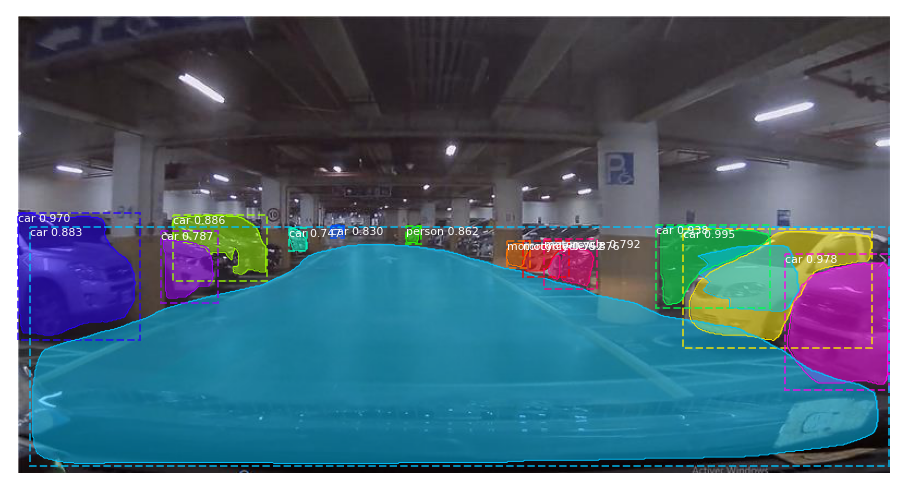

In [5]:
# Charge une image aléatoire du dossier image
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# Fine tuning du modele
* fine tuning du modèle avec le dataset pkLot.
* image de taille 640x640.
* pas de mask fourni dans le dataset => on considère le mask comme la boundingbox.
* On peut effectuer une augmentation du dataset en estimant d'abords les masks (ne sera pas fait ici).
* test sur 9 images types (différentes météos et angles).

In [2]:
import json
sys.path.append(os.path.join(ROOT_DIR, "samples/parking/"))  # To find local version
import parking

In [3]:
#Le nombre de classe a été changé à l'intérieur de la classe
class InferenceConfig(parking.ParkingConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    MAX_GT_INSTANCES= 110

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Importation des données


In [4]:
#Trainset
train_set= parking.ParkingDataset()
train_set.load_parking(dataset_dir='C:/Users/afluro/Desktop/Aubay-KYP/Dataset/PKLot.v2-640.coco/',subset='train')
train_set.prepare()

In [5]:
#Validationset
valid_set= parking.ParkingDataset()
valid_set.load_parking(dataset_dir='C:/Users/afluro/Desktop/Aubay-KYP/Dataset/PKLot.v2-640.coco/',subset='valid')
valid_set.prepare()

In [7]:
#Inspect dataset

In [8]:
train_set.image_info[40]

{'id': 40,
 'source': 'parking',
 'path': 'C:/Users/afluro/Desktop/Aubay-KYP/Dataset/PKLot.v2-640.coco/train\\2012-12-12_18_05_14_jpg.rf.c007478ae0ef20e8a37c5b289ff161b2.jpg',
 'width': 640,
 'height': 640,
 'boxes': [[322, 488, 80, 132],
  [351, 401, 74, 120],
  [374, 355, 66, 89],
  [386, 287, 64, 95],
  [405, 251, 54, 76],
  [416, 205, 53, 69],
  [426, 173, 52, 63],
  [437, 147, 52, 53],
  [449, 122, 42, 46],
  [235, 500, 89, 108],
  [339, 250, 59, 59],
  [356, 215, 58, 50],
  [368, 176, 58, 50],
  [380, 150, 54, 40],
  [399, 126, 43, 33],
  [181, 222, 38, 68],
  [204, 189, 39, 59],
  [229, 159, 38, 59],
  [248, 134, 37, 48],
  [265, 107, 38, 50],
  [282, 88, 36, 45],
  [94, 245, 41, 79],
  [126, 214, 41, 65],
  [158, 180, 37, 61],
  [183, 151, 34, 51],
  [205, 125, 35, 54],
  [225, 105, 36, 50],
  [245, 87, 31, 44]],
 'categories': [2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2]}

In [9]:
train_set.class_info

[{'source': '', 'id': 0, 'name': 'BG'},
 {'source': 'parking', 'id': 0, 'name': 'spaces'},
 {'source': 'parking', 'id': 1, 'name': 'space-empty'},
 {'source': 'parking', 'id': 2, 'name': 'space-occupied'}]

## Entrainement de modèle

In [6]:
#Entrainment du model
#On peut aussi créer une classe nous permettant d'entrainer le model
import mrcnn.model
model = mrcnn.model.MaskRCNN(mode='training', 
                             model_dir='./', 
                             config=config)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [7]:
#On supprime les couches qu'on va réutiliser pour notre modèle
model.load_weights(filepath=COCO_MODEL_PATH, 
                   by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

### Activation du Gpu pour entrainement

In [ ]:
import tensorflow as tf

sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

#Tensor GPU well installed and used.

### Repartir d'un checkpoint

Un checkpoint est créé à chaque epoch sous la forme mask_rcnn_parking_000x.h5

In [ ]:
checkpoint_path = os.path.join(ROOT_DIR, "samples/parking/parking20210318T0018")

"""
#Mettre le callback dans le paramètre callback de model.fit ou train
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True, 
                                                 save_weights_only=True, 
                                                 verbose=1)"""
'''
#Pour utiliser n'importe quel checkpoint
checkpoint_path_weigth=os.path.join(ROOT_DIR,"samples/parking/parking20210318T0018/mask_rcnn_parking_0004")
model.load_weights(filepath=checkpoint_path_weigth)'''


#Pour utiliser le dernier checkpoint
Create a new model instance
model_latest_checkpoint = create_model()

# Load the previously saved weights
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
model_latest_checkpoint.load_weights(latest)

In [ ]:
model.train(train_dataset=train_set, 
            val_dataset=valid_set, 
            learning_rate=config.LEARNING_RATE,
            epochs=5, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./parking20210318T0018\mask_rcnn_parking_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrc

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


   1/1000 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 6.3905 - rpn_class_loss: 2.1745 - rpn_bbox_loss: 0.8726 - mrcnn_class_loss: 1.4495 - mrcnn_bbox_loss: 1.1468 - mrcnn_mask_loss: 0.7472

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   2/1000 [..............................] - ETA: 1:20:46 - batch: 0.5000 - size: 1.0000 - loss: 5.5598 - rpn_class_loss: 1.5682 - rpn_bbox_loss: 0.7725 - mrcnn_class_loss: 1.2245 - mrcnn_bbox_loss: 1.3069 - mrcnn_mask_loss: 0.6877

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   3/1000 [..............................] - ETA: 1:56:47 - batch: 1.0000 - size: 1.0000 - loss: 5.8296 - rpn_class_loss: 2.2614 - rpn_bbox_loss: 1.3635 - mrcnn_class_loss: 0.8749 - mrcnn_bbox_loss: 0.8713 - mrcnn_mask_loss: 0.4585

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   4/1000 [..............................] - ETA: 2:08:25 - batch: 1.5000 - size: 1.0000 - loss: 5.4661 - rpn_class_loss: 1.9020 - rpn_bbox_loss: 1.1819 - mrcnn_class_loss: 0.8754 - mrcnn_bbox_loss: 0.9790 - mrcnn_mask_loss: 0.5278

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   5/1000 [..............................] - ETA: 2:14:23 - batch: 2.0000 - size: 1.0000 - loss: 5.1138 - rpn_class_loss: 1.7083 - rpn_bbox_loss: 1.0516 - mrcnn_class_loss: 0.8271 - mrcnn_bbox_loss: 0.9914 - mrcnn_mask_loss: 0.5354

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   6/1000 [..............................] - ETA: 2:19:05 - batch: 2.5000 - size: 1.0000 - loss: 4.8409 - rpn_class_loss: 1.4528 - rpn_bbox_loss: 0.9573 - mrcnn_class_loss: 0.8318 - mrcnn_bbox_loss: 1.0375 - mrcnn_mask_loss: 0.5614

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   7/1000 [..............................] - ETA: 2:26:25 - batch: 3.0000 - size: 1.0000 - loss: 4.8229 - rpn_class_loss: 1.3509 - rpn_bbox_loss: 1.0183 - mrcnn_class_loss: 0.7331 - mrcnn_bbox_loss: 1.1479 - mrcnn_mask_loss: 0.5726

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   8/1000 [..............................] - ETA: 2:31:43 - batch: 3.5000 - size: 1.0000 - loss: 4.7047 - rpn_class_loss: 1.2652 - rpn_bbox_loss: 1.0406 - mrcnn_class_loss: 0.6470 - mrcnn_bbox_loss: 1.1663 - mrcnn_mask_loss: 0.5857

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   9/1000 [..............................] - ETA: 2:35:58 - batch: 4.0000 - size: 1.0000 - loss: 4.5735 - rpn_class_loss: 1.1972 - rpn_bbox_loss: 1.0414 - mrcnn_class_loss: 0.6022 - mrcnn_bbox_loss: 1.1422 - mrcnn_mask_loss: 0.5905

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  10/1000 [..............................] - ETA: 2:36:32 - batch: 4.5000 - size: 1.0000 - loss: 4.4914 - rpn_class_loss: 1.1108 - rpn_bbox_loss: 0.9843 - mrcnn_class_loss: 0.6706 - mrcnn_bbox_loss: 1.1350 - mrcnn_mask_loss: 0.5907

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  11/1000 [..............................] - ETA: 2:37:05 - batch: 5.0000 - size: 1.0000 - loss: 4.4385 - rpn_class_loss: 1.0477 - rpn_bbox_loss: 0.9373 - mrcnn_class_loss: 0.6748 - mrcnn_bbox_loss: 1.1898 - mrcnn_mask_loss: 0.5889

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  12/1000 [..............................] - ETA: 2:37:26 - batch: 5.5000 - size: 1.0000 - loss: 4.3290 - rpn_class_loss: 0.9858 - rpn_bbox_loss: 0.8943 - mrcnn_class_loss: 0.6934 - mrcnn_bbox_loss: 1.1665 - mrcnn_mask_loss: 0.5890

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  13/1000 [..............................] - ETA: 2:39:06 - batch: 6.0000 - size: 1.0000 - loss: 4.2554 - rpn_class_loss: 0.9372 - rpn_bbox_loss: 0.8822 - mrcnn_class_loss: 0.7062 - mrcnn_bbox_loss: 1.1359 - mrcnn_mask_loss: 0.5940

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  14/1000 [..............................] - ETA: 2:39:12 - batch: 6.5000 - size: 1.0000 - loss: 4.1715 - rpn_class_loss: 0.8820 - rpn_bbox_loss: 0.8455 - mrcnn_class_loss: 0.7358 - mrcnn_bbox_loss: 1.1163 - mrcnn_mask_loss: 0.5918

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  15/1000 [..............................] - ETA: 2:40:55 - batch: 7.0000 - size: 1.0000 - loss: 4.1495 - rpn_class_loss: 0.8482 - rpn_bbox_loss: 0.8262 - mrcnn_class_loss: 0.7769 - mrcnn_bbox_loss: 1.1062 - mrcnn_mask_loss: 0.5920

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  16/1000 [..............................] - ETA: 2:40:28 - batch: 7.5000 - size: 1.0000 - loss: 4.0637 - rpn_class_loss: 0.8131 - rpn_bbox_loss: 0.8005 - mrcnn_class_loss: 0.7716 - mrcnn_bbox_loss: 1.0922 - mrcnn_mask_loss: 0.5864

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  17/1000 [..............................] - ETA: 2:40:06 - batch: 8.0000 - size: 1.0000 - loss: 3.9728 - rpn_class_loss: 0.7740 - rpn_bbox_loss: 0.7744 - mrcnn_class_loss: 0.7690 - mrcnn_bbox_loss: 1.0703 - mrcnn_mask_loss: 0.5852

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  18/1000 [..............................] - ETA: 2:39:47 - batch: 8.5000 - size: 1.0000 - loss: 3.9154 - rpn_class_loss: 0.7434 - rpn_bbox_loss: 0.7500 - mrcnn_class_loss: 0.7774 - mrcnn_bbox_loss: 1.0591 - mrcnn_mask_loss: 0.5854

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  19/1000 [..............................] - ETA: 2:39:41 - batch: 9.0000 - size: 1.0000 - loss: 3.8379 - rpn_class_loss: 0.7105 - rpn_bbox_loss: 0.7274 - mrcnn_class_loss: 0.7730 - mrcnn_bbox_loss: 1.0415 - mrcnn_mask_loss: 0.5855

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  20/1000 [..............................] - ETA: 2:39:37 - batch: 9.5000 - size: 1.0000 - loss: 3.7623 - rpn_class_loss: 0.6812 - rpn_bbox_loss: 0.7095 - mrcnn_class_loss: 0.7632 - mrcnn_bbox_loss: 1.0235 - mrcnn_mask_loss: 0.5849

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  21/1000 [..............................] - ETA: 2:39:21 - batch: 10.0000 - size: 1.0000 - loss: 3.6938 - rpn_class_loss: 0.6598 - rpn_bbox_loss: 0.6920 - mrcnn_class_loss: 0.7528 - mrcnn_bbox_loss: 1.0064 - mrcnn_mask_loss: 0.5829

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  22/1000 [..............................] - ETA: 2:38:59 - batch: 10.5000 - size: 1.0000 - loss: 3.6738 - rpn_class_loss: 0.6454 - rpn_bbox_loss: 0.6798 - mrcnn_class_loss: 0.7680 - mrcnn_bbox_loss: 0.9954 - mrcnn_mask_loss: 0.5852

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  23/1000 [..............................] - ETA: 2:38:43 - batch: 11.0000 - size: 1.0000 - loss: 3.6287 - rpn_class_loss: 0.6265 - rpn_bbox_loss: 0.6662 - mrcnn_class_loss: 0.7609 - mrcnn_bbox_loss: 0.9901 - mrcnn_mask_loss: 0.5851

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  24/1000 [..............................] - ETA: 2:39:43 - batch: 11.5000 - size: 1.0000 - loss: 3.6031 - rpn_class_loss: 0.6095 - rpn_bbox_loss: 0.6602 - mrcnn_class_loss: 0.7631 - mrcnn_bbox_loss: 0.9866 - mrcnn_mask_loss: 0.5836

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  25/1000 [..............................] - ETA: 2:39:38 - batch: 12.0000 - size: 1.0000 - loss: 3.5508 - rpn_class_loss: 0.5901 - rpn_bbox_loss: 0.6486 - mrcnn_class_loss: 0.7522 - mrcnn_bbox_loss: 0.9779 - mrcnn_mask_loss: 0.5820

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  26/1000 [..............................] - ETA: 2:39:31 - batch: 12.5000 - size: 1.0000 - loss: 3.4987 - rpn_class_loss: 0.5721 - rpn_bbox_loss: 0.6361 - mrcnn_class_loss: 0.7444 - mrcnn_bbox_loss: 0.9663 - mrcnn_mask_loss: 0.5798

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  27/1000 [..............................] - ETA: 2:39:13 - batch: 13.0000 - size: 1.0000 - loss: 3.4627 - rpn_class_loss: 0.5577 - rpn_bbox_loss: 0.6254 - mrcnn_class_loss: 0.7485 - mrcnn_bbox_loss: 0.9547 - mrcnn_mask_loss: 0.5765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  28/1000 [..............................] - ETA: 2:38:59 - batch: 13.5000 - size: 1.0000 - loss: 3.4153 - rpn_class_loss: 0.5418 - rpn_bbox_loss: 0.6139 - mrcnn_class_loss: 0.7429 - mrcnn_bbox_loss: 0.9439 - mrcnn_mask_loss: 0.5728

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  29/1000 [..............................] - ETA: 2:38:45 - batch: 14.0000 - size: 1.0000 - loss: 3.3756 - rpn_class_loss: 0.5310 - rpn_bbox_loss: 0.6037 - mrcnn_class_loss: 0.7366 - mrcnn_bbox_loss: 0.9349 - mrcnn_mask_loss: 0.5694

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  30/1000 [..............................] - ETA: 2:38:27 - batch: 14.5000 - size: 1.0000 - loss: 3.3358 - rpn_class_loss: 0.5196 - rpn_bbox_loss: 0.5945 - mrcnn_class_loss: 0.7320 - mrcnn_bbox_loss: 0.9233 - mrcnn_mask_loss: 0.5663

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  31/1000 [..............................] - ETA: 2:38:14 - batch: 15.0000 - size: 1.0000 - loss: 3.2972 - rpn_class_loss: 0.5072 - rpn_bbox_loss: 0.5855 - mrcnn_class_loss: 0.7269 - mrcnn_bbox_loss: 0.9131 - mrcnn_mask_loss: 0.5646

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  32/1000 [..............................] - ETA: 2:38:55 - batch: 15.5000 - size: 1.0000 - loss: 3.2996 - rpn_class_loss: 0.5147 - rpn_bbox_loss: 0.5866 - mrcnn_class_loss: 0.7263 - mrcnn_bbox_loss: 0.9066 - mrcnn_mask_loss: 0.5653

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  33/1000 [..............................] - ETA: 2:38:48 - batch: 16.0000 - size: 1.0000 - loss: 3.2659 - rpn_class_loss: 0.5014 - rpn_bbox_loss: 0.5793 - mrcnn_class_loss: 0.7207 - mrcnn_bbox_loss: 0.9021 - mrcnn_mask_loss: 0.5625

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  34/1000 [>.............................] - ETA: 2:38:38 - batch: 16.5000 - size: 1.0000 - loss: 3.2315 - rpn_class_loss: 0.4888 - rpn_bbox_loss: 0.5717 - mrcnn_class_loss: 0.7162 - mrcnn_bbox_loss: 0.8944 - mrcnn_mask_loss: 0.5604

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  35/1000 [>.............................] - ETA: 2:39:14 - batch: 17.0000 - size: 1.0000 - loss: 3.2189 - rpn_class_loss: 0.4857 - rpn_bbox_loss: 0.5700 - mrcnn_class_loss: 0.7183 - mrcnn_bbox_loss: 0.8847 - mrcnn_mask_loss: 0.5602

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  36/1000 [>.............................] - ETA: 2:39:46 - batch: 17.5000 - size: 1.0000 - loss: 3.2131 - rpn_class_loss: 0.4869 - rpn_bbox_loss: 0.5666 - mrcnn_class_loss: 0.7220 - mrcnn_bbox_loss: 0.8780 - mrcnn_mask_loss: 0.5595

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  37/1000 [>.............................] - ETA: 2:39:35 - batch: 18.0000 - size: 1.0000 - loss: 3.1785 - rpn_class_loss: 0.4752 - rpn_bbox_loss: 0.5603 - mrcnn_class_loss: 0.7157 - mrcnn_bbox_loss: 0.8699 - mrcnn_mask_loss: 0.5574

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  38/1000 [>.............................] - ETA: 2:39:17 - batch: 18.5000 - size: 1.0000 - loss: 3.1573 - rpn_class_loss: 0.4683 - rpn_bbox_loss: 0.5538 - mrcnn_class_loss: 0.7191 - mrcnn_bbox_loss: 0.8597 - mrcnn_mask_loss: 0.5563

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  39/1000 [>.............................] - ETA: 2:39:09 - batch: 19.0000 - size: 1.0000 - loss: 3.1336 - rpn_class_loss: 0.4606 - rpn_bbox_loss: 0.5474 - mrcnn_class_loss: 0.7174 - mrcnn_bbox_loss: 0.8539 - mrcnn_mask_loss: 0.5543

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  40/1000 [>.............................] - ETA: 2:38:54 - batch: 19.5000 - size: 1.0000 - loss: 3.1218 - rpn_class_loss: 0.4542 - rpn_bbox_loss: 0.5413 - mrcnn_class_loss: 0.7156 - mrcnn_bbox_loss: 0.8581 - mrcnn_mask_loss: 0.5526

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  41/1000 [>.............................] - ETA: 2:38:37 - batch: 20.0000 - size: 1.0000 - loss: 3.0950 - rpn_class_loss: 0.4480 - rpn_bbox_loss: 0.5346 - mrcnn_class_loss: 0.7123 - mrcnn_bbox_loss: 0.8494 - mrcnn_mask_loss: 0.5507

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  42/1000 [>.............................] - ETA: 2:38:19 - batch: 20.5000 - size: 1.0000 - loss: 3.0710 - rpn_class_loss: 0.4424 - rpn_bbox_loss: 0.5285 - mrcnn_class_loss: 0.7090 - mrcnn_bbox_loss: 0.8425 - mrcnn_mask_loss: 0.5485

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  43/1000 [>.............................] - ETA: 2:38:10 - batch: 21.0000 - size: 1.0000 - loss: 3.0498 - rpn_class_loss: 0.4357 - rpn_bbox_loss: 0.5227 - mrcnn_class_loss: 0.7106 - mrcnn_bbox_loss: 0.8345 - mrcnn_mask_loss: 0.5463

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  44/1000 [>.............................] - ETA: 2:38:00 - batch: 21.5000 - size: 1.0000 - loss: 3.0324 - rpn_class_loss: 0.4301 - rpn_bbox_loss: 0.5168 - mrcnn_class_loss: 0.7102 - mrcnn_bbox_loss: 0.8309 - mrcnn_mask_loss: 0.5444

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  45/1000 [>.............................] - ETA: 2:37:43 - batch: 22.0000 - size: 1.0000 - loss: 3.0101 - rpn_class_loss: 0.4245 - rpn_bbox_loss: 0.5114 - mrcnn_class_loss: 0.7078 - mrcnn_bbox_loss: 0.8239 - mrcnn_mask_loss: 0.5425

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  46/1000 [>.............................] - ETA: 2:37:28 - batch: 22.5000 - size: 1.0000 - loss: 2.9912 - rpn_class_loss: 0.4187 - rpn_bbox_loss: 0.5062 - mrcnn_class_loss: 0.7063 - mrcnn_bbox_loss: 0.8185 - mrcnn_mask_loss: 0.5415

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  47/1000 [>.............................] - ETA: 2:37:17 - batch: 23.0000 - size: 1.0000 - loss: 2.9661 - rpn_class_loss: 0.4122 - rpn_bbox_loss: 0.5006 - mrcnn_class_loss: 0.7020 - mrcnn_bbox_loss: 0.8111 - mrcnn_mask_loss: 0.5403

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  48/1000 [>.............................] - ETA: 2:37:02 - batch: 23.5000 - size: 1.0000 - loss: 2.9452 - rpn_class_loss: 0.4060 - rpn_bbox_loss: 0.4962 - mrcnn_class_loss: 0.6984 - mrcnn_bbox_loss: 0.8055 - mrcnn_mask_loss: 0.5391

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  49/1000 [>.............................] - ETA: 2:37:23 - batch: 24.0000 - size: 1.0000 - loss: 2.9449 - rpn_class_loss: 0.4018 - rpn_bbox_loss: 0.4930 - mrcnn_class_loss: 0.7119 - mrcnn_bbox_loss: 0.8012 - mrcnn_mask_loss: 0.5371

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  50/1000 [>.............................] - ETA: 2:37:17 - batch: 24.5000 - size: 1.0000 - loss: 2.9300 - rpn_class_loss: 0.3957 - rpn_bbox_loss: 0.4886 - mrcnn_class_loss: 0.7147 - mrcnn_bbox_loss: 0.7954 - mrcnn_mask_loss: 0.5356

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  51/1000 [>.............................] - ETA: 2:37:08 - batch: 25.0000 - size: 1.0000 - loss: 2.9135 - rpn_class_loss: 0.3896 - rpn_bbox_loss: 0.4844 - mrcnn_class_loss: 0.7157 - mrcnn_bbox_loss: 0.7889 - mrcnn_mask_loss: 0.5349

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  52/1000 [>.............................] - ETA: 2:37:26 - batch: 25.5000 - size: 1.0000 - loss: 2.9041 - rpn_class_loss: 0.3871 - rpn_bbox_loss: 0.4824 - mrcnn_class_loss: 0.7160 - mrcnn_bbox_loss: 0.7849 - mrcnn_mask_loss: 0.5337

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  53/1000 [>.............................] - ETA: 2:37:43 - batch: 26.0000 - size: 1.0000 - loss: 2.9006 - rpn_class_loss: 0.3857 - rpn_bbox_loss: 0.4814 - mrcnn_class_loss: 0.7188 - mrcnn_bbox_loss: 0.7810 - mrcnn_mask_loss: 0.5337

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  54/1000 [>.............................] - ETA: 2:37:31 - batch: 26.5000 - size: 1.0000 - loss: 2.8840 - rpn_class_loss: 0.3795 - rpn_bbox_loss: 0.4773 - mrcnn_class_loss: 0.7170 - mrcnn_bbox_loss: 0.7773 - mrcnn_mask_loss: 0.5329

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  55/1000 [>.............................] - ETA: 2:37:47 - batch: 27.0000 - size: 1.0000 - loss: 2.8798 - rpn_class_loss: 0.3808 - rpn_bbox_loss: 0.4764 - mrcnn_class_loss: 0.7165 - mrcnn_bbox_loss: 0.7738 - mrcnn_mask_loss: 0.5322

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  56/1000 [>.............................] - ETA: 2:37:35 - batch: 27.5000 - size: 1.0000 - loss: 2.8604 - rpn_class_loss: 0.3751 - rpn_bbox_loss: 0.4724 - mrcnn_class_loss: 0.7137 - mrcnn_bbox_loss: 0.7686 - mrcnn_mask_loss: 0.5306

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  57/1000 [>.............................] - ETA: 2:37:18 - batch: 28.0000 - size: 1.0000 - loss: 2.8513 - rpn_class_loss: 0.3733 - rpn_bbox_loss: 0.4690 - mrcnn_class_loss: 0.7139 - mrcnn_bbox_loss: 0.7658 - mrcnn_mask_loss: 0.5293

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  58/1000 [>.............................] - ETA: 2:37:02 - batch: 28.5000 - size: 1.0000 - loss: 2.8405 - rpn_class_loss: 0.3685 - rpn_bbox_loss: 0.4657 - mrcnn_class_loss: 0.7152 - mrcnn_bbox_loss: 0.7628 - mrcnn_mask_loss: 0.5283

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  59/1000 [>.............................] - ETA: 2:37:14 - batch: 29.0000 - size: 1.0000 - loss: 2.8400 - rpn_class_loss: 0.3655 - rpn_bbox_loss: 0.4637 - mrcnn_class_loss: 0.7243 - mrcnn_bbox_loss: 0.7584 - mrcnn_mask_loss: 0.5282

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  60/1000 [>.............................] - ETA: 2:37:28 - batch: 29.5000 - size: 1.0000 - loss: 2.8381 - rpn_class_loss: 0.3647 - rpn_bbox_loss: 0.4626 - mrcnn_class_loss: 0.7259 - mrcnn_bbox_loss: 0.7567 - mrcnn_mask_loss: 0.5282

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  61/1000 [>.............................] - ETA: 2:37:41 - batch: 30.0000 - size: 1.0000 - loss: 2.8323 - rpn_class_loss: 0.3629 - rpn_bbox_loss: 0.4608 - mrcnn_class_loss: 0.7279 - mrcnn_bbox_loss: 0.7536 - mrcnn_mask_loss: 0.5271

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  62/1000 [>.............................] - ETA: 2:37:56 - batch: 30.5000 - size: 1.0000 - loss: 2.8264 - rpn_class_loss: 0.3608 - rpn_bbox_loss: 0.4600 - mrcnn_class_loss: 0.7296 - mrcnn_bbox_loss: 0.7498 - mrcnn_mask_loss: 0.5262

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  63/1000 [>.............................] - ETA: 2:37:47 - batch: 31.0000 - size: 1.0000 - loss: 2.8152 - rpn_class_loss: 0.3568 - rpn_bbox_loss: 0.4573 - mrcnn_class_loss: 0.7294 - mrcnn_bbox_loss: 0.7460 - mrcnn_mask_loss: 0.5256

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  64/1000 [>.............................] - ETA: 2:38:01 - batch: 31.5000 - size: 1.0000 - loss: 2.8119 - rpn_class_loss: 0.3554 - rpn_bbox_loss: 0.4553 - mrcnn_class_loss: 0.7319 - mrcnn_bbox_loss: 0.7449 - mrcnn_mask_loss: 0.5245

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  65/1000 [>.............................] - ETA: 2:38:14 - batch: 32.0000 - size: 1.0000 - loss: 2.8031 - rpn_class_loss: 0.3534 - rpn_bbox_loss: 0.4528 - mrcnn_class_loss: 0.7325 - mrcnn_bbox_loss: 0.7404 - mrcnn_mask_loss: 0.5240

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  66/1000 [>.............................] - ETA: 2:38:26 - batch: 32.5000 - size: 1.0000 - loss: 2.7926 - rpn_class_loss: 0.3509 - rpn_bbox_loss: 0.4503 - mrcnn_class_loss: 0.7309 - mrcnn_bbox_loss: 0.7376 - mrcnn_mask_loss: 0.5229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  67/1000 [=>............................] - ETA: 2:38:19 - batch: 33.0000 - size: 1.0000 - loss: 2.7758 - rpn_class_loss: 0.3467 - rpn_bbox_loss: 0.4477 - mrcnn_class_loss: 0.7266 - mrcnn_bbox_loss: 0.7325 - mrcnn_mask_loss: 0.5223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  68/1000 [=>............................] - ETA: 2:38:12 - batch: 33.5000 - size: 1.0000 - loss: 2.7656 - rpn_class_loss: 0.3430 - rpn_bbox_loss: 0.4452 - mrcnn_class_loss: 0.7269 - mrcnn_bbox_loss: 0.7287 - mrcnn_mask_loss: 0.5217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  69/1000 [=>............................] - ETA: 2:38:01 - batch: 34.0000 - size: 1.0000 - loss: 2.7579 - rpn_class_loss: 0.3401 - rpn_bbox_loss: 0.4436 - mrcnn_class_loss: 0.7258 - mrcnn_bbox_loss: 0.7270 - mrcnn_mask_loss: 0.5214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  70/1000 [=>............................] - ETA: 2:37:50 - batch: 34.5000 - size: 1.0000 - loss: 2.7488 - rpn_class_loss: 0.3371 - rpn_bbox_loss: 0.4412 - mrcnn_class_loss: 0.7256 - mrcnn_bbox_loss: 0.7243 - mrcnn_mask_loss: 0.5206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  71/1000 [=>............................] - ETA: 2:37:42 - batch: 35.0000 - size: 1.0000 - loss: 2.7332 - rpn_class_loss: 0.3336 - rpn_bbox_loss: 0.4384 - mrcnn_class_loss: 0.7220 - mrcnn_bbox_loss: 0.7192 - mrcnn_mask_loss: 0.5200

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  72/1000 [=>............................] - ETA: 2:37:31 - batch: 35.5000 - size: 1.0000 - loss: 2.7226 - rpn_class_loss: 0.3307 - rpn_bbox_loss: 0.4358 - mrcnn_class_loss: 0.7194 - mrcnn_bbox_loss: 0.7176 - mrcnn_mask_loss: 0.5192

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  73/1000 [=>............................] - ETA: 2:37:45 - batch: 36.0000 - size: 1.0000 - loss: 2.7283 - rpn_class_loss: 0.3281 - rpn_bbox_loss: 0.4379 - mrcnn_class_loss: 0.7261 - mrcnn_bbox_loss: 0.7171 - mrcnn_mask_loss: 0.5190

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  74/1000 [=>............................] - ETA: 2:37:37 - batch: 36.5000 - size: 1.0000 - loss: 2.7146 - rpn_class_loss: 0.3246 - rpn_bbox_loss: 0.4353 - mrcnn_class_loss: 0.7237 - mrcnn_bbox_loss: 0.7136 - mrcnn_mask_loss: 0.5174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  75/1000 [=>............................] - ETA: 2:37:48 - batch: 37.0000 - size: 1.0000 - loss: 2.7127 - rpn_class_loss: 0.3229 - rpn_bbox_loss: 0.4357 - mrcnn_class_loss: 0.7256 - mrcnn_bbox_loss: 0.7115 - mrcnn_mask_loss: 0.5170

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  76/1000 [=>............................] - ETA: 2:37:41 - batch: 37.5000 - size: 1.0000 - loss: 2.7011 - rpn_class_loss: 0.3199 - rpn_bbox_loss: 0.4330 - mrcnn_class_loss: 0.7234 - mrcnn_bbox_loss: 0.7088 - mrcnn_mask_loss: 0.5160

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  77/1000 [=>............................] - ETA: 2:37:31 - batch: 38.0000 - size: 1.0000 - loss: 2.6886 - rpn_class_loss: 0.3167 - rpn_bbox_loss: 0.4307 - mrcnn_class_loss: 0.7197 - mrcnn_bbox_loss: 0.7068 - mrcnn_mask_loss: 0.5147

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  78/1000 [=>............................] - ETA: 2:37:41 - batch: 38.5000 - size: 1.0000 - loss: 2.6839 - rpn_class_loss: 0.3144 - rpn_bbox_loss: 0.4296 - mrcnn_class_loss: 0.7212 - mrcnn_bbox_loss: 0.7047 - mrcnn_mask_loss: 0.5140

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  79/1000 [=>............................] - ETA: 2:37:30 - batch: 39.0000 - size: 1.0000 - loss: 2.6721 - rpn_class_loss: 0.3115 - rpn_bbox_loss: 0.4269 - mrcnn_class_loss: 0.7193 - mrcnn_bbox_loss: 0.7014 - mrcnn_mask_loss: 0.5130

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  80/1000 [=>............................] - ETA: 2:37:20 - batch: 39.5000 - size: 1.0000 - loss: 2.6597 - rpn_class_loss: 0.3087 - rpn_bbox_loss: 0.4243 - mrcnn_class_loss: 0.7169 - mrcnn_bbox_loss: 0.6975 - mrcnn_mask_loss: 0.5124

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  81/1000 [=>............................] - ETA: 2:37:27 - batch: 40.0000 - size: 1.0000 - loss: 2.6583 - rpn_class_loss: 0.3087 - rpn_bbox_loss: 0.4235 - mrcnn_class_loss: 0.7170 - mrcnn_bbox_loss: 0.6962 - mrcnn_mask_loss: 0.5130

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  82/1000 [=>............................] - ETA: 2:37:11 - batch: 40.5000 - size: 1.0000 - loss: 2.6511 - rpn_class_loss: 0.3065 - rpn_bbox_loss: 0.4222 - mrcnn_class_loss: 0.7149 - mrcnn_bbox_loss: 0.6945 - mrcnn_mask_loss: 0.5129

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  83/1000 [=>............................] - ETA: 2:37:17 - batch: 41.0000 - size: 1.0000 - loss: 2.6487 - rpn_class_loss: 0.3057 - rpn_bbox_loss: 0.4212 - mrcnn_class_loss: 0.7157 - mrcnn_bbox_loss: 0.6931 - mrcnn_mask_loss: 0.5130

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  84/1000 [=>............................] - ETA: 2:37:07 - batch: 41.5000 - size: 1.0000 - loss: 2.6371 - rpn_class_loss: 0.3031 - rpn_bbox_loss: 0.4196 - mrcnn_class_loss: 0.7114 - mrcnn_bbox_loss: 0.6906 - mrcnn_mask_loss: 0.5124

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  85/1000 [=>............................] - ETA: 2:36:56 - batch: 42.0000 - size: 1.0000 - loss: 2.6247 - rpn_class_loss: 0.3003 - rpn_bbox_loss: 0.4178 - mrcnn_class_loss: 0.7078 - mrcnn_bbox_loss: 0.6872 - mrcnn_mask_loss: 0.5117

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  86/1000 [=>............................] - ETA: 2:37:03 - batch: 42.5000 - size: 1.0000 - loss: 2.6232 - rpn_class_loss: 0.2989 - rpn_bbox_loss: 0.4169 - mrcnn_class_loss: 0.7080 - mrcnn_bbox_loss: 0.6875 - mrcnn_mask_loss: 0.5120

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  87/1000 [=>............................] - ETA: 2:37:09 - batch: 43.0000 - size: 1.0000 - loss: 2.6203 - rpn_class_loss: 0.2979 - rpn_bbox_loss: 0.4161 - mrcnn_class_loss: 0.7077 - mrcnn_bbox_loss: 0.6865 - mrcnn_mask_loss: 0.5120

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  88/1000 [=>............................] - ETA: 2:36:57 - batch: 43.5000 - size: 1.0000 - loss: 2.6080 - rpn_class_loss: 0.2955 - rpn_bbox_loss: 0.4140 - mrcnn_class_loss: 0.7042 - mrcnn_bbox_loss: 0.6834 - mrcnn_mask_loss: 0.5109

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  89/1000 [=>............................] - ETA: 2:36:46 - batch: 44.0000 - size: 1.0000 - loss: 2.5963 - rpn_class_loss: 0.2929 - rpn_bbox_loss: 0.4115 - mrcnn_class_loss: 0.7011 - mrcnn_bbox_loss: 0.6806 - mrcnn_mask_loss: 0.5102

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  90/1000 [=>............................] - ETA: 2:36:52 - batch: 44.5000 - size: 1.0000 - loss: 2.6029 - rpn_class_loss: 0.2960 - rpn_bbox_loss: 0.4117 - mrcnn_class_loss: 0.7038 - mrcnn_bbox_loss: 0.6811 - mrcnn_mask_loss: 0.5103

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  91/1000 [=>............................] - ETA: 2:36:58 - batch: 45.0000 - size: 1.0000 - loss: 2.5971 - rpn_class_loss: 0.2946 - rpn_bbox_loss: 0.4103 - mrcnn_class_loss: 0.7032 - mrcnn_bbox_loss: 0.6794 - mrcnn_mask_loss: 0.5097

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  92/1000 [=>............................] - ETA: 2:37:02 - batch: 45.5000 - size: 1.0000 - loss: 2.5932 - rpn_class_loss: 0.2932 - rpn_bbox_loss: 0.4091 - mrcnn_class_loss: 0.7025 - mrcnn_bbox_loss: 0.6791 - mrcnn_mask_loss: 0.5092

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  93/1000 [=>............................] - ETA: 2:37:07 - batch: 46.0000 - size: 1.0000 - loss: 2.5894 - rpn_class_loss: 0.2921 - rpn_bbox_loss: 0.4086 - mrcnn_class_loss: 0.7015 - mrcnn_bbox_loss: 0.6777 - mrcnn_mask_loss: 0.5095

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  94/1000 [=>............................] - ETA: 2:36:55 - batch: 46.5000 - size: 1.0000 - loss: 2.5821 - rpn_class_loss: 0.2903 - rpn_bbox_loss: 0.4069 - mrcnn_class_loss: 0.6995 - mrcnn_bbox_loss: 0.6764 - mrcnn_mask_loss: 0.5090

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  95/1000 [=>............................] - ETA: 2:36:43 - batch: 47.0000 - size: 1.0000 - loss: 2.5789 - rpn_class_loss: 0.2888 - rpn_bbox_loss: 0.4058 - mrcnn_class_loss: 0.6991 - mrcnn_bbox_loss: 0.6759 - mrcnn_mask_loss: 0.5093

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  96/1000 [=>............................] - ETA: 2:36:33 - batch: 47.5000 - size: 1.0000 - loss: 2.5687 - rpn_class_loss: 0.2869 - rpn_bbox_loss: 0.4036 - mrcnn_class_loss: 0.6963 - mrcnn_bbox_loss: 0.6724 - mrcnn_mask_loss: 0.5094

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  97/1000 [=>............................] - ETA: 2:36:23 - batch: 48.0000 - size: 1.0000 - loss: 2.5594 - rpn_class_loss: 0.2850 - rpn_bbox_loss: 0.4022 - mrcnn_class_loss: 0.6937 - mrcnn_bbox_loss: 0.6688 - mrcnn_mask_loss: 0.5097

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  98/1000 [=>............................] - ETA: 2:36:27 - batch: 48.5000 - size: 1.0000 - loss: 2.5575 - rpn_class_loss: 0.2843 - rpn_bbox_loss: 0.4034 - mrcnn_class_loss: 0.6925 - mrcnn_bbox_loss: 0.6676 - mrcnn_mask_loss: 0.5098

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  99/1000 [=>............................] - ETA: 2:36:31 - batch: 49.0000 - size: 1.0000 - loss: 2.5602 - rpn_class_loss: 0.2835 - rpn_bbox_loss: 0.4047 - mrcnn_class_loss: 0.6953 - mrcnn_bbox_loss: 0.6671 - mrcnn_mask_loss: 0.5096

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 100/1000 [==>...........................] - ETA: 2:36:32 - batch: 49.5000 - size: 1.0000 - loss: 2.5673 - rpn_class_loss: 0.2817 - rpn_bbox_loss: 0.4065 - mrcnn_class_loss: 0.6981 - mrcnn_bbox_loss: 0.6714 - mrcnn_mask_loss: 0.5097

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 101/1000 [==>...........................] - ETA: 2:36:18 - batch: 50.0000 - size: 1.0000 - loss: 2.5596 - rpn_class_loss: 0.2796 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.6972 - mrcnn_bbox_loss: 0.6690 - mrcnn_mask_loss: 0.5094

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 102/1000 [==>...........................] - ETA: 2:36:04 - batch: 50.5000 - size: 1.0000 - loss: 2.5518 - rpn_class_loss: 0.2773 - rpn_bbox_loss: 0.4029 - mrcnn_class_loss: 0.6951 - mrcnn_bbox_loss: 0.6671 - mrcnn_mask_loss: 0.5094

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 103/1000 [==>...........................] - ETA: 2:36:07 - batch: 51.0000 - size: 1.0000 - loss: 2.5498 - rpn_class_loss: 0.2764 - rpn_bbox_loss: 0.4015 - mrcnn_class_loss: 0.6956 - mrcnn_bbox_loss: 0.6664 - mrcnn_mask_loss: 0.5098

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 104/1000 [==>...........................] - ETA: 2:35:56 - batch: 51.5000 - size: 1.0000 - loss: 2.5473 - rpn_class_loss: 0.2748 - rpn_bbox_loss: 0.3998 - mrcnn_class_loss: 0.6973 - mrcnn_bbox_loss: 0.6654 - mrcnn_mask_loss: 0.5099

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 105/1000 [==>...........................] - ETA: 2:35:45 - batch: 52.0000 - size: 1.0000 - loss: 2.5379 - rpn_class_loss: 0.2727 - rpn_bbox_loss: 0.3979 - mrcnn_class_loss: 0.6949 - mrcnn_bbox_loss: 0.6627 - mrcnn_mask_loss: 0.5098

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 106/1000 [==>...........................] - ETA: 2:35:49 - batch: 52.5000 - size: 1.0000 - loss: 2.5337 - rpn_class_loss: 0.2716 - rpn_bbox_loss: 0.3973 - mrcnn_class_loss: 0.6944 - mrcnn_bbox_loss: 0.6609 - mrcnn_mask_loss: 0.5095

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 107/1000 [==>...........................] - ETA: 2:35:35 - batch: 53.0000 - size: 1.0000 - loss: 2.5280 - rpn_class_loss: 0.2699 - rpn_bbox_loss: 0.3960 - mrcnn_class_loss: 0.6936 - mrcnn_bbox_loss: 0.6590 - mrcnn_mask_loss: 0.5095

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 108/1000 [==>...........................] - ETA: 2:35:21 - batch: 53.5000 - size: 1.0000 - loss: 2.5229 - rpn_class_loss: 0.2687 - rpn_bbox_loss: 0.3945 - mrcnn_class_loss: 0.6924 - mrcnn_bbox_loss: 0.6579 - mrcnn_mask_loss: 0.5094

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 109/1000 [==>...........................] - ETA: 2:35:25 - batch: 54.0000 - size: 1.0000 - loss: 2.5273 - rpn_class_loss: 0.2679 - rpn_bbox_loss: 0.3936 - mrcnn_class_loss: 0.6990 - mrcnn_bbox_loss: 0.6581 - mrcnn_mask_loss: 0.5088

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 110/1000 [==>...........................] - ETA: 2:35:11 - batch: 54.5000 - size: 1.0000 - loss: 2.5204 - rpn_class_loss: 0.2665 - rpn_bbox_loss: 0.3924 - mrcnn_class_loss: 0.6970 - mrcnn_bbox_loss: 0.6559 - mrcnn_mask_loss: 0.5085

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 111/1000 [==>...........................] - ETA: 2:35:00 - batch: 55.0000 - size: 1.0000 - loss: 2.5143 - rpn_class_loss: 0.2647 - rpn_bbox_loss: 0.3910 - mrcnn_class_loss: 0.6952 - mrcnn_bbox_loss: 0.6551 - mrcnn_mask_loss: 0.5083

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 112/1000 [==>...........................] - ETA: 2:34:48 - batch: 55.5000 - size: 1.0000 - loss: 2.5075 - rpn_class_loss: 0.2626 - rpn_bbox_loss: 0.3896 - mrcnn_class_loss: 0.6931 - mrcnn_bbox_loss: 0.6541 - mrcnn_mask_loss: 0.5081

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 113/1000 [==>...........................] - ETA: 2:34:49 - batch: 56.0000 - size: 1.0000 - loss: 2.5035 - rpn_class_loss: 0.2614 - rpn_bbox_loss: 0.3886 - mrcnn_class_loss: 0.6933 - mrcnn_bbox_loss: 0.6528 - mrcnn_mask_loss: 0.5074

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 114/1000 [==>...........................] - ETA: 2:34:35 - batch: 56.5000 - size: 1.0000 - loss: 2.4964 - rpn_class_loss: 0.2602 - rpn_bbox_loss: 0.3873 - mrcnn_class_loss: 0.6908 - mrcnn_bbox_loss: 0.6509 - mrcnn_mask_loss: 0.5073

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 115/1000 [==>...........................] - ETA: 2:34:23 - batch: 57.0000 - size: 1.0000 - loss: 2.4886 - rpn_class_loss: 0.2581 - rpn_bbox_loss: 0.3857 - mrcnn_class_loss: 0.6887 - mrcnn_bbox_loss: 0.6490 - mrcnn_mask_loss: 0.5070

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 116/1000 [==>...........................] - ETA: 2:34:13 - batch: 57.5000 - size: 1.0000 - loss: 2.4797 - rpn_class_loss: 0.2565 - rpn_bbox_loss: 0.3839 - mrcnn_class_loss: 0.6871 - mrcnn_bbox_loss: 0.6458 - mrcnn_mask_loss: 0.5063

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 117/1000 [==>...........................] - ETA: 2:34:14 - batch: 58.0000 - size: 1.0000 - loss: 2.4772 - rpn_class_loss: 0.2561 - rpn_bbox_loss: 0.3831 - mrcnn_class_loss: 0.6870 - mrcnn_bbox_loss: 0.6448 - mrcnn_mask_loss: 0.5062

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 118/1000 [==>...........................] - ETA: 2:34:17 - batch: 58.5000 - size: 1.0000 - loss: 2.4727 - rpn_class_loss: 0.2552 - rpn_bbox_loss: 0.3821 - mrcnn_class_loss: 0.6863 - mrcnn_bbox_loss: 0.6435 - mrcnn_mask_loss: 0.5057

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 119/1000 [==>...........................] - ETA: 2:34:06 - batch: 59.0000 - size: 1.0000 - loss: 2.4655 - rpn_class_loss: 0.2536 - rpn_bbox_loss: 0.3806 - mrcnn_class_loss: 0.6847 - mrcnn_bbox_loss: 0.6414 - mrcnn_mask_loss: 0.5052

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 120/1000 [==>...........................] - ETA: 2:34:07 - batch: 59.5000 - size: 1.0000 - loss: 2.4607 - rpn_class_loss: 0.2535 - rpn_bbox_loss: 0.3793 - mrcnn_class_loss: 0.6836 - mrcnn_bbox_loss: 0.6394 - mrcnn_mask_loss: 0.5049

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 121/1000 [==>...........................] - ETA: 2:33:53 - batch: 60.0000 - size: 1.0000 - loss: 2.4556 - rpn_class_loss: 0.2524 - rpn_bbox_loss: 0.3783 - mrcnn_class_loss: 0.6818 - mrcnn_bbox_loss: 0.6384 - mrcnn_mask_loss: 0.5047

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 122/1000 [==>...........................] - ETA: 2:33:41 - batch: 60.5000 - size: 1.0000 - loss: 2.4488 - rpn_class_loss: 0.2509 - rpn_bbox_loss: 0.3766 - mrcnn_class_loss: 0.6809 - mrcnn_bbox_loss: 0.6361 - mrcnn_mask_loss: 0.5042

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 123/1000 [==>...........................] - ETA: 2:33:42 - batch: 61.0000 - size: 1.0000 - loss: 2.4442 - rpn_class_loss: 0.2504 - rpn_bbox_loss: 0.3756 - mrcnn_class_loss: 0.6799 - mrcnn_bbox_loss: 0.6343 - mrcnn_mask_loss: 0.5040

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 124/1000 [==>...........................] - ETA: 2:33:29 - batch: 61.5000 - size: 1.0000 - loss: 2.4394 - rpn_class_loss: 0.2496 - rpn_bbox_loss: 0.3746 - mrcnn_class_loss: 0.6779 - mrcnn_bbox_loss: 0.6334 - mrcnn_mask_loss: 0.5039

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 125/1000 [==>...........................] - ETA: 2:33:28 - batch: 62.0000 - size: 1.0000 - loss: 2.4390 - rpn_class_loss: 0.2499 - rpn_bbox_loss: 0.3748 - mrcnn_class_loss: 0.6782 - mrcnn_bbox_loss: 0.6323 - mrcnn_mask_loss: 0.5037

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 126/1000 [==>...........................] - ETA: 2:33:28 - batch: 62.5000 - size: 1.0000 - loss: 2.4353 - rpn_class_loss: 0.2492 - rpn_bbox_loss: 0.3739 - mrcnn_class_loss: 0.6775 - mrcnn_bbox_loss: 0.6312 - mrcnn_mask_loss: 0.5035

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 127/1000 [==>...........................] - ETA: 2:33:28 - batch: 63.0000 - size: 1.0000 - loss: 2.4314 - rpn_class_loss: 0.2488 - rpn_bbox_loss: 0.3732 - mrcnn_class_loss: 0.6767 - mrcnn_bbox_loss: 0.6296 - mrcnn_mask_loss: 0.5031

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 128/1000 [==>...........................] - ETA: 2:33:16 - batch: 63.5000 - size: 1.0000 - loss: 2.4243 - rpn_class_loss: 0.2472 - rpn_bbox_loss: 0.3723 - mrcnn_class_loss: 0.6749 - mrcnn_bbox_loss: 0.6272 - mrcnn_mask_loss: 0.5027

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 129/1000 [==>...........................] - ETA: 2:33:15 - batch: 64.0000 - size: 1.0000 - loss: 2.4200 - rpn_class_loss: 0.2467 - rpn_bbox_loss: 0.3714 - mrcnn_class_loss: 0.6744 - mrcnn_bbox_loss: 0.6255 - mrcnn_mask_loss: 0.5020

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 130/1000 [==>...........................] - ETA: 2:33:03 - batch: 64.5000 - size: 1.0000 - loss: 2.4158 - rpn_class_loss: 0.2454 - rpn_bbox_loss: 0.3704 - mrcnn_class_loss: 0.6741 - mrcnn_bbox_loss: 0.6239 - mrcnn_mask_loss: 0.5020

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 131/1000 [==>...........................] - ETA: 2:32:49 - batch: 65.0000 - size: 1.0000 - loss: 2.4114 - rpn_class_loss: 0.2445 - rpn_bbox_loss: 0.3694 - mrcnn_class_loss: 0.6729 - mrcnn_bbox_loss: 0.6230 - mrcnn_mask_loss: 0.5017

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 132/1000 [==>...........................] - ETA: 2:32:38 - batch: 65.5000 - size: 1.0000 - loss: 2.4062 - rpn_class_loss: 0.2434 - rpn_bbox_loss: 0.3689 - mrcnn_class_loss: 0.6715 - mrcnn_bbox_loss: 0.6208 - mrcnn_mask_loss: 0.5015

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 133/1000 [==>...........................] - ETA: 2:32:24 - batch: 66.0000 - size: 1.0000 - loss: 2.4047 - rpn_class_loss: 0.2422 - rpn_bbox_loss: 0.3681 - mrcnn_class_loss: 0.6731 - mrcnn_bbox_loss: 0.6201 - mrcnn_mask_loss: 0.5012

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 134/1000 [===>..........................] - ETA: 2:32:11 - batch: 66.5000 - size: 1.0000 - loss: 2.3983 - rpn_class_loss: 0.2412 - rpn_bbox_loss: 0.3672 - mrcnn_class_loss: 0.6710 - mrcnn_bbox_loss: 0.6178 - mrcnn_mask_loss: 0.5011

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 135/1000 [===>..........................] - ETA: 2:31:57 - batch: 67.0000 - size: 1.0000 - loss: 2.3941 - rpn_class_loss: 0.2402 - rpn_bbox_loss: 0.3662 - mrcnn_class_loss: 0.6698 - mrcnn_bbox_loss: 0.6170 - mrcnn_mask_loss: 0.5009

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 136/1000 [===>..........................] - ETA: 2:31:45 - batch: 67.5000 - size: 1.0000 - loss: 2.3881 - rpn_class_loss: 0.2390 - rpn_bbox_loss: 0.3654 - mrcnn_class_loss: 0.6682 - mrcnn_bbox_loss: 0.6147 - mrcnn_mask_loss: 0.5008

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 137/1000 [===>..........................] - ETA: 2:31:43 - batch: 68.0000 - size: 1.0000 - loss: 2.3841 - rpn_class_loss: 0.2383 - rpn_bbox_loss: 0.3647 - mrcnn_class_loss: 0.6678 - mrcnn_bbox_loss: 0.6131 - mrcnn_mask_loss: 0.5003

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 138/1000 [===>..........................] - ETA: 2:31:30 - batch: 68.5000 - size: 1.0000 - loss: 2.3781 - rpn_class_loss: 0.2374 - rpn_bbox_loss: 0.3636 - mrcnn_class_loss: 0.6659 - mrcnn_bbox_loss: 0.6114 - mrcnn_mask_loss: 0.4998

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 139/1000 [===>..........................] - ETA: 2:31:18 - batch: 69.0000 - size: 1.0000 - loss: 2.3705 - rpn_class_loss: 0.2360 - rpn_bbox_loss: 0.3623 - mrcnn_class_loss: 0.6639 - mrcnn_bbox_loss: 0.6089 - mrcnn_mask_loss: 0.4994

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 140/1000 [===>..........................] - ETA: 2:31:07 - batch: 69.5000 - size: 1.0000 - loss: 2.3641 - rpn_class_loss: 0.2346 - rpn_bbox_loss: 0.3611 - mrcnn_class_loss: 0.6621 - mrcnn_bbox_loss: 0.6072 - mrcnn_mask_loss: 0.4991

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 141/1000 [===>..........................] - ETA: 2:30:54 - batch: 70.0000 - size: 1.0000 - loss: 2.3596 - rpn_class_loss: 0.2335 - rpn_bbox_loss: 0.3603 - mrcnn_class_loss: 0.6608 - mrcnn_bbox_loss: 0.6061 - mrcnn_mask_loss: 0.4989

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 142/1000 [===>..........................] - ETA: 2:30:41 - batch: 70.5000 - size: 1.0000 - loss: 2.3527 - rpn_class_loss: 0.2323 - rpn_bbox_loss: 0.3589 - mrcnn_class_loss: 0.6588 - mrcnn_bbox_loss: 0.6042 - mrcnn_mask_loss: 0.4985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 143/1000 [===>..........................] - ETA: 2:30:30 - batch: 71.0000 - size: 1.0000 - loss: 2.3459 - rpn_class_loss: 0.2313 - rpn_bbox_loss: 0.3575 - mrcnn_class_loss: 0.6570 - mrcnn_bbox_loss: 0.6021 - mrcnn_mask_loss: 0.4979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 144/1000 [===>..........................] - ETA: 2:30:27 - batch: 71.5000 - size: 1.0000 - loss: 2.3427 - rpn_class_loss: 0.2305 - rpn_bbox_loss: 0.3568 - mrcnn_class_loss: 0.6569 - mrcnn_bbox_loss: 0.6007 - mrcnn_mask_loss: 0.4978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 145/1000 [===>..........................] - ETA: 2:30:14 - batch: 72.0000 - size: 1.0000 - loss: 2.3417 - rpn_class_loss: 0.2299 - rpn_bbox_loss: 0.3559 - mrcnn_class_loss: 0.6586 - mrcnn_bbox_loss: 0.5997 - mrcnn_mask_loss: 0.4975

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 146/1000 [===>..........................] - ETA: 2:30:02 - batch: 72.5000 - size: 1.0000 - loss: 2.3355 - rpn_class_loss: 0.2291 - rpn_bbox_loss: 0.3545 - mrcnn_class_loss: 0.6573 - mrcnn_bbox_loss: 0.5975 - mrcnn_mask_loss: 0.4970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 147/1000 [===>..........................] - ETA: 2:29:50 - batch: 73.0000 - size: 1.0000 - loss: 2.3277 - rpn_class_loss: 0.2277 - rpn_bbox_loss: 0.3533 - mrcnn_class_loss: 0.6551 - mrcnn_bbox_loss: 0.5952 - mrcnn_mask_loss: 0.4965

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 148/1000 [===>..........................] - ETA: 2:29:48 - batch: 73.5000 - size: 1.0000 - loss: 2.3247 - rpn_class_loss: 0.2270 - rpn_bbox_loss: 0.3524 - mrcnn_class_loss: 0.6552 - mrcnn_bbox_loss: 0.5940 - mrcnn_mask_loss: 0.4961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 149/1000 [===>..........................] - ETA: 2:29:36 - batch: 74.0000 - size: 1.0000 - loss: 2.3205 - rpn_class_loss: 0.2258 - rpn_bbox_loss: 0.3513 - mrcnn_class_loss: 0.6543 - mrcnn_bbox_loss: 0.5934 - mrcnn_mask_loss: 0.4957

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 150/1000 [===>..........................] - ETA: 2:29:32 - batch: 74.5000 - size: 1.0000 - loss: 2.3163 - rpn_class_loss: 0.2252 - rpn_bbox_loss: 0.3505 - mrcnn_class_loss: 0.6536 - mrcnn_bbox_loss: 0.5915 - mrcnn_mask_loss: 0.4955

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 151/1000 [===>..........................] - ETA: 2:29:29 - batch: 75.0000 - size: 1.0000 - loss: 2.3145 - rpn_class_loss: 0.2248 - rpn_bbox_loss: 0.3502 - mrcnn_class_loss: 0.6536 - mrcnn_bbox_loss: 0.5905 - mrcnn_mask_loss: 0.4954

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 152/1000 [===>..........................] - ETA: 2:29:15 - batch: 75.5000 - size: 1.0000 - loss: 2.3106 - rpn_class_loss: 0.2246 - rpn_bbox_loss: 0.3494 - mrcnn_class_loss: 0.6520 - mrcnn_bbox_loss: 0.5895 - mrcnn_mask_loss: 0.4952

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 153/1000 [===>..........................] - ETA: 2:29:01 - batch: 76.0000 - size: 1.0000 - loss: 2.3076 - rpn_class_loss: 0.2239 - rpn_bbox_loss: 0.3490 - mrcnn_class_loss: 0.6514 - mrcnn_bbox_loss: 0.5884 - mrcnn_mask_loss: 0.4949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 154/1000 [===>..........................] - ETA: 2:28:59 - batch: 76.5000 - size: 1.0000 - loss: 2.3031 - rpn_class_loss: 0.2233 - rpn_bbox_loss: 0.3480 - mrcnn_class_loss: 0.6502 - mrcnn_bbox_loss: 0.5873 - mrcnn_mask_loss: 0.4944

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 155/1000 [===>..........................] - ETA: 2:28:45 - batch: 77.0000 - size: 1.0000 - loss: 2.3017 - rpn_class_loss: 0.2228 - rpn_bbox_loss: 0.3475 - mrcnn_class_loss: 0.6500 - mrcnn_bbox_loss: 0.5869 - mrcnn_mask_loss: 0.4944

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 156/1000 [===>..........................] - ETA: 2:28:32 - batch: 77.5000 - size: 1.0000 - loss: 2.2986 - rpn_class_loss: 0.2219 - rpn_bbox_loss: 0.3469 - mrcnn_class_loss: 0.6495 - mrcnn_bbox_loss: 0.5859 - mrcnn_mask_loss: 0.4944

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 157/1000 [===>..........................] - ETA: 2:28:29 - batch: 78.0000 - size: 1.0000 - loss: 2.2946 - rpn_class_loss: 0.2212 - rpn_bbox_loss: 0.3462 - mrcnn_class_loss: 0.6487 - mrcnn_bbox_loss: 0.5845 - mrcnn_mask_loss: 0.4939

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 158/1000 [===>..........................] - ETA: 2:28:17 - batch: 78.5000 - size: 1.0000 - loss: 2.2892 - rpn_class_loss: 0.2203 - rpn_bbox_loss: 0.3456 - mrcnn_class_loss: 0.6470 - mrcnn_bbox_loss: 0.5828 - mrcnn_mask_loss: 0.4935

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 159/1000 [===>..........................] - ETA: 2:28:05 - batch: 79.0000 - size: 1.0000 - loss: 2.2838 - rpn_class_loss: 0.2193 - rpn_bbox_loss: 0.3448 - mrcnn_class_loss: 0.6454 - mrcnn_bbox_loss: 0.5811 - mrcnn_mask_loss: 0.4932

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 160/1000 [===>..........................] - ETA: 2:28:02 - batch: 79.5000 - size: 1.0000 - loss: 2.2822 - rpn_class_loss: 0.2186 - rpn_bbox_loss: 0.3442 - mrcnn_class_loss: 0.6456 - mrcnn_bbox_loss: 0.5808 - mrcnn_mask_loss: 0.4930

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 161/1000 [===>..........................] - ETA: 2:27:48 - batch: 80.0000 - size: 1.0000 - loss: 2.2782 - rpn_class_loss: 0.2179 - rpn_bbox_loss: 0.3437 - mrcnn_class_loss: 0.6440 - mrcnn_bbox_loss: 0.5799 - mrcnn_mask_loss: 0.4926

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 162/1000 [===>..........................] - ETA: 2:27:37 - batch: 80.5000 - size: 1.0000 - loss: 2.2720 - rpn_class_loss: 0.2168 - rpn_bbox_loss: 0.3426 - mrcnn_class_loss: 0.6422 - mrcnn_bbox_loss: 0.5782 - mrcnn_mask_loss: 0.4922

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 163/1000 [===>..........................] - ETA: 2:27:26 - batch: 81.0000 - size: 1.0000 - loss: 2.2681 - rpn_class_loss: 0.2161 - rpn_bbox_loss: 0.3417 - mrcnn_class_loss: 0.6420 - mrcnn_bbox_loss: 0.5764 - mrcnn_mask_loss: 0.4918

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 164/1000 [===>..........................] - ETA: 2:27:22 - batch: 81.5000 - size: 1.0000 - loss: 2.2656 - rpn_class_loss: 0.2158 - rpn_bbox_loss: 0.3413 - mrcnn_class_loss: 0.6414 - mrcnn_bbox_loss: 0.5755 - mrcnn_mask_loss: 0.4916

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 165/1000 [===>..........................] - ETA: 2:27:19 - batch: 82.0000 - size: 1.0000 - loss: 2.2641 - rpn_class_loss: 0.2152 - rpn_bbox_loss: 0.3410 - mrcnn_class_loss: 0.6417 - mrcnn_bbox_loss: 0.5746 - mrcnn_mask_loss: 0.4915

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 166/1000 [===>..........................] - ETA: 2:27:06 - batch: 82.5000 - size: 1.0000 - loss: 2.2599 - rpn_class_loss: 0.2145 - rpn_bbox_loss: 0.3404 - mrcnn_class_loss: 0.6401 - mrcnn_bbox_loss: 0.5734 - mrcnn_mask_loss: 0.4915

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 167/1000 [====>.........................] - ETA: 2:26:54 - batch: 83.0000 - size: 1.0000 - loss: 2.2550 - rpn_class_loss: 0.2135 - rpn_bbox_loss: 0.3395 - mrcnn_class_loss: 0.6393 - mrcnn_bbox_loss: 0.5718 - mrcnn_mask_loss: 0.4909

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 168/1000 [====>.........................] - ETA: 2:26:50 - batch: 83.5000 - size: 1.0000 - loss: 2.2533 - rpn_class_loss: 0.2133 - rpn_bbox_loss: 0.3393 - mrcnn_class_loss: 0.6388 - mrcnn_bbox_loss: 0.5710 - mrcnn_mask_loss: 0.4909

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 169/1000 [====>.........................] - ETA: 2:26:37 - batch: 84.0000 - size: 1.0000 - loss: 2.2486 - rpn_class_loss: 0.2123 - rpn_bbox_loss: 0.3384 - mrcnn_class_loss: 0.6375 - mrcnn_bbox_loss: 0.5699 - mrcnn_mask_loss: 0.4906

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 170/1000 [====>.........................] - ETA: 2:26:26 - batch: 84.5000 - size: 1.0000 - loss: 2.2434 - rpn_class_loss: 0.2113 - rpn_bbox_loss: 0.3372 - mrcnn_class_loss: 0.6364 - mrcnn_bbox_loss: 0.5685 - mrcnn_mask_loss: 0.4900

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 171/1000 [====>.........................] - ETA: 2:26:14 - batch: 85.0000 - size: 1.0000 - loss: 2.2375 - rpn_class_loss: 0.2103 - rpn_bbox_loss: 0.3361 - mrcnn_class_loss: 0.6347 - mrcnn_bbox_loss: 0.5669 - mrcnn_mask_loss: 0.4895

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 172/1000 [====>.........................] - ETA: 2:26:09 - batch: 85.5000 - size: 1.0000 - loss: 2.2345 - rpn_class_loss: 0.2096 - rpn_bbox_loss: 0.3353 - mrcnn_class_loss: 0.6346 - mrcnn_bbox_loss: 0.5659 - mrcnn_mask_loss: 0.4892

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 173/1000 [====>.........................] - ETA: 2:26:03 - batch: 86.0000 - size: 1.0000 - loss: 2.2311 - rpn_class_loss: 0.2091 - rpn_bbox_loss: 0.3346 - mrcnn_class_loss: 0.6339 - mrcnn_bbox_loss: 0.5649 - mrcnn_mask_loss: 0.4887

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 174/1000 [====>.........................] - ETA: 2:25:50 - batch: 86.5000 - size: 1.0000 - loss: 2.2254 - rpn_class_loss: 0.2083 - rpn_bbox_loss: 0.3335 - mrcnn_class_loss: 0.6322 - mrcnn_bbox_loss: 0.5633 - mrcnn_mask_loss: 0.4881

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 175/1000 [====>.........................] - ETA: 2:25:45 - batch: 87.0000 - size: 1.0000 - loss: 2.2226 - rpn_class_loss: 0.2079 - rpn_bbox_loss: 0.3330 - mrcnn_class_loss: 0.6314 - mrcnn_bbox_loss: 0.5625 - mrcnn_mask_loss: 0.4880

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 176/1000 [====>.........................] - ETA: 2:25:39 - batch: 87.5000 - size: 1.0000 - loss: 2.2198 - rpn_class_loss: 0.2074 - rpn_bbox_loss: 0.3324 - mrcnn_class_loss: 0.6307 - mrcnn_bbox_loss: 0.5617 - mrcnn_mask_loss: 0.4877

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 177/1000 [====>.........................] - ETA: 2:25:26 - batch: 88.0000 - size: 1.0000 - loss: 2.2181 - rpn_class_loss: 0.2072 - rpn_bbox_loss: 0.3317 - mrcnn_class_loss: 0.6308 - mrcnn_bbox_loss: 0.5610 - mrcnn_mask_loss: 0.4874

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 178/1000 [====>.........................] - ETA: 2:25:20 - batch: 88.5000 - size: 1.0000 - loss: 2.2155 - rpn_class_loss: 0.2071 - rpn_bbox_loss: 0.3314 - mrcnn_class_loss: 0.6300 - mrcnn_bbox_loss: 0.5600 - mrcnn_mask_loss: 0.4871

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 179/1000 [====>.........................] - ETA: 2:25:15 - batch: 89.0000 - size: 1.0000 - loss: 2.2127 - rpn_class_loss: 0.2065 - rpn_bbox_loss: 0.3308 - mrcnn_class_loss: 0.6293 - mrcnn_bbox_loss: 0.5590 - mrcnn_mask_loss: 0.4871

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 180/1000 [====>.........................] - ETA: 2:25:01 - batch: 89.5000 - size: 1.0000 - loss: 2.2089 - rpn_class_loss: 0.2057 - rpn_bbox_loss: 0.3303 - mrcnn_class_loss: 0.6279 - mrcnn_bbox_loss: 0.5580 - mrcnn_mask_loss: 0.4869

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 181/1000 [====>.........................] - ETA: 2:24:48 - batch: 90.0000 - size: 1.0000 - loss: 2.2038 - rpn_class_loss: 0.2047 - rpn_bbox_loss: 0.3295 - mrcnn_class_loss: 0.6263 - mrcnn_bbox_loss: 0.5567 - mrcnn_mask_loss: 0.4866

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 182/1000 [====>.........................] - ETA: 2:24:36 - batch: 90.5000 - size: 1.0000 - loss: 2.1990 - rpn_class_loss: 0.2039 - rpn_bbox_loss: 0.3288 - mrcnn_class_loss: 0.6251 - mrcnn_bbox_loss: 0.5552 - mrcnn_mask_loss: 0.4860

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 183/1000 [====>.........................] - ETA: 2:24:24 - batch: 91.0000 - size: 1.0000 - loss: 2.1952 - rpn_class_loss: 0.2033 - rpn_bbox_loss: 0.3279 - mrcnn_class_loss: 0.6238 - mrcnn_bbox_loss: 0.5545 - mrcnn_mask_loss: 0.4857

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 184/1000 [====>.........................] - ETA: 2:24:11 - batch: 91.5000 - size: 1.0000 - loss: 2.1910 - rpn_class_loss: 0.2025 - rpn_bbox_loss: 0.3271 - mrcnn_class_loss: 0.6223 - mrcnn_bbox_loss: 0.5537 - mrcnn_mask_loss: 0.4855

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 185/1000 [====>.........................] - ETA: 2:23:57 - batch: 92.0000 - size: 1.0000 - loss: 2.1882 - rpn_class_loss: 0.2020 - rpn_bbox_loss: 0.3266 - mrcnn_class_loss: 0.6213 - mrcnn_bbox_loss: 0.5529 - mrcnn_mask_loss: 0.4853

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 186/1000 [====>.........................] - ETA: 2:23:52 - batch: 92.5000 - size: 1.0000 - loss: 2.1857 - rpn_class_loss: 0.2017 - rpn_bbox_loss: 0.3262 - mrcnn_class_loss: 0.6207 - mrcnn_bbox_loss: 0.5519 - mrcnn_mask_loss: 0.4851

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 187/1000 [====>.........................] - ETA: 2:23:40 - batch: 93.0000 - size: 1.0000 - loss: 2.1820 - rpn_class_loss: 0.2009 - rpn_bbox_loss: 0.3255 - mrcnn_class_loss: 0.6196 - mrcnn_bbox_loss: 0.5511 - mrcnn_mask_loss: 0.4848

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 188/1000 [====>.........................] - ETA: 2:23:26 - batch: 93.5000 - size: 1.0000 - loss: 2.1811 - rpn_class_loss: 0.2003 - rpn_bbox_loss: 0.3251 - mrcnn_class_loss: 0.6203 - mrcnn_bbox_loss: 0.5508 - mrcnn_mask_loss: 0.4847

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 189/1000 [====>.........................] - ETA: 2:23:22 - batch: 94.0000 - size: 1.0000 - loss: 2.1792 - rpn_class_loss: 0.2000 - rpn_bbox_loss: 0.3248 - mrcnn_class_loss: 0.6197 - mrcnn_bbox_loss: 0.5502 - mrcnn_mask_loss: 0.4845

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 190/1000 [====>.........................] - ETA: 2:23:09 - batch: 94.5000 - size: 1.0000 - loss: 2.1767 - rpn_class_loss: 0.1994 - rpn_bbox_loss: 0.3244 - mrcnn_class_loss: 0.6189 - mrcnn_bbox_loss: 0.5497 - mrcnn_mask_loss: 0.4843

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 191/1000 [====>.........................] - ETA: 2:23:04 - batch: 95.0000 - size: 1.0000 - loss: 2.1781 - rpn_class_loss: 0.1989 - rpn_bbox_loss: 0.3242 - mrcnn_class_loss: 0.6222 - mrcnn_bbox_loss: 0.5488 - mrcnn_mask_loss: 0.4840

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 192/1000 [====>.........................] - ETA: 2:22:51 - batch: 95.5000 - size: 1.0000 - loss: 2.1736 - rpn_class_loss: 0.1981 - rpn_bbox_loss: 0.3235 - mrcnn_class_loss: 0.6209 - mrcnn_bbox_loss: 0.5474 - mrcnn_mask_loss: 0.4837

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 193/1000 [====>.........................] - ETA: 2:22:38 - batch: 96.0000 - size: 1.0000 - loss: 2.1711 - rpn_class_loss: 0.1975 - rpn_bbox_loss: 0.3230 - mrcnn_class_loss: 0.6197 - mrcnn_bbox_loss: 0.5470 - mrcnn_mask_loss: 0.4838

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 194/1000 [====>.........................] - ETA: 2:22:33 - batch: 96.5000 - size: 1.0000 - loss: 2.1685 - rpn_class_loss: 0.1971 - rpn_bbox_loss: 0.3226 - mrcnn_class_loss: 0.6195 - mrcnn_bbox_loss: 0.5459 - mrcnn_mask_loss: 0.4834

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 195/1000 [====>.........................] - ETA: 2:22:19 - batch: 97.0000 - size: 1.0000 - loss: 2.1660 - rpn_class_loss: 0.1964 - rpn_bbox_loss: 0.3223 - mrcnn_class_loss: 0.6188 - mrcnn_bbox_loss: 0.5451 - mrcnn_mask_loss: 0.4834

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 196/1000 [====>.........................] - ETA: 2:22:06 - batch: 97.5000 - size: 1.0000 - loss: 2.1629 - rpn_class_loss: 0.1957 - rpn_bbox_loss: 0.3218 - mrcnn_class_loss: 0.6178 - mrcnn_bbox_loss: 0.5443 - mrcnn_mask_loss: 0.4833

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 197/1000 [====>.........................] - ETA: 2:22:01 - batch: 98.0000 - size: 1.0000 - loss: 2.1615 - rpn_class_loss: 0.1953 - rpn_bbox_loss: 0.3214 - mrcnn_class_loss: 0.6172 - mrcnn_bbox_loss: 0.5446 - mrcnn_mask_loss: 0.4830

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 198/1000 [====>.........................] - ETA: 2:21:48 - batch: 98.5000 - size: 1.0000 - loss: 2.1595 - rpn_class_loss: 0.1950 - rpn_bbox_loss: 0.3210 - mrcnn_class_loss: 0.6167 - mrcnn_bbox_loss: 0.5439 - mrcnn_mask_loss: 0.4829

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 199/1000 [====>.........................] - ETA: 2:21:35 - batch: 99.0000 - size: 1.0000 - loss: 2.1575 - rpn_class_loss: 0.1945 - rpn_bbox_loss: 0.3208 - mrcnn_class_loss: 0.6162 - mrcnn_bbox_loss: 0.5432 - mrcnn_mask_loss: 0.4828

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 200/1000 [=====>........................] - ETA: 2:21:28 - batch: 99.5000 - size: 1.0000 - loss: 2.1557 - rpn_class_loss: 0.1943 - rpn_bbox_loss: 0.3204 - mrcnn_class_loss: 0.6163 - mrcnn_bbox_loss: 0.5422 - mrcnn_mask_loss: 0.4825

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 201/1000 [=====>........................] - ETA: 2:21:23 - batch: 100.0000 - size: 1.0000 - loss: 2.1531 - rpn_class_loss: 0.1939 - rpn_bbox_loss: 0.3199 - mrcnn_class_loss: 0.6158 - mrcnn_bbox_loss: 0.5411 - mrcnn_mask_loss: 0.4823

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 202/1000 [=====>........................] - ETA: 2:21:09 - batch: 100.5000 - size: 1.0000 - loss: 2.1514 - rpn_class_loss: 0.1934 - rpn_bbox_loss: 0.3196 - mrcnn_class_loss: 0.6156 - mrcnn_bbox_loss: 0.5408 - mrcnn_mask_loss: 0.4821

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 203/1000 [=====>........................] - ETA: 2:20:57 - batch: 101.0000 - size: 1.0000 - loss: 2.1496 - rpn_class_loss: 0.1928 - rpn_bbox_loss: 0.3193 - mrcnn_class_loss: 0.6150 - mrcnn_bbox_loss: 0.5406 - mrcnn_mask_loss: 0.4819

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 204/1000 [=====>........................] - ETA: 2:20:44 - batch: 101.5000 - size: 1.0000 - loss: 2.1457 - rpn_class_loss: 0.1921 - rpn_bbox_loss: 0.3185 - mrcnn_class_loss: 0.6142 - mrcnn_bbox_loss: 0.5396 - mrcnn_mask_loss: 0.4814

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 205/1000 [=====>........................] - ETA: 2:20:38 - batch: 102.0000 - size: 1.0000 - loss: 2.1427 - rpn_class_loss: 0.1916 - rpn_bbox_loss: 0.3180 - mrcnn_class_loss: 0.6135 - mrcnn_bbox_loss: 0.5384 - mrcnn_mask_loss: 0.4812

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 206/1000 [=====>........................] - ETA: 2:20:32 - batch: 102.5000 - size: 1.0000 - loss: 2.1406 - rpn_class_loss: 0.1912 - rpn_bbox_loss: 0.3175 - mrcnn_class_loss: 0.6131 - mrcnn_bbox_loss: 0.5374 - mrcnn_mask_loss: 0.4813

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 207/1000 [=====>........................] - ETA: 2:20:21 - batch: 103.0000 - size: 1.0000 - loss: 2.1368 - rpn_class_loss: 0.1905 - rpn_bbox_loss: 0.3169 - mrcnn_class_loss: 0.6122 - mrcnn_bbox_loss: 0.5361 - mrcnn_mask_loss: 0.4810

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 208/1000 [=====>........................] - ETA: 2:20:08 - batch: 103.5000 - size: 1.0000 - loss: 2.1336 - rpn_class_loss: 0.1898 - rpn_bbox_loss: 0.3165 - mrcnn_class_loss: 0.6112 - mrcnn_bbox_loss: 0.5353 - mrcnn_mask_loss: 0.4809

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 209/1000 [=====>........................] - ETA: 2:20:03 - batch: 104.0000 - size: 1.0000 - loss: 2.1318 - rpn_class_loss: 0.1894 - rpn_bbox_loss: 0.3161 - mrcnn_class_loss: 0.6107 - mrcnn_bbox_loss: 0.5348 - mrcnn_mask_loss: 0.4807

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 210/1000 [=====>........................] - ETA: 2:19:50 - batch: 104.5000 - size: 1.0000 - loss: 2.1276 - rpn_class_loss: 0.1888 - rpn_bbox_loss: 0.3155 - mrcnn_class_loss: 0.6090 - mrcnn_bbox_loss: 0.5339 - mrcnn_mask_loss: 0.4804

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 211/1000 [=====>........................] - ETA: 2:19:39 - batch: 105.0000 - size: 1.0000 - loss: 2.1262 - rpn_class_loss: 0.1883 - rpn_bbox_loss: 0.3152 - mrcnn_class_loss: 0.6091 - mrcnn_bbox_loss: 0.5332 - mrcnn_mask_loss: 0.4804

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 212/1000 [=====>........................] - ETA: 2:19:26 - batch: 105.5000 - size: 1.0000 - loss: 2.1236 - rpn_class_loss: 0.1880 - rpn_bbox_loss: 0.3149 - mrcnn_class_loss: 0.6080 - mrcnn_bbox_loss: 0.5324 - mrcnn_mask_loss: 0.4803

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 213/1000 [=====>........................] - ETA: 2:19:14 - batch: 106.0000 - size: 1.0000 - loss: 2.1192 - rpn_class_loss: 0.1874 - rpn_bbox_loss: 0.3141 - mrcnn_class_loss: 0.6067 - mrcnn_bbox_loss: 0.5310 - mrcnn_mask_loss: 0.4800

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 214/1000 [=====>........................] - ETA: 2:19:02 - batch: 106.5000 - size: 1.0000 - loss: 2.1159 - rpn_class_loss: 0.1867 - rpn_bbox_loss: 0.3134 - mrcnn_class_loss: 0.6057 - mrcnn_bbox_loss: 0.5302 - mrcnn_mask_loss: 0.4798

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 215/1000 [=====>........................] - ETA: 2:18:51 - batch: 107.0000 - size: 1.0000 - loss: 2.1134 - rpn_class_loss: 0.1861 - rpn_bbox_loss: 0.3128 - mrcnn_class_loss: 0.6055 - mrcnn_bbox_loss: 0.5295 - mrcnn_mask_loss: 0.4795

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 216/1000 [=====>........................] - ETA: 2:18:40 - batch: 107.5000 - size: 1.0000 - loss: 2.1103 - rpn_class_loss: 0.1854 - rpn_bbox_loss: 0.3120 - mrcnn_class_loss: 0.6042 - mrcnn_bbox_loss: 0.5294 - mrcnn_mask_loss: 0.4793

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 217/1000 [=====>........................] - ETA: 2:18:28 - batch: 108.0000 - size: 1.0000 - loss: 2.1070 - rpn_class_loss: 0.1847 - rpn_bbox_loss: 0.3114 - mrcnn_class_loss: 0.6030 - mrcnn_bbox_loss: 0.5288 - mrcnn_mask_loss: 0.4790

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 218/1000 [=====>........................] - ETA: 2:18:17 - batch: 108.5000 - size: 1.0000 - loss: 2.1033 - rpn_class_loss: 0.1842 - rpn_bbox_loss: 0.3107 - mrcnn_class_loss: 0.6019 - mrcnn_bbox_loss: 0.5278 - mrcnn_mask_loss: 0.4787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 219/1000 [=====>........................] - ETA: 2:18:11 - batch: 109.0000 - size: 1.0000 - loss: 2.1020 - rpn_class_loss: 0.1839 - rpn_bbox_loss: 0.3103 - mrcnn_class_loss: 0.6016 - mrcnn_bbox_loss: 0.5278 - mrcnn_mask_loss: 0.4784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 220/1000 [=====>........................] - ETA: 2:17:59 - batch: 109.5000 - size: 1.0000 - loss: 2.0996 - rpn_class_loss: 0.1833 - rpn_bbox_loss: 0.3099 - mrcnn_class_loss: 0.6009 - mrcnn_bbox_loss: 0.5271 - mrcnn_mask_loss: 0.4784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 221/1000 [=====>........................] - ETA: 2:17:53 - batch: 110.0000 - size: 1.0000 - loss: 2.0995 - rpn_class_loss: 0.1834 - rpn_bbox_loss: 0.3095 - mrcnn_class_loss: 0.6015 - mrcnn_bbox_loss: 0.5267 - mrcnn_mask_loss: 0.4783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 222/1000 [=====>........................] - ETA: 2:17:41 - batch: 110.5000 - size: 1.0000 - loss: 2.0974 - rpn_class_loss: 0.1829 - rpn_bbox_loss: 0.3092 - mrcnn_class_loss: 0.6008 - mrcnn_bbox_loss: 0.5262 - mrcnn_mask_loss: 0.4783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 223/1000 [=====>........................] - ETA: 2:17:29 - batch: 111.0000 - size: 1.0000 - loss: 2.0949 - rpn_class_loss: 0.1824 - rpn_bbox_loss: 0.3089 - mrcnn_class_loss: 0.5997 - mrcnn_bbox_loss: 0.5256 - mrcnn_mask_loss: 0.4783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 224/1000 [=====>........................] - ETA: 2:17:22 - batch: 111.5000 - size: 1.0000 - loss: 2.0931 - rpn_class_loss: 0.1821 - rpn_bbox_loss: 0.3085 - mrcnn_class_loss: 0.5994 - mrcnn_bbox_loss: 0.5250 - mrcnn_mask_loss: 0.4781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 225/1000 [=====>........................] - ETA: 2:17:16 - batch: 112.0000 - size: 1.0000 - loss: 2.0916 - rpn_class_loss: 0.1816 - rpn_bbox_loss: 0.3083 - mrcnn_class_loss: 0.5993 - mrcnn_bbox_loss: 0.5244 - mrcnn_mask_loss: 0.4779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 226/1000 [=====>........................] - ETA: 2:17:10 - batch: 112.5000 - size: 1.0000 - loss: 2.0895 - rpn_class_loss: 0.1814 - rpn_bbox_loss: 0.3079 - mrcnn_class_loss: 0.5988 - mrcnn_bbox_loss: 0.5237 - mrcnn_mask_loss: 0.4778

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 227/1000 [=====>........................] - ETA: 2:16:57 - batch: 113.0000 - size: 1.0000 - loss: 2.0869 - rpn_class_loss: 0.1809 - rpn_bbox_loss: 0.3076 - mrcnn_class_loss: 0.5977 - mrcnn_bbox_loss: 0.5230 - mrcnn_mask_loss: 0.4777

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 228/1000 [=====>........................] - ETA: 2:16:50 - batch: 113.5000 - size: 1.0000 - loss: 2.0850 - rpn_class_loss: 0.1806 - rpn_bbox_loss: 0.3073 - mrcnn_class_loss: 0.5971 - mrcnn_bbox_loss: 0.5223 - mrcnn_mask_loss: 0.4776

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 229/1000 [=====>........................] - ETA: 2:16:38 - batch: 114.0000 - size: 1.0000 - loss: 2.0820 - rpn_class_loss: 0.1801 - rpn_bbox_loss: 0.3070 - mrcnn_class_loss: 0.5961 - mrcnn_bbox_loss: 0.5214 - mrcnn_mask_loss: 0.4774

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 230/1000 [=====>........................] - ETA: 2:16:25 - batch: 114.5000 - size: 1.0000 - loss: 2.0796 - rpn_class_loss: 0.1799 - rpn_bbox_loss: 0.3066 - mrcnn_class_loss: 0.5952 - mrcnn_bbox_loss: 0.5207 - mrcnn_mask_loss: 0.4773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 231/1000 [=====>........................] - ETA: 2:16:18 - batch: 115.0000 - size: 1.0000 - loss: 2.0773 - rpn_class_loss: 0.1796 - rpn_bbox_loss: 0.3064 - mrcnn_class_loss: 0.5944 - mrcnn_bbox_loss: 0.5199 - mrcnn_mask_loss: 0.4770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 232/1000 [=====>........................] - ETA: 2:16:11 - batch: 115.5000 - size: 1.0000 - loss: 2.0749 - rpn_class_loss: 0.1793 - rpn_bbox_loss: 0.3059 - mrcnn_class_loss: 0.5938 - mrcnn_bbox_loss: 0.5191 - mrcnn_mask_loss: 0.4767

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 233/1000 [=====>........................] - ETA: 2:15:59 - batch: 116.0000 - size: 1.0000 - loss: 2.0718 - rpn_class_loss: 0.1786 - rpn_bbox_loss: 0.3056 - mrcnn_class_loss: 0.5928 - mrcnn_bbox_loss: 0.5181 - mrcnn_mask_loss: 0.4767

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 234/1000 [======>.......................] - ETA: 2:15:52 - batch: 116.5000 - size: 1.0000 - loss: 2.0694 - rpn_class_loss: 0.1785 - rpn_bbox_loss: 0.3052 - mrcnn_class_loss: 0.5923 - mrcnn_bbox_loss: 0.5171 - mrcnn_mask_loss: 0.4763

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 235/1000 [======>.......................] - ETA: 2:15:45 - batch: 117.0000 - size: 1.0000 - loss: 2.0666 - rpn_class_loss: 0.1780 - rpn_bbox_loss: 0.3048 - mrcnn_class_loss: 0.5914 - mrcnn_bbox_loss: 0.5163 - mrcnn_mask_loss: 0.4761

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 236/1000 [======>.......................] - ETA: 2:15:38 - batch: 117.5000 - size: 1.0000 - loss: 2.0639 - rpn_class_loss: 0.1775 - rpn_bbox_loss: 0.3045 - mrcnn_class_loss: 0.5905 - mrcnn_bbox_loss: 0.5155 - mrcnn_mask_loss: 0.4759

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 237/1000 [======>.......................] - ETA: 2:15:26 - batch: 118.0000 - size: 1.0000 - loss: 2.0612 - rpn_class_loss: 0.1772 - rpn_bbox_loss: 0.3040 - mrcnn_class_loss: 0.5898 - mrcnn_bbox_loss: 0.5147 - mrcnn_mask_loss: 0.4756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 238/1000 [======>.......................] - ETA: 2:15:15 - batch: 118.5000 - size: 1.0000 - loss: 2.0579 - rpn_class_loss: 0.1767 - rpn_bbox_loss: 0.3035 - mrcnn_class_loss: 0.5886 - mrcnn_bbox_loss: 0.5137 - mrcnn_mask_loss: 0.4754

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 239/1000 [======>.......................] - ETA: 2:15:02 - batch: 119.0000 - size: 1.0000 - loss: 2.0555 - rpn_class_loss: 0.1762 - rpn_bbox_loss: 0.3031 - mrcnn_class_loss: 0.5881 - mrcnn_bbox_loss: 0.5129 - mrcnn_mask_loss: 0.4752

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 240/1000 [======>.......................] - ETA: 2:14:55 - batch: 119.5000 - size: 1.0000 - loss: 2.0543 - rpn_class_loss: 0.1760 - rpn_bbox_loss: 0.3028 - mrcnn_class_loss: 0.5877 - mrcnn_bbox_loss: 0.5128 - mrcnn_mask_loss: 0.4751

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 241/1000 [======>.......................] - ETA: 2:14:49 - batch: 120.0000 - size: 1.0000 - loss: 2.0525 - rpn_class_loss: 0.1757 - rpn_bbox_loss: 0.3025 - mrcnn_class_loss: 0.5873 - mrcnn_bbox_loss: 0.5122 - mrcnn_mask_loss: 0.4749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 242/1000 [======>.......................] - ETA: 2:14:42 - batch: 120.5000 - size: 1.0000 - loss: 2.0498 - rpn_class_loss: 0.1754 - rpn_bbox_loss: 0.3020 - mrcnn_class_loss: 0.5864 - mrcnn_bbox_loss: 0.5115 - mrcnn_mask_loss: 0.4746

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 243/1000 [======>.......................] - ETA: 2:14:30 - batch: 121.0000 - size: 1.0000 - loss: 2.0462 - rpn_class_loss: 0.1748 - rpn_bbox_loss: 0.3014 - mrcnn_class_loss: 0.5854 - mrcnn_bbox_loss: 0.5103 - mrcnn_mask_loss: 0.4743

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 244/1000 [======>.......................] - ETA: 2:14:18 - batch: 121.5000 - size: 1.0000 - loss: 2.0429 - rpn_class_loss: 0.1743 - rpn_bbox_loss: 0.3008 - mrcnn_class_loss: 0.5844 - mrcnn_bbox_loss: 0.5095 - mrcnn_mask_loss: 0.4740

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 245/1000 [======>.......................] - ETA: 2:14:05 - batch: 122.0000 - size: 1.0000 - loss: 2.0404 - rpn_class_loss: 0.1737 - rpn_bbox_loss: 0.3004 - mrcnn_class_loss: 0.5838 - mrcnn_bbox_loss: 0.5088 - mrcnn_mask_loss: 0.4737

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 246/1000 [======>.......................] - ETA: 2:13:52 - batch: 122.5000 - size: 1.0000 - loss: 2.0380 - rpn_class_loss: 0.1733 - rpn_bbox_loss: 0.3000 - mrcnn_class_loss: 0.5829 - mrcnn_bbox_loss: 0.5082 - mrcnn_mask_loss: 0.4736

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 247/1000 [======>.......................] - ETA: 2:13:40 - batch: 123.0000 - size: 1.0000 - loss: 2.0346 - rpn_class_loss: 0.1728 - rpn_bbox_loss: 0.2995 - mrcnn_class_loss: 0.5817 - mrcnn_bbox_loss: 0.5073 - mrcnn_mask_loss: 0.4734

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 248/1000 [======>.......................] - ETA: 2:13:28 - batch: 123.5000 - size: 1.0000 - loss: 2.0331 - rpn_class_loss: 0.1724 - rpn_bbox_loss: 0.2992 - mrcnn_class_loss: 0.5812 - mrcnn_bbox_loss: 0.5070 - mrcnn_mask_loss: 0.4733

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 249/1000 [======>.......................] - ETA: 2:13:16 - batch: 124.0000 - size: 1.0000 - loss: 2.0310 - rpn_class_loss: 0.1720 - rpn_bbox_loss: 0.2988 - mrcnn_class_loss: 0.5808 - mrcnn_bbox_loss: 0.5062 - mrcnn_mask_loss: 0.4732

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 250/1000 [======>.......................] - ETA: 2:13:09 - batch: 124.5000 - size: 1.0000 - loss: 2.0300 - rpn_class_loss: 0.1718 - rpn_bbox_loss: 0.2987 - mrcnn_class_loss: 0.5806 - mrcnn_bbox_loss: 0.5059 - mrcnn_mask_loss: 0.4730

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 251/1000 [======>.......................] - ETA: 2:13:02 - batch: 125.0000 - size: 1.0000 - loss: 2.0285 - rpn_class_loss: 0.1715 - rpn_bbox_loss: 0.2984 - mrcnn_class_loss: 0.5801 - mrcnn_bbox_loss: 0.5057 - mrcnn_mask_loss: 0.4728

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 252/1000 [======>.......................] - ETA: 2:12:55 - batch: 125.5000 - size: 1.0000 - loss: 2.0282 - rpn_class_loss: 0.1711 - rpn_bbox_loss: 0.2986 - mrcnn_class_loss: 0.5796 - mrcnn_bbox_loss: 0.5057 - mrcnn_mask_loss: 0.4731

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 253/1000 [======>.......................] - ETA: 2:12:42 - batch: 126.0000 - size: 1.0000 - loss: 2.0260 - rpn_class_loss: 0.1707 - rpn_bbox_loss: 0.2983 - mrcnn_class_loss: 0.5787 - mrcnn_bbox_loss: 0.5051 - mrcnn_mask_loss: 0.4731

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 254/1000 [======>.......................] - ETA: 2:12:35 - batch: 126.5000 - size: 1.0000 - loss: 2.0265 - rpn_class_loss: 0.1714 - rpn_bbox_loss: 0.2984 - mrcnn_class_loss: 0.5784 - mrcnn_bbox_loss: 0.5052 - mrcnn_mask_loss: 0.4731

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 255/1000 [======>.......................] - ETA: 2:12:28 - batch: 127.0000 - size: 1.0000 - loss: 2.0256 - rpn_class_loss: 0.1713 - rpn_bbox_loss: 0.2981 - mrcnn_class_loss: 0.5784 - mrcnn_bbox_loss: 0.5047 - mrcnn_mask_loss: 0.4731

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 256/1000 [======>.......................] - ETA: 2:12:21 - batch: 127.5000 - size: 1.0000 - loss: 2.0239 - rpn_class_loss: 0.1711 - rpn_bbox_loss: 0.2977 - mrcnn_class_loss: 0.5782 - mrcnn_bbox_loss: 0.5041 - mrcnn_mask_loss: 0.4728

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 257/1000 [======>.......................] - ETA: 2:12:14 - batch: 128.0000 - size: 1.0000 - loss: 2.0212 - rpn_class_loss: 0.1706 - rpn_bbox_loss: 0.2972 - mrcnn_class_loss: 0.5774 - mrcnn_bbox_loss: 0.5034 - mrcnn_mask_loss: 0.4726

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 258/1000 [======>.......................] - ETA: 2:12:01 - batch: 128.5000 - size: 1.0000 - loss: 2.0199 - rpn_class_loss: 0.1701 - rpn_bbox_loss: 0.2969 - mrcnn_class_loss: 0.5771 - mrcnn_bbox_loss: 0.5032 - mrcnn_mask_loss: 0.4726

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 259/1000 [======>.......................] - ETA: 2:11:54 - batch: 129.0000 - size: 1.0000 - loss: 2.0176 - rpn_class_loss: 0.1699 - rpn_bbox_loss: 0.2965 - mrcnn_class_loss: 0.5763 - mrcnn_bbox_loss: 0.5025 - mrcnn_mask_loss: 0.4723

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 260/1000 [======>.......................] - ETA: 2:11:48 - batch: 129.5000 - size: 1.0000 - loss: 2.0153 - rpn_class_loss: 0.1695 - rpn_bbox_loss: 0.2961 - mrcnn_class_loss: 0.5757 - mrcnn_bbox_loss: 0.5018 - mrcnn_mask_loss: 0.4721

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 261/1000 [======>.......................] - ETA: 2:11:41 - batch: 130.0000 - size: 1.0000 - loss: 2.0150 - rpn_class_loss: 0.1695 - rpn_bbox_loss: 0.2959 - mrcnn_class_loss: 0.5758 - mrcnn_bbox_loss: 0.5020 - mrcnn_mask_loss: 0.4719

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 262/1000 [======>.......................] - ETA: 2:11:33 - batch: 130.5000 - size: 1.0000 - loss: 2.0154 - rpn_class_loss: 0.1695 - rpn_bbox_loss: 0.2956 - mrcnn_class_loss: 0.5755 - mrcnn_bbox_loss: 0.5031 - mrcnn_mask_loss: 0.4717

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 263/1000 [======>.......................] - ETA: 2:11:22 - batch: 131.0000 - size: 1.0000 - loss: 2.0138 - rpn_class_loss: 0.1690 - rpn_bbox_loss: 0.2954 - mrcnn_class_loss: 0.5750 - mrcnn_bbox_loss: 0.5027 - mrcnn_mask_loss: 0.4716

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 264/1000 [======>.......................] - ETA: 2:11:10 - batch: 131.5000 - size: 1.0000 - loss: 2.0119 - rpn_class_loss: 0.1685 - rpn_bbox_loss: 0.2951 - mrcnn_class_loss: 0.5742 - mrcnn_bbox_loss: 0.5026 - mrcnn_mask_loss: 0.4714

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 265/1000 [======>.......................] - ETA: 2:11:03 - batch: 132.0000 - size: 1.0000 - loss: 2.0094 - rpn_class_loss: 0.1682 - rpn_bbox_loss: 0.2947 - mrcnn_class_loss: 0.5735 - mrcnn_bbox_loss: 0.5020 - mrcnn_mask_loss: 0.4711

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 266/1000 [======>.......................] - ETA: 2:10:50 - batch: 132.5000 - size: 1.0000 - loss: 2.0080 - rpn_class_loss: 0.1678 - rpn_bbox_loss: 0.2944 - mrcnn_class_loss: 0.5731 - mrcnn_bbox_loss: 0.5016 - mrcnn_mask_loss: 0.4711

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 267/1000 [=======>......................] - ETA: 2:10:43 - batch: 133.0000 - size: 1.0000 - loss: 2.0069 - rpn_class_loss: 0.1677 - rpn_bbox_loss: 0.2941 - mrcnn_class_loss: 0.5728 - mrcnn_bbox_loss: 0.5011 - mrcnn_mask_loss: 0.4713

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 268/1000 [=======>......................] - ETA: 2:10:36 - batch: 133.5000 - size: 1.0000 - loss: 2.0072 - rpn_class_loss: 0.1674 - rpn_bbox_loss: 0.2941 - mrcnn_class_loss: 0.5732 - mrcnn_bbox_loss: 0.5010 - mrcnn_mask_loss: 0.4714

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 269/1000 [=======>......................] - ETA: 2:10:24 - batch: 134.0000 - size: 1.0000 - loss: 2.0039 - rpn_class_loss: 0.1669 - rpn_bbox_loss: 0.2936 - mrcnn_class_loss: 0.5721 - mrcnn_bbox_loss: 0.5001 - mrcnn_mask_loss: 0.4712

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 270/1000 [=======>......................] - ETA: 2:10:16 - batch: 134.5000 - size: 1.0000 - loss: 2.0025 - rpn_class_loss: 0.1667 - rpn_bbox_loss: 0.2933 - mrcnn_class_loss: 0.5718 - mrcnn_bbox_loss: 0.4995 - mrcnn_mask_loss: 0.4711

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 271/1000 [=======>......................] - ETA: 2:10:04 - batch: 135.0000 - size: 1.0000 - loss: 2.0014 - rpn_class_loss: 0.1665 - rpn_bbox_loss: 0.2931 - mrcnn_class_loss: 0.5708 - mrcnn_bbox_loss: 0.4998 - mrcnn_mask_loss: 0.4712

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 272/1000 [=======>......................] - ETA: 2:09:57 - batch: 135.5000 - size: 1.0000 - loss: 1.9998 - rpn_class_loss: 0.1662 - rpn_bbox_loss: 0.2927 - mrcnn_class_loss: 0.5705 - mrcnn_bbox_loss: 0.4993 - mrcnn_mask_loss: 0.4711

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 273/1000 [=======>......................] - ETA: 2:09:44 - batch: 136.0000 - size: 1.0000 - loss: 1.9986 - rpn_class_loss: 0.1660 - rpn_bbox_loss: 0.2925 - mrcnn_class_loss: 0.5700 - mrcnn_bbox_loss: 0.4990 - mrcnn_mask_loss: 0.4710

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 274/1000 [=======>......................] - ETA: 2:09:37 - batch: 136.5000 - size: 1.0000 - loss: 1.9979 - rpn_class_loss: 0.1656 - rpn_bbox_loss: 0.2924 - mrcnn_class_loss: 0.5697 - mrcnn_bbox_loss: 0.4991 - mrcnn_mask_loss: 0.4711

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 275/1000 [=======>......................] - ETA: 2:09:25 - batch: 137.0000 - size: 1.0000 - loss: 1.9959 - rpn_class_loss: 0.1653 - rpn_bbox_loss: 0.2921 - mrcnn_class_loss: 0.5690 - mrcnn_bbox_loss: 0.4986 - mrcnn_mask_loss: 0.4710

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 276/1000 [=======>......................] - ETA: 2:09:13 - batch: 137.5000 - size: 1.0000 - loss: 1.9945 - rpn_class_loss: 0.1651 - rpn_bbox_loss: 0.2919 - mrcnn_class_loss: 0.5682 - mrcnn_bbox_loss: 0.4982 - mrcnn_mask_loss: 0.4711

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 277/1000 [=======>......................] - ETA: 2:09:01 - batch: 138.0000 - size: 1.0000 - loss: 1.9930 - rpn_class_loss: 0.1648 - rpn_bbox_loss: 0.2918 - mrcnn_class_loss: 0.5674 - mrcnn_bbox_loss: 0.4980 - mrcnn_mask_loss: 0.4710

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 278/1000 [=======>......................] - ETA: 2:08:49 - batch: 138.5000 - size: 1.0000 - loss: 1.9910 - rpn_class_loss: 0.1645 - rpn_bbox_loss: 0.2914 - mrcnn_class_loss: 0.5666 - mrcnn_bbox_loss: 0.4976 - mrcnn_mask_loss: 0.4708

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 279/1000 [=======>......................] - ETA: 2:08:42 - batch: 139.0000 - size: 1.0000 - loss: 1.9907 - rpn_class_loss: 0.1650 - rpn_bbox_loss: 0.2912 - mrcnn_class_loss: 0.5665 - mrcnn_bbox_loss: 0.4974 - mrcnn_mask_loss: 0.4707

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 280/1000 [=======>......................] - ETA: 2:08:34 - batch: 139.5000 - size: 1.0000 - loss: 1.9899 - rpn_class_loss: 0.1648 - rpn_bbox_loss: 0.2910 - mrcnn_class_loss: 0.5661 - mrcnn_bbox_loss: 0.4974 - mrcnn_mask_loss: 0.4706

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 281/1000 [=======>......................] - ETA: 2:08:23 - batch: 140.0000 - size: 1.0000 - loss: 1.9871 - rpn_class_loss: 0.1643 - rpn_bbox_loss: 0.2905 - mrcnn_class_loss: 0.5655 - mrcnn_bbox_loss: 0.4964 - mrcnn_mask_loss: 0.4703

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 282/1000 [=======>......................] - ETA: 2:08:16 - batch: 140.5000 - size: 1.0000 - loss: 1.9854 - rpn_class_loss: 0.1640 - rpn_bbox_loss: 0.2903 - mrcnn_class_loss: 0.5651 - mrcnn_bbox_loss: 0.4957 - mrcnn_mask_loss: 0.4702

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 283/1000 [=======>......................] - ETA: 2:08:04 - batch: 141.0000 - size: 1.0000 - loss: 1.9842 - rpn_class_loss: 0.1638 - rpn_bbox_loss: 0.2901 - mrcnn_class_loss: 0.5645 - mrcnn_bbox_loss: 0.4956 - mrcnn_mask_loss: 0.4702

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 284/1000 [=======>......................] - ETA: 2:07:52 - batch: 141.5000 - size: 1.0000 - loss: 1.9832 - rpn_class_loss: 0.1634 - rpn_bbox_loss: 0.2899 - mrcnn_class_loss: 0.5643 - mrcnn_bbox_loss: 0.4955 - mrcnn_mask_loss: 0.4701

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 285/1000 [=======>......................] - ETA: 2:07:45 - batch: 142.0000 - size: 1.0000 - loss: 1.9839 - rpn_class_loss: 0.1633 - rpn_bbox_loss: 0.2896 - mrcnn_class_loss: 0.5659 - mrcnn_bbox_loss: 0.4953 - mrcnn_mask_loss: 0.4699

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 286/1000 [=======>......................] - ETA: 2:07:33 - batch: 142.5000 - size: 1.0000 - loss: 1.9813 - rpn_class_loss: 0.1629 - rpn_bbox_loss: 0.2892 - mrcnn_class_loss: 0.5651 - mrcnn_bbox_loss: 0.4945 - mrcnn_mask_loss: 0.4697

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 287/1000 [=======>......................] - ETA: 2:07:21 - batch: 143.0000 - size: 1.0000 - loss: 1.9789 - rpn_class_loss: 0.1624 - rpn_bbox_loss: 0.2888 - mrcnn_class_loss: 0.5642 - mrcnn_bbox_loss: 0.4939 - mrcnn_mask_loss: 0.4696

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 288/1000 [=======>......................] - ETA: 2:07:09 - batch: 143.5000 - size: 1.0000 - loss: 1.9775 - rpn_class_loss: 0.1621 - rpn_bbox_loss: 0.2888 - mrcnn_class_loss: 0.5633 - mrcnn_bbox_loss: 0.4937 - mrcnn_mask_loss: 0.4696

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 289/1000 [=======>......................] - ETA: 2:07:02 - batch: 144.0000 - size: 1.0000 - loss: 1.9775 - rpn_class_loss: 0.1620 - rpn_bbox_loss: 0.2890 - mrcnn_class_loss: 0.5630 - mrcnn_bbox_loss: 0.4940 - mrcnn_mask_loss: 0.4695

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 290/1000 [=======>......................] - ETA: 2:06:49 - batch: 144.5000 - size: 1.0000 - loss: 1.9765 - rpn_class_loss: 0.1617 - rpn_bbox_loss: 0.2888 - mrcnn_class_loss: 0.5628 - mrcnn_bbox_loss: 0.4938 - mrcnn_mask_loss: 0.4695

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 291/1000 [=======>......................] - ETA: 2:06:42 - batch: 145.0000 - size: 1.0000 - loss: 1.9776 - rpn_class_loss: 0.1621 - rpn_bbox_loss: 0.2892 - mrcnn_class_loss: 0.5629 - mrcnn_bbox_loss: 0.4939 - mrcnn_mask_loss: 0.4695

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 292/1000 [=======>......................] - ETA: 2:06:30 - batch: 145.5000 - size: 1.0000 - loss: 1.9761 - rpn_class_loss: 0.1618 - rpn_bbox_loss: 0.2888 - mrcnn_class_loss: 0.5623 - mrcnn_bbox_loss: 0.4938 - mrcnn_mask_loss: 0.4694

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 293/1000 [=======>......................] - ETA: 2:06:18 - batch: 146.0000 - size: 1.0000 - loss: 1.9742 - rpn_class_loss: 0.1615 - rpn_bbox_loss: 0.2884 - mrcnn_class_loss: 0.5616 - mrcnn_bbox_loss: 0.4934 - mrcnn_mask_loss: 0.4692

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 294/1000 [=======>......................] - ETA: 2:06:07 - batch: 146.5000 - size: 1.0000 - loss: 1.9723 - rpn_class_loss: 0.1612 - rpn_bbox_loss: 0.2880 - mrcnn_class_loss: 0.5611 - mrcnn_bbox_loss: 0.4929 - mrcnn_mask_loss: 0.4690

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 295/1000 [=======>......................] - ETA: 2:05:55 - batch: 147.0000 - size: 1.0000 - loss: 1.9711 - rpn_class_loss: 0.1610 - rpn_bbox_loss: 0.2877 - mrcnn_class_loss: 0.5607 - mrcnn_bbox_loss: 0.4928 - mrcnn_mask_loss: 0.4689

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 296/1000 [=======>......................] - ETA: 2:05:43 - batch: 147.5000 - size: 1.0000 - loss: 1.9701 - rpn_class_loss: 0.1607 - rpn_bbox_loss: 0.2873 - mrcnn_class_loss: 0.5606 - mrcnn_bbox_loss: 0.4926 - mrcnn_mask_loss: 0.4688

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 297/1000 [=======>......................] - ETA: 2:05:30 - batch: 148.0000 - size: 1.0000 - loss: 1.9690 - rpn_class_loss: 0.1604 - rpn_bbox_loss: 0.2870 - mrcnn_class_loss: 0.5604 - mrcnn_bbox_loss: 0.4925 - mrcnn_mask_loss: 0.4687

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 298/1000 [=======>......................] - ETA: 2:05:22 - batch: 148.5000 - size: 1.0000 - loss: 1.9684 - rpn_class_loss: 0.1602 - rpn_bbox_loss: 0.2869 - mrcnn_class_loss: 0.5604 - mrcnn_bbox_loss: 0.4924 - mrcnn_mask_loss: 0.4685

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 299/1000 [=======>......................] - ETA: 2:05:09 - batch: 149.0000 - size: 1.0000 - loss: 1.9673 - rpn_class_loss: 0.1600 - rpn_bbox_loss: 0.2865 - mrcnn_class_loss: 0.5601 - mrcnn_bbox_loss: 0.4921 - mrcnn_mask_loss: 0.4685

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 300/1000 [========>.....................] - ETA: 2:04:57 - batch: 149.5000 - size: 1.0000 - loss: 1.9667 - rpn_class_loss: 0.1600 - rpn_bbox_loss: 0.2863 - mrcnn_class_loss: 0.5600 - mrcnn_bbox_loss: 0.4919 - mrcnn_mask_loss: 0.4686

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 301/1000 [========>.....................] - ETA: 2:04:49 - batch: 150.0000 - size: 1.0000 - loss: 1.9659 - rpn_class_loss: 0.1601 - rpn_bbox_loss: 0.2860 - mrcnn_class_loss: 0.5599 - mrcnn_bbox_loss: 0.4914 - mrcnn_mask_loss: 0.4685

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 302/1000 [========>.....................] - ETA: 2:04:36 - batch: 150.5000 - size: 1.0000 - loss: 1.9653 - rpn_class_loss: 0.1597 - rpn_bbox_loss: 0.2859 - mrcnn_class_loss: 0.5596 - mrcnn_bbox_loss: 0.4913 - mrcnn_mask_loss: 0.4688

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 303/1000 [========>.....................] - ETA: 2:04:28 - batch: 151.0000 - size: 1.0000 - loss: 1.9648 - rpn_class_loss: 0.1597 - rpn_bbox_loss: 0.2857 - mrcnn_class_loss: 0.5600 - mrcnn_bbox_loss: 0.4909 - mrcnn_mask_loss: 0.4686

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 304/1000 [========>.....................] - ETA: 2:04:16 - batch: 151.5000 - size: 1.0000 - loss: 1.9630 - rpn_class_loss: 0.1593 - rpn_bbox_loss: 0.2853 - mrcnn_class_loss: 0.5597 - mrcnn_bbox_loss: 0.4902 - mrcnn_mask_loss: 0.4685

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 305/1000 [========>.....................] - ETA: 2:04:08 - batch: 152.0000 - size: 1.0000 - loss: 1.9614 - rpn_class_loss: 0.1590 - rpn_bbox_loss: 0.2851 - mrcnn_class_loss: 0.5592 - mrcnn_bbox_loss: 0.4898 - mrcnn_mask_loss: 0.4684

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 306/1000 [========>.....................] - ETA: 2:04:00 - batch: 152.5000 - size: 1.0000 - loss: 1.9603 - rpn_class_loss: 0.1588 - rpn_bbox_loss: 0.2848 - mrcnn_class_loss: 0.5591 - mrcnn_bbox_loss: 0.4893 - mrcnn_mask_loss: 0.4682

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 307/1000 [========>.....................] - ETA: 2:03:52 - batch: 153.0000 - size: 1.0000 - loss: 1.9589 - rpn_class_loss: 0.1586 - rpn_bbox_loss: 0.2846 - mrcnn_class_loss: 0.5588 - mrcnn_bbox_loss: 0.4888 - mrcnn_mask_loss: 0.4681

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 308/1000 [========>.....................] - ETA: 2:03:44 - batch: 153.5000 - size: 1.0000 - loss: 1.9579 - rpn_class_loss: 0.1584 - rpn_bbox_loss: 0.2844 - mrcnn_class_loss: 0.5587 - mrcnn_bbox_loss: 0.4884 - mrcnn_mask_loss: 0.4680

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 309/1000 [========>.....................] - ETA: 2:03:36 - batch: 154.0000 - size: 1.0000 - loss: 1.9565 - rpn_class_loss: 0.1582 - rpn_bbox_loss: 0.2841 - mrcnn_class_loss: 0.5586 - mrcnn_bbox_loss: 0.4878 - mrcnn_mask_loss: 0.4678

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 310/1000 [========>.....................] - ETA: 2:03:28 - batch: 154.5000 - size: 1.0000 - loss: 1.9549 - rpn_class_loss: 0.1580 - rpn_bbox_loss: 0.2838 - mrcnn_class_loss: 0.5582 - mrcnn_bbox_loss: 0.4873 - mrcnn_mask_loss: 0.4675

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 311/1000 [========>.....................] - ETA: 2:03:16 - batch: 155.0000 - size: 1.0000 - loss: 1.9527 - rpn_class_loss: 0.1577 - rpn_bbox_loss: 0.2835 - mrcnn_class_loss: 0.5575 - mrcnn_bbox_loss: 0.4866 - mrcnn_mask_loss: 0.4673

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 312/1000 [========>.....................] - ETA: 2:03:03 - batch: 155.5000 - size: 1.0000 - loss: 1.9512 - rpn_class_loss: 0.1574 - rpn_bbox_loss: 0.2833 - mrcnn_class_loss: 0.5570 - mrcnn_bbox_loss: 0.4864 - mrcnn_mask_loss: 0.4672

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 313/1000 [========>.....................] - ETA: 2:02:50 - batch: 156.0000 - size: 1.0000 - loss: 1.9502 - rpn_class_loss: 0.1571 - rpn_bbox_loss: 0.2830 - mrcnn_class_loss: 0.5569 - mrcnn_bbox_loss: 0.4862 - mrcnn_mask_loss: 0.4671

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 314/1000 [========>.....................] - ETA: 2:02:38 - batch: 156.5000 - size: 1.0000 - loss: 1.9482 - rpn_class_loss: 0.1567 - rpn_bbox_loss: 0.2826 - mrcnn_class_loss: 0.5565 - mrcnn_bbox_loss: 0.4854 - mrcnn_mask_loss: 0.4669

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 315/1000 [========>.....................] - ETA: 2:02:27 - batch: 157.0000 - size: 1.0000 - loss: 1.9457 - rpn_class_loss: 0.1564 - rpn_bbox_loss: 0.2823 - mrcnn_class_loss: 0.5557 - mrcnn_bbox_loss: 0.4846 - mrcnn_mask_loss: 0.4666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 316/1000 [========>.....................] - ETA: 2:02:14 - batch: 157.5000 - size: 1.0000 - loss: 1.9444 - rpn_class_loss: 0.1561 - rpn_bbox_loss: 0.2820 - mrcnn_class_loss: 0.5553 - mrcnn_bbox_loss: 0.4844 - mrcnn_mask_loss: 0.4666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 317/1000 [========>.....................] - ETA: 2:02:06 - batch: 158.0000 - size: 1.0000 - loss: 1.9442 - rpn_class_loss: 0.1557 - rpn_bbox_loss: 0.2819 - mrcnn_class_loss: 0.5555 - mrcnn_bbox_loss: 0.4841 - mrcnn_mask_loss: 0.4669

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 318/1000 [========>.....................] - ETA: 2:01:57 - batch: 158.5000 - size: 1.0000 - loss: 1.9435 - rpn_class_loss: 0.1556 - rpn_bbox_loss: 0.2818 - mrcnn_class_loss: 0.5554 - mrcnn_bbox_loss: 0.4837 - mrcnn_mask_loss: 0.4669

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 319/1000 [========>.....................] - ETA: 2:01:45 - batch: 159.0000 - size: 1.0000 - loss: 1.9412 - rpn_class_loss: 0.1552 - rpn_bbox_loss: 0.2814 - mrcnn_class_loss: 0.5551 - mrcnn_bbox_loss: 0.4829 - mrcnn_mask_loss: 0.4666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 320/1000 [========>.....................] - ETA: 2:01:34 - batch: 159.5000 - size: 1.0000 - loss: 1.9390 - rpn_class_loss: 0.1548 - rpn_bbox_loss: 0.2810 - mrcnn_class_loss: 0.5546 - mrcnn_bbox_loss: 0.4822 - mrcnn_mask_loss: 0.4665

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 321/1000 [========>.....................] - ETA: 2:01:25 - batch: 160.0000 - size: 1.0000 - loss: 1.9369 - rpn_class_loss: 0.1546 - rpn_bbox_loss: 0.2807 - mrcnn_class_loss: 0.5539 - mrcnn_bbox_loss: 0.4815 - mrcnn_mask_loss: 0.4662

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 322/1000 [========>.....................] - ETA: 2:01:17 - batch: 160.5000 - size: 1.0000 - loss: 1.9361 - rpn_class_loss: 0.1544 - rpn_bbox_loss: 0.2806 - mrcnn_class_loss: 0.5537 - mrcnn_bbox_loss: 0.4812 - mrcnn_mask_loss: 0.4662

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 323/1000 [========>.....................] - ETA: 2:01:05 - batch: 161.0000 - size: 1.0000 - loss: 1.9348 - rpn_class_loss: 0.1542 - rpn_bbox_loss: 0.2802 - mrcnn_class_loss: 0.5533 - mrcnn_bbox_loss: 0.4809 - mrcnn_mask_loss: 0.4662

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 324/1000 [========>.....................] - ETA: 2:00:54 - batch: 161.5000 - size: 1.0000 - loss: 1.9323 - rpn_class_loss: 0.1537 - rpn_bbox_loss: 0.2799 - mrcnn_class_loss: 0.5526 - mrcnn_bbox_loss: 0.4801 - mrcnn_mask_loss: 0.4660

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 325/1000 [========>.....................] - ETA: 2:00:46 - batch: 162.0000 - size: 1.0000 - loss: 1.9314 - rpn_class_loss: 0.1536 - rpn_bbox_loss: 0.2796 - mrcnn_class_loss: 0.5528 - mrcnn_bbox_loss: 0.4796 - mrcnn_mask_loss: 0.4658

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 326/1000 [========>.....................] - ETA: 2:00:33 - batch: 162.5000 - size: 1.0000 - loss: 1.9302 - rpn_class_loss: 0.1533 - rpn_bbox_loss: 0.2793 - mrcnn_class_loss: 0.5525 - mrcnn_bbox_loss: 0.4793 - mrcnn_mask_loss: 0.4658

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 327/1000 [========>.....................] - ETA: 2:00:22 - batch: 163.0000 - size: 1.0000 - loss: 1.9286 - rpn_class_loss: 0.1529 - rpn_bbox_loss: 0.2791 - mrcnn_class_loss: 0.5523 - mrcnn_bbox_loss: 0.4786 - mrcnn_mask_loss: 0.4657

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 328/1000 [========>.....................] - ETA: 2:00:09 - batch: 163.5000 - size: 1.0000 - loss: 1.9281 - rpn_class_loss: 0.1528 - rpn_bbox_loss: 0.2789 - mrcnn_class_loss: 0.5521 - mrcnn_bbox_loss: 0.4787 - mrcnn_mask_loss: 0.4656

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 329/1000 [========>.....................] - ETA: 2:00:01 - batch: 164.0000 - size: 1.0000 - loss: 1.9270 - rpn_class_loss: 0.1528 - rpn_bbox_loss: 0.2787 - mrcnn_class_loss: 0.5515 - mrcnn_bbox_loss: 0.4784 - mrcnn_mask_loss: 0.4656

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 330/1000 [========>.....................] - ETA: 1:59:48 - batch: 164.5000 - size: 1.0000 - loss: 1.9256 - rpn_class_loss: 0.1526 - rpn_bbox_loss: 0.2785 - mrcnn_class_loss: 0.5511 - mrcnn_bbox_loss: 0.4779 - mrcnn_mask_loss: 0.4655

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 331/1000 [========>.....................] - ETA: 1:59:36 - batch: 165.0000 - size: 1.0000 - loss: 1.9235 - rpn_class_loss: 0.1523 - rpn_bbox_loss: 0.2781 - mrcnn_class_loss: 0.5505 - mrcnn_bbox_loss: 0.4773 - mrcnn_mask_loss: 0.4652

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 332/1000 [========>.....................] - ETA: 1:59:25 - batch: 165.5000 - size: 1.0000 - loss: 1.9211 - rpn_class_loss: 0.1521 - rpn_bbox_loss: 0.2777 - mrcnn_class_loss: 0.5499 - mrcnn_bbox_loss: 0.4765 - mrcnn_mask_loss: 0.4650

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 333/1000 [========>.....................] - ETA: 1:59:16 - batch: 166.0000 - size: 1.0000 - loss: 1.9196 - rpn_class_loss: 0.1519 - rpn_bbox_loss: 0.2774 - mrcnn_class_loss: 0.5495 - mrcnn_bbox_loss: 0.4760 - mrcnn_mask_loss: 0.4647

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 334/1000 [=========>....................] - ETA: 1:59:08 - batch: 166.5000 - size: 1.0000 - loss: 1.9187 - rpn_class_loss: 0.1517 - rpn_bbox_loss: 0.2773 - mrcnn_class_loss: 0.5493 - mrcnn_bbox_loss: 0.4757 - mrcnn_mask_loss: 0.4647

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 335/1000 [=========>....................] - ETA: 1:58:56 - batch: 167.0000 - size: 1.0000 - loss: 1.9173 - rpn_class_loss: 0.1514 - rpn_bbox_loss: 0.2771 - mrcnn_class_loss: 0.5487 - mrcnn_bbox_loss: 0.4753 - mrcnn_mask_loss: 0.4647

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 336/1000 [=========>....................] - ETA: 1:58:48 - batch: 167.5000 - size: 1.0000 - loss: 1.9160 - rpn_class_loss: 0.1512 - rpn_bbox_loss: 0.2769 - mrcnn_class_loss: 0.5484 - mrcnn_bbox_loss: 0.4748 - mrcnn_mask_loss: 0.4647

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 337/1000 [=========>....................] - ETA: 1:58:36 - batch: 168.0000 - size: 1.0000 - loss: 1.9138 - rpn_class_loss: 0.1509 - rpn_bbox_loss: 0.2765 - mrcnn_class_loss: 0.5477 - mrcnn_bbox_loss: 0.4741 - mrcnn_mask_loss: 0.4644

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 338/1000 [=========>....................] - ETA: 1:58:24 - batch: 168.5000 - size: 1.0000 - loss: 1.9113 - rpn_class_loss: 0.1506 - rpn_bbox_loss: 0.2761 - mrcnn_class_loss: 0.5470 - mrcnn_bbox_loss: 0.4734 - mrcnn_mask_loss: 0.4642

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 339/1000 [=========>....................] - ETA: 1:58:13 - batch: 169.0000 - size: 1.0000 - loss: 1.9094 - rpn_class_loss: 0.1502 - rpn_bbox_loss: 0.2757 - mrcnn_class_loss: 0.5467 - mrcnn_bbox_loss: 0.4728 - mrcnn_mask_loss: 0.4640

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 340/1000 [=========>....................] - ETA: 1:58:04 - batch: 169.5000 - size: 1.0000 - loss: 1.9088 - rpn_class_loss: 0.1502 - rpn_bbox_loss: 0.2755 - mrcnn_class_loss: 0.5466 - mrcnn_bbox_loss: 0.4726 - mrcnn_mask_loss: 0.4639

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 341/1000 [=========>....................] - ETA: 1:57:52 - batch: 170.0000 - size: 1.0000 - loss: 1.9083 - rpn_class_loss: 0.1500 - rpn_bbox_loss: 0.2753 - mrcnn_class_loss: 0.5466 - mrcnn_bbox_loss: 0.4726 - mrcnn_mask_loss: 0.4638

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 342/1000 [=========>....................] - ETA: 1:57:43 - batch: 170.5000 - size: 1.0000 - loss: 1.9084 - rpn_class_loss: 0.1505 - rpn_bbox_loss: 0.2753 - mrcnn_class_loss: 0.5464 - mrcnn_bbox_loss: 0.4725 - mrcnn_mask_loss: 0.4638

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 343/1000 [=========>....................] - ETA: 1:57:34 - batch: 171.0000 - size: 1.0000 - loss: 1.9113 - rpn_class_loss: 0.1505 - rpn_bbox_loss: 0.2751 - mrcnn_class_loss: 0.5498 - mrcnn_bbox_loss: 0.4723 - mrcnn_mask_loss: 0.4637

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 344/1000 [=========>....................] - ETA: 1:57:22 - batch: 171.5000 - size: 1.0000 - loss: 1.9103 - rpn_class_loss: 0.1502 - rpn_bbox_loss: 0.2749 - mrcnn_class_loss: 0.5493 - mrcnn_bbox_loss: 0.4722 - mrcnn_mask_loss: 0.4636

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 345/1000 [=========>....................] - ETA: 1:57:09 - batch: 172.0000 - size: 1.0000 - loss: 1.9083 - rpn_class_loss: 0.1499 - rpn_bbox_loss: 0.2746 - mrcnn_class_loss: 0.5486 - mrcnn_bbox_loss: 0.4718 - mrcnn_mask_loss: 0.4634

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 346/1000 [=========>....................] - ETA: 1:57:00 - batch: 172.5000 - size: 1.0000 - loss: 1.9071 - rpn_class_loss: 0.1496 - rpn_bbox_loss: 0.2746 - mrcnn_class_loss: 0.5484 - mrcnn_bbox_loss: 0.4712 - mrcnn_mask_loss: 0.4633

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 347/1000 [=========>....................] - ETA: 1:56:50 - batch: 173.0000 - size: 1.0000 - loss: 1.9068 - rpn_class_loss: 0.1496 - rpn_bbox_loss: 0.2746 - mrcnn_class_loss: 0.5484 - mrcnn_bbox_loss: 0.4709 - mrcnn_mask_loss: 0.4632

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 348/1000 [=========>....................] - ETA: 1:56:38 - batch: 173.5000 - size: 1.0000 - loss: 1.9053 - rpn_class_loss: 0.1494 - rpn_bbox_loss: 0.2743 - mrcnn_class_loss: 0.5479 - mrcnn_bbox_loss: 0.4705 - mrcnn_mask_loss: 0.4631

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 349/1000 [=========>....................] - ETA: 1:56:29 - batch: 174.0000 - size: 1.0000 - loss: 1.9046 - rpn_class_loss: 0.1494 - rpn_bbox_loss: 0.2742 - mrcnn_class_loss: 0.5477 - mrcnn_bbox_loss: 0.4703 - mrcnn_mask_loss: 0.4630

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 350/1000 [=========>....................] - ETA: 1:56:16 - batch: 174.5000 - size: 1.0000 - loss: 1.9038 - rpn_class_loss: 0.1493 - rpn_bbox_loss: 0.2739 - mrcnn_class_loss: 0.5475 - mrcnn_bbox_loss: 0.4701 - mrcnn_mask_loss: 0.4630

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 351/1000 [=========>....................] - ETA: 1:56:03 - batch: 175.0000 - size: 1.0000 - loss: 1.9035 - rpn_class_loss: 0.1494 - rpn_bbox_loss: 0.2738 - mrcnn_class_loss: 0.5477 - mrcnn_bbox_loss: 0.4697 - mrcnn_mask_loss: 0.4629

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 352/1000 [=========>....................] - ETA: 1:55:51 - batch: 175.5000 - size: 1.0000 - loss: 1.9019 - rpn_class_loss: 0.1492 - rpn_bbox_loss: 0.2736 - mrcnn_class_loss: 0.5473 - mrcnn_bbox_loss: 0.4691 - mrcnn_mask_loss: 0.4629

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 353/1000 [=========>....................] - ETA: 1:55:38 - batch: 176.0000 - size: 1.0000 - loss: 1.9001 - rpn_class_loss: 0.1489 - rpn_bbox_loss: 0.2732 - mrcnn_class_loss: 0.5467 - mrcnn_bbox_loss: 0.4686 - mrcnn_mask_loss: 0.4627

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 354/1000 [=========>....................] - ETA: 1:55:25 - batch: 176.5000 - size: 1.0000 - loss: 1.8989 - rpn_class_loss: 0.1488 - rpn_bbox_loss: 0.2731 - mrcnn_class_loss: 0.5461 - mrcnn_bbox_loss: 0.4682 - mrcnn_mask_loss: 0.4627

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 355/1000 [=========>....................] - ETA: 1:55:16 - batch: 177.0000 - size: 1.0000 - loss: 1.8982 - rpn_class_loss: 0.1486 - rpn_bbox_loss: 0.2730 - mrcnn_class_loss: 0.5458 - mrcnn_bbox_loss: 0.4682 - mrcnn_mask_loss: 0.4626

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 356/1000 [=========>....................] - ETA: 1:55:04 - batch: 177.5000 - size: 1.0000 - loss: 1.8966 - rpn_class_loss: 0.1483 - rpn_bbox_loss: 0.2727 - mrcnn_class_loss: 0.5456 - mrcnn_bbox_loss: 0.4676 - mrcnn_mask_loss: 0.4624

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 357/1000 [=========>....................] - ETA: 1:54:54 - batch: 178.0000 - size: 1.0000 - loss: 1.8951 - rpn_class_loss: 0.1481 - rpn_bbox_loss: 0.2724 - mrcnn_class_loss: 0.5450 - mrcnn_bbox_loss: 0.4673 - mrcnn_mask_loss: 0.4622

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 358/1000 [=========>....................] - ETA: 1:54:42 - batch: 178.5000 - size: 1.0000 - loss: 1.8935 - rpn_class_loss: 0.1478 - rpn_bbox_loss: 0.2722 - mrcnn_class_loss: 0.5446 - mrcnn_bbox_loss: 0.4669 - mrcnn_mask_loss: 0.4620

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 359/1000 [=========>....................] - ETA: 1:54:29 - batch: 179.0000 - size: 1.0000 - loss: 1.8921 - rpn_class_loss: 0.1476 - rpn_bbox_loss: 0.2720 - mrcnn_class_loss: 0.5442 - mrcnn_bbox_loss: 0.4664 - mrcnn_mask_loss: 0.4619

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 360/1000 [=========>....................] - ETA: 1:54:17 - batch: 179.5000 - size: 1.0000 - loss: 1.8907 - rpn_class_loss: 0.1473 - rpn_bbox_loss: 0.2717 - mrcnn_class_loss: 0.5437 - mrcnn_bbox_loss: 0.4660 - mrcnn_mask_loss: 0.4619

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 361/1000 [=========>....................] - ETA: 1:54:04 - batch: 180.0000 - size: 1.0000 - loss: 1.8895 - rpn_class_loss: 0.1471 - rpn_bbox_loss: 0.2716 - mrcnn_class_loss: 0.5434 - mrcnn_bbox_loss: 0.4655 - mrcnn_mask_loss: 0.4619

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 362/1000 [=========>....................] - ETA: 1:53:52 - batch: 180.5000 - size: 1.0000 - loss: 1.8873 - rpn_class_loss: 0.1468 - rpn_bbox_loss: 0.2712 - mrcnn_class_loss: 0.5429 - mrcnn_bbox_loss: 0.4648 - mrcnn_mask_loss: 0.4616

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 363/1000 [=========>....................] - ETA: 1:53:40 - batch: 181.0000 - size: 1.0000 - loss: 1.8853 - rpn_class_loss: 0.1465 - rpn_bbox_loss: 0.2708 - mrcnn_class_loss: 0.5423 - mrcnn_bbox_loss: 0.4642 - mrcnn_mask_loss: 0.4614

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 364/1000 [=========>....................] - ETA: 1:53:31 - batch: 181.5000 - size: 1.0000 - loss: 1.8841 - rpn_class_loss: 0.1464 - rpn_bbox_loss: 0.2706 - mrcnn_class_loss: 0.5418 - mrcnn_bbox_loss: 0.4638 - mrcnn_mask_loss: 0.4614

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 365/1000 [=========>....................] - ETA: 1:53:18 - batch: 182.0000 - size: 1.0000 - loss: 1.8827 - rpn_class_loss: 0.1463 - rpn_bbox_loss: 0.2704 - mrcnn_class_loss: 0.5413 - mrcnn_bbox_loss: 0.4634 - mrcnn_mask_loss: 0.4612

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 366/1000 [=========>....................] - ETA: 1:53:09 - batch: 182.5000 - size: 1.0000 - loss: 1.8816 - rpn_class_loss: 0.1462 - rpn_bbox_loss: 0.2701 - mrcnn_class_loss: 0.5409 - mrcnn_bbox_loss: 0.4633 - mrcnn_mask_loss: 0.4611

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 367/1000 [==========>...................] - ETA: 1:52:56 - batch: 183.0000 - size: 1.0000 - loss: 1.8800 - rpn_class_loss: 0.1459 - rpn_bbox_loss: 0.2699 - mrcnn_class_loss: 0.5403 - mrcnn_bbox_loss: 0.4629 - mrcnn_mask_loss: 0.4610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 368/1000 [==========>...................] - ETA: 1:52:43 - batch: 183.5000 - size: 1.0000 - loss: 1.8790 - rpn_class_loss: 0.1458 - rpn_bbox_loss: 0.2698 - mrcnn_class_loss: 0.5399 - mrcnn_bbox_loss: 0.4626 - mrcnn_mask_loss: 0.4609

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 369/1000 [==========>...................] - ETA: 1:52:31 - batch: 184.0000 - size: 1.0000 - loss: 1.8777 - rpn_class_loss: 0.1456 - rpn_bbox_loss: 0.2696 - mrcnn_class_loss: 0.5394 - mrcnn_bbox_loss: 0.4622 - mrcnn_mask_loss: 0.4609

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 370/1000 [==========>...................] - ETA: 1:52:21 - batch: 184.5000 - size: 1.0000 - loss: 1.8765 - rpn_class_loss: 0.1454 - rpn_bbox_loss: 0.2694 - mrcnn_class_loss: 0.5393 - mrcnn_bbox_loss: 0.4617 - mrcnn_mask_loss: 0.4608

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 371/1000 [==========>...................] - ETA: 1:52:09 - batch: 185.0000 - size: 1.0000 - loss: 1.8746 - rpn_class_loss: 0.1450 - rpn_bbox_loss: 0.2691 - mrcnn_class_loss: 0.5387 - mrcnn_bbox_loss: 0.4611 - mrcnn_mask_loss: 0.4607

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 372/1000 [==========>...................] - ETA: 1:51:57 - batch: 185.5000 - size: 1.0000 - loss: 1.8733 - rpn_class_loss: 0.1448 - rpn_bbox_loss: 0.2688 - mrcnn_class_loss: 0.5385 - mrcnn_bbox_loss: 0.4607 - mrcnn_mask_loss: 0.4605

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 373/1000 [==========>...................] - ETA: 1:51:47 - batch: 186.0000 - size: 1.0000 - loss: 1.8719 - rpn_class_loss: 0.1446 - rpn_bbox_loss: 0.2686 - mrcnn_class_loss: 0.5382 - mrcnn_bbox_loss: 0.4603 - mrcnn_mask_loss: 0.4604

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 374/1000 [==========>...................] - ETA: 1:51:38 - batch: 186.5000 - size: 1.0000 - loss: 1.8715 - rpn_class_loss: 0.1444 - rpn_bbox_loss: 0.2685 - mrcnn_class_loss: 0.5381 - mrcnn_bbox_loss: 0.4601 - mrcnn_mask_loss: 0.4604

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 375/1000 [==========>...................] - ETA: 1:51:28 - batch: 187.0000 - size: 1.0000 - loss: 1.8704 - rpn_class_loss: 0.1442 - rpn_bbox_loss: 0.2684 - mrcnn_class_loss: 0.5377 - mrcnn_bbox_loss: 0.4597 - mrcnn_mask_loss: 0.4603

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 376/1000 [==========>...................] - ETA: 1:51:19 - batch: 187.5000 - size: 1.0000 - loss: 1.8693 - rpn_class_loss: 0.1441 - rpn_bbox_loss: 0.2681 - mrcnn_class_loss: 0.5375 - mrcnn_bbox_loss: 0.4595 - mrcnn_mask_loss: 0.4602

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 377/1000 [==========>...................] - ETA: 1:51:07 - batch: 188.0000 - size: 1.0000 - loss: 1.8676 - rpn_class_loss: 0.1438 - rpn_bbox_loss: 0.2678 - mrcnn_class_loss: 0.5372 - mrcnn_bbox_loss: 0.4588 - mrcnn_mask_loss: 0.4600

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 378/1000 [==========>...................] - ETA: 1:50:55 - batch: 188.5000 - size: 1.0000 - loss: 1.8664 - rpn_class_loss: 0.1435 - rpn_bbox_loss: 0.2675 - mrcnn_class_loss: 0.5370 - mrcnn_bbox_loss: 0.4585 - mrcnn_mask_loss: 0.4599

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 379/1000 [==========>...................] - ETA: 1:50:43 - batch: 189.0000 - size: 1.0000 - loss: 1.8648 - rpn_class_loss: 0.1432 - rpn_bbox_loss: 0.2672 - mrcnn_class_loss: 0.5368 - mrcnn_bbox_loss: 0.4579 - mrcnn_mask_loss: 0.4597

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 380/1000 [==========>...................] - ETA: 1:50:33 - batch: 189.5000 - size: 1.0000 - loss: 1.8636 - rpn_class_loss: 0.1430 - rpn_bbox_loss: 0.2670 - mrcnn_class_loss: 0.5366 - mrcnn_bbox_loss: 0.4575 - mrcnn_mask_loss: 0.4596

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 381/1000 [==========>...................] - ETA: 1:50:24 - batch: 190.0000 - size: 1.0000 - loss: 1.8632 - rpn_class_loss: 0.1429 - rpn_bbox_loss: 0.2668 - mrcnn_class_loss: 0.5369 - mrcnn_bbox_loss: 0.4571 - mrcnn_mask_loss: 0.4594

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 382/1000 [==========>...................] - ETA: 1:50:11 - batch: 190.5000 - size: 1.0000 - loss: 1.8623 - rpn_class_loss: 0.1427 - rpn_bbox_loss: 0.2667 - mrcnn_class_loss: 0.5366 - mrcnn_bbox_loss: 0.4569 - mrcnn_mask_loss: 0.4594

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 383/1000 [==========>...................] - ETA: 1:49:59 - batch: 191.0000 - size: 1.0000 - loss: 1.8606 - rpn_class_loss: 0.1425 - rpn_bbox_loss: 0.2664 - mrcnn_class_loss: 0.5360 - mrcnn_bbox_loss: 0.4565 - mrcnn_mask_loss: 0.4593

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 384/1000 [==========>...................] - ETA: 1:49:47 - batch: 191.5000 - size: 1.0000 - loss: 1.8600 - rpn_class_loss: 0.1423 - rpn_bbox_loss: 0.2663 - mrcnn_class_loss: 0.5358 - mrcnn_bbox_loss: 0.4563 - mrcnn_mask_loss: 0.4593

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 385/1000 [==========>...................] - ETA: 1:49:34 - batch: 192.0000 - size: 1.0000 - loss: 1.8586 - rpn_class_loss: 0.1421 - rpn_bbox_loss: 0.2661 - mrcnn_class_loss: 0.5352 - mrcnn_bbox_loss: 0.4561 - mrcnn_mask_loss: 0.4593

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 386/1000 [==========>...................] - ETA: 1:49:25 - batch: 192.5000 - size: 1.0000 - loss: 1.8580 - rpn_class_loss: 0.1420 - rpn_bbox_loss: 0.2660 - mrcnn_class_loss: 0.5350 - mrcnn_bbox_loss: 0.4558 - mrcnn_mask_loss: 0.4593

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 387/1000 [==========>...................] - ETA: 1:49:13 - batch: 193.0000 - size: 1.0000 - loss: 1.8561 - rpn_class_loss: 0.1416 - rpn_bbox_loss: 0.2657 - mrcnn_class_loss: 0.5347 - mrcnn_bbox_loss: 0.4551 - mrcnn_mask_loss: 0.4590

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 388/1000 [==========>...................] - ETA: 1:49:03 - batch: 193.5000 - size: 1.0000 - loss: 1.8551 - rpn_class_loss: 0.1415 - rpn_bbox_loss: 0.2656 - mrcnn_class_loss: 0.5344 - mrcnn_bbox_loss: 0.4548 - mrcnn_mask_loss: 0.4589

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 389/1000 [==========>...................] - ETA: 1:48:54 - batch: 194.0000 - size: 1.0000 - loss: 1.8541 - rpn_class_loss: 0.1413 - rpn_bbox_loss: 0.2654 - mrcnn_class_loss: 0.5341 - mrcnn_bbox_loss: 0.4546 - mrcnn_mask_loss: 0.4588

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 390/1000 [==========>...................] - ETA: 1:48:44 - batch: 194.5000 - size: 1.0000 - loss: 1.8559 - rpn_class_loss: 0.1411 - rpn_bbox_loss: 0.2652 - mrcnn_class_loss: 0.5367 - mrcnn_bbox_loss: 0.4543 - mrcnn_mask_loss: 0.4587

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 391/1000 [==========>...................] - ETA: 1:48:32 - batch: 195.0000 - size: 1.0000 - loss: 1.8543 - rpn_class_loss: 0.1408 - rpn_bbox_loss: 0.2649 - mrcnn_class_loss: 0.5365 - mrcnn_bbox_loss: 0.4537 - mrcnn_mask_loss: 0.4584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 392/1000 [==========>...................] - ETA: 1:48:23 - batch: 195.5000 - size: 1.0000 - loss: 1.8531 - rpn_class_loss: 0.1406 - rpn_bbox_loss: 0.2648 - mrcnn_class_loss: 0.5363 - mrcnn_bbox_loss: 0.4531 - mrcnn_mask_loss: 0.4583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 393/1000 [==========>...................] - ETA: 1:48:11 - batch: 196.0000 - size: 1.0000 - loss: 1.8513 - rpn_class_loss: 0.1404 - rpn_bbox_loss: 0.2645 - mrcnn_class_loss: 0.5358 - mrcnn_bbox_loss: 0.4526 - mrcnn_mask_loss: 0.4580

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 394/1000 [==========>...................] - ETA: 1:47:58 - batch: 196.5000 - size: 1.0000 - loss: 1.8504 - rpn_class_loss: 0.1402 - rpn_bbox_loss: 0.2643 - mrcnn_class_loss: 0.5356 - mrcnn_bbox_loss: 0.4523 - mrcnn_mask_loss: 0.4579

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 395/1000 [==========>...................] - ETA: 1:47:49 - batch: 197.0000 - size: 1.0000 - loss: 1.8496 - rpn_class_loss: 0.1401 - rpn_bbox_loss: 0.2642 - mrcnn_class_loss: 0.5353 - mrcnn_bbox_loss: 0.4521 - mrcnn_mask_loss: 0.4579

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 396/1000 [==========>...................] - ETA: 1:47:37 - batch: 197.5000 - size: 1.0000 - loss: 1.8478 - rpn_class_loss: 0.1397 - rpn_bbox_loss: 0.2639 - mrcnn_class_loss: 0.5351 - mrcnn_bbox_loss: 0.4514 - mrcnn_mask_loss: 0.4577

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 397/1000 [==========>...................] - ETA: 1:47:25 - batch: 198.0000 - size: 1.0000 - loss: 1.8465 - rpn_class_loss: 0.1395 - rpn_bbox_loss: 0.2636 - mrcnn_class_loss: 0.5345 - mrcnn_bbox_loss: 0.4513 - mrcnn_mask_loss: 0.4577

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 398/1000 [==========>...................] - ETA: 1:47:13 - batch: 198.5000 - size: 1.0000 - loss: 1.8451 - rpn_class_loss: 0.1392 - rpn_bbox_loss: 0.2633 - mrcnn_class_loss: 0.5341 - mrcnn_bbox_loss: 0.4509 - mrcnn_mask_loss: 0.4575

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 399/1000 [==========>...................] - ETA: 1:47:01 - batch: 199.0000 - size: 1.0000 - loss: 1.8441 - rpn_class_loss: 0.1390 - rpn_bbox_loss: 0.2632 - mrcnn_class_loss: 0.5338 - mrcnn_bbox_loss: 0.4505 - mrcnn_mask_loss: 0.4575

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 400/1000 [===========>..................] - ETA: 1:46:49 - batch: 199.5000 - size: 1.0000 - loss: 1.8423 - rpn_class_loss: 0.1388 - rpn_bbox_loss: 0.2629 - mrcnn_class_loss: 0.5333 - mrcnn_bbox_loss: 0.4499 - mrcnn_mask_loss: 0.4573

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 401/1000 [===========>..................] - ETA: 1:46:37 - batch: 200.0000 - size: 1.0000 - loss: 1.8414 - rpn_class_loss: 0.1386 - rpn_bbox_loss: 0.2627 - mrcnn_class_loss: 0.5329 - mrcnn_bbox_loss: 0.4498 - mrcnn_mask_loss: 0.4574

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 402/1000 [===========>..................] - ETA: 1:46:27 - batch: 200.5000 - size: 1.0000 - loss: 1.8406 - rpn_class_loss: 0.1384 - rpn_bbox_loss: 0.2626 - mrcnn_class_loss: 0.5327 - mrcnn_bbox_loss: 0.4495 - mrcnn_mask_loss: 0.4573

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 403/1000 [===========>..................] - ETA: 1:46:18 - batch: 201.0000 - size: 1.0000 - loss: 1.8402 - rpn_class_loss: 0.1383 - rpn_bbox_loss: 0.2624 - mrcnn_class_loss: 0.5332 - mrcnn_bbox_loss: 0.4491 - mrcnn_mask_loss: 0.4572

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 404/1000 [===========>..................] - ETA: 1:46:09 - batch: 201.5000 - size: 1.0000 - loss: 1.8397 - rpn_class_loss: 0.1383 - rpn_bbox_loss: 0.2623 - mrcnn_class_loss: 0.5333 - mrcnn_bbox_loss: 0.4488 - mrcnn_mask_loss: 0.4571

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 405/1000 [===========>..................] - ETA: 1:45:56 - batch: 202.0000 - size: 1.0000 - loss: 1.8385 - rpn_class_loss: 0.1381 - rpn_bbox_loss: 0.2621 - mrcnn_class_loss: 0.5329 - mrcnn_bbox_loss: 0.4484 - mrcnn_mask_loss: 0.4570

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 406/1000 [===========>..................] - ETA: 1:45:45 - batch: 202.5000 - size: 1.0000 - loss: 1.8367 - rpn_class_loss: 0.1378 - rpn_bbox_loss: 0.2618 - mrcnn_class_loss: 0.5325 - mrcnn_bbox_loss: 0.4478 - mrcnn_mask_loss: 0.4568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 407/1000 [===========>..................] - ETA: 1:45:35 - batch: 203.0000 - size: 1.0000 - loss: 1.8362 - rpn_class_loss: 0.1376 - rpn_bbox_loss: 0.2618 - mrcnn_class_loss: 0.5324 - mrcnn_bbox_loss: 0.4475 - mrcnn_mask_loss: 0.4568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 408/1000 [===========>..................] - ETA: 1:45:23 - batch: 203.5000 - size: 1.0000 - loss: 1.8352 - rpn_class_loss: 0.1374 - rpn_bbox_loss: 0.2615 - mrcnn_class_loss: 0.5325 - mrcnn_bbox_loss: 0.4471 - mrcnn_mask_loss: 0.4567

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 409/1000 [===========>..................] - ETA: 1:45:14 - batch: 204.0000 - size: 1.0000 - loss: 1.8344 - rpn_class_loss: 0.1372 - rpn_bbox_loss: 0.2614 - mrcnn_class_loss: 0.5323 - mrcnn_bbox_loss: 0.4469 - mrcnn_mask_loss: 0.4566

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 410/1000 [===========>..................] - ETA: 1:45:02 - batch: 204.5000 - size: 1.0000 - loss: 1.8335 - rpn_class_loss: 0.1370 - rpn_bbox_loss: 0.2613 - mrcnn_class_loss: 0.5319 - mrcnn_bbox_loss: 0.4466 - mrcnn_mask_loss: 0.4567

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 411/1000 [===========>..................] - ETA: 1:44:52 - batch: 205.0000 - size: 1.0000 - loss: 1.8327 - rpn_class_loss: 0.1368 - rpn_bbox_loss: 0.2612 - mrcnn_class_loss: 0.5318 - mrcnn_bbox_loss: 0.4464 - mrcnn_mask_loss: 0.4566

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 412/1000 [===========>..................] - ETA: 1:44:40 - batch: 205.5000 - size: 1.0000 - loss: 1.8317 - rpn_class_loss: 0.1366 - rpn_bbox_loss: 0.2610 - mrcnn_class_loss: 0.5313 - mrcnn_bbox_loss: 0.4461 - mrcnn_mask_loss: 0.4565

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 413/1000 [===========>..................] - ETA: 1:44:30 - batch: 206.0000 - size: 1.0000 - loss: 1.8309 - rpn_class_loss: 0.1366 - rpn_bbox_loss: 0.2609 - mrcnn_class_loss: 0.5309 - mrcnn_bbox_loss: 0.4459 - mrcnn_mask_loss: 0.4565

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 414/1000 [===========>..................] - ETA: 1:44:21 - batch: 206.5000 - size: 1.0000 - loss: 1.8296 - rpn_class_loss: 0.1364 - rpn_bbox_loss: 0.2608 - mrcnn_class_loss: 0.5305 - mrcnn_bbox_loss: 0.4456 - mrcnn_mask_loss: 0.4564

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 415/1000 [===========>..................] - ETA: 1:44:11 - batch: 207.0000 - size: 1.0000 - loss: 1.8287 - rpn_class_loss: 0.1362 - rpn_bbox_loss: 0.2606 - mrcnn_class_loss: 0.5304 - mrcnn_bbox_loss: 0.4452 - mrcnn_mask_loss: 0.4563

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 416/1000 [===========>..................] - ETA: 1:44:02 - batch: 207.5000 - size: 1.0000 - loss: 1.8278 - rpn_class_loss: 0.1361 - rpn_bbox_loss: 0.2604 - mrcnn_class_loss: 0.5301 - mrcnn_bbox_loss: 0.4450 - mrcnn_mask_loss: 0.4562

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 417/1000 [===========>..................] - ETA: 1:43:52 - batch: 208.0000 - size: 1.0000 - loss: 1.8277 - rpn_class_loss: 0.1360 - rpn_bbox_loss: 0.2604 - mrcnn_class_loss: 0.5303 - mrcnn_bbox_loss: 0.4448 - mrcnn_mask_loss: 0.4562

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 418/1000 [===========>..................] - ETA: 1:43:40 - batch: 208.5000 - size: 1.0000 - loss: 1.8261 - rpn_class_loss: 0.1358 - rpn_bbox_loss: 0.2601 - mrcnn_class_loss: 0.5299 - mrcnn_bbox_loss: 0.4443 - mrcnn_mask_loss: 0.4560

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 419/1000 [===========>..................] - ETA: 1:43:31 - batch: 209.0000 - size: 1.0000 - loss: 1.8250 - rpn_class_loss: 0.1356 - rpn_bbox_loss: 0.2600 - mrcnn_class_loss: 0.5297 - mrcnn_bbox_loss: 0.4440 - mrcnn_mask_loss: 0.4558

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 420/1000 [===========>..................] - ETA: 1:43:19 - batch: 209.5000 - size: 1.0000 - loss: 1.8252 - rpn_class_loss: 0.1357 - rpn_bbox_loss: 0.2600 - mrcnn_class_loss: 0.5297 - mrcnn_bbox_loss: 0.4440 - mrcnn_mask_loss: 0.4559

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 421/1000 [===========>..................] - ETA: 1:43:09 - batch: 210.0000 - size: 1.0000 - loss: 1.8241 - rpn_class_loss: 0.1355 - rpn_bbox_loss: 0.2598 - mrcnn_class_loss: 0.5295 - mrcnn_bbox_loss: 0.4436 - mrcnn_mask_loss: 0.4557

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 422/1000 [===========>..................] - ETA: 1:42:57 - batch: 210.5000 - size: 1.0000 - loss: 1.8232 - rpn_class_loss: 0.1354 - rpn_bbox_loss: 0.2596 - mrcnn_class_loss: 0.5292 - mrcnn_bbox_loss: 0.4433 - mrcnn_mask_loss: 0.4556

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 423/1000 [===========>..................] - ETA: 1:42:45 - batch: 211.0000 - size: 1.0000 - loss: 1.8221 - rpn_class_loss: 0.1351 - rpn_bbox_loss: 0.2595 - mrcnn_class_loss: 0.5289 - mrcnn_bbox_loss: 0.4431 - mrcnn_mask_loss: 0.4556

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 424/1000 [===========>..................] - ETA: 1:42:35 - batch: 211.5000 - size: 1.0000 - loss: 1.8212 - rpn_class_loss: 0.1350 - rpn_bbox_loss: 0.2593 - mrcnn_class_loss: 0.5287 - mrcnn_bbox_loss: 0.4427 - mrcnn_mask_loss: 0.4554

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 425/1000 [===========>..................] - ETA: 1:42:24 - batch: 212.0000 - size: 1.0000 - loss: 1.8194 - rpn_class_loss: 0.1348 - rpn_bbox_loss: 0.2590 - mrcnn_class_loss: 0.5282 - mrcnn_bbox_loss: 0.4422 - mrcnn_mask_loss: 0.4552

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 426/1000 [===========>..................] - ETA: 1:42:14 - batch: 212.5000 - size: 1.0000 - loss: 1.8195 - rpn_class_loss: 0.1348 - rpn_bbox_loss: 0.2589 - mrcnn_class_loss: 0.5283 - mrcnn_bbox_loss: 0.4423 - mrcnn_mask_loss: 0.4552

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 427/1000 [===========>..................] - ETA: 1:42:02 - batch: 213.0000 - size: 1.0000 - loss: 1.8175 - rpn_class_loss: 0.1346 - rpn_bbox_loss: 0.2586 - mrcnn_class_loss: 0.5277 - mrcnn_bbox_loss: 0.4418 - mrcnn_mask_loss: 0.4549

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 428/1000 [===========>..................] - ETA: 1:41:50 - batch: 213.5000 - size: 1.0000 - loss: 1.8163 - rpn_class_loss: 0.1343 - rpn_bbox_loss: 0.2584 - mrcnn_class_loss: 0.5275 - mrcnn_bbox_loss: 0.4413 - mrcnn_mask_loss: 0.4548

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 429/1000 [===========>..................] - ETA: 1:41:39 - batch: 214.0000 - size: 1.0000 - loss: 1.8148 - rpn_class_loss: 0.1341 - rpn_bbox_loss: 0.2581 - mrcnn_class_loss: 0.5270 - mrcnn_bbox_loss: 0.4409 - mrcnn_mask_loss: 0.4547

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 430/1000 [===========>..................] - ETA: 1:41:27 - batch: 214.5000 - size: 1.0000 - loss: 1.8136 - rpn_class_loss: 0.1338 - rpn_bbox_loss: 0.2579 - mrcnn_class_loss: 0.5268 - mrcnn_bbox_loss: 0.4404 - mrcnn_mask_loss: 0.4546

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 431/1000 [===========>..................] - ETA: 1:41:15 - batch: 215.0000 - size: 1.0000 - loss: 1.8124 - rpn_class_loss: 0.1336 - rpn_bbox_loss: 0.2577 - mrcnn_class_loss: 0.5264 - mrcnn_bbox_loss: 0.4402 - mrcnn_mask_loss: 0.4546

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 432/1000 [===========>..................] - ETA: 1:41:05 - batch: 215.5000 - size: 1.0000 - loss: 1.8118 - rpn_class_loss: 0.1335 - rpn_bbox_loss: 0.2576 - mrcnn_class_loss: 0.5263 - mrcnn_bbox_loss: 0.4399 - mrcnn_mask_loss: 0.4545

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 433/1000 [===========>..................] - ETA: 1:40:53 - batch: 216.0000 - size: 1.0000 - loss: 1.8098 - rpn_class_loss: 0.1333 - rpn_bbox_loss: 0.2573 - mrcnn_class_loss: 0.5257 - mrcnn_bbox_loss: 0.4393 - mrcnn_mask_loss: 0.4543

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 434/1000 [============>.................] - ETA: 1:40:42 - batch: 216.5000 - size: 1.0000 - loss: 1.8086 - rpn_class_loss: 0.1331 - rpn_bbox_loss: 0.2571 - mrcnn_class_loss: 0.5254 - mrcnn_bbox_loss: 0.4390 - mrcnn_mask_loss: 0.4541

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 435/1000 [============>.................] - ETA: 1:40:32 - batch: 217.0000 - size: 1.0000 - loss: 1.8078 - rpn_class_loss: 0.1329 - rpn_bbox_loss: 0.2569 - mrcnn_class_loss: 0.5252 - mrcnn_bbox_loss: 0.4387 - mrcnn_mask_loss: 0.4540

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 436/1000 [============>.................] - ETA: 1:40:20 - batch: 217.5000 - size: 1.0000 - loss: 1.8072 - rpn_class_loss: 0.1328 - rpn_bbox_loss: 0.2568 - mrcnn_class_loss: 0.5249 - mrcnn_bbox_loss: 0.4387 - mrcnn_mask_loss: 0.4540

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 437/1000 [============>.................] - ETA: 1:40:10 - batch: 218.0000 - size: 1.0000 - loss: 1.8066 - rpn_class_loss: 0.1326 - rpn_bbox_loss: 0.2567 - mrcnn_class_loss: 0.5248 - mrcnn_bbox_loss: 0.4386 - mrcnn_mask_loss: 0.4540

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 438/1000 [============>.................] - ETA: 1:40:00 - batch: 218.5000 - size: 1.0000 - loss: 1.8055 - rpn_class_loss: 0.1325 - rpn_bbox_loss: 0.2565 - mrcnn_class_loss: 0.5243 - mrcnn_bbox_loss: 0.4383 - mrcnn_mask_loss: 0.4538

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 439/1000 [============>.................] - ETA: 1:39:48 - batch: 219.0000 - size: 1.0000 - loss: 1.8047 - rpn_class_loss: 0.1324 - rpn_bbox_loss: 0.2563 - mrcnn_class_loss: 0.5240 - mrcnn_bbox_loss: 0.4382 - mrcnn_mask_loss: 0.4538

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 440/1000 [============>.................] - ETA: 1:39:37 - batch: 219.5000 - size: 1.0000 - loss: 1.8033 - rpn_class_loss: 0.1322 - rpn_bbox_loss: 0.2561 - mrcnn_class_loss: 0.5236 - mrcnn_bbox_loss: 0.4378 - mrcnn_mask_loss: 0.4537

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 441/1000 [============>.................] - ETA: 1:39:25 - batch: 220.0000 - size: 1.0000 - loss: 1.8018 - rpn_class_loss: 0.1319 - rpn_bbox_loss: 0.2558 - mrcnn_class_loss: 0.5232 - mrcnn_bbox_loss: 0.4374 - mrcnn_mask_loss: 0.4535

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 442/1000 [============>.................] - ETA: 1:39:13 - batch: 220.5000 - size: 1.0000 - loss: 1.8011 - rpn_class_loss: 0.1317 - rpn_bbox_loss: 0.2556 - mrcnn_class_loss: 0.5230 - mrcnn_bbox_loss: 0.4373 - mrcnn_mask_loss: 0.4535

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 443/1000 [============>.................] - ETA: 1:39:01 - batch: 221.0000 - size: 1.0000 - loss: 1.7999 - rpn_class_loss: 0.1316 - rpn_bbox_loss: 0.2554 - mrcnn_class_loss: 0.5226 - mrcnn_bbox_loss: 0.4370 - mrcnn_mask_loss: 0.4534

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 444/1000 [============>.................] - ETA: 1:38:49 - batch: 221.5000 - size: 1.0000 - loss: 1.7982 - rpn_class_loss: 0.1313 - rpn_bbox_loss: 0.2551 - mrcnn_class_loss: 0.5222 - mrcnn_bbox_loss: 0.4364 - mrcnn_mask_loss: 0.4532

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 445/1000 [============>.................] - ETA: 1:38:37 - batch: 222.0000 - size: 1.0000 - loss: 1.7973 - rpn_class_loss: 0.1312 - rpn_bbox_loss: 0.2551 - mrcnn_class_loss: 0.5218 - mrcnn_bbox_loss: 0.4361 - mrcnn_mask_loss: 0.4531

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 446/1000 [============>.................] - ETA: 1:38:26 - batch: 222.5000 - size: 1.0000 - loss: 1.7960 - rpn_class_loss: 0.1310 - rpn_bbox_loss: 0.2548 - mrcnn_class_loss: 0.5215 - mrcnn_bbox_loss: 0.4357 - mrcnn_mask_loss: 0.4530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 447/1000 [============>.................] - ETA: 1:38:16 - batch: 223.0000 - size: 1.0000 - loss: 1.7954 - rpn_class_loss: 0.1309 - rpn_bbox_loss: 0.2547 - mrcnn_class_loss: 0.5212 - mrcnn_bbox_loss: 0.4356 - mrcnn_mask_loss: 0.4530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 448/1000 [============>.................] - ETA: 1:38:05 - batch: 223.5000 - size: 1.0000 - loss: 1.7947 - rpn_class_loss: 0.1307 - rpn_bbox_loss: 0.2545 - mrcnn_class_loss: 0.5213 - mrcnn_bbox_loss: 0.4354 - mrcnn_mask_loss: 0.4528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 449/1000 [============>.................] - ETA: 1:37:55 - batch: 224.0000 - size: 1.0000 - loss: 1.7940 - rpn_class_loss: 0.1307 - rpn_bbox_loss: 0.2544 - mrcnn_class_loss: 0.5211 - mrcnn_bbox_loss: 0.4351 - mrcnn_mask_loss: 0.4528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 450/1000 [============>.................] - ETA: 1:37:43 - batch: 224.5000 - size: 1.0000 - loss: 1.7931 - rpn_class_loss: 0.1306 - rpn_bbox_loss: 0.2542 - mrcnn_class_loss: 0.5207 - mrcnn_bbox_loss: 0.4349 - mrcnn_mask_loss: 0.4527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 451/1000 [============>.................] - ETA: 1:37:31 - batch: 225.0000 - size: 1.0000 - loss: 1.7920 - rpn_class_loss: 0.1304 - rpn_bbox_loss: 0.2541 - mrcnn_class_loss: 0.5202 - mrcnn_bbox_loss: 0.4347 - mrcnn_mask_loss: 0.4527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 452/1000 [============>.................] - ETA: 1:37:22 - batch: 225.5000 - size: 1.0000 - loss: 1.7913 - rpn_class_loss: 0.1303 - rpn_bbox_loss: 0.2540 - mrcnn_class_loss: 0.5200 - mrcnn_bbox_loss: 0.4344 - mrcnn_mask_loss: 0.4525

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 453/1000 [============>.................] - ETA: 1:37:10 - batch: 226.0000 - size: 1.0000 - loss: 1.7904 - rpn_class_loss: 0.1302 - rpn_bbox_loss: 0.2538 - mrcnn_class_loss: 0.5197 - mrcnn_bbox_loss: 0.4342 - mrcnn_mask_loss: 0.4526

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 454/1000 [============>.................] - ETA: 1:36:58 - batch: 226.5000 - size: 1.0000 - loss: 1.7888 - rpn_class_loss: 0.1299 - rpn_bbox_loss: 0.2535 - mrcnn_class_loss: 0.5193 - mrcnn_bbox_loss: 0.4337 - mrcnn_mask_loss: 0.4524

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 455/1000 [============>.................] - ETA: 1:36:48 - batch: 227.0000 - size: 1.0000 - loss: 1.7877 - rpn_class_loss: 0.1298 - rpn_bbox_loss: 0.2534 - mrcnn_class_loss: 0.5190 - mrcnn_bbox_loss: 0.4333 - mrcnn_mask_loss: 0.4523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 456/1000 [============>.................] - ETA: 1:36:37 - batch: 227.5000 - size: 1.0000 - loss: 1.7860 - rpn_class_loss: 0.1296 - rpn_bbox_loss: 0.2531 - mrcnn_class_loss: 0.5185 - mrcnn_bbox_loss: 0.4328 - mrcnn_mask_loss: 0.4521

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 457/1000 [============>.................] - ETA: 1:36:25 - batch: 228.0000 - size: 1.0000 - loss: 1.7852 - rpn_class_loss: 0.1295 - rpn_bbox_loss: 0.2530 - mrcnn_class_loss: 0.5181 - mrcnn_bbox_loss: 0.4326 - mrcnn_mask_loss: 0.4520

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 458/1000 [============>.................] - ETA: 1:36:15 - batch: 228.5000 - size: 1.0000 - loss: 1.7848 - rpn_class_loss: 0.1293 - rpn_bbox_loss: 0.2529 - mrcnn_class_loss: 0.5182 - mrcnn_bbox_loss: 0.4325 - mrcnn_mask_loss: 0.4519

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 459/1000 [============>.................] - ETA: 1:36:04 - batch: 229.0000 - size: 1.0000 - loss: 1.7832 - rpn_class_loss: 0.1290 - rpn_bbox_loss: 0.2526 - mrcnn_class_loss: 0.5178 - mrcnn_bbox_loss: 0.4320 - mrcnn_mask_loss: 0.4518

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 460/1000 [============>.................] - ETA: 1:35:54 - batch: 229.5000 - size: 1.0000 - loss: 1.7823 - rpn_class_loss: 0.1289 - rpn_bbox_loss: 0.2525 - mrcnn_class_loss: 0.5175 - mrcnn_bbox_loss: 0.4318 - mrcnn_mask_loss: 0.4517

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 461/1000 [============>.................] - ETA: 1:35:44 - batch: 230.0000 - size: 1.0000 - loss: 1.7813 - rpn_class_loss: 0.1288 - rpn_bbox_loss: 0.2523 - mrcnn_class_loss: 0.5171 - mrcnn_bbox_loss: 0.4316 - mrcnn_mask_loss: 0.4515

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 462/1000 [============>.................] - ETA: 1:35:35 - batch: 230.5000 - size: 1.0000 - loss: 1.7804 - rpn_class_loss: 0.1286 - rpn_bbox_loss: 0.2522 - mrcnn_class_loss: 0.5169 - mrcnn_bbox_loss: 0.4313 - mrcnn_mask_loss: 0.4514

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 463/1000 [============>.................] - ETA: 1:35:25 - batch: 231.0000 - size: 1.0000 - loss: 1.7796 - rpn_class_loss: 0.1285 - rpn_bbox_loss: 0.2521 - mrcnn_class_loss: 0.5168 - mrcnn_bbox_loss: 0.4310 - mrcnn_mask_loss: 0.4513

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 464/1000 [============>.................] - ETA: 1:35:13 - batch: 231.5000 - size: 1.0000 - loss: 1.7789 - rpn_class_loss: 0.1283 - rpn_bbox_loss: 0.2519 - mrcnn_class_loss: 0.5167 - mrcnn_bbox_loss: 0.4307 - mrcnn_mask_loss: 0.4512

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 465/1000 [============>.................] - ETA: 1:35:01 - batch: 232.0000 - size: 1.0000 - loss: 1.7777 - rpn_class_loss: 0.1281 - rpn_bbox_loss: 0.2517 - mrcnn_class_loss: 0.5164 - mrcnn_bbox_loss: 0.4305 - mrcnn_mask_loss: 0.4511

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 466/1000 [============>.................] - ETA: 1:34:50 - batch: 232.5000 - size: 1.0000 - loss: 1.7764 - rpn_class_loss: 0.1279 - rpn_bbox_loss: 0.2514 - mrcnn_class_loss: 0.5161 - mrcnn_bbox_loss: 0.4301 - mrcnn_mask_loss: 0.4509

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 467/1000 [=============>................] - ETA: 1:34:38 - batch: 233.0000 - size: 1.0000 - loss: 1.7747 - rpn_class_loss: 0.1277 - rpn_bbox_loss: 0.2511 - mrcnn_class_loss: 0.5157 - mrcnn_bbox_loss: 0.4296 - mrcnn_mask_loss: 0.4506

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 468/1000 [=============>................] - ETA: 1:34:26 - batch: 233.5000 - size: 1.0000 - loss: 1.7739 - rpn_class_loss: 0.1275 - rpn_bbox_loss: 0.2509 - mrcnn_class_loss: 0.5153 - mrcnn_bbox_loss: 0.4296 - mrcnn_mask_loss: 0.4506

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 469/1000 [=============>................] - ETA: 1:34:15 - batch: 234.0000 - size: 1.0000 - loss: 1.7728 - rpn_class_loss: 0.1273 - rpn_bbox_loss: 0.2507 - mrcnn_class_loss: 0.5149 - mrcnn_bbox_loss: 0.4293 - mrcnn_mask_loss: 0.4506

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 470/1000 [=============>................] - ETA: 1:34:03 - batch: 234.5000 - size: 1.0000 - loss: 1.7715 - rpn_class_loss: 0.1271 - rpn_bbox_loss: 0.2505 - mrcnn_class_loss: 0.5145 - mrcnn_bbox_loss: 0.4289 - mrcnn_mask_loss: 0.4505

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 471/1000 [=============>................] - ETA: 1:33:52 - batch: 235.0000 - size: 1.0000 - loss: 1.7702 - rpn_class_loss: 0.1269 - rpn_bbox_loss: 0.2503 - mrcnn_class_loss: 0.5142 - mrcnn_bbox_loss: 0.4285 - mrcnn_mask_loss: 0.4503

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 472/1000 [=============>................] - ETA: 1:33:42 - batch: 235.5000 - size: 1.0000 - loss: 1.7701 - rpn_class_loss: 0.1268 - rpn_bbox_loss: 0.2503 - mrcnn_class_loss: 0.5143 - mrcnn_bbox_loss: 0.4283 - mrcnn_mask_loss: 0.4503

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 473/1000 [=============>................] - ETA: 1:33:30 - batch: 236.0000 - size: 1.0000 - loss: 1.7690 - rpn_class_loss: 0.1266 - rpn_bbox_loss: 0.2502 - mrcnn_class_loss: 0.5140 - mrcnn_bbox_loss: 0.4280 - mrcnn_mask_loss: 0.4503

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 474/1000 [=============>................] - ETA: 1:33:20 - batch: 236.5000 - size: 1.0000 - loss: 1.7681 - rpn_class_loss: 0.1265 - rpn_bbox_loss: 0.2501 - mrcnn_class_loss: 0.5136 - mrcnn_bbox_loss: 0.4278 - mrcnn_mask_loss: 0.4501

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 475/1000 [=============>................] - ETA: 1:33:08 - batch: 237.0000 - size: 1.0000 - loss: 1.7672 - rpn_class_loss: 0.1263 - rpn_bbox_loss: 0.2499 - mrcnn_class_loss: 0.5134 - mrcnn_bbox_loss: 0.4276 - mrcnn_mask_loss: 0.4500

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 476/1000 [=============>................] - ETA: 1:32:57 - batch: 237.5000 - size: 1.0000 - loss: 1.7657 - rpn_class_loss: 0.1261 - rpn_bbox_loss: 0.2496 - mrcnn_class_loss: 0.5129 - mrcnn_bbox_loss: 0.4272 - mrcnn_mask_loss: 0.4498

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 477/1000 [=============>................] - ETA: 1:32:47 - batch: 238.0000 - size: 1.0000 - loss: 1.7679 - rpn_class_loss: 0.1260 - rpn_bbox_loss: 0.2495 - mrcnn_class_loss: 0.5154 - mrcnn_bbox_loss: 0.4273 - mrcnn_mask_loss: 0.4497

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 478/1000 [=============>................] - ETA: 1:32:37 - batch: 238.5000 - size: 1.0000 - loss: 1.7672 - rpn_class_loss: 0.1259 - rpn_bbox_loss: 0.2494 - mrcnn_class_loss: 0.5153 - mrcnn_bbox_loss: 0.4271 - mrcnn_mask_loss: 0.4496

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 479/1000 [=============>................] - ETA: 1:32:28 - batch: 239.0000 - size: 1.0000 - loss: 1.7665 - rpn_class_loss: 0.1258 - rpn_bbox_loss: 0.2492 - mrcnn_class_loss: 0.5151 - mrcnn_bbox_loss: 0.4269 - mrcnn_mask_loss: 0.4495

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 480/1000 [=============>................] - ETA: 1:32:18 - batch: 239.5000 - size: 1.0000 - loss: 1.7659 - rpn_class_loss: 0.1257 - rpn_bbox_loss: 0.2492 - mrcnn_class_loss: 0.5149 - mrcnn_bbox_loss: 0.4268 - mrcnn_mask_loss: 0.4493

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 481/1000 [=============>................] - ETA: 1:32:06 - batch: 240.0000 - size: 1.0000 - loss: 1.7651 - rpn_class_loss: 0.1255 - rpn_bbox_loss: 0.2489 - mrcnn_class_loss: 0.5145 - mrcnn_bbox_loss: 0.4269 - mrcnn_mask_loss: 0.4492

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 482/1000 [=============>................] - ETA: 1:31:55 - batch: 240.5000 - size: 1.0000 - loss: 1.7636 - rpn_class_loss: 0.1252 - rpn_bbox_loss: 0.2487 - mrcnn_class_loss: 0.5140 - mrcnn_bbox_loss: 0.4266 - mrcnn_mask_loss: 0.4491

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 483/1000 [=============>................] - ETA: 1:31:43 - batch: 241.0000 - size: 1.0000 - loss: 1.7625 - rpn_class_loss: 0.1250 - rpn_bbox_loss: 0.2485 - mrcnn_class_loss: 0.5137 - mrcnn_bbox_loss: 0.4263 - mrcnn_mask_loss: 0.4490

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 484/1000 [=============>................] - ETA: 1:31:32 - batch: 241.5000 - size: 1.0000 - loss: 1.7611 - rpn_class_loss: 0.1248 - rpn_bbox_loss: 0.2482 - mrcnn_class_loss: 0.5133 - mrcnn_bbox_loss: 0.4260 - mrcnn_mask_loss: 0.4488

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 485/1000 [=============>................] - ETA: 1:31:22 - batch: 242.0000 - size: 1.0000 - loss: 1.7608 - rpn_class_loss: 0.1247 - rpn_bbox_loss: 0.2482 - mrcnn_class_loss: 0.5135 - mrcnn_bbox_loss: 0.4257 - mrcnn_mask_loss: 0.4487

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 486/1000 [=============>................] - ETA: 1:31:12 - batch: 242.5000 - size: 1.0000 - loss: 1.7612 - rpn_class_loss: 0.1247 - rpn_bbox_loss: 0.2483 - mrcnn_class_loss: 0.5135 - mrcnn_bbox_loss: 0.4259 - mrcnn_mask_loss: 0.4487

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 487/1000 [=============>................] - ETA: 1:31:01 - batch: 243.0000 - size: 1.0000 - loss: 1.7602 - rpn_class_loss: 0.1246 - rpn_bbox_loss: 0.2481 - mrcnn_class_loss: 0.5132 - mrcnn_bbox_loss: 0.4256 - mrcnn_mask_loss: 0.4487

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 488/1000 [=============>................] - ETA: 1:30:49 - batch: 243.5000 - size: 1.0000 - loss: 1.7588 - rpn_class_loss: 0.1244 - rpn_bbox_loss: 0.2479 - mrcnn_class_loss: 0.5128 - mrcnn_bbox_loss: 0.4252 - mrcnn_mask_loss: 0.4486

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 489/1000 [=============>................] - ETA: 1:30:37 - batch: 244.0000 - size: 1.0000 - loss: 1.7593 - rpn_class_loss: 0.1244 - rpn_bbox_loss: 0.2478 - mrcnn_class_loss: 0.5131 - mrcnn_bbox_loss: 0.4254 - mrcnn_mask_loss: 0.4487

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 490/1000 [=============>................] - ETA: 1:30:26 - batch: 244.5000 - size: 1.0000 - loss: 1.7587 - rpn_class_loss: 0.1242 - rpn_bbox_loss: 0.2478 - mrcnn_class_loss: 0.5127 - mrcnn_bbox_loss: 0.4253 - mrcnn_mask_loss: 0.4486

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 491/1000 [=============>................] - ETA: 1:30:14 - batch: 245.0000 - size: 1.0000 - loss: 1.7578 - rpn_class_loss: 0.1240 - rpn_bbox_loss: 0.2477 - mrcnn_class_loss: 0.5124 - mrcnn_bbox_loss: 0.4252 - mrcnn_mask_loss: 0.4486

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 492/1000 [=============>................] - ETA: 1:30:03 - batch: 245.5000 - size: 1.0000 - loss: 1.7570 - rpn_class_loss: 0.1239 - rpn_bbox_loss: 0.2475 - mrcnn_class_loss: 0.5122 - mrcnn_bbox_loss: 0.4249 - mrcnn_mask_loss: 0.4484

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 493/1000 [=============>................] - ETA: 1:29:51 - batch: 246.0000 - size: 1.0000 - loss: 1.7563 - rpn_class_loss: 0.1238 - rpn_bbox_loss: 0.2474 - mrcnn_class_loss: 0.5119 - mrcnn_bbox_loss: 0.4247 - mrcnn_mask_loss: 0.4484

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 494/1000 [=============>................] - ETA: 1:29:40 - batch: 246.5000 - size: 1.0000 - loss: 1.7551 - rpn_class_loss: 0.1236 - rpn_bbox_loss: 0.2472 - mrcnn_class_loss: 0.5116 - mrcnn_bbox_loss: 0.4245 - mrcnn_mask_loss: 0.4482

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 495/1000 [=============>................] - ETA: 1:29:28 - batch: 247.0000 - size: 1.0000 - loss: 1.7539 - rpn_class_loss: 0.1234 - rpn_bbox_loss: 0.2470 - mrcnn_class_loss: 0.5112 - mrcnn_bbox_loss: 0.4242 - mrcnn_mask_loss: 0.4481

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 496/1000 [=============>................] - ETA: 1:29:17 - batch: 247.5000 - size: 1.0000 - loss: 1.7532 - rpn_class_loss: 0.1233 - rpn_bbox_loss: 0.2469 - mrcnn_class_loss: 0.5109 - mrcnn_bbox_loss: 0.4239 - mrcnn_mask_loss: 0.4482

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 497/1000 [=============>................] - ETA: 1:29:05 - batch: 248.0000 - size: 1.0000 - loss: 1.7524 - rpn_class_loss: 0.1232 - rpn_bbox_loss: 0.2468 - mrcnn_class_loss: 0.5105 - mrcnn_bbox_loss: 0.4238 - mrcnn_mask_loss: 0.4482

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 498/1000 [=============>................] - ETA: 1:28:55 - batch: 248.5000 - size: 1.0000 - loss: 1.7519 - rpn_class_loss: 0.1231 - rpn_bbox_loss: 0.2467 - mrcnn_class_loss: 0.5104 - mrcnn_bbox_loss: 0.4236 - mrcnn_mask_loss: 0.4480

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 499/1000 [=============>................] - ETA: 1:28:44 - batch: 249.0000 - size: 1.0000 - loss: 1.7510 - rpn_class_loss: 0.1230 - rpn_bbox_loss: 0.2466 - mrcnn_class_loss: 0.5100 - mrcnn_bbox_loss: 0.4234 - mrcnn_mask_loss: 0.4481

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 500/1000 [==============>...............] - ETA: 1:28:32 - batch: 249.5000 - size: 1.0000 - loss: 1.7505 - rpn_class_loss: 0.1229 - rpn_bbox_loss: 0.2465 - mrcnn_class_loss: 0.5098 - mrcnn_bbox_loss: 0.4232 - mrcnn_mask_loss: 0.4481

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 501/1000 [==============>...............] - ETA: 1:28:21 - batch: 250.0000 - size: 1.0000 - loss: 1.7490 - rpn_class_loss: 0.1228 - rpn_bbox_loss: 0.2463 - mrcnn_class_loss: 0.5094 - mrcnn_bbox_loss: 0.4227 - mrcnn_mask_loss: 0.4479

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 502/1000 [==============>...............] - ETA: 1:28:09 - batch: 250.5000 - size: 1.0000 - loss: 1.7477 - rpn_class_loss: 0.1225 - rpn_bbox_loss: 0.2461 - mrcnn_class_loss: 0.5091 - mrcnn_bbox_loss: 0.4223 - mrcnn_mask_loss: 0.4477

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 503/1000 [==============>...............] - ETA: 1:27:59 - batch: 251.0000 - size: 1.0000 - loss: 1.7470 - rpn_class_loss: 0.1224 - rpn_bbox_loss: 0.2460 - mrcnn_class_loss: 0.5089 - mrcnn_bbox_loss: 0.4221 - mrcnn_mask_loss: 0.4477

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 504/1000 [==============>...............] - ETA: 1:27:48 - batch: 251.5000 - size: 1.0000 - loss: 1.7462 - rpn_class_loss: 0.1222 - rpn_bbox_loss: 0.2459 - mrcnn_class_loss: 0.5084 - mrcnn_bbox_loss: 0.4219 - mrcnn_mask_loss: 0.4477

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 505/1000 [==============>...............] - ETA: 1:27:36 - batch: 252.0000 - size: 1.0000 - loss: 1.7458 - rpn_class_loss: 0.1221 - rpn_bbox_loss: 0.2458 - mrcnn_class_loss: 0.5083 - mrcnn_bbox_loss: 0.4219 - mrcnn_mask_loss: 0.4477

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 506/1000 [==============>...............] - ETA: 1:27:26 - batch: 252.5000 - size: 1.0000 - loss: 1.7450 - rpn_class_loss: 0.1220 - rpn_bbox_loss: 0.2457 - mrcnn_class_loss: 0.5080 - mrcnn_bbox_loss: 0.4216 - mrcnn_mask_loss: 0.4476

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 507/1000 [==============>...............] - ETA: 1:27:15 - batch: 253.0000 - size: 1.0000 - loss: 1.7447 - rpn_class_loss: 0.1219 - rpn_bbox_loss: 0.2456 - mrcnn_class_loss: 0.5081 - mrcnn_bbox_loss: 0.4215 - mrcnn_mask_loss: 0.4476

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 508/1000 [==============>...............] - ETA: 1:27:04 - batch: 253.5000 - size: 1.0000 - loss: 1.7434 - rpn_class_loss: 0.1218 - rpn_bbox_loss: 0.2454 - mrcnn_class_loss: 0.5078 - mrcnn_bbox_loss: 0.4211 - mrcnn_mask_loss: 0.4474

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 509/1000 [==============>...............] - ETA: 1:26:52 - batch: 254.0000 - size: 1.0000 - loss: 1.7422 - rpn_class_loss: 0.1215 - rpn_bbox_loss: 0.2452 - mrcnn_class_loss: 0.5075 - mrcnn_bbox_loss: 0.4207 - mrcnn_mask_loss: 0.4472

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 510/1000 [==============>...............] - ETA: 1:26:41 - batch: 254.5000 - size: 1.0000 - loss: 1.7409 - rpn_class_loss: 0.1213 - rpn_bbox_loss: 0.2449 - mrcnn_class_loss: 0.5073 - mrcnn_bbox_loss: 0.4203 - mrcnn_mask_loss: 0.4471

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 511/1000 [==============>...............] - ETA: 1:26:31 - batch: 255.0000 - size: 1.0000 - loss: 1.7403 - rpn_class_loss: 0.1212 - rpn_bbox_loss: 0.2448 - mrcnn_class_loss: 0.5071 - mrcnn_bbox_loss: 0.4202 - mrcnn_mask_loss: 0.4470

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 512/1000 [==============>...............] - ETA: 1:26:21 - batch: 255.5000 - size: 1.0000 - loss: 1.7394 - rpn_class_loss: 0.1210 - rpn_bbox_loss: 0.2447 - mrcnn_class_loss: 0.5069 - mrcnn_bbox_loss: 0.4199 - mrcnn_mask_loss: 0.4469

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 513/1000 [==============>...............] - ETA: 1:26:10 - batch: 256.0000 - size: 1.0000 - loss: 1.7386 - rpn_class_loss: 0.1209 - rpn_bbox_loss: 0.2446 - mrcnn_class_loss: 0.5065 - mrcnn_bbox_loss: 0.4197 - mrcnn_mask_loss: 0.4469

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 514/1000 [==============>...............] - ETA: 1:25:58 - batch: 256.5000 - size: 1.0000 - loss: 1.7379 - rpn_class_loss: 0.1208 - rpn_bbox_loss: 0.2445 - mrcnn_class_loss: 0.5062 - mrcnn_bbox_loss: 0.4195 - mrcnn_mask_loss: 0.4469

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 515/1000 [==============>...............] - ETA: 1:25:48 - batch: 257.0000 - size: 1.0000 - loss: 1.7378 - rpn_class_loss: 0.1209 - rpn_bbox_loss: 0.2444 - mrcnn_class_loss: 0.5062 - mrcnn_bbox_loss: 0.4193 - mrcnn_mask_loss: 0.4469

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 516/1000 [==============>...............] - ETA: 1:25:38 - batch: 257.5000 - size: 1.0000 - loss: 1.7370 - rpn_class_loss: 0.1209 - rpn_bbox_loss: 0.2444 - mrcnn_class_loss: 0.5060 - mrcnn_bbox_loss: 0.4190 - mrcnn_mask_loss: 0.4467

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 517/1000 [==============>...............] - ETA: 1:25:27 - batch: 258.0000 - size: 1.0000 - loss: 1.7361 - rpn_class_loss: 0.1207 - rpn_bbox_loss: 0.2442 - mrcnn_class_loss: 0.5058 - mrcnn_bbox_loss: 0.4187 - mrcnn_mask_loss: 0.4467

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 518/1000 [==============>...............] - ETA: 1:25:16 - batch: 258.5000 - size: 1.0000 - loss: 1.7350 - rpn_class_loss: 0.1205 - rpn_bbox_loss: 0.2440 - mrcnn_class_loss: 0.5056 - mrcnn_bbox_loss: 0.4184 - mrcnn_mask_loss: 0.4465

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 519/1000 [==============>...............] - ETA: 1:25:06 - batch: 259.0000 - size: 1.0000 - loss: 1.7343 - rpn_class_loss: 0.1204 - rpn_bbox_loss: 0.2439 - mrcnn_class_loss: 0.5053 - mrcnn_bbox_loss: 0.4182 - mrcnn_mask_loss: 0.4464

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 520/1000 [==============>...............] - ETA: 1:24:54 - batch: 259.5000 - size: 1.0000 - loss: 1.7338 - rpn_class_loss: 0.1203 - rpn_bbox_loss: 0.2439 - mrcnn_class_loss: 0.5051 - mrcnn_bbox_loss: 0.4182 - mrcnn_mask_loss: 0.4465

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 521/1000 [==============>...............] - ETA: 1:24:45 - batch: 260.0000 - size: 1.0000 - loss: 1.7337 - rpn_class_loss: 0.1205 - rpn_bbox_loss: 0.2438 - mrcnn_class_loss: 0.5050 - mrcnn_bbox_loss: 0.4181 - mrcnn_mask_loss: 0.4464

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 522/1000 [==============>...............] - ETA: 1:24:33 - batch: 260.5000 - size: 1.0000 - loss: 1.7327 - rpn_class_loss: 0.1203 - rpn_bbox_loss: 0.2436 - mrcnn_class_loss: 0.5047 - mrcnn_bbox_loss: 0.4177 - mrcnn_mask_loss: 0.4464

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 523/1000 [==============>...............] - ETA: 1:24:23 - batch: 261.0000 - size: 1.0000 - loss: 1.7321 - rpn_class_loss: 0.1202 - rpn_bbox_loss: 0.2435 - mrcnn_class_loss: 0.5045 - mrcnn_bbox_loss: 0.4176 - mrcnn_mask_loss: 0.4463

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 524/1000 [==============>...............] - ETA: 1:24:14 - batch: 261.5000 - size: 1.0000 - loss: 1.7312 - rpn_class_loss: 0.1200 - rpn_bbox_loss: 0.2435 - mrcnn_class_loss: 0.5041 - mrcnn_bbox_loss: 0.4173 - mrcnn_mask_loss: 0.4463

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 525/1000 [==============>...............] - ETA: 1:24:02 - batch: 262.0000 - size: 1.0000 - loss: 1.7302 - rpn_class_loss: 0.1199 - rpn_bbox_loss: 0.2433 - mrcnn_class_loss: 0.5038 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.4462

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 526/1000 [==============>...............] - ETA: 1:23:51 - batch: 262.5000 - size: 1.0000 - loss: 1.7293 - rpn_class_loss: 0.1197 - rpn_bbox_loss: 0.2432 - mrcnn_class_loss: 0.5035 - mrcnn_bbox_loss: 0.4167 - mrcnn_mask_loss: 0.4461

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 527/1000 [==============>...............] - ETA: 1:23:39 - batch: 263.0000 - size: 1.0000 - loss: 1.7285 - rpn_class_loss: 0.1195 - rpn_bbox_loss: 0.2431 - mrcnn_class_loss: 0.5032 - mrcnn_bbox_loss: 0.4166 - mrcnn_mask_loss: 0.4461

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 528/1000 [==============>...............] - ETA: 1:23:28 - batch: 263.5000 - size: 1.0000 - loss: 1.7271 - rpn_class_loss: 0.1193 - rpn_bbox_loss: 0.2429 - mrcnn_class_loss: 0.5028 - mrcnn_bbox_loss: 0.4163 - mrcnn_mask_loss: 0.4459

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 529/1000 [==============>...............] - ETA: 1:23:18 - batch: 264.0000 - size: 1.0000 - loss: 1.7266 - rpn_class_loss: 0.1192 - rpn_bbox_loss: 0.2427 - mrcnn_class_loss: 0.5026 - mrcnn_bbox_loss: 0.4162 - mrcnn_mask_loss: 0.4458

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 530/1000 [==============>...............] - ETA: 1:23:07 - batch: 264.5000 - size: 1.0000 - loss: 1.7259 - rpn_class_loss: 0.1190 - rpn_bbox_loss: 0.2426 - mrcnn_class_loss: 0.5025 - mrcnn_bbox_loss: 0.4160 - mrcnn_mask_loss: 0.4457

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 531/1000 [==============>...............] - ETA: 1:22:57 - batch: 265.0000 - size: 1.0000 - loss: 1.7273 - rpn_class_loss: 0.1189 - rpn_bbox_loss: 0.2424 - mrcnn_class_loss: 0.5044 - mrcnn_bbox_loss: 0.4160 - mrcnn_mask_loss: 0.4456

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 532/1000 [==============>...............] - ETA: 1:22:45 - batch: 265.5000 - size: 1.0000 - loss: 1.7267 - rpn_class_loss: 0.1188 - rpn_bbox_loss: 0.2422 - mrcnn_class_loss: 0.5043 - mrcnn_bbox_loss: 0.4158 - mrcnn_mask_loss: 0.4456

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 533/1000 [==============>...............] - ETA: 1:22:34 - batch: 266.0000 - size: 1.0000 - loss: 1.7262 - rpn_class_loss: 0.1186 - rpn_bbox_loss: 0.2421 - mrcnn_class_loss: 0.5041 - mrcnn_bbox_loss: 0.4157 - mrcnn_mask_loss: 0.4456

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 534/1000 [===============>..............] - ETA: 1:22:22 - batch: 266.5000 - size: 1.0000 - loss: 1.7254 - rpn_class_loss: 0.1185 - rpn_bbox_loss: 0.2420 - mrcnn_class_loss: 0.5039 - mrcnn_bbox_loss: 0.4154 - mrcnn_mask_loss: 0.4456

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 535/1000 [===============>..............] - ETA: 1:22:11 - batch: 267.0000 - size: 1.0000 - loss: 1.7240 - rpn_class_loss: 0.1183 - rpn_bbox_loss: 0.2417 - mrcnn_class_loss: 0.5034 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.4455

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 536/1000 [===============>..............] - ETA: 1:22:00 - batch: 267.5000 - size: 1.0000 - loss: 1.7229 - rpn_class_loss: 0.1181 - rpn_bbox_loss: 0.2415 - mrcnn_class_loss: 0.5032 - mrcnn_bbox_loss: 0.4147 - mrcnn_mask_loss: 0.4453

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 537/1000 [===============>..............] - ETA: 1:21:50 - batch: 268.0000 - size: 1.0000 - loss: 1.7225 - rpn_class_loss: 0.1181 - rpn_bbox_loss: 0.2414 - mrcnn_class_loss: 0.5032 - mrcnn_bbox_loss: 0.4145 - mrcnn_mask_loss: 0.4452

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 538/1000 [===============>..............] - ETA: 1:21:38 - batch: 268.5000 - size: 1.0000 - loss: 1.7216 - rpn_class_loss: 0.1179 - rpn_bbox_loss: 0.2413 - mrcnn_class_loss: 0.5030 - mrcnn_bbox_loss: 0.4142 - mrcnn_mask_loss: 0.4452

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 539/1000 [===============>..............] - ETA: 1:21:27 - batch: 269.0000 - size: 1.0000 - loss: 1.7202 - rpn_class_loss: 0.1178 - rpn_bbox_loss: 0.2410 - mrcnn_class_loss: 0.5026 - mrcnn_bbox_loss: 0.4138 - mrcnn_mask_loss: 0.4450

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 540/1000 [===============>..............] - ETA: 1:21:17 - batch: 269.5000 - size: 1.0000 - loss: 1.7198 - rpn_class_loss: 0.1177 - rpn_bbox_loss: 0.2410 - mrcnn_class_loss: 0.5024 - mrcnn_bbox_loss: 0.4137 - mrcnn_mask_loss: 0.4450

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 541/1000 [===============>..............] - ETA: 1:21:06 - batch: 270.0000 - size: 1.0000 - loss: 1.7184 - rpn_class_loss: 0.1176 - rpn_bbox_loss: 0.2408 - mrcnn_class_loss: 0.5019 - mrcnn_bbox_loss: 0.4132 - mrcnn_mask_loss: 0.4448

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 542/1000 [===============>..............] - ETA: 1:20:55 - batch: 270.5000 - size: 1.0000 - loss: 1.7169 - rpn_class_loss: 0.1174 - rpn_bbox_loss: 0.2405 - mrcnn_class_loss: 0.5015 - mrcnn_bbox_loss: 0.4129 - mrcnn_mask_loss: 0.4446

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 543/1000 [===============>..............] - ETA: 1:20:43 - batch: 271.0000 - size: 1.0000 - loss: 1.7160 - rpn_class_loss: 0.1172 - rpn_bbox_loss: 0.2403 - mrcnn_class_loss: 0.5014 - mrcnn_bbox_loss: 0.4125 - mrcnn_mask_loss: 0.4445

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 544/1000 [===============>..............] - ETA: 1:20:32 - batch: 271.5000 - size: 1.0000 - loss: 1.7150 - rpn_class_loss: 0.1171 - rpn_bbox_loss: 0.2402 - mrcnn_class_loss: 0.5012 - mrcnn_bbox_loss: 0.4122 - mrcnn_mask_loss: 0.4444

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 545/1000 [===============>..............] - ETA: 1:20:22 - batch: 272.0000 - size: 1.0000 - loss: 1.7149 - rpn_class_loss: 0.1172 - rpn_bbox_loss: 0.2402 - mrcnn_class_loss: 0.5011 - mrcnn_bbox_loss: 0.4122 - mrcnn_mask_loss: 0.4443

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 546/1000 [===============>..............] - ETA: 1:20:12 - batch: 272.5000 - size: 1.0000 - loss: 1.7143 - rpn_class_loss: 0.1171 - rpn_bbox_loss: 0.2401 - mrcnn_class_loss: 0.5008 - mrcnn_bbox_loss: 0.4122 - mrcnn_mask_loss: 0.4442

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 547/1000 [===============>..............] - ETA: 1:20:01 - batch: 273.0000 - size: 1.0000 - loss: 1.7131 - rpn_class_loss: 0.1169 - rpn_bbox_loss: 0.2398 - mrcnn_class_loss: 0.5005 - mrcnn_bbox_loss: 0.4118 - mrcnn_mask_loss: 0.4440

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 548/1000 [===============>..............] - ETA: 1:19:50 - batch: 273.5000 - size: 1.0000 - loss: 1.7122 - rpn_class_loss: 0.1169 - rpn_bbox_loss: 0.2397 - mrcnn_class_loss: 0.5002 - mrcnn_bbox_loss: 0.4114 - mrcnn_mask_loss: 0.4439

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 549/1000 [===============>..............] - ETA: 1:19:39 - batch: 274.0000 - size: 1.0000 - loss: 1.7110 - rpn_class_loss: 0.1167 - rpn_bbox_loss: 0.2395 - mrcnn_class_loss: 0.5000 - mrcnn_bbox_loss: 0.4111 - mrcnn_mask_loss: 0.4438

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 550/1000 [===============>..............] - ETA: 1:19:27 - batch: 274.5000 - size: 1.0000 - loss: 1.7107 - rpn_class_loss: 0.1166 - rpn_bbox_loss: 0.2394 - mrcnn_class_loss: 0.4998 - mrcnn_bbox_loss: 0.4110 - mrcnn_mask_loss: 0.4438

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 551/1000 [===============>..............] - ETA: 1:19:17 - batch: 275.0000 - size: 1.0000 - loss: 1.7104 - rpn_class_loss: 0.1165 - rpn_bbox_loss: 0.2394 - mrcnn_class_loss: 0.4997 - mrcnn_bbox_loss: 0.4109 - mrcnn_mask_loss: 0.4439

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 552/1000 [===============>..............] - ETA: 1:19:06 - batch: 275.5000 - size: 1.0000 - loss: 1.7091 - rpn_class_loss: 0.1164 - rpn_bbox_loss: 0.2391 - mrcnn_class_loss: 0.4994 - mrcnn_bbox_loss: 0.4105 - mrcnn_mask_loss: 0.4437

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 553/1000 [===============>..............] - ETA: 1:18:55 - batch: 276.0000 - size: 1.0000 - loss: 1.7079 - rpn_class_loss: 0.1163 - rpn_bbox_loss: 0.2389 - mrcnn_class_loss: 0.4989 - mrcnn_bbox_loss: 0.4102 - mrcnn_mask_loss: 0.4436

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 554/1000 [===============>..............] - ETA: 1:18:44 - batch: 276.5000 - size: 1.0000 - loss: 1.7067 - rpn_class_loss: 0.1161 - rpn_bbox_loss: 0.2387 - mrcnn_class_loss: 0.4986 - mrcnn_bbox_loss: 0.4098 - mrcnn_mask_loss: 0.4435

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 555/1000 [===============>..............] - ETA: 1:18:34 - batch: 277.0000 - size: 1.0000 - loss: 1.7061 - rpn_class_loss: 0.1161 - rpn_bbox_loss: 0.2387 - mrcnn_class_loss: 0.4984 - mrcnn_bbox_loss: 0.4095 - mrcnn_mask_loss: 0.4434

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 556/1000 [===============>..............] - ETA: 1:18:23 - batch: 277.5000 - size: 1.0000 - loss: 1.7051 - rpn_class_loss: 0.1159 - rpn_bbox_loss: 0.2384 - mrcnn_class_loss: 0.4982 - mrcnn_bbox_loss: 0.4093 - mrcnn_mask_loss: 0.4433

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 557/1000 [===============>..............] - ETA: 1:18:11 - batch: 278.0000 - size: 1.0000 - loss: 1.7044 - rpn_class_loss: 0.1158 - rpn_bbox_loss: 0.2384 - mrcnn_class_loss: 0.4979 - mrcnn_bbox_loss: 0.4091 - mrcnn_mask_loss: 0.4433

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 558/1000 [===============>..............] - ETA: 1:18:02 - batch: 278.5000 - size: 1.0000 - loss: 1.7041 - rpn_class_loss: 0.1157 - rpn_bbox_loss: 0.2384 - mrcnn_class_loss: 0.4977 - mrcnn_bbox_loss: 0.4090 - mrcnn_mask_loss: 0.4433

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 559/1000 [===============>..............] - ETA: 1:17:50 - batch: 279.0000 - size: 1.0000 - loss: 1.7028 - rpn_class_loss: 0.1155 - rpn_bbox_loss: 0.2381 - mrcnn_class_loss: 0.4974 - mrcnn_bbox_loss: 0.4086 - mrcnn_mask_loss: 0.4431

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 560/1000 [===============>..............] - ETA: 1:17:39 - batch: 279.5000 - size: 1.0000 - loss: 1.7014 - rpn_class_loss: 0.1153 - rpn_bbox_loss: 0.2379 - mrcnn_class_loss: 0.4970 - mrcnn_bbox_loss: 0.4083 - mrcnn_mask_loss: 0.4429

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 561/1000 [===============>..............] - ETA: 1:17:29 - batch: 280.0000 - size: 1.0000 - loss: 1.7006 - rpn_class_loss: 0.1152 - rpn_bbox_loss: 0.2379 - mrcnn_class_loss: 0.4966 - mrcnn_bbox_loss: 0.4081 - mrcnn_mask_loss: 0.4429

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 562/1000 [===============>..............] - ETA: 1:17:18 - batch: 280.5000 - size: 1.0000 - loss: 1.6996 - rpn_class_loss: 0.1150 - rpn_bbox_loss: 0.2376 - mrcnn_class_loss: 0.4963 - mrcnn_bbox_loss: 0.4078 - mrcnn_mask_loss: 0.4428

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 563/1000 [===============>..............] - ETA: 1:17:07 - batch: 281.0000 - size: 1.0000 - loss: 1.6985 - rpn_class_loss: 0.1149 - rpn_bbox_loss: 0.2374 - mrcnn_class_loss: 0.4961 - mrcnn_bbox_loss: 0.4075 - mrcnn_mask_loss: 0.4426

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 564/1000 [===============>..............] - ETA: 1:16:57 - batch: 281.5000 - size: 1.0000 - loss: 1.6981 - rpn_class_loss: 0.1149 - rpn_bbox_loss: 0.2373 - mrcnn_class_loss: 0.4959 - mrcnn_bbox_loss: 0.4074 - mrcnn_mask_loss: 0.4425

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 565/1000 [===============>..............] - ETA: 1:16:46 - batch: 282.0000 - size: 1.0000 - loss: 1.6975 - rpn_class_loss: 0.1147 - rpn_bbox_loss: 0.2373 - mrcnn_class_loss: 0.4958 - mrcnn_bbox_loss: 0.4073 - mrcnn_mask_loss: 0.4425

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 566/1000 [===============>..............] - ETA: 1:16:35 - batch: 282.5000 - size: 1.0000 - loss: 1.6970 - rpn_class_loss: 0.1146 - rpn_bbox_loss: 0.2372 - mrcnn_class_loss: 0.4957 - mrcnn_bbox_loss: 0.4070 - mrcnn_mask_loss: 0.4425

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 567/1000 [================>.............] - ETA: 1:16:23 - batch: 283.0000 - size: 1.0000 - loss: 1.6966 - rpn_class_loss: 0.1144 - rpn_bbox_loss: 0.2371 - mrcnn_class_loss: 0.4955 - mrcnn_bbox_loss: 0.4070 - mrcnn_mask_loss: 0.4425

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 568/1000 [================>.............] - ETA: 1:16:12 - batch: 283.5000 - size: 1.0000 - loss: 1.6958 - rpn_class_loss: 0.1143 - rpn_bbox_loss: 0.2370 - mrcnn_class_loss: 0.4951 - mrcnn_bbox_loss: 0.4068 - mrcnn_mask_loss: 0.4425

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 569/1000 [================>.............] - ETA: 1:16:01 - batch: 284.0000 - size: 1.0000 - loss: 1.6951 - rpn_class_loss: 0.1142 - rpn_bbox_loss: 0.2370 - mrcnn_class_loss: 0.4947 - mrcnn_bbox_loss: 0.4067 - mrcnn_mask_loss: 0.4425

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 570/1000 [================>.............] - ETA: 1:15:50 - batch: 284.5000 - size: 1.0000 - loss: 1.6942 - rpn_class_loss: 0.1140 - rpn_bbox_loss: 0.2369 - mrcnn_class_loss: 0.4944 - mrcnn_bbox_loss: 0.4064 - mrcnn_mask_loss: 0.4424

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 571/1000 [================>.............] - ETA: 1:15:38 - batch: 285.0000 - size: 1.0000 - loss: 1.6935 - rpn_class_loss: 0.1139 - rpn_bbox_loss: 0.2368 - mrcnn_class_loss: 0.4942 - mrcnn_bbox_loss: 0.4063 - mrcnn_mask_loss: 0.4424

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 572/1000 [================>.............] - ETA: 1:15:28 - batch: 285.5000 - size: 1.0000 - loss: 1.6939 - rpn_class_loss: 0.1138 - rpn_bbox_loss: 0.2367 - mrcnn_class_loss: 0.4948 - mrcnn_bbox_loss: 0.4064 - mrcnn_mask_loss: 0.4423

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 573/1000 [================>.............] - ETA: 1:15:17 - batch: 286.0000 - size: 1.0000 - loss: 1.6934 - rpn_class_loss: 0.1137 - rpn_bbox_loss: 0.2366 - mrcnn_class_loss: 0.4945 - mrcnn_bbox_loss: 0.4063 - mrcnn_mask_loss: 0.4423

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 574/1000 [================>.............] - ETA: 1:15:07 - batch: 286.5000 - size: 1.0000 - loss: 1.6929 - rpn_class_loss: 0.1136 - rpn_bbox_loss: 0.2365 - mrcnn_class_loss: 0.4943 - mrcnn_bbox_loss: 0.4062 - mrcnn_mask_loss: 0.4422

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 575/1000 [================>.............] - ETA: 1:14:56 - batch: 287.0000 - size: 1.0000 - loss: 1.6921 - rpn_class_loss: 0.1134 - rpn_bbox_loss: 0.2364 - mrcnn_class_loss: 0.4941 - mrcnn_bbox_loss: 0.4060 - mrcnn_mask_loss: 0.4422

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 576/1000 [================>.............] - ETA: 1:14:46 - batch: 287.5000 - size: 1.0000 - loss: 1.6918 - rpn_class_loss: 0.1134 - rpn_bbox_loss: 0.2363 - mrcnn_class_loss: 0.4942 - mrcnn_bbox_loss: 0.4058 - mrcnn_mask_loss: 0.4421

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 577/1000 [================>.............] - ETA: 1:14:36 - batch: 288.0000 - size: 1.0000 - loss: 1.6915 - rpn_class_loss: 0.1133 - rpn_bbox_loss: 0.2362 - mrcnn_class_loss: 0.4943 - mrcnn_bbox_loss: 0.4057 - mrcnn_mask_loss: 0.4421

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 578/1000 [================>.............] - ETA: 1:14:26 - batch: 288.5000 - size: 1.0000 - loss: 1.6913 - rpn_class_loss: 0.1132 - rpn_bbox_loss: 0.2361 - mrcnn_class_loss: 0.4945 - mrcnn_bbox_loss: 0.4054 - mrcnn_mask_loss: 0.4420

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 579/1000 [================>.............] - ETA: 1:14:16 - batch: 289.0000 - size: 1.0000 - loss: 1.6910 - rpn_class_loss: 0.1132 - rpn_bbox_loss: 0.2361 - mrcnn_class_loss: 0.4944 - mrcnn_bbox_loss: 0.4053 - mrcnn_mask_loss: 0.4420

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 580/1000 [================>.............] - ETA: 1:14:06 - batch: 289.5000 - size: 1.0000 - loss: 1.6902 - rpn_class_loss: 0.1131 - rpn_bbox_loss: 0.2360 - mrcnn_class_loss: 0.4942 - mrcnn_bbox_loss: 0.4050 - mrcnn_mask_loss: 0.4419

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 581/1000 [================>.............] - ETA: 1:13:55 - batch: 290.0000 - size: 1.0000 - loss: 1.6896 - rpn_class_loss: 0.1130 - rpn_bbox_loss: 0.2359 - mrcnn_class_loss: 0.4940 - mrcnn_bbox_loss: 0.4049 - mrcnn_mask_loss: 0.4419

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 582/1000 [================>.............] - ETA: 1:13:44 - batch: 290.5000 - size: 1.0000 - loss: 1.6890 - rpn_class_loss: 0.1129 - rpn_bbox_loss: 0.2358 - mrcnn_class_loss: 0.4937 - mrcnn_bbox_loss: 0.4048 - mrcnn_mask_loss: 0.4418

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 583/1000 [================>.............] - ETA: 1:13:32 - batch: 291.0000 - size: 1.0000 - loss: 1.6884 - rpn_class_loss: 0.1128 - rpn_bbox_loss: 0.2357 - mrcnn_class_loss: 0.4936 - mrcnn_bbox_loss: 0.4046 - mrcnn_mask_loss: 0.4418

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 584/1000 [================>.............] - ETA: 1:13:21 - batch: 291.5000 - size: 1.0000 - loss: 1.6873 - rpn_class_loss: 0.1126 - rpn_bbox_loss: 0.2355 - mrcnn_class_loss: 0.4932 - mrcnn_bbox_loss: 0.4043 - mrcnn_mask_loss: 0.4417

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 585/1000 [================>.............] - ETA: 1:13:10 - batch: 292.0000 - size: 1.0000 - loss: 1.6867 - rpn_class_loss: 0.1125 - rpn_bbox_loss: 0.2354 - mrcnn_class_loss: 0.4930 - mrcnn_bbox_loss: 0.4041 - mrcnn_mask_loss: 0.4417

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 586/1000 [================>.............] - ETA: 1:12:59 - batch: 292.5000 - size: 1.0000 - loss: 1.6865 - rpn_class_loss: 0.1124 - rpn_bbox_loss: 0.2354 - mrcnn_class_loss: 0.4930 - mrcnn_bbox_loss: 0.4039 - mrcnn_mask_loss: 0.4417

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 587/1000 [================>.............] - ETA: 1:12:49 - batch: 293.0000 - size: 1.0000 - loss: 1.6864 - rpn_class_loss: 0.1124 - rpn_bbox_loss: 0.2353 - mrcnn_class_loss: 0.4932 - mrcnn_bbox_loss: 0.4038 - mrcnn_mask_loss: 0.4417

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 588/1000 [================>.............] - ETA: 1:12:38 - batch: 293.5000 - size: 1.0000 - loss: 1.6855 - rpn_class_loss: 0.1122 - rpn_bbox_loss: 0.2352 - mrcnn_class_loss: 0.4929 - mrcnn_bbox_loss: 0.4036 - mrcnn_mask_loss: 0.4416

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 589/1000 [================>.............] - ETA: 1:12:27 - batch: 294.0000 - size: 1.0000 - loss: 1.6847 - rpn_class_loss: 0.1121 - rpn_bbox_loss: 0.2351 - mrcnn_class_loss: 0.4927 - mrcnn_bbox_loss: 0.4034 - mrcnn_mask_loss: 0.4415

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 590/1000 [================>.............] - ETA: 1:12:16 - batch: 294.5000 - size: 1.0000 - loss: 1.6839 - rpn_class_loss: 0.1120 - rpn_bbox_loss: 0.2349 - mrcnn_class_loss: 0.4925 - mrcnn_bbox_loss: 0.4032 - mrcnn_mask_loss: 0.4414

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 591/1000 [================>.............] - ETA: 1:12:05 - batch: 295.0000 - size: 1.0000 - loss: 1.6830 - rpn_class_loss: 0.1118 - rpn_bbox_loss: 0.2347 - mrcnn_class_loss: 0.4923 - mrcnn_bbox_loss: 0.4030 - mrcnn_mask_loss: 0.4413

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 592/1000 [================>.............] - ETA: 1:11:53 - batch: 295.5000 - size: 1.0000 - loss: 1.6827 - rpn_class_loss: 0.1117 - rpn_bbox_loss: 0.2347 - mrcnn_class_loss: 0.4921 - mrcnn_bbox_loss: 0.4029 - mrcnn_mask_loss: 0.4414

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 593/1000 [================>.............] - ETA: 1:11:42 - batch: 296.0000 - size: 1.0000 - loss: 1.6823 - rpn_class_loss: 0.1116 - rpn_bbox_loss: 0.2345 - mrcnn_class_loss: 0.4920 - mrcnn_bbox_loss: 0.4028 - mrcnn_mask_loss: 0.4413

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 594/1000 [================>.............] - ETA: 1:11:31 - batch: 296.5000 - size: 1.0000 - loss: 1.6816 - rpn_class_loss: 0.1115 - rpn_bbox_loss: 0.2344 - mrcnn_class_loss: 0.4919 - mrcnn_bbox_loss: 0.4026 - mrcnn_mask_loss: 0.4412

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 595/1000 [================>.............] - ETA: 1:11:20 - batch: 297.0000 - size: 1.0000 - loss: 1.6807 - rpn_class_loss: 0.1113 - rpn_bbox_loss: 0.2343 - mrcnn_class_loss: 0.4916 - mrcnn_bbox_loss: 0.4024 - mrcnn_mask_loss: 0.4411

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 596/1000 [================>.............] - ETA: 1:11:10 - batch: 297.5000 - size: 1.0000 - loss: 1.6805 - rpn_class_loss: 0.1112 - rpn_bbox_loss: 0.2343 - mrcnn_class_loss: 0.4916 - mrcnn_bbox_loss: 0.4024 - mrcnn_mask_loss: 0.4410

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 597/1000 [================>.............] - ETA: 1:10:59 - batch: 298.0000 - size: 1.0000 - loss: 1.6795 - rpn_class_loss: 0.1110 - rpn_bbox_loss: 0.2341 - mrcnn_class_loss: 0.4913 - mrcnn_bbox_loss: 0.4021 - mrcnn_mask_loss: 0.4409

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 598/1000 [================>.............] - ETA: 1:10:48 - batch: 298.5000 - size: 1.0000 - loss: 1.6788 - rpn_class_loss: 0.1109 - rpn_bbox_loss: 0.2340 - mrcnn_class_loss: 0.4912 - mrcnn_bbox_loss: 0.4019 - mrcnn_mask_loss: 0.4408

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 599/1000 [================>.............] - ETA: 1:10:37 - batch: 299.0000 - size: 1.0000 - loss: 1.6777 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 0.2337 - mrcnn_class_loss: 0.4909 - mrcnn_bbox_loss: 0.4017 - mrcnn_mask_loss: 0.4406

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 600/1000 [=================>............] - ETA: 1:10:27 - batch: 299.5000 - size: 1.0000 - loss: 1.6774 - rpn_class_loss: 0.1106 - rpn_bbox_loss: 0.2336 - mrcnn_class_loss: 0.4912 - mrcnn_bbox_loss: 0.4015 - mrcnn_mask_loss: 0.4405

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 601/1000 [=================>............] - ETA: 1:10:16 - batch: 300.0000 - size: 1.0000 - loss: 1.6772 - rpn_class_loss: 0.1105 - rpn_bbox_loss: 0.2335 - mrcnn_class_loss: 0.4911 - mrcnn_bbox_loss: 0.4015 - mrcnn_mask_loss: 0.4406

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 602/1000 [=================>............] - ETA: 1:10:05 - batch: 300.5000 - size: 1.0000 - loss: 1.6760 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.2333 - mrcnn_class_loss: 0.4907 - mrcnn_bbox_loss: 0.4011 - mrcnn_mask_loss: 0.4405

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 603/1000 [=================>............] - ETA: 1:09:53 - batch: 301.0000 - size: 1.0000 - loss: 1.6762 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.2334 - mrcnn_class_loss: 0.4906 - mrcnn_bbox_loss: 0.4013 - mrcnn_mask_loss: 0.4406

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 604/1000 [=================>............] - ETA: 1:09:43 - batch: 301.5000 - size: 1.0000 - loss: 1.6759 - rpn_class_loss: 0.1102 - rpn_bbox_loss: 0.2334 - mrcnn_class_loss: 0.4904 - mrcnn_bbox_loss: 0.4013 - mrcnn_mask_loss: 0.4406

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 605/1000 [=================>............] - ETA: 1:09:33 - batch: 302.0000 - size: 1.0000 - loss: 1.6754 - rpn_class_loss: 0.1101 - rpn_bbox_loss: 0.2334 - mrcnn_class_loss: 0.4904 - mrcnn_bbox_loss: 0.4011 - mrcnn_mask_loss: 0.4405

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 606/1000 [=================>............] - ETA: 1:09:22 - batch: 302.5000 - size: 1.0000 - loss: 1.6746 - rpn_class_loss: 0.1099 - rpn_bbox_loss: 0.2333 - mrcnn_class_loss: 0.4901 - mrcnn_bbox_loss: 0.4008 - mrcnn_mask_loss: 0.4405

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 607/1000 [=================>............] - ETA: 1:09:11 - batch: 303.0000 - size: 1.0000 - loss: 1.6735 - rpn_class_loss: 0.1098 - rpn_bbox_loss: 0.2332 - mrcnn_class_loss: 0.4897 - mrcnn_bbox_loss: 0.4005 - mrcnn_mask_loss: 0.4403

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 608/1000 [=================>............] - ETA: 1:09:00 - batch: 303.5000 - size: 1.0000 - loss: 1.6727 - rpn_class_loss: 0.1097 - rpn_bbox_loss: 0.2331 - mrcnn_class_loss: 0.4894 - mrcnn_bbox_loss: 0.4003 - mrcnn_mask_loss: 0.4402

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 609/1000 [=================>............] - ETA: 1:08:49 - batch: 304.0000 - size: 1.0000 - loss: 1.6716 - rpn_class_loss: 0.1096 - rpn_bbox_loss: 0.2329 - mrcnn_class_loss: 0.4891 - mrcnn_bbox_loss: 0.4000 - mrcnn_mask_loss: 0.4401

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 610/1000 [=================>............] - ETA: 1:08:39 - batch: 304.5000 - size: 1.0000 - loss: 1.6709 - rpn_class_loss: 0.1095 - rpn_bbox_loss: 0.2328 - mrcnn_class_loss: 0.4888 - mrcnn_bbox_loss: 0.3999 - mrcnn_mask_loss: 0.4400

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 611/1000 [=================>............] - ETA: 1:08:29 - batch: 305.0000 - size: 1.0000 - loss: 1.6707 - rpn_class_loss: 0.1094 - rpn_bbox_loss: 0.2328 - mrcnn_class_loss: 0.4887 - mrcnn_bbox_loss: 0.3999 - mrcnn_mask_loss: 0.4399

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 612/1000 [=================>............] - ETA: 1:08:18 - batch: 305.5000 - size: 1.0000 - loss: 1.6700 - rpn_class_loss: 0.1092 - rpn_bbox_loss: 0.2327 - mrcnn_class_loss: 0.4886 - mrcnn_bbox_loss: 0.3996 - mrcnn_mask_loss: 0.4398

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 613/1000 [=================>............] - ETA: 1:08:08 - batch: 306.0000 - size: 1.0000 - loss: 1.6701 - rpn_class_loss: 0.1092 - rpn_bbox_loss: 0.2327 - mrcnn_class_loss: 0.4887 - mrcnn_bbox_loss: 0.3997 - mrcnn_mask_loss: 0.4398

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 614/1000 [=================>............] - ETA: 1:07:57 - batch: 306.5000 - size: 1.0000 - loss: 1.6691 - rpn_class_loss: 0.1090 - rpn_bbox_loss: 0.2326 - mrcnn_class_loss: 0.4884 - mrcnn_bbox_loss: 0.3994 - mrcnn_mask_loss: 0.4397

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 615/1000 [=================>............] - ETA: 1:07:46 - batch: 307.0000 - size: 1.0000 - loss: 1.6682 - rpn_class_loss: 0.1089 - rpn_bbox_loss: 0.2324 - mrcnn_class_loss: 0.4881 - mrcnn_bbox_loss: 0.3992 - mrcnn_mask_loss: 0.4396

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 616/1000 [=================>............] - ETA: 1:07:35 - batch: 307.5000 - size: 1.0000 - loss: 1.6674 - rpn_class_loss: 0.1088 - rpn_bbox_loss: 0.2323 - mrcnn_class_loss: 0.4878 - mrcnn_bbox_loss: 0.3989 - mrcnn_mask_loss: 0.4395

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 617/1000 [=================>............] - ETA: 1:07:24 - batch: 308.0000 - size: 1.0000 - loss: 1.6669 - rpn_class_loss: 0.1088 - rpn_bbox_loss: 0.2322 - mrcnn_class_loss: 0.4875 - mrcnn_bbox_loss: 0.3989 - mrcnn_mask_loss: 0.4395

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 618/1000 [=================>............] - ETA: 1:07:13 - batch: 308.5000 - size: 1.0000 - loss: 1.6666 - rpn_class_loss: 0.1087 - rpn_bbox_loss: 0.2321 - mrcnn_class_loss: 0.4875 - mrcnn_bbox_loss: 0.3988 - mrcnn_mask_loss: 0.4396

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 619/1000 [=================>............] - ETA: 1:07:03 - batch: 309.0000 - size: 1.0000 - loss: 1.6664 - rpn_class_loss: 0.1086 - rpn_bbox_loss: 0.2321 - mrcnn_class_loss: 0.4874 - mrcnn_bbox_loss: 0.3986 - mrcnn_mask_loss: 0.4397

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 620/1000 [=================>............] - ETA: 1:06:53 - batch: 309.5000 - size: 1.0000 - loss: 1.6663 - rpn_class_loss: 0.1085 - rpn_bbox_loss: 0.2322 - mrcnn_class_loss: 0.4871 - mrcnn_bbox_loss: 0.3986 - mrcnn_mask_loss: 0.4398

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 621/1000 [=================>............] - ETA: 1:06:43 - batch: 310.0000 - size: 1.0000 - loss: 1.6674 - rpn_class_loss: 0.1085 - rpn_bbox_loss: 0.2322 - mrcnn_class_loss: 0.4886 - mrcnn_bbox_loss: 0.3985 - mrcnn_mask_loss: 0.4397

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 622/1000 [=================>............] - ETA: 1:06:32 - batch: 310.5000 - size: 1.0000 - loss: 1.6667 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 0.2321 - mrcnn_class_loss: 0.4883 - mrcnn_bbox_loss: 0.3983 - mrcnn_mask_loss: 0.4397

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 623/1000 [=================>............] - ETA: 1:06:22 - batch: 311.0000 - size: 1.0000 - loss: 1.6662 - rpn_class_loss: 0.1082 - rpn_bbox_loss: 0.2320 - mrcnn_class_loss: 0.4881 - mrcnn_bbox_loss: 0.3982 - mrcnn_mask_loss: 0.4397

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 624/1000 [=================>............] - ETA: 1:06:11 - batch: 311.5000 - size: 1.0000 - loss: 1.6655 - rpn_class_loss: 0.1081 - rpn_bbox_loss: 0.2319 - mrcnn_class_loss: 0.4878 - mrcnn_bbox_loss: 0.3980 - mrcnn_mask_loss: 0.4397

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 625/1000 [=================>............] - ETA: 1:06:01 - batch: 312.0000 - size: 1.0000 - loss: 1.6651 - rpn_class_loss: 0.1080 - rpn_bbox_loss: 0.2318 - mrcnn_class_loss: 0.4877 - mrcnn_bbox_loss: 0.3979 - mrcnn_mask_loss: 0.4397

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 626/1000 [=================>............] - ETA: 1:05:51 - batch: 312.5000 - size: 1.0000 - loss: 1.6651 - rpn_class_loss: 0.1081 - rpn_bbox_loss: 0.2318 - mrcnn_class_loss: 0.4877 - mrcnn_bbox_loss: 0.3979 - mrcnn_mask_loss: 0.4396

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 627/1000 [=================>............] - ETA: 1:05:40 - batch: 313.0000 - size: 1.0000 - loss: 1.6639 - rpn_class_loss: 0.1079 - rpn_bbox_loss: 0.2316 - mrcnn_class_loss: 0.4873 - mrcnn_bbox_loss: 0.3976 - mrcnn_mask_loss: 0.4395

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 628/1000 [=================>............] - ETA: 1:05:30 - batch: 313.5000 - size: 1.0000 - loss: 1.6636 - rpn_class_loss: 0.1079 - rpn_bbox_loss: 0.2316 - mrcnn_class_loss: 0.4874 - mrcnn_bbox_loss: 0.3974 - mrcnn_mask_loss: 0.4393

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 629/1000 [=================>............] - ETA: 1:05:19 - batch: 314.0000 - size: 1.0000 - loss: 1.6635 - rpn_class_loss: 0.1078 - rpn_bbox_loss: 0.2315 - mrcnn_class_loss: 0.4874 - mrcnn_bbox_loss: 0.3975 - mrcnn_mask_loss: 0.4393

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 630/1000 [=================>............] - ETA: 1:05:07 - batch: 314.5000 - size: 1.0000 - loss: 1.6627 - rpn_class_loss: 0.1076 - rpn_bbox_loss: 0.2314 - mrcnn_class_loss: 0.4871 - mrcnn_bbox_loss: 0.3973 - mrcnn_mask_loss: 0.4393

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 631/1000 [=================>............] - ETA: 1:04:56 - batch: 315.0000 - size: 1.0000 - loss: 1.6626 - rpn_class_loss: 0.1076 - rpn_bbox_loss: 0.2313 - mrcnn_class_loss: 0.4872 - mrcnn_bbox_loss: 0.3972 - mrcnn_mask_loss: 0.4393

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 632/1000 [=================>............] - ETA: 1:04:46 - batch: 315.5000 - size: 1.0000 - loss: 1.6623 - rpn_class_loss: 0.1075 - rpn_bbox_loss: 0.2312 - mrcnn_class_loss: 0.4871 - mrcnn_bbox_loss: 0.3972 - mrcnn_mask_loss: 0.4393

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 633/1000 [=================>............] - ETA: 1:04:35 - batch: 316.0000 - size: 1.0000 - loss: 1.6618 - rpn_class_loss: 0.1074 - rpn_bbox_loss: 0.2311 - mrcnn_class_loss: 0.4869 - mrcnn_bbox_loss: 0.3970 - mrcnn_mask_loss: 0.4393

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 634/1000 [==================>...........] - ETA: 1:04:24 - batch: 316.5000 - size: 1.0000 - loss: 1.6611 - rpn_class_loss: 0.1073 - rpn_bbox_loss: 0.2310 - mrcnn_class_loss: 0.4867 - mrcnn_bbox_loss: 0.3968 - mrcnn_mask_loss: 0.4393

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 635/1000 [==================>...........] - ETA: 1:04:13 - batch: 317.0000 - size: 1.0000 - loss: 1.6602 - rpn_class_loss: 0.1072 - rpn_bbox_loss: 0.2308 - mrcnn_class_loss: 0.4865 - mrcnn_bbox_loss: 0.3966 - mrcnn_mask_loss: 0.4391

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 636/1000 [==================>...........] - ETA: 1:04:02 - batch: 317.5000 - size: 1.0000 - loss: 1.6589 - rpn_class_loss: 0.1070 - rpn_bbox_loss: 0.2306 - mrcnn_class_loss: 0.4861 - mrcnn_bbox_loss: 0.3962 - mrcnn_mask_loss: 0.4390

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 637/1000 [==================>...........] - ETA: 1:03:51 - batch: 318.0000 - size: 1.0000 - loss: 1.6581 - rpn_class_loss: 0.1069 - rpn_bbox_loss: 0.2305 - mrcnn_class_loss: 0.4857 - mrcnn_bbox_loss: 0.3960 - mrcnn_mask_loss: 0.4390

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 638/1000 [==================>...........] - ETA: 1:03:40 - batch: 318.5000 - size: 1.0000 - loss: 1.6573 - rpn_class_loss: 0.1068 - rpn_bbox_loss: 0.2304 - mrcnn_class_loss: 0.4854 - mrcnn_bbox_loss: 0.3958 - mrcnn_mask_loss: 0.4389

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 639/1000 [==================>...........] - ETA: 1:03:29 - batch: 319.0000 - size: 1.0000 - loss: 1.6566 - rpn_class_loss: 0.1068 - rpn_bbox_loss: 0.2302 - mrcnn_class_loss: 0.4852 - mrcnn_bbox_loss: 0.3955 - mrcnn_mask_loss: 0.4389

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 640/1000 [==================>...........] - ETA: 1:03:19 - batch: 319.5000 - size: 1.0000 - loss: 1.6561 - rpn_class_loss: 0.1067 - rpn_bbox_loss: 0.2302 - mrcnn_class_loss: 0.4851 - mrcnn_bbox_loss: 0.3954 - mrcnn_mask_loss: 0.4388

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 641/1000 [==================>...........] - ETA: 1:03:09 - batch: 320.0000 - size: 1.0000 - loss: 1.6557 - rpn_class_loss: 0.1066 - rpn_bbox_loss: 0.2301 - mrcnn_class_loss: 0.4851 - mrcnn_bbox_loss: 0.3952 - mrcnn_mask_loss: 0.4388

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 642/1000 [==================>...........] - ETA: 1:02:59 - batch: 320.5000 - size: 1.0000 - loss: 1.6561 - rpn_class_loss: 0.1069 - rpn_bbox_loss: 0.2301 - mrcnn_class_loss: 0.4851 - mrcnn_bbox_loss: 0.3952 - mrcnn_mask_loss: 0.4388

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 643/1000 [==================>...........] - ETA: 1:02:48 - batch: 321.0000 - size: 1.0000 - loss: 1.6556 - rpn_class_loss: 0.1068 - rpn_bbox_loss: 0.2301 - mrcnn_class_loss: 0.4849 - mrcnn_bbox_loss: 0.3951 - mrcnn_mask_loss: 0.4388

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 644/1000 [==================>...........] - ETA: 1:02:37 - batch: 321.5000 - size: 1.0000 - loss: 1.6553 - rpn_class_loss: 0.1067 - rpn_bbox_loss: 0.2300 - mrcnn_class_loss: 0.4850 - mrcnn_bbox_loss: 0.3948 - mrcnn_mask_loss: 0.4388

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 645/1000 [==================>...........] - ETA: 1:02:27 - batch: 322.0000 - size: 1.0000 - loss: 1.6545 - rpn_class_loss: 0.1066 - rpn_bbox_loss: 0.2298 - mrcnn_class_loss: 0.4846 - mrcnn_bbox_loss: 0.3947 - mrcnn_mask_loss: 0.4387

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 646/1000 [==================>...........] - ETA: 1:02:15 - batch: 322.5000 - size: 1.0000 - loss: 1.6537 - rpn_class_loss: 0.1064 - rpn_bbox_loss: 0.2297 - mrcnn_class_loss: 0.4843 - mrcnn_bbox_loss: 0.3945 - mrcnn_mask_loss: 0.4387

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 647/1000 [==================>...........] - ETA: 1:02:04 - batch: 323.0000 - size: 1.0000 - loss: 1.6530 - rpn_class_loss: 0.1063 - rpn_bbox_loss: 0.2296 - mrcnn_class_loss: 0.4841 - mrcnn_bbox_loss: 0.3943 - mrcnn_mask_loss: 0.4387

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 648/1000 [==================>...........] - ETA: 1:01:53 - batch: 323.5000 - size: 1.0000 - loss: 1.6525 - rpn_class_loss: 0.1063 - rpn_bbox_loss: 0.2296 - mrcnn_class_loss: 0.4838 - mrcnn_bbox_loss: 0.3940 - mrcnn_mask_loss: 0.4387

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 649/1000 [==================>...........] - ETA: 1:01:42 - batch: 324.0000 - size: 1.0000 - loss: 1.6517 - rpn_class_loss: 0.1062 - rpn_bbox_loss: 0.2295 - mrcnn_class_loss: 0.4836 - mrcnn_bbox_loss: 0.3938 - mrcnn_mask_loss: 0.4386

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 650/1000 [==================>...........] - ETA: 1:01:32 - batch: 324.5000 - size: 1.0000 - loss: 1.6506 - rpn_class_loss: 0.1060 - rpn_bbox_loss: 0.2293 - mrcnn_class_loss: 0.4832 - mrcnn_bbox_loss: 0.3935 - mrcnn_mask_loss: 0.4386

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 651/1000 [==================>...........] - ETA: 1:01:21 - batch: 325.0000 - size: 1.0000 - loss: 1.6495 - rpn_class_loss: 0.1059 - rpn_bbox_loss: 0.2291 - mrcnn_class_loss: 0.4830 - mrcnn_bbox_loss: 0.3931 - mrcnn_mask_loss: 0.4384

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 652/1000 [==================>...........] - ETA: 1:01:10 - batch: 325.5000 - size: 1.0000 - loss: 1.6489 - rpn_class_loss: 0.1058 - rpn_bbox_loss: 0.2290 - mrcnn_class_loss: 0.4828 - mrcnn_bbox_loss: 0.3929 - mrcnn_mask_loss: 0.4384

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 653/1000 [==================>...........] - ETA: 1:00:59 - batch: 326.0000 - size: 1.0000 - loss: 1.6487 - rpn_class_loss: 0.1057 - rpn_bbox_loss: 0.2289 - mrcnn_class_loss: 0.4828 - mrcnn_bbox_loss: 0.3928 - mrcnn_mask_loss: 0.4384

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 654/1000 [==================>...........] - ETA: 1:00:49 - batch: 326.5000 - size: 1.0000 - loss: 1.6480 - rpn_class_loss: 0.1056 - rpn_bbox_loss: 0.2288 - mrcnn_class_loss: 0.4825 - mrcnn_bbox_loss: 0.3926 - mrcnn_mask_loss: 0.4384

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 655/1000 [==================>...........] - ETA: 1:00:38 - batch: 327.0000 - size: 1.0000 - loss: 1.6481 - rpn_class_loss: 0.1057 - rpn_bbox_loss: 0.2288 - mrcnn_class_loss: 0.4827 - mrcnn_bbox_loss: 0.3925 - mrcnn_mask_loss: 0.4384

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 656/1000 [==================>...........] - ETA: 1:00:28 - batch: 327.5000 - size: 1.0000 - loss: 1.6477 - rpn_class_loss: 0.1057 - rpn_bbox_loss: 0.2287 - mrcnn_class_loss: 0.4826 - mrcnn_bbox_loss: 0.3924 - mrcnn_mask_loss: 0.4383

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 657/1000 [==================>...........] - ETA: 1:00:17 - batch: 328.0000 - size: 1.0000 - loss: 1.6467 - rpn_class_loss: 0.1056 - rpn_bbox_loss: 0.2286 - mrcnn_class_loss: 0.4823 - mrcnn_bbox_loss: 0.3921 - mrcnn_mask_loss: 0.4382

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 658/1000 [==================>...........] - ETA: 1:00:06 - batch: 328.5000 - size: 1.0000 - loss: 1.6459 - rpn_class_loss: 0.1055 - rpn_bbox_loss: 0.2284 - mrcnn_class_loss: 0.4819 - mrcnn_bbox_loss: 0.3919 - mrcnn_mask_loss: 0.4381

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 659/1000 [==================>...........] - ETA: 59:55 - batch: 329.0000 - size: 1.0000 - loss: 1.6450 - rpn_class_loss: 0.1053 - rpn_bbox_loss: 0.2283 - mrcnn_class_loss: 0.4816 - mrcnn_bbox_loss: 0.3916 - mrcnn_mask_loss: 0.4381  

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 660/1000 [==================>...........] - ETA: 59:45 - batch: 329.5000 - size: 1.0000 - loss: 1.6444 - rpn_class_loss: 0.1052 - rpn_bbox_loss: 0.2283 - mrcnn_class_loss: 0.4814 - mrcnn_bbox_loss: 0.3914 - mrcnn_mask_loss: 0.4380

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 661/1000 [==================>...........] - ETA: 59:34 - batch: 330.0000 - size: 1.0000 - loss: 1.6443 - rpn_class_loss: 0.1052 - rpn_bbox_loss: 0.2282 - mrcnn_class_loss: 0.4813 - mrcnn_bbox_loss: 0.3915 - mrcnn_mask_loss: 0.4380

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 662/1000 [==================>...........] - ETA: 59:23 - batch: 330.5000 - size: 1.0000 - loss: 1.6434 - rpn_class_loss: 0.1051 - rpn_bbox_loss: 0.2280 - mrcnn_class_loss: 0.4810 - mrcnn_bbox_loss: 0.3913 - mrcnn_mask_loss: 0.4379

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 663/1000 [==================>...........] - ETA: 59:12 - batch: 331.0000 - size: 1.0000 - loss: 1.6426 - rpn_class_loss: 0.1050 - rpn_bbox_loss: 0.2279 - mrcnn_class_loss: 0.4808 - mrcnn_bbox_loss: 0.3910 - mrcnn_mask_loss: 0.4379

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 664/1000 [==================>...........] - ETA: 59:01 - batch: 331.5000 - size: 1.0000 - loss: 1.6417 - rpn_class_loss: 0.1049 - rpn_bbox_loss: 0.2278 - mrcnn_class_loss: 0.4805 - mrcnn_bbox_loss: 0.3907 - mrcnn_mask_loss: 0.4378

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 665/1000 [==================>...........] - ETA: 58:51 - batch: 332.0000 - size: 1.0000 - loss: 1.6410 - rpn_class_loss: 0.1048 - rpn_bbox_loss: 0.2277 - mrcnn_class_loss: 0.4802 - mrcnn_bbox_loss: 0.3905 - mrcnn_mask_loss: 0.4378

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 666/1000 [==================>...........] - ETA: 58:40 - batch: 332.5000 - size: 1.0000 - loss: 1.6401 - rpn_class_loss: 0.1047 - rpn_bbox_loss: 0.2276 - mrcnn_class_loss: 0.4800 - mrcnn_bbox_loss: 0.3902 - mrcnn_mask_loss: 0.4377

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 667/1000 [===================>..........] - ETA: 58:29 - batch: 333.0000 - size: 1.0000 - loss: 1.6395 - rpn_class_loss: 0.1045 - rpn_bbox_loss: 0.2275 - mrcnn_class_loss: 0.4796 - mrcnn_bbox_loss: 0.3901 - mrcnn_mask_loss: 0.4377

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 668/1000 [===================>..........] - ETA: 58:19 - batch: 333.5000 - size: 1.0000 - loss: 1.6391 - rpn_class_loss: 0.1045 - rpn_bbox_loss: 0.2275 - mrcnn_class_loss: 0.4795 - mrcnn_bbox_loss: 0.3900 - mrcnn_mask_loss: 0.4377

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 669/1000 [===================>..........] - ETA: 58:08 - batch: 334.0000 - size: 1.0000 - loss: 1.6388 - rpn_class_loss: 0.1044 - rpn_bbox_loss: 0.2275 - mrcnn_class_loss: 0.4794 - mrcnn_bbox_loss: 0.3899 - mrcnn_mask_loss: 0.4376

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 670/1000 [===================>..........] - ETA: 57:57 - batch: 334.5000 - size: 1.0000 - loss: 1.6380 - rpn_class_loss: 0.1043 - rpn_bbox_loss: 0.2274 - mrcnn_class_loss: 0.4791 - mrcnn_bbox_loss: 0.3897 - mrcnn_mask_loss: 0.4376

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 671/1000 [===================>..........] - ETA: 57:47 - batch: 335.0000 - size: 1.0000 - loss: 1.6373 - rpn_class_loss: 0.1042 - rpn_bbox_loss: 0.2274 - mrcnn_class_loss: 0.4788 - mrcnn_bbox_loss: 0.3894 - mrcnn_mask_loss: 0.4375

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 672/1000 [===================>..........] - ETA: 57:36 - batch: 335.5000 - size: 1.0000 - loss: 1.6364 - rpn_class_loss: 0.1042 - rpn_bbox_loss: 0.2272 - mrcnn_class_loss: 0.4785 - mrcnn_bbox_loss: 0.3891 - mrcnn_mask_loss: 0.4374

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 673/1000 [===================>..........] - ETA: 57:26 - batch: 336.0000 - size: 1.0000 - loss: 1.6359 - rpn_class_loss: 0.1041 - rpn_bbox_loss: 0.2272 - mrcnn_class_loss: 0.4782 - mrcnn_bbox_loss: 0.3890 - mrcnn_mask_loss: 0.4374

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 674/1000 [===================>..........] - ETA: 57:15 - batch: 336.5000 - size: 1.0000 - loss: 1.6348 - rpn_class_loss: 0.1039 - rpn_bbox_loss: 0.2270 - mrcnn_class_loss: 0.4779 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.4372

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 675/1000 [===================>..........] - ETA: 57:05 - batch: 337.0000 - size: 1.0000 - loss: 1.6345 - rpn_class_loss: 0.1039 - rpn_bbox_loss: 0.2269 - mrcnn_class_loss: 0.4779 - mrcnn_bbox_loss: 0.3887 - mrcnn_mask_loss: 0.4371

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 676/1000 [===================>..........] - ETA: 56:54 - batch: 337.5000 - size: 1.0000 - loss: 1.6339 - rpn_class_loss: 0.1038 - rpn_bbox_loss: 0.2268 - mrcnn_class_loss: 0.4776 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.4370

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 677/1000 [===================>..........] - ETA: 56:44 - batch: 338.0000 - size: 1.0000 - loss: 1.6330 - rpn_class_loss: 0.1037 - rpn_bbox_loss: 0.2267 - mrcnn_class_loss: 0.4774 - mrcnn_bbox_loss: 0.3883 - mrcnn_mask_loss: 0.4369

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 678/1000 [===================>..........] - ETA: 56:33 - batch: 338.5000 - size: 1.0000 - loss: 1.6321 - rpn_class_loss: 0.1036 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.4772 - mrcnn_bbox_loss: 0.3880 - mrcnn_mask_loss: 0.4369

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 679/1000 [===================>..........] - ETA: 56:22 - batch: 339.0000 - size: 1.0000 - loss: 1.6313 - rpn_class_loss: 0.1034 - rpn_bbox_loss: 0.2264 - mrcnn_class_loss: 0.4769 - mrcnn_bbox_loss: 0.3878 - mrcnn_mask_loss: 0.4368

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 680/1000 [===================>..........] - ETA: 56:11 - batch: 339.5000 - size: 1.0000 - loss: 1.6302 - rpn_class_loss: 0.1033 - rpn_bbox_loss: 0.2262 - mrcnn_class_loss: 0.4766 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4367

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 681/1000 [===================>..........] - ETA: 56:00 - batch: 340.0000 - size: 1.0000 - loss: 1.6292 - rpn_class_loss: 0.1032 - rpn_bbox_loss: 0.2260 - mrcnn_class_loss: 0.4763 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.4366

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 682/1000 [===================>..........] - ETA: 55:49 - batch: 340.5000 - size: 1.0000 - loss: 1.6282 - rpn_class_loss: 0.1031 - rpn_bbox_loss: 0.2258 - mrcnn_class_loss: 0.4760 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.4364

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 683/1000 [===================>..........] - ETA: 55:39 - batch: 341.0000 - size: 1.0000 - loss: 1.6271 - rpn_class_loss: 0.1029 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.4757 - mrcnn_bbox_loss: 0.3865 - mrcnn_mask_loss: 0.4363

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 684/1000 [===================>..........] - ETA: 55:28 - batch: 341.5000 - size: 1.0000 - loss: 1.6262 - rpn_class_loss: 0.1028 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.4754 - mrcnn_bbox_loss: 0.3863 - mrcnn_mask_loss: 0.4362

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 685/1000 [===================>..........] - ETA: 55:17 - batch: 342.0000 - size: 1.0000 - loss: 1.6258 - rpn_class_loss: 0.1027 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.4752 - mrcnn_bbox_loss: 0.3862 - mrcnn_mask_loss: 0.4362

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 686/1000 [===================>..........] - ETA: 55:06 - batch: 342.5000 - size: 1.0000 - loss: 1.6249 - rpn_class_loss: 0.1026 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.4749 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.4361

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 687/1000 [===================>..........] - ETA: 54:56 - batch: 343.0000 - size: 1.0000 - loss: 1.6249 - rpn_class_loss: 0.1026 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.4748 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.4361

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 688/1000 [===================>..........] - ETA: 54:45 - batch: 343.5000 - size: 1.0000 - loss: 1.6238 - rpn_class_loss: 0.1025 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.4746 - mrcnn_bbox_loss: 0.3856 - mrcnn_mask_loss: 0.4360

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 689/1000 [===================>..........] - ETA: 54:35 - batch: 344.0000 - size: 1.0000 - loss: 1.6237 - rpn_class_loss: 0.1025 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.4745 - mrcnn_bbox_loss: 0.3855 - mrcnn_mask_loss: 0.4360

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 690/1000 [===================>..........] - ETA: 54:24 - batch: 344.5000 - size: 1.0000 - loss: 1.6226 - rpn_class_loss: 0.1023 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.4742 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.4359

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 691/1000 [===================>..........] - ETA: 54:13 - batch: 345.0000 - size: 1.0000 - loss: 1.6224 - rpn_class_loss: 0.1023 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.4740 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.4359

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 692/1000 [===================>..........] - ETA: 54:02 - batch: 345.5000 - size: 1.0000 - loss: 1.6219 - rpn_class_loss: 0.1024 - rpn_bbox_loss: 0.2249 - mrcnn_class_loss: 0.4737 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.4359

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 693/1000 [===================>..........] - ETA: 53:52 - batch: 346.0000 - size: 1.0000 - loss: 1.6213 - rpn_class_loss: 0.1023 - rpn_bbox_loss: 0.2248 - mrcnn_class_loss: 0.4735 - mrcnn_bbox_loss: 0.3848 - mrcnn_mask_loss: 0.4358

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 694/1000 [===================>..........] - ETA: 53:41 - batch: 346.5000 - size: 1.0000 - loss: 1.6205 - rpn_class_loss: 0.1022 - rpn_bbox_loss: 0.2247 - mrcnn_class_loss: 0.4732 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.4358

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 695/1000 [===================>..........] - ETA: 53:30 - batch: 347.0000 - size: 1.0000 - loss: 1.6196 - rpn_class_loss: 0.1021 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.4729 - mrcnn_bbox_loss: 0.3844 - mrcnn_mask_loss: 0.4357

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 696/1000 [===================>..........] - ETA: 53:20 - batch: 347.5000 - size: 1.0000 - loss: 1.6203 - rpn_class_loss: 0.1021 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.4739 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.4356

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 697/1000 [===================>..........] - ETA: 53:09 - batch: 348.0000 - size: 1.0000 - loss: 1.6194 - rpn_class_loss: 0.1020 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.4736 - mrcnn_bbox_loss: 0.3840 - mrcnn_mask_loss: 0.4355

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 698/1000 [===================>..........] - ETA: 52:59 - batch: 348.5000 - size: 1.0000 - loss: 1.6192 - rpn_class_loss: 0.1019 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.4737 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4354

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 699/1000 [===================>..........] - ETA: 52:49 - batch: 349.0000 - size: 1.0000 - loss: 1.6188 - rpn_class_loss: 0.1018 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.4737 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.4353

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 700/1000 [====================>.........] - ETA: 52:38 - batch: 349.5000 - size: 1.0000 - loss: 1.6185 - rpn_class_loss: 0.1018 - rpn_bbox_loss: 0.2241 - mrcnn_class_loss: 0.4736 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.4353

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 701/1000 [====================>.........] - ETA: 52:28 - batch: 350.0000 - size: 1.0000 - loss: 1.6178 - rpn_class_loss: 0.1017 - rpn_bbox_loss: 0.2240 - mrcnn_class_loss: 0.4734 - mrcnn_bbox_loss: 0.3834 - mrcnn_mask_loss: 0.4353

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 702/1000 [====================>.........] - ETA: 52:17 - batch: 350.5000 - size: 1.0000 - loss: 1.6168 - rpn_class_loss: 0.1016 - rpn_bbox_loss: 0.2238 - mrcnn_class_loss: 0.4731 - mrcnn_bbox_loss: 0.3831 - mrcnn_mask_loss: 0.4351

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 703/1000 [====================>.........] - ETA: 52:06 - batch: 351.0000 - size: 1.0000 - loss: 1.6160 - rpn_class_loss: 0.1015 - rpn_bbox_loss: 0.2237 - mrcnn_class_loss: 0.4729 - mrcnn_bbox_loss: 0.3829 - mrcnn_mask_loss: 0.4350

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 704/1000 [====================>.........] - ETA: 51:56 - batch: 351.5000 - size: 1.0000 - loss: 1.6154 - rpn_class_loss: 0.1015 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.4728 - mrcnn_bbox_loss: 0.3826 - mrcnn_mask_loss: 0.4349

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 705/1000 [====================>.........] - ETA: 51:46 - batch: 352.0000 - size: 1.0000 - loss: 1.6149 - rpn_class_loss: 0.1014 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.4726 - mrcnn_bbox_loss: 0.3825 - mrcnn_mask_loss: 0.4349

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 706/1000 [====================>.........] - ETA: 51:35 - batch: 352.5000 - size: 1.0000 - loss: 1.6144 - rpn_class_loss: 0.1013 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.4725 - mrcnn_bbox_loss: 0.3823 - mrcnn_mask_loss: 0.4348

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 707/1000 [====================>.........] - ETA: 51:24 - batch: 353.0000 - size: 1.0000 - loss: 1.6141 - rpn_class_loss: 0.1012 - rpn_bbox_loss: 0.2234 - mrcnn_class_loss: 0.4724 - mrcnn_bbox_loss: 0.3823 - mrcnn_mask_loss: 0.4348

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 708/1000 [====================>.........] - ETA: 51:13 - batch: 353.5000 - size: 1.0000 - loss: 1.6133 - rpn_class_loss: 0.1011 - rpn_bbox_loss: 0.2233 - mrcnn_class_loss: 0.4722 - mrcnn_bbox_loss: 0.3821 - mrcnn_mask_loss: 0.4348

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 709/1000 [====================>.........] - ETA: 51:02 - batch: 354.0000 - size: 1.0000 - loss: 1.6123 - rpn_class_loss: 0.1010 - rpn_bbox_loss: 0.2231 - mrcnn_class_loss: 0.4718 - mrcnn_bbox_loss: 0.3818 - mrcnn_mask_loss: 0.4346

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 710/1000 [====================>.........] - ETA: 50:52 - batch: 354.5000 - size: 1.0000 - loss: 1.6121 - rpn_class_loss: 0.1009 - rpn_bbox_loss: 0.2231 - mrcnn_class_loss: 0.4718 - mrcnn_bbox_loss: 0.3817 - mrcnn_mask_loss: 0.4346

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 711/1000 [====================>.........] - ETA: 50:41 - batch: 355.0000 - size: 1.0000 - loss: 1.6127 - rpn_class_loss: 0.1008 - rpn_bbox_loss: 0.2230 - mrcnn_class_loss: 0.4727 - mrcnn_bbox_loss: 0.3816 - mrcnn_mask_loss: 0.4345

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 712/1000 [====================>.........] - ETA: 50:31 - batch: 355.5000 - size: 1.0000 - loss: 1.6121 - rpn_class_loss: 0.1007 - rpn_bbox_loss: 0.2230 - mrcnn_class_loss: 0.4726 - mrcnn_bbox_loss: 0.3814 - mrcnn_mask_loss: 0.4344

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 713/1000 [====================>.........] - ETA: 50:21 - batch: 356.0000 - size: 1.0000 - loss: 1.6120 - rpn_class_loss: 0.1007 - rpn_bbox_loss: 0.2230 - mrcnn_class_loss: 0.4725 - mrcnn_bbox_loss: 0.3813 - mrcnn_mask_loss: 0.4344

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 714/1000 [====================>.........] - ETA: 50:10 - batch: 356.5000 - size: 1.0000 - loss: 1.6115 - rpn_class_loss: 0.1006 - rpn_bbox_loss: 0.2228 - mrcnn_class_loss: 0.4724 - mrcnn_bbox_loss: 0.3812 - mrcnn_mask_loss: 0.4344

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 715/1000 [====================>.........] - ETA: 49:59 - batch: 357.0000 - size: 1.0000 - loss: 1.6110 - rpn_class_loss: 0.1005 - rpn_bbox_loss: 0.2228 - mrcnn_class_loss: 0.4722 - mrcnn_bbox_loss: 0.3811 - mrcnn_mask_loss: 0.4344

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 716/1000 [====================>.........] - ETA: 49:49 - batch: 357.5000 - size: 1.0000 - loss: 1.6105 - rpn_class_loss: 0.1004 - rpn_bbox_loss: 0.2227 - mrcnn_class_loss: 0.4720 - mrcnn_bbox_loss: 0.3810 - mrcnn_mask_loss: 0.4343

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 717/1000 [====================>.........] - ETA: 49:38 - batch: 358.0000 - size: 1.0000 - loss: 1.6097 - rpn_class_loss: 0.1004 - rpn_bbox_loss: 0.2226 - mrcnn_class_loss: 0.4718 - mrcnn_bbox_loss: 0.3807 - mrcnn_mask_loss: 0.4342

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 718/1000 [====================>.........] - ETA: 49:27 - batch: 358.5000 - size: 1.0000 - loss: 1.6087 - rpn_class_loss: 0.1002 - rpn_bbox_loss: 0.2225 - mrcnn_class_loss: 0.4715 - mrcnn_bbox_loss: 0.3804 - mrcnn_mask_loss: 0.4341

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 719/1000 [====================>.........] - ETA: 49:16 - batch: 359.0000 - size: 1.0000 - loss: 1.6080 - rpn_class_loss: 0.1002 - rpn_bbox_loss: 0.2224 - mrcnn_class_loss: 0.4712 - mrcnn_bbox_loss: 0.3802 - mrcnn_mask_loss: 0.4341

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 720/1000 [====================>.........] - ETA: 49:06 - batch: 359.5000 - size: 1.0000 - loss: 1.6073 - rpn_class_loss: 0.1001 - rpn_bbox_loss: 0.2222 - mrcnn_class_loss: 0.4711 - mrcnn_bbox_loss: 0.3800 - mrcnn_mask_loss: 0.4339

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 721/1000 [====================>.........] - ETA: 48:55 - batch: 360.0000 - size: 1.0000 - loss: 1.6063 - rpn_class_loss: 0.0999 - rpn_bbox_loss: 0.2220 - mrcnn_class_loss: 0.4708 - mrcnn_bbox_loss: 0.3797 - mrcnn_mask_loss: 0.4338

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 722/1000 [====================>.........] - ETA: 48:44 - batch: 360.5000 - size: 1.0000 - loss: 1.6053 - rpn_class_loss: 0.0998 - rpn_bbox_loss: 0.2219 - mrcnn_class_loss: 0.4705 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.4336

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 723/1000 [====================>.........] - ETA: 48:33 - batch: 361.0000 - size: 1.0000 - loss: 1.6049 - rpn_class_loss: 0.0998 - rpn_bbox_loss: 0.2218 - mrcnn_class_loss: 0.4704 - mrcnn_bbox_loss: 0.3793 - mrcnn_mask_loss: 0.4336

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 724/1000 [====================>.........] - ETA: 48:22 - batch: 361.5000 - size: 1.0000 - loss: 1.6041 - rpn_class_loss: 0.0997 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.4702 - mrcnn_bbox_loss: 0.3790 - mrcnn_mask_loss: 0.4335

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 725/1000 [====================>.........] - ETA: 48:12 - batch: 362.0000 - size: 1.0000 - loss: 1.6030 - rpn_class_loss: 0.0996 - rpn_bbox_loss: 0.2215 - mrcnn_class_loss: 0.4698 - mrcnn_bbox_loss: 0.3787 - mrcnn_mask_loss: 0.4334

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 726/1000 [====================>.........] - ETA: 48:01 - batch: 362.5000 - size: 1.0000 - loss: 1.6025 - rpn_class_loss: 0.0995 - rpn_bbox_loss: 0.2214 - mrcnn_class_loss: 0.4696 - mrcnn_bbox_loss: 0.3786 - mrcnn_mask_loss: 0.4334

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 727/1000 [====================>.........] - ETA: 47:50 - batch: 363.0000 - size: 1.0000 - loss: 1.6016 - rpn_class_loss: 0.0994 - rpn_bbox_loss: 0.2213 - mrcnn_class_loss: 0.4693 - mrcnn_bbox_loss: 0.3783 - mrcnn_mask_loss: 0.4333

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 728/1000 [====================>.........] - ETA: 47:39 - batch: 363.5000 - size: 1.0000 - loss: 1.6006 - rpn_class_loss: 0.0993 - rpn_bbox_loss: 0.2211 - mrcnn_class_loss: 0.4690 - mrcnn_bbox_loss: 0.3780 - mrcnn_mask_loss: 0.4332

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 729/1000 [====================>.........] - ETA: 47:28 - batch: 364.0000 - size: 1.0000 - loss: 1.5999 - rpn_class_loss: 0.0992 - rpn_bbox_loss: 0.2210 - mrcnn_class_loss: 0.4687 - mrcnn_bbox_loss: 0.3778 - mrcnn_mask_loss: 0.4331

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 730/1000 [====================>.........] - ETA: 47:18 - batch: 364.5000 - size: 1.0000 - loss: 1.5990 - rpn_class_loss: 0.0991 - rpn_bbox_loss: 0.2208 - mrcnn_class_loss: 0.4684 - mrcnn_bbox_loss: 0.3775 - mrcnn_mask_loss: 0.4330

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 731/1000 [====================>.........] - ETA: 47:07 - batch: 365.0000 - size: 1.0000 - loss: 1.5985 - rpn_class_loss: 0.0990 - rpn_bbox_loss: 0.2208 - mrcnn_class_loss: 0.4683 - mrcnn_bbox_loss: 0.3775 - mrcnn_mask_loss: 0.4330

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 732/1000 [====================>.........] - ETA: 46:57 - batch: 365.5000 - size: 1.0000 - loss: 1.5983 - rpn_class_loss: 0.0989 - rpn_bbox_loss: 0.2207 - mrcnn_class_loss: 0.4684 - mrcnn_bbox_loss: 0.3773 - mrcnn_mask_loss: 0.4329

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 733/1000 [====================>.........] - ETA: 46:46 - batch: 366.0000 - size: 1.0000 - loss: 1.5973 - rpn_class_loss: 0.0988 - rpn_bbox_loss: 0.2205 - mrcnn_class_loss: 0.4681 - mrcnn_bbox_loss: 0.3770 - mrcnn_mask_loss: 0.4328

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 734/1000 [=====================>........] - ETA: 46:35 - batch: 366.5000 - size: 1.0000 - loss: 1.5964 - rpn_class_loss: 0.0987 - rpn_bbox_loss: 0.2204 - mrcnn_class_loss: 0.4680 - mrcnn_bbox_loss: 0.3767 - mrcnn_mask_loss: 0.4327

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 735/1000 [=====================>........] - ETA: 46:25 - batch: 367.0000 - size: 1.0000 - loss: 1.5961 - rpn_class_loss: 0.0986 - rpn_bbox_loss: 0.2203 - mrcnn_class_loss: 0.4680 - mrcnn_bbox_loss: 0.3765 - mrcnn_mask_loss: 0.4326

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 736/1000 [=====================>........] - ETA: 46:15 - batch: 367.5000 - size: 1.0000 - loss: 1.5957 - rpn_class_loss: 0.0986 - rpn_bbox_loss: 0.2203 - mrcnn_class_loss: 0.4680 - mrcnn_bbox_loss: 0.3764 - mrcnn_mask_loss: 0.4325

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 737/1000 [=====================>........] - ETA: 46:04 - batch: 368.0000 - size: 1.0000 - loss: 1.5953 - rpn_class_loss: 0.0985 - rpn_bbox_loss: 0.2202 - mrcnn_class_loss: 0.4678 - mrcnn_bbox_loss: 0.3764 - mrcnn_mask_loss: 0.4325

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 738/1000 [=====================>........] - ETA: 45:53 - batch: 368.5000 - size: 1.0000 - loss: 1.5947 - rpn_class_loss: 0.0984 - rpn_bbox_loss: 0.2201 - mrcnn_class_loss: 0.4674 - mrcnn_bbox_loss: 0.3762 - mrcnn_mask_loss: 0.4325

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 739/1000 [=====================>........] - ETA: 45:43 - batch: 369.0000 - size: 1.0000 - loss: 1.5938 - rpn_class_loss: 0.0983 - rpn_bbox_loss: 0.2200 - mrcnn_class_loss: 0.4671 - mrcnn_bbox_loss: 0.3759 - mrcnn_mask_loss: 0.4325

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 740/1000 [=====================>........] - ETA: 45:32 - batch: 369.5000 - size: 1.0000 - loss: 1.5932 - rpn_class_loss: 0.0982 - rpn_bbox_loss: 0.2199 - mrcnn_class_loss: 0.4671 - mrcnn_bbox_loss: 0.3757 - mrcnn_mask_loss: 0.4324

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 741/1000 [=====================>........] - ETA: 45:21 - batch: 370.0000 - size: 1.0000 - loss: 1.5924 - rpn_class_loss: 0.0981 - rpn_bbox_loss: 0.2197 - mrcnn_class_loss: 0.4669 - mrcnn_bbox_loss: 0.3754 - mrcnn_mask_loss: 0.4323

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 742/1000 [=====================>........] - ETA: 45:11 - batch: 370.5000 - size: 1.0000 - loss: 1.5919 - rpn_class_loss: 0.0980 - rpn_bbox_loss: 0.2196 - mrcnn_class_loss: 0.4667 - mrcnn_bbox_loss: 0.3753 - mrcnn_mask_loss: 0.4322

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 743/1000 [=====================>........] - ETA: 45:00 - batch: 371.0000 - size: 1.0000 - loss: 1.5911 - rpn_class_loss: 0.0979 - rpn_bbox_loss: 0.2195 - mrcnn_class_loss: 0.4663 - mrcnn_bbox_loss: 0.3751 - mrcnn_mask_loss: 0.4322

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 744/1000 [=====================>........] - ETA: 44:49 - batch: 371.5000 - size: 1.0000 - loss: 1.5904 - rpn_class_loss: 0.0978 - rpn_bbox_loss: 0.2195 - mrcnn_class_loss: 0.4661 - mrcnn_bbox_loss: 0.3749 - mrcnn_mask_loss: 0.4321

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 745/1000 [=====================>........] - ETA: 44:39 - batch: 372.0000 - size: 1.0000 - loss: 1.5899 - rpn_class_loss: 0.0978 - rpn_bbox_loss: 0.2194 - mrcnn_class_loss: 0.4660 - mrcnn_bbox_loss: 0.3747 - mrcnn_mask_loss: 0.4321

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 746/1000 [=====================>........] - ETA: 44:28 - batch: 372.5000 - size: 1.0000 - loss: 1.5890 - rpn_class_loss: 0.0977 - rpn_bbox_loss: 0.2193 - mrcnn_class_loss: 0.4656 - mrcnn_bbox_loss: 0.3745 - mrcnn_mask_loss: 0.4320

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 747/1000 [=====================>........] - ETA: 44:18 - batch: 373.0000 - size: 1.0000 - loss: 1.5885 - rpn_class_loss: 0.0976 - rpn_bbox_loss: 0.2192 - mrcnn_class_loss: 0.4654 - mrcnn_bbox_loss: 0.3745 - mrcnn_mask_loss: 0.4319

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 748/1000 [=====================>........] - ETA: 44:07 - batch: 373.5000 - size: 1.0000 - loss: 1.5880 - rpn_class_loss: 0.0975 - rpn_bbox_loss: 0.2191 - mrcnn_class_loss: 0.4652 - mrcnn_bbox_loss: 0.3743 - mrcnn_mask_loss: 0.4319

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 749/1000 [=====================>........] - ETA: 43:56 - batch: 374.0000 - size: 1.0000 - loss: 1.5875 - rpn_class_loss: 0.0975 - rpn_bbox_loss: 0.2190 - mrcnn_class_loss: 0.4649 - mrcnn_bbox_loss: 0.3742 - mrcnn_mask_loss: 0.4320

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 750/1000 [=====================>........] - ETA: 43:46 - batch: 374.5000 - size: 1.0000 - loss: 1.5873 - rpn_class_loss: 0.0974 - rpn_bbox_loss: 0.2190 - mrcnn_class_loss: 0.4648 - mrcnn_bbox_loss: 0.3741 - mrcnn_mask_loss: 0.4320

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 751/1000 [=====================>........] - ETA: 43:35 - batch: 375.0000 - size: 1.0000 - loss: 1.5866 - rpn_class_loss: 0.0974 - rpn_bbox_loss: 0.2189 - mrcnn_class_loss: 0.4645 - mrcnn_bbox_loss: 0.3739 - mrcnn_mask_loss: 0.4320

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 752/1000 [=====================>........] - ETA: 43:24 - batch: 375.5000 - size: 1.0000 - loss: 1.5858 - rpn_class_loss: 0.0973 - rpn_bbox_loss: 0.2188 - mrcnn_class_loss: 0.4643 - mrcnn_bbox_loss: 0.3736 - mrcnn_mask_loss: 0.4319

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 753/1000 [=====================>........] - ETA: 43:14 - batch: 376.0000 - size: 1.0000 - loss: 1.5849 - rpn_class_loss: 0.0971 - rpn_bbox_loss: 0.2187 - mrcnn_class_loss: 0.4640 - mrcnn_bbox_loss: 0.3733 - mrcnn_mask_loss: 0.4317

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 754/1000 [=====================>........] - ETA: 43:03 - batch: 376.5000 - size: 1.0000 - loss: 1.5846 - rpn_class_loss: 0.0971 - rpn_bbox_loss: 0.2186 - mrcnn_class_loss: 0.4640 - mrcnn_bbox_loss: 0.3732 - mrcnn_mask_loss: 0.4317

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 755/1000 [=====================>........] - ETA: 42:53 - batch: 377.0000 - size: 1.0000 - loss: 1.5840 - rpn_class_loss: 0.0970 - rpn_bbox_loss: 0.2185 - mrcnn_class_loss: 0.4638 - mrcnn_bbox_loss: 0.3730 - mrcnn_mask_loss: 0.4316

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 756/1000 [=====================>........] - ETA: 42:43 - batch: 377.5000 - size: 1.0000 - loss: 1.5836 - rpn_class_loss: 0.0970 - rpn_bbox_loss: 0.2184 - mrcnn_class_loss: 0.4638 - mrcnn_bbox_loss: 0.3728 - mrcnn_mask_loss: 0.4316

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 757/1000 [=====================>........] - ETA: 42:32 - batch: 378.0000 - size: 1.0000 - loss: 1.5828 - rpn_class_loss: 0.0970 - rpn_bbox_loss: 0.2183 - mrcnn_class_loss: 0.4635 - mrcnn_bbox_loss: 0.3725 - mrcnn_mask_loss: 0.4315

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 758/1000 [=====================>........] - ETA: 42:22 - batch: 378.5000 - size: 1.0000 - loss: 1.5834 - rpn_class_loss: 0.0969 - rpn_bbox_loss: 0.2182 - mrcnn_class_loss: 0.4643 - mrcnn_bbox_loss: 0.3725 - mrcnn_mask_loss: 0.4314

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 759/1000 [=====================>........] - ETA: 42:11 - batch: 379.0000 - size: 1.0000 - loss: 1.5834 - rpn_class_loss: 0.0968 - rpn_bbox_loss: 0.2182 - mrcnn_class_loss: 0.4644 - mrcnn_bbox_loss: 0.3726 - mrcnn_mask_loss: 0.4314

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 760/1000 [=====================>........] - ETA: 42:01 - batch: 379.5000 - size: 1.0000 - loss: 1.5831 - rpn_class_loss: 0.0967 - rpn_bbox_loss: 0.2181 - mrcnn_class_loss: 0.4642 - mrcnn_bbox_loss: 0.3725 - mrcnn_mask_loss: 0.4314

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 761/1000 [=====================>........] - ETA: 41:51 - batch: 380.0000 - size: 1.0000 - loss: 1.5828 - rpn_class_loss: 0.0968 - rpn_bbox_loss: 0.2181 - mrcnn_class_loss: 0.4641 - mrcnn_bbox_loss: 0.3725 - mrcnn_mask_loss: 0.4314

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 762/1000 [=====================>........] - ETA: 41:40 - batch: 380.5000 - size: 1.0000 - loss: 1.5820 - rpn_class_loss: 0.0967 - rpn_bbox_loss: 0.2180 - mrcnn_class_loss: 0.4640 - mrcnn_bbox_loss: 0.3722 - mrcnn_mask_loss: 0.4312

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 763/1000 [=====================>........] - ETA: 41:30 - batch: 381.0000 - size: 1.0000 - loss: 1.5816 - rpn_class_loss: 0.0966 - rpn_bbox_loss: 0.2179 - mrcnn_class_loss: 0.4639 - mrcnn_bbox_loss: 0.3720 - mrcnn_mask_loss: 0.4312

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 764/1000 [=====================>........] - ETA: 41:19 - batch: 381.5000 - size: 1.0000 - loss: 1.5810 - rpn_class_loss: 0.0965 - rpn_bbox_loss: 0.2178 - mrcnn_class_loss: 0.4637 - mrcnn_bbox_loss: 0.3718 - mrcnn_mask_loss: 0.4311

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 765/1000 [=====================>........] - ETA: 41:09 - batch: 382.0000 - size: 1.0000 - loss: 1.5805 - rpn_class_loss: 0.0965 - rpn_bbox_loss: 0.2178 - mrcnn_class_loss: 0.4635 - mrcnn_bbox_loss: 0.3716 - mrcnn_mask_loss: 0.4310

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 766/1000 [=====================>........] - ETA: 40:59 - batch: 382.5000 - size: 1.0000 - loss: 1.5802 - rpn_class_loss: 0.0965 - rpn_bbox_loss: 0.2177 - mrcnn_class_loss: 0.4634 - mrcnn_bbox_loss: 0.3716 - mrcnn_mask_loss: 0.4310

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 767/1000 [======================>.......] - ETA: 40:49 - batch: 383.0000 - size: 1.0000 - loss: 1.5798 - rpn_class_loss: 0.0964 - rpn_bbox_loss: 0.2176 - mrcnn_class_loss: 0.4633 - mrcnn_bbox_loss: 0.3715 - mrcnn_mask_loss: 0.4309

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 768/1000 [======================>.......] - ETA: 40:38 - batch: 383.5000 - size: 1.0000 - loss: 1.5794 - rpn_class_loss: 0.0964 - rpn_bbox_loss: 0.2176 - mrcnn_class_loss: 0.4631 - mrcnn_bbox_loss: 0.3715 - mrcnn_mask_loss: 0.4309

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 769/1000 [======================>.......] - ETA: 40:28 - batch: 384.0000 - size: 1.0000 - loss: 1.5787 - rpn_class_loss: 0.0963 - rpn_bbox_loss: 0.2175 - mrcnn_class_loss: 0.4628 - mrcnn_bbox_loss: 0.3713 - mrcnn_mask_loss: 0.4308

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 770/1000 [======================>.......] - ETA: 40:17 - batch: 384.5000 - size: 1.0000 - loss: 1.5781 - rpn_class_loss: 0.0963 - rpn_bbox_loss: 0.2175 - mrcnn_class_loss: 0.4626 - mrcnn_bbox_loss: 0.3711 - mrcnn_mask_loss: 0.4307

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 771/1000 [======================>.......] - ETA: 40:06 - batch: 385.0000 - size: 1.0000 - loss: 1.5774 - rpn_class_loss: 0.0961 - rpn_bbox_loss: 0.2174 - mrcnn_class_loss: 0.4623 - mrcnn_bbox_loss: 0.3708 - mrcnn_mask_loss: 0.4307

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 772/1000 [======================>.......] - ETA: 39:55 - batch: 385.5000 - size: 1.0000 - loss: 1.5772 - rpn_class_loss: 0.0961 - rpn_bbox_loss: 0.2174 - mrcnn_class_loss: 0.4623 - mrcnn_bbox_loss: 0.3708 - mrcnn_mask_loss: 0.4307

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 773/1000 [======================>.......] - ETA: 39:45 - batch: 386.0000 - size: 1.0000 - loss: 1.5767 - rpn_class_loss: 0.0960 - rpn_bbox_loss: 0.2173 - mrcnn_class_loss: 0.4621 - mrcnn_bbox_loss: 0.3707 - mrcnn_mask_loss: 0.4306

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 774/1000 [======================>.......] - ETA: 39:34 - batch: 386.5000 - size: 1.0000 - loss: 1.5759 - rpn_class_loss: 0.0959 - rpn_bbox_loss: 0.2171 - mrcnn_class_loss: 0.4619 - mrcnn_bbox_loss: 0.3704 - mrcnn_mask_loss: 0.4305

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 775/1000 [======================>.......] - ETA: 39:23 - batch: 387.0000 - size: 1.0000 - loss: 1.5753 - rpn_class_loss: 0.0958 - rpn_bbox_loss: 0.2170 - mrcnn_class_loss: 0.4617 - mrcnn_bbox_loss: 0.3703 - mrcnn_mask_loss: 0.4305

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 776/1000 [======================>.......] - ETA: 39:12 - batch: 387.5000 - size: 1.0000 - loss: 1.5748 - rpn_class_loss: 0.0958 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.4615 - mrcnn_bbox_loss: 0.3702 - mrcnn_mask_loss: 0.4305

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 777/1000 [======================>.......] - ETA: 39:02 - batch: 388.0000 - size: 1.0000 - loss: 1.5745 - rpn_class_loss: 0.0957 - rpn_bbox_loss: 0.2168 - mrcnn_class_loss: 0.4614 - mrcnn_bbox_loss: 0.3701 - mrcnn_mask_loss: 0.4304

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 778/1000 [======================>.......] - ETA: 38:51 - batch: 388.5000 - size: 1.0000 - loss: 1.5738 - rpn_class_loss: 0.0956 - rpn_bbox_loss: 0.2167 - mrcnn_class_loss: 0.4610 - mrcnn_bbox_loss: 0.3700 - mrcnn_mask_loss: 0.4304

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 779/1000 [======================>.......] - ETA: 38:40 - batch: 389.0000 - size: 1.0000 - loss: 1.5730 - rpn_class_loss: 0.0956 - rpn_bbox_loss: 0.2166 - mrcnn_class_loss: 0.4608 - mrcnn_bbox_loss: 0.3697 - mrcnn_mask_loss: 0.4303

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 780/1000 [======================>.......] - ETA: 38:30 - batch: 389.5000 - size: 1.0000 - loss: 1.5721 - rpn_class_loss: 0.0955 - rpn_bbox_loss: 0.2165 - mrcnn_class_loss: 0.4605 - mrcnn_bbox_loss: 0.3695 - mrcnn_mask_loss: 0.4302

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 781/1000 [======================>.......] - ETA: 38:19 - batch: 390.0000 - size: 1.0000 - loss: 1.5711 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 0.2163 - mrcnn_class_loss: 0.4601 - mrcnn_bbox_loss: 0.3692 - mrcnn_mask_loss: 0.4301

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 782/1000 [======================>.......] - ETA: 38:08 - batch: 390.5000 - size: 1.0000 - loss: 1.5704 - rpn_class_loss: 0.0953 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.4600 - mrcnn_bbox_loss: 0.3690 - mrcnn_mask_loss: 0.4300

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 783/1000 [======================>.......] - ETA: 37:58 - batch: 391.0000 - size: 1.0000 - loss: 1.5700 - rpn_class_loss: 0.0952 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.4597 - mrcnn_bbox_loss: 0.3689 - mrcnn_mask_loss: 0.4300

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 784/1000 [======================>.......] - ETA: 37:47 - batch: 391.5000 - size: 1.0000 - loss: 1.5693 - rpn_class_loss: 0.0951 - rpn_bbox_loss: 0.2161 - mrcnn_class_loss: 0.4595 - mrcnn_bbox_loss: 0.3686 - mrcnn_mask_loss: 0.4299

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 785/1000 [======================>.......] - ETA: 37:37 - batch: 392.0000 - size: 1.0000 - loss: 1.5692 - rpn_class_loss: 0.0950 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.4595 - mrcnn_bbox_loss: 0.3686 - mrcnn_mask_loss: 0.4299

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 786/1000 [======================>.......] - ETA: 37:26 - batch: 392.5000 - size: 1.0000 - loss: 1.5684 - rpn_class_loss: 0.0950 - rpn_bbox_loss: 0.2161 - mrcnn_class_loss: 0.4592 - mrcnn_bbox_loss: 0.3683 - mrcnn_mask_loss: 0.4299

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 787/1000 [======================>.......] - ETA: 37:16 - batch: 393.0000 - size: 1.0000 - loss: 1.5684 - rpn_class_loss: 0.0949 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.4592 - mrcnn_bbox_loss: 0.3684 - mrcnn_mask_loss: 0.4299

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 788/1000 [======================>.......] - ETA: 37:05 - batch: 393.5000 - size: 1.0000 - loss: 1.5682 - rpn_class_loss: 0.0948 - rpn_bbox_loss: 0.2162 - mrcnn_class_loss: 0.4591 - mrcnn_bbox_loss: 0.3683 - mrcnn_mask_loss: 0.4299

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 789/1000 [======================>.......] - ETA: 36:55 - batch: 394.0000 - size: 1.0000 - loss: 1.5680 - rpn_class_loss: 0.0948 - rpn_bbox_loss: 0.2161 - mrcnn_class_loss: 0.4591 - mrcnn_bbox_loss: 0.3682 - mrcnn_mask_loss: 0.4299

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 790/1000 [======================>.......] - ETA: 36:45 - batch: 394.5000 - size: 1.0000 - loss: 1.5679 - rpn_class_loss: 0.0949 - rpn_bbox_loss: 0.2160 - mrcnn_class_loss: 0.4590 - mrcnn_bbox_loss: 0.3681 - mrcnn_mask_loss: 0.4299

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 791/1000 [======================>.......] - ETA: 36:35 - batch: 395.0000 - size: 1.0000 - loss: 1.5677 - rpn_class_loss: 0.0948 - rpn_bbox_loss: 0.2160 - mrcnn_class_loss: 0.4589 - mrcnn_bbox_loss: 0.3682 - mrcnn_mask_loss: 0.4298

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 792/1000 [======================>.......] - ETA: 36:24 - batch: 395.5000 - size: 1.0000 - loss: 1.5674 - rpn_class_loss: 0.0948 - rpn_bbox_loss: 0.2159 - mrcnn_class_loss: 0.4589 - mrcnn_bbox_loss: 0.3680 - mrcnn_mask_loss: 0.4298

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 793/1000 [======================>.......] - ETA: 36:14 - batch: 396.0000 - size: 1.0000 - loss: 1.5668 - rpn_class_loss: 0.0947 - rpn_bbox_loss: 0.2158 - mrcnn_class_loss: 0.4588 - mrcnn_bbox_loss: 0.3679 - mrcnn_mask_loss: 0.4296

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 794/1000 [======================>.......] - ETA: 36:03 - batch: 396.5000 - size: 1.0000 - loss: 1.5664 - rpn_class_loss: 0.0946 - rpn_bbox_loss: 0.2158 - mrcnn_class_loss: 0.4587 - mrcnn_bbox_loss: 0.3678 - mrcnn_mask_loss: 0.4296

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 795/1000 [======================>.......] - ETA: 35:53 - batch: 397.0000 - size: 1.0000 - loss: 1.5662 - rpn_class_loss: 0.0945 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.4585 - mrcnn_bbox_loss: 0.3679 - mrcnn_mask_loss: 0.4296

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 796/1000 [======================>.......] - ETA: 35:42 - batch: 397.5000 - size: 1.0000 - loss: 1.5656 - rpn_class_loss: 0.0944 - rpn_bbox_loss: 0.2156 - mrcnn_class_loss: 0.4583 - mrcnn_bbox_loss: 0.3678 - mrcnn_mask_loss: 0.4295

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 797/1000 [======================>.......] - ETA: 35:32 - batch: 398.0000 - size: 1.0000 - loss: 1.5654 - rpn_class_loss: 0.0943 - rpn_bbox_loss: 0.2156 - mrcnn_class_loss: 0.4582 - mrcnn_bbox_loss: 0.3677 - mrcnn_mask_loss: 0.4295

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 798/1000 [======================>.......] - ETA: 35:22 - batch: 398.5000 - size: 1.0000 - loss: 1.5652 - rpn_class_loss: 0.0943 - rpn_bbox_loss: 0.2156 - mrcnn_class_loss: 0.4582 - mrcnn_bbox_loss: 0.3676 - mrcnn_mask_loss: 0.4295

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 799/1000 [======================>.......] - ETA: 35:11 - batch: 399.0000 - size: 1.0000 - loss: 1.5648 - rpn_class_loss: 0.0943 - rpn_bbox_loss: 0.2155 - mrcnn_class_loss: 0.4580 - mrcnn_bbox_loss: 0.3675 - mrcnn_mask_loss: 0.4295

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 800/1000 [=======================>......] - ETA: 35:01 - batch: 399.5000 - size: 1.0000 - loss: 1.5640 - rpn_class_loss: 0.0942 - rpn_bbox_loss: 0.2154 - mrcnn_class_loss: 0.4578 - mrcnn_bbox_loss: 0.3673 - mrcnn_mask_loss: 0.4294

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 801/1000 [=======================>......] - ETA: 34:50 - batch: 400.0000 - size: 1.0000 - loss: 1.5631 - rpn_class_loss: 0.0941 - rpn_bbox_loss: 0.2153 - mrcnn_class_loss: 0.4575 - mrcnn_bbox_loss: 0.3670 - mrcnn_mask_loss: 0.4293

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 802/1000 [=======================>......] - ETA: 34:39 - batch: 400.5000 - size: 1.0000 - loss: 1.5625 - rpn_class_loss: 0.0940 - rpn_bbox_loss: 0.2152 - mrcnn_class_loss: 0.4573 - mrcnn_bbox_loss: 0.3668 - mrcnn_mask_loss: 0.4293

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 803/1000 [=======================>......] - ETA: 34:29 - batch: 401.0000 - size: 1.0000 - loss: 1.5619 - rpn_class_loss: 0.0939 - rpn_bbox_loss: 0.2151 - mrcnn_class_loss: 0.4571 - mrcnn_bbox_loss: 0.3666 - mrcnn_mask_loss: 0.4292

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 804/1000 [=======================>......] - ETA: 34:18 - batch: 401.5000 - size: 1.0000 - loss: 1.5611 - rpn_class_loss: 0.0938 - rpn_bbox_loss: 0.2150 - mrcnn_class_loss: 0.4568 - mrcnn_bbox_loss: 0.3664 - mrcnn_mask_loss: 0.4290

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 805/1000 [=======================>......] - ETA: 34:08 - batch: 402.0000 - size: 1.0000 - loss: 1.5609 - rpn_class_loss: 0.0938 - rpn_bbox_loss: 0.2150 - mrcnn_class_loss: 0.4568 - mrcnn_bbox_loss: 0.3664 - mrcnn_mask_loss: 0.4290

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 806/1000 [=======================>......] - ETA: 33:57 - batch: 402.5000 - size: 1.0000 - loss: 1.5604 - rpn_class_loss: 0.0937 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.4566 - mrcnn_bbox_loss: 0.3662 - mrcnn_mask_loss: 0.4290

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 807/1000 [=======================>......] - ETA: 33:47 - batch: 403.0000 - size: 1.0000 - loss: 1.5604 - rpn_class_loss: 0.0937 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.4566 - mrcnn_bbox_loss: 0.3662 - mrcnn_mask_loss: 0.4290

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 808/1000 [=======================>......] - ETA: 33:36 - batch: 403.5000 - size: 1.0000 - loss: 1.5600 - rpn_class_loss: 0.0936 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.4564 - mrcnn_bbox_loss: 0.3661 - mrcnn_mask_loss: 0.4290

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 809/1000 [=======================>......] - ETA: 33:25 - batch: 404.0000 - size: 1.0000 - loss: 1.5595 - rpn_class_loss: 0.0936 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.4562 - mrcnn_bbox_loss: 0.3660 - mrcnn_mask_loss: 0.4290

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 810/1000 [=======================>......] - ETA: 33:15 - batch: 404.5000 - size: 1.0000 - loss: 1.5589 - rpn_class_loss: 0.0935 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.4559 - mrcnn_bbox_loss: 0.3658 - mrcnn_mask_loss: 0.4290

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 811/1000 [=======================>......] - ETA: 33:04 - batch: 405.0000 - size: 1.0000 - loss: 1.5585 - rpn_class_loss: 0.0934 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.4558 - mrcnn_bbox_loss: 0.3657 - mrcnn_mask_loss: 0.4290

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 812/1000 [=======================>......] - ETA: 32:54 - batch: 405.5000 - size: 1.0000 - loss: 1.5583 - rpn_class_loss: 0.0933 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.4557 - mrcnn_bbox_loss: 0.3656 - mrcnn_mask_loss: 0.4290

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 813/1000 [=======================>......] - ETA: 32:43 - batch: 406.0000 - size: 1.0000 - loss: 1.5581 - rpn_class_loss: 0.0933 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.4556 - mrcnn_bbox_loss: 0.3655 - mrcnn_mask_loss: 0.4290

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 814/1000 [=======================>......] - ETA: 32:33 - batch: 406.5000 - size: 1.0000 - loss: 1.5573 - rpn_class_loss: 0.0932 - rpn_bbox_loss: 0.2145 - mrcnn_class_loss: 0.4554 - mrcnn_bbox_loss: 0.3653 - mrcnn_mask_loss: 0.4288

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 815/1000 [=======================>......] - ETA: 32:22 - batch: 407.0000 - size: 1.0000 - loss: 1.5583 - rpn_class_loss: 0.0932 - rpn_bbox_loss: 0.2145 - mrcnn_class_loss: 0.4565 - mrcnn_bbox_loss: 0.3653 - mrcnn_mask_loss: 0.4288

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 816/1000 [=======================>......] - ETA: 32:12 - batch: 407.5000 - size: 1.0000 - loss: 1.5576 - rpn_class_loss: 0.0931 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.4563 - mrcnn_bbox_loss: 0.3651 - mrcnn_mask_loss: 0.4287

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 817/1000 [=======================>......] - ETA: 32:01 - batch: 408.0000 - size: 1.0000 - loss: 1.5569 - rpn_class_loss: 0.0930 - rpn_bbox_loss: 0.2143 - mrcnn_class_loss: 0.4560 - mrcnn_bbox_loss: 0.3649 - mrcnn_mask_loss: 0.4286

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 818/1000 [=======================>......] - ETA: 31:50 - batch: 408.5000 - size: 1.0000 - loss: 1.5564 - rpn_class_loss: 0.0930 - rpn_bbox_loss: 0.2142 - mrcnn_class_loss: 0.4558 - mrcnn_bbox_loss: 0.3648 - mrcnn_mask_loss: 0.4286

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 819/1000 [=======================>......] - ETA: 31:40 - batch: 409.0000 - size: 1.0000 - loss: 1.5560 - rpn_class_loss: 0.0929 - rpn_bbox_loss: 0.2142 - mrcnn_class_loss: 0.4557 - mrcnn_bbox_loss: 0.3647 - mrcnn_mask_loss: 0.4286

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 820/1000 [=======================>......] - ETA: 31:29 - batch: 409.5000 - size: 1.0000 - loss: 1.5554 - rpn_class_loss: 0.0928 - rpn_bbox_loss: 0.2140 - mrcnn_class_loss: 0.4555 - mrcnn_bbox_loss: 0.3645 - mrcnn_mask_loss: 0.4285

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 821/1000 [=======================>......] - ETA: 31:19 - batch: 410.0000 - size: 1.0000 - loss: 1.5553 - rpn_class_loss: 0.0927 - rpn_bbox_loss: 0.2140 - mrcnn_class_loss: 0.4556 - mrcnn_bbox_loss: 0.3644 - mrcnn_mask_loss: 0.4285

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 822/1000 [=======================>......] - ETA: 31:08 - batch: 410.5000 - size: 1.0000 - loss: 1.5548 - rpn_class_loss: 0.0927 - rpn_bbox_loss: 0.2140 - mrcnn_class_loss: 0.4555 - mrcnn_bbox_loss: 0.3642 - mrcnn_mask_loss: 0.4284

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 823/1000 [=======================>......] - ETA: 30:58 - batch: 411.0000 - size: 1.0000 - loss: 1.5545 - rpn_class_loss: 0.0926 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.4555 - mrcnn_bbox_loss: 0.3641 - mrcnn_mask_loss: 0.4284

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 824/1000 [=======================>......] - ETA: 30:47 - batch: 411.5000 - size: 1.0000 - loss: 1.5542 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.4553 - mrcnn_bbox_loss: 0.3641 - mrcnn_mask_loss: 0.4284

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 825/1000 [=======================>......] - ETA: 30:37 - batch: 412.0000 - size: 1.0000 - loss: 1.5540 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 0.2138 - mrcnn_class_loss: 0.4552 - mrcnn_bbox_loss: 0.3641 - mrcnn_mask_loss: 0.4284

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 826/1000 [=======================>......] - ETA: 30:26 - batch: 412.5000 - size: 1.0000 - loss: 1.5535 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 0.2138 - mrcnn_class_loss: 0.4549 - mrcnn_bbox_loss: 0.3640 - mrcnn_mask_loss: 0.4284

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 827/1000 [=======================>......] - ETA: 30:15 - batch: 413.0000 - size: 1.0000 - loss: 1.5529 - rpn_class_loss: 0.0924 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.4548 - mrcnn_bbox_loss: 0.3638 - mrcnn_mask_loss: 0.4283

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 828/1000 [=======================>......] - ETA: 30:05 - batch: 413.5000 - size: 1.0000 - loss: 1.5527 - rpn_class_loss: 0.0923 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.4549 - mrcnn_bbox_loss: 0.3637 - mrcnn_mask_loss: 0.4283

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 829/1000 [=======================>......] - ETA: 29:54 - batch: 414.0000 - size: 1.0000 - loss: 1.5523 - rpn_class_loss: 0.0922 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.4548 - mrcnn_bbox_loss: 0.3635 - mrcnn_mask_loss: 0.4282

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 830/1000 [=======================>......] - ETA: 29:43 - batch: 414.5000 - size: 1.0000 - loss: 1.5523 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 0.2135 - mrcnn_class_loss: 0.4548 - mrcnn_bbox_loss: 0.3634 - mrcnn_mask_loss: 0.4282

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 831/1000 [=======================>......] - ETA: 29:33 - batch: 415.0000 - size: 1.0000 - loss: 1.5517 - rpn_class_loss: 0.0924 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.4546 - mrcnn_bbox_loss: 0.3632 - mrcnn_mask_loss: 0.4281

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 832/1000 [=======================>......] - ETA: 29:22 - batch: 415.5000 - size: 1.0000 - loss: 1.5514 - rpn_class_loss: 0.0923 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.4545 - mrcnn_bbox_loss: 0.3631 - mrcnn_mask_loss: 0.4281

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 833/1000 [=======================>......] - ETA: 29:11 - batch: 416.0000 - size: 1.0000 - loss: 1.5507 - rpn_class_loss: 0.0922 - rpn_bbox_loss: 0.2133 - mrcnn_class_loss: 0.4543 - mrcnn_bbox_loss: 0.3629 - mrcnn_mask_loss: 0.4280

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 834/1000 [========================>.....] - ETA: 29:01 - batch: 416.5000 - size: 1.0000 - loss: 1.5499 - rpn_class_loss: 0.0921 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.4541 - mrcnn_bbox_loss: 0.3626 - mrcnn_mask_loss: 0.4279

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 835/1000 [========================>.....] - ETA: 28:50 - batch: 417.0000 - size: 1.0000 - loss: 1.5493 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 0.2131 - mrcnn_class_loss: 0.4539 - mrcnn_bbox_loss: 0.3625 - mrcnn_mask_loss: 0.4278

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 836/1000 [========================>.....] - ETA: 28:40 - batch: 417.5000 - size: 1.0000 - loss: 1.5493 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 0.2130 - mrcnn_class_loss: 0.4540 - mrcnn_bbox_loss: 0.3625 - mrcnn_mask_loss: 0.4278

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 837/1000 [========================>.....] - ETA: 28:29 - batch: 418.0000 - size: 1.0000 - loss: 1.5490 - rpn_class_loss: 0.0919 - rpn_bbox_loss: 0.2130 - mrcnn_class_loss: 0.4538 - mrcnn_bbox_loss: 0.3625 - mrcnn_mask_loss: 0.4278

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 838/1000 [========================>.....] - ETA: 28:18 - batch: 418.5000 - size: 1.0000 - loss: 1.5482 - rpn_class_loss: 0.0918 - rpn_bbox_loss: 0.2128 - mrcnn_class_loss: 0.4536 - mrcnn_bbox_loss: 0.3622 - mrcnn_mask_loss: 0.4277

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 839/1000 [========================>.....] - ETA: 28:08 - batch: 419.0000 - size: 1.0000 - loss: 1.5476 - rpn_class_loss: 0.0917 - rpn_bbox_loss: 0.2127 - mrcnn_class_loss: 0.4534 - mrcnn_bbox_loss: 0.3620 - mrcnn_mask_loss: 0.4277

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 840/1000 [========================>.....] - ETA: 27:57 - batch: 419.5000 - size: 1.0000 - loss: 1.5467 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.4531 - mrcnn_bbox_loss: 0.3618 - mrcnn_mask_loss: 0.4275

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 841/1000 [========================>.....] - ETA: 27:46 - batch: 420.0000 - size: 1.0000 - loss: 1.5462 - rpn_class_loss: 0.0915 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.4530 - mrcnn_bbox_loss: 0.3616 - mrcnn_mask_loss: 0.4274

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 842/1000 [========================>.....] - ETA: 27:36 - batch: 420.5000 - size: 1.0000 - loss: 1.5461 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.4530 - mrcnn_bbox_loss: 0.3615 - mrcnn_mask_loss: 0.4275

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 843/1000 [========================>.....] - ETA: 27:25 - batch: 421.0000 - size: 1.0000 - loss: 1.5459 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 0.2124 - mrcnn_class_loss: 0.4529 - mrcnn_bbox_loss: 0.3615 - mrcnn_mask_loss: 0.4275

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 844/1000 [========================>.....] - ETA: 27:15 - batch: 421.5000 - size: 1.0000 - loss: 1.5457 - rpn_class_loss: 0.0915 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.4527 - mrcnn_bbox_loss: 0.3614 - mrcnn_mask_loss: 0.4275

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 845/1000 [========================>.....] - ETA: 27:04 - batch: 422.0000 - size: 1.0000 - loss: 1.5455 - rpn_class_loss: 0.0915 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.4526 - mrcnn_bbox_loss: 0.3613 - mrcnn_mask_loss: 0.4275

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 846/1000 [========================>.....] - ETA: 26:54 - batch: 422.5000 - size: 1.0000 - loss: 1.5452 - rpn_class_loss: 0.0914 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.4524 - mrcnn_bbox_loss: 0.3613 - mrcnn_mask_loss: 0.4275

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 847/1000 [========================>.....] - ETA: 26:43 - batch: 423.0000 - size: 1.0000 - loss: 1.5449 - rpn_class_loss: 0.0914 - rpn_bbox_loss: 0.2124 - mrcnn_class_loss: 0.4523 - mrcnn_bbox_loss: 0.3613 - mrcnn_mask_loss: 0.4275

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 848/1000 [========================>.....] - ETA: 26:33 - batch: 423.5000 - size: 1.0000 - loss: 1.5445 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 0.2124 - mrcnn_class_loss: 0.4521 - mrcnn_bbox_loss: 0.3612 - mrcnn_mask_loss: 0.4274

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 849/1000 [========================>.....] - ETA: 26:23 - batch: 424.0000 - size: 1.0000 - loss: 1.5442 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 0.4521 - mrcnn_bbox_loss: 0.3611 - mrcnn_mask_loss: 0.4273

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 850/1000 [========================>.....] - ETA: 26:12 - batch: 424.5000 - size: 1.0000 - loss: 1.5439 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 0.2122 - mrcnn_class_loss: 0.4520 - mrcnn_bbox_loss: 0.3611 - mrcnn_mask_loss: 0.4273

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 851/1000 [========================>.....] - ETA: 26:02 - batch: 425.0000 - size: 1.0000 - loss: 1.5435 - rpn_class_loss: 0.0912 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.4519 - mrcnn_bbox_loss: 0.3610 - mrcnn_mask_loss: 0.4272

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 852/1000 [========================>.....] - ETA: 25:51 - batch: 425.5000 - size: 1.0000 - loss: 1.5432 - rpn_class_loss: 0.0912 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.4517 - mrcnn_bbox_loss: 0.3610 - mrcnn_mask_loss: 0.4272

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 853/1000 [========================>.....] - ETA: 25:41 - batch: 426.0000 - size: 1.0000 - loss: 1.5429 - rpn_class_loss: 0.0911 - rpn_bbox_loss: 0.2120 - mrcnn_class_loss: 0.4516 - mrcnn_bbox_loss: 0.3609 - mrcnn_mask_loss: 0.4272

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 854/1000 [========================>.....] - ETA: 25:30 - batch: 426.5000 - size: 1.0000 - loss: 1.5427 - rpn_class_loss: 0.0911 - rpn_bbox_loss: 0.2120 - mrcnn_class_loss: 0.4515 - mrcnn_bbox_loss: 0.3609 - mrcnn_mask_loss: 0.4271

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 855/1000 [========================>.....] - ETA: 25:20 - batch: 427.0000 - size: 1.0000 - loss: 1.5423 - rpn_class_loss: 0.0911 - rpn_bbox_loss: 0.2120 - mrcnn_class_loss: 0.4513 - mrcnn_bbox_loss: 0.3609 - mrcnn_mask_loss: 0.4272

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 856/1000 [========================>.....] - ETA: 25:09 - batch: 427.5000 - size: 1.0000 - loss: 1.5419 - rpn_class_loss: 0.0910 - rpn_bbox_loss: 0.2119 - mrcnn_class_loss: 0.4511 - mrcnn_bbox_loss: 0.3607 - mrcnn_mask_loss: 0.4272

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 857/1000 [========================>.....] - ETA: 24:59 - batch: 428.0000 - size: 1.0000 - loss: 1.5418 - rpn_class_loss: 0.0910 - rpn_bbox_loss: 0.2119 - mrcnn_class_loss: 0.4510 - mrcnn_bbox_loss: 0.3607 - mrcnn_mask_loss: 0.4272

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 858/1000 [========================>.....] - ETA: 24:48 - batch: 428.5000 - size: 1.0000 - loss: 1.5411 - rpn_class_loss: 0.0909 - rpn_bbox_loss: 0.2118 - mrcnn_class_loss: 0.4508 - mrcnn_bbox_loss: 0.3605 - mrcnn_mask_loss: 0.4271

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 859/1000 [========================>.....] - ETA: 24:38 - batch: 429.0000 - size: 1.0000 - loss: 1.5405 - rpn_class_loss: 0.0908 - rpn_bbox_loss: 0.2117 - mrcnn_class_loss: 0.4506 - mrcnn_bbox_loss: 0.3604 - mrcnn_mask_loss: 0.4270

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 860/1000 [========================>.....] - ETA: 24:27 - batch: 429.5000 - size: 1.0000 - loss: 1.5404 - rpn_class_loss: 0.0908 - rpn_bbox_loss: 0.2118 - mrcnn_class_loss: 0.4506 - mrcnn_bbox_loss: 0.3603 - mrcnn_mask_loss: 0.4270

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 861/1000 [========================>.....] - ETA: 24:17 - batch: 430.0000 - size: 1.0000 - loss: 1.5403 - rpn_class_loss: 0.0907 - rpn_bbox_loss: 0.2117 - mrcnn_class_loss: 0.4505 - mrcnn_bbox_loss: 0.3603 - mrcnn_mask_loss: 0.4270

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 862/1000 [========================>.....] - ETA: 24:06 - batch: 430.5000 - size: 1.0000 - loss: 1.5400 - rpn_class_loss: 0.0907 - rpn_bbox_loss: 0.2117 - mrcnn_class_loss: 0.4505 - mrcnn_bbox_loss: 0.3602 - mrcnn_mask_loss: 0.4270

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 863/1000 [========================>.....] - ETA: 23:56 - batch: 431.0000 - size: 1.0000 - loss: 1.5397 - rpn_class_loss: 0.0907 - rpn_bbox_loss: 0.2117 - mrcnn_class_loss: 0.4503 - mrcnn_bbox_loss: 0.3602 - mrcnn_mask_loss: 0.4269

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 864/1000 [========================>.....] - ETA: 23:45 - batch: 431.5000 - size: 1.0000 - loss: 1.5392 - rpn_class_loss: 0.0906 - rpn_bbox_loss: 0.2116 - mrcnn_class_loss: 0.4501 - mrcnn_bbox_loss: 0.3600 - mrcnn_mask_loss: 0.4269

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 865/1000 [========================>.....] - ETA: 23:35 - batch: 432.0000 - size: 1.0000 - loss: 1.5388 - rpn_class_loss: 0.0906 - rpn_bbox_loss: 0.2116 - mrcnn_class_loss: 0.4499 - mrcnn_bbox_loss: 0.3599 - mrcnn_mask_loss: 0.4269

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 866/1000 [========================>.....] - ETA: 23:25 - batch: 432.5000 - size: 1.0000 - loss: 1.5385 - rpn_class_loss: 0.0905 - rpn_bbox_loss: 0.2116 - mrcnn_class_loss: 0.4498 - mrcnn_bbox_loss: 0.3599 - mrcnn_mask_loss: 0.4268

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 867/1000 [=========================>....] - ETA: 23:14 - batch: 433.0000 - size: 1.0000 - loss: 1.5385 - rpn_class_loss: 0.0905 - rpn_bbox_loss: 0.2115 - mrcnn_class_loss: 0.4498 - mrcnn_bbox_loss: 0.3600 - mrcnn_mask_loss: 0.4268

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 868/1000 [=========================>....] - ETA: 23:04 - batch: 433.5000 - size: 1.0000 - loss: 1.5381 - rpn_class_loss: 0.0904 - rpn_bbox_loss: 0.2115 - mrcnn_class_loss: 0.4498 - mrcnn_bbox_loss: 0.3599 - mrcnn_mask_loss: 0.4266

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 869/1000 [=========================>....] - ETA: 22:53 - batch: 434.0000 - size: 1.0000 - loss: 1.5382 - rpn_class_loss: 0.0905 - rpn_bbox_loss: 0.2115 - mrcnn_class_loss: 0.4497 - mrcnn_bbox_loss: 0.3599 - mrcnn_mask_loss: 0.4266

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 870/1000 [=========================>....] - ETA: 22:43 - batch: 434.5000 - size: 1.0000 - loss: 1.5377 - rpn_class_loss: 0.0904 - rpn_bbox_loss: 0.2114 - mrcnn_class_loss: 0.4496 - mrcnn_bbox_loss: 0.3597 - mrcnn_mask_loss: 0.4266

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 871/1000 [=========================>....] - ETA: 22:32 - batch: 435.0000 - size: 1.0000 - loss: 1.5378 - rpn_class_loss: 0.0905 - rpn_bbox_loss: 0.2114 - mrcnn_class_loss: 0.4495 - mrcnn_bbox_loss: 0.3597 - mrcnn_mask_loss: 0.4267

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 872/1000 [=========================>....] - ETA: 22:22 - batch: 435.5000 - size: 1.0000 - loss: 1.5371 - rpn_class_loss: 0.0904 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.4494 - mrcnn_bbox_loss: 0.3595 - mrcnn_mask_loss: 0.4265

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 873/1000 [=========================>....] - ETA: 22:11 - batch: 436.0000 - size: 1.0000 - loss: 1.5368 - rpn_class_loss: 0.0904 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.4492 - mrcnn_bbox_loss: 0.3594 - mrcnn_mask_loss: 0.4265

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 874/1000 [=========================>....] - ETA: 22:01 - batch: 436.5000 - size: 1.0000 - loss: 1.5366 - rpn_class_loss: 0.0904 - rpn_bbox_loss: 0.2112 - mrcnn_class_loss: 0.4492 - mrcnn_bbox_loss: 0.3594 - mrcnn_mask_loss: 0.4265

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 875/1000 [=========================>....] - ETA: 21:50 - batch: 437.0000 - size: 1.0000 - loss: 1.5359 - rpn_class_loss: 0.0903 - rpn_bbox_loss: 0.2112 - mrcnn_class_loss: 0.4490 - mrcnn_bbox_loss: 0.3591 - mrcnn_mask_loss: 0.4264

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 876/1000 [=========================>....] - ETA: 21:40 - batch: 437.5000 - size: 1.0000 - loss: 1.5356 - rpn_class_loss: 0.0903 - rpn_bbox_loss: 0.2111 - mrcnn_class_loss: 0.4489 - mrcnn_bbox_loss: 0.3590 - mrcnn_mask_loss: 0.4263

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 877/1000 [=========================>....] - ETA: 21:30 - batch: 438.0000 - size: 1.0000 - loss: 1.5352 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 0.2111 - mrcnn_class_loss: 0.4488 - mrcnn_bbox_loss: 0.3589 - mrcnn_mask_loss: 0.4262

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 878/1000 [=========================>....] - ETA: 21:19 - batch: 438.5000 - size: 1.0000 - loss: 1.5346 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 0.2110 - mrcnn_class_loss: 0.4486 - mrcnn_bbox_loss: 0.3588 - mrcnn_mask_loss: 0.4262

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 879/1000 [=========================>....] - ETA: 21:08 - batch: 439.0000 - size: 1.0000 - loss: 1.5340 - rpn_class_loss: 0.0900 - rpn_bbox_loss: 0.2109 - mrcnn_class_loss: 0.4484 - mrcnn_bbox_loss: 0.3586 - mrcnn_mask_loss: 0.4260

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 880/1000 [=========================>....] - ETA: 20:58 - batch: 439.5000 - size: 1.0000 - loss: 1.5336 - rpn_class_loss: 0.0900 - rpn_bbox_loss: 0.2109 - mrcnn_class_loss: 0.4482 - mrcnn_bbox_loss: 0.3585 - mrcnn_mask_loss: 0.4260

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 881/1000 [=========================>....] - ETA: 20:47 - batch: 440.0000 - size: 1.0000 - loss: 1.5332 - rpn_class_loss: 0.0899 - rpn_bbox_loss: 0.2109 - mrcnn_class_loss: 0.4480 - mrcnn_bbox_loss: 0.3584 - mrcnn_mask_loss: 0.4260

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 882/1000 [=========================>....] - ETA: 20:37 - batch: 440.5000 - size: 1.0000 - loss: 1.5324 - rpn_class_loss: 0.0898 - rpn_bbox_loss: 0.2108 - mrcnn_class_loss: 0.4477 - mrcnn_bbox_loss: 0.3582 - mrcnn_mask_loss: 0.4259

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 883/1000 [=========================>....] - ETA: 20:26 - batch: 441.0000 - size: 1.0000 - loss: 1.5322 - rpn_class_loss: 0.0898 - rpn_bbox_loss: 0.2108 - mrcnn_class_loss: 0.4477 - mrcnn_bbox_loss: 0.3582 - mrcnn_mask_loss: 0.4258

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 884/1000 [=========================>....] - ETA: 20:16 - batch: 441.5000 - size: 1.0000 - loss: 1.5317 - rpn_class_loss: 0.0898 - rpn_bbox_loss: 0.2106 - mrcnn_class_loss: 0.4475 - mrcnn_bbox_loss: 0.3580 - mrcnn_mask_loss: 0.4257

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 885/1000 [=========================>....] - ETA: 20:05 - batch: 442.0000 - size: 1.0000 - loss: 1.5314 - rpn_class_loss: 0.0897 - rpn_bbox_loss: 0.2106 - mrcnn_class_loss: 0.4474 - mrcnn_bbox_loss: 0.3580 - mrcnn_mask_loss: 0.4258

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 886/1000 [=========================>....] - ETA: 19:54 - batch: 442.5000 - size: 1.0000 - loss: 1.5309 - rpn_class_loss: 0.0896 - rpn_bbox_loss: 0.2105 - mrcnn_class_loss: 0.4472 - mrcnn_bbox_loss: 0.3579 - mrcnn_mask_loss: 0.4257

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 887/1000 [=========================>....] - ETA: 19:44 - batch: 443.0000 - size: 1.0000 - loss: 1.5307 - rpn_class_loss: 0.0896 - rpn_bbox_loss: 0.2104 - mrcnn_class_loss: 0.4472 - mrcnn_bbox_loss: 0.3579 - mrcnn_mask_loss: 0.4257

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 888/1000 [=========================>....] - ETA: 19:34 - batch: 443.5000 - size: 1.0000 - loss: 1.5305 - rpn_class_loss: 0.0895 - rpn_bbox_loss: 0.2104 - mrcnn_class_loss: 0.4471 - mrcnn_bbox_loss: 0.3579 - mrcnn_mask_loss: 0.4256

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 889/1000 [=========================>....] - ETA: 19:23 - batch: 444.0000 - size: 1.0000 - loss: 1.5298 - rpn_class_loss: 0.0894 - rpn_bbox_loss: 0.2103 - mrcnn_class_loss: 0.4469 - mrcnn_bbox_loss: 0.3577 - mrcnn_mask_loss: 0.4255

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 890/1000 [=========================>....] - ETA: 19:13 - batch: 444.5000 - size: 1.0000 - loss: 1.5290 - rpn_class_loss: 0.0894 - rpn_bbox_loss: 0.2102 - mrcnn_class_loss: 0.4466 - mrcnn_bbox_loss: 0.3575 - mrcnn_mask_loss: 0.4253

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 891/1000 [=========================>....] - ETA: 19:02 - batch: 445.0000 - size: 1.0000 - loss: 1.5282 - rpn_class_loss: 0.0893 - rpn_bbox_loss: 0.2101 - mrcnn_class_loss: 0.4464 - mrcnn_bbox_loss: 0.3573 - mrcnn_mask_loss: 0.4252

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 892/1000 [=========================>....] - ETA: 18:52 - batch: 445.5000 - size: 1.0000 - loss: 1.5274 - rpn_class_loss: 0.0892 - rpn_bbox_loss: 0.2100 - mrcnn_class_loss: 0.4461 - mrcnn_bbox_loss: 0.3570 - mrcnn_mask_loss: 0.4251

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 893/1000 [=========================>....] - ETA: 18:41 - batch: 446.0000 - size: 1.0000 - loss: 1.5273 - rpn_class_loss: 0.0891 - rpn_bbox_loss: 0.2101 - mrcnn_class_loss: 0.4459 - mrcnn_bbox_loss: 0.3570 - mrcnn_mask_loss: 0.4252

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 894/1000 [=========================>....] - ETA: 18:31 - batch: 446.5000 - size: 1.0000 - loss: 1.5266 - rpn_class_loss: 0.0890 - rpn_bbox_loss: 0.2100 - mrcnn_class_loss: 0.4457 - mrcnn_bbox_loss: 0.3568 - mrcnn_mask_loss: 0.4251

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 895/1000 [=========================>....] - ETA: 18:20 - batch: 447.0000 - size: 1.0000 - loss: 1.5259 - rpn_class_loss: 0.0889 - rpn_bbox_loss: 0.2099 - mrcnn_class_loss: 0.4454 - mrcnn_bbox_loss: 0.3566 - mrcnn_mask_loss: 0.4250

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 896/1000 [=========================>....] - ETA: 18:10 - batch: 447.5000 - size: 1.0000 - loss: 1.5252 - rpn_class_loss: 0.0889 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.4451 - mrcnn_bbox_loss: 0.3564 - mrcnn_mask_loss: 0.4249

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 897/1000 [=========================>....] - ETA: 17:59 - batch: 448.0000 - size: 1.0000 - loss: 1.5250 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 0.2099 - mrcnn_class_loss: 0.4450 - mrcnn_bbox_loss: 0.3564 - mrcnn_mask_loss: 0.4249

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 898/1000 [=========================>....] - ETA: 17:49 - batch: 448.5000 - size: 1.0000 - loss: 1.5246 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.4448 - mrcnn_bbox_loss: 0.3563 - mrcnn_mask_loss: 0.4249

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 899/1000 [=========================>....] - ETA: 17:38 - batch: 449.0000 - size: 1.0000 - loss: 1.5238 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 0.2097 - mrcnn_class_loss: 0.4445 - mrcnn_bbox_loss: 0.3560 - mrcnn_mask_loss: 0.4248

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 900/1000 [==========================>...] - ETA: 17:27 - batch: 449.5000 - size: 1.0000 - loss: 1.5236 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 0.2097 - mrcnn_class_loss: 0.4444 - mrcnn_bbox_loss: 0.3560 - mrcnn_mask_loss: 0.4248

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 901/1000 [==========================>...] - ETA: 17:17 - batch: 450.0000 - size: 1.0000 - loss: 1.5233 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 0.2097 - mrcnn_class_loss: 0.4443 - mrcnn_bbox_loss: 0.3560 - mrcnn_mask_loss: 0.4248

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 902/1000 [==========================>...] - ETA: 17:07 - batch: 450.5000 - size: 1.0000 - loss: 1.5229 - rpn_class_loss: 0.0886 - rpn_bbox_loss: 0.2096 - mrcnn_class_loss: 0.4442 - mrcnn_bbox_loss: 0.3558 - mrcnn_mask_loss: 0.4247

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 903/1000 [==========================>...] - ETA: 16:56 - batch: 451.0000 - size: 1.0000 - loss: 1.5227 - rpn_class_loss: 0.0886 - rpn_bbox_loss: 0.2096 - mrcnn_class_loss: 0.4441 - mrcnn_bbox_loss: 0.3558 - mrcnn_mask_loss: 0.4247

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 904/1000 [==========================>...] - ETA: 16:46 - batch: 451.5000 - size: 1.0000 - loss: 1.5226 - rpn_class_loss: 0.0886 - rpn_bbox_loss: 0.2096 - mrcnn_class_loss: 0.4440 - mrcnn_bbox_loss: 0.3558 - mrcnn_mask_loss: 0.4246

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 905/1000 [==========================>...] - ETA: 16:35 - batch: 452.0000 - size: 1.0000 - loss: 1.5219 - rpn_class_loss: 0.0885 - rpn_bbox_loss: 0.2095 - mrcnn_class_loss: 0.4439 - mrcnn_bbox_loss: 0.3556 - mrcnn_mask_loss: 0.4245

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 906/1000 [==========================>...] - ETA: 16:25 - batch: 452.5000 - size: 1.0000 - loss: 1.5212 - rpn_class_loss: 0.0884 - rpn_bbox_loss: 0.2093 - mrcnn_class_loss: 0.4436 - mrcnn_bbox_loss: 0.3554 - mrcnn_mask_loss: 0.4244

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 907/1000 [==========================>...] - ETA: 16:14 - batch: 453.0000 - size: 1.0000 - loss: 1.5207 - rpn_class_loss: 0.0884 - rpn_bbox_loss: 0.2093 - mrcnn_class_loss: 0.4435 - mrcnn_bbox_loss: 0.3552 - mrcnn_mask_loss: 0.4244

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 908/1000 [==========================>...] - ETA: 16:04 - batch: 453.5000 - size: 1.0000 - loss: 1.5202 - rpn_class_loss: 0.0883 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.4435 - mrcnn_bbox_loss: 0.3550 - mrcnn_mask_loss: 0.4243

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 909/1000 [==========================>...] - ETA: 15:53 - batch: 454.0000 - size: 1.0000 - loss: 1.5198 - rpn_class_loss: 0.0883 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.4433 - mrcnn_bbox_loss: 0.3549 - mrcnn_mask_loss: 0.4242

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 910/1000 [==========================>...] - ETA: 15:43 - batch: 454.5000 - size: 1.0000 - loss: 1.5195 - rpn_class_loss: 0.0883 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.4433 - mrcnn_bbox_loss: 0.3547 - mrcnn_mask_loss: 0.4242

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 911/1000 [==========================>...] - ETA: 15:32 - batch: 455.0000 - size: 1.0000 - loss: 1.5191 - rpn_class_loss: 0.0882 - rpn_bbox_loss: 0.2090 - mrcnn_class_loss: 0.4431 - mrcnn_bbox_loss: 0.3546 - mrcnn_mask_loss: 0.4241

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 912/1000 [==========================>...] - ETA: 15:22 - batch: 455.5000 - size: 1.0000 - loss: 1.5184 - rpn_class_loss: 0.0881 - rpn_bbox_loss: 0.2089 - mrcnn_class_loss: 0.4429 - mrcnn_bbox_loss: 0.3544 - mrcnn_mask_loss: 0.4240

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 913/1000 [==========================>...] - ETA: 15:11 - batch: 456.0000 - size: 1.0000 - loss: 1.5180 - rpn_class_loss: 0.0881 - rpn_bbox_loss: 0.2089 - mrcnn_class_loss: 0.4427 - mrcnn_bbox_loss: 0.3543 - mrcnn_mask_loss: 0.4240

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 914/1000 [==========================>...] - ETA: 15:01 - batch: 456.5000 - size: 1.0000 - loss: 1.5177 - rpn_class_loss: 0.0880 - rpn_bbox_loss: 0.2088 - mrcnn_class_loss: 0.4427 - mrcnn_bbox_loss: 0.3542 - mrcnn_mask_loss: 0.4239

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 915/1000 [==========================>...] - ETA: 14:51 - batch: 457.0000 - size: 1.0000 - loss: 1.5174 - rpn_class_loss: 0.0880 - rpn_bbox_loss: 0.2088 - mrcnn_class_loss: 0.4426 - mrcnn_bbox_loss: 0.3542 - mrcnn_mask_loss: 0.4239

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 916/1000 [==========================>...] - ETA: 14:40 - batch: 457.5000 - size: 1.0000 - loss: 1.5167 - rpn_class_loss: 0.0879 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.4424 - mrcnn_bbox_loss: 0.3540 - mrcnn_mask_loss: 0.4238

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 917/1000 [==========================>...] - ETA: 14:30 - batch: 458.0000 - size: 1.0000 - loss: 1.5166 - rpn_class_loss: 0.0879 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.4424 - mrcnn_bbox_loss: 0.3539 - mrcnn_mask_loss: 0.4237

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 918/1000 [==========================>...] - ETA: 14:19 - batch: 458.5000 - size: 1.0000 - loss: 1.5162 - rpn_class_loss: 0.0879 - rpn_bbox_loss: 0.2085 - mrcnn_class_loss: 0.4422 - mrcnn_bbox_loss: 0.3538 - mrcnn_mask_loss: 0.4237

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 919/1000 [==========================>...] - ETA: 14:08 - batch: 459.0000 - size: 1.0000 - loss: 1.5159 - rpn_class_loss: 0.0878 - rpn_bbox_loss: 0.2085 - mrcnn_class_loss: 0.4421 - mrcnn_bbox_loss: 0.3538 - mrcnn_mask_loss: 0.4237

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 920/1000 [==========================>...] - ETA: 13:58 - batch: 459.5000 - size: 1.0000 - loss: 1.5156 - rpn_class_loss: 0.0878 - rpn_bbox_loss: 0.2084 - mrcnn_class_loss: 0.4420 - mrcnn_bbox_loss: 0.3537 - mrcnn_mask_loss: 0.4236

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 921/1000 [==========================>...] - ETA: 13:48 - batch: 460.0000 - size: 1.0000 - loss: 1.5152 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 0.2084 - mrcnn_class_loss: 0.4419 - mrcnn_bbox_loss: 0.3537 - mrcnn_mask_loss: 0.4236

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 922/1000 [==========================>...] - ETA: 13:37 - batch: 460.5000 - size: 1.0000 - loss: 1.5148 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 0.2083 - mrcnn_class_loss: 0.4417 - mrcnn_bbox_loss: 0.3536 - mrcnn_mask_loss: 0.4235

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 923/1000 [==========================>...] - ETA: 13:27 - batch: 461.0000 - size: 1.0000 - loss: 1.5145 - rpn_class_loss: 0.0876 - rpn_bbox_loss: 0.2083 - mrcnn_class_loss: 0.4416 - mrcnn_bbox_loss: 0.3535 - mrcnn_mask_loss: 0.4235

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 924/1000 [==========================>...] - ETA: 13:16 - batch: 461.5000 - size: 1.0000 - loss: 1.5138 - rpn_class_loss: 0.0875 - rpn_bbox_loss: 0.2082 - mrcnn_class_loss: 0.4414 - mrcnn_bbox_loss: 0.3533 - mrcnn_mask_loss: 0.4234

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 925/1000 [==========================>...] - ETA: 13:05 - batch: 462.0000 - size: 1.0000 - loss: 1.5132 - rpn_class_loss: 0.0875 - rpn_bbox_loss: 0.2081 - mrcnn_class_loss: 0.4412 - mrcnn_bbox_loss: 0.3531 - mrcnn_mask_loss: 0.4233

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 926/1000 [==========================>...] - ETA: 12:55 - batch: 462.5000 - size: 1.0000 - loss: 1.5130 - rpn_class_loss: 0.0874 - rpn_bbox_loss: 0.2081 - mrcnn_class_loss: 0.4412 - mrcnn_bbox_loss: 0.3531 - mrcnn_mask_loss: 0.4233

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 927/1000 [==========================>...] - ETA: 12:45 - batch: 463.0000 - size: 1.0000 - loss: 1.5128 - rpn_class_loss: 0.0874 - rpn_bbox_loss: 0.2080 - mrcnn_class_loss: 0.4411 - mrcnn_bbox_loss: 0.3530 - mrcnn_mask_loss: 0.4233

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 928/1000 [==========================>...] - ETA: 12:34 - batch: 463.5000 - size: 1.0000 - loss: 1.5124 - rpn_class_loss: 0.0873 - rpn_bbox_loss: 0.2080 - mrcnn_class_loss: 0.4409 - mrcnn_bbox_loss: 0.3529 - mrcnn_mask_loss: 0.4232

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 929/1000 [==========================>...] - ETA: 12:24 - batch: 464.0000 - size: 1.0000 - loss: 1.5120 - rpn_class_loss: 0.0873 - rpn_bbox_loss: 0.2079 - mrcnn_class_loss: 0.4407 - mrcnn_bbox_loss: 0.3528 - mrcnn_mask_loss: 0.4232

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 930/1000 [==========================>...] - ETA: 12:13 - batch: 464.5000 - size: 1.0000 - loss: 1.5116 - rpn_class_loss: 0.0873 - rpn_bbox_loss: 0.2079 - mrcnn_class_loss: 0.4407 - mrcnn_bbox_loss: 0.3526 - mrcnn_mask_loss: 0.4231

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 931/1000 [==========================>...] - ETA: 12:03 - batch: 465.0000 - size: 1.0000 - loss: 1.5114 - rpn_class_loss: 0.0873 - rpn_bbox_loss: 0.2078 - mrcnn_class_loss: 0.4406 - mrcnn_bbox_loss: 0.3526 - mrcnn_mask_loss: 0.4231

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 932/1000 [==========================>...] - ETA: 11:52 - batch: 465.5000 - size: 1.0000 - loss: 1.5109 - rpn_class_loss: 0.0872 - rpn_bbox_loss: 0.2077 - mrcnn_class_loss: 0.4405 - mrcnn_bbox_loss: 0.3525 - mrcnn_mask_loss: 0.4231

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 933/1000 [==========================>...] - ETA: 11:42 - batch: 466.0000 - size: 1.0000 - loss: 1.5106 - rpn_class_loss: 0.0872 - rpn_bbox_loss: 0.2077 - mrcnn_class_loss: 0.4403 - mrcnn_bbox_loss: 0.3524 - mrcnn_mask_loss: 0.4230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 934/1000 [===========================>..] - ETA: 11:31 - batch: 466.5000 - size: 1.0000 - loss: 1.5101 - rpn_class_loss: 0.0871 - rpn_bbox_loss: 0.2076 - mrcnn_class_loss: 0.4402 - mrcnn_bbox_loss: 0.3523 - mrcnn_mask_loss: 0.4230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 935/1000 [===========================>..] - ETA: 11:21 - batch: 467.0000 - size: 1.0000 - loss: 1.5095 - rpn_class_loss: 0.0870 - rpn_bbox_loss: 0.2075 - mrcnn_class_loss: 0.4400 - mrcnn_bbox_loss: 0.3521 - mrcnn_mask_loss: 0.4229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 936/1000 [===========================>..] - ETA: 11:10 - batch: 467.5000 - size: 1.0000 - loss: 1.5092 - rpn_class_loss: 0.0870 - rpn_bbox_loss: 0.2075 - mrcnn_class_loss: 0.4398 - mrcnn_bbox_loss: 0.3520 - mrcnn_mask_loss: 0.4229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 937/1000 [===========================>..] - ETA: 11:00 - batch: 468.0000 - size: 1.0000 - loss: 1.5087 - rpn_class_loss: 0.0869 - rpn_bbox_loss: 0.2074 - mrcnn_class_loss: 0.4396 - mrcnn_bbox_loss: 0.3519 - mrcnn_mask_loss: 0.4229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 938/1000 [===========================>..] - ETA: 10:49 - batch: 468.5000 - size: 1.0000 - loss: 1.5083 - rpn_class_loss: 0.0869 - rpn_bbox_loss: 0.2074 - mrcnn_class_loss: 0.4394 - mrcnn_bbox_loss: 0.3518 - mrcnn_mask_loss: 0.4228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 939/1000 [===========================>..] - ETA: 10:39 - batch: 469.0000 - size: 1.0000 - loss: 1.5079 - rpn_class_loss: 0.0868 - rpn_bbox_loss: 0.2074 - mrcnn_class_loss: 0.4392 - mrcnn_bbox_loss: 0.3517 - mrcnn_mask_loss: 0.4228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 940/1000 [===========================>..] - ETA: 10:29 - batch: 469.5000 - size: 1.0000 - loss: 1.5079 - rpn_class_loss: 0.0871 - rpn_bbox_loss: 0.2074 - mrcnn_class_loss: 0.4391 - mrcnn_bbox_loss: 0.3516 - mrcnn_mask_loss: 0.4228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 941/1000 [===========================>..] - ETA: 10:18 - batch: 470.0000 - size: 1.0000 - loss: 1.5073 - rpn_class_loss: 0.0870 - rpn_bbox_loss: 0.2073 - mrcnn_class_loss: 0.4389 - mrcnn_bbox_loss: 0.3514 - mrcnn_mask_loss: 0.4227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 942/1000 [===========================>..] - ETA: 10:08 - batch: 470.5000 - size: 1.0000 - loss: 1.5070 - rpn_class_loss: 0.0870 - rpn_bbox_loss: 0.2073 - mrcnn_class_loss: 0.4388 - mrcnn_bbox_loss: 0.3514 - mrcnn_mask_loss: 0.4226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 943/1000 [===========================>..] - ETA: 9:57 - batch: 471.0000 - size: 1.0000 - loss: 1.5067 - rpn_class_loss: 0.0869 - rpn_bbox_loss: 0.2072 - mrcnn_class_loss: 0.4386 - mrcnn_bbox_loss: 0.3513 - mrcnn_mask_loss: 0.4227 

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 944/1000 [===========================>..] - ETA: 9:47 - batch: 471.5000 - size: 1.0000 - loss: 1.5062 - rpn_class_loss: 0.0869 - rpn_bbox_loss: 0.2071 - mrcnn_class_loss: 0.4384 - mrcnn_bbox_loss: 0.3512 - mrcnn_mask_loss: 0.4226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 945/1000 [===========================>..] - ETA: 9:36 - batch: 472.0000 - size: 1.0000 - loss: 1.5055 - rpn_class_loss: 0.0868 - rpn_bbox_loss: 0.2070 - mrcnn_class_loss: 0.4382 - mrcnn_bbox_loss: 0.3510 - mrcnn_mask_loss: 0.4225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 946/1000 [===========================>..] - ETA: 9:25 - batch: 472.5000 - size: 1.0000 - loss: 1.5050 - rpn_class_loss: 0.0867 - rpn_bbox_loss: 0.2069 - mrcnn_class_loss: 0.4380 - mrcnn_bbox_loss: 0.3509 - mrcnn_mask_loss: 0.4225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 947/1000 [===========================>..] - ETA: 9:15 - batch: 473.0000 - size: 1.0000 - loss: 1.5045 - rpn_class_loss: 0.0867 - rpn_bbox_loss: 0.2069 - mrcnn_class_loss: 0.4377 - mrcnn_bbox_loss: 0.3508 - mrcnn_mask_loss: 0.4224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 948/1000 [===========================>..] - ETA: 9:04 - batch: 473.5000 - size: 1.0000 - loss: 1.5037 - rpn_class_loss: 0.0866 - rpn_bbox_loss: 0.2067 - mrcnn_class_loss: 0.4375 - mrcnn_bbox_loss: 0.3505 - mrcnn_mask_loss: 0.4223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 949/1000 [===========================>..] - ETA: 8:54 - batch: 474.0000 - size: 1.0000 - loss: 1.5030 - rpn_class_loss: 0.0865 - rpn_bbox_loss: 0.2066 - mrcnn_class_loss: 0.4374 - mrcnn_bbox_loss: 0.3503 - mrcnn_mask_loss: 0.4222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 950/1000 [===========================>..] - ETA: 8:43 - batch: 474.5000 - size: 1.0000 - loss: 1.5024 - rpn_class_loss: 0.0864 - rpn_bbox_loss: 0.2065 - mrcnn_class_loss: 0.4372 - mrcnn_bbox_loss: 0.3502 - mrcnn_mask_loss: 0.4221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 951/1000 [===========================>..] - ETA: 8:33 - batch: 475.0000 - size: 1.0000 - loss: 1.5018 - rpn_class_loss: 0.0863 - rpn_bbox_loss: 0.2064 - mrcnn_class_loss: 0.4370 - mrcnn_bbox_loss: 0.3500 - mrcnn_mask_loss: 0.4220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 952/1000 [===========================>..] - ETA: 8:22 - batch: 475.5000 - size: 1.0000 - loss: 1.5011 - rpn_class_loss: 0.0863 - rpn_bbox_loss: 0.2063 - mrcnn_class_loss: 0.4369 - mrcnn_bbox_loss: 0.3498 - mrcnn_mask_loss: 0.4219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 953/1000 [===========================>..] - ETA: 8:12 - batch: 476.0000 - size: 1.0000 - loss: 1.5006 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 0.2062 - mrcnn_class_loss: 0.4367 - mrcnn_bbox_loss: 0.3496 - mrcnn_mask_loss: 0.4218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 954/1000 [===========================>..] - ETA: 8:01 - batch: 476.5000 - size: 1.0000 - loss: 1.5001 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 0.2061 - mrcnn_class_loss: 0.4365 - mrcnn_bbox_loss: 0.3495 - mrcnn_mask_loss: 0.4218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 955/1000 [===========================>..] - ETA: 7:51 - batch: 477.0000 - size: 1.0000 - loss: 1.4998 - rpn_class_loss: 0.0861 - rpn_bbox_loss: 0.2061 - mrcnn_class_loss: 0.4363 - mrcnn_bbox_loss: 0.3494 - mrcnn_mask_loss: 0.4218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 956/1000 [===========================>..] - ETA: 7:40 - batch: 477.5000 - size: 1.0000 - loss: 1.4995 - rpn_class_loss: 0.0861 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.4363 - mrcnn_bbox_loss: 0.3493 - mrcnn_mask_loss: 0.4218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 957/1000 [===========================>..] - ETA: 7:30 - batch: 478.0000 - size: 1.0000 - loss: 1.4993 - rpn_class_loss: 0.0860 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.4362 - mrcnn_bbox_loss: 0.3492 - mrcnn_mask_loss: 0.4218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 958/1000 [===========================>..] - ETA: 7:19 - batch: 478.5000 - size: 1.0000 - loss: 1.4988 - rpn_class_loss: 0.0860 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.4359 - mrcnn_bbox_loss: 0.3491 - mrcnn_mask_loss: 0.4218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 959/1000 [===========================>..] - ETA: 7:09 - batch: 479.0000 - size: 1.0000 - loss: 1.4982 - rpn_class_loss: 0.0859 - rpn_bbox_loss: 0.2058 - mrcnn_class_loss: 0.4358 - mrcnn_bbox_loss: 0.3490 - mrcnn_mask_loss: 0.4217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 960/1000 [===========================>..] - ETA: 6:58 - batch: 479.5000 - size: 1.0000 - loss: 1.4976 - rpn_class_loss: 0.0859 - rpn_bbox_loss: 0.2057 - mrcnn_class_loss: 0.4357 - mrcnn_bbox_loss: 0.3488 - mrcnn_mask_loss: 0.4216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 961/1000 [===========================>..] - ETA: 6:48 - batch: 480.0000 - size: 1.0000 - loss: 1.4974 - rpn_class_loss: 0.0858 - rpn_bbox_loss: 0.2057 - mrcnn_class_loss: 0.4356 - mrcnn_bbox_loss: 0.3487 - mrcnn_mask_loss: 0.4215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 962/1000 [===========================>..] - ETA: 6:37 - batch: 480.5000 - size: 1.0000 - loss: 1.4970 - rpn_class_loss: 0.0858 - rpn_bbox_loss: 0.2057 - mrcnn_class_loss: 0.4355 - mrcnn_bbox_loss: 0.3486 - mrcnn_mask_loss: 0.4215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 963/1000 [===========================>..] - ETA: 6:27 - batch: 481.0000 - size: 1.0000 - loss: 1.4966 - rpn_class_loss: 0.0857 - rpn_bbox_loss: 0.2056 - mrcnn_class_loss: 0.4353 - mrcnn_bbox_loss: 0.3485 - mrcnn_mask_loss: 0.4214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 964/1000 [===========================>..] - ETA: 6:16 - batch: 481.5000 - size: 1.0000 - loss: 1.4962 - rpn_class_loss: 0.0857 - rpn_bbox_loss: 0.2056 - mrcnn_class_loss: 0.4351 - mrcnn_bbox_loss: 0.3484 - mrcnn_mask_loss: 0.4214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 965/1000 [===========================>..] - ETA: 6:06 - batch: 482.0000 - size: 1.0000 - loss: 1.4959 - rpn_class_loss: 0.0857 - rpn_bbox_loss: 0.2055 - mrcnn_class_loss: 0.4350 - mrcnn_bbox_loss: 0.3483 - mrcnn_mask_loss: 0.4215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 966/1000 [===========================>..] - ETA: 5:55 - batch: 482.5000 - size: 1.0000 - loss: 1.4954 - rpn_class_loss: 0.0856 - rpn_bbox_loss: 0.2054 - mrcnn_class_loss: 0.4347 - mrcnn_bbox_loss: 0.3483 - mrcnn_mask_loss: 0.4215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 967/1000 [============================>.] - ETA: 5:45 - batch: 483.0000 - size: 1.0000 - loss: 1.4950 - rpn_class_loss: 0.0856 - rpn_bbox_loss: 0.2053 - mrcnn_class_loss: 0.4345 - mrcnn_bbox_loss: 0.3481 - mrcnn_mask_loss: 0.4215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 968/1000 [============================>.] - ETA: 5:35 - batch: 483.5000 - size: 1.0000 - loss: 1.4947 - rpn_class_loss: 0.0855 - rpn_bbox_loss: 0.2053 - mrcnn_class_loss: 0.4345 - mrcnn_bbox_loss: 0.3480 - mrcnn_mask_loss: 0.4214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 969/1000 [============================>.] - ETA: 5:24 - batch: 484.0000 - size: 1.0000 - loss: 1.4943 - rpn_class_loss: 0.0855 - rpn_bbox_loss: 0.2052 - mrcnn_class_loss: 0.4343 - mrcnn_bbox_loss: 0.3479 - mrcnn_mask_loss: 0.4214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 970/1000 [============================>.] - ETA: 5:14 - batch: 484.5000 - size: 1.0000 - loss: 1.4937 - rpn_class_loss: 0.0854 - rpn_bbox_loss: 0.2051 - mrcnn_class_loss: 0.4341 - mrcnn_bbox_loss: 0.3477 - mrcnn_mask_loss: 0.4213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 971/1000 [============================>.] - ETA: 5:03 - batch: 485.0000 - size: 1.0000 - loss: 1.4930 - rpn_class_loss: 0.0853 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.4339 - mrcnn_bbox_loss: 0.3475 - mrcnn_mask_loss: 0.4213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 972/1000 [============================>.] - ETA: 4:53 - batch: 485.5000 - size: 1.0000 - loss: 1.4923 - rpn_class_loss: 0.0853 - rpn_bbox_loss: 0.2049 - mrcnn_class_loss: 0.4336 - mrcnn_bbox_loss: 0.3473 - mrcnn_mask_loss: 0.4212

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 973/1000 [============================>.] - ETA: 4:42 - batch: 486.0000 - size: 1.0000 - loss: 1.4919 - rpn_class_loss: 0.0852 - rpn_bbox_loss: 0.2048 - mrcnn_class_loss: 0.4335 - mrcnn_bbox_loss: 0.3472 - mrcnn_mask_loss: 0.4211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 974/1000 [============================>.] - ETA: 4:32 - batch: 486.5000 - size: 1.0000 - loss: 1.4913 - rpn_class_loss: 0.0851 - rpn_bbox_loss: 0.2047 - mrcnn_class_loss: 0.4334 - mrcnn_bbox_loss: 0.3470 - mrcnn_mask_loss: 0.4211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 975/1000 [============================>.] - ETA: 4:21 - batch: 487.0000 - size: 1.0000 - loss: 1.4911 - rpn_class_loss: 0.0851 - rpn_bbox_loss: 0.2046 - mrcnn_class_loss: 0.4334 - mrcnn_bbox_loss: 0.3469 - mrcnn_mask_loss: 0.4210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 976/1000 [============================>.] - ETA: 4:11 - batch: 487.5000 - size: 1.0000 - loss: 1.4907 - rpn_class_loss: 0.0850 - rpn_bbox_loss: 0.2046 - mrcnn_class_loss: 0.4333 - mrcnn_bbox_loss: 0.3468 - mrcnn_mask_loss: 0.4210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 977/1000 [============================>.] - ETA: 4:00 - batch: 488.0000 - size: 1.0000 - loss: 1.4903 - rpn_class_loss: 0.0850 - rpn_bbox_loss: 0.2045 - mrcnn_class_loss: 0.4331 - mrcnn_bbox_loss: 0.3467 - mrcnn_mask_loss: 0.4210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 978/1000 [============================>.] - ETA: 3:50 - batch: 488.5000 - size: 1.0000 - loss: 1.4902 - rpn_class_loss: 0.0850 - rpn_bbox_loss: 0.2045 - mrcnn_class_loss: 0.4331 - mrcnn_bbox_loss: 0.3467 - mrcnn_mask_loss: 0.4209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 979/1000 [============================>.] - ETA: 3:39 - batch: 489.0000 - size: 1.0000 - loss: 1.4899 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 0.2045 - mrcnn_class_loss: 0.4330 - mrcnn_bbox_loss: 0.3466 - mrcnn_mask_loss: 0.4210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 980/1000 [============================>.] - ETA: 3:29 - batch: 489.5000 - size: 1.0000 - loss: 1.4895 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 0.2044 - mrcnn_class_loss: 0.4328 - mrcnn_bbox_loss: 0.3465 - mrcnn_mask_loss: 0.4210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 981/1000 [============================>.] - ETA: 3:18 - batch: 490.0000 - size: 1.0000 - loss: 1.4892 - rpn_class_loss: 0.0848 - rpn_bbox_loss: 0.2043 - mrcnn_class_loss: 0.4327 - mrcnn_bbox_loss: 0.3464 - mrcnn_mask_loss: 0.4209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 982/1000 [============================>.] - ETA: 3:08 - batch: 490.5000 - size: 1.0000 - loss: 1.4888 - rpn_class_loss: 0.0848 - rpn_bbox_loss: 0.2043 - mrcnn_class_loss: 0.4325 - mrcnn_bbox_loss: 0.3463 - mrcnn_mask_loss: 0.4209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 983/1000 [============================>.] - ETA: 2:57 - batch: 491.0000 - size: 1.0000 - loss: 1.4889 - rpn_class_loss: 0.0847 - rpn_bbox_loss: 0.2043 - mrcnn_class_loss: 0.4326 - mrcnn_bbox_loss: 0.3463 - mrcnn_mask_loss: 0.4209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 984/1000 [============================>.] - ETA: 2:47 - batch: 491.5000 - size: 1.0000 - loss: 1.4883 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 0.2042 - mrcnn_class_loss: 0.4324 - mrcnn_bbox_loss: 0.3461 - mrcnn_mask_loss: 0.4209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 985/1000 [============================>.] - ETA: 2:37 - batch: 492.0000 - size: 1.0000 - loss: 1.4881 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 0.2043 - mrcnn_class_loss: 0.4323 - mrcnn_bbox_loss: 0.3461 - mrcnn_mask_loss: 0.4209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 986/1000 [============================>.] - ETA: 2:26 - batch: 492.5000 - size: 1.0000 - loss: 1.4874 - rpn_class_loss: 0.0845 - rpn_bbox_loss: 0.2042 - mrcnn_class_loss: 0.4321 - mrcnn_bbox_loss: 0.3459 - mrcnn_mask_loss: 0.4208

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 987/1000 [============================>.] - ETA: 2:16 - batch: 493.0000 - size: 1.0000 - loss: 1.4873 - rpn_class_loss: 0.0845 - rpn_bbox_loss: 0.2041 - mrcnn_class_loss: 0.4320 - mrcnn_bbox_loss: 0.3459 - mrcnn_mask_loss: 0.4208

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 988/1000 [============================>.] - ETA: 2:05 - batch: 493.5000 - size: 1.0000 - loss: 1.4869 - rpn_class_loss: 0.0845 - rpn_bbox_loss: 0.2041 - mrcnn_class_loss: 0.4319 - mrcnn_bbox_loss: 0.3458 - mrcnn_mask_loss: 0.4207

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 989/1000 [============================>.] - ETA: 1:55 - batch: 494.0000 - size: 1.0000 - loss: 1.4866 - rpn_class_loss: 0.0844 - rpn_bbox_loss: 0.2040 - mrcnn_class_loss: 0.4317 - mrcnn_bbox_loss: 0.3458 - mrcnn_mask_loss: 0.4208

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 990/1000 [============================>.] - ETA: 1:44 - batch: 494.5000 - size: 1.0000 - loss: 1.4864 - rpn_class_loss: 0.0844 - rpn_bbox_loss: 0.2039 - mrcnn_class_loss: 0.4316 - mrcnn_bbox_loss: 0.3457 - mrcnn_mask_loss: 0.4208

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 991/1000 [============================>.] - ETA: 1:34 - batch: 495.0000 - size: 1.0000 - loss: 1.4856 - rpn_class_loss: 0.0843 - rpn_bbox_loss: 0.2038 - mrcnn_class_loss: 0.4313 - mrcnn_bbox_loss: 0.3455 - mrcnn_mask_loss: 0.4207

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 992/1000 [============================>.] - ETA: 1:23 - batch: 495.5000 - size: 1.0000 - loss: 1.4852 - rpn_class_loss: 0.0843 - rpn_bbox_loss: 0.2037 - mrcnn_class_loss: 0.4312 - mrcnn_bbox_loss: 0.3454 - mrcnn_mask_loss: 0.4206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 993/1000 [============================>.] - ETA: 1:13 - batch: 496.0000 - size: 1.0000 - loss: 1.4847 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 0.2037 - mrcnn_class_loss: 0.4311 - mrcnn_bbox_loss: 0.3452 - mrcnn_mask_loss: 0.4206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 994/1000 [============================>.] - ETA: 1:02 - batch: 496.5000 - size: 1.0000 - loss: 1.4842 - rpn_class_loss: 0.0841 - rpn_bbox_loss: 0.2036 - mrcnn_class_loss: 0.4309 - mrcnn_bbox_loss: 0.3451 - mrcnn_mask_loss: 0.4205

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 995/1000 [============================>.] - ETA: 52s - batch: 497.0000 - size: 1.0000 - loss: 1.4837 - rpn_class_loss: 0.0841 - rpn_bbox_loss: 0.2035 - mrcnn_class_loss: 0.4308 - mrcnn_bbox_loss: 0.3450 - mrcnn_mask_loss: 0.4203 

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 996/1000 [============================>.] - ETA: 41s - batch: 497.5000 - size: 1.0000 - loss: 1.4836 - rpn_class_loss: 0.0840 - rpn_bbox_loss: 0.2035 - mrcnn_class_loss: 0.4309 - mrcnn_bbox_loss: 0.3449 - mrcnn_mask_loss: 0.4203

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 997/1000 [============================>.] - ETA: 31s - batch: 498.0000 - size: 1.0000 - loss: 1.4839 - rpn_class_loss: 0.0840 - rpn_bbox_loss: 0.2034 - mrcnn_class_loss: 0.4312 - mrcnn_bbox_loss: 0.3450 - mrcnn_mask_loss: 0.4203

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 998/1000 [============================>.] - ETA: 20s - batch: 498.5000 - size: 1.0000 - loss: 1.4835 - rpn_class_loss: 0.0840 - rpn_bbox_loss: 0.2034 - mrcnn_class_loss: 0.4310 - mrcnn_bbox_loss: 0.3448 - mrcnn_mask_loss: 0.4203

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 999/1000 [============================>.] - ETA: 10s - batch: 499.0000 - size: 1.0000 - loss: 1.4829 - rpn_class_loss: 0.0839 - rpn_bbox_loss: 0.2033 - mrcnn_class_loss: 0.4308 - mrcnn_bbox_loss: 0.3447 - mrcnn_mask_loss: 0.4202

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1000/1000 [==============================] - ETA: 0s - batch: 499.5000 - size: 1.0000 - loss: 1.4822 - rpn_class_loss: 0.0839 - rpn_bbox_loss: 0.2032 - mrcnn_class_loss: 0.4305 - mrcnn_bbox_loss: 0.3445 - mrcnn_mask_loss: 0.4201 

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

1000/1000 [==============================] - 10628s 11s/step - batch: 499.5000 - size: 1.0000 - loss: 1.4822 - rpn_class_loss: 0.0839 - rpn_bbox_loss: 0.2032 - mrcnn_class_loss: 0.4305 - mrcnn_bbox_loss: 0.3445 - mrcnn_mask_loss: 0.4201 - val_loss: 1.0941 - val_rpn_class_loss: 0.0322 - val_rpn_bbox_loss: 0.1399 - val_mrcnn_class_loss: 0.3159 - val_mrcnn_bbox_loss: 0.2323 - val_mrcnn_mask_loss: 0.3738
Epoch 2/5


C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   1/1000 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 1.1385 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.1280 - mrcnn_class_loss: 0.2849 - mrcnn_bbox_loss: 0.2548 - mrcnn_mask_loss: 0.4316

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   2/1000 [..............................] - ETA: 1:35:22 - batch: 0.5000 - size: 1.0000 - loss: 1.1518 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.3269 - mrcnn_bbox_loss: 0.2560 - mrcnn_mask_loss: 0.3991

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   3/1000 [..............................] - ETA: 2:06:46 - batch: 1.0000 - size: 1.0000 - loss: 1.2087 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1576 - mrcnn_class_loss: 0.3643 - mrcnn_bbox_loss: 0.2655 - mrcnn_mask_loss: 0.3868

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   4/1000 [..............................] - ETA: 2:15:53 - batch: 1.5000 - size: 1.0000 - loss: 1.1613 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.1476 - mrcnn_class_loss: 0.3486 - mrcnn_bbox_loss: 0.2630 - mrcnn_mask_loss: 0.3668

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   5/1000 [..............................] - ETA: 2:20:31 - batch: 2.0000 - size: 1.0000 - loss: 1.1369 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.1467 - mrcnn_class_loss: 0.3318 - mrcnn_bbox_loss: 0.2504 - mrcnn_mask_loss: 0.3719

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   6/1000 [..............................] - ETA: 2:24:32 - batch: 2.5000 - size: 1.0000 - loss: 1.0895 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.3164 - mrcnn_bbox_loss: 0.2407 - mrcnn_mask_loss: 0.3580

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   7/1000 [..............................] - ETA: 2:27:04 - batch: 3.0000 - size: 1.0000 - loss: 1.0623 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.3107 - mrcnn_bbox_loss: 0.2297 - mrcnn_mask_loss: 0.3549

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   8/1000 [..............................] - ETA: 2:28:43 - batch: 3.5000 - size: 1.0000 - loss: 1.0352 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.3054 - mrcnn_bbox_loss: 0.2191 - mrcnn_mask_loss: 0.3485

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   9/1000 [..............................] - ETA: 2:29:49 - batch: 4.0000 - size: 1.0000 - loss: 1.0396 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.1331 - mrcnn_class_loss: 0.3065 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  10/1000 [..............................] - ETA: 2:30:53 - batch: 4.5000 - size: 1.0000 - loss: 1.0197 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.1308 - mrcnn_class_loss: 0.2995 - mrcnn_bbox_loss: 0.2102 - mrcnn_mask_loss: 0.3507

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  11/1000 [..............................] - ETA: 2:34:14 - batch: 5.0000 - size: 1.0000 - loss: 1.0267 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1334 - mrcnn_class_loss: 0.2935 - mrcnn_bbox_loss: 0.2169 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  12/1000 [..............................] - ETA: 2:34:52 - batch: 5.5000 - size: 1.0000 - loss: 1.0119 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.2890 - mrcnn_bbox_loss: 0.2111 - mrcnn_mask_loss: 0.3507

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  13/1000 [..............................] - ETA: 2:37:12 - batch: 6.0000 - size: 1.0000 - loss: 1.0287 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.2981 - mrcnn_bbox_loss: 0.2137 - mrcnn_mask_loss: 0.3533

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  14/1000 [..............................] - ETA: 2:37:30 - batch: 6.5000 - size: 1.0000 - loss: 1.0100 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.2886 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.3506

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  15/1000 [..............................] - ETA: 2:37:19 - batch: 7.0000 - size: 1.0000 - loss: 1.0130 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.2845 - mrcnn_bbox_loss: 0.2104 - mrcnn_mask_loss: 0.3549

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  16/1000 [..............................] - ETA: 2:37:28 - batch: 7.5000 - size: 1.0000 - loss: 1.0073 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.2831 - mrcnn_bbox_loss: 0.2091 - mrcnn_mask_loss: 0.3538

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  17/1000 [..............................] - ETA: 2:39:07 - batch: 8.0000 - size: 1.0000 - loss: 1.0115 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.2812 - mrcnn_bbox_loss: 0.2117 - mrcnn_mask_loss: 0.3556

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  18/1000 [..............................] - ETA: 2:39:07 - batch: 8.5000 - size: 1.0000 - loss: 1.0077 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.1348 - mrcnn_class_loss: 0.2841 - mrcnn_bbox_loss: 0.2088 - mrcnn_mask_loss: 0.3534

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  19/1000 [..............................] - ETA: 2:39:02 - batch: 9.0000 - size: 1.0000 - loss: 1.0019 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.1334 - mrcnn_class_loss: 0.2802 - mrcnn_bbox_loss: 0.2092 - mrcnn_mask_loss: 0.3531

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  20/1000 [..............................] - ETA: 2:40:23 - batch: 9.5000 - size: 1.0000 - loss: 1.0124 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.1348 - mrcnn_class_loss: 0.2859 - mrcnn_bbox_loss: 0.2097 - mrcnn_mask_loss: 0.3535

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  21/1000 [..............................] - ETA: 2:40:05 - batch: 10.0000 - size: 1.0000 - loss: 1.0162 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.2861 - mrcnn_bbox_loss: 0.2122 - mrcnn_mask_loss: 0.3552

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  22/1000 [..............................] - ETA: 2:41:07 - batch: 10.5000 - size: 1.0000 - loss: 1.0258 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.2925 - mrcnn_bbox_loss: 0.2130 - mrcnn_mask_loss: 0.3561

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  23/1000 [..............................] - ETA: 2:42:04 - batch: 11.0000 - size: 1.0000 - loss: 1.0295 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.1376 - mrcnn_class_loss: 0.2918 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3566

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  24/1000 [..............................] - ETA: 2:41:42 - batch: 11.5000 - size: 1.0000 - loss: 1.0281 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.1373 - mrcnn_class_loss: 0.2900 - mrcnn_bbox_loss: 0.2148 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  25/1000 [..............................] - ETA: 2:42:35 - batch: 12.0000 - size: 1.0000 - loss: 1.0291 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.2882 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3589

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  26/1000 [..............................] - ETA: 2:42:10 - batch: 12.5000 - size: 1.0000 - loss: 1.0314 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.2888 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.3605

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  27/1000 [..............................] - ETA: 2:42:54 - batch: 13.0000 - size: 1.0000 - loss: 1.0398 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.1387 - mrcnn_class_loss: 0.2934 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.3613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  28/1000 [..............................] - ETA: 2:42:36 - batch: 13.5000 - size: 1.0000 - loss: 1.0312 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.2914 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  29/1000 [..............................] - ETA: 2:42:23 - batch: 14.0000 - size: 1.0000 - loss: 1.0263 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.2899 - mrcnn_bbox_loss: 0.2149 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  30/1000 [..............................] - ETA: 2:41:59 - batch: 14.5000 - size: 1.0000 - loss: 1.0286 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.2883 - mrcnn_bbox_loss: 0.2184 - mrcnn_mask_loss: 0.3572

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  31/1000 [..............................] - ETA: 2:41:39 - batch: 15.0000 - size: 1.0000 - loss: 1.0294 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.1372 - mrcnn_class_loss: 0.2863 - mrcnn_bbox_loss: 0.2181 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  32/1000 [..............................] - ETA: 2:41:15 - batch: 15.5000 - size: 1.0000 - loss: 1.0316 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.2854 - mrcnn_bbox_loss: 0.2194 - mrcnn_mask_loss: 0.3604

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  33/1000 [..............................] - ETA: 2:41:03 - batch: 16.0000 - size: 1.0000 - loss: 1.0258 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.2831 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.3601

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  34/1000 [>.............................] - ETA: 2:40:41 - batch: 16.5000 - size: 1.0000 - loss: 1.0238 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.1359 - mrcnn_class_loss: 0.2806 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.3606

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  35/1000 [>.............................] - ETA: 2:40:31 - batch: 17.0000 - size: 1.0000 - loss: 1.0207 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3603

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  36/1000 [>.............................] - ETA: 2:40:18 - batch: 17.5000 - size: 1.0000 - loss: 1.0173 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.2806 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.3587

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  37/1000 [>.............................] - ETA: 2:40:46 - batch: 18.0000 - size: 1.0000 - loss: 1.0192 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.1349 - mrcnn_class_loss: 0.2802 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.3591

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  38/1000 [>.............................] - ETA: 2:41:12 - batch: 18.5000 - size: 1.0000 - loss: 1.0262 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.2811 - mrcnn_bbox_loss: 0.2200 - mrcnn_mask_loss: 0.3604

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  39/1000 [>.............................] - ETA: 2:41:36 - batch: 19.0000 - size: 1.0000 - loss: 1.0291 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.2827 - mrcnn_bbox_loss: 0.2205 - mrcnn_mask_loss: 0.3609

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  40/1000 [>.............................] - ETA: 2:41:21 - batch: 19.5000 - size: 1.0000 - loss: 1.0250 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.2816 - mrcnn_bbox_loss: 0.2203 - mrcnn_mask_loss: 0.3596

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  41/1000 [>.............................] - ETA: 2:41:01 - batch: 20.0000 - size: 1.0000 - loss: 1.0335 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.1359 - mrcnn_class_loss: 0.2833 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.3612

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  42/1000 [>.............................] - ETA: 2:40:46 - batch: 20.5000 - size: 1.0000 - loss: 1.0333 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.2823 - mrcnn_bbox_loss: 0.2235 - mrcnn_mask_loss: 0.3613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  43/1000 [>.............................] - ETA: 2:40:33 - batch: 21.0000 - size: 1.0000 - loss: 1.0280 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.2796 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.3615

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  44/1000 [>.............................] - ETA: 2:40:52 - batch: 21.5000 - size: 1.0000 - loss: 1.0367 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.2853 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.3625

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  45/1000 [>.............................] - ETA: 2:40:37 - batch: 22.0000 - size: 1.0000 - loss: 1.0308 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.2836 - mrcnn_bbox_loss: 0.2204 - mrcnn_mask_loss: 0.3615

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  46/1000 [>.............................] - ETA: 2:40:17 - batch: 22.5000 - size: 1.0000 - loss: 1.0299 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.2827 - mrcnn_bbox_loss: 0.2196 - mrcnn_mask_loss: 0.3621

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  47/1000 [>.............................] - ETA: 2:40:05 - batch: 23.0000 - size: 1.0000 - loss: 1.0250 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.2821 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.3611

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  48/1000 [>.............................] - ETA: 2:39:50 - batch: 23.5000 - size: 1.0000 - loss: 1.0220 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.2821 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.3602

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  49/1000 [>.............................] - ETA: 2:40:07 - batch: 24.0000 - size: 1.0000 - loss: 1.0279 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.1361 - mrcnn_class_loss: 0.2830 - mrcnn_bbox_loss: 0.2187 - mrcnn_mask_loss: 0.3607

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  50/1000 [>.............................] - ETA: 2:40:23 - batch: 24.5000 - size: 1.0000 - loss: 1.0317 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.2859 - mrcnn_bbox_loss: 0.2191 - mrcnn_mask_loss: 0.3607

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  51/1000 [>.............................] - ETA: 2:40:07 - batch: 25.0000 - size: 1.0000 - loss: 1.0279 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.2854 - mrcnn_bbox_loss: 0.2179 - mrcnn_mask_loss: 0.3596

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  52/1000 [>.............................] - ETA: 2:39:51 - batch: 25.5000 - size: 1.0000 - loss: 1.0269 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.1349 - mrcnn_class_loss: 0.2861 - mrcnn_bbox_loss: 0.2173 - mrcnn_mask_loss: 0.3592

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  53/1000 [>.............................] - ETA: 2:39:36 - batch: 26.0000 - size: 1.0000 - loss: 1.0282 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.1346 - mrcnn_class_loss: 0.2871 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.3594

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  54/1000 [>.............................] - ETA: 2:39:47 - batch: 26.5000 - size: 1.0000 - loss: 1.0294 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.2881 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.3595

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  55/1000 [>.............................] - ETA: 2:39:33 - batch: 27.0000 - size: 1.0000 - loss: 1.0332 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.2920 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.3593

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  56/1000 [>.............................] - ETA: 2:39:45 - batch: 27.5000 - size: 1.0000 - loss: 1.0435 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.2971 - mrcnn_bbox_loss: 0.2190 - mrcnn_mask_loss: 0.3604

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  57/1000 [>.............................] - ETA: 2:39:55 - batch: 28.0000 - size: 1.0000 - loss: 1.0445 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1369 - mrcnn_class_loss: 0.2974 - mrcnn_bbox_loss: 0.2193 - mrcnn_mask_loss: 0.3602

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  58/1000 [>.............................] - ETA: 2:39:40 - batch: 28.5000 - size: 1.0000 - loss: 1.0406 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.2964 - mrcnn_bbox_loss: 0.2179 - mrcnn_mask_loss: 0.3593

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  59/1000 [>.............................] - ETA: 2:39:49 - batch: 29.0000 - size: 1.0000 - loss: 1.0433 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.2978 - mrcnn_bbox_loss: 0.2185 - mrcnn_mask_loss: 0.3595

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  60/1000 [>.............................] - ETA: 2:39:58 - batch: 29.5000 - size: 1.0000 - loss: 1.0457 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.2187 - mrcnn_mask_loss: 0.3598

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  61/1000 [>.............................] - ETA: 2:40:06 - batch: 30.0000 - size: 1.0000 - loss: 1.0467 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1373 - mrcnn_class_loss: 0.3003 - mrcnn_bbox_loss: 0.2184 - mrcnn_mask_loss: 0.3599

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  62/1000 [>.............................] - ETA: 2:39:49 - batch: 30.5000 - size: 1.0000 - loss: 1.0449 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.3600

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  63/1000 [>.............................] - ETA: 2:39:35 - batch: 31.0000 - size: 1.0000 - loss: 1.0447 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.2998 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.3603

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  64/1000 [>.............................] - ETA: 2:39:16 - batch: 31.5000 - size: 1.0000 - loss: 1.0460 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.2998 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.3610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  65/1000 [>.............................] - ETA: 2:39:00 - batch: 32.0000 - size: 1.0000 - loss: 1.0429 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1361 - mrcnn_class_loss: 0.2990 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.3605

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  66/1000 [>.............................] - ETA: 2:39:08 - batch: 32.5000 - size: 1.0000 - loss: 1.0439 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.3001 - mrcnn_bbox_loss: 0.2172 - mrcnn_mask_loss: 0.3604

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  67/1000 [=>............................] - ETA: 2:38:48 - batch: 33.0000 - size: 1.0000 - loss: 1.0444 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.2999 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.3609

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  68/1000 [=>............................] - ETA: 2:38:54 - batch: 33.5000 - size: 1.0000 - loss: 1.0464 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.3011 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.3608

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  69/1000 [=>............................] - ETA: 2:38:35 - batch: 34.0000 - size: 1.0000 - loss: 1.0452 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1368 - mrcnn_class_loss: 0.3004 - mrcnn_bbox_loss: 0.2170 - mrcnn_mask_loss: 0.3608

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  70/1000 [=>............................] - ETA: 2:38:33 - batch: 34.5000 - size: 1.0000 - loss: 1.0494 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.3014 - mrcnn_bbox_loss: 0.2187 - mrcnn_mask_loss: 0.3613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  71/1000 [=>............................] - ETA: 2:38:15 - batch: 35.0000 - size: 1.0000 - loss: 1.0513 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.3022 - mrcnn_bbox_loss: 0.2193 - mrcnn_mask_loss: 0.3618

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  72/1000 [=>............................] - ETA: 2:38:02 - batch: 35.5000 - size: 1.0000 - loss: 1.0482 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.3013 - mrcnn_bbox_loss: 0.2183 - mrcnn_mask_loss: 0.3612

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  73/1000 [=>............................] - ETA: 2:37:43 - batch: 36.0000 - size: 1.0000 - loss: 1.0485 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.3010 - mrcnn_bbox_loss: 0.2180 - mrcnn_mask_loss: 0.3616

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  74/1000 [=>............................] - ETA: 2:37:47 - batch: 36.5000 - size: 1.0000 - loss: 1.0496 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.3617

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  75/1000 [=>............................] - ETA: 2:37:51 - batch: 37.0000 - size: 1.0000 - loss: 1.0490 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3007 - mrcnn_bbox_loss: 0.2177 - mrcnn_mask_loss: 0.3618

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  76/1000 [=>............................] - ETA: 2:37:56 - batch: 37.5000 - size: 1.0000 - loss: 1.0511 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.3017 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.3620

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  77/1000 [=>............................] - ETA: 2:37:38 - batch: 38.0000 - size: 1.0000 - loss: 1.0503 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3014 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.3622

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  78/1000 [=>............................] - ETA: 2:37:41 - batch: 38.5000 - size: 1.0000 - loss: 1.0520 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.3023 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.3622

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  79/1000 [=>............................] - ETA: 2:37:25 - batch: 39.0000 - size: 1.0000 - loss: 1.0544 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.1387 - mrcnn_class_loss: 0.3029 - mrcnn_bbox_loss: 0.2190 - mrcnn_mask_loss: 0.3624

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  80/1000 [=>............................] - ETA: 2:37:07 - batch: 39.5000 - size: 1.0000 - loss: 1.0599 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3039 - mrcnn_bbox_loss: 0.2206 - mrcnn_mask_loss: 0.3631

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  81/1000 [=>............................] - ETA: 2:36:50 - batch: 40.0000 - size: 1.0000 - loss: 1.0616 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.3039 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.3638

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  82/1000 [=>............................] - ETA: 2:36:31 - batch: 40.5000 - size: 1.0000 - loss: 1.0609 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.1397 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.2207 - mrcnn_mask_loss: 0.3641

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  83/1000 [=>............................] - ETA: 2:36:16 - batch: 41.0000 - size: 1.0000 - loss: 1.0600 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.3030 - mrcnn_bbox_loss: 0.2205 - mrcnn_mask_loss: 0.3639

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  84/1000 [=>............................] - ETA: 2:35:58 - batch: 41.5000 - size: 1.0000 - loss: 1.0631 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1396 - mrcnn_class_loss: 0.3031 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.3650

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  85/1000 [=>............................] - ETA: 2:35:44 - batch: 42.0000 - size: 1.0000 - loss: 1.0619 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.3026 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.3650

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  86/1000 [=>............................] - ETA: 2:35:31 - batch: 42.5000 - size: 1.0000 - loss: 1.0648 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1397 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.3653

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  87/1000 [=>............................] - ETA: 2:35:18 - batch: 43.0000 - size: 1.0000 - loss: 1.0639 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.3046 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.3648

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  88/1000 [=>............................] - ETA: 2:35:04 - batch: 43.5000 - size: 1.0000 - loss: 1.0605 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1390 - mrcnn_class_loss: 0.3034 - mrcnn_bbox_loss: 0.2208 - mrcnn_mask_loss: 0.3643

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  89/1000 [=>............................] - ETA: 2:34:49 - batch: 44.0000 - size: 1.0000 - loss: 1.0631 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1387 - mrcnn_class_loss: 0.3050 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.3647

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  90/1000 [=>............................] - ETA: 2:34:52 - batch: 44.5000 - size: 1.0000 - loss: 1.0657 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.3060 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.3651

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  91/1000 [=>............................] - ETA: 2:34:39 - batch: 45.0000 - size: 1.0000 - loss: 1.0635 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.1390 - mrcnn_class_loss: 0.3059 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.3645

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  92/1000 [=>............................] - ETA: 2:34:41 - batch: 45.5000 - size: 1.0000 - loss: 1.0655 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3064 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.3646

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  93/1000 [=>............................] - ETA: 2:34:25 - batch: 46.0000 - size: 1.0000 - loss: 1.0657 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.3059 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.3650

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  94/1000 [=>............................] - ETA: 2:34:26 - batch: 46.5000 - size: 1.0000 - loss: 1.0704 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1401 - mrcnn_class_loss: 0.3073 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.3654

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  95/1000 [=>............................] - ETA: 2:34:10 - batch: 47.0000 - size: 1.0000 - loss: 1.0699 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1404 - mrcnn_class_loss: 0.3062 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.3657

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  96/1000 [=>............................] - ETA: 2:33:54 - batch: 47.5000 - size: 1.0000 - loss: 1.0687 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1406 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.3661

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  97/1000 [=>............................] - ETA: 2:33:41 - batch: 48.0000 - size: 1.0000 - loss: 1.0675 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1404 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3658

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  98/1000 [=>............................] - ETA: 2:33:40 - batch: 48.5000 - size: 1.0000 - loss: 1.0671 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1404 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.3655

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  99/1000 [=>............................] - ETA: 2:33:25 - batch: 49.0000 - size: 1.0000 - loss: 1.0663 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1405 - mrcnn_class_loss: 0.3042 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.3658

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 100/1000 [==>...........................] - ETA: 2:33:26 - batch: 49.5000 - size: 1.0000 - loss: 1.0678 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.3052 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.3659

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 101/1000 [==>...........................] - ETA: 2:33:25 - batch: 50.0000 - size: 1.0000 - loss: 1.0686 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.3059 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.3656

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 102/1000 [==>...........................] - ETA: 2:33:08 - batch: 50.5000 - size: 1.0000 - loss: 1.0676 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.3053 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.3658

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 103/1000 [==>...........................] - ETA: 2:32:55 - batch: 51.0000 - size: 1.0000 - loss: 1.0650 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1405 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.3653

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 104/1000 [==>...........................] - ETA: 2:32:41 - batch: 51.5000 - size: 1.0000 - loss: 1.0629 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1401 - mrcnn_class_loss: 0.3041 - mrcnn_bbox_loss: 0.2202 - mrcnn_mask_loss: 0.3650

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 105/1000 [==>...........................] - ETA: 2:32:26 - batch: 52.0000 - size: 1.0000 - loss: 1.0639 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1403 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2200 - mrcnn_mask_loss: 0.3653

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 106/1000 [==>...........................] - ETA: 2:32:25 - batch: 52.5000 - size: 1.0000 - loss: 1.0681 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1410 - mrcnn_class_loss: 0.3064 - mrcnn_bbox_loss: 0.2208 - mrcnn_mask_loss: 0.3659

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 107/1000 [==>...........................] - ETA: 2:32:12 - batch: 53.0000 - size: 1.0000 - loss: 1.0669 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.3064 - mrcnn_bbox_loss: 0.2202 - mrcnn_mask_loss: 0.3659

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 108/1000 [==>...........................] - ETA: 2:32:11 - batch: 53.5000 - size: 1.0000 - loss: 1.0683 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1412 - mrcnn_class_loss: 0.3066 - mrcnn_bbox_loss: 0.2207 - mrcnn_mask_loss: 0.3660

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 109/1000 [==>...........................] - ETA: 2:31:57 - batch: 54.0000 - size: 1.0000 - loss: 1.0665 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.2204 - mrcnn_mask_loss: 0.3655

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 110/1000 [==>...........................] - ETA: 2:31:42 - batch: 54.5000 - size: 1.0000 - loss: 1.0671 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1410 - mrcnn_class_loss: 0.3062 - mrcnn_bbox_loss: 0.2204 - mrcnn_mask_loss: 0.3659

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 111/1000 [==>...........................] - ETA: 2:31:27 - batch: 55.0000 - size: 1.0000 - loss: 1.0683 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.3062 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.3661

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 112/1000 [==>...........................] - ETA: 2:31:13 - batch: 55.5000 - size: 1.0000 - loss: 1.0697 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1411 - mrcnn_class_loss: 0.3066 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.3664

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 113/1000 [==>...........................] - ETA: 2:31:12 - batch: 56.0000 - size: 1.0000 - loss: 1.0720 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.3072 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.3668

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 114/1000 [==>...........................] - ETA: 2:30:58 - batch: 56.5000 - size: 1.0000 - loss: 1.0738 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.3078 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.3672

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 115/1000 [==>...........................] - ETA: 2:30:45 - batch: 57.0000 - size: 1.0000 - loss: 1.0714 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1413 - mrcnn_class_loss: 0.3069 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.3668

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 116/1000 [==>...........................] - ETA: 2:30:43 - batch: 57.5000 - size: 1.0000 - loss: 1.0713 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.3064 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.3668

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 117/1000 [==>...........................] - ETA: 2:30:42 - batch: 58.0000 - size: 1.0000 - loss: 1.0721 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1417 - mrcnn_class_loss: 0.3073 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.3666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 118/1000 [==>...........................] - ETA: 2:30:26 - batch: 58.5000 - size: 1.0000 - loss: 1.0797 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.1445 - mrcnn_class_loss: 0.3068 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.3671

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 119/1000 [==>...........................] - ETA: 2:30:11 - batch: 59.0000 - size: 1.0000 - loss: 1.0790 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.1443 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.3675

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 120/1000 [==>...........................] - ETA: 2:30:10 - batch: 59.5000 - size: 1.0000 - loss: 1.0803 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.1446 - mrcnn_class_loss: 0.3066 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.3677

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 121/1000 [==>...........................] - ETA: 2:29:57 - batch: 60.0000 - size: 1.0000 - loss: 1.0776 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.1440 - mrcnn_class_loss: 0.3058 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.3672

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 122/1000 [==>...........................] - ETA: 2:29:45 - batch: 60.5000 - size: 1.0000 - loss: 1.0754 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.1436 - mrcnn_class_loss: 0.3053 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.3667

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 123/1000 [==>...........................] - ETA: 2:29:43 - batch: 61.0000 - size: 1.0000 - loss: 1.0762 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.1437 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.3666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 124/1000 [==>...........................] - ETA: 2:29:29 - batch: 61.5000 - size: 1.0000 - loss: 1.0749 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.1435 - mrcnn_class_loss: 0.3058 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.3662

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 125/1000 [==>...........................] - ETA: 2:29:16 - batch: 62.0000 - size: 1.0000 - loss: 1.0743 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.3058 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.3659

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 126/1000 [==>...........................] - ETA: 2:29:03 - batch: 62.5000 - size: 1.0000 - loss: 1.0714 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.3655

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 127/1000 [==>...........................] - ETA: 2:28:49 - batch: 63.0000 - size: 1.0000 - loss: 1.0688 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.1425 - mrcnn_class_loss: 0.3038 - mrcnn_bbox_loss: 0.2206 - mrcnn_mask_loss: 0.3650

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 128/1000 [==>...........................] - ETA: 2:28:37 - batch: 63.5000 - size: 1.0000 - loss: 1.0662 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.3027 - mrcnn_bbox_loss: 0.2198 - mrcnn_mask_loss: 0.3647

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 129/1000 [==>...........................] - ETA: 2:28:22 - batch: 64.0000 - size: 1.0000 - loss: 1.0670 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.3029 - mrcnn_bbox_loss: 0.2199 - mrcnn_mask_loss: 0.3650

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 130/1000 [==>...........................] - ETA: 2:28:19 - batch: 64.5000 - size: 1.0000 - loss: 1.0681 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.1425 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.2202 - mrcnn_mask_loss: 0.3653

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 131/1000 [==>...........................] - ETA: 2:28:09 - batch: 65.0000 - size: 1.0000 - loss: 1.0668 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.3028 - mrcnn_bbox_loss: 0.2198 - mrcnn_mask_loss: 0.3652

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 132/1000 [==>...........................] - ETA: 2:27:54 - batch: 65.5000 - size: 1.0000 - loss: 1.0689 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.3040 - mrcnn_bbox_loss: 0.2198 - mrcnn_mask_loss: 0.3655

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 133/1000 [==>...........................] - ETA: 2:27:51 - batch: 66.0000 - size: 1.0000 - loss: 1.0691 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.3038 - mrcnn_bbox_loss: 0.2200 - mrcnn_mask_loss: 0.3655

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 134/1000 [===>..........................] - ETA: 2:27:49 - batch: 66.5000 - size: 1.0000 - loss: 1.0692 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.1432 - mrcnn_class_loss: 0.3036 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.3655

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 135/1000 [===>..........................] - ETA: 2:27:35 - batch: 67.0000 - size: 1.0000 - loss: 1.0712 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.1434 - mrcnn_class_loss: 0.3036 - mrcnn_bbox_loss: 0.2213 - mrcnn_mask_loss: 0.3660

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 136/1000 [===>..........................] - ETA: 2:27:32 - batch: 67.5000 - size: 1.0000 - loss: 1.0720 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.1435 - mrcnn_class_loss: 0.3039 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.3661

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 137/1000 [===>..........................] - ETA: 2:27:29 - batch: 68.0000 - size: 1.0000 - loss: 1.0791 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.1435 - mrcnn_class_loss: 0.3100 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.3662

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 138/1000 [===>..........................] - ETA: 2:27:26 - batch: 68.5000 - size: 1.0000 - loss: 1.0792 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.1435 - mrcnn_class_loss: 0.3103 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.3662

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 139/1000 [===>..........................] - ETA: 2:27:14 - batch: 69.0000 - size: 1.0000 - loss: 1.0772 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.3657

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 140/1000 [===>..........................] - ETA: 2:27:00 - batch: 69.5000 - size: 1.0000 - loss: 1.0774 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.3660

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 141/1000 [===>..........................] - ETA: 2:26:46 - batch: 70.0000 - size: 1.0000 - loss: 1.0751 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.1428 - mrcnn_class_loss: 0.3088 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.3654

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 142/1000 [===>..........................] - ETA: 2:26:32 - batch: 70.5000 - size: 1.0000 - loss: 1.0755 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.1428 - mrcnn_class_loss: 0.3085 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.3659

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 143/1000 [===>..........................] - ETA: 2:26:19 - batch: 71.0000 - size: 1.0000 - loss: 1.0741 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.3076 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.3658

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 144/1000 [===>..........................] - ETA: 2:26:15 - batch: 71.5000 - size: 1.0000 - loss: 1.0751 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.3077 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.3660

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 145/1000 [===>..........................] - ETA: 2:26:01 - batch: 72.0000 - size: 1.0000 - loss: 1.0754 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.3072 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.3664

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 146/1000 [===>..........................] - ETA: 2:25:46 - batch: 72.5000 - size: 1.0000 - loss: 1.0745 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.3065 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.3666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 147/1000 [===>..........................] - ETA: 2:25:43 - batch: 73.0000 - size: 1.0000 - loss: 1.0763 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.3084 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.3666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 148/1000 [===>..........................] - ETA: 2:25:40 - batch: 73.5000 - size: 1.0000 - loss: 1.0764 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.3081 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.3668

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 149/1000 [===>..........................] - ETA: 2:25:37 - batch: 74.0000 - size: 1.0000 - loss: 1.0775 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.1432 - mrcnn_class_loss: 0.3089 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.3668

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 150/1000 [===>..........................] - ETA: 2:25:33 - batch: 74.5000 - size: 1.0000 - loss: 1.0788 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.1435 - mrcnn_class_loss: 0.3092 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.3670

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 151/1000 [===>..........................] - ETA: 2:25:20 - batch: 75.0000 - size: 1.0000 - loss: 1.0774 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.3090 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.3666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 152/1000 [===>..........................] - ETA: 2:25:06 - batch: 75.5000 - size: 1.0000 - loss: 1.0796 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.1432 - mrcnn_class_loss: 0.3101 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.3669

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 153/1000 [===>..........................] - ETA: 2:25:02 - batch: 76.0000 - size: 1.0000 - loss: 1.0808 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.1434 - mrcnn_class_loss: 0.3110 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.3669

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 154/1000 [===>..........................] - ETA: 2:24:58 - batch: 76.5000 - size: 1.0000 - loss: 1.0811 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.1434 - mrcnn_class_loss: 0.3110 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.3671

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 155/1000 [===>..........................] - ETA: 2:24:43 - batch: 77.0000 - size: 1.0000 - loss: 1.0809 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.3110 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.3671

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 156/1000 [===>..........................] - ETA: 2:24:31 - batch: 77.5000 - size: 1.0000 - loss: 1.0788 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.3103 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.3667

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 157/1000 [===>..........................] - ETA: 2:24:17 - batch: 78.0000 - size: 1.0000 - loss: 1.0789 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.1428 - mrcnn_class_loss: 0.3100 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.3669

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 158/1000 [===>..........................] - ETA: 2:24:13 - batch: 78.5000 - size: 1.0000 - loss: 1.0792 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.3102 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.3669

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 159/1000 [===>..........................] - ETA: 2:24:09 - batch: 79.0000 - size: 1.0000 - loss: 1.0797 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.1432 - mrcnn_class_loss: 0.3100 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.3670

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 160/1000 [===>..........................] - ETA: 2:23:55 - batch: 79.5000 - size: 1.0000 - loss: 1.0796 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.3097 - mrcnn_bbox_loss: 0.2234 - mrcnn_mask_loss: 0.3672

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 161/1000 [===>..........................] - ETA: 2:23:50 - batch: 80.0000 - size: 1.0000 - loss: 1.0797 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.3093 - mrcnn_bbox_loss: 0.2235 - mrcnn_mask_loss: 0.3674

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 162/1000 [===>..........................] - ETA: 2:23:36 - batch: 80.5000 - size: 1.0000 - loss: 1.0795 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.3671

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 163/1000 [===>..........................] - ETA: 2:23:32 - batch: 81.0000 - size: 1.0000 - loss: 1.0792 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.3097 - mrcnn_bbox_loss: 0.2232 - mrcnn_mask_loss: 0.3669

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 164/1000 [===>..........................] - ETA: 2:23:27 - batch: 81.5000 - size: 1.0000 - loss: 1.0790 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.3092 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.3669

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 165/1000 [===>..........................] - ETA: 2:23:15 - batch: 82.0000 - size: 1.0000 - loss: 1.0774 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.3089 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.3664

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 166/1000 [===>..........................] - ETA: 2:23:10 - batch: 82.5000 - size: 1.0000 - loss: 1.0779 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.3092 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.3666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 167/1000 [====>.........................] - ETA: 2:22:57 - batch: 83.0000 - size: 1.0000 - loss: 1.0794 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.3100 - mrcnn_bbox_loss: 0.2235 - mrcnn_mask_loss: 0.3668

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 168/1000 [====>.........................] - ETA: 2:22:52 - batch: 83.5000 - size: 1.0000 - loss: 1.0796 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.1432 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.2238 - mrcnn_mask_loss: 0.3670

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 169/1000 [====>.........................] - ETA: 2:22:39 - batch: 84.0000 - size: 1.0000 - loss: 1.0796 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.1432 - mrcnn_class_loss: 0.3093 - mrcnn_bbox_loss: 0.2237 - mrcnn_mask_loss: 0.3673

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 170/1000 [====>.........................] - ETA: 2:22:27 - batch: 84.5000 - size: 1.0000 - loss: 1.0784 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.3092 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.3670

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 171/1000 [====>.........................] - ETA: 2:22:22 - batch: 85.0000 - size: 1.0000 - loss: 1.0786 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.2233 - mrcnn_mask_loss: 0.3669

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 172/1000 [====>.........................] - ETA: 2:22:10 - batch: 85.5000 - size: 1.0000 - loss: 1.0767 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.3092 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.3666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 173/1000 [====>.........................] - ETA: 2:21:58 - batch: 86.0000 - size: 1.0000 - loss: 1.0756 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.1424 - mrcnn_class_loss: 0.3092 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.3664

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 174/1000 [====>.........................] - ETA: 2:21:44 - batch: 86.5000 - size: 1.0000 - loss: 1.0767 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.3094 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.3668

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 175/1000 [====>.........................] - ETA: 2:21:38 - batch: 87.0000 - size: 1.0000 - loss: 1.0778 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.1424 - mrcnn_class_loss: 0.3101 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.3668

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 176/1000 [====>.........................] - ETA: 2:21:34 - batch: 87.5000 - size: 1.0000 - loss: 1.0789 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.3106 - mrcnn_bbox_loss: 0.2234 - mrcnn_mask_loss: 0.3669

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 177/1000 [====>.........................] - ETA: 2:21:21 - batch: 88.0000 - size: 1.0000 - loss: 1.0772 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.1422 - mrcnn_class_loss: 0.3103 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.3665

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 178/1000 [====>.........................] - ETA: 2:21:09 - batch: 88.5000 - size: 1.0000 - loss: 1.0755 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.1420 - mrcnn_class_loss: 0.3097 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3662

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 179/1000 [====>.........................] - ETA: 2:20:56 - batch: 89.0000 - size: 1.0000 - loss: 1.0752 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.1419 - mrcnn_class_loss: 0.3098 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3661

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 180/1000 [====>.........................] - ETA: 2:20:43 - batch: 89.5000 - size: 1.0000 - loss: 1.0756 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.1419 - mrcnn_class_loss: 0.3097 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.3663

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 181/1000 [====>.........................] - ETA: 2:20:29 - batch: 90.0000 - size: 1.0000 - loss: 1.0757 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.1420 - mrcnn_class_loss: 0.3095 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.3664

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 182/1000 [====>.........................] - ETA: 2:20:24 - batch: 90.5000 - size: 1.0000 - loss: 1.0769 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.1425 - mrcnn_class_loss: 0.3101 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.3664

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 183/1000 [====>.........................] - ETA: 2:20:19 - batch: 91.0000 - size: 1.0000 - loss: 1.0768 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.3100 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.3662

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 184/1000 [====>.........................] - ETA: 2:20:14 - batch: 91.5000 - size: 1.0000 - loss: 1.0772 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.3102 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.3662

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 185/1000 [====>.........................] - ETA: 2:20:00 - batch: 92.0000 - size: 1.0000 - loss: 1.0767 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.1425 - mrcnn_class_loss: 0.3098 - mrcnn_bbox_loss: 0.2225 - mrcnn_mask_loss: 0.3664

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 186/1000 [====>.........................] - ETA: 2:19:55 - batch: 92.5000 - size: 1.0000 - loss: 1.0784 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.3108 - mrcnn_bbox_loss: 0.2228 - mrcnn_mask_loss: 0.3665

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 187/1000 [====>.........................] - ETA: 2:19:41 - batch: 93.0000 - size: 1.0000 - loss: 1.0780 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.3105 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.3665

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 188/1000 [====>.........................] - ETA: 2:19:28 - batch: 93.5000 - size: 1.0000 - loss: 1.0771 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.1428 - mrcnn_class_loss: 0.3101 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.3666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 189/1000 [====>.........................] - ETA: 2:19:16 - batch: 94.0000 - size: 1.0000 - loss: 1.0762 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.1425 - mrcnn_class_loss: 0.3098 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.3664

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 190/1000 [====>.........................] - ETA: 2:19:10 - batch: 94.5000 - size: 1.0000 - loss: 1.0761 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.3098 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.3661

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 191/1000 [====>.........................] - ETA: 2:18:57 - batch: 95.0000 - size: 1.0000 - loss: 1.0749 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.3090 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.3661

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 192/1000 [====>.........................] - ETA: 2:18:44 - batch: 95.5000 - size: 1.0000 - loss: 1.0744 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.3088 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.3661

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 193/1000 [====>.........................] - ETA: 2:18:32 - batch: 96.0000 - size: 1.0000 - loss: 1.0750 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.3090 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.3663

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 194/1000 [====>.........................] - ETA: 2:18:26 - batch: 96.5000 - size: 1.0000 - loss: 1.0764 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.3094 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3665

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 195/1000 [====>.........................] - ETA: 2:18:13 - batch: 97.0000 - size: 1.0000 - loss: 1.0763 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.1428 - mrcnn_class_loss: 0.3091 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.3666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 196/1000 [====>.........................] - ETA: 2:18:06 - batch: 97.5000 - size: 1.0000 - loss: 1.0767 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.3095 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 197/1000 [====>.........................] - ETA: 2:17:53 - batch: 98.0000 - size: 1.0000 - loss: 1.0765 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.3091 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3668

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 198/1000 [====>.........................] - ETA: 2:17:41 - batch: 98.5000 - size: 1.0000 - loss: 1.0746 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.3086 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.3665

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 199/1000 [====>.........................] - ETA: 2:17:28 - batch: 99.0000 - size: 1.0000 - loss: 1.0751 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.3083 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.3666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 200/1000 [=====>........................] - ETA: 2:17:14 - batch: 99.5000 - size: 1.0000 - loss: 1.0747 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.3078 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.3666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 201/1000 [=====>........................] - ETA: 2:17:02 - batch: 100.0000 - size: 1.0000 - loss: 1.0745 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.3075 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.3667

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 202/1000 [=====>........................] - ETA: 2:16:48 - batch: 100.5000 - size: 1.0000 - loss: 1.0738 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.1425 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.3666

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 203/1000 [=====>........................] - ETA: 2:16:42 - batch: 101.0000 - size: 1.0000 - loss: 1.0785 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.1442 - mrcnn_class_loss: 0.3070 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3667

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 204/1000 [=====>........................] - ETA: 2:16:30 - batch: 101.5000 - size: 1.0000 - loss: 1.0771 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.1440 - mrcnn_class_loss: 0.3068 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.3663

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 205/1000 [=====>........................] - ETA: 2:16:17 - batch: 102.0000 - size: 1.0000 - loss: 1.0768 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.1439 - mrcnn_class_loss: 0.3064 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.3663

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 206/1000 [=====>........................] - ETA: 2:16:06 - batch: 102.5000 - size: 1.0000 - loss: 1.0756 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.1437 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.3660

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 207/1000 [=====>........................] - ETA: 2:15:54 - batch: 103.0000 - size: 1.0000 - loss: 1.0744 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.1434 - mrcnn_class_loss: 0.3059 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.3657

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 208/1000 [=====>........................] - ETA: 2:15:42 - batch: 103.5000 - size: 1.0000 - loss: 1.0735 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.3057 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.3656

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 209/1000 [=====>........................] - ETA: 2:15:36 - batch: 104.0000 - size: 1.0000 - loss: 1.0744 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.3060 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.3655

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 210/1000 [=====>........................] - ETA: 2:15:23 - batch: 104.5000 - size: 1.0000 - loss: 1.0741 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.3054 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.3656

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 211/1000 [=====>........................] - ETA: 2:15:11 - batch: 105.0000 - size: 1.0000 - loss: 1.0727 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.3050 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.3653

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 212/1000 [=====>........................] - ETA: 2:14:58 - batch: 105.5000 - size: 1.0000 - loss: 1.0723 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.3046 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.3653

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 213/1000 [=====>........................] - ETA: 2:14:52 - batch: 106.0000 - size: 1.0000 - loss: 1.0728 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.1432 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.3654

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 214/1000 [=====>........................] - ETA: 2:14:39 - batch: 106.5000 - size: 1.0000 - loss: 1.0723 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.3041 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.3654

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 215/1000 [=====>........................] - ETA: 2:14:34 - batch: 107.0000 - size: 1.0000 - loss: 1.0731 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.3656

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 216/1000 [=====>........................] - ETA: 2:14:21 - batch: 107.5000 - size: 1.0000 - loss: 1.0717 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.3042 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.3652

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 217/1000 [=====>........................] - ETA: 2:14:10 - batch: 108.0000 - size: 1.0000 - loss: 1.0704 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.3038 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.3650

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 218/1000 [=====>........................] - ETA: 2:14:04 - batch: 108.5000 - size: 1.0000 - loss: 1.0711 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.3041 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.3651

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 219/1000 [=====>........................] - ETA: 2:13:58 - batch: 109.0000 - size: 1.0000 - loss: 1.0714 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.3651

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 220/1000 [=====>........................] - ETA: 2:13:51 - batch: 109.5000 - size: 1.0000 - loss: 1.0722 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.3049 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.3652

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 221/1000 [=====>........................] - ETA: 2:13:38 - batch: 110.0000 - size: 1.0000 - loss: 1.0722 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.1428 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.3652

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 222/1000 [=====>........................] - ETA: 2:13:31 - batch: 110.5000 - size: 1.0000 - loss: 1.0728 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.1431 - mrcnn_class_loss: 0.3052 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.3651

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 223/1000 [=====>........................] - ETA: 2:13:18 - batch: 111.0000 - size: 1.0000 - loss: 1.0725 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.3049 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.3650

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 224/1000 [=====>........................] - ETA: 2:13:12 - batch: 111.5000 - size: 1.0000 - loss: 1.0783 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.3101 - mrcnn_bbox_loss: 0.2225 - mrcnn_mask_loss: 0.3651

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 225/1000 [=====>........................] - ETA: 2:12:58 - batch: 112.0000 - size: 1.0000 - loss: 1.0780 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.3100 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3651

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 226/1000 [=====>........................] - ETA: 2:12:47 - batch: 112.5000 - size: 1.0000 - loss: 1.0772 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.3648

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 227/1000 [=====>........................] - ETA: 2:12:40 - batch: 113.0000 - size: 1.0000 - loss: 1.0776 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.1429 - mrcnn_class_loss: 0.3100 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.3648

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 228/1000 [=====>........................] - ETA: 2:12:33 - batch: 113.5000 - size: 1.0000 - loss: 1.0776 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.1428 - mrcnn_class_loss: 0.3101 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3648

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 229/1000 [=====>........................] - ETA: 2:12:21 - batch: 114.0000 - size: 1.0000 - loss: 1.0769 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.3101 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.3645

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 230/1000 [=====>........................] - ETA: 2:12:15 - batch: 114.5000 - size: 1.0000 - loss: 1.0795 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.1428 - mrcnn_class_loss: 0.3121 - mrcnn_bbox_loss: 0.2225 - mrcnn_mask_loss: 0.3647

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 231/1000 [=====>........................] - ETA: 2:12:03 - batch: 115.0000 - size: 1.0000 - loss: 1.0786 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.3118 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.3645

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 232/1000 [=====>........................] - ETA: 2:11:56 - batch: 115.5000 - size: 1.0000 - loss: 1.0792 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.1425 - mrcnn_class_loss: 0.3125 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.3645

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 233/1000 [=====>........................] - ETA: 2:11:49 - batch: 116.0000 - size: 1.0000 - loss: 1.0803 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.3132 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.3646

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 234/1000 [======>.......................] - ETA: 2:11:37 - batch: 116.5000 - size: 1.0000 - loss: 1.0796 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.1424 - mrcnn_class_loss: 0.3131 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3644

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 235/1000 [======>.......................] - ETA: 2:11:25 - batch: 117.0000 - size: 1.0000 - loss: 1.0785 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.1422 - mrcnn_class_loss: 0.3128 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.3642

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 236/1000 [======>.......................] - ETA: 2:11:18 - batch: 117.5000 - size: 1.0000 - loss: 1.0790 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.1424 - mrcnn_class_loss: 0.3127 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3642

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 237/1000 [======>.......................] - ETA: 2:11:12 - batch: 118.0000 - size: 1.0000 - loss: 1.0792 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.3128 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.3642

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 238/1000 [======>.......................] - ETA: 2:10:59 - batch: 118.5000 - size: 1.0000 - loss: 1.0788 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.1424 - mrcnn_class_loss: 0.3125 - mrcnn_bbox_loss: 0.2225 - mrcnn_mask_loss: 0.3643

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 239/1000 [======>.......................] - ETA: 2:10:47 - batch: 119.0000 - size: 1.0000 - loss: 1.0790 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.1424 - mrcnn_class_loss: 0.3125 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3644

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 240/1000 [======>.......................] - ETA: 2:10:40 - batch: 119.5000 - size: 1.0000 - loss: 1.0794 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.1425 - mrcnn_class_loss: 0.3128 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3644

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 241/1000 [======>.......................] - ETA: 2:10:28 - batch: 120.0000 - size: 1.0000 - loss: 1.0784 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.3123 - mrcnn_bbox_loss: 0.2222 - mrcnn_mask_loss: 0.3645

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 242/1000 [======>.......................] - ETA: 2:10:21 - batch: 120.5000 - size: 1.0000 - loss: 1.0817 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.3150 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3646

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 243/1000 [======>.......................] - ETA: 2:10:10 - batch: 121.0000 - size: 1.0000 - loss: 1.0806 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.1424 - mrcnn_class_loss: 0.3147 - mrcnn_bbox_loss: 0.2221 - mrcnn_mask_loss: 0.3644

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 244/1000 [======>.......................] - ETA: 2:09:58 - batch: 121.5000 - size: 1.0000 - loss: 1.0792 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.1422 - mrcnn_class_loss: 0.3143 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.3641

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 245/1000 [======>.......................] - ETA: 2:09:45 - batch: 122.0000 - size: 1.0000 - loss: 1.0788 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.3140 - mrcnn_bbox_loss: 0.2217 - mrcnn_mask_loss: 0.3642

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 246/1000 [======>.......................] - ETA: 2:09:34 - batch: 122.5000 - size: 1.0000 - loss: 1.0777 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.1419 - mrcnn_class_loss: 0.3136 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.3640

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 247/1000 [======>.......................] - ETA: 2:09:27 - batch: 123.0000 - size: 1.0000 - loss: 1.0789 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.1420 - mrcnn_class_loss: 0.3145 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.3640

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 248/1000 [======>.......................] - ETA: 2:09:15 - batch: 123.5000 - size: 1.0000 - loss: 1.0798 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.3149 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.3643

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 249/1000 [======>.......................] - ETA: 2:09:03 - batch: 124.0000 - size: 1.0000 - loss: 1.0789 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.1419 - mrcnn_class_loss: 0.3146 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.3642

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 250/1000 [======>.......................] - ETA: 2:08:52 - batch: 124.5000 - size: 1.0000 - loss: 1.0785 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.1418 - mrcnn_class_loss: 0.3145 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.3641

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 251/1000 [======>.......................] - ETA: 2:08:44 - batch: 125.0000 - size: 1.0000 - loss: 1.0793 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.1420 - mrcnn_class_loss: 0.3149 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.3641

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 252/1000 [======>.......................] - ETA: 2:08:37 - batch: 125.5000 - size: 1.0000 - loss: 1.0794 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.3149 - mrcnn_bbox_loss: 0.2216 - mrcnn_mask_loss: 0.3641

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 253/1000 [======>.......................] - ETA: 2:08:26 - batch: 126.0000 - size: 1.0000 - loss: 1.0784 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.1419 - mrcnn_class_loss: 0.3145 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.3640

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 254/1000 [======>.......................] - ETA: 2:08:14 - batch: 126.5000 - size: 1.0000 - loss: 1.0787 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.1419 - mrcnn_class_loss: 0.3145 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.3641

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 255/1000 [======>.......................] - ETA: 2:08:03 - batch: 127.0000 - size: 1.0000 - loss: 1.0783 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.1417 - mrcnn_class_loss: 0.3147 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.3639

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 256/1000 [======>.......................] - ETA: 2:07:51 - batch: 127.5000 - size: 1.0000 - loss: 1.0768 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.1415 - mrcnn_class_loss: 0.3142 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.3637

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 257/1000 [======>.......................] - ETA: 2:07:38 - batch: 128.0000 - size: 1.0000 - loss: 1.0762 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.1415 - mrcnn_class_loss: 0.3136 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.3638

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 258/1000 [======>.......................] - ETA: 2:07:26 - batch: 128.5000 - size: 1.0000 - loss: 1.0756 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.1415 - mrcnn_class_loss: 0.3132 - mrcnn_bbox_loss: 0.2206 - mrcnn_mask_loss: 0.3640

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 259/1000 [======>.......................] - ETA: 2:07:19 - batch: 129.0000 - size: 1.0000 - loss: 1.0761 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.3135 - mrcnn_bbox_loss: 0.2207 - mrcnn_mask_loss: 0.3639

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 260/1000 [======>.......................] - ETA: 2:07:11 - batch: 129.5000 - size: 1.0000 - loss: 1.0768 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.1417 - mrcnn_class_loss: 0.3140 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.3639

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 261/1000 [======>.......................] - ETA: 2:06:59 - batch: 130.0000 - size: 1.0000 - loss: 1.0757 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.3137 - mrcnn_bbox_loss: 0.2207 - mrcnn_mask_loss: 0.3636

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 262/1000 [======>.......................] - ETA: 2:06:52 - batch: 130.5000 - size: 1.0000 - loss: 1.0767 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.1417 - mrcnn_class_loss: 0.3141 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.3638

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 263/1000 [======>.......................] - ETA: 2:06:41 - batch: 131.0000 - size: 1.0000 - loss: 1.0754 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.3137 - mrcnn_bbox_loss: 0.2205 - mrcnn_mask_loss: 0.3635

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 264/1000 [======>.......................] - ETA: 2:06:29 - batch: 131.5000 - size: 1.0000 - loss: 1.0743 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.1415 - mrcnn_class_loss: 0.3133 - mrcnn_bbox_loss: 0.2203 - mrcnn_mask_loss: 0.3633

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 265/1000 [======>.......................] - ETA: 2:06:17 - batch: 132.0000 - size: 1.0000 - loss: 1.0736 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.1414 - mrcnn_class_loss: 0.3128 - mrcnn_bbox_loss: 0.2203 - mrcnn_mask_loss: 0.3634

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 266/1000 [======>.......................] - ETA: 2:06:05 - batch: 132.5000 - size: 1.0000 - loss: 1.0735 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.1414 - mrcnn_class_loss: 0.3125 - mrcnn_bbox_loss: 0.2203 - mrcnn_mask_loss: 0.3636

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 267/1000 [=======>......................] - ETA: 2:05:53 - batch: 133.0000 - size: 1.0000 - loss: 1.0726 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.1413 - mrcnn_class_loss: 0.3122 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.3633

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 268/1000 [=======>......................] - ETA: 2:05:46 - batch: 133.5000 - size: 1.0000 - loss: 1.0731 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.1414 - mrcnn_class_loss: 0.3126 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.3633

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 269/1000 [=======>......................] - ETA: 2:05:34 - batch: 134.0000 - size: 1.0000 - loss: 1.0731 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.1414 - mrcnn_class_loss: 0.3126 - mrcnn_bbox_loss: 0.2202 - mrcnn_mask_loss: 0.3632

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 270/1000 [=======>......................] - ETA: 2:05:22 - batch: 134.5000 - size: 1.0000 - loss: 1.0732 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.1414 - mrcnn_class_loss: 0.3127 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.3633

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 271/1000 [=======>......................] - ETA: 2:05:10 - batch: 135.0000 - size: 1.0000 - loss: 1.0723 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.1413 - mrcnn_class_loss: 0.3123 - mrcnn_bbox_loss: 0.2199 - mrcnn_mask_loss: 0.3632

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 272/1000 [=======>......................] - ETA: 2:04:59 - batch: 135.5000 - size: 1.0000 - loss: 1.0711 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.1411 - mrcnn_class_loss: 0.3119 - mrcnn_bbox_loss: 0.2195 - mrcnn_mask_loss: 0.3630

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 273/1000 [=======>......................] - ETA: 2:04:47 - batch: 136.0000 - size: 1.0000 - loss: 1.0709 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.1411 - mrcnn_class_loss: 0.3116 - mrcnn_bbox_loss: 0.2195 - mrcnn_mask_loss: 0.3631

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 274/1000 [=======>......................] - ETA: 2:04:39 - batch: 136.5000 - size: 1.0000 - loss: 1.0708 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.1412 - mrcnn_class_loss: 0.3116 - mrcnn_bbox_loss: 0.2193 - mrcnn_mask_loss: 0.3632

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 275/1000 [=======>......................] - ETA: 2:04:28 - batch: 137.0000 - size: 1.0000 - loss: 1.0698 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.1411 - mrcnn_class_loss: 0.3115 - mrcnn_bbox_loss: 0.2189 - mrcnn_mask_loss: 0.3630

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 276/1000 [=======>......................] - ETA: 2:04:15 - batch: 137.5000 - size: 1.0000 - loss: 1.0688 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.3111 - mrcnn_bbox_loss: 0.2187 - mrcnn_mask_loss: 0.3629

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 277/1000 [=======>......................] - ETA: 2:04:04 - batch: 138.0000 - size: 1.0000 - loss: 1.0673 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.3105 - mrcnn_bbox_loss: 0.2183 - mrcnn_mask_loss: 0.3626

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 278/1000 [=======>......................] - ETA: 2:03:56 - batch: 138.5000 - size: 1.0000 - loss: 1.0675 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.3106 - mrcnn_bbox_loss: 0.2183 - mrcnn_mask_loss: 0.3626

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 279/1000 [=======>......................] - ETA: 2:03:45 - batch: 139.0000 - size: 1.0000 - loss: 1.0668 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.1407 - mrcnn_class_loss: 0.3102 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.3626

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 280/1000 [=======>......................] - ETA: 2:03:33 - batch: 139.5000 - size: 1.0000 - loss: 1.0670 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.1407 - mrcnn_class_loss: 0.3105 - mrcnn_bbox_loss: 0.2181 - mrcnn_mask_loss: 0.3625

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 281/1000 [=======>......................] - ETA: 2:03:26 - batch: 140.0000 - size: 1.0000 - loss: 1.0672 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.3106 - mrcnn_bbox_loss: 0.2181 - mrcnn_mask_loss: 0.3625

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 282/1000 [=======>......................] - ETA: 2:03:14 - batch: 140.5000 - size: 1.0000 - loss: 1.0677 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.3107 - mrcnn_bbox_loss: 0.2184 - mrcnn_mask_loss: 0.3627

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 283/1000 [=======>......................] - ETA: 2:03:06 - batch: 141.0000 - size: 1.0000 - loss: 1.0682 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.1410 - mrcnn_class_loss: 0.3108 - mrcnn_bbox_loss: 0.2186 - mrcnn_mask_loss: 0.3627

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 284/1000 [=======>......................] - ETA: 2:02:54 - batch: 141.5000 - size: 1.0000 - loss: 1.0677 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.3104 - mrcnn_bbox_loss: 0.2185 - mrcnn_mask_loss: 0.3627

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 285/1000 [=======>......................] - ETA: 2:02:43 - batch: 142.0000 - size: 1.0000 - loss: 1.0663 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.3101 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.3624

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 286/1000 [=======>......................] - ETA: 2:02:35 - batch: 142.5000 - size: 1.0000 - loss: 1.0661 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.1407 - mrcnn_class_loss: 0.3100 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.3623

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 287/1000 [=======>......................] - ETA: 2:02:23 - batch: 143.0000 - size: 1.0000 - loss: 1.0651 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1406 - mrcnn_class_loss: 0.3098 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.3622

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 288/1000 [=======>......................] - ETA: 2:02:11 - batch: 143.5000 - size: 1.0000 - loss: 1.0656 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.1406 - mrcnn_class_loss: 0.3099 - mrcnn_bbox_loss: 0.2181 - mrcnn_mask_loss: 0.3623

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 289/1000 [=======>......................] - ETA: 2:02:04 - batch: 144.0000 - size: 1.0000 - loss: 1.0655 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.1406 - mrcnn_class_loss: 0.3097 - mrcnn_bbox_loss: 0.2181 - mrcnn_mask_loss: 0.3622

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 290/1000 [=======>......................] - ETA: 2:01:52 - batch: 144.5000 - size: 1.0000 - loss: 1.0655 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.1405 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.3624

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 291/1000 [=======>......................] - ETA: 2:01:44 - batch: 145.0000 - size: 1.0000 - loss: 1.0654 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.1405 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.3624

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 292/1000 [=======>......................] - ETA: 2:01:37 - batch: 145.5000 - size: 1.0000 - loss: 1.0654 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.1405 - mrcnn_class_loss: 0.3095 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.3624

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 293/1000 [=======>......................] - ETA: 2:01:25 - batch: 146.0000 - size: 1.0000 - loss: 1.0646 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1403 - mrcnn_class_loss: 0.3093 - mrcnn_bbox_loss: 0.2181 - mrcnn_mask_loss: 0.3622

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 294/1000 [=======>......................] - ETA: 2:01:18 - batch: 146.5000 - size: 1.0000 - loss: 1.0648 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1404 - mrcnn_class_loss: 0.3095 - mrcnn_bbox_loss: 0.2181 - mrcnn_mask_loss: 0.3622

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 295/1000 [=======>......................] - ETA: 2:01:05 - batch: 147.0000 - size: 1.0000 - loss: 1.0650 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1403 - mrcnn_class_loss: 0.3097 - mrcnn_bbox_loss: 0.2181 - mrcnn_mask_loss: 0.3622

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 296/1000 [=======>......................] - ETA: 2:00:53 - batch: 147.5000 - size: 1.0000 - loss: 1.0646 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1403 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.2177 - mrcnn_mask_loss: 0.3622

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 297/1000 [=======>......................] - ETA: 2:00:42 - batch: 148.0000 - size: 1.0000 - loss: 1.0637 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1401 - mrcnn_class_loss: 0.3094 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.3620

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 298/1000 [=======>......................] - ETA: 2:00:31 - batch: 148.5000 - size: 1.0000 - loss: 1.0628 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1399 - mrcnn_class_loss: 0.3092 - mrcnn_bbox_loss: 0.2172 - mrcnn_mask_loss: 0.3618

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 299/1000 [=======>......................] - ETA: 2:00:23 - batch: 149.0000 - size: 1.0000 - loss: 1.0640 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.3097 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.3619

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 300/1000 [========>.....................] - ETA: 2:00:10 - batch: 149.5000 - size: 1.0000 - loss: 1.0639 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.3620

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 301/1000 [========>.....................] - ETA: 1:59:59 - batch: 150.0000 - size: 1.0000 - loss: 1.0634 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.3093 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.3620

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 302/1000 [========>.....................] - ETA: 1:59:51 - batch: 150.5000 - size: 1.0000 - loss: 1.0640 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.1401 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.3620

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 303/1000 [========>.....................] - ETA: 1:59:43 - batch: 151.0000 - size: 1.0000 - loss: 1.0653 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.1403 - mrcnn_class_loss: 0.3102 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.3621

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 304/1000 [========>.....................] - ETA: 1:59:32 - batch: 151.5000 - size: 1.0000 - loss: 1.0646 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.1401 - mrcnn_class_loss: 0.3102 - mrcnn_bbox_loss: 0.2175 - mrcnn_mask_loss: 0.3619

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 305/1000 [========>.....................] - ETA: 1:59:20 - batch: 152.0000 - size: 1.0000 - loss: 1.0632 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.1399 - mrcnn_class_loss: 0.3097 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.3617

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 306/1000 [========>.....................] - ETA: 1:59:13 - batch: 152.5000 - size: 1.0000 - loss: 1.0630 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1399 - mrcnn_class_loss: 0.3098 - mrcnn_bbox_loss: 0.2170 - mrcnn_mask_loss: 0.3616

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 307/1000 [========>.....................] - ETA: 1:59:05 - batch: 153.0000 - size: 1.0000 - loss: 1.0635 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1402 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.2174 - mrcnn_mask_loss: 0.3616

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 308/1000 [========>.....................] - ETA: 1:58:53 - batch: 153.5000 - size: 1.0000 - loss: 1.0627 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.3095 - mrcnn_bbox_loss: 0.2171 - mrcnn_mask_loss: 0.3614

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 309/1000 [========>.....................] - ETA: 1:58:42 - batch: 154.0000 - size: 1.0000 - loss: 1.0618 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1398 - mrcnn_class_loss: 0.3093 - mrcnn_bbox_loss: 0.2169 - mrcnn_mask_loss: 0.3612

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 310/1000 [========>.....................] - ETA: 1:58:34 - batch: 154.5000 - size: 1.0000 - loss: 1.0620 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1399 - mrcnn_class_loss: 0.3093 - mrcnn_bbox_loss: 0.2169 - mrcnn_mask_loss: 0.3613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 311/1000 [========>.....................] - ETA: 1:58:23 - batch: 155.0000 - size: 1.0000 - loss: 1.0625 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1399 - mrcnn_class_loss: 0.3096 - mrcnn_bbox_loss: 0.2170 - mrcnn_mask_loss: 0.3615

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 312/1000 [========>.....................] - ETA: 1:58:12 - batch: 155.5000 - size: 1.0000 - loss: 1.0614 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1397 - mrcnn_class_loss: 0.3092 - mrcnn_bbox_loss: 0.2166 - mrcnn_mask_loss: 0.3613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 313/1000 [========>.....................] - ETA: 1:58:04 - batch: 156.0000 - size: 1.0000 - loss: 1.0616 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1397 - mrcnn_class_loss: 0.3095 - mrcnn_bbox_loss: 0.2166 - mrcnn_mask_loss: 0.3612

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 314/1000 [========>.....................] - ETA: 1:57:52 - batch: 156.5000 - size: 1.0000 - loss: 1.0606 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1396 - mrcnn_class_loss: 0.3093 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.3609

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 315/1000 [========>.....................] - ETA: 1:57:41 - batch: 157.0000 - size: 1.0000 - loss: 1.0595 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3090 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.3607

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 316/1000 [========>.....................] - ETA: 1:57:29 - batch: 157.5000 - size: 1.0000 - loss: 1.0591 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.3091 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3606

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 317/1000 [========>.....................] - ETA: 1:57:21 - batch: 158.0000 - size: 1.0000 - loss: 1.0594 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3091 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3605

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 318/1000 [========>.....................] - ETA: 1:57:14 - batch: 158.5000 - size: 1.0000 - loss: 1.0597 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3091 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.3605

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 319/1000 [========>.....................] - ETA: 1:57:05 - batch: 159.0000 - size: 1.0000 - loss: 1.0604 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.3092 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.3608

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 320/1000 [========>.....................] - ETA: 1:56:57 - batch: 159.5000 - size: 1.0000 - loss: 1.0600 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3092 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.3607

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 321/1000 [========>.....................] - ETA: 1:56:45 - batch: 160.0000 - size: 1.0000 - loss: 1.0602 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.3091 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.3609

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 322/1000 [========>.....................] - ETA: 1:56:37 - batch: 160.5000 - size: 1.0000 - loss: 1.0607 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.3093 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.3609

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 323/1000 [========>.....................] - ETA: 1:56:26 - batch: 161.0000 - size: 1.0000 - loss: 1.0604 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.3090 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.3611

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 324/1000 [========>.....................] - ETA: 1:56:14 - batch: 161.5000 - size: 1.0000 - loss: 1.0595 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3086 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.3608

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 325/1000 [========>.....................] - ETA: 1:56:02 - batch: 162.0000 - size: 1.0000 - loss: 1.0594 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.3084 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.3610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 326/1000 [========>.....................] - ETA: 1:55:54 - batch: 162.5000 - size: 1.0000 - loss: 1.0598 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3083 - mrcnn_bbox_loss: 0.2164 - mrcnn_mask_loss: 0.3612

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 327/1000 [========>.....................] - ETA: 1:55:42 - batch: 163.0000 - size: 1.0000 - loss: 1.0599 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3083 - mrcnn_bbox_loss: 0.2164 - mrcnn_mask_loss: 0.3613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 328/1000 [========>.....................] - ETA: 1:55:31 - batch: 163.5000 - size: 1.0000 - loss: 1.0596 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3079 - mrcnn_bbox_loss: 0.2165 - mrcnn_mask_loss: 0.3615

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 329/1000 [========>.....................] - ETA: 1:55:23 - batch: 164.0000 - size: 1.0000 - loss: 1.0604 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3082 - mrcnn_bbox_loss: 0.2167 - mrcnn_mask_loss: 0.3615

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 330/1000 [========>.....................] - ETA: 1:55:11 - batch: 164.5000 - size: 1.0000 - loss: 1.0594 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.3079 - mrcnn_bbox_loss: 0.2164 - mrcnn_mask_loss: 0.3613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 331/1000 [========>.....................] - ETA: 1:55:03 - batch: 165.0000 - size: 1.0000 - loss: 1.0597 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3080 - mrcnn_bbox_loss: 0.2166 - mrcnn_mask_loss: 0.3614

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 332/1000 [========>.....................] - ETA: 1:54:52 - batch: 165.5000 - size: 1.0000 - loss: 1.0591 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3077 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.3613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 333/1000 [========>.....................] - ETA: 1:54:43 - batch: 166.0000 - size: 1.0000 - loss: 1.0590 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3077 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.3613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 334/1000 [=========>....................] - ETA: 1:54:32 - batch: 166.5000 - size: 1.0000 - loss: 1.0581 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1392 - mrcnn_class_loss: 0.3074 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.3612

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 335/1000 [=========>....................] - ETA: 1:54:20 - batch: 167.0000 - size: 1.0000 - loss: 1.0579 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1392 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.3613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 336/1000 [=========>....................] - ETA: 1:54:09 - batch: 167.5000 - size: 1.0000 - loss: 1.0568 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1390 - mrcnn_class_loss: 0.3068 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 337/1000 [=========>....................] - ETA: 1:53:57 - batch: 168.0000 - size: 1.0000 - loss: 1.0563 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.3066 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 338/1000 [=========>....................] - ETA: 1:53:49 - batch: 168.5000 - size: 1.0000 - loss: 1.0566 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1390 - mrcnn_class_loss: 0.3064 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3612

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 339/1000 [=========>....................] - ETA: 1:53:38 - batch: 169.0000 - size: 1.0000 - loss: 1.0561 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.3065 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3611

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 340/1000 [=========>....................] - ETA: 1:53:30 - batch: 169.5000 - size: 1.0000 - loss: 1.0578 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1391 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3612

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 341/1000 [=========>....................] - ETA: 1:53:18 - batch: 170.0000 - size: 1.0000 - loss: 1.0579 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1391 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.3614

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 342/1000 [=========>....................] - ETA: 1:53:10 - batch: 170.5000 - size: 1.0000 - loss: 1.0588 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.3072 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.3615

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 343/1000 [=========>....................] - ETA: 1:53:02 - batch: 171.0000 - size: 1.0000 - loss: 1.0593 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.3075 - mrcnn_bbox_loss: 0.2163 - mrcnn_mask_loss: 0.3616

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 344/1000 [=========>....................] - ETA: 1:52:53 - batch: 171.5000 - size: 1.0000 - loss: 1.0592 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.2164 - mrcnn_mask_loss: 0.3616

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 345/1000 [=========>....................] - ETA: 1:52:42 - batch: 172.0000 - size: 1.0000 - loss: 1.0584 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.3068 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.3614

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 346/1000 [=========>....................] - ETA: 1:52:34 - batch: 172.5000 - size: 1.0000 - loss: 1.0585 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.3069 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.3614

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 347/1000 [=========>....................] - ETA: 1:52:26 - batch: 173.0000 - size: 1.0000 - loss: 1.0585 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.3070 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.3613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 348/1000 [=========>....................] - ETA: 1:52:14 - batch: 173.5000 - size: 1.0000 - loss: 1.0583 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.3068 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.3614

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 349/1000 [=========>....................] - ETA: 1:52:05 - batch: 174.0000 - size: 1.0000 - loss: 1.0585 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.3070 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.3615

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 350/1000 [=========>....................] - ETA: 1:51:57 - batch: 174.5000 - size: 1.0000 - loss: 1.0584 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.3069 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.3615

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 351/1000 [=========>....................] - ETA: 1:51:46 - batch: 175.0000 - size: 1.0000 - loss: 1.0575 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1391 - mrcnn_class_loss: 0.3067 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 352/1000 [=========>....................] - ETA: 1:51:38 - batch: 175.5000 - size: 1.0000 - loss: 1.0580 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1391 - mrcnn_class_loss: 0.3070 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3614

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 353/1000 [=========>....................] - ETA: 1:51:26 - batch: 176.0000 - size: 1.0000 - loss: 1.0585 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1391 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.3616

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 354/1000 [=========>....................] - ETA: 1:51:15 - batch: 176.5000 - size: 1.0000 - loss: 1.0581 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1390 - mrcnn_class_loss: 0.3069 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.3615

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 355/1000 [=========>....................] - ETA: 1:51:03 - batch: 177.0000 - size: 1.0000 - loss: 1.0577 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.3066 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.3615

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 356/1000 [=========>....................] - ETA: 1:50:52 - batch: 177.5000 - size: 1.0000 - loss: 1.0569 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1387 - mrcnn_class_loss: 0.3064 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 357/1000 [=========>....................] - ETA: 1:50:40 - batch: 178.0000 - size: 1.0000 - loss: 1.0565 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 358/1000 [=========>....................] - ETA: 1:50:29 - batch: 178.5000 - size: 1.0000 - loss: 1.0557 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3612

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 359/1000 [=========>....................] - ETA: 1:50:18 - batch: 179.0000 - size: 1.0000 - loss: 1.0549 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3058 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 360/1000 [=========>....................] - ETA: 1:50:07 - batch: 179.5000 - size: 1.0000 - loss: 1.0546 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3056 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 361/1000 [=========>....................] - ETA: 1:49:56 - batch: 180.0000 - size: 1.0000 - loss: 1.0536 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3052 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3608

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 362/1000 [=========>....................] - ETA: 1:49:48 - batch: 180.5000 - size: 1.0000 - loss: 1.0544 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3056 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3609

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 363/1000 [=========>....................] - ETA: 1:49:39 - batch: 181.0000 - size: 1.0000 - loss: 1.0573 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3080 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.3609

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 364/1000 [=========>....................] - ETA: 1:49:31 - batch: 181.5000 - size: 1.0000 - loss: 1.0580 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.3083 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 365/1000 [=========>....................] - ETA: 1:49:22 - batch: 182.0000 - size: 1.0000 - loss: 1.0583 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.3084 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3611

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 366/1000 [=========>....................] - ETA: 1:49:11 - batch: 182.5000 - size: 1.0000 - loss: 1.0581 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.3082 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3612

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 367/1000 [==========>...................] - ETA: 1:49:00 - batch: 183.0000 - size: 1.0000 - loss: 1.0575 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.3083 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 368/1000 [==========>...................] - ETA: 1:48:49 - batch: 183.5000 - size: 1.0000 - loss: 1.0577 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.3083 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3611

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 369/1000 [==========>...................] - ETA: 1:48:38 - batch: 184.0000 - size: 1.0000 - loss: 1.0570 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3081 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 370/1000 [==========>...................] - ETA: 1:48:29 - batch: 184.5000 - size: 1.0000 - loss: 1.0571 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.3079 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 371/1000 [==========>...................] - ETA: 1:48:18 - batch: 185.0000 - size: 1.0000 - loss: 1.0564 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3077 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3609

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 372/1000 [==========>...................] - ETA: 1:48:06 - batch: 185.5000 - size: 1.0000 - loss: 1.0564 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3077 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 373/1000 [==========>...................] - ETA: 1:47:55 - batch: 186.0000 - size: 1.0000 - loss: 1.0568 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3076 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.3611

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 374/1000 [==========>...................] - ETA: 1:47:44 - batch: 186.5000 - size: 1.0000 - loss: 1.0562 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3073 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 375/1000 [==========>...................] - ETA: 1:47:33 - batch: 187.0000 - size: 1.0000 - loss: 1.0556 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3070 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 376/1000 [==========>...................] - ETA: 1:47:21 - batch: 187.5000 - size: 1.0000 - loss: 1.0548 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3067 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3608

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 377/1000 [==========>...................] - ETA: 1:47:10 - batch: 188.0000 - size: 1.0000 - loss: 1.0550 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3068 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3607

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 378/1000 [==========>...................] - ETA: 1:47:02 - batch: 188.5000 - size: 1.0000 - loss: 1.0557 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3073 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3606

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 379/1000 [==========>...................] - ETA: 1:46:54 - batch: 189.0000 - size: 1.0000 - loss: 1.0562 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3073 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3607

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 380/1000 [==========>...................] - ETA: 1:46:42 - batch: 189.5000 - size: 1.0000 - loss: 1.0562 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3609

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 381/1000 [==========>...................] - ETA: 1:46:31 - batch: 190.0000 - size: 1.0000 - loss: 1.0558 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3068 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3608

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 382/1000 [==========>...................] - ETA: 1:46:23 - batch: 190.5000 - size: 1.0000 - loss: 1.0561 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3608

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 383/1000 [==========>...................] - ETA: 1:46:11 - batch: 191.0000 - size: 1.0000 - loss: 1.0567 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.3610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 384/1000 [==========>...................] - ETA: 1:46:00 - batch: 191.5000 - size: 1.0000 - loss: 1.0559 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3070 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3608

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 385/1000 [==========>...................] - ETA: 1:45:51 - batch: 192.0000 - size: 1.0000 - loss: 1.0560 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3607

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 386/1000 [==========>...................] - ETA: 1:45:40 - batch: 192.5000 - size: 1.0000 - loss: 1.0554 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3069 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3606

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 387/1000 [==========>...................] - ETA: 1:45:31 - batch: 193.0000 - size: 1.0000 - loss: 1.0555 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3070 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3606

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 388/1000 [==========>...................] - ETA: 1:45:20 - batch: 193.5000 - size: 1.0000 - loss: 1.0548 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3067 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3604

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 389/1000 [==========>...................] - ETA: 1:45:09 - batch: 194.0000 - size: 1.0000 - loss: 1.0561 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3606

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 390/1000 [==========>...................] - ETA: 1:44:58 - batch: 194.5000 - size: 1.0000 - loss: 1.0570 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3075 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3607

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 391/1000 [==========>...................] - ETA: 1:44:47 - batch: 195.0000 - size: 1.0000 - loss: 1.0564 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3072 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3606

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 392/1000 [==========>...................] - ETA: 1:44:35 - batch: 195.5000 - size: 1.0000 - loss: 1.0565 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3072 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.3607

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 393/1000 [==========>...................] - ETA: 1:44:24 - batch: 196.0000 - size: 1.0000 - loss: 1.0557 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3070 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3604

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 394/1000 [==========>...................] - ETA: 1:44:13 - batch: 196.5000 - size: 1.0000 - loss: 1.0551 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3070 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3603

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 395/1000 [==========>...................] - ETA: 1:44:02 - batch: 197.0000 - size: 1.0000 - loss: 1.0544 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3068 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3601

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 396/1000 [==========>...................] - ETA: 1:43:51 - batch: 197.5000 - size: 1.0000 - loss: 1.0540 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3066 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3599

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 397/1000 [==========>...................] - ETA: 1:43:40 - batch: 198.0000 - size: 1.0000 - loss: 1.0535 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3065 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3598

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 398/1000 [==========>...................] - ETA: 1:43:29 - batch: 198.5000 - size: 1.0000 - loss: 1.0533 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3064 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3597

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 399/1000 [==========>...................] - ETA: 1:43:21 - batch: 199.0000 - size: 1.0000 - loss: 1.0538 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3065 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3598

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 400/1000 [===========>..................] - ETA: 1:43:09 - batch: 199.5000 - size: 1.0000 - loss: 1.0532 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3062 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3596

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 401/1000 [===========>..................] - ETA: 1:42:58 - batch: 200.0000 - size: 1.0000 - loss: 1.0535 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3062 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3597

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 402/1000 [===========>..................] - ETA: 1:42:50 - batch: 200.5000 - size: 1.0000 - loss: 1.0535 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3597

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 403/1000 [===========>..................] - ETA: 1:42:38 - batch: 201.0000 - size: 1.0000 - loss: 1.0541 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3598

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 404/1000 [===========>..................] - ETA: 1:42:30 - batch: 201.5000 - size: 1.0000 - loss: 1.0546 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.3064 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3599

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 405/1000 [===========>..................] - ETA: 1:42:19 - batch: 202.0000 - size: 1.0000 - loss: 1.0545 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3600

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 406/1000 [===========>..................] - ETA: 1:42:10 - batch: 202.5000 - size: 1.0000 - loss: 1.0549 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3600

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 407/1000 [===========>..................] - ETA: 1:42:01 - batch: 203.0000 - size: 1.0000 - loss: 1.0550 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.3600

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 408/1000 [===========>..................] - ETA: 1:41:50 - batch: 203.5000 - size: 1.0000 - loss: 1.0548 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.3601

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 409/1000 [===========>..................] - ETA: 1:41:41 - batch: 204.0000 - size: 1.0000 - loss: 1.0548 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.3059 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.3601

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 410/1000 [===========>..................] - ETA: 1:41:30 - batch: 204.5000 - size: 1.0000 - loss: 1.0548 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.3057 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.3601

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 411/1000 [===========>..................] - ETA: 1:41:19 - batch: 205.0000 - size: 1.0000 - loss: 1.0548 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1387 - mrcnn_class_loss: 0.3058 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.3601

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 412/1000 [===========>..................] - ETA: 1:41:08 - batch: 205.5000 - size: 1.0000 - loss: 1.0545 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1386 - mrcnn_class_loss: 0.3057 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.3599

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 413/1000 [===========>..................] - ETA: 1:40:57 - batch: 206.0000 - size: 1.0000 - loss: 1.0538 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.3055 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.3597

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 414/1000 [===========>..................] - ETA: 1:40:49 - batch: 206.5000 - size: 1.0000 - loss: 1.0541 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1385 - mrcnn_class_loss: 0.3056 - mrcnn_bbox_loss: 0.2161 - mrcnn_mask_loss: 0.3598

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 415/1000 [===========>..................] - ETA: 1:40:38 - batch: 207.0000 - size: 1.0000 - loss: 1.0532 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.3052 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.3597

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 416/1000 [===========>..................] - ETA: 1:40:27 - batch: 207.5000 - size: 1.0000 - loss: 1.0528 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3050 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3596

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 417/1000 [===========>..................] - ETA: 1:40:16 - batch: 208.0000 - size: 1.0000 - loss: 1.0520 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3594

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 418/1000 [===========>..................] - ETA: 1:40:05 - batch: 208.5000 - size: 1.0000 - loss: 1.0516 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3046 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.3593

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 419/1000 [===========>..................] - ETA: 1:39:54 - batch: 209.0000 - size: 1.0000 - loss: 1.0507 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3044 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3591

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 420/1000 [===========>..................] - ETA: 1:39:45 - batch: 209.5000 - size: 1.0000 - loss: 1.0510 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3044 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3591

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 421/1000 [===========>..................] - ETA: 1:39:36 - batch: 210.0000 - size: 1.0000 - loss: 1.0511 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3044 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3591

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 422/1000 [===========>..................] - ETA: 1:39:27 - batch: 210.5000 - size: 1.0000 - loss: 1.0512 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3590

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 423/1000 [===========>..................] - ETA: 1:39:16 - batch: 211.0000 - size: 1.0000 - loss: 1.0505 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3043 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3589

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 424/1000 [===========>..................] - ETA: 1:39:05 - batch: 211.5000 - size: 1.0000 - loss: 1.0503 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3042 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3588

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 425/1000 [===========>..................] - ETA: 1:38:57 - batch: 212.0000 - size: 1.0000 - loss: 1.0506 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3044 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3588

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 426/1000 [===========>..................] - ETA: 1:38:48 - batch: 212.5000 - size: 1.0000 - loss: 1.0509 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3588

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 427/1000 [===========>..................] - ETA: 1:38:39 - batch: 213.0000 - size: 1.0000 - loss: 1.0513 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3588

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 428/1000 [===========>..................] - ETA: 1:38:28 - batch: 213.5000 - size: 1.0000 - loss: 1.0511 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3046 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3588

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 429/1000 [===========>..................] - ETA: 1:38:17 - batch: 214.0000 - size: 1.0000 - loss: 1.0511 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3588

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 430/1000 [===========>..................] - ETA: 1:38:08 - batch: 214.5000 - size: 1.0000 - loss: 1.0511 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3587

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 431/1000 [===========>..................] - ETA: 1:37:59 - batch: 215.0000 - size: 1.0000 - loss: 1.0510 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3588

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 432/1000 [===========>..................] - ETA: 1:37:50 - batch: 215.5000 - size: 1.0000 - loss: 1.0507 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3044 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3587

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 433/1000 [===========>..................] - ETA: 1:37:39 - batch: 216.0000 - size: 1.0000 - loss: 1.0510 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.3588

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 434/1000 [============>.................] - ETA: 1:37:30 - batch: 216.5000 - size: 1.0000 - loss: 1.0514 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3046 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.3589

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 435/1000 [============>.................] - ETA: 1:37:19 - batch: 217.0000 - size: 1.0000 - loss: 1.0507 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3044 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3588

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 436/1000 [============>.................] - ETA: 1:37:08 - batch: 217.5000 - size: 1.0000 - loss: 1.0504 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3043 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3587

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 437/1000 [============>.................] - ETA: 1:36:59 - batch: 218.0000 - size: 1.0000 - loss: 1.0506 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3043 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3587

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 438/1000 [============>.................] - ETA: 1:36:48 - batch: 218.5000 - size: 1.0000 - loss: 1.0498 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3040 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3585

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 439/1000 [============>.................] - ETA: 1:36:37 - batch: 219.0000 - size: 1.0000 - loss: 1.0493 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3037 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 440/1000 [============>.................] - ETA: 1:36:28 - batch: 219.5000 - size: 1.0000 - loss: 1.0498 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3038 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3585

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 441/1000 [============>.................] - ETA: 1:36:19 - batch: 220.0000 - size: 1.0000 - loss: 1.0504 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3040 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3585

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 442/1000 [============>.................] - ETA: 1:36:10 - batch: 220.5000 - size: 1.0000 - loss: 1.0508 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3041 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3585

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 443/1000 [============>.................] - ETA: 1:36:01 - batch: 221.0000 - size: 1.0000 - loss: 1.0507 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3041 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3585

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 444/1000 [============>.................] - ETA: 1:35:50 - batch: 221.5000 - size: 1.0000 - loss: 1.0506 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3040 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3585

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 445/1000 [============>.................] - ETA: 1:35:41 - batch: 222.0000 - size: 1.0000 - loss: 1.0532 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.3066 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 446/1000 [============>.................] - ETA: 1:35:30 - batch: 222.5000 - size: 1.0000 - loss: 1.0527 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3064 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 447/1000 [============>.................] - ETA: 1:35:19 - batch: 223.0000 - size: 1.0000 - loss: 1.0523 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3064 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 448/1000 [============>.................] - ETA: 1:35:08 - batch: 223.5000 - size: 1.0000 - loss: 1.0517 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3062 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3581

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 449/1000 [============>.................] - ETA: 1:34:56 - batch: 224.0000 - size: 1.0000 - loss: 1.0516 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 450/1000 [============>.................] - ETA: 1:34:45 - batch: 224.5000 - size: 1.0000 - loss: 1.0518 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 451/1000 [============>.................] - ETA: 1:34:34 - batch: 225.0000 - size: 1.0000 - loss: 1.0514 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 452/1000 [============>.................] - ETA: 1:34:23 - batch: 225.5000 - size: 1.0000 - loss: 1.0509 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3059 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 453/1000 [============>.................] - ETA: 1:34:12 - batch: 226.0000 - size: 1.0000 - loss: 1.0511 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3060 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 454/1000 [============>.................] - ETA: 1:34:01 - batch: 226.5000 - size: 1.0000 - loss: 1.0507 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3059 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3581

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 455/1000 [============>.................] - ETA: 1:33:50 - batch: 227.0000 - size: 1.0000 - loss: 1.0504 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1377 - mrcnn_class_loss: 0.3056 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 456/1000 [============>.................] - ETA: 1:33:41 - batch: 227.5000 - size: 1.0000 - loss: 1.0514 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 457/1000 [============>.................] - ETA: 1:33:30 - batch: 228.0000 - size: 1.0000 - loss: 1.0511 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3060 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 458/1000 [============>.................] - ETA: 1:33:20 - batch: 228.5000 - size: 1.0000 - loss: 1.0515 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 459/1000 [============>.................] - ETA: 1:33:11 - batch: 229.0000 - size: 1.0000 - loss: 1.0516 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 460/1000 [============>.................] - ETA: 1:33:00 - batch: 229.5000 - size: 1.0000 - loss: 1.0519 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 461/1000 [============>.................] - ETA: 1:32:51 - batch: 230.0000 - size: 1.0000 - loss: 1.0520 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 462/1000 [============>.................] - ETA: 1:32:40 - batch: 230.5000 - size: 1.0000 - loss: 1.0516 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3061 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 463/1000 [============>.................] - ETA: 1:32:29 - batch: 231.0000 - size: 1.0000 - loss: 1.0515 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3060 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 464/1000 [============>.................] - ETA: 1:32:18 - batch: 231.5000 - size: 1.0000 - loss: 1.0515 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3058 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3585

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 465/1000 [============>.................] - ETA: 1:32:07 - batch: 232.0000 - size: 1.0000 - loss: 1.0509 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3057 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 466/1000 [============>.................] - ETA: 1:31:58 - batch: 232.5000 - size: 1.0000 - loss: 1.0513 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3059 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 467/1000 [=============>................] - ETA: 1:31:47 - batch: 233.0000 - size: 1.0000 - loss: 1.0513 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3058 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 468/1000 [=============>................] - ETA: 1:31:36 - batch: 233.5000 - size: 1.0000 - loss: 1.0509 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3057 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 469/1000 [=============>................] - ETA: 1:31:25 - batch: 234.0000 - size: 1.0000 - loss: 1.0502 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3054 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 470/1000 [=============>................] - ETA: 1:31:16 - batch: 234.5000 - size: 1.0000 - loss: 1.0509 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3057 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 471/1000 [=============>................] - ETA: 1:31:05 - batch: 235.0000 - size: 1.0000 - loss: 1.0512 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3058 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 472/1000 [=============>................] - ETA: 1:30:55 - batch: 235.5000 - size: 1.0000 - loss: 1.0516 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3060 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 473/1000 [=============>................] - ETA: 1:30:45 - batch: 236.0000 - size: 1.0000 - loss: 1.0510 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3058 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 474/1000 [=============>................] - ETA: 1:30:36 - batch: 236.5000 - size: 1.0000 - loss: 1.0509 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3057 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 475/1000 [=============>................] - ETA: 1:30:27 - batch: 237.0000 - size: 1.0000 - loss: 1.0509 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1382 - mrcnn_class_loss: 0.3056 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 476/1000 [=============>................] - ETA: 1:30:16 - batch: 237.5000 - size: 1.0000 - loss: 1.0503 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3054 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3581

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 477/1000 [=============>................] - ETA: 1:30:04 - batch: 238.0000 - size: 1.0000 - loss: 1.0501 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3051 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 478/1000 [=============>................] - ETA: 1:29:54 - batch: 238.5000 - size: 1.0000 - loss: 1.0495 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3050 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3580

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 479/1000 [=============>................] - ETA: 1:29:45 - batch: 239.0000 - size: 1.0000 - loss: 1.0501 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3051 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3581

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 480/1000 [=============>................] - ETA: 1:29:34 - batch: 239.5000 - size: 1.0000 - loss: 1.0493 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3049 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3579

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 481/1000 [=============>................] - ETA: 1:29:24 - batch: 240.0000 - size: 1.0000 - loss: 1.0494 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3050 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3578

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 482/1000 [=============>................] - ETA: 1:29:14 - batch: 240.5000 - size: 1.0000 - loss: 1.0491 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3052 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3577

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 483/1000 [=============>................] - ETA: 1:29:04 - batch: 241.0000 - size: 1.0000 - loss: 1.0493 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3052 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3578

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 484/1000 [=============>................] - ETA: 1:28:55 - batch: 241.5000 - size: 1.0000 - loss: 1.0495 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3052 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3579

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 485/1000 [=============>................] - ETA: 1:28:44 - batch: 242.0000 - size: 1.0000 - loss: 1.0495 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3052 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3580

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 486/1000 [=============>................] - ETA: 1:28:33 - batch: 242.5000 - size: 1.0000 - loss: 1.0498 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3052 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 487/1000 [=============>................] - ETA: 1:28:22 - batch: 243.0000 - size: 1.0000 - loss: 1.0497 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3053 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3581

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 488/1000 [=============>................] - ETA: 1:28:13 - batch: 243.5000 - size: 1.0000 - loss: 1.0499 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3053 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3581

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 489/1000 [=============>................] - ETA: 1:28:04 - batch: 244.0000 - size: 1.0000 - loss: 1.0502 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3054 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 490/1000 [=============>................] - ETA: 1:27:52 - batch: 244.5000 - size: 1.0000 - loss: 1.0506 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3054 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 491/1000 [=============>................] - ETA: 1:27:41 - batch: 245.0000 - size: 1.0000 - loss: 1.0509 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3054 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3586

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 492/1000 [=============>................] - ETA: 1:27:30 - batch: 245.5000 - size: 1.0000 - loss: 1.0504 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3053 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3585

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 493/1000 [=============>................] - ETA: 1:27:21 - batch: 246.0000 - size: 1.0000 - loss: 1.0506 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3054 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3586

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 494/1000 [=============>................] - ETA: 1:27:10 - batch: 246.5000 - size: 1.0000 - loss: 1.0505 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3054 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3586

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 495/1000 [=============>................] - ETA: 1:26:59 - batch: 247.0000 - size: 1.0000 - loss: 1.0498 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1377 - mrcnn_class_loss: 0.3051 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 496/1000 [=============>................] - ETA: 1:26:49 - batch: 247.5000 - size: 1.0000 - loss: 1.0493 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1376 - mrcnn_class_loss: 0.3050 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 497/1000 [=============>................] - ETA: 1:26:38 - batch: 248.0000 - size: 1.0000 - loss: 1.0486 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 498/1000 [=============>................] - ETA: 1:26:27 - batch: 248.5000 - size: 1.0000 - loss: 1.0485 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 499/1000 [=============>................] - ETA: 1:26:16 - batch: 249.0000 - size: 1.0000 - loss: 1.0480 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.3046 - mrcnn_bbox_loss: 0.2149 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 500/1000 [==============>...............] - ETA: 1:26:07 - batch: 249.5000 - size: 1.0000 - loss: 1.0497 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 501/1000 [==============>...............] - ETA: 1:25:55 - batch: 250.0000 - size: 1.0000 - loss: 1.0495 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 502/1000 [==============>...............] - ETA: 1:25:44 - batch: 250.5000 - size: 1.0000 - loss: 1.0493 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3044 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 503/1000 [==============>...............] - ETA: 1:25:35 - batch: 251.0000 - size: 1.0000 - loss: 1.0494 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3044 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 504/1000 [==============>...............] - ETA: 1:25:26 - batch: 251.5000 - size: 1.0000 - loss: 1.0499 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 505/1000 [==============>...............] - ETA: 1:25:16 - batch: 252.0000 - size: 1.0000 - loss: 1.0501 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 506/1000 [==============>...............] - ETA: 1:25:05 - batch: 252.5000 - size: 1.0000 - loss: 1.0499 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3046 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 507/1000 [==============>...............] - ETA: 1:24:56 - batch: 253.0000 - size: 1.0000 - loss: 1.0500 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 508/1000 [==============>...............] - ETA: 1:24:47 - batch: 253.5000 - size: 1.0000 - loss: 1.0501 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 509/1000 [==============>...............] - ETA: 1:24:37 - batch: 254.0000 - size: 1.0000 - loss: 1.0504 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 510/1000 [==============>...............] - ETA: 1:24:26 - batch: 254.5000 - size: 1.0000 - loss: 1.0506 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.3585

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 511/1000 [==============>...............] - ETA: 1:24:17 - batch: 255.0000 - size: 1.0000 - loss: 1.0508 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2156 - mrcnn_mask_loss: 0.3585

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 512/1000 [==============>...............] - ETA: 1:24:06 - batch: 255.5000 - size: 1.0000 - loss: 1.0506 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3046 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3585

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 513/1000 [==============>...............] - ETA: 1:23:57 - batch: 256.0000 - size: 1.0000 - loss: 1.0508 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3585

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 514/1000 [==============>...............] - ETA: 1:23:47 - batch: 256.5000 - size: 1.0000 - loss: 1.0507 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 515/1000 [==============>...............] - ETA: 1:23:38 - batch: 257.0000 - size: 1.0000 - loss: 1.0507 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3049 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 516/1000 [==============>...............] - ETA: 1:23:29 - batch: 257.5000 - size: 1.0000 - loss: 1.0506 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3050 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 517/1000 [==============>...............] - ETA: 1:23:19 - batch: 258.0000 - size: 1.0000 - loss: 1.0506 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3050 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 518/1000 [==============>...............] - ETA: 1:23:08 - batch: 258.5000 - size: 1.0000 - loss: 1.0509 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3051 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3584

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 519/1000 [==============>...............] - ETA: 1:22:57 - batch: 259.0000 - size: 1.0000 - loss: 1.0506 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3050 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 520/1000 [==============>...............] - ETA: 1:22:48 - batch: 259.5000 - size: 1.0000 - loss: 1.0508 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3051 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 521/1000 [==============>...............] - ETA: 1:22:38 - batch: 260.0000 - size: 1.0000 - loss: 1.0509 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3051 - mrcnn_bbox_loss: 0.2155 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 522/1000 [==============>...............] - ETA: 1:22:29 - batch: 260.5000 - size: 1.0000 - loss: 1.0506 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.3049 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3583

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 523/1000 [==============>...............] - ETA: 1:22:18 - batch: 261.0000 - size: 1.0000 - loss: 1.0500 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3581

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 524/1000 [==============>...............] - ETA: 1:22:07 - batch: 261.5000 - size: 1.0000 - loss: 1.0506 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.3050 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3582

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 525/1000 [==============>...............] - ETA: 1:21:56 - batch: 262.0000 - size: 1.0000 - loss: 1.0502 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3049 - mrcnn_bbox_loss: 0.2154 - mrcnn_mask_loss: 0.3581

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 526/1000 [==============>...............] - ETA: 1:21:45 - batch: 262.5000 - size: 1.0000 - loss: 1.0496 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3580

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 527/1000 [==============>...............] - ETA: 1:21:36 - batch: 263.0000 - size: 1.0000 - loss: 1.0498 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3049 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3580

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 528/1000 [==============>...............] - ETA: 1:21:25 - batch: 263.5000 - size: 1.0000 - loss: 1.0494 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3049 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3578

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 529/1000 [==============>...............] - ETA: 1:21:16 - batch: 264.0000 - size: 1.0000 - loss: 1.0492 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3578

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 530/1000 [==============>...............] - ETA: 1:21:05 - batch: 264.5000 - size: 1.0000 - loss: 1.0496 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3579

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 531/1000 [==============>...............] - ETA: 1:20:54 - batch: 265.0000 - size: 1.0000 - loss: 1.0495 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3579

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 532/1000 [==============>...............] - ETA: 1:20:44 - batch: 265.5000 - size: 1.0000 - loss: 1.0500 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3049 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3580

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 533/1000 [==============>...............] - ETA: 1:20:33 - batch: 266.0000 - size: 1.0000 - loss: 1.0496 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3579

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 534/1000 [===============>..............] - ETA: 1:20:24 - batch: 266.5000 - size: 1.0000 - loss: 1.0496 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3046 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3580

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 535/1000 [===============>..............] - ETA: 1:20:14 - batch: 267.0000 - size: 1.0000 - loss: 1.0495 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3046 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3580

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 536/1000 [===============>..............] - ETA: 1:20:03 - batch: 267.5000 - size: 1.0000 - loss: 1.0496 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1379 - mrcnn_class_loss: 0.3046 - mrcnn_bbox_loss: 0.2152 - mrcnn_mask_loss: 0.3580

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 537/1000 [===============>..............] - ETA: 1:19:53 - batch: 268.0000 - size: 1.0000 - loss: 1.0493 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3579

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 538/1000 [===============>..............] - ETA: 1:19:43 - batch: 268.5000 - size: 1.0000 - loss: 1.0494 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3047 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3579

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 539/1000 [===============>..............] - ETA: 1:19:32 - batch: 269.0000 - size: 1.0000 - loss: 1.0491 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.3579

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 540/1000 [===============>..............] - ETA: 1:19:23 - batch: 269.5000 - size: 1.0000 - loss: 1.0491 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3046 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.3579

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 541/1000 [===============>..............] - ETA: 1:19:13 - batch: 270.0000 - size: 1.0000 - loss: 1.0490 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.3045 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3578

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 542/1000 [===============>..............] - ETA: 1:19:02 - batch: 270.5000 - size: 1.0000 - loss: 1.0483 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1377 - mrcnn_class_loss: 0.3043 - mrcnn_bbox_loss: 0.2148 - mrcnn_mask_loss: 0.3577

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 543/1000 [===============>..............] - ETA: 1:18:51 - batch: 271.0000 - size: 1.0000 - loss: 1.0481 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1376 - mrcnn_class_loss: 0.3041 - mrcnn_bbox_loss: 0.2148 - mrcnn_mask_loss: 0.3578

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 544/1000 [===============>..............] - ETA: 1:18:42 - batch: 271.5000 - size: 1.0000 - loss: 1.0481 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1376 - mrcnn_class_loss: 0.3042 - mrcnn_bbox_loss: 0.2148 - mrcnn_mask_loss: 0.3577

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 545/1000 [===============>..............] - ETA: 1:18:31 - batch: 272.0000 - size: 1.0000 - loss: 1.0477 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1376 - mrcnn_class_loss: 0.3041 - mrcnn_bbox_loss: 0.2146 - mrcnn_mask_loss: 0.3576

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 546/1000 [===============>..............] - ETA: 1:18:20 - batch: 272.5000 - size: 1.0000 - loss: 1.0475 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1376 - mrcnn_class_loss: 0.3039 - mrcnn_bbox_loss: 0.2146 - mrcnn_mask_loss: 0.3576

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 547/1000 [===============>..............] - ETA: 1:18:09 - batch: 273.0000 - size: 1.0000 - loss: 1.0481 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1376 - mrcnn_class_loss: 0.3041 - mrcnn_bbox_loss: 0.2148 - mrcnn_mask_loss: 0.3577

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 548/1000 [===============>..............] - ETA: 1:17:58 - batch: 273.5000 - size: 1.0000 - loss: 1.0483 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1376 - mrcnn_class_loss: 0.3040 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.3578

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 549/1000 [===============>..............] - ETA: 1:17:47 - batch: 274.0000 - size: 1.0000 - loss: 1.0479 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.3039 - mrcnn_bbox_loss: 0.2148 - mrcnn_mask_loss: 0.3577

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 550/1000 [===============>..............] - ETA: 1:17:36 - batch: 274.5000 - size: 1.0000 - loss: 1.0477 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.3039 - mrcnn_bbox_loss: 0.2147 - mrcnn_mask_loss: 0.3577

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 551/1000 [===============>..............] - ETA: 1:17:25 - batch: 275.0000 - size: 1.0000 - loss: 1.0478 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.3039 - mrcnn_bbox_loss: 0.2147 - mrcnn_mask_loss: 0.3577

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 552/1000 [===============>..............] - ETA: 1:17:16 - batch: 275.5000 - size: 1.0000 - loss: 1.0480 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.3041 - mrcnn_bbox_loss: 0.2147 - mrcnn_mask_loss: 0.3577

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 553/1000 [===============>..............] - ETA: 1:17:06 - batch: 276.0000 - size: 1.0000 - loss: 1.0483 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.3043 - mrcnn_bbox_loss: 0.2148 - mrcnn_mask_loss: 0.3578

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 554/1000 [===============>..............] - ETA: 1:16:55 - batch: 276.5000 - size: 1.0000 - loss: 1.0478 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.3041 - mrcnn_bbox_loss: 0.2146 - mrcnn_mask_loss: 0.3577

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 555/1000 [===============>..............] - ETA: 1:16:46 - batch: 277.0000 - size: 1.0000 - loss: 1.0477 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.3040 - mrcnn_bbox_loss: 0.2147 - mrcnn_mask_loss: 0.3577

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 556/1000 [===============>..............] - ETA: 1:16:35 - batch: 277.5000 - size: 1.0000 - loss: 1.0474 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.3039 - mrcnn_bbox_loss: 0.2146 - mrcnn_mask_loss: 0.3576

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 557/1000 [===============>..............] - ETA: 1:16:24 - batch: 278.0000 - size: 1.0000 - loss: 1.0467 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1373 - mrcnn_class_loss: 0.3036 - mrcnn_bbox_loss: 0.2144 - mrcnn_mask_loss: 0.3575

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 558/1000 [===============>..............] - ETA: 1:16:15 - batch: 278.5000 - size: 1.0000 - loss: 1.0468 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1373 - mrcnn_class_loss: 0.3036 - mrcnn_bbox_loss: 0.2144 - mrcnn_mask_loss: 0.3575

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 559/1000 [===============>..............] - ETA: 1:16:05 - batch: 279.0000 - size: 1.0000 - loss: 1.0471 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.3037 - mrcnn_bbox_loss: 0.2145 - mrcnn_mask_loss: 0.3575

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 560/1000 [===============>..............] - ETA: 1:15:56 - batch: 279.5000 - size: 1.0000 - loss: 1.0471 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.3039 - mrcnn_bbox_loss: 0.2145 - mrcnn_mask_loss: 0.3575

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 561/1000 [===============>..............] - ETA: 1:15:46 - batch: 280.0000 - size: 1.0000 - loss: 1.0474 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.3039 - mrcnn_bbox_loss: 0.2145 - mrcnn_mask_loss: 0.3575

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 562/1000 [===============>..............] - ETA: 1:15:37 - batch: 280.5000 - size: 1.0000 - loss: 1.0475 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.3040 - mrcnn_bbox_loss: 0.2146 - mrcnn_mask_loss: 0.3575

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 563/1000 [===============>..............] - ETA: 1:15:26 - batch: 281.0000 - size: 1.0000 - loss: 1.0469 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.1373 - mrcnn_class_loss: 0.3038 - mrcnn_bbox_loss: 0.2144 - mrcnn_mask_loss: 0.3574

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 564/1000 [===============>..............] - ETA: 1:15:15 - batch: 281.5000 - size: 1.0000 - loss: 1.0461 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1372 - mrcnn_class_loss: 0.3035 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.3573

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 565/1000 [===============>..............] - ETA: 1:15:06 - batch: 282.0000 - size: 1.0000 - loss: 1.0462 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1372 - mrcnn_class_loss: 0.3036 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.3573

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 566/1000 [===============>..............] - ETA: 1:14:55 - batch: 282.5000 - size: 1.0000 - loss: 1.0457 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.3034 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.3571

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 567/1000 [================>.............] - ETA: 1:14:44 - batch: 283.0000 - size: 1.0000 - loss: 1.0455 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.3572

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 568/1000 [================>.............] - ETA: 1:14:35 - batch: 283.5000 - size: 1.0000 - loss: 1.0456 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.3573

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 569/1000 [================>.............] - ETA: 1:14:24 - batch: 284.0000 - size: 1.0000 - loss: 1.0456 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.3573

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 570/1000 [================>.............] - ETA: 1:14:13 - batch: 284.5000 - size: 1.0000 - loss: 1.0453 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.3031 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.3573

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 571/1000 [================>.............] - ETA: 1:14:02 - batch: 285.0000 - size: 1.0000 - loss: 1.0456 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.3033 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.3573

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 572/1000 [================>.............] - ETA: 1:13:52 - batch: 285.5000 - size: 1.0000 - loss: 1.0457 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.3033 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.3574

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 573/1000 [================>.............] - ETA: 1:13:41 - batch: 286.0000 - size: 1.0000 - loss: 1.0456 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.3574

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 574/1000 [================>.............] - ETA: 1:13:31 - batch: 286.5000 - size: 1.0000 - loss: 1.0456 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.3574

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 575/1000 [================>.............] - ETA: 1:13:21 - batch: 287.0000 - size: 1.0000 - loss: 1.0453 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.3031 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.3573

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 576/1000 [================>.............] - ETA: 1:13:10 - batch: 287.5000 - size: 1.0000 - loss: 1.0450 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1369 - mrcnn_class_loss: 0.3030 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.3573

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 577/1000 [================>.............] - ETA: 1:12:59 - batch: 288.0000 - size: 1.0000 - loss: 1.0444 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1368 - mrcnn_class_loss: 0.3028 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.3572

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 578/1000 [================>.............] - ETA: 1:12:48 - batch: 288.5000 - size: 1.0000 - loss: 1.0443 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1368 - mrcnn_class_loss: 0.3027 - mrcnn_bbox_loss: 0.2141 - mrcnn_mask_loss: 0.3572

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 579/1000 [================>.............] - ETA: 1:12:39 - batch: 289.0000 - size: 1.0000 - loss: 1.0443 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.3028 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.3572

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 580/1000 [================>.............] - ETA: 1:12:28 - batch: 289.5000 - size: 1.0000 - loss: 1.0442 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.3027 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.3572

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 581/1000 [================>.............] - ETA: 1:12:18 - batch: 290.0000 - size: 1.0000 - loss: 1.0441 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.3026 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.3572

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 582/1000 [================>.............] - ETA: 1:12:09 - batch: 290.5000 - size: 1.0000 - loss: 1.0442 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.3027 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.3572

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 583/1000 [================>.............] - ETA: 1:11:59 - batch: 291.0000 - size: 1.0000 - loss: 1.0442 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.3027 - mrcnn_bbox_loss: 0.2141 - mrcnn_mask_loss: 0.3573

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 584/1000 [================>.............] - ETA: 1:11:48 - batch: 291.5000 - size: 1.0000 - loss: 1.0437 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.3025 - mrcnn_bbox_loss: 0.2139 - mrcnn_mask_loss: 0.3571

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 585/1000 [================>.............] - ETA: 1:11:37 - batch: 292.0000 - size: 1.0000 - loss: 1.0431 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.3024 - mrcnn_bbox_loss: 0.2137 - mrcnn_mask_loss: 0.3570

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 586/1000 [================>.............] - ETA: 1:11:27 - batch: 292.5000 - size: 1.0000 - loss: 1.0429 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.3022 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.3570

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 587/1000 [================>.............] - ETA: 1:11:17 - batch: 293.0000 - size: 1.0000 - loss: 1.0428 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.3022 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.3570

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 588/1000 [================>.............] - ETA: 1:11:06 - batch: 293.5000 - size: 1.0000 - loss: 1.0423 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.3021 - mrcnn_bbox_loss: 0.2134 - mrcnn_mask_loss: 0.3569

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 589/1000 [================>.............] - ETA: 1:10:55 - batch: 294.0000 - size: 1.0000 - loss: 1.0419 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.3020 - mrcnn_bbox_loss: 0.2133 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 590/1000 [================>.............] - ETA: 1:10:45 - batch: 294.5000 - size: 1.0000 - loss: 1.0418 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.3019 - mrcnn_bbox_loss: 0.2133 - mrcnn_mask_loss: 0.3569

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 591/1000 [================>.............] - ETA: 1:10:34 - batch: 295.0000 - size: 1.0000 - loss: 1.0415 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.3017 - mrcnn_bbox_loss: 0.2132 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 592/1000 [================>.............] - ETA: 1:10:23 - batch: 295.5000 - size: 1.0000 - loss: 1.0417 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.2133 - mrcnn_mask_loss: 0.3569

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 593/1000 [================>.............] - ETA: 1:10:13 - batch: 296.0000 - size: 1.0000 - loss: 1.0419 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.3020 - mrcnn_bbox_loss: 0.2133 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 594/1000 [================>.............] - ETA: 1:10:04 - batch: 296.5000 - size: 1.0000 - loss: 1.0425 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.3021 - mrcnn_bbox_loss: 0.2134 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 595/1000 [================>.............] - ETA: 1:09:53 - batch: 297.0000 - size: 1.0000 - loss: 1.0434 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.3026 - mrcnn_bbox_loss: 0.2135 - mrcnn_mask_loss: 0.3570

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 596/1000 [================>.............] - ETA: 1:09:43 - batch: 297.5000 - size: 1.0000 - loss: 1.0434 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.3026 - mrcnn_bbox_loss: 0.2135 - mrcnn_mask_loss: 0.3569

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 597/1000 [================>.............] - ETA: 1:09:32 - batch: 298.0000 - size: 1.0000 - loss: 1.0431 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1365 - mrcnn_class_loss: 0.3024 - mrcnn_bbox_loss: 0.2134 - mrcnn_mask_loss: 0.3570

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 598/1000 [================>.............] - ETA: 1:09:22 - batch: 298.5000 - size: 1.0000 - loss: 1.0424 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.3022 - mrcnn_bbox_loss: 0.2132 - mrcnn_mask_loss: 0.3569

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 599/1000 [================>.............] - ETA: 1:09:12 - batch: 299.0000 - size: 1.0000 - loss: 1.0425 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.3024 - mrcnn_bbox_loss: 0.2131 - mrcnn_mask_loss: 0.3569

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 600/1000 [=================>............] - ETA: 1:09:01 - batch: 299.5000 - size: 1.0000 - loss: 1.0425 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.3025 - mrcnn_bbox_loss: 0.2131 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 601/1000 [=================>............] - ETA: 1:08:51 - batch: 300.0000 - size: 1.0000 - loss: 1.0426 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.3025 - mrcnn_bbox_loss: 0.2131 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 602/1000 [=================>............] - ETA: 1:08:41 - batch: 300.5000 - size: 1.0000 - loss: 1.0425 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.3026 - mrcnn_bbox_loss: 0.2131 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 603/1000 [=================>............] - ETA: 1:08:30 - batch: 301.0000 - size: 1.0000 - loss: 1.0422 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.3024 - mrcnn_bbox_loss: 0.2130 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 604/1000 [=================>............] - ETA: 1:08:19 - batch: 301.5000 - size: 1.0000 - loss: 1.0422 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.3024 - mrcnn_bbox_loss: 0.2130 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 605/1000 [=================>............] - ETA: 1:08:09 - batch: 302.0000 - size: 1.0000 - loss: 1.0424 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.3024 - mrcnn_bbox_loss: 0.2131 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 606/1000 [=================>............] - ETA: 1:07:59 - batch: 302.5000 - size: 1.0000 - loss: 1.0425 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.3024 - mrcnn_bbox_loss: 0.2132 - mrcnn_mask_loss: 0.3569

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 607/1000 [=================>............] - ETA: 1:07:48 - batch: 303.0000 - size: 1.0000 - loss: 1.0421 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.3023 - mrcnn_bbox_loss: 0.2130 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 608/1000 [=================>............] - ETA: 1:07:38 - batch: 303.5000 - size: 1.0000 - loss: 1.0424 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.3025 - mrcnn_bbox_loss: 0.2131 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 609/1000 [=================>............] - ETA: 1:07:27 - batch: 304.0000 - size: 1.0000 - loss: 1.0424 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.3025 - mrcnn_bbox_loss: 0.2131 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 610/1000 [=================>............] - ETA: 1:07:17 - batch: 304.5000 - size: 1.0000 - loss: 1.0420 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.3023 - mrcnn_bbox_loss: 0.2130 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 611/1000 [=================>............] - ETA: 1:07:06 - batch: 305.0000 - size: 1.0000 - loss: 1.0415 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1361 - mrcnn_class_loss: 0.3022 - mrcnn_bbox_loss: 0.2128 - mrcnn_mask_loss: 0.3567

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 612/1000 [=================>............] - ETA: 1:06:55 - batch: 305.5000 - size: 1.0000 - loss: 1.0412 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1360 - mrcnn_class_loss: 0.3020 - mrcnn_bbox_loss: 0.2128 - mrcnn_mask_loss: 0.3567

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 613/1000 [=================>............] - ETA: 1:06:45 - batch: 306.0000 - size: 1.0000 - loss: 1.0418 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1361 - mrcnn_class_loss: 0.3023 - mrcnn_bbox_loss: 0.2129 - mrcnn_mask_loss: 0.3567

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 614/1000 [=================>............] - ETA: 1:06:34 - batch: 306.5000 - size: 1.0000 - loss: 1.0417 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1361 - mrcnn_class_loss: 0.3022 - mrcnn_bbox_loss: 0.2129 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 615/1000 [=================>............] - ETA: 1:06:24 - batch: 307.0000 - size: 1.0000 - loss: 1.0415 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1360 - mrcnn_class_loss: 0.3022 - mrcnn_bbox_loss: 0.2129 - mrcnn_mask_loss: 0.3568

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 616/1000 [=================>............] - ETA: 1:06:13 - batch: 307.5000 - size: 1.0000 - loss: 1.0409 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1359 - mrcnn_class_loss: 0.3019 - mrcnn_bbox_loss: 0.2127 - mrcnn_mask_loss: 0.3567

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 617/1000 [=================>............] - ETA: 1:06:02 - batch: 308.0000 - size: 1.0000 - loss: 1.0406 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.2126 - mrcnn_mask_loss: 0.3567

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 618/1000 [=================>............] - ETA: 1:05:51 - batch: 308.5000 - size: 1.0000 - loss: 1.0402 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2125 - mrcnn_mask_loss: 0.3567

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 619/1000 [=================>............] - ETA: 1:05:41 - batch: 309.0000 - size: 1.0000 - loss: 1.0401 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2124 - mrcnn_mask_loss: 0.3567

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 620/1000 [=================>............] - ETA: 1:05:31 - batch: 309.5000 - size: 1.0000 - loss: 1.0402 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.3017 - mrcnn_bbox_loss: 0.2124 - mrcnn_mask_loss: 0.3567

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 621/1000 [=================>............] - ETA: 1:05:20 - batch: 310.0000 - size: 1.0000 - loss: 1.0397 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2123 - mrcnn_mask_loss: 0.3566

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 622/1000 [=================>............] - ETA: 1:05:10 - batch: 310.5000 - size: 1.0000 - loss: 1.0398 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2124 - mrcnn_mask_loss: 0.3566

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 623/1000 [=================>............] - ETA: 1:05:00 - batch: 311.0000 - size: 1.0000 - loss: 1.0392 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.3012 - mrcnn_bbox_loss: 0.2122 - mrcnn_mask_loss: 0.3565

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 624/1000 [=================>............] - ETA: 1:04:49 - batch: 311.5000 - size: 1.0000 - loss: 1.0397 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2123 - mrcnn_mask_loss: 0.3566

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 625/1000 [=================>............] - ETA: 1:04:38 - batch: 312.0000 - size: 1.0000 - loss: 1.0393 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.3013 - mrcnn_bbox_loss: 0.2122 - mrcnn_mask_loss: 0.3565

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 626/1000 [=================>............] - ETA: 1:04:28 - batch: 312.5000 - size: 1.0000 - loss: 1.0389 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.3012 - mrcnn_bbox_loss: 0.2121 - mrcnn_mask_loss: 0.3564

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 627/1000 [=================>............] - ETA: 1:04:17 - batch: 313.0000 - size: 1.0000 - loss: 1.0389 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.3012 - mrcnn_bbox_loss: 0.2121 - mrcnn_mask_loss: 0.3565

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 628/1000 [=================>............] - ETA: 1:04:08 - batch: 313.5000 - size: 1.0000 - loss: 1.0391 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.3013 - mrcnn_bbox_loss: 0.2122 - mrcnn_mask_loss: 0.3565

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 629/1000 [=================>............] - ETA: 1:03:57 - batch: 314.0000 - size: 1.0000 - loss: 1.0385 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.3011 - mrcnn_bbox_loss: 0.2120 - mrcnn_mask_loss: 0.3563

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 630/1000 [=================>............] - ETA: 1:03:47 - batch: 314.5000 - size: 1.0000 - loss: 1.0381 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.3010 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.3562

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 631/1000 [=================>............] - ETA: 1:03:37 - batch: 315.0000 - size: 1.0000 - loss: 1.0382 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.3012 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.3562

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 632/1000 [=================>............] - ETA: 1:03:26 - batch: 315.5000 - size: 1.0000 - loss: 1.0377 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3011 - mrcnn_bbox_loss: 0.2117 - mrcnn_mask_loss: 0.3560

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 633/1000 [=================>............] - ETA: 1:03:16 - batch: 316.0000 - size: 1.0000 - loss: 1.0377 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3011 - mrcnn_bbox_loss: 0.2118 - mrcnn_mask_loss: 0.3560

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 634/1000 [==================>...........] - ETA: 1:03:06 - batch: 316.5000 - size: 1.0000 - loss: 1.0371 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.3009 - mrcnn_bbox_loss: 0.2116 - mrcnn_mask_loss: 0.3559

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 635/1000 [==================>...........] - ETA: 1:02:56 - batch: 317.0000 - size: 1.0000 - loss: 1.0374 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3011 - mrcnn_bbox_loss: 0.2116 - mrcnn_mask_loss: 0.3559

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 636/1000 [==================>...........] - ETA: 1:02:46 - batch: 317.5000 - size: 1.0000 - loss: 1.0372 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3011 - mrcnn_bbox_loss: 0.2116 - mrcnn_mask_loss: 0.3558

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 637/1000 [==================>...........] - ETA: 1:02:36 - batch: 318.0000 - size: 1.0000 - loss: 1.0370 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3009 - mrcnn_bbox_loss: 0.2115 - mrcnn_mask_loss: 0.3558

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 638/1000 [==================>...........] - ETA: 1:02:26 - batch: 318.5000 - size: 1.0000 - loss: 1.0371 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3010 - mrcnn_bbox_loss: 0.2115 - mrcnn_mask_loss: 0.3558

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 639/1000 [==================>...........] - ETA: 1:02:15 - batch: 319.0000 - size: 1.0000 - loss: 1.0364 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.3008 - mrcnn_bbox_loss: 0.2113 - mrcnn_mask_loss: 0.3556

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 640/1000 [==================>...........] - ETA: 1:02:05 - batch: 319.5000 - size: 1.0000 - loss: 1.0361 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.3006 - mrcnn_bbox_loss: 0.2113 - mrcnn_mask_loss: 0.3556

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 641/1000 [==================>...........] - ETA: 1:01:54 - batch: 320.0000 - size: 1.0000 - loss: 1.0363 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.3007 - mrcnn_bbox_loss: 0.2113 - mrcnn_mask_loss: 0.3557

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 642/1000 [==================>...........] - ETA: 1:01:44 - batch: 320.5000 - size: 1.0000 - loss: 1.0363 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.3006 - mrcnn_bbox_loss: 0.2113 - mrcnn_mask_loss: 0.3556

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 643/1000 [==================>...........] - ETA: 1:01:35 - batch: 321.0000 - size: 1.0000 - loss: 1.0367 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3007 - mrcnn_bbox_loss: 0.2113 - mrcnn_mask_loss: 0.3556

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 644/1000 [==================>...........] - ETA: 1:01:24 - batch: 321.5000 - size: 1.0000 - loss: 1.0371 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3008 - mrcnn_bbox_loss: 0.2115 - mrcnn_mask_loss: 0.3557

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 645/1000 [==================>...........] - ETA: 1:01:13 - batch: 322.0000 - size: 1.0000 - loss: 1.0367 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3007 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.3556

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 646/1000 [==================>...........] - ETA: 1:01:03 - batch: 322.5000 - size: 1.0000 - loss: 1.0365 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3005 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.3556

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 647/1000 [==================>...........] - ETA: 1:00:52 - batch: 323.0000 - size: 1.0000 - loss: 1.0363 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3004 - mrcnn_bbox_loss: 0.2113 - mrcnn_mask_loss: 0.3557

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 648/1000 [==================>...........] - ETA: 1:00:42 - batch: 323.5000 - size: 1.0000 - loss: 1.0363 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3004 - mrcnn_bbox_loss: 0.2113 - mrcnn_mask_loss: 0.3557

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 649/1000 [==================>...........] - ETA: 1:00:32 - batch: 324.0000 - size: 1.0000 - loss: 1.0365 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3004 - mrcnn_bbox_loss: 0.2113 - mrcnn_mask_loss: 0.3557

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 650/1000 [==================>...........] - ETA: 1:00:21 - batch: 324.5000 - size: 1.0000 - loss: 1.0360 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3002 - mrcnn_bbox_loss: 0.2112 - mrcnn_mask_loss: 0.3556

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 651/1000 [==================>...........] - ETA: 1:00:12 - batch: 325.0000 - size: 1.0000 - loss: 1.0369 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1354 - mrcnn_class_loss: 0.3006 - mrcnn_bbox_loss: 0.2115 - mrcnn_mask_loss: 0.3557

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 652/1000 [==================>...........] - ETA: 1:00:01 - batch: 325.5000 - size: 1.0000 - loss: 1.0365 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3004 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.3556

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 653/1000 [==================>...........] - ETA: 59:51 - batch: 326.0000 - size: 1.0000 - loss: 1.0365 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3005 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.3556  

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 654/1000 [==================>...........] - ETA: 59:42 - batch: 326.5000 - size: 1.0000 - loss: 1.0365 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.3005 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.3556

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 655/1000 [==================>...........] - ETA: 59:31 - batch: 327.0000 - size: 1.0000 - loss: 1.0358 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.3002 - mrcnn_bbox_loss: 0.2112 - mrcnn_mask_loss: 0.3555

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 656/1000 [==================>...........] - ETA: 59:21 - batch: 327.5000 - size: 1.0000 - loss: 1.0357 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.3002 - mrcnn_bbox_loss: 0.2112 - mrcnn_mask_loss: 0.3554

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 657/1000 [==================>...........] - ETA: 59:10 - batch: 328.0000 - size: 1.0000 - loss: 1.0355 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.3001 - mrcnn_bbox_loss: 0.2111 - mrcnn_mask_loss: 0.3554

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 658/1000 [==================>...........] - ETA: 59:00 - batch: 328.5000 - size: 1.0000 - loss: 1.0352 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.2999 - mrcnn_bbox_loss: 0.2111 - mrcnn_mask_loss: 0.3554

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 659/1000 [==================>...........] - ETA: 58:49 - batch: 329.0000 - size: 1.0000 - loss: 1.0351 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.2998 - mrcnn_bbox_loss: 0.2111 - mrcnn_mask_loss: 0.3554

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 660/1000 [==================>...........] - ETA: 58:38 - batch: 329.5000 - size: 1.0000 - loss: 1.0350 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.2111 - mrcnn_mask_loss: 0.3555

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 661/1000 [==================>...........] - ETA: 58:28 - batch: 330.0000 - size: 1.0000 - loss: 1.0348 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.2110 - mrcnn_mask_loss: 0.3554

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 662/1000 [==================>...........] - ETA: 58:17 - batch: 330.5000 - size: 1.0000 - loss: 1.0349 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.2111 - mrcnn_mask_loss: 0.3555

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 663/1000 [==================>...........] - ETA: 58:06 - batch: 331.0000 - size: 1.0000 - loss: 1.0343 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.2994 - mrcnn_bbox_loss: 0.2109 - mrcnn_mask_loss: 0.3553

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 664/1000 [==================>...........] - ETA: 57:56 - batch: 331.5000 - size: 1.0000 - loss: 1.0346 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.2109 - mrcnn_mask_loss: 0.3554

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 665/1000 [==================>...........] - ETA: 57:46 - batch: 332.0000 - size: 1.0000 - loss: 1.0348 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.2109 - mrcnn_mask_loss: 0.3554

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 666/1000 [==================>...........] - ETA: 57:36 - batch: 332.5000 - size: 1.0000 - loss: 1.0346 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.2109 - mrcnn_mask_loss: 0.3554

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 667/1000 [===================>..........] - ETA: 57:26 - batch: 333.0000 - size: 1.0000 - loss: 1.0350 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.2998 - mrcnn_bbox_loss: 0.2110 - mrcnn_mask_loss: 0.3555

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 668/1000 [===================>..........] - ETA: 57:15 - batch: 333.5000 - size: 1.0000 - loss: 1.0345 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.2109 - mrcnn_mask_loss: 0.3555

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 669/1000 [===================>..........] - ETA: 57:04 - batch: 334.0000 - size: 1.0000 - loss: 1.0349 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.2109 - mrcnn_mask_loss: 0.3556

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 670/1000 [===================>..........] - ETA: 56:54 - batch: 334.5000 - size: 1.0000 - loss: 1.0346 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.2995 - mrcnn_bbox_loss: 0.2109 - mrcnn_mask_loss: 0.3555

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 671/1000 [===================>..........] - ETA: 56:43 - batch: 335.0000 - size: 1.0000 - loss: 1.0345 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.2995 - mrcnn_bbox_loss: 0.2108 - mrcnn_mask_loss: 0.3555

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 672/1000 [===================>..........] - ETA: 56:33 - batch: 335.5000 - size: 1.0000 - loss: 1.0351 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.2999 - mrcnn_bbox_loss: 0.2109 - mrcnn_mask_loss: 0.3556

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 673/1000 [===================>..........] - ETA: 56:23 - batch: 336.0000 - size: 1.0000 - loss: 1.0346 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.2108 - mrcnn_mask_loss: 0.3555

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 674/1000 [===================>..........] - ETA: 56:12 - batch: 336.5000 - size: 1.0000 - loss: 1.0341 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.2995 - mrcnn_bbox_loss: 0.2106 - mrcnn_mask_loss: 0.3554

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 675/1000 [===================>..........] - ETA: 56:02 - batch: 337.0000 - size: 1.0000 - loss: 1.0355 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.3008 - mrcnn_bbox_loss: 0.2107 - mrcnn_mask_loss: 0.3554

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 676/1000 [===================>..........] - ETA: 55:52 - batch: 337.5000 - size: 1.0000 - loss: 1.0357 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1350 - mrcnn_class_loss: 0.3010 - mrcnn_bbox_loss: 0.2107 - mrcnn_mask_loss: 0.3553

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 677/1000 [===================>..........] - ETA: 55:42 - batch: 338.0000 - size: 1.0000 - loss: 1.0352 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.1349 - mrcnn_class_loss: 0.3008 - mrcnn_bbox_loss: 0.2106 - mrcnn_mask_loss: 0.3553

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 678/1000 [===================>..........] - ETA: 55:31 - batch: 338.5000 - size: 1.0000 - loss: 1.0348 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1349 - mrcnn_class_loss: 0.3007 - mrcnn_bbox_loss: 0.2104 - mrcnn_mask_loss: 0.3552

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 679/1000 [===================>..........] - ETA: 55:21 - batch: 339.0000 - size: 1.0000 - loss: 1.0344 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1348 - mrcnn_class_loss: 0.3005 - mrcnn_bbox_loss: 0.2104 - mrcnn_mask_loss: 0.3551

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 680/1000 [===================>..........] - ETA: 55:11 - batch: 339.5000 - size: 1.0000 - loss: 1.0348 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1348 - mrcnn_class_loss: 0.3007 - mrcnn_bbox_loss: 0.2104 - mrcnn_mask_loss: 0.3552

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 681/1000 [===================>..........] - ETA: 55:00 - batch: 340.0000 - size: 1.0000 - loss: 1.0341 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1348 - mrcnn_class_loss: 0.3005 - mrcnn_bbox_loss: 0.2103 - mrcnn_mask_loss: 0.3550

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 682/1000 [===================>..........] - ETA: 54:50 - batch: 340.5000 - size: 1.0000 - loss: 1.0339 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.3004 - mrcnn_bbox_loss: 0.2102 - mrcnn_mask_loss: 0.3550

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 683/1000 [===================>..........] - ETA: 54:40 - batch: 341.0000 - size: 1.0000 - loss: 1.0344 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1348 - mrcnn_class_loss: 0.3009 - mrcnn_bbox_loss: 0.2102 - mrcnn_mask_loss: 0.3550

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 684/1000 [===================>..........] - ETA: 54:29 - batch: 341.5000 - size: 1.0000 - loss: 1.0341 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.3008 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.3549

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 685/1000 [===================>..........] - ETA: 54:18 - batch: 342.0000 - size: 1.0000 - loss: 1.0341 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.3008 - mrcnn_bbox_loss: 0.2102 - mrcnn_mask_loss: 0.3549

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 686/1000 [===================>..........] - ETA: 54:08 - batch: 342.5000 - size: 1.0000 - loss: 1.0339 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1346 - mrcnn_class_loss: 0.3007 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.3549

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 687/1000 [===================>..........] - ETA: 53:58 - batch: 343.0000 - size: 1.0000 - loss: 1.0343 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.3011 - mrcnn_bbox_loss: 0.2100 - mrcnn_mask_loss: 0.3549

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 688/1000 [===================>..........] - ETA: 53:48 - batch: 343.5000 - size: 1.0000 - loss: 1.0352 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.3020 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.3549

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 689/1000 [===================>..........] - ETA: 53:37 - batch: 344.0000 - size: 1.0000 - loss: 1.0348 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1346 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.2100 - mrcnn_mask_loss: 0.3548

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 690/1000 [===================>..........] - ETA: 53:27 - batch: 344.5000 - size: 1.0000 - loss: 1.0343 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1346 - mrcnn_class_loss: 0.3017 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.3547

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 691/1000 [===================>..........] - ETA: 53:17 - batch: 345.0000 - size: 1.0000 - loss: 1.0346 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1346 - mrcnn_class_loss: 0.3019 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.3547

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 692/1000 [===================>..........] - ETA: 53:07 - batch: 345.5000 - size: 1.0000 - loss: 1.0351 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.1346 - mrcnn_class_loss: 0.3023 - mrcnn_bbox_loss: 0.2100 - mrcnn_mask_loss: 0.3547

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 693/1000 [===================>..........] - ETA: 52:57 - batch: 346.0000 - size: 1.0000 - loss: 1.0353 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.3023 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.3547

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 694/1000 [===================>..........] - ETA: 52:47 - batch: 346.5000 - size: 1.0000 - loss: 1.0355 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.3025 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.3547

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 695/1000 [===================>..........] - ETA: 52:37 - batch: 347.0000 - size: 1.0000 - loss: 1.0351 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.3024 - mrcnn_bbox_loss: 0.2100 - mrcnn_mask_loss: 0.3546

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 696/1000 [===================>..........] - ETA: 52:26 - batch: 347.5000 - size: 1.0000 - loss: 1.0351 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1346 - mrcnn_class_loss: 0.3023 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.3547

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 697/1000 [===================>..........] - ETA: 52:15 - batch: 348.0000 - size: 1.0000 - loss: 1.0345 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.3021 - mrcnn_bbox_loss: 0.2098 - mrcnn_mask_loss: 0.3546

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 698/1000 [===================>..........] - ETA: 52:06 - batch: 348.5000 - size: 1.0000 - loss: 1.0345 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1346 - mrcnn_class_loss: 0.3020 - mrcnn_bbox_loss: 0.2098 - mrcnn_mask_loss: 0.3545

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 699/1000 [===================>..........] - ETA: 51:56 - batch: 349.0000 - size: 1.0000 - loss: 1.0345 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1346 - mrcnn_class_loss: 0.3020 - mrcnn_bbox_loss: 0.2098 - mrcnn_mask_loss: 0.3545

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 700/1000 [====================>.........] - ETA: 51:45 - batch: 349.5000 - size: 1.0000 - loss: 1.0340 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.3019 - mrcnn_bbox_loss: 0.2097 - mrcnn_mask_loss: 0.3544

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 701/1000 [====================>.........] - ETA: 51:34 - batch: 350.0000 - size: 1.0000 - loss: 1.0336 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.2096 - mrcnn_mask_loss: 0.3543

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 702/1000 [====================>.........] - ETA: 51:24 - batch: 350.5000 - size: 1.0000 - loss: 1.0329 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1343 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.3542

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 703/1000 [====================>.........] - ETA: 51:14 - batch: 351.0000 - size: 1.0000 - loss: 1.0329 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.3542

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 704/1000 [====================>.........] - ETA: 51:04 - batch: 351.5000 - size: 1.0000 - loss: 1.0336 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.2096 - mrcnn_mask_loss: 0.3543

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 705/1000 [====================>.........] - ETA: 50:54 - batch: 352.0000 - size: 1.0000 - loss: 1.0336 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.3542

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 706/1000 [====================>.........] - ETA: 50:44 - batch: 352.5000 - size: 1.0000 - loss: 1.0333 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3017 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.3542

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 707/1000 [====================>.........] - ETA: 50:33 - batch: 353.0000 - size: 1.0000 - loss: 1.0327 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2093 - mrcnn_mask_loss: 0.3541

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 708/1000 [====================>.........] - ETA: 50:23 - batch: 353.5000 - size: 1.0000 - loss: 1.0328 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2093 - mrcnn_mask_loss: 0.3541

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 709/1000 [====================>.........] - ETA: 50:12 - batch: 354.0000 - size: 1.0000 - loss: 1.0330 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.3542

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 710/1000 [====================>.........] - ETA: 50:02 - batch: 354.5000 - size: 1.0000 - loss: 1.0334 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3017 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.3542

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 711/1000 [====================>.........] - ETA: 49:51 - batch: 355.0000 - size: 1.0000 - loss: 1.0331 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.3543

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 712/1000 [====================>.........] - ETA: 49:41 - batch: 355.5000 - size: 1.0000 - loss: 1.0331 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.3542

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 713/1000 [====================>.........] - ETA: 49:31 - batch: 356.0000 - size: 1.0000 - loss: 1.0333 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.3543

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 714/1000 [====================>.........] - ETA: 49:21 - batch: 356.5000 - size: 1.0000 - loss: 1.0334 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3017 - mrcnn_bbox_loss: 0.2096 - mrcnn_mask_loss: 0.3543

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 715/1000 [====================>.........] - ETA: 49:10 - batch: 357.0000 - size: 1.0000 - loss: 1.0332 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.3543

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 716/1000 [====================>.........] - ETA: 48:59 - batch: 357.5000 - size: 1.0000 - loss: 1.0329 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.3543

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 717/1000 [====================>.........] - ETA: 48:49 - batch: 358.0000 - size: 1.0000 - loss: 1.0325 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1343 - mrcnn_class_loss: 0.3013 - mrcnn_bbox_loss: 0.2093 - mrcnn_mask_loss: 0.3542

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 718/1000 [====================>.........] - ETA: 48:39 - batch: 358.5000 - size: 1.0000 - loss: 1.0326 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.1343 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2093 - mrcnn_mask_loss: 0.3541

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 719/1000 [====================>.........] - ETA: 48:29 - batch: 359.0000 - size: 1.0000 - loss: 1.0325 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1343 - mrcnn_class_loss: 0.3014 - mrcnn_bbox_loss: 0.2093 - mrcnn_mask_loss: 0.3541

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 720/1000 [====================>.........] - ETA: 48:18 - batch: 359.5000 - size: 1.0000 - loss: 1.0322 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.3014 - mrcnn_bbox_loss: 0.2092 - mrcnn_mask_loss: 0.3540

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 721/1000 [====================>.........] - ETA: 48:08 - batch: 360.0000 - size: 1.0000 - loss: 1.0325 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1343 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2093 - mrcnn_mask_loss: 0.3540

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 722/1000 [====================>.........] - ETA: 47:58 - batch: 360.5000 - size: 1.0000 - loss: 1.0327 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1343 - mrcnn_class_loss: 0.3017 - mrcnn_bbox_loss: 0.2093 - mrcnn_mask_loss: 0.3540

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 723/1000 [====================>.........] - ETA: 47:48 - batch: 361.0000 - size: 1.0000 - loss: 1.0327 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.3017 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.3541

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 724/1000 [====================>.........] - ETA: 47:37 - batch: 361.5000 - size: 1.0000 - loss: 1.0328 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2095 - mrcnn_mask_loss: 0.3542

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 725/1000 [====================>.........] - ETA: 47:27 - batch: 362.0000 - size: 1.0000 - loss: 1.0329 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2096 - mrcnn_mask_loss: 0.3542

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 726/1000 [====================>.........] - ETA: 47:16 - batch: 362.5000 - size: 1.0000 - loss: 1.0323 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.3014 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.3541

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 727/1000 [====================>.........] - ETA: 47:05 - batch: 363.0000 - size: 1.0000 - loss: 1.0324 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.3014 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.3541

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 728/1000 [====================>.........] - ETA: 46:55 - batch: 363.5000 - size: 1.0000 - loss: 1.0320 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.1341 - mrcnn_class_loss: 0.3013 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.3540

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 729/1000 [====================>.........] - ETA: 46:44 - batch: 364.0000 - size: 1.0000 - loss: 1.0316 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.1340 - mrcnn_class_loss: 0.3012 - mrcnn_bbox_loss: 0.2092 - mrcnn_mask_loss: 0.3540

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 730/1000 [====================>.........] - ETA: 46:34 - batch: 364.5000 - size: 1.0000 - loss: 1.0315 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.1340 - mrcnn_class_loss: 0.3012 - mrcnn_bbox_loss: 0.2092 - mrcnn_mask_loss: 0.3539

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 731/1000 [====================>.........] - ETA: 46:23 - batch: 365.0000 - size: 1.0000 - loss: 1.0310 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.1340 - mrcnn_class_loss: 0.3010 - mrcnn_bbox_loss: 0.2091 - mrcnn_mask_loss: 0.3538

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 732/1000 [====================>.........] - ETA: 46:13 - batch: 365.5000 - size: 1.0000 - loss: 1.0308 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.3009 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.3538

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 733/1000 [====================>.........] - ETA: 46:02 - batch: 366.0000 - size: 1.0000 - loss: 1.0303 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.3007 - mrcnn_bbox_loss: 0.2089 - mrcnn_mask_loss: 0.3537

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 734/1000 [=====================>........] - ETA: 45:51 - batch: 366.5000 - size: 1.0000 - loss: 1.0301 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1338 - mrcnn_class_loss: 0.3006 - mrcnn_bbox_loss: 0.2088 - mrcnn_mask_loss: 0.3537

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 735/1000 [=====================>........] - ETA: 45:41 - batch: 367.0000 - size: 1.0000 - loss: 1.0310 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.1339 - mrcnn_class_loss: 0.3013 - mrcnn_bbox_loss: 0.2089 - mrcnn_mask_loss: 0.3538

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 736/1000 [=====================>........] - ETA: 45:31 - batch: 367.5000 - size: 1.0000 - loss: 1.0305 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1338 - mrcnn_class_loss: 0.3011 - mrcnn_bbox_loss: 0.2088 - mrcnn_mask_loss: 0.3537

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 737/1000 [=====================>........] - ETA: 45:20 - batch: 368.0000 - size: 1.0000 - loss: 1.0302 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1338 - mrcnn_class_loss: 0.3009 - mrcnn_bbox_loss: 0.2087 - mrcnn_mask_loss: 0.3537

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 738/1000 [=====================>........] - ETA: 45:10 - batch: 368.5000 - size: 1.0000 - loss: 1.0302 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1338 - mrcnn_class_loss: 0.3011 - mrcnn_bbox_loss: 0.2087 - mrcnn_mask_loss: 0.3537

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 739/1000 [=====================>........] - ETA: 45:00 - batch: 369.0000 - size: 1.0000 - loss: 1.0297 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1338 - mrcnn_class_loss: 0.3009 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.3536

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 740/1000 [=====================>........] - ETA: 44:49 - batch: 369.5000 - size: 1.0000 - loss: 1.0295 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.3007 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.3536

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 741/1000 [=====================>........] - ETA: 44:39 - batch: 370.0000 - size: 1.0000 - loss: 1.0303 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2086 - mrcnn_mask_loss: 0.3536

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 742/1000 [=====================>........] - ETA: 44:29 - batch: 370.5000 - size: 1.0000 - loss: 1.0306 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.2086 - mrcnn_mask_loss: 0.3535

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 743/1000 [=====================>........] - ETA: 44:19 - batch: 371.0000 - size: 1.0000 - loss: 1.0301 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.3534

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 744/1000 [=====================>........] - ETA: 44:08 - batch: 371.5000 - size: 1.0000 - loss: 1.0301 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.3535

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 745/1000 [=====================>........] - ETA: 43:58 - batch: 372.0000 - size: 1.0000 - loss: 1.0296 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2083 - mrcnn_mask_loss: 0.3533

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 746/1000 [=====================>........] - ETA: 43:47 - batch: 372.5000 - size: 1.0000 - loss: 1.0294 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.1335 - mrcnn_class_loss: 0.3013 - mrcnn_bbox_loss: 0.2083 - mrcnn_mask_loss: 0.3534

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 747/1000 [=====================>........] - ETA: 43:37 - batch: 373.0000 - size: 1.0000 - loss: 1.0301 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.3020 - mrcnn_bbox_loss: 0.2083 - mrcnn_mask_loss: 0.3534

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 748/1000 [=====================>........] - ETA: 43:26 - batch: 373.5000 - size: 1.0000 - loss: 1.0300 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.3019 - mrcnn_bbox_loss: 0.2083 - mrcnn_mask_loss: 0.3534

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 749/1000 [=====================>........] - ETA: 43:16 - batch: 374.0000 - size: 1.0000 - loss: 1.0294 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.1335 - mrcnn_class_loss: 0.3017 - mrcnn_bbox_loss: 0.2081 - mrcnn_mask_loss: 0.3533

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 750/1000 [=====================>........] - ETA: 43:06 - batch: 374.5000 - size: 1.0000 - loss: 1.0295 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.1335 - mrcnn_class_loss: 0.3017 - mrcnn_bbox_loss: 0.2082 - mrcnn_mask_loss: 0.3533

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 751/1000 [=====================>........] - ETA: 42:55 - batch: 375.0000 - size: 1.0000 - loss: 1.0291 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.1334 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2081 - mrcnn_mask_loss: 0.3532

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 752/1000 [=====================>........] - ETA: 42:45 - batch: 375.5000 - size: 1.0000 - loss: 1.0288 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.1334 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2080 - mrcnn_mask_loss: 0.3532

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 753/1000 [=====================>........] - ETA: 42:35 - batch: 376.0000 - size: 1.0000 - loss: 1.0291 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.3019 - mrcnn_bbox_loss: 0.2080 - mrcnn_mask_loss: 0.3531

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 754/1000 [=====================>........] - ETA: 42:24 - batch: 376.5000 - size: 1.0000 - loss: 1.0291 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.3019 - mrcnn_bbox_loss: 0.2080 - mrcnn_mask_loss: 0.3531

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 755/1000 [=====================>........] - ETA: 42:14 - batch: 377.0000 - size: 1.0000 - loss: 1.0291 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.2081 - mrcnn_mask_loss: 0.3532

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 756/1000 [=====================>........] - ETA: 42:04 - batch: 377.5000 - size: 1.0000 - loss: 1.0291 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.2081 - mrcnn_mask_loss: 0.3532

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 757/1000 [=====================>........] - ETA: 41:53 - batch: 378.0000 - size: 1.0000 - loss: 1.0293 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.2081 - mrcnn_mask_loss: 0.3533

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 758/1000 [=====================>........] - ETA: 41:43 - batch: 378.5000 - size: 1.0000 - loss: 1.0289 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.2080 - mrcnn_mask_loss: 0.3532

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 759/1000 [=====================>........] - ETA: 41:33 - batch: 379.0000 - size: 1.0000 - loss: 1.0291 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.3020 - mrcnn_bbox_loss: 0.2080 - mrcnn_mask_loss: 0.3532

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 760/1000 [=====================>........] - ETA: 41:22 - batch: 379.5000 - size: 1.0000 - loss: 1.0288 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.1332 - mrcnn_class_loss: 0.3019 - mrcnn_bbox_loss: 0.2079 - mrcnn_mask_loss: 0.3531

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 761/1000 [=====================>........] - ETA: 41:11 - batch: 380.0000 - size: 1.0000 - loss: 1.0285 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.1332 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.2078 - mrcnn_mask_loss: 0.3531

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 762/1000 [=====================>........] - ETA: 41:01 - batch: 380.5000 - size: 1.0000 - loss: 1.0280 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.1331 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 763/1000 [=====================>........] - ETA: 40:50 - batch: 381.0000 - size: 1.0000 - loss: 1.0279 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.1331 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 764/1000 [=====================>........] - ETA: 40:40 - batch: 381.5000 - size: 1.0000 - loss: 1.0279 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 765/1000 [=====================>........] - ETA: 40:30 - batch: 382.0000 - size: 1.0000 - loss: 1.0280 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.3017 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 766/1000 [=====================>........] - ETA: 40:19 - batch: 382.5000 - size: 1.0000 - loss: 1.0278 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2076 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 767/1000 [======================>.......] - ETA: 40:09 - batch: 383.0000 - size: 1.0000 - loss: 1.0279 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.3531

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 768/1000 [======================>.......] - ETA: 39:58 - batch: 383.5000 - size: 1.0000 - loss: 1.0278 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.3531

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 769/1000 [======================>.......] - ETA: 39:48 - batch: 384.0000 - size: 1.0000 - loss: 1.0277 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 770/1000 [======================>.......] - ETA: 39:38 - batch: 384.5000 - size: 1.0000 - loss: 1.0278 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 771/1000 [======================>.......] - ETA: 39:28 - batch: 385.0000 - size: 1.0000 - loss: 1.0277 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.1330 - mrcnn_class_loss: 0.3015 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.3531

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 772/1000 [======================>.......] - ETA: 39:17 - batch: 385.5000 - size: 1.0000 - loss: 1.0276 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.1329 - mrcnn_class_loss: 0.3014 - mrcnn_bbox_loss: 0.2076 - mrcnn_mask_loss: 0.3531

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 773/1000 [======================>.......] - ETA: 39:06 - batch: 386.0000 - size: 1.0000 - loss: 1.0271 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.1329 - mrcnn_class_loss: 0.3012 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 774/1000 [======================>.......] - ETA: 38:56 - batch: 386.5000 - size: 1.0000 - loss: 1.0270 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.3012 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 775/1000 [======================>.......] - ETA: 38:45 - batch: 387.0000 - size: 1.0000 - loss: 1.0269 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.3011 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.3531

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 776/1000 [======================>.......] - ETA: 38:35 - batch: 387.5000 - size: 1.0000 - loss: 1.0268 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.3010 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.3531

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 777/1000 [======================>.......] - ETA: 38:24 - batch: 388.0000 - size: 1.0000 - loss: 1.0266 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.3010 - mrcnn_bbox_loss: 0.2074 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 778/1000 [======================>.......] - ETA: 38:14 - batch: 388.5000 - size: 1.0000 - loss: 1.0265 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.3009 - mrcnn_bbox_loss: 0.2074 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 779/1000 [======================>.......] - ETA: 38:04 - batch: 389.0000 - size: 1.0000 - loss: 1.0264 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.3008 - mrcnn_bbox_loss: 0.2074 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 780/1000 [======================>.......] - ETA: 37:53 - batch: 389.5000 - size: 1.0000 - loss: 1.0261 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.3006 - mrcnn_bbox_loss: 0.2073 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 781/1000 [======================>.......] - ETA: 37:43 - batch: 390.0000 - size: 1.0000 - loss: 1.0260 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.3006 - mrcnn_bbox_loss: 0.2073 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 782/1000 [======================>.......] - ETA: 37:33 - batch: 390.5000 - size: 1.0000 - loss: 1.0257 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.3004 - mrcnn_bbox_loss: 0.2073 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 783/1000 [======================>.......] - ETA: 37:22 - batch: 391.0000 - size: 1.0000 - loss: 1.0256 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.3004 - mrcnn_bbox_loss: 0.2073 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 784/1000 [======================>.......] - ETA: 37:12 - batch: 391.5000 - size: 1.0000 - loss: 1.0252 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.3003 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 785/1000 [======================>.......] - ETA: 37:02 - batch: 392.0000 - size: 1.0000 - loss: 1.0253 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.3003 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 786/1000 [======================>.......] - ETA: 36:52 - batch: 392.5000 - size: 1.0000 - loss: 1.0252 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.3003 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 787/1000 [======================>.......] - ETA: 36:42 - batch: 393.0000 - size: 1.0000 - loss: 1.0259 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.3007 - mrcnn_bbox_loss: 0.2073 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 788/1000 [======================>.......] - ETA: 36:31 - batch: 393.5000 - size: 1.0000 - loss: 1.0258 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.3007 - mrcnn_bbox_loss: 0.2073 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 789/1000 [======================>.......] - ETA: 36:21 - batch: 394.0000 - size: 1.0000 - loss: 1.0259 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.3006 - mrcnn_bbox_loss: 0.2073 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 790/1000 [======================>.......] - ETA: 36:10 - batch: 394.5000 - size: 1.0000 - loss: 1.0256 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.3005 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 791/1000 [======================>.......] - ETA: 36:00 - batch: 395.0000 - size: 1.0000 - loss: 1.0256 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.3005 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 792/1000 [======================>.......] - ETA: 35:49 - batch: 395.5000 - size: 1.0000 - loss: 1.0254 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.3005 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 793/1000 [======================>.......] - ETA: 35:39 - batch: 396.0000 - size: 1.0000 - loss: 1.0253 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.3004 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 794/1000 [======================>.......] - ETA: 35:29 - batch: 396.5000 - size: 1.0000 - loss: 1.0250 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.3003 - mrcnn_bbox_loss: 0.2071 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 795/1000 [======================>.......] - ETA: 35:18 - batch: 397.0000 - size: 1.0000 - loss: 1.0248 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.3001 - mrcnn_bbox_loss: 0.2070 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 796/1000 [======================>.......] - ETA: 35:08 - batch: 397.5000 - size: 1.0000 - loss: 1.0248 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.3002 - mrcnn_bbox_loss: 0.2070 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 797/1000 [======================>.......] - ETA: 34:58 - batch: 398.0000 - size: 1.0000 - loss: 1.0246 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.3001 - mrcnn_bbox_loss: 0.2069 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 798/1000 [======================>.......] - ETA: 34:47 - batch: 398.5000 - size: 1.0000 - loss: 1.0246 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.3000 - mrcnn_bbox_loss: 0.2070 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 799/1000 [======================>.......] - ETA: 34:36 - batch: 399.0000 - size: 1.0000 - loss: 1.0247 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.3000 - mrcnn_bbox_loss: 0.2070 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 800/1000 [=======================>......] - ETA: 34:26 - batch: 399.5000 - size: 1.0000 - loss: 1.0242 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.2998 - mrcnn_bbox_loss: 0.2069 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 801/1000 [=======================>......] - ETA: 34:16 - batch: 400.0000 - size: 1.0000 - loss: 1.0242 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.2069 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 802/1000 [=======================>......] - ETA: 34:06 - batch: 400.5000 - size: 1.0000 - loss: 1.0243 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.2069 - mrcnn_mask_loss: 0.3530

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 803/1000 [=======================>......] - ETA: 33:55 - batch: 401.0000 - size: 1.0000 - loss: 1.0240 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.2069 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 804/1000 [=======================>......] - ETA: 33:45 - batch: 401.5000 - size: 1.0000 - loss: 1.0237 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 805/1000 [=======================>......] - ETA: 33:34 - batch: 402.0000 - size: 1.0000 - loss: 1.0237 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.2069 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 806/1000 [=======================>......] - ETA: 33:24 - batch: 402.5000 - size: 1.0000 - loss: 1.0238 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 807/1000 [=======================>......] - ETA: 33:14 - batch: 403.0000 - size: 1.0000 - loss: 1.0238 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2998 - mrcnn_bbox_loss: 0.2069 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 808/1000 [=======================>......] - ETA: 33:03 - batch: 403.5000 - size: 1.0000 - loss: 1.0235 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 809/1000 [=======================>......] - ETA: 32:53 - batch: 404.0000 - size: 1.0000 - loss: 1.0234 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 810/1000 [=======================>......] - ETA: 32:42 - batch: 404.5000 - size: 1.0000 - loss: 1.0234 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2995 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 811/1000 [=======================>......] - ETA: 32:32 - batch: 405.0000 - size: 1.0000 - loss: 1.0233 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2994 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 812/1000 [=======================>......] - ETA: 32:21 - batch: 405.5000 - size: 1.0000 - loss: 1.0235 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.2994 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 813/1000 [=======================>......] - ETA: 32:11 - batch: 406.0000 - size: 1.0000 - loss: 1.0230 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2993 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 814/1000 [=======================>......] - ETA: 32:00 - batch: 406.5000 - size: 1.0000 - loss: 1.0227 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 815/1000 [=======================>......] - ETA: 31:50 - batch: 407.0000 - size: 1.0000 - loss: 1.0229 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 816/1000 [=======================>......] - ETA: 31:40 - batch: 407.5000 - size: 1.0000 - loss: 1.0227 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 817/1000 [=======================>......] - ETA: 31:29 - batch: 408.0000 - size: 1.0000 - loss: 1.0225 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.2991 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 818/1000 [=======================>......] - ETA: 31:19 - batch: 408.5000 - size: 1.0000 - loss: 1.0228 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 819/1000 [=======================>......] - ETA: 31:08 - batch: 409.0000 - size: 1.0000 - loss: 1.0226 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.3527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 820/1000 [=======================>......] - ETA: 30:58 - batch: 409.5000 - size: 1.0000 - loss: 1.0227 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 821/1000 [=======================>......] - ETA: 30:48 - batch: 410.0000 - size: 1.0000 - loss: 1.0226 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 822/1000 [=======================>......] - ETA: 30:38 - batch: 410.5000 - size: 1.0000 - loss: 1.0228 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2992 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.3527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 823/1000 [=======================>......] - ETA: 30:27 - batch: 411.0000 - size: 1.0000 - loss: 1.0224 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.2991 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3526

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 824/1000 [=======================>......] - ETA: 30:17 - batch: 411.5000 - size: 1.0000 - loss: 1.0224 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2989 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.3526

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 825/1000 [=======================>......] - ETA: 30:07 - batch: 412.0000 - size: 1.0000 - loss: 1.0226 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2990 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.3527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 826/1000 [=======================>......] - ETA: 29:57 - batch: 412.5000 - size: 1.0000 - loss: 1.0224 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2989 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.3527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 827/1000 [=======================>......] - ETA: 29:46 - batch: 413.0000 - size: 1.0000 - loss: 1.0227 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.2990 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 828/1000 [=======================>......] - ETA: 29:36 - batch: 413.5000 - size: 1.0000 - loss: 1.0225 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.2988 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3528

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 829/1000 [=======================>......] - ETA: 29:26 - batch: 414.0000 - size: 1.0000 - loss: 1.0221 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.2987 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.3527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 830/1000 [=======================>......] - ETA: 29:15 - batch: 414.5000 - size: 1.0000 - loss: 1.0224 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.2988 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.3527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 831/1000 [=======================>......] - ETA: 29:05 - batch: 415.0000 - size: 1.0000 - loss: 1.0222 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.2987 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 832/1000 [=======================>......] - ETA: 28:55 - batch: 415.5000 - size: 1.0000 - loss: 1.0220 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.2987 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.3527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 833/1000 [=======================>......] - ETA: 28:44 - batch: 416.0000 - size: 1.0000 - loss: 1.0217 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2986 - mrcnn_bbox_loss: 0.2065 - mrcnn_mask_loss: 0.3527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 834/1000 [========================>.....] - ETA: 28:34 - batch: 416.5000 - size: 1.0000 - loss: 1.0219 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.1325 - mrcnn_class_loss: 0.2985 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 835/1000 [========================>.....] - ETA: 28:24 - batch: 417.0000 - size: 1.0000 - loss: 1.0215 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2984 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.3526

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 836/1000 [========================>.....] - ETA: 28:13 - batch: 417.5000 - size: 1.0000 - loss: 1.0216 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2984 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3526

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 837/1000 [========================>.....] - ETA: 28:03 - batch: 418.0000 - size: 1.0000 - loss: 1.0215 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2983 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.3526

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 838/1000 [========================>.....] - ETA: 27:53 - batch: 418.5000 - size: 1.0000 - loss: 1.0216 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2984 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3526

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 839/1000 [========================>.....] - ETA: 27:42 - batch: 419.0000 - size: 1.0000 - loss: 1.0213 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2982 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3526

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 840/1000 [========================>.....] - ETA: 27:32 - batch: 419.5000 - size: 1.0000 - loss: 1.0215 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2983 - mrcnn_bbox_loss: 0.2067 - mrcnn_mask_loss: 0.3526

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 841/1000 [========================>.....] - ETA: 27:21 - batch: 420.0000 - size: 1.0000 - loss: 1.0213 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2982 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.3526

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 842/1000 [========================>.....] - ETA: 27:11 - batch: 420.5000 - size: 1.0000 - loss: 1.0211 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2981 - mrcnn_bbox_loss: 0.2065 - mrcnn_mask_loss: 0.3526

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 843/1000 [========================>.....] - ETA: 27:01 - batch: 421.0000 - size: 1.0000 - loss: 1.0209 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.2980 - mrcnn_bbox_loss: 0.2065 - mrcnn_mask_loss: 0.3526

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 844/1000 [========================>.....] - ETA: 26:50 - batch: 421.5000 - size: 1.0000 - loss: 1.0211 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.2980 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.3527

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 845/1000 [========================>.....] - ETA: 26:40 - batch: 422.0000 - size: 1.0000 - loss: 1.0207 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.2979 - mrcnn_bbox_loss: 0.2065 - mrcnn_mask_loss: 0.3526

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 846/1000 [========================>.....] - ETA: 26:29 - batch: 422.5000 - size: 1.0000 - loss: 1.0202 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.1322 - mrcnn_class_loss: 0.2977 - mrcnn_bbox_loss: 0.2063 - mrcnn_mask_loss: 0.3525

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 847/1000 [========================>.....] - ETA: 26:19 - batch: 423.0000 - size: 1.0000 - loss: 1.0198 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.1322 - mrcnn_class_loss: 0.2976 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.3524

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 848/1000 [========================>.....] - ETA: 26:09 - batch: 423.5000 - size: 1.0000 - loss: 1.0198 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.1322 - mrcnn_class_loss: 0.2976 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.3524

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 849/1000 [========================>.....] - ETA: 25:58 - batch: 424.0000 - size: 1.0000 - loss: 1.0194 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.1321 - mrcnn_class_loss: 0.2975 - mrcnn_bbox_loss: 0.2061 - mrcnn_mask_loss: 0.3524

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 850/1000 [========================>.....] - ETA: 25:48 - batch: 424.5000 - size: 1.0000 - loss: 1.0196 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.1322 - mrcnn_class_loss: 0.2975 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.3524

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 851/1000 [========================>.....] - ETA: 25:38 - batch: 425.0000 - size: 1.0000 - loss: 1.0194 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.1321 - mrcnn_class_loss: 0.2975 - mrcnn_bbox_loss: 0.2061 - mrcnn_mask_loss: 0.3523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 852/1000 [========================>.....] - ETA: 25:27 - batch: 425.5000 - size: 1.0000 - loss: 1.0189 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.1320 - mrcnn_class_loss: 0.2973 - mrcnn_bbox_loss: 0.2060 - mrcnn_mask_loss: 0.3523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 853/1000 [========================>.....] - ETA: 25:17 - batch: 426.0000 - size: 1.0000 - loss: 1.0190 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.1321 - mrcnn_class_loss: 0.2973 - mrcnn_bbox_loss: 0.2060 - mrcnn_mask_loss: 0.3523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 854/1000 [========================>.....] - ETA: 25:07 - batch: 426.5000 - size: 1.0000 - loss: 1.0189 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1321 - mrcnn_class_loss: 0.2973 - mrcnn_bbox_loss: 0.2060 - mrcnn_mask_loss: 0.3523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 855/1000 [========================>.....] - ETA: 24:56 - batch: 427.0000 - size: 1.0000 - loss: 1.0189 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1320 - mrcnn_class_loss: 0.2973 - mrcnn_bbox_loss: 0.2060 - mrcnn_mask_loss: 0.3523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 856/1000 [========================>.....] - ETA: 24:46 - batch: 427.5000 - size: 1.0000 - loss: 1.0186 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1320 - mrcnn_class_loss: 0.2972 - mrcnn_bbox_loss: 0.2060 - mrcnn_mask_loss: 0.3523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 857/1000 [========================>.....] - ETA: 24:36 - batch: 428.0000 - size: 1.0000 - loss: 1.0189 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.1321 - mrcnn_class_loss: 0.2972 - mrcnn_bbox_loss: 0.2060 - mrcnn_mask_loss: 0.3523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 858/1000 [========================>.....] - ETA: 24:25 - batch: 428.5000 - size: 1.0000 - loss: 1.0185 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1320 - mrcnn_class_loss: 0.2970 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.3523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 859/1000 [========================>.....] - ETA: 24:15 - batch: 429.0000 - size: 1.0000 - loss: 1.0184 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1320 - mrcnn_class_loss: 0.2970 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.3523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 860/1000 [========================>.....] - ETA: 24:05 - batch: 429.5000 - size: 1.0000 - loss: 1.0184 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1319 - mrcnn_class_loss: 0.2970 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.3523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 861/1000 [========================>.....] - ETA: 23:54 - batch: 430.0000 - size: 1.0000 - loss: 1.0180 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1319 - mrcnn_class_loss: 0.2969 - mrcnn_bbox_loss: 0.2058 - mrcnn_mask_loss: 0.3523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 862/1000 [========================>.....] - ETA: 23:44 - batch: 430.5000 - size: 1.0000 - loss: 1.0182 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1319 - mrcnn_class_loss: 0.2969 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.3523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 863/1000 [========================>.....] - ETA: 23:34 - batch: 431.0000 - size: 1.0000 - loss: 1.0181 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1319 - mrcnn_class_loss: 0.2968 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.3523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 864/1000 [========================>.....] - ETA: 23:23 - batch: 431.5000 - size: 1.0000 - loss: 1.0180 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1319 - mrcnn_class_loss: 0.2967 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.3523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 865/1000 [========================>.....] - ETA: 23:13 - batch: 432.0000 - size: 1.0000 - loss: 1.0175 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1318 - mrcnn_class_loss: 0.2966 - mrcnn_bbox_loss: 0.2057 - mrcnn_mask_loss: 0.3522

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 866/1000 [========================>.....] - ETA: 23:03 - batch: 432.5000 - size: 1.0000 - loss: 1.0175 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1319 - mrcnn_class_loss: 0.2965 - mrcnn_bbox_loss: 0.2057 - mrcnn_mask_loss: 0.3522

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 867/1000 [=========================>....] - ETA: 22:53 - batch: 433.0000 - size: 1.0000 - loss: 1.0176 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1319 - mrcnn_class_loss: 0.2966 - mrcnn_bbox_loss: 0.2057 - mrcnn_mask_loss: 0.3522

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 868/1000 [=========================>....] - ETA: 22:42 - batch: 433.5000 - size: 1.0000 - loss: 1.0175 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.1318 - mrcnn_class_loss: 0.2966 - mrcnn_bbox_loss: 0.2057 - mrcnn_mask_loss: 0.3522

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 869/1000 [=========================>....] - ETA: 22:32 - batch: 434.0000 - size: 1.0000 - loss: 1.0170 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.1317 - mrcnn_class_loss: 0.2964 - mrcnn_bbox_loss: 0.2056 - mrcnn_mask_loss: 0.3521

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 870/1000 [=========================>....] - ETA: 22:21 - batch: 434.5000 - size: 1.0000 - loss: 1.0166 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.1317 - mrcnn_class_loss: 0.2963 - mrcnn_bbox_loss: 0.2054 - mrcnn_mask_loss: 0.3520

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 871/1000 [=========================>....] - ETA: 22:11 - batch: 435.0000 - size: 1.0000 - loss: 1.0165 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.1317 - mrcnn_class_loss: 0.2963 - mrcnn_bbox_loss: 0.2054 - mrcnn_mask_loss: 0.3520

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 872/1000 [=========================>....] - ETA: 22:01 - batch: 435.5000 - size: 1.0000 - loss: 1.0161 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.1316 - mrcnn_class_loss: 0.2962 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.3519

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 873/1000 [=========================>....] - ETA: 21:51 - batch: 436.0000 - size: 1.0000 - loss: 1.0161 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.1317 - mrcnn_class_loss: 0.2962 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.3519

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 874/1000 [=========================>....] - ETA: 21:40 - batch: 436.5000 - size: 1.0000 - loss: 1.0160 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.1317 - mrcnn_class_loss: 0.2961 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.3519

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 875/1000 [=========================>....] - ETA: 21:30 - batch: 437.0000 - size: 1.0000 - loss: 1.0161 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.1317 - mrcnn_class_loss: 0.2961 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.3519

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 876/1000 [=========================>....] - ETA: 21:20 - batch: 437.5000 - size: 1.0000 - loss: 1.0164 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.1317 - mrcnn_class_loss: 0.2962 - mrcnn_bbox_loss: 0.2054 - mrcnn_mask_loss: 0.3519

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 877/1000 [=========================>....] - ETA: 21:09 - batch: 438.0000 - size: 1.0000 - loss: 1.0159 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.1317 - mrcnn_class_loss: 0.2961 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.3518

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 878/1000 [=========================>....] - ETA: 20:59 - batch: 438.5000 - size: 1.0000 - loss: 1.0155 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.1316 - mrcnn_class_loss: 0.2960 - mrcnn_bbox_loss: 0.2051 - mrcnn_mask_loss: 0.3517

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 879/1000 [=========================>....] - ETA: 20:49 - batch: 439.0000 - size: 1.0000 - loss: 1.0154 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.1316 - mrcnn_class_loss: 0.2959 - mrcnn_bbox_loss: 0.2051 - mrcnn_mask_loss: 0.3517

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 880/1000 [=========================>....] - ETA: 20:38 - batch: 439.5000 - size: 1.0000 - loss: 1.0149 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.1315 - mrcnn_class_loss: 0.2957 - mrcnn_bbox_loss: 0.2050 - mrcnn_mask_loss: 0.3516

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 881/1000 [=========================>....] - ETA: 20:28 - batch: 440.0000 - size: 1.0000 - loss: 1.0150 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.1315 - mrcnn_class_loss: 0.2957 - mrcnn_bbox_loss: 0.2051 - mrcnn_mask_loss: 0.3517

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 882/1000 [=========================>....] - ETA: 20:18 - batch: 440.5000 - size: 1.0000 - loss: 1.0145 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.1315 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.2049 - mrcnn_mask_loss: 0.3515

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 883/1000 [=========================>....] - ETA: 20:07 - batch: 441.0000 - size: 1.0000 - loss: 1.0140 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.1314 - mrcnn_class_loss: 0.2954 - mrcnn_bbox_loss: 0.2048 - mrcnn_mask_loss: 0.3514

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 884/1000 [=========================>....] - ETA: 19:57 - batch: 441.5000 - size: 1.0000 - loss: 1.0139 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.1314 - mrcnn_class_loss: 0.2953 - mrcnn_bbox_loss: 0.2048 - mrcnn_mask_loss: 0.3514

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 885/1000 [=========================>....] - ETA: 19:47 - batch: 442.0000 - size: 1.0000 - loss: 1.0134 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.3513

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 886/1000 [=========================>....] - ETA: 19:36 - batch: 442.5000 - size: 1.0000 - loss: 1.0134 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.3514

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 887/1000 [=========================>....] - ETA: 19:26 - batch: 443.0000 - size: 1.0000 - loss: 1.0133 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.3514

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 888/1000 [=========================>....] - ETA: 19:15 - batch: 443.5000 - size: 1.0000 - loss: 1.0134 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.3514

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 889/1000 [=========================>....] - ETA: 19:05 - batch: 444.0000 - size: 1.0000 - loss: 1.0132 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3513

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 890/1000 [=========================>....] - ETA: 18:54 - batch: 444.5000 - size: 1.0000 - loss: 1.0131 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.2950 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3514

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 891/1000 [=========================>....] - ETA: 18:44 - batch: 445.0000 - size: 1.0000 - loss: 1.0132 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.3514

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 892/1000 [=========================>....] - ETA: 18:34 - batch: 445.5000 - size: 1.0000 - loss: 1.0133 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.2953 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3514

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 893/1000 [=========================>....] - ETA: 18:24 - batch: 446.0000 - size: 1.0000 - loss: 1.0135 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.3514

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 894/1000 [=========================>....] - ETA: 18:14 - batch: 446.5000 - size: 1.0000 - loss: 1.0135 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.2048 - mrcnn_mask_loss: 0.3514

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 895/1000 [=========================>....] - ETA: 18:03 - batch: 447.0000 - size: 1.0000 - loss: 1.0136 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.2048 - mrcnn_mask_loss: 0.3514

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 896/1000 [=========================>....] - ETA: 17:53 - batch: 447.5000 - size: 1.0000 - loss: 1.0133 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.2048 - mrcnn_mask_loss: 0.3513

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 897/1000 [=========================>....] - ETA: 17:43 - batch: 448.0000 - size: 1.0000 - loss: 1.0129 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.2950 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3513

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 898/1000 [=========================>....] - ETA: 17:32 - batch: 448.5000 - size: 1.0000 - loss: 1.0129 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.3513

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 899/1000 [=========================>....] - ETA: 17:22 - batch: 449.0000 - size: 1.0000 - loss: 1.0124 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.2948 - mrcnn_bbox_loss: 0.2045 - mrcnn_mask_loss: 0.3512

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 900/1000 [==========================>...] - ETA: 17:12 - batch: 449.5000 - size: 1.0000 - loss: 1.0125 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.2947 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3512

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 901/1000 [==========================>...] - ETA: 17:02 - batch: 450.0000 - size: 1.0000 - loss: 1.0129 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3512

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 902/1000 [==========================>...] - ETA: 16:51 - batch: 450.5000 - size: 1.0000 - loss: 1.0128 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.2948 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3513

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 903/1000 [==========================>...] - ETA: 16:41 - batch: 451.0000 - size: 1.0000 - loss: 1.0129 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.3513

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 904/1000 [==========================>...] - ETA: 16:31 - batch: 451.5000 - size: 1.0000 - loss: 1.0131 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.2048 - mrcnn_mask_loss: 0.3514

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 905/1000 [==========================>...] - ETA: 16:20 - batch: 452.0000 - size: 1.0000 - loss: 1.0130 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.2048 - mrcnn_mask_loss: 0.3514

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 906/1000 [==========================>...] - ETA: 16:10 - batch: 452.5000 - size: 1.0000 - loss: 1.0128 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.2948 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.3513

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 907/1000 [==========================>...] - ETA: 16:00 - batch: 453.0000 - size: 1.0000 - loss: 1.0126 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.2947 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3513

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 908/1000 [==========================>...] - ETA: 15:49 - batch: 453.5000 - size: 1.0000 - loss: 1.0123 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.2946 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3513

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 909/1000 [==========================>...] - ETA: 15:39 - batch: 454.0000 - size: 1.0000 - loss: 1.0124 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.2947 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.3512

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 910/1000 [==========================>...] - ETA: 15:29 - batch: 454.5000 - size: 1.0000 - loss: 1.0124 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.2947 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.3512

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 911/1000 [==========================>...] - ETA: 15:18 - batch: 455.0000 - size: 1.0000 - loss: 1.0121 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.2945 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3512

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 912/1000 [==========================>...] - ETA: 15:08 - batch: 455.5000 - size: 1.0000 - loss: 1.0119 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.2945 - mrcnn_bbox_loss: 0.2045 - mrcnn_mask_loss: 0.3511

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 913/1000 [==========================>...] - ETA: 14:58 - batch: 456.0000 - size: 1.0000 - loss: 1.0126 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3511

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 914/1000 [==========================>...] - ETA: 14:47 - batch: 456.5000 - size: 1.0000 - loss: 1.0122 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.1310 - mrcnn_class_loss: 0.2950 - mrcnn_bbox_loss: 0.2045 - mrcnn_mask_loss: 0.3511

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 915/1000 [==========================>...] - ETA: 14:37 - batch: 457.0000 - size: 1.0000 - loss: 1.0121 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1310 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.3511

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 916/1000 [==========================>...] - ETA: 14:27 - batch: 457.5000 - size: 1.0000 - loss: 1.0121 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1309 - mrcnn_class_loss: 0.2950 - mrcnn_bbox_loss: 0.2045 - mrcnn_mask_loss: 0.3511

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 917/1000 [==========================>...] - ETA: 14:16 - batch: 458.0000 - size: 1.0000 - loss: 1.0122 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1309 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.2045 - mrcnn_mask_loss: 0.3511

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 918/1000 [==========================>...] - ETA: 14:06 - batch: 458.5000 - size: 1.0000 - loss: 1.0126 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.1310 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3512

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 919/1000 [==========================>...] - ETA: 13:56 - batch: 459.0000 - size: 1.0000 - loss: 1.0127 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1310 - mrcnn_class_loss: 0.2953 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3512

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 920/1000 [==========================>...] - ETA: 13:45 - batch: 459.5000 - size: 1.0000 - loss: 1.0129 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1310 - mrcnn_class_loss: 0.2954 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3512

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 921/1000 [==========================>...] - ETA: 13:35 - batch: 460.0000 - size: 1.0000 - loss: 1.0127 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1310 - mrcnn_class_loss: 0.2954 - mrcnn_bbox_loss: 0.2046 - mrcnn_mask_loss: 0.3512

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 922/1000 [==========================>...] - ETA: 13:25 - batch: 460.5000 - size: 1.0000 - loss: 1.0127 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1310 - mrcnn_class_loss: 0.2953 - mrcnn_bbox_loss: 0.2045 - mrcnn_mask_loss: 0.3512

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 923/1000 [==========================>...] - ETA: 13:14 - batch: 461.0000 - size: 1.0000 - loss: 1.0124 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1309 - mrcnn_class_loss: 0.2953 - mrcnn_bbox_loss: 0.2045 - mrcnn_mask_loss: 0.3512

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 924/1000 [==========================>...] - ETA: 13:04 - batch: 461.5000 - size: 1.0000 - loss: 1.0120 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1309 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.3511

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 925/1000 [==========================>...] - ETA: 12:54 - batch: 462.0000 - size: 1.0000 - loss: 1.0118 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1308 - mrcnn_class_loss: 0.2950 - mrcnn_bbox_loss: 0.2043 - mrcnn_mask_loss: 0.3510

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 926/1000 [==========================>...] - ETA: 12:43 - batch: 462.5000 - size: 1.0000 - loss: 1.0120 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1309 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.3510

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 927/1000 [==========================>...] - ETA: 12:33 - batch: 463.0000 - size: 1.0000 - loss: 1.0121 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1309 - mrcnn_class_loss: 0.2953 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.3510

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 928/1000 [==========================>...] - ETA: 12:23 - batch: 463.5000 - size: 1.0000 - loss: 1.0122 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1309 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.3510

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 929/1000 [==========================>...] - ETA: 12:13 - batch: 464.0000 - size: 1.0000 - loss: 1.0120 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.1309 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.2044 - mrcnn_mask_loss: 0.3511

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 930/1000 [==========================>...] - ETA: 12:02 - batch: 464.5000 - size: 1.0000 - loss: 1.0116 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.1308 - mrcnn_class_loss: 0.2950 - mrcnn_bbox_loss: 0.2043 - mrcnn_mask_loss: 0.3510

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 931/1000 [==========================>...] - ETA: 11:52 - batch: 465.0000 - size: 1.0000 - loss: 1.0116 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.1308 - mrcnn_class_loss: 0.2950 - mrcnn_bbox_loss: 0.2043 - mrcnn_mask_loss: 0.3510

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 932/1000 [==========================>...] - ETA: 11:42 - batch: 465.5000 - size: 1.0000 - loss: 1.0116 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.1308 - mrcnn_class_loss: 0.2950 - mrcnn_bbox_loss: 0.2043 - mrcnn_mask_loss: 0.3509

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 933/1000 [==========================>...] - ETA: 11:31 - batch: 466.0000 - size: 1.0000 - loss: 1.0116 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.1308 - mrcnn_class_loss: 0.2950 - mrcnn_bbox_loss: 0.2043 - mrcnn_mask_loss: 0.3510

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 934/1000 [===========================>..] - ETA: 11:21 - batch: 466.5000 - size: 1.0000 - loss: 1.0113 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.1308 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.2042 - mrcnn_mask_loss: 0.3509

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 935/1000 [===========================>..] - ETA: 11:11 - batch: 467.0000 - size: 1.0000 - loss: 1.0110 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.1307 - mrcnn_class_loss: 0.2948 - mrcnn_bbox_loss: 0.2041 - mrcnn_mask_loss: 0.3509

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 936/1000 [===========================>..] - ETA: 11:00 - batch: 467.5000 - size: 1.0000 - loss: 1.0106 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.1307 - mrcnn_class_loss: 0.2947 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.3508

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 937/1000 [===========================>..] - ETA: 10:50 - batch: 468.0000 - size: 1.0000 - loss: 1.0104 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.1307 - mrcnn_class_loss: 0.2946 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.3508

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 938/1000 [===========================>..] - ETA: 10:39 - batch: 468.5000 - size: 1.0000 - loss: 1.0104 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.1306 - mrcnn_class_loss: 0.2947 - mrcnn_bbox_loss: 0.2039 - mrcnn_mask_loss: 0.3508

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 939/1000 [===========================>..] - ETA: 10:29 - batch: 469.0000 - size: 1.0000 - loss: 1.0105 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.1306 - mrcnn_class_loss: 0.2948 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.3508

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 940/1000 [===========================>..] - ETA: 10:19 - batch: 469.5000 - size: 1.0000 - loss: 1.0103 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.1306 - mrcnn_class_loss: 0.2947 - mrcnn_bbox_loss: 0.2039 - mrcnn_mask_loss: 0.3507

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 941/1000 [===========================>..] - ETA: 10:08 - batch: 470.0000 - size: 1.0000 - loss: 1.0101 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.1306 - mrcnn_class_loss: 0.2947 - mrcnn_bbox_loss: 0.2038 - mrcnn_mask_loss: 0.3507

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 942/1000 [===========================>..] - ETA: 9:58 - batch: 470.5000 - size: 1.0000 - loss: 1.0099 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.1306 - mrcnn_class_loss: 0.2946 - mrcnn_bbox_loss: 0.2038 - mrcnn_mask_loss: 0.3506 

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 943/1000 [===========================>..] - ETA: 9:48 - batch: 471.0000 - size: 1.0000 - loss: 1.0096 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.1305 - mrcnn_class_loss: 0.2944 - mrcnn_bbox_loss: 0.2037 - mrcnn_mask_loss: 0.3506

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 944/1000 [===========================>..] - ETA: 9:38 - batch: 471.5000 - size: 1.0000 - loss: 1.0097 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.1306 - mrcnn_class_loss: 0.2945 - mrcnn_bbox_loss: 0.2037 - mrcnn_mask_loss: 0.3506

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 945/1000 [===========================>..] - ETA: 9:27 - batch: 472.0000 - size: 1.0000 - loss: 1.0094 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.1305 - mrcnn_class_loss: 0.2945 - mrcnn_bbox_loss: 0.2036 - mrcnn_mask_loss: 0.3505

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 946/1000 [===========================>..] - ETA: 9:17 - batch: 472.5000 - size: 1.0000 - loss: 1.0090 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.1305 - mrcnn_class_loss: 0.2944 - mrcnn_bbox_loss: 0.2036 - mrcnn_mask_loss: 0.3504

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 947/1000 [===========================>..] - ETA: 9:07 - batch: 473.0000 - size: 1.0000 - loss: 1.0092 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.1305 - mrcnn_class_loss: 0.2944 - mrcnn_bbox_loss: 0.2036 - mrcnn_mask_loss: 0.3504

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 948/1000 [===========================>..] - ETA: 8:56 - batch: 473.5000 - size: 1.0000 - loss: 1.0088 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1305 - mrcnn_class_loss: 0.2942 - mrcnn_bbox_loss: 0.2036 - mrcnn_mask_loss: 0.3503

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 949/1000 [===========================>..] - ETA: 8:46 - batch: 474.0000 - size: 1.0000 - loss: 1.0085 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.2941 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3503

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 950/1000 [===========================>..] - ETA: 8:35 - batch: 474.5000 - size: 1.0000 - loss: 1.0086 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.2941 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3503

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 951/1000 [===========================>..] - ETA: 8:25 - batch: 475.0000 - size: 1.0000 - loss: 1.0087 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.2941 - mrcnn_bbox_loss: 0.2036 - mrcnn_mask_loss: 0.3504

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 952/1000 [===========================>..] - ETA: 8:15 - batch: 475.5000 - size: 1.0000 - loss: 1.0095 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.2950 - mrcnn_bbox_loss: 0.2036 - mrcnn_mask_loss: 0.3503

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 953/1000 [===========================>..] - ETA: 8:05 - batch: 476.0000 - size: 1.0000 - loss: 1.0093 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3503

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 954/1000 [===========================>..] - ETA: 7:54 - batch: 476.5000 - size: 1.0000 - loss: 1.0092 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3503

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 955/1000 [===========================>..] - ETA: 7:44 - batch: 477.0000 - size: 1.0000 - loss: 1.0093 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3503

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 956/1000 [===========================>..] - ETA: 7:34 - batch: 477.5000 - size: 1.0000 - loss: 1.0090 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.2034 - mrcnn_mask_loss: 0.3503

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 957/1000 [===========================>..] - ETA: 7:23 - batch: 478.0000 - size: 1.0000 - loss: 1.0099 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.2036 - mrcnn_mask_loss: 0.3503

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 958/1000 [===========================>..] - ETA: 7:13 - batch: 478.5000 - size: 1.0000 - loss: 1.0097 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.2955 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3503

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 959/1000 [===========================>..] - ETA: 7:03 - batch: 479.0000 - size: 1.0000 - loss: 1.0101 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.2955 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3503

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 960/1000 [===========================>..] - ETA: 6:52 - batch: 479.5000 - size: 1.0000 - loss: 1.0098 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.2955 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3502

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 961/1000 [===========================>..] - ETA: 6:42 - batch: 480.0000 - size: 1.0000 - loss: 1.0100 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3502

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 962/1000 [===========================>..] - ETA: 6:32 - batch: 480.5000 - size: 1.0000 - loss: 1.0100 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3502

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 963/1000 [===========================>..] - ETA: 6:21 - batch: 481.0000 - size: 1.0000 - loss: 1.0099 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3502

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 964/1000 [===========================>..] - ETA: 6:11 - batch: 481.5000 - size: 1.0000 - loss: 1.0101 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.2957 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3502

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 965/1000 [===========================>..] - ETA: 6:01 - batch: 482.0000 - size: 1.0000 - loss: 1.0100 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.2957 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3502

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 966/1000 [===========================>..] - ETA: 5:50 - batch: 482.5000 - size: 1.0000 - loss: 1.0100 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.2957 - mrcnn_bbox_loss: 0.2035 - mrcnn_mask_loss: 0.3502

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 967/1000 [============================>.] - ETA: 5:40 - batch: 483.0000 - size: 1.0000 - loss: 1.0098 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.2034 - mrcnn_mask_loss: 0.3502

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 968/1000 [============================>.] - ETA: 5:30 - batch: 483.5000 - size: 1.0000 - loss: 1.0095 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.2955 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.3501

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 969/1000 [============================>.] - ETA: 5:19 - batch: 484.0000 - size: 1.0000 - loss: 1.0091 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.2954 - mrcnn_bbox_loss: 0.2032 - mrcnn_mask_loss: 0.3501

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 970/1000 [============================>.] - ETA: 5:09 - batch: 484.5000 - size: 1.0000 - loss: 1.0092 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.2953 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.3501

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 971/1000 [============================>.] - ETA: 4:59 - batch: 485.0000 - size: 1.0000 - loss: 1.0094 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.2955 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.3501

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 972/1000 [============================>.] - ETA: 4:49 - batch: 485.5000 - size: 1.0000 - loss: 1.0093 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.3500

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 973/1000 [============================>.] - ETA: 4:38 - batch: 486.0000 - size: 1.0000 - loss: 1.0092 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.2032 - mrcnn_mask_loss: 0.3500

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 974/1000 [============================>.] - ETA: 4:28 - batch: 486.5000 - size: 1.0000 - loss: 1.0090 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1302 - mrcnn_class_loss: 0.2955 - mrcnn_bbox_loss: 0.2032 - mrcnn_mask_loss: 0.3499

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 975/1000 [============================>.] - ETA: 4:18 - batch: 487.0000 - size: 1.0000 - loss: 1.0087 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1301 - mrcnn_class_loss: 0.2955 - mrcnn_bbox_loss: 0.2031 - mrcnn_mask_loss: 0.3499

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 976/1000 [============================>.] - ETA: 4:07 - batch: 487.5000 - size: 1.0000 - loss: 1.0094 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1301 - mrcnn_class_loss: 0.2961 - mrcnn_bbox_loss: 0.2031 - mrcnn_mask_loss: 0.3498

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 977/1000 [============================>.] - ETA: 3:57 - batch: 488.0000 - size: 1.0000 - loss: 1.0092 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1301 - mrcnn_class_loss: 0.2959 - mrcnn_bbox_loss: 0.2031 - mrcnn_mask_loss: 0.3499

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 978/1000 [============================>.] - ETA: 3:47 - batch: 488.5000 - size: 1.0000 - loss: 1.0092 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.1301 - mrcnn_class_loss: 0.2960 - mrcnn_bbox_loss: 0.2031 - mrcnn_mask_loss: 0.3498

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 979/1000 [============================>.] - ETA: 3:36 - batch: 489.0000 - size: 1.0000 - loss: 1.0089 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1301 - mrcnn_class_loss: 0.2958 - mrcnn_bbox_loss: 0.2030 - mrcnn_mask_loss: 0.3498

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 980/1000 [============================>.] - ETA: 3:26 - batch: 489.5000 - size: 1.0000 - loss: 1.0086 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1301 - mrcnn_class_loss: 0.2958 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.3497

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 981/1000 [============================>.] - ETA: 3:16 - batch: 490.0000 - size: 1.0000 - loss: 1.0086 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1300 - mrcnn_class_loss: 0.2959 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.3497

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 982/1000 [============================>.] - ETA: 3:05 - batch: 490.5000 - size: 1.0000 - loss: 1.0088 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1301 - mrcnn_class_loss: 0.2960 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.3497

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 983/1000 [============================>.] - ETA: 2:55 - batch: 491.0000 - size: 1.0000 - loss: 1.0089 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1301 - mrcnn_class_loss: 0.2961 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.3497

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 984/1000 [============================>.] - ETA: 2:45 - batch: 491.5000 - size: 1.0000 - loss: 1.0089 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1301 - mrcnn_class_loss: 0.2961 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.3497

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 985/1000 [============================>.] - ETA: 2:34 - batch: 492.0000 - size: 1.0000 - loss: 1.0086 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1300 - mrcnn_class_loss: 0.2960 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.3496

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 986/1000 [============================>.] - ETA: 2:24 - batch: 492.5000 - size: 1.0000 - loss: 1.0085 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1300 - mrcnn_class_loss: 0.2960 - mrcnn_bbox_loss: 0.2028 - mrcnn_mask_loss: 0.3496

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 987/1000 [============================>.] - ETA: 2:14 - batch: 493.0000 - size: 1.0000 - loss: 1.0087 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1300 - mrcnn_class_loss: 0.2961 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.3496

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 988/1000 [============================>.] - ETA: 2:03 - batch: 493.5000 - size: 1.0000 - loss: 1.0089 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1300 - mrcnn_class_loss: 0.2961 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.3497

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 989/1000 [============================>.] - ETA: 1:53 - batch: 494.0000 - size: 1.0000 - loss: 1.0087 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1300 - mrcnn_class_loss: 0.2961 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.3497

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 990/1000 [============================>.] - ETA: 1:43 - batch: 494.5000 - size: 1.0000 - loss: 1.0086 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1300 - mrcnn_class_loss: 0.2960 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.3496

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 991/1000 [============================>.] - ETA: 1:32 - batch: 495.0000 - size: 1.0000 - loss: 1.0083 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1299 - mrcnn_class_loss: 0.2960 - mrcnn_bbox_loss: 0.2028 - mrcnn_mask_loss: 0.3495

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 992/1000 [============================>.] - ETA: 1:22 - batch: 495.5000 - size: 1.0000 - loss: 1.0081 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.1299 - mrcnn_class_loss: 0.2959 - mrcnn_bbox_loss: 0.2027 - mrcnn_mask_loss: 0.3495

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 993/1000 [============================>.] - ETA: 1:12 - batch: 496.0000 - size: 1.0000 - loss: 1.0081 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.1299 - mrcnn_class_loss: 0.2959 - mrcnn_bbox_loss: 0.2028 - mrcnn_mask_loss: 0.3495

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 994/1000 [============================>.] - ETA: 1:01 - batch: 496.5000 - size: 1.0000 - loss: 1.0077 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.1298 - mrcnn_class_loss: 0.2957 - mrcnn_bbox_loss: 0.2027 - mrcnn_mask_loss: 0.3495

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 995/1000 [============================>.] - ETA: 51s - batch: 497.0000 - size: 1.0000 - loss: 1.0075 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.1298 - mrcnn_class_loss: 0.2957 - mrcnn_bbox_loss: 0.2026 - mrcnn_mask_loss: 0.3494 

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 996/1000 [============================>.] - ETA: 41s - batch: 497.5000 - size: 1.0000 - loss: 1.0074 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.1298 - mrcnn_class_loss: 0.2957 - mrcnn_bbox_loss: 0.2026 - mrcnn_mask_loss: 0.3494

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 997/1000 [============================>.] - ETA: 30s - batch: 498.0000 - size: 1.0000 - loss: 1.0079 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1299 - mrcnn_class_loss: 0.2957 - mrcnn_bbox_loss: 0.2027 - mrcnn_mask_loss: 0.3494

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 998/1000 [============================>.] - ETA: 20s - batch: 498.5000 - size: 1.0000 - loss: 1.0078 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1299 - mrcnn_class_loss: 0.2957 - mrcnn_bbox_loss: 0.2027 - mrcnn_mask_loss: 0.3495

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 999/1000 [============================>.] - ETA: 10s - batch: 499.0000 - size: 1.0000 - loss: 1.0078 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1299 - mrcnn_class_loss: 0.2957 - mrcnn_bbox_loss: 0.2027 - mrcnn_mask_loss: 0.3495

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1000/1000 [==============================] - ETA: 0s - batch: 499.5000 - size: 1.0000 - loss: 1.0079 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1299 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.2027 - mrcnn_mask_loss: 0.3495 

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

1000/1000 [==============================] - 10474s 10s/step - batch: 499.5000 - size: 1.0000 - loss: 1.0079 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.1299 - mrcnn_class_loss: 0.2956 - mrcnn_bbox_loss: 0.2027 - mrcnn_mask_loss: 0.3495 - val_loss: 0.8481 - val_rpn_class_loss: 0.0223 - val_rpn_bbox_loss: 0.1041 - val_mrcnn_class_loss: 0.2374 - val_mrcnn_bbox_loss: 0.1664 - val_mrcnn_mask_loss: 0.3178
Epoch 3/5


C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   1/1000 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 0.9549 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1044 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.2336 - mrcnn_mask_loss: 0.3418

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   2/1000 [..............................] - ETA: 1:21:41 - batch: 0.5000 - size: 1.0000 - loss: 0.7859 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.2151 - mrcnn_bbox_loss: 0.1706 - mrcnn_mask_loss: 0.3039

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   3/1000 [..............................] - ETA: 1:57:53 - batch: 1.0000 - size: 1.0000 - loss: 0.8722 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.2556 - mrcnn_bbox_loss: 0.1781 - mrcnn_mask_loss: 0.3147

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   4/1000 [..............................] - ETA: 2:15:44 - batch: 1.5000 - size: 1.0000 - loss: 0.8909 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.1837 - mrcnn_mask_loss: 0.3202

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   5/1000 [..............................] - ETA: 2:21:02 - batch: 2.0000 - size: 1.0000 - loss: 0.8568 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.1041 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.1704 - mrcnn_mask_loss: 0.3092

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   6/1000 [..............................] - ETA: 2:24:56 - batch: 2.5000 - size: 1.0000 - loss: 0.8214 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.2447 - mrcnn_bbox_loss: 0.1599 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   7/1000 [..............................] - ETA: 2:27:18 - batch: 3.0000 - size: 1.0000 - loss: 0.7912 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2322 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.2938

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   8/1000 [..............................] - ETA: 2:28:59 - batch: 3.5000 - size: 1.0000 - loss: 0.7640 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.0895 - mrcnn_class_loss: 0.2247 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2875

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   9/1000 [..............................] - ETA: 2:30:30 - batch: 4.0000 - size: 1.0000 - loss: 0.7643 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.0895 - mrcnn_class_loss: 0.2291 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2872

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  10/1000 [..............................] - ETA: 2:31:34 - batch: 4.5000 - size: 1.0000 - loss: 0.7536 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.2258 - mrcnn_bbox_loss: 0.1380 - mrcnn_mask_loss: 0.2846

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  11/1000 [..............................] - ETA: 2:32:23 - batch: 5.0000 - size: 1.0000 - loss: 0.7611 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.2303 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2862

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  12/1000 [..............................] - ETA: 2:32:40 - batch: 5.5000 - size: 1.0000 - loss: 0.7720 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.2307 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2929

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  13/1000 [..............................] - ETA: 2:32:56 - batch: 6.0000 - size: 1.0000 - loss: 0.7866 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0919 - mrcnn_class_loss: 0.2326 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  14/1000 [..............................] - ETA: 2:33:06 - batch: 6.5000 - size: 1.0000 - loss: 0.8030 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.2346 - mrcnn_bbox_loss: 0.1539 - mrcnn_mask_loss: 0.3039

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  15/1000 [..............................] - ETA: 2:33:35 - batch: 7.0000 - size: 1.0000 - loss: 0.7950 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2306 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.3027

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  16/1000 [..............................] - ETA: 2:33:56 - batch: 7.5000 - size: 1.0000 - loss: 0.7920 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.2331 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.3016

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  17/1000 [..............................] - ETA: 2:34:12 - batch: 8.0000 - size: 1.0000 - loss: 0.7805 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.2276 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.2991

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  18/1000 [..............................] - ETA: 2:34:24 - batch: 8.5000 - size: 1.0000 - loss: 0.7794 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.0919 - mrcnn_class_loss: 0.2299 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  19/1000 [..............................] - ETA: 2:34:28 - batch: 9.0000 - size: 1.0000 - loss: 0.7772 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.0922 - mrcnn_class_loss: 0.2268 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2996

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  20/1000 [..............................] - ETA: 2:34:34 - batch: 9.5000 - size: 1.0000 - loss: 0.7690 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.0912 - mrcnn_class_loss: 0.2239 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  21/1000 [..............................] - ETA: 2:36:03 - batch: 10.0000 - size: 1.0000 - loss: 0.7809 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2278 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2990

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  22/1000 [..............................] - ETA: 2:37:17 - batch: 10.5000 - size: 1.0000 - loss: 0.7967 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.2359 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.3012

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  23/1000 [..............................] - ETA: 2:37:15 - batch: 11.0000 - size: 1.0000 - loss: 0.7938 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.2340 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.3004

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  24/1000 [..............................] - ETA: 2:37:20 - batch: 11.5000 - size: 1.0000 - loss: 0.7870 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2325 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  25/1000 [..............................] - ETA: 2:37:00 - batch: 12.0000 - size: 1.0000 - loss: 0.8065 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.0981 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.3030

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  26/1000 [..............................] - ETA: 2:37:56 - batch: 12.5000 - size: 1.0000 - loss: 0.8127 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1543 - mrcnn_mask_loss: 0.3048

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  27/1000 [..............................] - ETA: 2:38:42 - batch: 13.0000 - size: 1.0000 - loss: 0.8218 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1008 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.1582 - mrcnn_mask_loss: 0.3061

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  28/1000 [..............................] - ETA: 2:38:32 - batch: 13.5000 - size: 1.0000 - loss: 0.8147 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0998 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.1561 - mrcnn_mask_loss: 0.3042

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  29/1000 [..............................] - ETA: 2:39:16 - batch: 14.0000 - size: 1.0000 - loss: 0.8229 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1013 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.3055

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  30/1000 [..............................] - ETA: 2:39:07 - batch: 14.5000 - size: 1.0000 - loss: 0.8192 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.3049

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  31/1000 [..............................] - ETA: 2:39:46 - batch: 15.0000 - size: 1.0000 - loss: 0.8253 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.1020 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.3072

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  32/1000 [..............................] - ETA: 2:40:20 - batch: 15.5000 - size: 1.0000 - loss: 0.8356 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1042 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1626 - mrcnn_mask_loss: 0.3090

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  33/1000 [..............................] - ETA: 2:40:55 - batch: 16.0000 - size: 1.0000 - loss: 0.8440 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.1052 - mrcnn_class_loss: 0.2453 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3107

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  34/1000 [>.............................] - ETA: 2:40:44 - batch: 16.5000 - size: 1.0000 - loss: 0.8399 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1046 - mrcnn_class_loss: 0.2445 - mrcnn_bbox_loss: 0.1639 - mrcnn_mask_loss: 0.3093

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  35/1000 [>.............................] - ETA: 2:40:23 - batch: 17.0000 - size: 1.0000 - loss: 0.8377 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1042 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.1631 - mrcnn_mask_loss: 0.3093

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  36/1000 [>.............................] - ETA: 2:40:04 - batch: 17.5000 - size: 1.0000 - loss: 0.8400 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1046 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.1632 - mrcnn_mask_loss: 0.3105

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  37/1000 [>.............................] - ETA: 2:39:47 - batch: 18.0000 - size: 1.0000 - loss: 0.8518 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1072 - mrcnn_class_loss: 0.2457 - mrcnn_bbox_loss: 0.1668 - mrcnn_mask_loss: 0.3131

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  38/1000 [>.............................] - ETA: 2:40:13 - batch: 18.5000 - size: 1.0000 - loss: 0.8555 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.1677 - mrcnn_mask_loss: 0.3133

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  39/1000 [>.............................] - ETA: 2:40:36 - batch: 19.0000 - size: 1.0000 - loss: 0.8581 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.2494 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.3136

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  40/1000 [>.............................] - ETA: 2:40:23 - batch: 19.5000 - size: 1.0000 - loss: 0.8536 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.1670 - mrcnn_mask_loss: 0.3133

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  41/1000 [>.............................] - ETA: 2:40:46 - batch: 20.0000 - size: 1.0000 - loss: 0.8556 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.1674 - mrcnn_mask_loss: 0.3136

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  42/1000 [>.............................] - ETA: 2:40:25 - batch: 20.5000 - size: 1.0000 - loss: 0.8649 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.1704 - mrcnn_mask_loss: 0.3148

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  43/1000 [>.............................] - ETA: 2:40:08 - batch: 21.0000 - size: 1.0000 - loss: 0.8729 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.3162

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  44/1000 [>.............................] - ETA: 2:40:27 - batch: 21.5000 - size: 1.0000 - loss: 0.8767 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.2560 - mrcnn_bbox_loss: 0.1742 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  45/1000 [>.............................] - ETA: 2:40:12 - batch: 22.0000 - size: 1.0000 - loss: 0.8750 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1100 - mrcnn_class_loss: 0.2554 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3169

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  46/1000 [>.............................] - ETA: 2:39:57 - batch: 22.5000 - size: 1.0000 - loss: 0.8712 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3163

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  47/1000 [>.............................] - ETA: 2:39:37 - batch: 23.0000 - size: 1.0000 - loss: 0.8754 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2561 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  48/1000 [>.............................] - ETA: 2:39:54 - batch: 23.5000 - size: 1.0000 - loss: 0.8772 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.2570 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  49/1000 [>.............................] - ETA: 2:39:34 - batch: 24.0000 - size: 1.0000 - loss: 0.8824 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2570 - mrcnn_bbox_loss: 0.1754 - mrcnn_mask_loss: 0.3202

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  50/1000 [>.............................] - ETA: 2:39:13 - batch: 24.5000 - size: 1.0000 - loss: 0.8875 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.1769 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  51/1000 [>.............................] - ETA: 2:38:53 - batch: 25.0000 - size: 1.0000 - loss: 0.8876 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2572 - mrcnn_bbox_loss: 0.1770 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  52/1000 [>.............................] - ETA: 2:38:41 - batch: 25.5000 - size: 1.0000 - loss: 0.8837 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2561 - mrcnn_bbox_loss: 0.1759 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  53/1000 [>.............................] - ETA: 2:38:59 - batch: 26.0000 - size: 1.0000 - loss: 0.8857 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2566 - mrcnn_bbox_loss: 0.1757 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  54/1000 [>.............................] - ETA: 2:38:46 - batch: 26.5000 - size: 1.0000 - loss: 0.8807 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.1742 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  55/1000 [>.............................] - ETA: 2:38:31 - batch: 27.0000 - size: 1.0000 - loss: 0.8788 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.1745 - mrcnn_mask_loss: 0.3209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  56/1000 [>.............................] - ETA: 2:38:43 - batch: 27.5000 - size: 1.0000 - loss: 0.8842 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2559 - mrcnn_bbox_loss: 0.1755 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  57/1000 [>.............................] - ETA: 2:38:29 - batch: 28.0000 - size: 1.0000 - loss: 0.8792 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.2543 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3212

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  58/1000 [>.............................] - ETA: 2:38:12 - batch: 28.5000 - size: 1.0000 - loss: 0.8802 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2538 - mrcnn_bbox_loss: 0.1745 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  59/1000 [>.............................] - ETA: 2:37:53 - batch: 29.0000 - size: 1.0000 - loss: 0.8798 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2531 - mrcnn_bbox_loss: 0.1739 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  60/1000 [>.............................] - ETA: 2:38:05 - batch: 29.5000 - size: 1.0000 - loss: 0.8838 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.1756 - mrcnn_mask_loss: 0.3234

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  61/1000 [>.............................] - ETA: 2:37:52 - batch: 30.0000 - size: 1.0000 - loss: 0.8806 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.1745 - mrcnn_mask_loss: 0.3236

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  62/1000 [>.............................] - ETA: 2:37:35 - batch: 30.5000 - size: 1.0000 - loss: 0.8804 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.3240

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  63/1000 [>.............................] - ETA: 2:37:23 - batch: 31.0000 - size: 1.0000 - loss: 0.8792 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.3233

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  64/1000 [>.............................] - ETA: 2:37:32 - batch: 31.5000 - size: 1.0000 - loss: 0.8793 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.3232

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  65/1000 [>.............................] - ETA: 2:37:14 - batch: 32.0000 - size: 1.0000 - loss: 0.8842 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.1754 - mrcnn_mask_loss: 0.3246

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  66/1000 [>.............................] - ETA: 2:36:59 - batch: 32.5000 - size: 1.0000 - loss: 0.8831 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.1748 - mrcnn_mask_loss: 0.3248

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  67/1000 [=>............................] - ETA: 2:36:41 - batch: 33.0000 - size: 1.0000 - loss: 0.8827 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.3253

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  68/1000 [=>............................] - ETA: 2:36:27 - batch: 33.5000 - size: 1.0000 - loss: 0.8825 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.1749 - mrcnn_mask_loss: 0.3261

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  69/1000 [=>............................] - ETA: 2:36:12 - batch: 34.0000 - size: 1.0000 - loss: 0.8809 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.1746 - mrcnn_mask_loss: 0.3260

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  70/1000 [=>............................] - ETA: 2:35:56 - batch: 34.5000 - size: 1.0000 - loss: 0.8799 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.1741 - mrcnn_mask_loss: 0.3265

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  71/1000 [=>............................] - ETA: 2:35:41 - batch: 35.0000 - size: 1.0000 - loss: 0.8815 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.1749 - mrcnn_mask_loss: 0.3270

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  72/1000 [=>............................] - ETA: 2:35:50 - batch: 35.5000 - size: 1.0000 - loss: 0.8833 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2494 - mrcnn_bbox_loss: 0.1761 - mrcnn_mask_loss: 0.3269

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  73/1000 [=>............................] - ETA: 2:35:58 - batch: 36.0000 - size: 1.0000 - loss: 0.8860 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.1764 - mrcnn_mask_loss: 0.3271

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  74/1000 [=>............................] - ETA: 2:35:44 - batch: 36.5000 - size: 1.0000 - loss: 0.8827 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.1755 - mrcnn_mask_loss: 0.3260

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  75/1000 [=>............................] - ETA: 2:35:32 - batch: 37.0000 - size: 1.0000 - loss: 0.8808 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.1748 - mrcnn_mask_loss: 0.3253

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  76/1000 [=>............................] - ETA: 2:35:18 - batch: 37.5000 - size: 1.0000 - loss: 0.8782 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3248

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  77/1000 [=>............................] - ETA: 2:35:05 - batch: 38.0000 - size: 1.0000 - loss: 0.8763 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2479 - mrcnn_bbox_loss: 0.1741 - mrcnn_mask_loss: 0.3241

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  78/1000 [=>............................] - ETA: 2:34:53 - batch: 38.5000 - size: 1.0000 - loss: 0.8732 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3234

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  79/1000 [=>............................] - ETA: 2:34:58 - batch: 39.0000 - size: 1.0000 - loss: 0.8746 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3234

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  80/1000 [=>............................] - ETA: 2:34:45 - batch: 39.5000 - size: 1.0000 - loss: 0.8723 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  81/1000 [=>............................] - ETA: 2:34:32 - batch: 40.0000 - size: 1.0000 - loss: 0.8742 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2483 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3236

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  82/1000 [=>............................] - ETA: 2:34:19 - batch: 40.5000 - size: 1.0000 - loss: 0.8723 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.2480 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  83/1000 [=>............................] - ETA: 2:34:23 - batch: 41.0000 - size: 1.0000 - loss: 0.8733 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2481 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3234

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  84/1000 [=>............................] - ETA: 2:34:10 - batch: 41.5000 - size: 1.0000 - loss: 0.8700 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.1713 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  85/1000 [=>............................] - ETA: 2:33:55 - batch: 42.0000 - size: 1.0000 - loss: 0.8729 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3233

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  86/1000 [=>............................] - ETA: 2:33:42 - batch: 42.5000 - size: 1.0000 - loss: 0.8708 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1100 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.1707 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  87/1000 [=>............................] - ETA: 2:33:46 - batch: 43.0000 - size: 1.0000 - loss: 0.8725 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.3233

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  88/1000 [=>............................] - ETA: 2:33:34 - batch: 43.5000 - size: 1.0000 - loss: 0.8684 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.1698 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  89/1000 [=>............................] - ETA: 2:33:37 - batch: 44.0000 - size: 1.0000 - loss: 0.8820 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2615 - mrcnn_bbox_loss: 0.1706 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  90/1000 [=>............................] - ETA: 2:33:23 - batch: 44.5000 - size: 1.0000 - loss: 0.8778 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.1089 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.1695 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  91/1000 [=>............................] - ETA: 2:33:09 - batch: 45.0000 - size: 1.0000 - loss: 0.8751 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.3203

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  92/1000 [=>............................] - ETA: 2:32:54 - batch: 45.5000 - size: 1.0000 - loss: 0.8740 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.3204

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  93/1000 [=>............................] - ETA: 2:32:38 - batch: 46.0000 - size: 1.0000 - loss: 0.8748 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1695 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  94/1000 [=>............................] - ETA: 2:32:27 - batch: 46.5000 - size: 1.0000 - loss: 0.8734 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  95/1000 [=>............................] - ETA: 2:32:16 - batch: 47.0000 - size: 1.0000 - loss: 0.8720 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2574 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.3205

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  96/1000 [=>............................] - ETA: 2:32:04 - batch: 47.5000 - size: 1.0000 - loss: 0.8703 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.1072 - mrcnn_class_loss: 0.2567 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.3203

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  97/1000 [=>............................] - ETA: 2:31:48 - batch: 48.0000 - size: 1.0000 - loss: 0.8698 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.1072 - mrcnn_class_loss: 0.2561 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.3205

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  98/1000 [=>............................] - ETA: 2:31:52 - batch: 48.5000 - size: 1.0000 - loss: 0.8711 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.2566 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.3205

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  99/1000 [=>............................] - ETA: 2:31:40 - batch: 49.0000 - size: 1.0000 - loss: 0.8702 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2567 - mrcnn_bbox_loss: 0.1679 - mrcnn_mask_loss: 0.3202

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 100/1000 [==>...........................] - ETA: 2:31:42 - batch: 49.5000 - size: 1.0000 - loss: 0.8781 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.1699 - mrcnn_mask_loss: 0.3209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 101/1000 [==>...........................] - ETA: 2:31:27 - batch: 50.0000 - size: 1.0000 - loss: 0.8815 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1092 - mrcnn_class_loss: 0.2600 - mrcnn_bbox_loss: 0.1714 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 102/1000 [==>...........................] - ETA: 2:31:12 - batch: 50.5000 - size: 1.0000 - loss: 0.8828 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1092 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 103/1000 [==>...........................] - ETA: 2:30:58 - batch: 51.0000 - size: 1.0000 - loss: 0.8837 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 104/1000 [==>...........................] - ETA: 2:31:00 - batch: 51.5000 - size: 1.0000 - loss: 0.8841 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 105/1000 [==>...........................] - ETA: 2:31:01 - batch: 52.0000 - size: 1.0000 - loss: 0.8849 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1097 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 106/1000 [==>...........................] - ETA: 2:30:49 - batch: 52.5000 - size: 1.0000 - loss: 0.8821 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 107/1000 [==>...........................] - ETA: 2:30:50 - batch: 53.0000 - size: 1.0000 - loss: 0.8833 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 108/1000 [==>...........................] - ETA: 2:30:37 - batch: 53.5000 - size: 1.0000 - loss: 0.8830 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 109/1000 [==>...........................] - ETA: 2:30:24 - batch: 54.0000 - size: 1.0000 - loss: 0.8797 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3205

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 110/1000 [==>...........................] - ETA: 2:30:26 - batch: 54.5000 - size: 1.0000 - loss: 0.8806 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1089 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3205

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 111/1000 [==>...........................] - ETA: 2:30:13 - batch: 55.0000 - size: 1.0000 - loss: 0.8793 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1086 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3197

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 112/1000 [==>...........................] - ETA: 2:30:13 - batch: 55.5000 - size: 1.0000 - loss: 0.8811 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.1089 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3201

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 113/1000 [==>...........................] - ETA: 2:30:13 - batch: 56.0000 - size: 1.0000 - loss: 0.8828 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3204

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 114/1000 [==>...........................] - ETA: 2:30:02 - batch: 56.5000 - size: 1.0000 - loss: 0.8840 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.2600 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.3206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 115/1000 [==>...........................] - ETA: 2:29:50 - batch: 57.0000 - size: 1.0000 - loss: 0.8813 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3200

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 116/1000 [==>...........................] - ETA: 2:29:37 - batch: 57.5000 - size: 1.0000 - loss: 0.8818 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.3201

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 117/1000 [==>...........................] - ETA: 2:29:25 - batch: 58.0000 - size: 1.0000 - loss: 0.8801 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3194

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 118/1000 [==>...........................] - ETA: 2:29:13 - batch: 58.5000 - size: 1.0000 - loss: 0.8812 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1090 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1742 - mrcnn_mask_loss: 0.3200

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 119/1000 [==>...........................] - ETA: 2:29:14 - batch: 59.0000 - size: 1.0000 - loss: 0.8827 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1100 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.1746 - mrcnn_mask_loss: 0.3203

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 120/1000 [==>...........................] - ETA: 2:29:04 - batch: 59.5000 - size: 1.0000 - loss: 0.8844 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.1100 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1749 - mrcnn_mask_loss: 0.3205

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 121/1000 [==>...........................] - ETA: 2:28:55 - batch: 60.0000 - size: 1.0000 - loss: 0.8823 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3200

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 122/1000 [==>...........................] - ETA: 2:28:46 - batch: 60.5000 - size: 1.0000 - loss: 0.8814 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3198

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 123/1000 [==>...........................] - ETA: 2:28:36 - batch: 61.0000 - size: 1.0000 - loss: 0.8831 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1743 - mrcnn_mask_loss: 0.3204

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 124/1000 [==>...........................] - ETA: 2:28:39 - batch: 61.5000 - size: 1.0000 - loss: 0.8864 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.1746 - mrcnn_mask_loss: 0.3207

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 125/1000 [==>...........................] - ETA: 2:28:42 - batch: 62.0000 - size: 1.0000 - loss: 0.8884 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.1754 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 126/1000 [==>...........................] - ETA: 2:28:46 - batch: 62.5000 - size: 1.0000 - loss: 0.8893 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2600 - mrcnn_bbox_loss: 0.1755 - mrcnn_mask_loss: 0.3215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 127/1000 [==>...........................] - ETA: 2:28:49 - batch: 63.0000 - size: 1.0000 - loss: 0.8925 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.2607 - mrcnn_bbox_loss: 0.1763 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 128/1000 [==>...........................] - ETA: 2:28:38 - batch: 63.5000 - size: 1.0000 - loss: 0.8917 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.1762 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 129/1000 [==>...........................] - ETA: 2:28:41 - batch: 64.0000 - size: 1.0000 - loss: 0.8934 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.1765 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 130/1000 [==>...........................] - ETA: 2:28:41 - batch: 64.5000 - size: 1.0000 - loss: 0.8986 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.1772 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 131/1000 [==>...........................] - ETA: 2:28:30 - batch: 65.0000 - size: 1.0000 - loss: 0.8978 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.1769 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 132/1000 [==>...........................] - ETA: 2:28:19 - batch: 65.5000 - size: 1.0000 - loss: 0.8968 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1767 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 133/1000 [==>...........................] - ETA: 2:28:09 - batch: 66.0000 - size: 1.0000 - loss: 0.8950 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.1764 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 134/1000 [===>..........................] - ETA: 2:28:08 - batch: 66.5000 - size: 1.0000 - loss: 0.8953 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.1768 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 135/1000 [===>..........................] - ETA: 2:28:07 - batch: 67.0000 - size: 1.0000 - loss: 0.9001 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.1773 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 136/1000 [===>..........................] - ETA: 2:27:55 - batch: 67.5000 - size: 1.0000 - loss: 0.9007 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.1774 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 137/1000 [===>..........................] - ETA: 2:27:43 - batch: 68.0000 - size: 1.0000 - loss: 0.9007 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.1775 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 138/1000 [===>..........................] - ETA: 2:27:43 - batch: 68.5000 - size: 1.0000 - loss: 0.9043 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.1779 - mrcnn_mask_loss: 0.3231

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 139/1000 [===>..........................] - ETA: 2:27:33 - batch: 69.0000 - size: 1.0000 - loss: 0.9033 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.2689 - mrcnn_bbox_loss: 0.1776 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 140/1000 [===>..........................] - ETA: 2:27:32 - batch: 69.5000 - size: 1.0000 - loss: 0.9039 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.2698 - mrcnn_bbox_loss: 0.1774 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 141/1000 [===>..........................] - ETA: 2:27:20 - batch: 70.0000 - size: 1.0000 - loss: 0.9030 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.2690 - mrcnn_bbox_loss: 0.1770 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 142/1000 [===>..........................] - ETA: 2:27:09 - batch: 70.5000 - size: 1.0000 - loss: 0.9023 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.2686 - mrcnn_bbox_loss: 0.1768 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 143/1000 [===>..........................] - ETA: 2:27:08 - batch: 71.0000 - size: 1.0000 - loss: 0.9023 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.2680 - mrcnn_bbox_loss: 0.1771 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 144/1000 [===>..........................] - ETA: 2:26:57 - batch: 71.5000 - size: 1.0000 - loss: 0.9013 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.1770 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 145/1000 [===>..........................] - ETA: 2:26:47 - batch: 72.0000 - size: 1.0000 - loss: 0.8991 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.1765 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 146/1000 [===>..........................] - ETA: 2:26:45 - batch: 72.5000 - size: 1.0000 - loss: 0.9004 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.1769 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 147/1000 [===>..........................] - ETA: 2:26:45 - batch: 73.0000 - size: 1.0000 - loss: 0.9017 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.1773 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 148/1000 [===>..........................] - ETA: 2:26:35 - batch: 73.5000 - size: 1.0000 - loss: 0.9042 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1132 - mrcnn_class_loss: 0.2688 - mrcnn_bbox_loss: 0.1779 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 149/1000 [===>..........................] - ETA: 2:26:24 - batch: 74.0000 - size: 1.0000 - loss: 0.9029 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.1777 - mrcnn_mask_loss: 0.3231

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 150/1000 [===>..........................] - ETA: 2:26:14 - batch: 74.5000 - size: 1.0000 - loss: 0.9011 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.1773 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 151/1000 [===>..........................] - ETA: 2:26:13 - batch: 75.0000 - size: 1.0000 - loss: 0.9037 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1132 - mrcnn_class_loss: 0.2689 - mrcnn_bbox_loss: 0.1776 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 152/1000 [===>..........................] - ETA: 2:26:04 - batch: 75.5000 - size: 1.0000 - loss: 0.9015 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.1770 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 153/1000 [===>..........................] - ETA: 2:25:52 - batch: 76.0000 - size: 1.0000 - loss: 0.9002 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.1766 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 154/1000 [===>..........................] - ETA: 2:25:49 - batch: 76.5000 - size: 1.0000 - loss: 0.9001 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.1768 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 155/1000 [===>..........................] - ETA: 2:25:45 - batch: 77.0000 - size: 1.0000 - loss: 0.9008 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.1771 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 156/1000 [===>..........................] - ETA: 2:25:43 - batch: 77.5000 - size: 1.0000 - loss: 0.9014 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1135 - mrcnn_class_loss: 0.2673 - mrcnn_bbox_loss: 0.1771 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 157/1000 [===>..........................] - ETA: 2:25:32 - batch: 78.0000 - size: 1.0000 - loss: 0.9004 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1134 - mrcnn_class_loss: 0.2666 - mrcnn_bbox_loss: 0.1767 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 158/1000 [===>..........................] - ETA: 2:25:20 - batch: 78.5000 - size: 1.0000 - loss: 0.8998 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.1765 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 159/1000 [===>..........................] - ETA: 2:25:09 - batch: 79.0000 - size: 1.0000 - loss: 0.8994 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.1763 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 160/1000 [===>..........................] - ETA: 2:24:57 - batch: 79.5000 - size: 1.0000 - loss: 0.8984 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.2657 - mrcnn_bbox_loss: 0.1760 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 161/1000 [===>..........................] - ETA: 2:24:46 - batch: 80.0000 - size: 1.0000 - loss: 0.8966 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.1754 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 162/1000 [===>..........................] - ETA: 2:24:44 - batch: 80.5000 - size: 1.0000 - loss: 0.8974 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.1757 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 163/1000 [===>..........................] - ETA: 2:24:34 - batch: 81.0000 - size: 1.0000 - loss: 0.8963 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.1755 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 164/1000 [===>..........................] - ETA: 2:24:23 - batch: 81.5000 - size: 1.0000 - loss: 0.8953 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 165/1000 [===>..........................] - ETA: 2:24:12 - batch: 82.0000 - size: 1.0000 - loss: 0.8961 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.1755 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 166/1000 [===>..........................] - ETA: 2:24:00 - batch: 82.5000 - size: 1.0000 - loss: 0.8944 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1749 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 167/1000 [====>.........................] - ETA: 2:23:57 - batch: 83.0000 - size: 1.0000 - loss: 0.8955 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.1750 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 168/1000 [====>.........................] - ETA: 2:23:54 - batch: 83.5000 - size: 1.0000 - loss: 0.8965 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.2654 - mrcnn_bbox_loss: 0.1753 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 169/1000 [====>.........................] - ETA: 2:23:42 - batch: 84.0000 - size: 1.0000 - loss: 0.8952 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1750 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 170/1000 [====>.........................] - ETA: 2:23:38 - batch: 84.5000 - size: 1.0000 - loss: 0.8970 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.1752 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 171/1000 [====>.........................] - ETA: 2:23:27 - batch: 85.0000 - size: 1.0000 - loss: 0.8979 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.1758 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 172/1000 [====>.........................] - ETA: 2:23:16 - batch: 85.5000 - size: 1.0000 - loss: 0.8966 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.1755 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 173/1000 [====>.........................] - ETA: 2:23:06 - batch: 86.0000 - size: 1.0000 - loss: 0.8956 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.1751 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 174/1000 [====>.........................] - ETA: 2:22:54 - batch: 86.5000 - size: 1.0000 - loss: 0.8954 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1750 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 175/1000 [====>.........................] - ETA: 2:22:52 - batch: 87.0000 - size: 1.0000 - loss: 0.8963 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.1753 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 176/1000 [====>.........................] - ETA: 2:22:48 - batch: 87.5000 - size: 1.0000 - loss: 0.8968 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1132 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.1754 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 177/1000 [====>.........................] - ETA: 2:22:45 - batch: 88.0000 - size: 1.0000 - loss: 0.8964 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.2649 - mrcnn_bbox_loss: 0.1754 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 178/1000 [====>.........................] - ETA: 2:22:34 - batch: 88.5000 - size: 1.0000 - loss: 0.8965 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.1754 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 179/1000 [====>.........................] - ETA: 2:22:31 - batch: 89.0000 - size: 1.0000 - loss: 0.8964 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1132 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.1755 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 180/1000 [====>.........................] - ETA: 2:22:19 - batch: 89.5000 - size: 1.0000 - loss: 0.8956 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.1755 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 181/1000 [====>.........................] - ETA: 2:22:08 - batch: 90.0000 - size: 1.0000 - loss: 0.8942 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1751 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 182/1000 [====>.........................] - ETA: 2:21:56 - batch: 90.5000 - size: 1.0000 - loss: 0.8946 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1753 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 183/1000 [====>.........................] - ETA: 2:21:44 - batch: 91.0000 - size: 1.0000 - loss: 0.8934 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.1749 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 184/1000 [====>.........................] - ETA: 2:21:34 - batch: 91.5000 - size: 1.0000 - loss: 0.8920 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 185/1000 [====>.........................] - ETA: 2:21:23 - batch: 92.0000 - size: 1.0000 - loss: 0.8906 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.1741 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 186/1000 [====>.........................] - ETA: 2:21:11 - batch: 92.5000 - size: 1.0000 - loss: 0.8899 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2624 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 187/1000 [====>.........................] - ETA: 2:21:07 - batch: 93.0000 - size: 1.0000 - loss: 0.8927 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1742 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 188/1000 [====>.........................] - ETA: 2:20:55 - batch: 93.5000 - size: 1.0000 - loss: 0.8934 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 189/1000 [====>.........................] - ETA: 2:20:44 - batch: 94.0000 - size: 1.0000 - loss: 0.8916 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.2619 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 190/1000 [====>.........................] - ETA: 2:20:32 - batch: 94.5000 - size: 1.0000 - loss: 0.8903 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2616 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 191/1000 [====>.........................] - ETA: 2:20:21 - batch: 95.0000 - size: 1.0000 - loss: 0.8913 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.1741 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 192/1000 [====>.........................] - ETA: 2:20:10 - batch: 95.5000 - size: 1.0000 - loss: 0.8900 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2613 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 193/1000 [====>.........................] - ETA: 2:19:58 - batch: 96.0000 - size: 1.0000 - loss: 0.8893 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 194/1000 [====>.........................] - ETA: 2:19:55 - batch: 96.5000 - size: 1.0000 - loss: 0.8895 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.2609 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 195/1000 [====>.........................] - ETA: 2:19:43 - batch: 97.0000 - size: 1.0000 - loss: 0.8893 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2609 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 196/1000 [====>.........................] - ETA: 2:19:38 - batch: 97.5000 - size: 1.0000 - loss: 0.8898 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2613 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.3212

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 197/1000 [====>.........................] - ETA: 2:19:34 - batch: 98.0000 - size: 1.0000 - loss: 0.8934 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3212

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 198/1000 [====>.........................] - ETA: 2:19:23 - batch: 98.5000 - size: 1.0000 - loss: 0.8925 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 199/1000 [====>.........................] - ETA: 2:19:12 - batch: 99.0000 - size: 1.0000 - loss: 0.8915 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3207

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 200/1000 [=====>........................] - ETA: 2:19:07 - batch: 99.5000 - size: 1.0000 - loss: 0.8928 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3207

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 201/1000 [=====>........................] - ETA: 2:18:56 - batch: 100.0000 - size: 1.0000 - loss: 0.8929 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3208

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 202/1000 [=====>........................] - ETA: 2:18:52 - batch: 100.5000 - size: 1.0000 - loss: 0.8929 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3208

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 203/1000 [=====>........................] - ETA: 2:18:39 - batch: 101.0000 - size: 1.0000 - loss: 0.8924 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3208

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 204/1000 [=====>........................] - ETA: 2:18:34 - batch: 101.5000 - size: 1.0000 - loss: 0.8932 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 205/1000 [=====>........................] - ETA: 2:18:22 - batch: 102.0000 - size: 1.0000 - loss: 0.8936 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 206/1000 [=====>........................] - ETA: 2:18:16 - batch: 102.5000 - size: 1.0000 - loss: 0.8946 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.3215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 207/1000 [=====>........................] - ETA: 2:18:04 - batch: 103.0000 - size: 1.0000 - loss: 0.8959 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 208/1000 [=====>........................] - ETA: 2:17:52 - batch: 103.5000 - size: 1.0000 - loss: 0.8957 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.2651 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 209/1000 [=====>........................] - ETA: 2:17:39 - batch: 104.0000 - size: 1.0000 - loss: 0.8956 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 210/1000 [=====>........................] - ETA: 2:17:34 - batch: 104.5000 - size: 1.0000 - loss: 0.8955 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1745 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 211/1000 [=====>........................] - ETA: 2:17:21 - batch: 105.0000 - size: 1.0000 - loss: 0.8952 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 212/1000 [=====>........................] - ETA: 2:17:16 - batch: 105.5000 - size: 1.0000 - loss: 0.8963 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1130 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1746 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 213/1000 [=====>........................] - ETA: 2:17:04 - batch: 106.0000 - size: 1.0000 - loss: 0.8952 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 214/1000 [=====>........................] - ETA: 2:16:52 - batch: 106.5000 - size: 1.0000 - loss: 0.8952 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 215/1000 [=====>........................] - ETA: 2:16:41 - batch: 107.0000 - size: 1.0000 - loss: 0.8940 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.1742 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 216/1000 [=====>........................] - ETA: 2:16:31 - batch: 107.5000 - size: 1.0000 - loss: 0.8929 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 217/1000 [=====>........................] - ETA: 2:16:19 - batch: 108.0000 - size: 1.0000 - loss: 0.8922 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 218/1000 [=====>........................] - ETA: 2:16:08 - batch: 108.5000 - size: 1.0000 - loss: 0.8919 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 219/1000 [=====>........................] - ETA: 2:15:55 - batch: 109.0000 - size: 1.0000 - loss: 0.8915 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 220/1000 [=====>........................] - ETA: 2:15:50 - batch: 109.5000 - size: 1.0000 - loss: 0.8920 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 221/1000 [=====>........................] - ETA: 2:15:38 - batch: 110.0000 - size: 1.0000 - loss: 0.8919 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2618 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 222/1000 [=====>........................] - ETA: 2:15:27 - batch: 110.5000 - size: 1.0000 - loss: 0.8912 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2615 - mrcnn_bbox_loss: 0.1739 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 223/1000 [=====>........................] - ETA: 2:15:15 - batch: 111.0000 - size: 1.0000 - loss: 0.8904 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2612 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 224/1000 [=====>........................] - ETA: 2:15:03 - batch: 111.5000 - size: 1.0000 - loss: 0.8903 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2613 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 225/1000 [=====>........................] - ETA: 2:14:52 - batch: 112.0000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2609 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 226/1000 [=====>........................] - ETA: 2:14:39 - batch: 112.5000 - size: 1.0000 - loss: 0.8891 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 227/1000 [=====>........................] - ETA: 2:14:33 - batch: 113.0000 - size: 1.0000 - loss: 0.8897 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 228/1000 [=====>........................] - ETA: 2:14:27 - batch: 113.5000 - size: 1.0000 - loss: 0.8899 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2612 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 229/1000 [=====>........................] - ETA: 2:14:14 - batch: 114.0000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2607 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 230/1000 [=====>........................] - ETA: 2:14:08 - batch: 114.5000 - size: 1.0000 - loss: 0.8895 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2607 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 231/1000 [=====>........................] - ETA: 2:13:56 - batch: 115.0000 - size: 1.0000 - loss: 0.8889 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 232/1000 [=====>........................] - ETA: 2:13:43 - batch: 115.5000 - size: 1.0000 - loss: 0.8894 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2605 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 233/1000 [=====>........................] - ETA: 2:13:31 - batch: 116.0000 - size: 1.0000 - loss: 0.8900 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2605 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 234/1000 [======>.......................] - ETA: 2:13:19 - batch: 116.5000 - size: 1.0000 - loss: 0.8887 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 235/1000 [======>.......................] - ETA: 2:13:13 - batch: 117.0000 - size: 1.0000 - loss: 0.8903 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 236/1000 [======>.......................] - ETA: 2:13:00 - batch: 117.5000 - size: 1.0000 - loss: 0.8902 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 237/1000 [======>.......................] - ETA: 2:12:49 - batch: 118.0000 - size: 1.0000 - loss: 0.8889 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2600 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 238/1000 [======>.......................] - ETA: 2:12:37 - batch: 118.5000 - size: 1.0000 - loss: 0.8873 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 239/1000 [======>.......................] - ETA: 2:12:25 - batch: 119.0000 - size: 1.0000 - loss: 0.8867 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 240/1000 [======>.......................] - ETA: 2:12:13 - batch: 119.5000 - size: 1.0000 - loss: 0.8859 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 241/1000 [======>.......................] - ETA: 2:12:01 - batch: 120.0000 - size: 1.0000 - loss: 0.8863 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 242/1000 [======>.......................] - ETA: 2:11:49 - batch: 120.5000 - size: 1.0000 - loss: 0.8861 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 243/1000 [======>.......................] - ETA: 2:11:37 - batch: 121.0000 - size: 1.0000 - loss: 0.8846 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 244/1000 [======>.......................] - ETA: 2:11:25 - batch: 121.5000 - size: 1.0000 - loss: 0.8841 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 245/1000 [======>.......................] - ETA: 2:11:20 - batch: 122.0000 - size: 1.0000 - loss: 0.8847 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2579 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 246/1000 [======>.......................] - ETA: 2:11:14 - batch: 122.5000 - size: 1.0000 - loss: 0.8856 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 247/1000 [======>.......................] - ETA: 2:11:03 - batch: 123.0000 - size: 1.0000 - loss: 0.8866 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 248/1000 [======>.......................] - ETA: 2:10:56 - batch: 123.5000 - size: 1.0000 - loss: 0.8910 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 249/1000 [======>.......................] - ETA: 2:10:50 - batch: 124.0000 - size: 1.0000 - loss: 0.8915 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 250/1000 [======>.......................] - ETA: 2:10:44 - batch: 124.5000 - size: 1.0000 - loss: 0.8919 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1739 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 251/1000 [======>.......................] - ETA: 2:10:32 - batch: 125.0000 - size: 1.0000 - loss: 0.8910 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 252/1000 [======>.......................] - ETA: 2:10:20 - batch: 125.5000 - size: 1.0000 - loss: 0.8904 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2619 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 253/1000 [======>.......................] - ETA: 2:10:09 - batch: 126.0000 - size: 1.0000 - loss: 0.8899 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2615 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 254/1000 [======>.......................] - ETA: 2:09:56 - batch: 126.5000 - size: 1.0000 - loss: 0.8896 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 255/1000 [======>.......................] - ETA: 2:09:45 - batch: 127.0000 - size: 1.0000 - loss: 0.8884 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2610 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 256/1000 [======>.......................] - ETA: 2:09:33 - batch: 127.5000 - size: 1.0000 - loss: 0.8884 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 257/1000 [======>.......................] - ETA: 2:09:27 - batch: 128.0000 - size: 1.0000 - loss: 0.8898 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2610 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 258/1000 [======>.......................] - ETA: 2:09:16 - batch: 128.5000 - size: 1.0000 - loss: 0.8888 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2607 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 259/1000 [======>.......................] - ETA: 2:09:04 - batch: 129.0000 - size: 1.0000 - loss: 0.8884 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2605 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 260/1000 [======>.......................] - ETA: 2:08:57 - batch: 129.5000 - size: 1.0000 - loss: 0.8899 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 261/1000 [======>.......................] - ETA: 2:08:51 - batch: 130.0000 - size: 1.0000 - loss: 0.8914 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2615 - mrcnn_bbox_loss: 0.1739 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 262/1000 [======>.......................] - ETA: 2:08:39 - batch: 130.5000 - size: 1.0000 - loss: 0.8909 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2612 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 263/1000 [======>.......................] - ETA: 2:08:27 - batch: 131.0000 - size: 1.0000 - loss: 0.8902 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2607 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 264/1000 [======>.......................] - ETA: 2:08:16 - batch: 131.5000 - size: 1.0000 - loss: 0.8895 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2604 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 265/1000 [======>.......................] - ETA: 2:08:09 - batch: 132.0000 - size: 1.0000 - loss: 0.8898 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 266/1000 [======>.......................] - ETA: 2:08:03 - batch: 132.5000 - size: 1.0000 - loss: 0.8901 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2607 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 267/1000 [=======>......................] - ETA: 2:07:52 - batch: 133.0000 - size: 1.0000 - loss: 0.8890 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2604 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 268/1000 [=======>......................] - ETA: 2:07:45 - batch: 133.5000 - size: 1.0000 - loss: 0.8893 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2604 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 269/1000 [=======>......................] - ETA: 2:07:33 - batch: 134.0000 - size: 1.0000 - loss: 0.8890 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 270/1000 [=======>......................] - ETA: 2:07:22 - batch: 134.5000 - size: 1.0000 - loss: 0.8884 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2600 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 271/1000 [=======>......................] - ETA: 2:07:11 - batch: 135.0000 - size: 1.0000 - loss: 0.8877 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 272/1000 [=======>......................] - ETA: 2:07:00 - batch: 135.5000 - size: 1.0000 - loss: 0.8866 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 273/1000 [=======>......................] - ETA: 2:06:49 - batch: 136.0000 - size: 1.0000 - loss: 0.8862 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 274/1000 [=======>......................] - ETA: 2:06:42 - batch: 136.5000 - size: 1.0000 - loss: 0.8873 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 275/1000 [=======>......................] - ETA: 2:06:31 - batch: 137.0000 - size: 1.0000 - loss: 0.8866 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 276/1000 [=======>......................] - ETA: 2:06:20 - batch: 137.5000 - size: 1.0000 - loss: 0.8855 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 277/1000 [=======>......................] - ETA: 2:06:08 - batch: 138.0000 - size: 1.0000 - loss: 0.8855 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 278/1000 [=======>......................] - ETA: 2:06:02 - batch: 138.5000 - size: 1.0000 - loss: 0.8861 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 279/1000 [=======>......................] - ETA: 2:05:55 - batch: 139.0000 - size: 1.0000 - loss: 0.8867 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 280/1000 [=======>......................] - ETA: 2:05:44 - batch: 139.5000 - size: 1.0000 - loss: 0.8863 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 281/1000 [=======>......................] - ETA: 2:05:33 - batch: 140.0000 - size: 1.0000 - loss: 0.8862 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 282/1000 [=======>......................] - ETA: 2:05:26 - batch: 140.5000 - size: 1.0000 - loss: 0.8867 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 283/1000 [=======>......................] - ETA: 2:05:15 - batch: 141.0000 - size: 1.0000 - loss: 0.8861 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 284/1000 [=======>......................] - ETA: 2:05:03 - batch: 141.5000 - size: 1.0000 - loss: 0.8869 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 285/1000 [=======>......................] - ETA: 2:04:56 - batch: 142.0000 - size: 1.0000 - loss: 0.8874 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 286/1000 [=======>......................] - ETA: 2:04:49 - batch: 142.5000 - size: 1.0000 - loss: 0.8880 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 287/1000 [=======>......................] - ETA: 2:04:41 - batch: 143.0000 - size: 1.0000 - loss: 0.8882 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 288/1000 [=======>......................] - ETA: 2:04:29 - batch: 143.5000 - size: 1.0000 - loss: 0.8885 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 289/1000 [=======>......................] - ETA: 2:04:17 - batch: 144.0000 - size: 1.0000 - loss: 0.8873 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 290/1000 [=======>......................] - ETA: 2:04:06 - batch: 144.5000 - size: 1.0000 - loss: 0.8863 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 291/1000 [=======>......................] - ETA: 2:03:59 - batch: 145.0000 - size: 1.0000 - loss: 0.8875 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 292/1000 [=======>......................] - ETA: 2:03:47 - batch: 145.5000 - size: 1.0000 - loss: 0.8863 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 293/1000 [=======>......................] - ETA: 2:03:35 - batch: 146.0000 - size: 1.0000 - loss: 0.8857 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 294/1000 [=======>......................] - ETA: 2:03:28 - batch: 146.5000 - size: 1.0000 - loss: 0.8858 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 295/1000 [=======>......................] - ETA: 2:03:17 - batch: 147.0000 - size: 1.0000 - loss: 0.8850 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.3215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 296/1000 [=======>......................] - ETA: 2:03:10 - batch: 147.5000 - size: 1.0000 - loss: 0.8855 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.3215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 297/1000 [=======>......................] - ETA: 2:03:02 - batch: 148.0000 - size: 1.0000 - loss: 0.8873 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2605 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 298/1000 [=======>......................] - ETA: 2:02:51 - batch: 148.5000 - size: 1.0000 - loss: 0.8869 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2601 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 299/1000 [=======>......................] - ETA: 2:02:44 - batch: 149.0000 - size: 1.0000 - loss: 0.8873 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 300/1000 [========>.....................] - ETA: 2:02:33 - batch: 149.5000 - size: 1.0000 - loss: 0.8865 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2601 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 301/1000 [========>.....................] - ETA: 2:02:21 - batch: 150.0000 - size: 1.0000 - loss: 0.8858 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 302/1000 [========>.....................] - ETA: 2:02:14 - batch: 150.5000 - size: 1.0000 - loss: 0.8877 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2601 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 303/1000 [========>.....................] - ETA: 2:02:06 - batch: 151.0000 - size: 1.0000 - loss: 0.8896 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2616 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 304/1000 [========>.....................] - ETA: 2:01:58 - batch: 151.5000 - size: 1.0000 - loss: 0.8904 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2619 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 305/1000 [========>.....................] - ETA: 2:01:47 - batch: 152.0000 - size: 1.0000 - loss: 0.8910 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2621 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 306/1000 [========>.....................] - ETA: 2:01:39 - batch: 152.5000 - size: 1.0000 - loss: 0.8918 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 307/1000 [========>.....................] - ETA: 2:01:28 - batch: 153.0000 - size: 1.0000 - loss: 0.8914 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 308/1000 [========>.....................] - ETA: 2:01:20 - batch: 153.5000 - size: 1.0000 - loss: 0.8920 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 309/1000 [========>.....................] - ETA: 2:01:13 - batch: 154.0000 - size: 1.0000 - loss: 0.8926 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 310/1000 [========>.....................] - ETA: 2:01:05 - batch: 154.5000 - size: 1.0000 - loss: 0.8927 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 311/1000 [========>.....................] - ETA: 2:00:57 - batch: 155.0000 - size: 1.0000 - loss: 0.8931 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 312/1000 [========>.....................] - ETA: 2:00:46 - batch: 155.5000 - size: 1.0000 - loss: 0.8932 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 313/1000 [========>.....................] - ETA: 2:00:34 - batch: 156.0000 - size: 1.0000 - loss: 0.8938 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.1736 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 314/1000 [========>.....................] - ETA: 2:00:23 - batch: 156.5000 - size: 1.0000 - loss: 0.8929 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 315/1000 [========>.....................] - ETA: 2:00:16 - batch: 157.0000 - size: 1.0000 - loss: 0.8945 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 316/1000 [========>.....................] - ETA: 2:00:04 - batch: 157.5000 - size: 1.0000 - loss: 0.8946 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 317/1000 [========>.....................] - ETA: 1:59:57 - batch: 158.0000 - size: 1.0000 - loss: 0.8952 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 318/1000 [========>.....................] - ETA: 1:59:46 - batch: 158.5000 - size: 1.0000 - loss: 0.8946 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 319/1000 [========>.....................] - ETA: 1:59:38 - batch: 159.0000 - size: 1.0000 - loss: 0.8951 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 320/1000 [========>.....................] - ETA: 1:59:27 - batch: 159.5000 - size: 1.0000 - loss: 0.8945 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 321/1000 [========>.....................] - ETA: 1:59:20 - batch: 160.0000 - size: 1.0000 - loss: 0.8950 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 322/1000 [========>.....................] - ETA: 1:59:08 - batch: 160.5000 - size: 1.0000 - loss: 0.8953 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.1739 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 323/1000 [========>.....................] - ETA: 1:59:01 - batch: 161.0000 - size: 1.0000 - loss: 0.8956 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1741 - mrcnn_mask_loss: 0.3231

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 324/1000 [========>.....................] - ETA: 1:58:50 - batch: 161.5000 - size: 1.0000 - loss: 0.8955 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1742 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 325/1000 [========>.....................] - ETA: 1:58:39 - batch: 162.0000 - size: 1.0000 - loss: 0.8956 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.1743 - mrcnn_mask_loss: 0.3231

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 326/1000 [========>.....................] - ETA: 1:58:27 - batch: 162.5000 - size: 1.0000 - loss: 0.8955 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1743 - mrcnn_mask_loss: 0.3232

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 327/1000 [========>.....................] - ETA: 1:58:16 - batch: 163.0000 - size: 1.0000 - loss: 0.8956 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.1743 - mrcnn_mask_loss: 0.3233

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 328/1000 [========>.....................] - ETA: 1:58:05 - batch: 163.5000 - size: 1.0000 - loss: 0.8947 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.1741 - mrcnn_mask_loss: 0.3231

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 329/1000 [========>.....................] - ETA: 1:57:53 - batch: 164.0000 - size: 1.0000 - loss: 0.8947 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.1741 - mrcnn_mask_loss: 0.3232

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 330/1000 [========>.....................] - ETA: 1:57:46 - batch: 164.5000 - size: 1.0000 - loss: 0.8950 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2621 - mrcnn_bbox_loss: 0.1743 - mrcnn_mask_loss: 0.3233

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 331/1000 [========>.....................] - ETA: 1:57:35 - batch: 165.0000 - size: 1.0000 - loss: 0.8946 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.1743 - mrcnn_mask_loss: 0.3233

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 332/1000 [========>.....................] - ETA: 1:57:24 - batch: 165.5000 - size: 1.0000 - loss: 0.8941 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.2616 - mrcnn_bbox_loss: 0.1742 - mrcnn_mask_loss: 0.3232

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 333/1000 [========>.....................] - ETA: 1:57:16 - batch: 166.0000 - size: 1.0000 - loss: 0.8946 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.2618 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.3232

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 334/1000 [=========>....................] - ETA: 1:57:05 - batch: 166.5000 - size: 1.0000 - loss: 0.8942 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.1742 - mrcnn_mask_loss: 0.3231

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 335/1000 [=========>....................] - ETA: 1:56:57 - batch: 167.0000 - size: 1.0000 - loss: 0.8943 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.1743 - mrcnn_mask_loss: 0.3232

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 336/1000 [=========>....................] - ETA: 1:56:46 - batch: 167.5000 - size: 1.0000 - loss: 0.8937 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2615 - mrcnn_bbox_loss: 0.1741 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 337/1000 [=========>....................] - ETA: 1:56:35 - batch: 168.0000 - size: 1.0000 - loss: 0.8931 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2612 - mrcnn_bbox_loss: 0.1739 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 338/1000 [=========>....................] - ETA: 1:56:24 - batch: 168.5000 - size: 1.0000 - loss: 0.8925 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2610 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 339/1000 [=========>....................] - ETA: 1:56:13 - batch: 169.0000 - size: 1.0000 - loss: 0.8914 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 340/1000 [=========>....................] - ETA: 1:56:02 - batch: 169.5000 - size: 1.0000 - loss: 0.8911 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2604 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 341/1000 [=========>....................] - ETA: 1:55:50 - batch: 170.0000 - size: 1.0000 - loss: 0.8908 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 342/1000 [=========>....................] - ETA: 1:55:38 - batch: 170.5000 - size: 1.0000 - loss: 0.8910 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 343/1000 [=========>....................] - ETA: 1:55:27 - batch: 171.0000 - size: 1.0000 - loss: 0.8902 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 344/1000 [=========>....................] - ETA: 1:55:15 - batch: 171.5000 - size: 1.0000 - loss: 0.8899 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 345/1000 [=========>....................] - ETA: 1:55:04 - batch: 172.0000 - size: 1.0000 - loss: 0.8895 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 346/1000 [=========>....................] - ETA: 1:54:54 - batch: 172.5000 - size: 1.0000 - loss: 0.8888 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 347/1000 [=========>....................] - ETA: 1:54:46 - batch: 173.0000 - size: 1.0000 - loss: 0.8889 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 348/1000 [=========>....................] - ETA: 1:54:38 - batch: 173.5000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 349/1000 [=========>....................] - ETA: 1:54:27 - batch: 174.0000 - size: 1.0000 - loss: 0.8888 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 350/1000 [=========>....................] - ETA: 1:54:19 - batch: 174.5000 - size: 1.0000 - loss: 0.8891 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 351/1000 [=========>....................] - ETA: 1:54:11 - batch: 175.0000 - size: 1.0000 - loss: 0.8893 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 352/1000 [=========>....................] - ETA: 1:54:00 - batch: 175.5000 - size: 1.0000 - loss: 0.8890 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 353/1000 [=========>....................] - ETA: 1:53:48 - batch: 176.0000 - size: 1.0000 - loss: 0.8880 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 354/1000 [=========>....................] - ETA: 1:53:37 - batch: 176.5000 - size: 1.0000 - loss: 0.8880 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 355/1000 [=========>....................] - ETA: 1:53:26 - batch: 177.0000 - size: 1.0000 - loss: 0.8874 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 356/1000 [=========>....................] - ETA: 1:53:18 - batch: 177.5000 - size: 1.0000 - loss: 0.8878 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 357/1000 [=========>....................] - ETA: 1:53:06 - batch: 178.0000 - size: 1.0000 - loss: 0.8873 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 358/1000 [=========>....................] - ETA: 1:52:54 - batch: 178.5000 - size: 1.0000 - loss: 0.8875 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 359/1000 [=========>....................] - ETA: 1:52:46 - batch: 179.0000 - size: 1.0000 - loss: 0.8873 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 360/1000 [=========>....................] - ETA: 1:52:34 - batch: 179.5000 - size: 1.0000 - loss: 0.8867 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 361/1000 [=========>....................] - ETA: 1:52:26 - batch: 180.0000 - size: 1.0000 - loss: 0.8868 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 362/1000 [=========>....................] - ETA: 1:52:15 - batch: 180.5000 - size: 1.0000 - loss: 0.8859 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 363/1000 [=========>....................] - ETA: 1:52:04 - batch: 181.0000 - size: 1.0000 - loss: 0.8852 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 364/1000 [=========>....................] - ETA: 1:51:52 - batch: 181.5000 - size: 1.0000 - loss: 0.8845 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 365/1000 [=========>....................] - ETA: 1:51:41 - batch: 182.0000 - size: 1.0000 - loss: 0.8851 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 366/1000 [=========>....................] - ETA: 1:51:32 - batch: 182.5000 - size: 1.0000 - loss: 0.8852 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 367/1000 [==========>...................] - ETA: 1:51:21 - batch: 183.0000 - size: 1.0000 - loss: 0.8847 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 368/1000 [==========>...................] - ETA: 1:51:13 - batch: 183.5000 - size: 1.0000 - loss: 0.8850 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 369/1000 [==========>...................] - ETA: 1:51:01 - batch: 184.0000 - size: 1.0000 - loss: 0.8846 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 370/1000 [==========>...................] - ETA: 1:50:50 - batch: 184.5000 - size: 1.0000 - loss: 0.8840 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 371/1000 [==========>...................] - ETA: 1:50:41 - batch: 185.0000 - size: 1.0000 - loss: 0.8853 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 372/1000 [==========>...................] - ETA: 1:50:30 - batch: 185.5000 - size: 1.0000 - loss: 0.8856 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 373/1000 [==========>...................] - ETA: 1:50:21 - batch: 186.0000 - size: 1.0000 - loss: 0.8857 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 374/1000 [==========>...................] - ETA: 1:50:10 - batch: 186.5000 - size: 1.0000 - loss: 0.8855 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 375/1000 [==========>...................] - ETA: 1:50:01 - batch: 187.0000 - size: 1.0000 - loss: 0.8855 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 376/1000 [==========>...................] - ETA: 1:49:53 - batch: 187.5000 - size: 1.0000 - loss: 0.8880 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2604 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 377/1000 [==========>...................] - ETA: 1:49:41 - batch: 188.0000 - size: 1.0000 - loss: 0.8880 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 378/1000 [==========>...................] - ETA: 1:49:30 - batch: 188.5000 - size: 1.0000 - loss: 0.8878 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 379/1000 [==========>...................] - ETA: 1:49:19 - batch: 189.0000 - size: 1.0000 - loss: 0.8881 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2601 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 380/1000 [==========>...................] - ETA: 1:49:07 - batch: 189.5000 - size: 1.0000 - loss: 0.8879 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 381/1000 [==========>...................] - ETA: 1:48:59 - batch: 190.0000 - size: 1.0000 - loss: 0.8883 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 382/1000 [==========>...................] - ETA: 1:48:48 - batch: 190.5000 - size: 1.0000 - loss: 0.8882 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 383/1000 [==========>...................] - ETA: 1:48:37 - batch: 191.0000 - size: 1.0000 - loss: 0.8873 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 384/1000 [==========>...................] - ETA: 1:48:26 - batch: 191.5000 - size: 1.0000 - loss: 0.8870 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 385/1000 [==========>...................] - ETA: 1:48:14 - batch: 192.0000 - size: 1.0000 - loss: 0.8871 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 386/1000 [==========>...................] - ETA: 1:48:03 - batch: 192.5000 - size: 1.0000 - loss: 0.8864 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 387/1000 [==========>...................] - ETA: 1:47:54 - batch: 193.0000 - size: 1.0000 - loss: 0.8869 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 388/1000 [==========>...................] - ETA: 1:47:43 - batch: 193.5000 - size: 1.0000 - loss: 0.8870 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 389/1000 [==========>...................] - ETA: 1:47:34 - batch: 194.0000 - size: 1.0000 - loss: 0.8871 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 390/1000 [==========>...................] - ETA: 1:47:23 - batch: 194.5000 - size: 1.0000 - loss: 0.8881 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 391/1000 [==========>...................] - ETA: 1:47:12 - batch: 195.0000 - size: 1.0000 - loss: 0.8877 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 392/1000 [==========>...................] - ETA: 1:47:04 - batch: 195.5000 - size: 1.0000 - loss: 0.8885 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2604 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 393/1000 [==========>...................] - ETA: 1:46:53 - batch: 196.0000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2605 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 394/1000 [==========>...................] - ETA: 1:46:44 - batch: 196.5000 - size: 1.0000 - loss: 0.8895 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 395/1000 [==========>...................] - ETA: 1:46:33 - batch: 197.0000 - size: 1.0000 - loss: 0.8887 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 396/1000 [==========>...................] - ETA: 1:46:22 - batch: 197.5000 - size: 1.0000 - loss: 0.8883 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2600 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 397/1000 [==========>...................] - ETA: 1:46:10 - batch: 198.0000 - size: 1.0000 - loss: 0.8876 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 398/1000 [==========>...................] - ETA: 1:45:59 - batch: 198.5000 - size: 1.0000 - loss: 0.8878 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 399/1000 [==========>...................] - ETA: 1:45:50 - batch: 199.0000 - size: 1.0000 - loss: 0.8879 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 400/1000 [===========>..................] - ETA: 1:45:39 - batch: 199.5000 - size: 1.0000 - loss: 0.8877 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 401/1000 [===========>..................] - ETA: 1:45:28 - batch: 200.0000 - size: 1.0000 - loss: 0.8875 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 402/1000 [===========>..................] - ETA: 1:45:16 - batch: 200.5000 - size: 1.0000 - loss: 0.8878 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 403/1000 [===========>..................] - ETA: 1:45:05 - batch: 201.0000 - size: 1.0000 - loss: 0.8872 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 404/1000 [===========>..................] - ETA: 1:44:53 - batch: 201.5000 - size: 1.0000 - loss: 0.8876 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 405/1000 [===========>..................] - ETA: 1:44:44 - batch: 202.0000 - size: 1.0000 - loss: 0.8878 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 406/1000 [===========>..................] - ETA: 1:44:32 - batch: 202.5000 - size: 1.0000 - loss: 0.8880 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 407/1000 [===========>..................] - ETA: 1:44:20 - batch: 203.0000 - size: 1.0000 - loss: 0.8881 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3232

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 408/1000 [===========>..................] - ETA: 1:44:08 - batch: 203.5000 - size: 1.0000 - loss: 0.8877 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3231

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 409/1000 [===========>..................] - ETA: 1:43:57 - batch: 204.0000 - size: 1.0000 - loss: 0.8879 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3231

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 410/1000 [===========>..................] - ETA: 1:43:47 - batch: 204.5000 - size: 1.0000 - loss: 0.8880 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 411/1000 [===========>..................] - ETA: 1:43:36 - batch: 205.0000 - size: 1.0000 - loss: 0.8874 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 412/1000 [===========>..................] - ETA: 1:43:24 - batch: 205.5000 - size: 1.0000 - loss: 0.8870 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 413/1000 [===========>..................] - ETA: 1:43:12 - batch: 206.0000 - size: 1.0000 - loss: 0.8867 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 414/1000 [===========>..................] - ETA: 1:43:03 - batch: 206.5000 - size: 1.0000 - loss: 0.8870 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 415/1000 [===========>..................] - ETA: 1:42:51 - batch: 207.0000 - size: 1.0000 - loss: 0.8868 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 416/1000 [===========>..................] - ETA: 1:42:40 - batch: 207.5000 - size: 1.0000 - loss: 0.8865 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 417/1000 [===========>..................] - ETA: 1:42:30 - batch: 208.0000 - size: 1.0000 - loss: 0.8869 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 418/1000 [===========>..................] - ETA: 1:42:19 - batch: 208.5000 - size: 1.0000 - loss: 0.8869 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 419/1000 [===========>..................] - ETA: 1:42:07 - batch: 209.0000 - size: 1.0000 - loss: 0.8863 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 420/1000 [===========>..................] - ETA: 1:41:57 - batch: 209.5000 - size: 1.0000 - loss: 0.8869 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 421/1000 [===========>..................] - ETA: 1:41:46 - batch: 210.0000 - size: 1.0000 - loss: 0.8863 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 422/1000 [===========>..................] - ETA: 1:41:36 - batch: 210.5000 - size: 1.0000 - loss: 0.8865 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 423/1000 [===========>..................] - ETA: 1:41:25 - batch: 211.0000 - size: 1.0000 - loss: 0.8866 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 424/1000 [===========>..................] - ETA: 1:41:12 - batch: 211.5000 - size: 1.0000 - loss: 0.8862 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 425/1000 [===========>..................] - ETA: 1:41:01 - batch: 212.0000 - size: 1.0000 - loss: 0.8857 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 426/1000 [===========>..................] - ETA: 1:40:52 - batch: 212.5000 - size: 1.0000 - loss: 0.8860 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 427/1000 [===========>..................] - ETA: 1:40:40 - batch: 213.0000 - size: 1.0000 - loss: 0.8859 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 428/1000 [===========>..................] - ETA: 1:40:31 - batch: 213.5000 - size: 1.0000 - loss: 0.8862 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 429/1000 [===========>..................] - ETA: 1:40:22 - batch: 214.0000 - size: 1.0000 - loss: 0.8870 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 430/1000 [===========>..................] - ETA: 1:40:12 - batch: 214.5000 - size: 1.0000 - loss: 0.8872 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 431/1000 [===========>..................] - ETA: 1:40:03 - batch: 215.0000 - size: 1.0000 - loss: 0.8872 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 432/1000 [===========>..................] - ETA: 1:39:51 - batch: 215.5000 - size: 1.0000 - loss: 0.8873 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 433/1000 [===========>..................] - ETA: 1:39:39 - batch: 216.0000 - size: 1.0000 - loss: 0.8880 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 434/1000 [============>.................] - ETA: 1:39:27 - batch: 216.5000 - size: 1.0000 - loss: 0.8879 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 435/1000 [============>.................] - ETA: 1:39:18 - batch: 217.0000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 436/1000 [============>.................] - ETA: 1:39:09 - batch: 217.5000 - size: 1.0000 - loss: 0.8894 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 437/1000 [============>.................] - ETA: 1:38:59 - batch: 218.0000 - size: 1.0000 - loss: 0.8903 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3231

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 438/1000 [============>.................] - ETA: 1:38:48 - batch: 218.5000 - size: 1.0000 - loss: 0.8898 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.3231

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 439/1000 [============>.................] - ETA: 1:38:36 - batch: 219.0000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 440/1000 [============>.................] - ETA: 1:38:27 - batch: 219.5000 - size: 1.0000 - loss: 0.8896 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 441/1000 [============>.................] - ETA: 1:38:15 - batch: 220.0000 - size: 1.0000 - loss: 0.8890 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 442/1000 [============>.................] - ETA: 1:38:06 - batch: 220.5000 - size: 1.0000 - loss: 0.8895 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 443/1000 [============>.................] - ETA: 1:37:54 - batch: 221.0000 - size: 1.0000 - loss: 0.8888 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 444/1000 [============>.................] - ETA: 1:37:45 - batch: 221.5000 - size: 1.0000 - loss: 0.8889 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 445/1000 [============>.................] - ETA: 1:37:34 - batch: 222.0000 - size: 1.0000 - loss: 0.8884 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 446/1000 [============>.................] - ETA: 1:37:24 - batch: 222.5000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 447/1000 [============>.................] - ETA: 1:37:13 - batch: 223.0000 - size: 1.0000 - loss: 0.8887 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 448/1000 [============>.................] - ETA: 1:37:01 - batch: 223.5000 - size: 1.0000 - loss: 0.8881 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 449/1000 [============>.................] - ETA: 1:36:50 - batch: 224.0000 - size: 1.0000 - loss: 0.8876 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 450/1000 [============>.................] - ETA: 1:36:38 - batch: 224.5000 - size: 1.0000 - loss: 0.8870 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 451/1000 [============>.................] - ETA: 1:36:29 - batch: 225.0000 - size: 1.0000 - loss: 0.8874 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 452/1000 [============>.................] - ETA: 1:36:18 - batch: 225.5000 - size: 1.0000 - loss: 0.8865 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 453/1000 [============>.................] - ETA: 1:36:08 - batch: 226.0000 - size: 1.0000 - loss: 0.8867 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 454/1000 [============>.................] - ETA: 1:35:57 - batch: 226.5000 - size: 1.0000 - loss: 0.8861 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1714 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 455/1000 [============>.................] - ETA: 1:35:45 - batch: 227.0000 - size: 1.0000 - loss: 0.8864 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 456/1000 [============>.................] - ETA: 1:35:35 - batch: 227.5000 - size: 1.0000 - loss: 0.8865 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 457/1000 [============>.................] - ETA: 1:35:24 - batch: 228.0000 - size: 1.0000 - loss: 0.8869 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 458/1000 [============>.................] - ETA: 1:35:14 - batch: 228.5000 - size: 1.0000 - loss: 0.8871 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 459/1000 [============>.................] - ETA: 1:35:03 - batch: 229.0000 - size: 1.0000 - loss: 0.8863 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 460/1000 [============>.................] - ETA: 1:34:53 - batch: 229.5000 - size: 1.0000 - loss: 0.8866 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 461/1000 [============>.................] - ETA: 1:34:44 - batch: 230.0000 - size: 1.0000 - loss: 0.8868 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 462/1000 [============>.................] - ETA: 1:34:34 - batch: 230.5000 - size: 1.0000 - loss: 0.8871 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2600 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 463/1000 [============>.................] - ETA: 1:34:25 - batch: 231.0000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 464/1000 [============>.................] - ETA: 1:34:15 - batch: 231.5000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 465/1000 [============>.................] - ETA: 1:34:04 - batch: 232.0000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2619 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 466/1000 [============>.................] - ETA: 1:33:52 - batch: 232.5000 - size: 1.0000 - loss: 0.8893 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2618 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 467/1000 [=============>................] - ETA: 1:33:42 - batch: 233.0000 - size: 1.0000 - loss: 0.8895 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 468/1000 [=============>................] - ETA: 1:33:31 - batch: 233.5000 - size: 1.0000 - loss: 0.8898 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2619 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 469/1000 [=============>................] - ETA: 1:33:19 - batch: 234.0000 - size: 1.0000 - loss: 0.8899 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2619 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 470/1000 [=============>................] - ETA: 1:33:08 - batch: 234.5000 - size: 1.0000 - loss: 0.8894 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2618 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 471/1000 [=============>................] - ETA: 1:32:56 - batch: 235.0000 - size: 1.0000 - loss: 0.8894 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 472/1000 [=============>................] - ETA: 1:32:45 - batch: 235.5000 - size: 1.0000 - loss: 0.8895 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 473/1000 [=============>................] - ETA: 1:32:33 - batch: 236.0000 - size: 1.0000 - loss: 0.8895 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2616 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 474/1000 [=============>................] - ETA: 1:32:21 - batch: 236.5000 - size: 1.0000 - loss: 0.8894 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2616 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 475/1000 [=============>................] - ETA: 1:32:10 - batch: 237.0000 - size: 1.0000 - loss: 0.8898 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 476/1000 [=============>................] - ETA: 1:32:01 - batch: 237.5000 - size: 1.0000 - loss: 0.8902 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2619 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 477/1000 [=============>................] - ETA: 1:31:49 - batch: 238.0000 - size: 1.0000 - loss: 0.8906 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 478/1000 [=============>................] - ETA: 1:31:40 - batch: 238.5000 - size: 1.0000 - loss: 0.8909 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 479/1000 [=============>................] - ETA: 1:31:28 - batch: 239.0000 - size: 1.0000 - loss: 0.8910 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 480/1000 [=============>................] - ETA: 1:31:19 - batch: 239.5000 - size: 1.0000 - loss: 0.8916 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 481/1000 [=============>................] - ETA: 1:31:07 - batch: 240.0000 - size: 1.0000 - loss: 0.8913 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2624 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 482/1000 [=============>................] - ETA: 1:30:56 - batch: 240.5000 - size: 1.0000 - loss: 0.8917 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 483/1000 [=============>................] - ETA: 1:30:46 - batch: 241.0000 - size: 1.0000 - loss: 0.8917 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 484/1000 [=============>................] - ETA: 1:30:37 - batch: 241.5000 - size: 1.0000 - loss: 0.8916 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 485/1000 [=============>................] - ETA: 1:30:27 - batch: 242.0000 - size: 1.0000 - loss: 0.8918 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 486/1000 [=============>................] - ETA: 1:30:18 - batch: 242.5000 - size: 1.0000 - loss: 0.8917 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 487/1000 [=============>................] - ETA: 1:30:08 - batch: 243.0000 - size: 1.0000 - loss: 0.8921 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 488/1000 [=============>................] - ETA: 1:29:58 - batch: 243.5000 - size: 1.0000 - loss: 0.8929 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 489/1000 [=============>................] - ETA: 1:29:49 - batch: 244.0000 - size: 1.0000 - loss: 0.8939 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 490/1000 [=============>................] - ETA: 1:29:37 - batch: 244.5000 - size: 1.0000 - loss: 0.8939 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 491/1000 [=============>................] - ETA: 1:29:26 - batch: 245.0000 - size: 1.0000 - loss: 0.8939 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 492/1000 [=============>................] - ETA: 1:29:14 - batch: 245.5000 - size: 1.0000 - loss: 0.8933 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 493/1000 [=============>................] - ETA: 1:29:03 - batch: 246.0000 - size: 1.0000 - loss: 0.8934 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 494/1000 [=============>................] - ETA: 1:28:52 - batch: 246.5000 - size: 1.0000 - loss: 0.8933 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 495/1000 [=============>................] - ETA: 1:28:40 - batch: 247.0000 - size: 1.0000 - loss: 0.8929 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 496/1000 [=============>................] - ETA: 1:28:29 - batch: 247.5000 - size: 1.0000 - loss: 0.8929 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 497/1000 [=============>................] - ETA: 1:28:19 - batch: 248.0000 - size: 1.0000 - loss: 0.8931 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 498/1000 [=============>................] - ETA: 1:28:08 - batch: 248.5000 - size: 1.0000 - loss: 0.8928 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 499/1000 [=============>................] - ETA: 1:27:58 - batch: 249.0000 - size: 1.0000 - loss: 0.8931 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 500/1000 [==============>...............] - ETA: 1:27:48 - batch: 249.5000 - size: 1.0000 - loss: 0.8933 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 501/1000 [==============>...............] - ETA: 1:27:39 - batch: 250.0000 - size: 1.0000 - loss: 0.8938 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 502/1000 [==============>...............] - ETA: 1:27:29 - batch: 250.5000 - size: 1.0000 - loss: 0.8938 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 503/1000 [==============>...............] - ETA: 1:27:18 - batch: 251.0000 - size: 1.0000 - loss: 0.8933 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 504/1000 [==============>...............] - ETA: 1:27:08 - batch: 251.5000 - size: 1.0000 - loss: 0.8933 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 505/1000 [==============>...............] - ETA: 1:26:58 - batch: 252.0000 - size: 1.0000 - loss: 0.8935 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 506/1000 [==============>...............] - ETA: 1:26:47 - batch: 252.5000 - size: 1.0000 - loss: 0.8935 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 507/1000 [==============>...............] - ETA: 1:26:35 - batch: 253.0000 - size: 1.0000 - loss: 0.8939 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 508/1000 [==============>...............] - ETA: 1:26:23 - batch: 253.5000 - size: 1.0000 - loss: 0.8947 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 509/1000 [==============>...............] - ETA: 1:26:14 - batch: 254.0000 - size: 1.0000 - loss: 0.8953 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 510/1000 [==============>...............] - ETA: 1:26:02 - batch: 254.5000 - size: 1.0000 - loss: 0.8951 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 511/1000 [==============>...............] - ETA: 1:25:52 - batch: 255.0000 - size: 1.0000 - loss: 0.8954 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3229

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 512/1000 [==============>...............] - ETA: 1:25:41 - batch: 255.5000 - size: 1.0000 - loss: 0.8953 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 513/1000 [==============>...............] - ETA: 1:25:31 - batch: 256.0000 - size: 1.0000 - loss: 0.8956 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.3230

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 514/1000 [==============>...............] - ETA: 1:25:20 - batch: 256.5000 - size: 1.0000 - loss: 0.8951 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1735 - mrcnn_mask_loss: 0.3228

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 515/1000 [==============>...............] - ETA: 1:25:09 - batch: 257.0000 - size: 1.0000 - loss: 0.8945 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.1734 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 516/1000 [==============>...............] - ETA: 1:24:59 - batch: 257.5000 - size: 1.0000 - loss: 0.8945 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 517/1000 [==============>...............] - ETA: 1:24:47 - batch: 258.0000 - size: 1.0000 - loss: 0.8942 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 518/1000 [==============>...............] - ETA: 1:24:38 - batch: 258.5000 - size: 1.0000 - loss: 0.8943 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 519/1000 [==============>...............] - ETA: 1:24:26 - batch: 259.0000 - size: 1.0000 - loss: 0.8944 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 520/1000 [==============>...............] - ETA: 1:24:15 - batch: 259.5000 - size: 1.0000 - loss: 0.8941 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 521/1000 [==============>...............] - ETA: 1:24:05 - batch: 260.0000 - size: 1.0000 - loss: 0.8940 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3227

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 522/1000 [==============>...............] - ETA: 1:23:54 - batch: 260.5000 - size: 1.0000 - loss: 0.8938 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 523/1000 [==============>...............] - ETA: 1:23:43 - batch: 261.0000 - size: 1.0000 - loss: 0.8935 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 524/1000 [==============>...............] - ETA: 1:23:31 - batch: 261.5000 - size: 1.0000 - loss: 0.8934 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 525/1000 [==============>...............] - ETA: 1:23:20 - batch: 262.0000 - size: 1.0000 - loss: 0.8933 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3226

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 526/1000 [==============>...............] - ETA: 1:23:09 - batch: 262.5000 - size: 1.0000 - loss: 0.8929 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 527/1000 [==============>...............] - ETA: 1:22:58 - batch: 263.0000 - size: 1.0000 - loss: 0.8923 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 528/1000 [==============>...............] - ETA: 1:22:48 - batch: 263.5000 - size: 1.0000 - loss: 0.8925 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 529/1000 [==============>...............] - ETA: 1:22:36 - batch: 264.0000 - size: 1.0000 - loss: 0.8920 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 530/1000 [==============>...............] - ETA: 1:22:25 - batch: 264.5000 - size: 1.0000 - loss: 0.8913 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2621 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 531/1000 [==============>...............] - ETA: 1:22:16 - batch: 265.0000 - size: 1.0000 - loss: 0.8917 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 532/1000 [==============>...............] - ETA: 1:22:06 - batch: 265.5000 - size: 1.0000 - loss: 0.8916 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 533/1000 [==============>...............] - ETA: 1:21:56 - batch: 266.0000 - size: 1.0000 - loss: 0.8936 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 534/1000 [===============>..............] - ETA: 1:21:46 - batch: 266.5000 - size: 1.0000 - loss: 0.8946 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 535/1000 [===============>..............] - ETA: 1:21:35 - batch: 267.0000 - size: 1.0000 - loss: 0.8946 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 536/1000 [===============>..............] - ETA: 1:21:24 - batch: 267.5000 - size: 1.0000 - loss: 0.8944 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 537/1000 [===============>..............] - ETA: 1:21:14 - batch: 268.0000 - size: 1.0000 - loss: 0.8948 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 538/1000 [===============>..............] - ETA: 1:21:04 - batch: 268.5000 - size: 1.0000 - loss: 0.8952 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 539/1000 [===============>..............] - ETA: 1:20:53 - batch: 269.0000 - size: 1.0000 - loss: 0.8956 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 540/1000 [===============>..............] - ETA: 1:20:42 - batch: 269.5000 - size: 1.0000 - loss: 0.8951 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 541/1000 [===============>..............] - ETA: 1:20:30 - batch: 270.0000 - size: 1.0000 - loss: 0.8951 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 542/1000 [===============>..............] - ETA: 1:20:19 - batch: 270.5000 - size: 1.0000 - loss: 0.8949 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 543/1000 [===============>..............] - ETA: 1:20:09 - batch: 271.0000 - size: 1.0000 - loss: 0.8954 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 544/1000 [===============>..............] - ETA: 1:19:58 - batch: 271.5000 - size: 1.0000 - loss: 0.8949 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 545/1000 [===============>..............] - ETA: 1:19:48 - batch: 272.0000 - size: 1.0000 - loss: 0.8952 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 546/1000 [===============>..............] - ETA: 1:19:39 - batch: 272.5000 - size: 1.0000 - loss: 0.8954 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.3225

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 547/1000 [===============>..............] - ETA: 1:19:27 - batch: 273.0000 - size: 1.0000 - loss: 0.8951 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 548/1000 [===============>..............] - ETA: 1:19:16 - batch: 273.5000 - size: 1.0000 - loss: 0.8954 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 549/1000 [===============>..............] - ETA: 1:19:07 - batch: 274.0000 - size: 1.0000 - loss: 0.8955 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.1732 - mrcnn_mask_loss: 0.3224

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 550/1000 [===============>..............] - ETA: 1:18:56 - batch: 274.5000 - size: 1.0000 - loss: 0.8949 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 551/1000 [===============>..............] - ETA: 1:18:44 - batch: 275.0000 - size: 1.0000 - loss: 0.8947 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 552/1000 [===============>..............] - ETA: 1:18:33 - batch: 275.5000 - size: 1.0000 - loss: 0.8945 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.3223

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 553/1000 [===============>..............] - ETA: 1:18:22 - batch: 276.0000 - size: 1.0000 - loss: 0.8939 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.1729 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 554/1000 [===============>..............] - ETA: 1:18:11 - batch: 276.5000 - size: 1.0000 - loss: 0.8937 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 555/1000 [===============>..............] - ETA: 1:18:00 - batch: 277.0000 - size: 1.0000 - loss: 0.8935 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 556/1000 [===============>..............] - ETA: 1:17:48 - batch: 277.5000 - size: 1.0000 - loss: 0.8931 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 557/1000 [===============>..............] - ETA: 1:17:37 - batch: 278.0000 - size: 1.0000 - loss: 0.8927 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 558/1000 [===============>..............] - ETA: 1:17:27 - batch: 278.5000 - size: 1.0000 - loss: 0.8934 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3222

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 559/1000 [===============>..............] - ETA: 1:17:18 - batch: 279.0000 - size: 1.0000 - loss: 0.8934 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.3221

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 560/1000 [===============>..............] - ETA: 1:17:07 - batch: 279.5000 - size: 1.0000 - loss: 0.8929 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3220

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 561/1000 [===============>..............] - ETA: 1:16:56 - batch: 280.0000 - size: 1.0000 - loss: 0.8924 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 562/1000 [===============>..............] - ETA: 1:16:44 - batch: 280.5000 - size: 1.0000 - loss: 0.8922 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 563/1000 [===============>..............] - ETA: 1:16:34 - batch: 281.0000 - size: 1.0000 - loss: 0.8928 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 564/1000 [===============>..............] - ETA: 1:16:23 - batch: 281.5000 - size: 1.0000 - loss: 0.8921 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 565/1000 [===============>..............] - ETA: 1:16:12 - batch: 282.0000 - size: 1.0000 - loss: 0.8918 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 566/1000 [===============>..............] - ETA: 1:16:01 - batch: 282.5000 - size: 1.0000 - loss: 0.8921 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 567/1000 [================>.............] - ETA: 1:15:51 - batch: 283.0000 - size: 1.0000 - loss: 0.8925 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 568/1000 [================>.............] - ETA: 1:15:41 - batch: 283.5000 - size: 1.0000 - loss: 0.8927 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 569/1000 [================>.............] - ETA: 1:15:30 - batch: 284.0000 - size: 1.0000 - loss: 0.8927 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 570/1000 [================>.............] - ETA: 1:15:19 - batch: 284.5000 - size: 1.0000 - loss: 0.8926 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 571/1000 [================>.............] - ETA: 1:15:08 - batch: 285.0000 - size: 1.0000 - loss: 0.8929 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3219

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 572/1000 [================>.............] - ETA: 1:14:57 - batch: 285.5000 - size: 1.0000 - loss: 0.8926 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1727 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 573/1000 [================>.............] - ETA: 1:14:46 - batch: 286.0000 - size: 1.0000 - loss: 0.8924 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.1726 - mrcnn_mask_loss: 0.3218

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 574/1000 [================>.............] - ETA: 1:14:35 - batch: 286.5000 - size: 1.0000 - loss: 0.8919 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 575/1000 [================>.............] - ETA: 1:14:24 - batch: 287.0000 - size: 1.0000 - loss: 0.8917 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 576/1000 [================>.............] - ETA: 1:14:14 - batch: 287.5000 - size: 1.0000 - loss: 0.8918 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 577/1000 [================>.............] - ETA: 1:14:04 - batch: 288.0000 - size: 1.0000 - loss: 0.8922 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.1115 - mrcnn_class_loss: 0.2637 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.3217

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 578/1000 [================>.............] - ETA: 1:13:53 - batch: 288.5000 - size: 1.0000 - loss: 0.8916 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3216

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 579/1000 [================>.............] - ETA: 1:13:42 - batch: 289.0000 - size: 1.0000 - loss: 0.8909 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 580/1000 [================>.............] - ETA: 1:13:31 - batch: 289.5000 - size: 1.0000 - loss: 0.8905 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 581/1000 [================>.............] - ETA: 1:13:20 - batch: 290.0000 - size: 1.0000 - loss: 0.8904 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 582/1000 [================>.............] - ETA: 1:13:09 - batch: 290.5000 - size: 1.0000 - loss: 0.8899 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 583/1000 [================>.............] - ETA: 1:12:58 - batch: 291.0000 - size: 1.0000 - loss: 0.8901 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 584/1000 [================>.............] - ETA: 1:12:48 - batch: 291.5000 - size: 1.0000 - loss: 0.8904 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 585/1000 [================>.............] - ETA: 1:12:38 - batch: 292.0000 - size: 1.0000 - loss: 0.8906 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 586/1000 [================>.............] - ETA: 1:12:27 - batch: 292.5000 - size: 1.0000 - loss: 0.8900 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 587/1000 [================>.............] - ETA: 1:12:17 - batch: 293.0000 - size: 1.0000 - loss: 0.8901 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 588/1000 [================>.............] - ETA: 1:12:07 - batch: 293.5000 - size: 1.0000 - loss: 0.8912 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1721 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 589/1000 [================>.............] - ETA: 1:11:56 - batch: 294.0000 - size: 1.0000 - loss: 0.8913 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 590/1000 [================>.............] - ETA: 1:11:45 - batch: 294.5000 - size: 1.0000 - loss: 0.8909 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 591/1000 [================>.............] - ETA: 1:11:34 - batch: 295.0000 - size: 1.0000 - loss: 0.8904 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3212

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 592/1000 [================>.............] - ETA: 1:11:23 - batch: 295.5000 - size: 1.0000 - loss: 0.8902 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 593/1000 [================>.............] - ETA: 1:11:13 - batch: 296.0000 - size: 1.0000 - loss: 0.8907 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3212

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 594/1000 [================>.............] - ETA: 1:11:03 - batch: 296.5000 - size: 1.0000 - loss: 0.8909 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3212

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 595/1000 [================>.............] - ETA: 1:10:52 - batch: 297.0000 - size: 1.0000 - loss: 0.8906 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 596/1000 [================>.............] - ETA: 1:10:43 - batch: 297.5000 - size: 1.0000 - loss: 0.8911 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 597/1000 [================>.............] - ETA: 1:10:33 - batch: 298.0000 - size: 1.0000 - loss: 0.8915 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1111 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.1719 - mrcnn_mask_loss: 0.3212

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 598/1000 [================>.............] - ETA: 1:10:22 - batch: 298.5000 - size: 1.0000 - loss: 0.8913 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3212

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 599/1000 [================>.............] - ETA: 1:10:11 - batch: 299.0000 - size: 1.0000 - loss: 0.8908 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 600/1000 [=================>............] - ETA: 1:10:00 - batch: 299.5000 - size: 1.0000 - loss: 0.8905 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 601/1000 [=================>............] - ETA: 1:09:49 - batch: 300.0000 - size: 1.0000 - loss: 0.8898 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2641 - mrcnn_bbox_loss: 0.1714 - mrcnn_mask_loss: 0.3209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 602/1000 [=================>............] - ETA: 1:09:38 - batch: 300.5000 - size: 1.0000 - loss: 0.8903 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 603/1000 [=================>............] - ETA: 1:09:27 - batch: 301.0000 - size: 1.0000 - loss: 0.8898 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.3209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 604/1000 [=================>............] - ETA: 1:09:15 - batch: 301.5000 - size: 1.0000 - loss: 0.8897 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.1714 - mrcnn_mask_loss: 0.3209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 605/1000 [=================>............] - ETA: 1:09:04 - batch: 302.0000 - size: 1.0000 - loss: 0.8899 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 606/1000 [=================>............] - ETA: 1:08:54 - batch: 302.5000 - size: 1.0000 - loss: 0.8902 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 607/1000 [=================>............] - ETA: 1:08:44 - batch: 303.0000 - size: 1.0000 - loss: 0.8904 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 608/1000 [=================>............] - ETA: 1:08:33 - batch: 303.5000 - size: 1.0000 - loss: 0.8901 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 609/1000 [=================>............] - ETA: 1:08:23 - batch: 304.0000 - size: 1.0000 - loss: 0.8904 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 610/1000 [=================>............] - ETA: 1:08:14 - batch: 304.5000 - size: 1.0000 - loss: 0.8906 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 611/1000 [=================>............] - ETA: 1:08:04 - batch: 305.0000 - size: 1.0000 - loss: 0.8908 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 612/1000 [=================>............] - ETA: 1:07:53 - batch: 305.5000 - size: 1.0000 - loss: 0.8905 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 613/1000 [=================>............] - ETA: 1:07:42 - batch: 306.0000 - size: 1.0000 - loss: 0.8907 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 614/1000 [=================>............] - ETA: 1:07:31 - batch: 306.5000 - size: 1.0000 - loss: 0.8913 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 615/1000 [=================>............] - ETA: 1:07:20 - batch: 307.0000 - size: 1.0000 - loss: 0.8910 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 616/1000 [=================>............] - ETA: 1:07:08 - batch: 307.5000 - size: 1.0000 - loss: 0.8911 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 617/1000 [=================>............] - ETA: 1:06:58 - batch: 308.0000 - size: 1.0000 - loss: 0.8912 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 618/1000 [=================>............] - ETA: 1:06:46 - batch: 308.5000 - size: 1.0000 - loss: 0.8911 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.3215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 619/1000 [=================>............] - ETA: 1:06:36 - batch: 309.0000 - size: 1.0000 - loss: 0.8910 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1717 - mrcnn_mask_loss: 0.3215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 620/1000 [=================>............] - ETA: 1:06:25 - batch: 309.5000 - size: 1.0000 - loss: 0.8906 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 621/1000 [=================>............] - ETA: 1:06:14 - batch: 310.0000 - size: 1.0000 - loss: 0.8903 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1714 - mrcnn_mask_loss: 0.3215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 622/1000 [=================>............] - ETA: 1:06:04 - batch: 310.5000 - size: 1.0000 - loss: 0.8905 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 623/1000 [=================>............] - ETA: 1:05:54 - batch: 311.0000 - size: 1.0000 - loss: 0.8910 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1716 - mrcnn_mask_loss: 0.3215

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 624/1000 [=================>............] - ETA: 1:05:43 - batch: 311.5000 - size: 1.0000 - loss: 0.8905 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 625/1000 [=================>............] - ETA: 1:05:32 - batch: 312.0000 - size: 1.0000 - loss: 0.8902 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1714 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 626/1000 [=================>............] - ETA: 1:05:21 - batch: 312.5000 - size: 1.0000 - loss: 0.8902 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1713 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 627/1000 [=================>............] - ETA: 1:05:11 - batch: 313.0000 - size: 1.0000 - loss: 0.8903 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.1713 - mrcnn_mask_loss: 0.3214

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 628/1000 [=================>............] - ETA: 1:05:00 - batch: 313.5000 - size: 1.0000 - loss: 0.8900 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1712 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 629/1000 [=================>............] - ETA: 1:04:49 - batch: 314.0000 - size: 1.0000 - loss: 0.8900 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1712 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 630/1000 [=================>............] - ETA: 1:04:38 - batch: 314.5000 - size: 1.0000 - loss: 0.8899 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1712 - mrcnn_mask_loss: 0.3213

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 631/1000 [=================>............] - ETA: 1:04:27 - batch: 315.0000 - size: 1.0000 - loss: 0.8894 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.1711 - mrcnn_mask_loss: 0.3212

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 632/1000 [=================>............] - ETA: 1:04:17 - batch: 315.5000 - size: 1.0000 - loss: 0.8897 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1711 - mrcnn_mask_loss: 0.3212

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 633/1000 [=================>............] - ETA: 1:04:07 - batch: 316.0000 - size: 1.0000 - loss: 0.8894 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1710 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 634/1000 [==================>...........] - ETA: 1:03:56 - batch: 316.5000 - size: 1.0000 - loss: 0.8891 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 635/1000 [==================>...........] - ETA: 1:03:46 - batch: 317.0000 - size: 1.0000 - loss: 0.8894 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.3212

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 636/1000 [==================>...........] - ETA: 1:03:36 - batch: 317.5000 - size: 1.0000 - loss: 0.8895 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.2643 - mrcnn_bbox_loss: 0.1711 - mrcnn_mask_loss: 0.3212

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 637/1000 [==================>...........] - ETA: 1:03:25 - batch: 318.0000 - size: 1.0000 - loss: 0.8890 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 638/1000 [==================>...........] - ETA: 1:03:15 - batch: 318.5000 - size: 1.0000 - loss: 0.8891 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.1710 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 639/1000 [==================>...........] - ETA: 1:03:04 - batch: 319.0000 - size: 1.0000 - loss: 0.8892 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.2642 - mrcnn_bbox_loss: 0.1711 - mrcnn_mask_loss: 0.3211

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 640/1000 [==================>...........] - ETA: 1:02:53 - batch: 319.5000 - size: 1.0000 - loss: 0.8887 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 641/1000 [==================>...........] - ETA: 1:02:42 - batch: 320.0000 - size: 1.0000 - loss: 0.8885 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.2640 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.3209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 642/1000 [==================>...........] - ETA: 1:02:31 - batch: 320.5000 - size: 1.0000 - loss: 0.8884 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.1709 - mrcnn_mask_loss: 0.3209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 643/1000 [==================>...........] - ETA: 1:02:21 - batch: 321.0000 - size: 1.0000 - loss: 0.8884 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.1710 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 644/1000 [==================>...........] - ETA: 1:02:11 - batch: 321.5000 - size: 1.0000 - loss: 0.8885 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.1710 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 645/1000 [==================>...........] - ETA: 1:02:00 - batch: 322.0000 - size: 1.0000 - loss: 0.8885 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.1710 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 646/1000 [==================>...........] - ETA: 1:01:49 - batch: 322.5000 - size: 1.0000 - loss: 0.8879 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.1708 - mrcnn_mask_loss: 0.3209

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 647/1000 [==================>...........] - ETA: 1:01:39 - batch: 323.0000 - size: 1.0000 - loss: 0.8875 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.1707 - mrcnn_mask_loss: 0.3208

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 648/1000 [==================>...........] - ETA: 1:01:28 - batch: 323.5000 - size: 1.0000 - loss: 0.8870 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1706 - mrcnn_mask_loss: 0.3207

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 649/1000 [==================>...........] - ETA: 1:01:18 - batch: 324.0000 - size: 1.0000 - loss: 0.8872 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.1706 - mrcnn_mask_loss: 0.3207

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 650/1000 [==================>...........] - ETA: 1:01:07 - batch: 324.5000 - size: 1.0000 - loss: 0.8867 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1705 - mrcnn_mask_loss: 0.3206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 651/1000 [==================>...........] - ETA: 1:00:56 - batch: 325.0000 - size: 1.0000 - loss: 0.8864 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.1704 - mrcnn_mask_loss: 0.3206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 652/1000 [==================>...........] - ETA: 1:00:45 - batch: 325.5000 - size: 1.0000 - loss: 0.8861 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1703 - mrcnn_mask_loss: 0.3206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 653/1000 [==================>...........] - ETA: 1:00:34 - batch: 326.0000 - size: 1.0000 - loss: 0.8860 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.1703 - mrcnn_mask_loss: 0.3206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 654/1000 [==================>...........] - ETA: 1:00:24 - batch: 326.5000 - size: 1.0000 - loss: 0.8866 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.1705 - mrcnn_mask_loss: 0.3207

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 655/1000 [==================>...........] - ETA: 1:00:13 - batch: 327.0000 - size: 1.0000 - loss: 0.8863 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.1704 - mrcnn_mask_loss: 0.3206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 656/1000 [==================>...........] - ETA: 1:00:02 - batch: 327.5000 - size: 1.0000 - loss: 0.8859 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.1702 - mrcnn_mask_loss: 0.3205

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 657/1000 [==================>...........] - ETA: 59:52 - batch: 328.0000 - size: 1.0000 - loss: 0.8860 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.1703 - mrcnn_mask_loss: 0.3206  

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 658/1000 [==================>...........] - ETA: 59:41 - batch: 328.5000 - size: 1.0000 - loss: 0.8859 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1703 - mrcnn_mask_loss: 0.3206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 659/1000 [==================>...........] - ETA: 59:30 - batch: 329.0000 - size: 1.0000 - loss: 0.8854 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.2624 - mrcnn_bbox_loss: 0.1702 - mrcnn_mask_loss: 0.3206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 660/1000 [==================>...........] - ETA: 59:19 - batch: 329.5000 - size: 1.0000 - loss: 0.8852 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.1701 - mrcnn_mask_loss: 0.3205

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 661/1000 [==================>...........] - ETA: 59:09 - batch: 330.0000 - size: 1.0000 - loss: 0.8854 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.1702 - mrcnn_mask_loss: 0.3205

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 662/1000 [==================>...........] - ETA: 58:59 - batch: 330.5000 - size: 1.0000 - loss: 0.8856 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.2624 - mrcnn_bbox_loss: 0.1702 - mrcnn_mask_loss: 0.3206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 663/1000 [==================>...........] - ETA: 58:49 - batch: 331.0000 - size: 1.0000 - loss: 0.8858 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1702 - mrcnn_mask_loss: 0.3206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 664/1000 [==================>...........] - ETA: 58:38 - batch: 331.5000 - size: 1.0000 - loss: 0.8858 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1702 - mrcnn_mask_loss: 0.3207

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 665/1000 [==================>...........] - ETA: 58:28 - batch: 332.0000 - size: 1.0000 - loss: 0.8866 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.1703 - mrcnn_mask_loss: 0.3207

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 666/1000 [==================>...........] - ETA: 58:17 - batch: 332.5000 - size: 1.0000 - loss: 0.8867 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.1703 - mrcnn_mask_loss: 0.3207

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 667/1000 [===================>..........] - ETA: 58:06 - batch: 333.0000 - size: 1.0000 - loss: 0.8865 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.1702 - mrcnn_mask_loss: 0.3206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 668/1000 [===================>..........] - ETA: 57:55 - batch: 333.5000 - size: 1.0000 - loss: 0.8861 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1701 - mrcnn_mask_loss: 0.3206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 669/1000 [===================>..........] - ETA: 57:45 - batch: 334.0000 - size: 1.0000 - loss: 0.8857 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1700 - mrcnn_mask_loss: 0.3205

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 670/1000 [===================>..........] - ETA: 57:34 - batch: 334.5000 - size: 1.0000 - loss: 0.8852 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.1698 - mrcnn_mask_loss: 0.3204

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 671/1000 [===================>..........] - ETA: 57:23 - batch: 335.0000 - size: 1.0000 - loss: 0.8847 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1100 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.1697 - mrcnn_mask_loss: 0.3202

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 672/1000 [===================>..........] - ETA: 57:12 - batch: 335.5000 - size: 1.0000 - loss: 0.8844 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.1100 - mrcnn_class_loss: 0.2627 - mrcnn_bbox_loss: 0.1696 - mrcnn_mask_loss: 0.3202

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 673/1000 [===================>..........] - ETA: 57:02 - batch: 336.0000 - size: 1.0000 - loss: 0.8844 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1100 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1697 - mrcnn_mask_loss: 0.3203

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 674/1000 [===================>..........] - ETA: 56:51 - batch: 336.5000 - size: 1.0000 - loss: 0.8840 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.1695 - mrcnn_mask_loss: 0.3201

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 675/1000 [===================>..........] - ETA: 56:41 - batch: 337.0000 - size: 1.0000 - loss: 0.8840 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1695 - mrcnn_mask_loss: 0.3201

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 676/1000 [===================>..........] - ETA: 56:30 - batch: 337.5000 - size: 1.0000 - loss: 0.8835 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.2624 - mrcnn_bbox_loss: 0.1694 - mrcnn_mask_loss: 0.3200

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 677/1000 [===================>..........] - ETA: 56:20 - batch: 338.0000 - size: 1.0000 - loss: 0.8839 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.1695 - mrcnn_mask_loss: 0.3201

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 678/1000 [===================>..........] - ETA: 56:09 - batch: 338.5000 - size: 1.0000 - loss: 0.8836 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.2624 - mrcnn_bbox_loss: 0.1694 - mrcnn_mask_loss: 0.3200

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 679/1000 [===================>..........] - ETA: 55:58 - batch: 339.0000 - size: 1.0000 - loss: 0.8833 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.2623 - mrcnn_bbox_loss: 0.1693 - mrcnn_mask_loss: 0.3201

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 680/1000 [===================>..........] - ETA: 55:47 - batch: 339.5000 - size: 1.0000 - loss: 0.8830 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.3200

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 681/1000 [===================>..........] - ETA: 55:37 - batch: 340.0000 - size: 1.0000 - loss: 0.8830 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.2622 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.3200

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 682/1000 [===================>..........] - ETA: 55:26 - batch: 340.5000 - size: 1.0000 - loss: 0.8826 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1097 - mrcnn_class_loss: 0.2621 - mrcnn_bbox_loss: 0.1691 - mrcnn_mask_loss: 0.3199

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 683/1000 [===================>..........] - ETA: 55:15 - batch: 341.0000 - size: 1.0000 - loss: 0.8829 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1097 - mrcnn_class_loss: 0.2621 - mrcnn_bbox_loss: 0.1693 - mrcnn_mask_loss: 0.3200

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 684/1000 [===================>..........] - ETA: 55:04 - batch: 341.5000 - size: 1.0000 - loss: 0.8828 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1097 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.3200

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 685/1000 [===================>..........] - ETA: 54:53 - batch: 342.0000 - size: 1.0000 - loss: 0.8825 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1097 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.3200

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 686/1000 [===================>..........] - ETA: 54:43 - batch: 342.5000 - size: 1.0000 - loss: 0.8820 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1096 - mrcnn_class_loss: 0.2618 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.3198

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 687/1000 [===================>..........] - ETA: 54:32 - batch: 343.0000 - size: 1.0000 - loss: 0.8819 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1096 - mrcnn_class_loss: 0.2617 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.3198

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 688/1000 [===================>..........] - ETA: 54:21 - batch: 343.5000 - size: 1.0000 - loss: 0.8815 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2616 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.3197

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 689/1000 [===================>..........] - ETA: 54:10 - batch: 344.0000 - size: 1.0000 - loss: 0.8814 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2615 - mrcnn_bbox_loss: 0.1689 - mrcnn_mask_loss: 0.3197

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 690/1000 [===================>..........] - ETA: 54:00 - batch: 344.5000 - size: 1.0000 - loss: 0.8815 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2615 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.3198

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 691/1000 [===================>..........] - ETA: 53:49 - batch: 345.0000 - size: 1.0000 - loss: 0.8812 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.1689 - mrcnn_mask_loss: 0.3198

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 692/1000 [===================>..........] - ETA: 53:39 - batch: 345.5000 - size: 1.0000 - loss: 0.8813 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1096 - mrcnn_class_loss: 0.2613 - mrcnn_bbox_loss: 0.1689 - mrcnn_mask_loss: 0.3198

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 693/1000 [===================>..........] - ETA: 53:28 - batch: 346.0000 - size: 1.0000 - loss: 0.8808 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.3197

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 694/1000 [===================>..........] - ETA: 53:18 - batch: 346.5000 - size: 1.0000 - loss: 0.8815 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.1096 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.1689 - mrcnn_mask_loss: 0.3198

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 695/1000 [===================>..........] - ETA: 53:07 - batch: 347.0000 - size: 1.0000 - loss: 0.8812 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1096 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.3197

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 696/1000 [===================>..........] - ETA: 52:57 - batch: 347.5000 - size: 1.0000 - loss: 0.8812 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1096 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.3197

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 697/1000 [===================>..........] - ETA: 52:46 - batch: 348.0000 - size: 1.0000 - loss: 0.8814 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1096 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.3197

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 698/1000 [===================>..........] - ETA: 52:36 - batch: 348.5000 - size: 1.0000 - loss: 0.8811 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1096 - mrcnn_class_loss: 0.2614 - mrcnn_bbox_loss: 0.1687 - mrcnn_mask_loss: 0.3197

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 699/1000 [===================>..........] - ETA: 52:25 - batch: 349.0000 - size: 1.0000 - loss: 0.8808 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2613 - mrcnn_bbox_loss: 0.1687 - mrcnn_mask_loss: 0.3196

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 700/1000 [====================>.........] - ETA: 52:14 - batch: 349.5000 - size: 1.0000 - loss: 0.8802 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.1685 - mrcnn_mask_loss: 0.3194

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 701/1000 [====================>.........] - ETA: 52:04 - batch: 350.0000 - size: 1.0000 - loss: 0.8804 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.1687 - mrcnn_mask_loss: 0.3195

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 702/1000 [====================>.........] - ETA: 51:54 - batch: 350.5000 - size: 1.0000 - loss: 0.8807 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2613 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.3194

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 703/1000 [====================>.........] - ETA: 51:43 - batch: 351.0000 - size: 1.0000 - loss: 0.8806 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2613 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.3194

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 704/1000 [====================>.........] - ETA: 51:33 - batch: 351.5000 - size: 1.0000 - loss: 0.8803 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.1687 - mrcnn_mask_loss: 0.3194

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 705/1000 [====================>.........] - ETA: 51:22 - batch: 352.0000 - size: 1.0000 - loss: 0.8804 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2610 - mrcnn_bbox_loss: 0.1687 - mrcnn_mask_loss: 0.3195

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 706/1000 [====================>.........] - ETA: 51:11 - batch: 352.5000 - size: 1.0000 - loss: 0.8801 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2610 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.3195

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 707/1000 [====================>.........] - ETA: 51:00 - batch: 353.0000 - size: 1.0000 - loss: 0.8799 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.2608 - mrcnn_bbox_loss: 0.1685 - mrcnn_mask_loss: 0.3195

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 708/1000 [====================>.........] - ETA: 50:49 - batch: 353.5000 - size: 1.0000 - loss: 0.8796 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.2608 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.3194

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 709/1000 [====================>.........] - ETA: 50:39 - batch: 354.0000 - size: 1.0000 - loss: 0.8792 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.2607 - mrcnn_bbox_loss: 0.1683 - mrcnn_mask_loss: 0.3193

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 710/1000 [====================>.........] - ETA: 50:29 - batch: 354.5000 - size: 1.0000 - loss: 0.8797 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.2608 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.3194

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 711/1000 [====================>.........] - ETA: 50:18 - batch: 355.0000 - size: 1.0000 - loss: 0.8796 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.2607 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.3194

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 712/1000 [====================>.........] - ETA: 50:07 - batch: 355.5000 - size: 1.0000 - loss: 0.8792 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.1683 - mrcnn_mask_loss: 0.3193

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 713/1000 [====================>.........] - ETA: 49:57 - batch: 356.0000 - size: 1.0000 - loss: 0.8789 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.3192

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 714/1000 [====================>.........] - ETA: 49:46 - batch: 356.5000 - size: 1.0000 - loss: 0.8788 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1092 - mrcnn_class_loss: 0.2604 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.3193

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 715/1000 [====================>.........] - ETA: 49:36 - batch: 357.0000 - size: 1.0000 - loss: 0.8789 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.2604 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.3193

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 716/1000 [====================>.........] - ETA: 49:26 - batch: 357.5000 - size: 1.0000 - loss: 0.8791 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.2605 - mrcnn_bbox_loss: 0.1683 - mrcnn_mask_loss: 0.3194

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 717/1000 [====================>.........] - ETA: 49:15 - batch: 358.0000 - size: 1.0000 - loss: 0.8793 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.2604 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.3195

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 718/1000 [====================>.........] - ETA: 49:05 - batch: 358.5000 - size: 1.0000 - loss: 0.8795 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.3195

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 719/1000 [====================>.........] - ETA: 48:54 - batch: 359.0000 - size: 1.0000 - loss: 0.8791 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.2604 - mrcnn_bbox_loss: 0.1683 - mrcnn_mask_loss: 0.3195

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 720/1000 [====================>.........] - ETA: 48:44 - batch: 359.5000 - size: 1.0000 - loss: 0.8792 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.2604 - mrcnn_bbox_loss: 0.1683 - mrcnn_mask_loss: 0.3195

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 721/1000 [====================>.........] - ETA: 48:33 - batch: 360.0000 - size: 1.0000 - loss: 0.8789 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.3195

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 722/1000 [====================>.........] - ETA: 48:23 - batch: 360.5000 - size: 1.0000 - loss: 0.8791 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.1683 - mrcnn_mask_loss: 0.3195

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 723/1000 [====================>.........] - ETA: 48:13 - batch: 361.0000 - size: 1.0000 - loss: 0.8791 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.2603 - mrcnn_bbox_loss: 0.1683 - mrcnn_mask_loss: 0.3195

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 724/1000 [====================>.........] - ETA: 48:02 - batch: 361.5000 - size: 1.0000 - loss: 0.8786 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.1682 - mrcnn_mask_loss: 0.3194

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 725/1000 [====================>.........] - ETA: 47:51 - batch: 362.0000 - size: 1.0000 - loss: 0.8783 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1092 - mrcnn_class_loss: 0.2601 - mrcnn_bbox_loss: 0.1681 - mrcnn_mask_loss: 0.3193

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 726/1000 [====================>.........] - ETA: 47:41 - batch: 362.5000 - size: 1.0000 - loss: 0.8780 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1092 - mrcnn_class_loss: 0.2601 - mrcnn_bbox_loss: 0.1680 - mrcnn_mask_loss: 0.3192

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 727/1000 [====================>.........] - ETA: 47:30 - batch: 363.0000 - size: 1.0000 - loss: 0.8777 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.2599 - mrcnn_bbox_loss: 0.1679 - mrcnn_mask_loss: 0.3191

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 728/1000 [====================>.........] - ETA: 47:19 - batch: 363.5000 - size: 1.0000 - loss: 0.8772 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.1678 - mrcnn_mask_loss: 0.3190

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 729/1000 [====================>.........] - ETA: 47:08 - batch: 364.0000 - size: 1.0000 - loss: 0.8771 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.2597 - mrcnn_bbox_loss: 0.1678 - mrcnn_mask_loss: 0.3190

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 730/1000 [====================>.........] - ETA: 46:58 - batch: 364.5000 - size: 1.0000 - loss: 0.8767 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1090 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.1677 - mrcnn_mask_loss: 0.3189

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 731/1000 [====================>.........] - ETA: 46:47 - batch: 365.0000 - size: 1.0000 - loss: 0.8768 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1090 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.1677 - mrcnn_mask_loss: 0.3190

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 732/1000 [====================>.........] - ETA: 46:36 - batch: 365.5000 - size: 1.0000 - loss: 0.8767 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1090 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.1677 - mrcnn_mask_loss: 0.3189

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 733/1000 [====================>.........] - ETA: 46:26 - batch: 366.0000 - size: 1.0000 - loss: 0.8764 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1089 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1676 - mrcnn_mask_loss: 0.3188

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 734/1000 [=====================>........] - ETA: 46:16 - batch: 366.5000 - size: 1.0000 - loss: 0.8765 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1089 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.1676 - mrcnn_mask_loss: 0.3189

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 735/1000 [=====================>........] - ETA: 46:05 - batch: 367.0000 - size: 1.0000 - loss: 0.8763 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1089 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1676 - mrcnn_mask_loss: 0.3189

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 736/1000 [=====================>........] - ETA: 45:54 - batch: 367.5000 - size: 1.0000 - loss: 0.8762 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1089 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1675 - mrcnn_mask_loss: 0.3189

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 737/1000 [=====================>........] - ETA: 45:44 - batch: 368.0000 - size: 1.0000 - loss: 0.8758 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1089 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.1674 - mrcnn_mask_loss: 0.3188

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 738/1000 [=====================>........] - ETA: 45:33 - batch: 368.5000 - size: 1.0000 - loss: 0.8754 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1088 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.1672 - mrcnn_mask_loss: 0.3187

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 739/1000 [=====================>........] - ETA: 45:22 - batch: 369.0000 - size: 1.0000 - loss: 0.8754 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1088 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1673 - mrcnn_mask_loss: 0.3188

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 740/1000 [=====================>........] - ETA: 45:11 - batch: 369.5000 - size: 1.0000 - loss: 0.8753 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1088 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1672 - mrcnn_mask_loss: 0.3188

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 741/1000 [=====================>........] - ETA: 45:01 - batch: 370.0000 - size: 1.0000 - loss: 0.8747 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.3187

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 742/1000 [=====================>........] - ETA: 44:50 - batch: 370.5000 - size: 1.0000 - loss: 0.8745 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1086 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1670 - mrcnn_mask_loss: 0.3186

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 743/1000 [=====================>........] - ETA: 44:40 - batch: 371.0000 - size: 1.0000 - loss: 0.8749 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.3186

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 744/1000 [=====================>........] - ETA: 44:30 - batch: 371.5000 - size: 1.0000 - loss: 0.8749 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.3186

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 745/1000 [=====================>........] - ETA: 44:19 - batch: 372.0000 - size: 1.0000 - loss: 0.8748 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.3186

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 746/1000 [=====================>........] - ETA: 44:09 - batch: 372.5000 - size: 1.0000 - loss: 0.8748 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.3186

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 747/1000 [=====================>........] - ETA: 43:59 - batch: 373.0000 - size: 1.0000 - loss: 0.8749 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1672 - mrcnn_mask_loss: 0.3186

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 748/1000 [=====================>........] - ETA: 43:48 - batch: 373.5000 - size: 1.0000 - loss: 0.8747 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.3186

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 749/1000 [=====================>........] - ETA: 43:38 - batch: 374.0000 - size: 1.0000 - loss: 0.8748 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1670 - mrcnn_mask_loss: 0.3186

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 750/1000 [=====================>........] - ETA: 43:28 - batch: 374.5000 - size: 1.0000 - loss: 0.8747 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1670 - mrcnn_mask_loss: 0.3186

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 751/1000 [=====================>........] - ETA: 43:17 - batch: 375.0000 - size: 1.0000 - loss: 0.8748 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.3186

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 752/1000 [=====================>........] - ETA: 43:07 - batch: 375.5000 - size: 1.0000 - loss: 0.8749 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.3187

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 753/1000 [=====================>........] - ETA: 42:56 - batch: 376.0000 - size: 1.0000 - loss: 0.8746 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1670 - mrcnn_mask_loss: 0.3186

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 754/1000 [=====================>........] - ETA: 42:46 - batch: 376.5000 - size: 1.0000 - loss: 0.8743 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1086 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1669 - mrcnn_mask_loss: 0.3185

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 755/1000 [=====================>........] - ETA: 42:35 - batch: 377.0000 - size: 1.0000 - loss: 0.8741 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1086 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1669 - mrcnn_mask_loss: 0.3184

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 756/1000 [=====================>........] - ETA: 42:25 - batch: 377.5000 - size: 1.0000 - loss: 0.8741 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1086 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1669 - mrcnn_mask_loss: 0.3185

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 757/1000 [=====================>........] - ETA: 42:14 - batch: 378.0000 - size: 1.0000 - loss: 0.8738 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1668 - mrcnn_mask_loss: 0.3185

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 758/1000 [=====================>........] - ETA: 42:04 - batch: 378.5000 - size: 1.0000 - loss: 0.8735 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.3184

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 759/1000 [=====================>........] - ETA: 41:53 - batch: 379.0000 - size: 1.0000 - loss: 0.8731 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.3183

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 760/1000 [=====================>........] - ETA: 41:42 - batch: 379.5000 - size: 1.0000 - loss: 0.8727 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.3183

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 761/1000 [=====================>........] - ETA: 41:32 - batch: 380.0000 - size: 1.0000 - loss: 0.8728 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.3183

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 762/1000 [=====================>........] - ETA: 41:22 - batch: 380.5000 - size: 1.0000 - loss: 0.8727 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.3182

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 763/1000 [=====================>........] - ETA: 41:12 - batch: 381.0000 - size: 1.0000 - loss: 0.8730 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.3183

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 764/1000 [=====================>........] - ETA: 41:01 - batch: 381.5000 - size: 1.0000 - loss: 0.8725 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.3181

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 765/1000 [=====================>........] - ETA: 40:50 - batch: 382.0000 - size: 1.0000 - loss: 0.8724 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.3181

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 766/1000 [=====================>........] - ETA: 40:40 - batch: 382.5000 - size: 1.0000 - loss: 0.8725 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.3182

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 767/1000 [======================>.......] - ETA: 40:30 - batch: 383.0000 - size: 1.0000 - loss: 0.8726 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.3182

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 768/1000 [======================>.......] - ETA: 40:20 - batch: 383.5000 - size: 1.0000 - loss: 0.8728 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.3182

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 769/1000 [======================>.......] - ETA: 40:09 - batch: 384.0000 - size: 1.0000 - loss: 0.8724 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.3181

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 770/1000 [======================>.......] - ETA: 39:59 - batch: 384.5000 - size: 1.0000 - loss: 0.8726 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.3182

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 771/1000 [======================>.......] - ETA: 39:48 - batch: 385.0000 - size: 1.0000 - loss: 0.8723 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.1664 - mrcnn_mask_loss: 0.3181

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 772/1000 [======================>.......] - ETA: 39:38 - batch: 385.5000 - size: 1.0000 - loss: 0.8723 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.3181

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 773/1000 [======================>.......] - ETA: 39:27 - batch: 386.0000 - size: 1.0000 - loss: 0.8721 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.1664 - mrcnn_mask_loss: 0.3181

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 774/1000 [======================>.......] - ETA: 39:16 - batch: 386.5000 - size: 1.0000 - loss: 0.8719 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1664 - mrcnn_mask_loss: 0.3181

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 775/1000 [======================>.......] - ETA: 39:06 - batch: 387.0000 - size: 1.0000 - loss: 0.8715 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.1663 - mrcnn_mask_loss: 0.3180

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 776/1000 [======================>.......] - ETA: 38:56 - batch: 387.5000 - size: 1.0000 - loss: 0.8714 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2574 - mrcnn_bbox_loss: 0.1662 - mrcnn_mask_loss: 0.3180

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 777/1000 [======================>.......] - ETA: 38:45 - batch: 388.0000 - size: 1.0000 - loss: 0.8711 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.1662 - mrcnn_mask_loss: 0.3180

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 778/1000 [======================>.......] - ETA: 38:34 - batch: 388.5000 - size: 1.0000 - loss: 0.8711 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.3180

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 779/1000 [======================>.......] - ETA: 38:24 - batch: 389.0000 - size: 1.0000 - loss: 0.8707 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.2572 - mrcnn_bbox_loss: 0.1660 - mrcnn_mask_loss: 0.3179

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 780/1000 [======================>.......] - ETA: 38:14 - batch: 389.5000 - size: 1.0000 - loss: 0.8709 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.3179

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 781/1000 [======================>.......] - ETA: 38:03 - batch: 390.0000 - size: 1.0000 - loss: 0.8706 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.2572 - mrcnn_bbox_loss: 0.1660 - mrcnn_mask_loss: 0.3178

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 782/1000 [======================>.......] - ETA: 37:53 - batch: 390.5000 - size: 1.0000 - loss: 0.8707 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.2572 - mrcnn_bbox_loss: 0.1660 - mrcnn_mask_loss: 0.3178

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 783/1000 [======================>.......] - ETA: 37:43 - batch: 391.0000 - size: 1.0000 - loss: 0.8709 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.3179

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 784/1000 [======================>.......] - ETA: 37:32 - batch: 391.5000 - size: 1.0000 - loss: 0.8710 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.3179

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 785/1000 [======================>.......] - ETA: 37:21 - batch: 392.0000 - size: 1.0000 - loss: 0.8709 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.2572 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.3179

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 786/1000 [======================>.......] - ETA: 37:11 - batch: 392.5000 - size: 1.0000 - loss: 0.8711 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.3180

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 787/1000 [======================>.......] - ETA: 37:01 - batch: 393.0000 - size: 1.0000 - loss: 0.8710 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2572 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.3180

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 788/1000 [======================>.......] - ETA: 36:50 - batch: 393.5000 - size: 1.0000 - loss: 0.8719 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.3180

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 789/1000 [======================>.......] - ETA: 36:40 - batch: 394.0000 - size: 1.0000 - loss: 0.8717 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.3179

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 790/1000 [======================>.......] - ETA: 36:29 - batch: 394.5000 - size: 1.0000 - loss: 0.8712 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.2579 - mrcnn_bbox_loss: 0.1659 - mrcnn_mask_loss: 0.3178

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 791/1000 [======================>.......] - ETA: 36:19 - batch: 395.0000 - size: 1.0000 - loss: 0.8713 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.2579 - mrcnn_bbox_loss: 0.1659 - mrcnn_mask_loss: 0.3178

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 792/1000 [======================>.......] - ETA: 36:09 - batch: 395.5000 - size: 1.0000 - loss: 0.8711 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.1659 - mrcnn_mask_loss: 0.3178

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 793/1000 [======================>.......] - ETA: 35:58 - batch: 396.0000 - size: 1.0000 - loss: 0.8708 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.1658 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 794/1000 [======================>.......] - ETA: 35:47 - batch: 396.5000 - size: 1.0000 - loss: 0.8706 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1657 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 795/1000 [======================>.......] - ETA: 35:37 - batch: 397.0000 - size: 1.0000 - loss: 0.8705 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1657 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 796/1000 [======================>.......] - ETA: 35:26 - batch: 397.5000 - size: 1.0000 - loss: 0.8702 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 797/1000 [======================>.......] - ETA: 35:16 - batch: 398.0000 - size: 1.0000 - loss: 0.8699 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 798/1000 [======================>.......] - ETA: 35:05 - batch: 398.5000 - size: 1.0000 - loss: 0.8700 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 799/1000 [======================>.......] - ETA: 34:55 - batch: 399.0000 - size: 1.0000 - loss: 0.8700 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 800/1000 [=======================>......] - ETA: 34:45 - batch: 399.5000 - size: 1.0000 - loss: 0.8697 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 801/1000 [=======================>......] - ETA: 34:34 - batch: 400.0000 - size: 1.0000 - loss: 0.8694 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3173

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 802/1000 [=======================>......] - ETA: 34:24 - batch: 400.5000 - size: 1.0000 - loss: 0.8694 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3173

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 803/1000 [=======================>......] - ETA: 34:13 - batch: 401.0000 - size: 1.0000 - loss: 0.8692 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3172

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 804/1000 [=======================>......] - ETA: 34:03 - batch: 401.5000 - size: 1.0000 - loss: 0.8693 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3172

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 805/1000 [=======================>......] - ETA: 33:52 - batch: 402.0000 - size: 1.0000 - loss: 0.8692 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2574 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3173

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 806/1000 [=======================>......] - ETA: 33:42 - batch: 402.5000 - size: 1.0000 - loss: 0.8697 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3173

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 807/1000 [=======================>......] - ETA: 33:32 - batch: 403.0000 - size: 1.0000 - loss: 0.8696 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3173

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 808/1000 [=======================>......] - ETA: 33:21 - batch: 403.5000 - size: 1.0000 - loss: 0.8697 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3173

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 809/1000 [=======================>......] - ETA: 33:11 - batch: 404.0000 - size: 1.0000 - loss: 0.8696 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3173

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 810/1000 [=======================>......] - ETA: 33:01 - batch: 404.5000 - size: 1.0000 - loss: 0.8695 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3173

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 811/1000 [=======================>......] - ETA: 32:50 - batch: 405.0000 - size: 1.0000 - loss: 0.8695 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3173

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 812/1000 [=======================>......] - ETA: 32:40 - batch: 405.5000 - size: 1.0000 - loss: 0.8696 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3173

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 813/1000 [=======================>......] - ETA: 32:30 - batch: 406.0000 - size: 1.0000 - loss: 0.8698 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 814/1000 [=======================>......] - ETA: 32:19 - batch: 406.5000 - size: 1.0000 - loss: 0.8695 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 815/1000 [=======================>......] - ETA: 32:09 - batch: 407.0000 - size: 1.0000 - loss: 0.8695 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 816/1000 [=======================>......] - ETA: 31:58 - batch: 407.5000 - size: 1.0000 - loss: 0.8694 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2574 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 817/1000 [=======================>......] - ETA: 31:48 - batch: 408.0000 - size: 1.0000 - loss: 0.8694 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 818/1000 [=======================>......] - ETA: 31:38 - batch: 408.5000 - size: 1.0000 - loss: 0.8694 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2574 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 819/1000 [=======================>......] - ETA: 31:27 - batch: 409.0000 - size: 1.0000 - loss: 0.8692 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 820/1000 [=======================>......] - ETA: 31:17 - batch: 409.5000 - size: 1.0000 - loss: 0.8693 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2574 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 821/1000 [=======================>......] - ETA: 31:07 - batch: 410.0000 - size: 1.0000 - loss: 0.8697 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 822/1000 [=======================>......] - ETA: 30:56 - batch: 410.5000 - size: 1.0000 - loss: 0.8696 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 823/1000 [=======================>......] - ETA: 30:46 - batch: 411.0000 - size: 1.0000 - loss: 0.8698 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 824/1000 [=======================>......] - ETA: 30:35 - batch: 411.5000 - size: 1.0000 - loss: 0.8699 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 825/1000 [=======================>......] - ETA: 30:25 - batch: 412.0000 - size: 1.0000 - loss: 0.8700 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 826/1000 [=======================>......] - ETA: 30:15 - batch: 412.5000 - size: 1.0000 - loss: 0.8701 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 827/1000 [=======================>......] - ETA: 30:04 - batch: 413.0000 - size: 1.0000 - loss: 0.8703 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 828/1000 [=======================>......] - ETA: 29:54 - batch: 413.5000 - size: 1.0000 - loss: 0.8700 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 829/1000 [=======================>......] - ETA: 29:43 - batch: 414.0000 - size: 1.0000 - loss: 0.8703 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 830/1000 [=======================>......] - ETA: 29:33 - batch: 414.5000 - size: 1.0000 - loss: 0.8713 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 831/1000 [=======================>......] - ETA: 29:23 - batch: 415.0000 - size: 1.0000 - loss: 0.8710 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 832/1000 [=======================>......] - ETA: 29:12 - batch: 415.5000 - size: 1.0000 - loss: 0.8714 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 833/1000 [=======================>......] - ETA: 29:01 - batch: 416.0000 - size: 1.0000 - loss: 0.8714 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 834/1000 [========================>.....] - ETA: 28:51 - batch: 416.5000 - size: 1.0000 - loss: 0.8714 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 835/1000 [========================>.....] - ETA: 28:41 - batch: 417.0000 - size: 1.0000 - loss: 0.8716 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 836/1000 [========================>.....] - ETA: 28:30 - batch: 417.5000 - size: 1.0000 - loss: 0.8716 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 837/1000 [========================>.....] - ETA: 28:20 - batch: 418.0000 - size: 1.0000 - loss: 0.8714 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 838/1000 [========================>.....] - ETA: 28:09 - batch: 418.5000 - size: 1.0000 - loss: 0.8716 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 839/1000 [========================>.....] - ETA: 27:59 - batch: 419.0000 - size: 1.0000 - loss: 0.8716 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 840/1000 [========================>.....] - ETA: 27:48 - batch: 419.5000 - size: 1.0000 - loss: 0.8716 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 841/1000 [========================>.....] - ETA: 27:38 - batch: 420.0000 - size: 1.0000 - loss: 0.8714 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 842/1000 [========================>.....] - ETA: 27:27 - batch: 420.5000 - size: 1.0000 - loss: 0.8712 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 843/1000 [========================>.....] - ETA: 27:17 - batch: 421.0000 - size: 1.0000 - loss: 0.8713 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 844/1000 [========================>.....] - ETA: 27:07 - batch: 421.5000 - size: 1.0000 - loss: 0.8713 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 845/1000 [========================>.....] - ETA: 26:57 - batch: 422.0000 - size: 1.0000 - loss: 0.8713 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 846/1000 [========================>.....] - ETA: 26:46 - batch: 422.5000 - size: 1.0000 - loss: 0.8714 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 847/1000 [========================>.....] - ETA: 26:36 - batch: 423.0000 - size: 1.0000 - loss: 0.8714 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 848/1000 [========================>.....] - ETA: 26:25 - batch: 423.5000 - size: 1.0000 - loss: 0.8711 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 849/1000 [========================>.....] - ETA: 26:15 - batch: 424.0000 - size: 1.0000 - loss: 0.8711 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 850/1000 [========================>.....] - ETA: 26:05 - batch: 424.5000 - size: 1.0000 - loss: 0.8711 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 851/1000 [========================>.....] - ETA: 25:54 - batch: 425.0000 - size: 1.0000 - loss: 0.8708 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 852/1000 [========================>.....] - ETA: 25:44 - batch: 425.5000 - size: 1.0000 - loss: 0.8709 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 853/1000 [========================>.....] - ETA: 25:34 - batch: 426.0000 - size: 1.0000 - loss: 0.8709 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 854/1000 [========================>.....] - ETA: 25:23 - batch: 426.5000 - size: 1.0000 - loss: 0.8706 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 855/1000 [========================>.....] - ETA: 25:13 - batch: 427.0000 - size: 1.0000 - loss: 0.8708 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 856/1000 [========================>.....] - ETA: 25:02 - batch: 427.5000 - size: 1.0000 - loss: 0.8707 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3177

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 857/1000 [========================>.....] - ETA: 24:52 - batch: 428.0000 - size: 1.0000 - loss: 0.8703 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 858/1000 [========================>.....] - ETA: 24:41 - batch: 428.5000 - size: 1.0000 - loss: 0.8704 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 859/1000 [========================>.....] - ETA: 24:31 - batch: 429.0000 - size: 1.0000 - loss: 0.8701 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 860/1000 [========================>.....] - ETA: 24:21 - batch: 429.5000 - size: 1.0000 - loss: 0.8704 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 861/1000 [========================>.....] - ETA: 24:10 - batch: 430.0000 - size: 1.0000 - loss: 0.8701 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 862/1000 [========================>.....] - ETA: 24:00 - batch: 430.5000 - size: 1.0000 - loss: 0.8703 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 863/1000 [========================>.....] - ETA: 23:49 - batch: 431.0000 - size: 1.0000 - loss: 0.8699 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.1652 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 864/1000 [========================>.....] - ETA: 23:39 - batch: 431.5000 - size: 1.0000 - loss: 0.8701 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3176

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 865/1000 [========================>.....] - ETA: 23:28 - batch: 432.0000 - size: 1.0000 - loss: 0.8699 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.2579 - mrcnn_bbox_loss: 0.1652 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 866/1000 [========================>.....] - ETA: 23:18 - batch: 432.5000 - size: 1.0000 - loss: 0.8701 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 867/1000 [=========================>....] - ETA: 23:08 - batch: 433.0000 - size: 1.0000 - loss: 0.8709 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 868/1000 [=========================>....] - ETA: 22:57 - batch: 433.5000 - size: 1.0000 - loss: 0.8716 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.1655 - mrcnn_mask_loss: 0.3175

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 869/1000 [=========================>....] - ETA: 22:47 - batch: 434.0000 - size: 1.0000 - loss: 0.8713 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 870/1000 [=========================>....] - ETA: 22:36 - batch: 434.5000 - size: 1.0000 - loss: 0.8709 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3173

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 871/1000 [=========================>....] - ETA: 22:26 - batch: 435.0000 - size: 1.0000 - loss: 0.8708 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 872/1000 [=========================>....] - ETA: 22:16 - batch: 435.5000 - size: 1.0000 - loss: 0.8707 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1653 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 873/1000 [=========================>....] - ETA: 22:05 - batch: 436.0000 - size: 1.0000 - loss: 0.8706 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1078 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1652 - mrcnn_mask_loss: 0.3174

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 874/1000 [=========================>....] - ETA: 21:54 - batch: 436.5000 - size: 1.0000 - loss: 0.8704 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.1078 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1652 - mrcnn_mask_loss: 0.3173

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 875/1000 [=========================>....] - ETA: 21:44 - batch: 437.0000 - size: 1.0000 - loss: 0.8706 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1078 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1652 - mrcnn_mask_loss: 0.3173

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 876/1000 [=========================>....] - ETA: 21:34 - batch: 437.5000 - size: 1.0000 - loss: 0.8703 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1078 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1651 - mrcnn_mask_loss: 0.3172

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 877/1000 [=========================>....] - ETA: 21:23 - batch: 438.0000 - size: 1.0000 - loss: 0.8706 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1078 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.1651 - mrcnn_mask_loss: 0.3172

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 878/1000 [=========================>....] - ETA: 21:13 - batch: 438.5000 - size: 1.0000 - loss: 0.8704 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.1650 - mrcnn_mask_loss: 0.3172

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 879/1000 [=========================>....] - ETA: 21:02 - batch: 439.0000 - size: 1.0000 - loss: 0.8704 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1651 - mrcnn_mask_loss: 0.3172

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 880/1000 [=========================>....] - ETA: 20:52 - batch: 439.5000 - size: 1.0000 - loss: 0.8700 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1650 - mrcnn_mask_loss: 0.3171

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 881/1000 [=========================>....] - ETA: 20:41 - batch: 440.0000 - size: 1.0000 - loss: 0.8697 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1649 - mrcnn_mask_loss: 0.3170

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 882/1000 [=========================>....] - ETA: 20:31 - batch: 440.5000 - size: 1.0000 - loss: 0.8702 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1649 - mrcnn_mask_loss: 0.3171

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 883/1000 [=========================>....] - ETA: 20:20 - batch: 441.0000 - size: 1.0000 - loss: 0.8699 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1649 - mrcnn_mask_loss: 0.3170

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 884/1000 [=========================>....] - ETA: 20:10 - batch: 441.5000 - size: 1.0000 - loss: 0.8701 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.1649 - mrcnn_mask_loss: 0.3170

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 885/1000 [=========================>....] - ETA: 20:00 - batch: 442.0000 - size: 1.0000 - loss: 0.8697 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1648 - mrcnn_mask_loss: 0.3169

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 886/1000 [=========================>....] - ETA: 19:49 - batch: 442.5000 - size: 1.0000 - loss: 0.8694 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3169

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 887/1000 [=========================>....] - ETA: 19:39 - batch: 443.0000 - size: 1.0000 - loss: 0.8695 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3169

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 888/1000 [=========================>....] - ETA: 19:28 - batch: 443.5000 - size: 1.0000 - loss: 0.8700 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2590 - mrcnn_bbox_loss: 0.1649 - mrcnn_mask_loss: 0.3170

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 889/1000 [=========================>....] - ETA: 19:18 - batch: 444.0000 - size: 1.0000 - loss: 0.8699 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.1649 - mrcnn_mask_loss: 0.3170

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 890/1000 [=========================>....] - ETA: 19:07 - batch: 444.5000 - size: 1.0000 - loss: 0.8695 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1648 - mrcnn_mask_loss: 0.3169

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 891/1000 [=========================>....] - ETA: 18:57 - batch: 445.0000 - size: 1.0000 - loss: 0.8692 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 892/1000 [=========================>....] - ETA: 18:47 - batch: 445.5000 - size: 1.0000 - loss: 0.8694 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1648 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 893/1000 [=========================>....] - ETA: 18:36 - batch: 446.0000 - size: 1.0000 - loss: 0.8694 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1648 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 894/1000 [=========================>....] - ETA: 18:26 - batch: 446.5000 - size: 1.0000 - loss: 0.8693 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1648 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 895/1000 [=========================>....] - ETA: 18:15 - batch: 447.0000 - size: 1.0000 - loss: 0.8693 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1648 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 896/1000 [=========================>....] - ETA: 18:05 - batch: 447.5000 - size: 1.0000 - loss: 0.8688 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3167

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 897/1000 [=========================>....] - ETA: 17:55 - batch: 448.0000 - size: 1.0000 - loss: 0.8688 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3167

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 898/1000 [=========================>....] - ETA: 17:44 - batch: 448.5000 - size: 1.0000 - loss: 0.8691 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3167

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 899/1000 [=========================>....] - ETA: 17:34 - batch: 449.0000 - size: 1.0000 - loss: 0.8692 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3167

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 900/1000 [==========================>...] - ETA: 17:23 - batch: 449.5000 - size: 1.0000 - loss: 0.8692 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3167

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 901/1000 [==========================>...] - ETA: 17:13 - batch: 450.0000 - size: 1.0000 - loss: 0.8692 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3167

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 902/1000 [==========================>...] - ETA: 17:02 - batch: 450.5000 - size: 1.0000 - loss: 0.8693 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3167

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 903/1000 [==========================>...] - ETA: 16:52 - batch: 451.0000 - size: 1.0000 - loss: 0.8693 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 904/1000 [==========================>...] - ETA: 16:41 - batch: 451.5000 - size: 1.0000 - loss: 0.8693 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 905/1000 [==========================>...] - ETA: 16:31 - batch: 452.0000 - size: 1.0000 - loss: 0.8690 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3167

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 906/1000 [==========================>...] - ETA: 16:20 - batch: 452.5000 - size: 1.0000 - loss: 0.8690 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 907/1000 [==========================>...] - ETA: 16:10 - batch: 453.0000 - size: 1.0000 - loss: 0.8691 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 908/1000 [==========================>...] - ETA: 16:00 - batch: 453.5000 - size: 1.0000 - loss: 0.8689 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 909/1000 [==========================>...] - ETA: 15:49 - batch: 454.0000 - size: 1.0000 - loss: 0.8687 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.3167

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 910/1000 [==========================>...] - ETA: 15:39 - batch: 454.5000 - size: 1.0000 - loss: 0.8692 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 911/1000 [==========================>...] - ETA: 15:28 - batch: 455.0000 - size: 1.0000 - loss: 0.8690 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.3167

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 912/1000 [==========================>...] - ETA: 15:18 - batch: 455.5000 - size: 1.0000 - loss: 0.8690 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 913/1000 [==========================>...] - ETA: 15:08 - batch: 456.0000 - size: 1.0000 - loss: 0.8692 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2586 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 914/1000 [==========================>...] - ETA: 14:57 - batch: 456.5000 - size: 1.0000 - loss: 0.8693 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 915/1000 [==========================>...] - ETA: 14:47 - batch: 457.0000 - size: 1.0000 - loss: 0.8693 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 916/1000 [==========================>...] - ETA: 14:36 - batch: 457.5000 - size: 1.0000 - loss: 0.8691 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 917/1000 [==========================>...] - ETA: 14:26 - batch: 458.0000 - size: 1.0000 - loss: 0.8692 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 918/1000 [==========================>...] - ETA: 14:15 - batch: 458.5000 - size: 1.0000 - loss: 0.8688 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.3167

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 919/1000 [==========================>...] - ETA: 14:05 - batch: 459.0000 - size: 1.0000 - loss: 0.8689 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 920/1000 [==========================>...] - ETA: 13:55 - batch: 459.5000 - size: 1.0000 - loss: 0.8689 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 921/1000 [==========================>...] - ETA: 13:44 - batch: 460.0000 - size: 1.0000 - loss: 0.8686 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2579 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 922/1000 [==========================>...] - ETA: 13:34 - batch: 460.5000 - size: 1.0000 - loss: 0.8686 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2579 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 923/1000 [==========================>...] - ETA: 13:23 - batch: 461.0000 - size: 1.0000 - loss: 0.8683 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.3168

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 924/1000 [==========================>...] - ETA: 13:13 - batch: 461.5000 - size: 1.0000 - loss: 0.8680 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2576 - mrcnn_bbox_loss: 0.1645 - mrcnn_mask_loss: 0.3167

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 925/1000 [==========================>...] - ETA: 13:02 - batch: 462.0000 - size: 1.0000 - loss: 0.8677 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3167

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 926/1000 [==========================>...] - ETA: 12:52 - batch: 462.5000 - size: 1.0000 - loss: 0.8675 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2574 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3166

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 927/1000 [==========================>...] - ETA: 12:41 - batch: 463.0000 - size: 1.0000 - loss: 0.8674 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2574 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3166

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 928/1000 [==========================>...] - ETA: 12:31 - batch: 463.5000 - size: 1.0000 - loss: 0.8673 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.1643 - mrcnn_mask_loss: 0.3166

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 929/1000 [==========================>...] - ETA: 12:21 - batch: 464.0000 - size: 1.0000 - loss: 0.8673 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3166

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 930/1000 [==========================>...] - ETA: 12:10 - batch: 464.5000 - size: 1.0000 - loss: 0.8674 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3166

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 931/1000 [==========================>...] - ETA: 12:00 - batch: 465.0000 - size: 1.0000 - loss: 0.8672 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2572 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3166

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 932/1000 [==========================>...] - ETA: 11:49 - batch: 465.5000 - size: 1.0000 - loss: 0.8672 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2572 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3166

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 933/1000 [==========================>...] - ETA: 11:39 - batch: 466.0000 - size: 1.0000 - loss: 0.8673 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2572 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3166

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 934/1000 [===========================>..] - ETA: 11:29 - batch: 466.5000 - size: 1.0000 - loss: 0.8671 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2572 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3165

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 935/1000 [===========================>..] - ETA: 11:18 - batch: 467.0000 - size: 1.0000 - loss: 0.8671 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2572 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3165

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 936/1000 [===========================>..] - ETA: 11:08 - batch: 467.5000 - size: 1.0000 - loss: 0.8669 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2571 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3165

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 937/1000 [===========================>..] - ETA: 10:57 - batch: 468.0000 - size: 1.0000 - loss: 0.8668 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.2570 - mrcnn_bbox_loss: 0.1643 - mrcnn_mask_loss: 0.3165

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 938/1000 [===========================>..] - ETA: 10:47 - batch: 468.5000 - size: 1.0000 - loss: 0.8668 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.2569 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3165

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 939/1000 [===========================>..] - ETA: 10:36 - batch: 469.0000 - size: 1.0000 - loss: 0.8669 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2569 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3166

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 940/1000 [===========================>..] - ETA: 10:26 - batch: 469.5000 - size: 1.0000 - loss: 0.8670 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2569 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3166

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 941/1000 [===========================>..] - ETA: 10:15 - batch: 470.0000 - size: 1.0000 - loss: 0.8670 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2568 - mrcnn_bbox_loss: 0.1645 - mrcnn_mask_loss: 0.3166

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 942/1000 [===========================>..] - ETA: 10:05 - batch: 470.5000 - size: 1.0000 - loss: 0.8666 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2567 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3165

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 943/1000 [===========================>..] - ETA: 9:55 - batch: 471.0000 - size: 1.0000 - loss: 0.8667 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2567 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3165 

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 944/1000 [===========================>..] - ETA: 9:44 - batch: 471.5000 - size: 1.0000 - loss: 0.8665 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1075 - mrcnn_class_loss: 0.2567 - mrcnn_bbox_loss: 0.1644 - mrcnn_mask_loss: 0.3165

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 945/1000 [===========================>..] - ETA: 9:34 - batch: 472.0000 - size: 1.0000 - loss: 0.8662 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.2566 - mrcnn_bbox_loss: 0.1643 - mrcnn_mask_loss: 0.3164

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 946/1000 [===========================>..] - ETA: 9:23 - batch: 472.5000 - size: 1.0000 - loss: 0.8661 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.2565 - mrcnn_bbox_loss: 0.1642 - mrcnn_mask_loss: 0.3164

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 947/1000 [===========================>..] - ETA: 9:13 - batch: 473.0000 - size: 1.0000 - loss: 0.8658 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.2564 - mrcnn_bbox_loss: 0.1642 - mrcnn_mask_loss: 0.3163

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 948/1000 [===========================>..] - ETA: 9:02 - batch: 473.5000 - size: 1.0000 - loss: 0.8657 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1073 - mrcnn_class_loss: 0.2564 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.3163

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 949/1000 [===========================>..] - ETA: 8:52 - batch: 474.0000 - size: 1.0000 - loss: 0.8654 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1073 - mrcnn_class_loss: 0.2563 - mrcnn_bbox_loss: 0.1640 - mrcnn_mask_loss: 0.3163

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 950/1000 [===========================>..] - ETA: 8:41 - batch: 474.5000 - size: 1.0000 - loss: 0.8655 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.2564 - mrcnn_bbox_loss: 0.1640 - mrcnn_mask_loss: 0.3163

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 951/1000 [===========================>..] - ETA: 8:31 - batch: 475.0000 - size: 1.0000 - loss: 0.8657 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.2564 - mrcnn_bbox_loss: 0.1642 - mrcnn_mask_loss: 0.3163

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 952/1000 [===========================>..] - ETA: 8:21 - batch: 475.5000 - size: 1.0000 - loss: 0.8657 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.2564 - mrcnn_bbox_loss: 0.1642 - mrcnn_mask_loss: 0.3163

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 953/1000 [===========================>..] - ETA: 8:10 - batch: 476.0000 - size: 1.0000 - loss: 0.8657 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.2564 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.3162

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 954/1000 [===========================>..] - ETA: 8:00 - batch: 476.5000 - size: 1.0000 - loss: 0.8657 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.2564 - mrcnn_bbox_loss: 0.1642 - mrcnn_mask_loss: 0.3162

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 955/1000 [===========================>..] - ETA: 7:49 - batch: 477.0000 - size: 1.0000 - loss: 0.8655 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.2563 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.3162

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 956/1000 [===========================>..] - ETA: 7:39 - batch: 477.5000 - size: 1.0000 - loss: 0.8656 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1074 - mrcnn_class_loss: 0.2563 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.3162

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 957/1000 [===========================>..] - ETA: 7:28 - batch: 478.0000 - size: 1.0000 - loss: 0.8653 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1073 - mrcnn_class_loss: 0.2562 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.3162

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 958/1000 [===========================>..] - ETA: 7:18 - batch: 478.5000 - size: 1.0000 - loss: 0.8651 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1073 - mrcnn_class_loss: 0.2561 - mrcnn_bbox_loss: 0.1640 - mrcnn_mask_loss: 0.3161

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 959/1000 [===========================>..] - ETA: 7:07 - batch: 479.0000 - size: 1.0000 - loss: 0.8649 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1073 - mrcnn_class_loss: 0.2560 - mrcnn_bbox_loss: 0.1640 - mrcnn_mask_loss: 0.3161

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 960/1000 [===========================>..] - ETA: 6:57 - batch: 479.5000 - size: 1.0000 - loss: 0.8647 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1073 - mrcnn_class_loss: 0.2560 - mrcnn_bbox_loss: 0.1639 - mrcnn_mask_loss: 0.3161

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 961/1000 [===========================>..] - ETA: 6:46 - batch: 480.0000 - size: 1.0000 - loss: 0.8646 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1072 - mrcnn_class_loss: 0.2559 - mrcnn_bbox_loss: 0.1639 - mrcnn_mask_loss: 0.3161

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 962/1000 [===========================>..] - ETA: 6:36 - batch: 480.5000 - size: 1.0000 - loss: 0.8645 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1072 - mrcnn_class_loss: 0.2559 - mrcnn_bbox_loss: 0.1639 - mrcnn_mask_loss: 0.3161

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 963/1000 [===========================>..] - ETA: 6:26 - batch: 481.0000 - size: 1.0000 - loss: 0.8642 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.1072 - mrcnn_class_loss: 0.2558 - mrcnn_bbox_loss: 0.1638 - mrcnn_mask_loss: 0.3160

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 964/1000 [===========================>..] - ETA: 6:15 - batch: 481.5000 - size: 1.0000 - loss: 0.8638 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1071 - mrcnn_class_loss: 0.2556 - mrcnn_bbox_loss: 0.1637 - mrcnn_mask_loss: 0.3159

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 965/1000 [===========================>..] - ETA: 6:05 - batch: 482.0000 - size: 1.0000 - loss: 0.8637 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1071 - mrcnn_class_loss: 0.2555 - mrcnn_bbox_loss: 0.1638 - mrcnn_mask_loss: 0.3159

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 966/1000 [===========================>..] - ETA: 5:54 - batch: 482.5000 - size: 1.0000 - loss: 0.8632 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1070 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.3158

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 967/1000 [============================>.] - ETA: 5:44 - batch: 483.0000 - size: 1.0000 - loss: 0.8629 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1070 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.3157

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 968/1000 [============================>.] - ETA: 5:33 - batch: 483.5000 - size: 1.0000 - loss: 0.8630 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1070 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.3157

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 969/1000 [============================>.] - ETA: 5:23 - batch: 484.0000 - size: 1.0000 - loss: 0.8630 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1070 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.3157

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 970/1000 [============================>.] - ETA: 5:12 - batch: 484.5000 - size: 1.0000 - loss: 0.8626 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1070 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.1635 - mrcnn_mask_loss: 0.3156

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 971/1000 [============================>.] - ETA: 5:02 - batch: 485.0000 - size: 1.0000 - loss: 0.8625 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.2551 - mrcnn_bbox_loss: 0.1635 - mrcnn_mask_loss: 0.3156

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 972/1000 [============================>.] - ETA: 4:52 - batch: 485.5000 - size: 1.0000 - loss: 0.8626 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1070 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.1635 - mrcnn_mask_loss: 0.3156

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 973/1000 [============================>.] - ETA: 4:41 - batch: 486.0000 - size: 1.0000 - loss: 0.8621 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.1634 - mrcnn_mask_loss: 0.3154

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 974/1000 [============================>.] - ETA: 4:31 - batch: 486.5000 - size: 1.0000 - loss: 0.8619 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.1633 - mrcnn_mask_loss: 0.3154

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 975/1000 [============================>.] - ETA: 4:20 - batch: 487.0000 - size: 1.0000 - loss: 0.8621 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.1634 - mrcnn_mask_loss: 0.3155

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 976/1000 [============================>.] - ETA: 4:10 - batch: 487.5000 - size: 1.0000 - loss: 0.8621 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.1634 - mrcnn_mask_loss: 0.3155

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 977/1000 [============================>.] - ETA: 3:59 - batch: 488.0000 - size: 1.0000 - loss: 0.8619 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.1634 - mrcnn_mask_loss: 0.3154

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 978/1000 [============================>.] - ETA: 3:49 - batch: 488.5000 - size: 1.0000 - loss: 0.8620 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.1634 - mrcnn_mask_loss: 0.3155

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 979/1000 [============================>.] - ETA: 3:39 - batch: 489.0000 - size: 1.0000 - loss: 0.8618 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.1634 - mrcnn_mask_loss: 0.3155

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 980/1000 [============================>.] - ETA: 3:28 - batch: 489.5000 - size: 1.0000 - loss: 0.8617 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.1634 - mrcnn_mask_loss: 0.3154

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 981/1000 [============================>.] - ETA: 3:18 - batch: 490.0000 - size: 1.0000 - loss: 0.8617 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.1634 - mrcnn_mask_loss: 0.3154

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 982/1000 [============================>.] - ETA: 3:07 - batch: 490.5000 - size: 1.0000 - loss: 0.8615 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.2547 - mrcnn_bbox_loss: 0.1633 - mrcnn_mask_loss: 0.3153

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 983/1000 [============================>.] - ETA: 2:57 - batch: 491.0000 - size: 1.0000 - loss: 0.8612 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.1632 - mrcnn_mask_loss: 0.3153

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 984/1000 [============================>.] - ETA: 2:46 - batch: 491.5000 - size: 1.0000 - loss: 0.8611 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.1632 - mrcnn_mask_loss: 0.3153

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 985/1000 [============================>.] - ETA: 2:36 - batch: 492.0000 - size: 1.0000 - loss: 0.8609 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.1632 - mrcnn_mask_loss: 0.3152

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 986/1000 [============================>.] - ETA: 2:26 - batch: 492.5000 - size: 1.0000 - loss: 0.8610 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.1632 - mrcnn_mask_loss: 0.3152

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 987/1000 [============================>.] - ETA: 2:15 - batch: 493.0000 - size: 1.0000 - loss: 0.8612 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.1632 - mrcnn_mask_loss: 0.3152

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 988/1000 [============================>.] - ETA: 2:05 - batch: 493.5000 - size: 1.0000 - loss: 0.8611 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.1631 - mrcnn_mask_loss: 0.3153

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 989/1000 [============================>.] - ETA: 1:54 - batch: 494.0000 - size: 1.0000 - loss: 0.8608 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.1631 - mrcnn_mask_loss: 0.3152

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 990/1000 [============================>.] - ETA: 1:44 - batch: 494.5000 - size: 1.0000 - loss: 0.8606 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.1630 - mrcnn_mask_loss: 0.3151

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 991/1000 [============================>.] - ETA: 1:33 - batch: 495.0000 - size: 1.0000 - loss: 0.8606 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1068 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.1630 - mrcnn_mask_loss: 0.3151

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 992/1000 [============================>.] - ETA: 1:23 - batch: 495.5000 - size: 1.0000 - loss: 0.8604 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.2543 - mrcnn_bbox_loss: 0.1630 - mrcnn_mask_loss: 0.3151

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 993/1000 [============================>.] - ETA: 1:13 - batch: 496.0000 - size: 1.0000 - loss: 0.8599 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.1628 - mrcnn_mask_loss: 0.3150

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 994/1000 [============================>.] - ETA: 1:02 - batch: 496.5000 - size: 1.0000 - loss: 0.8599 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.1628 - mrcnn_mask_loss: 0.3150

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 995/1000 [============================>.] - ETA: 52s - batch: 497.0000 - size: 1.0000 - loss: 0.8600 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.1628 - mrcnn_mask_loss: 0.3150 

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 996/1000 [============================>.] - ETA: 41s - batch: 497.5000 - size: 1.0000 - loss: 0.8597 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1066 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.1628 - mrcnn_mask_loss: 0.3149

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 997/1000 [============================>.] - ETA: 31s - batch: 498.0000 - size: 1.0000 - loss: 0.8602 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.2543 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.3150

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 998/1000 [============================>.] - ETA: 20s - batch: 498.5000 - size: 1.0000 - loss: 0.8602 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.2543 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.3150

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 999/1000 [============================>.] - ETA: 10s - batch: 499.0000 - size: 1.0000 - loss: 0.8604 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.1629 - mrcnn_mask_loss: 0.3150

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1000/1000 [==============================] - ETA: 0s - batch: 499.5000 - size: 1.0000 - loss: 0.8601 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.2543 - mrcnn_bbox_loss: 0.1628 - mrcnn_mask_loss: 0.3149 

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

1000/1000 [==============================] - 10596s 11s/step - batch: 499.5000 - size: 1.0000 - loss: 0.8601 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.2543 - mrcnn_bbox_loss: 0.1628 - mrcnn_mask_loss: 0.3149 - val_loss: 0.8148 - val_rpn_class_loss: 0.0207 - val_rpn_bbox_loss: 0.1014 - val_mrcnn_class_loss: 0.2385 - val_mrcnn_bbox_loss: 0.1516 - val_mrcnn_mask_loss: 0.3026
Epoch 4/5


C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   1/1000 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 1.1615 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.1437 - mrcnn_class_loss: 0.3804 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.3529

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   2/1000 [..............................] - ETA: 1:19:19 - batch: 0.5000 - size: 1.0000 - loss: 1.0145 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.1189 - mrcnn_class_loss: 0.3109 - mrcnn_bbox_loss: 0.1964 - mrcnn_mask_loss: 0.3452

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   3/1000 [..............................] - ETA: 1:47:04 - batch: 1.0000 - size: 1.0000 - loss: 0.8458 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.1591 - mrcnn_mask_loss: 0.3037

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   4/1000 [..............................] - ETA: 2:00:18 - batch: 1.5000 - size: 1.0000 - loss: 0.7788 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.0902 - mrcnn_class_loss: 0.2370 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.2920

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   5/1000 [..............................] - ETA: 2:14:09 - batch: 2.0000 - size: 1.0000 - loss: 0.7976 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   6/1000 [..............................] - ETA: 2:18:08 - batch: 2.5000 - size: 1.0000 - loss: 0.8553 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.1681 - mrcnn_mask_loss: 0.3180

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   7/1000 [..............................] - ETA: 2:25:11 - batch: 3.0000 - size: 1.0000 - loss: 0.8693 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.1046 - mrcnn_class_loss: 0.2459 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3210

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   8/1000 [..............................] - ETA: 2:26:00 - batch: 3.5000 - size: 1.0000 - loss: 0.8672 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.1086 - mrcnn_class_loss: 0.2322 - mrcnn_bbox_loss: 0.1772 - mrcnn_mask_loss: 0.3247

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   9/1000 [..............................] - ETA: 2:30:47 - batch: 4.0000 - size: 1.0000 - loss: 0.8826 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.2543 - mrcnn_bbox_loss: 0.1747 - mrcnn_mask_loss: 0.3206

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  10/1000 [..............................] - ETA: 2:31:27 - batch: 4.5000 - size: 1.0000 - loss: 0.9035 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.1104 - mrcnn_class_loss: 0.2625 - mrcnn_bbox_loss: 0.1806 - mrcnn_mask_loss: 0.3290

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  11/1000 [..............................] - ETA: 2:32:14 - batch: 5.0000 - size: 1.0000 - loss: 0.8696 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1050 - mrcnn_class_loss: 0.2568 - mrcnn_bbox_loss: 0.1703 - mrcnn_mask_loss: 0.3181

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  12/1000 [..............................] - ETA: 2:34:56 - batch: 5.5000 - size: 1.0000 - loss: 0.8797 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.1069 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.1724 - mrcnn_mask_loss: 0.3191

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  13/1000 [..............................] - ETA: 2:35:18 - batch: 6.0000 - size: 1.0000 - loss: 0.8575 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.1050 - mrcnn_class_loss: 0.2571 - mrcnn_bbox_loss: 0.1659 - mrcnn_mask_loss: 0.3126

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  14/1000 [..............................] - ETA: 2:35:44 - batch: 6.5000 - size: 1.0000 - loss: 0.8336 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1017 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.1589 - mrcnn_mask_loss: 0.3072

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  15/1000 [..............................] - ETA: 2:37:45 - batch: 7.0000 - size: 1.0000 - loss: 0.8352 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.2499 - mrcnn_bbox_loss: 0.1599 - mrcnn_mask_loss: 0.3077

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  16/1000 [..............................] - ETA: 2:37:33 - batch: 7.5000 - size: 1.0000 - loss: 0.8246 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1002 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1568 - mrcnn_mask_loss: 0.3090

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  17/1000 [..............................] - ETA: 2:37:20 - batch: 8.0000 - size: 1.0000 - loss: 0.8282 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.1595 - mrcnn_mask_loss: 0.3110

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  18/1000 [..............................] - ETA: 2:37:25 - batch: 8.5000 - size: 1.0000 - loss: 0.8269 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0995 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.1581 - mrcnn_mask_loss: 0.3096

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  19/1000 [..............................] - ETA: 2:38:57 - batch: 9.0000 - size: 1.0000 - loss: 0.8359 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.1002 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.1595 - mrcnn_mask_loss: 0.3109

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  20/1000 [..............................] - ETA: 2:38:55 - batch: 9.5000 - size: 1.0000 - loss: 0.8194 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0979 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.3069

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  21/1000 [..............................] - ETA: 2:38:52 - batch: 10.0000 - size: 1.0000 - loss: 0.8003 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2369 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.3019

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  22/1000 [..............................] - ETA: 2:38:50 - batch: 10.5000 - size: 1.0000 - loss: 0.7868 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  23/1000 [..............................] - ETA: 2:39:48 - batch: 11.0000 - size: 1.0000 - loss: 0.7975 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.3016

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  24/1000 [..............................] - ETA: 2:39:36 - batch: 11.5000 - size: 1.0000 - loss: 0.7999 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.3022

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  25/1000 [..............................] - ETA: 2:39:20 - batch: 12.0000 - size: 1.0000 - loss: 0.8037 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.3032

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  26/1000 [..............................] - ETA: 2:40:13 - batch: 12.5000 - size: 1.0000 - loss: 0.8060 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.3034

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  27/1000 [..............................] - ETA: 2:40:02 - batch: 13.0000 - size: 1.0000 - loss: 0.7971 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.3012

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  28/1000 [..............................] - ETA: 2:40:44 - batch: 13.5000 - size: 1.0000 - loss: 0.8008 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.3025

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  29/1000 [..............................] - ETA: 2:40:30 - batch: 14.0000 - size: 1.0000 - loss: 0.7993 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.3016

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  30/1000 [..............................] - ETA: 2:40:11 - batch: 14.5000 - size: 1.0000 - loss: 0.7995 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.3022

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  31/1000 [..............................] - ETA: 2:40:01 - batch: 15.0000 - size: 1.0000 - loss: 0.7967 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2361 - mrcnn_bbox_loss: 0.1496 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  32/1000 [..............................] - ETA: 2:39:51 - batch: 15.5000 - size: 1.0000 - loss: 0.7880 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2335 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2983

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  33/1000 [..............................] - ETA: 2:39:33 - batch: 16.0000 - size: 1.0000 - loss: 0.7901 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2319 - mrcnn_bbox_loss: 0.1479 - mrcnn_mask_loss: 0.3006

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  34/1000 [>.............................] - ETA: 2:39:16 - batch: 16.5000 - size: 1.0000 - loss: 0.7858 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2291 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.3006

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  35/1000 [>.............................] - ETA: 2:39:46 - batch: 17.0000 - size: 1.0000 - loss: 0.8283 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2647 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.3014

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  36/1000 [>.............................] - ETA: 2:40:15 - batch: 17.5000 - size: 1.0000 - loss: 0.8350 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2669 - mrcnn_bbox_loss: 0.1521 - mrcnn_mask_loss: 0.3028

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  37/1000 [>.............................] - ETA: 2:39:54 - batch: 18.0000 - size: 1.0000 - loss: 0.8331 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.2646 - mrcnn_bbox_loss: 0.1511 - mrcnn_mask_loss: 0.3031

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  38/1000 [>.............................] - ETA: 2:39:34 - batch: 18.5000 - size: 1.0000 - loss: 0.8331 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.1508 - mrcnn_mask_loss: 0.3043

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  39/1000 [>.............................] - ETA: 2:39:15 - batch: 19.0000 - size: 1.0000 - loss: 0.8313 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.3043

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  40/1000 [>.............................] - ETA: 2:39:39 - batch: 19.5000 - size: 1.0000 - loss: 0.8321 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.3048

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  41/1000 [>.............................] - ETA: 2:39:18 - batch: 20.0000 - size: 1.0000 - loss: 0.8268 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2582 - mrcnn_bbox_loss: 0.1492 - mrcnn_mask_loss: 0.3046

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  42/1000 [>.............................] - ETA: 2:39:05 - batch: 20.5000 - size: 1.0000 - loss: 0.8203 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2558 - mrcnn_bbox_loss: 0.1474 - mrcnn_mask_loss: 0.3030

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  43/1000 [>.............................] - ETA: 2:39:27 - batch: 21.0000 - size: 1.0000 - loss: 0.8207 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2575 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.3020

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  44/1000 [>.............................] - ETA: 2:39:08 - batch: 21.5000 - size: 1.0000 - loss: 0.8154 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.3016

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  45/1000 [>.............................] - ETA: 2:38:52 - batch: 22.0000 - size: 1.0000 - loss: 0.8143 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.3025

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  46/1000 [>.............................] - ETA: 2:38:32 - batch: 22.5000 - size: 1.0000 - loss: 0.8109 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.3021

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  47/1000 [>.............................] - ETA: 2:38:14 - batch: 23.0000 - size: 1.0000 - loss: 0.8113 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.3024

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  48/1000 [>.............................] - ETA: 2:37:59 - batch: 23.5000 - size: 1.0000 - loss: 0.8100 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2503 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.3025

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  49/1000 [>.............................] - ETA: 2:38:15 - batch: 24.0000 - size: 1.0000 - loss: 0.8136 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.3032

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  50/1000 [>.............................] - ETA: 2:38:33 - batch: 24.5000 - size: 1.0000 - loss: 0.8177 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.3037

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  51/1000 [>.............................] - ETA: 2:38:16 - batch: 25.0000 - size: 1.0000 - loss: 0.8212 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.3051

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  52/1000 [>.............................] - ETA: 2:38:02 - batch: 25.5000 - size: 1.0000 - loss: 0.8148 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2521 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.3030

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  53/1000 [>.............................] - ETA: 2:38:19 - batch: 26.0000 - size: 1.0000 - loss: 0.8147 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.3033

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  54/1000 [>.............................] - ETA: 2:38:32 - batch: 26.5000 - size: 1.0000 - loss: 0.8140 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.3033

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  55/1000 [>.............................] - ETA: 2:38:15 - batch: 27.0000 - size: 1.0000 - loss: 0.8110 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2481 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.3032

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  56/1000 [>.............................] - ETA: 2:38:30 - batch: 27.5000 - size: 1.0000 - loss: 0.8171 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.0975 - mrcnn_class_loss: 0.2516 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.3038

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  57/1000 [>.............................] - ETA: 2:38:12 - batch: 28.0000 - size: 1.0000 - loss: 0.8230 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.0984 - mrcnn_class_loss: 0.2533 - mrcnn_bbox_loss: 0.1484 - mrcnn_mask_loss: 0.3051

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  58/1000 [>.............................] - ETA: 2:38:22 - batch: 28.5000 - size: 1.0000 - loss: 0.8229 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.0987 - mrcnn_class_loss: 0.2523 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.3054

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  59/1000 [>.............................] - ETA: 2:38:07 - batch: 29.0000 - size: 1.0000 - loss: 0.8180 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.0979 - mrcnn_class_loss: 0.2508 - mrcnn_bbox_loss: 0.1477 - mrcnn_mask_loss: 0.3041

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  60/1000 [>.............................] - ETA: 2:37:52 - batch: 29.5000 - size: 1.0000 - loss: 0.8182 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.2514 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.3036

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  61/1000 [>.............................] - ETA: 2:37:35 - batch: 30.0000 - size: 1.0000 - loss: 0.8207 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.3045

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  62/1000 [>.............................] - ETA: 2:37:21 - batch: 30.5000 - size: 1.0000 - loss: 0.8154 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.3033

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  63/1000 [>.............................] - ETA: 2:37:31 - batch: 31.0000 - size: 1.0000 - loss: 0.8175 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.0977 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.3035

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  64/1000 [>.............................] - ETA: 2:37:18 - batch: 31.5000 - size: 1.0000 - loss: 0.8169 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.3031

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  65/1000 [>.............................] - ETA: 2:37:02 - batch: 32.0000 - size: 1.0000 - loss: 0.8173 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.3033

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  66/1000 [>.............................] - ETA: 2:37:12 - batch: 32.5000 - size: 1.0000 - loss: 0.8199 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.0978 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.1498 - mrcnn_mask_loss: 0.3040

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  67/1000 [=>............................] - ETA: 2:36:58 - batch: 33.0000 - size: 1.0000 - loss: 0.8168 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.0975 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.3034

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  68/1000 [=>............................] - ETA: 2:36:43 - batch: 33.5000 - size: 1.0000 - loss: 0.8121 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.2479 - mrcnn_bbox_loss: 0.1481 - mrcnn_mask_loss: 0.3023

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  69/1000 [=>............................] - ETA: 2:36:25 - batch: 34.0000 - size: 1.0000 - loss: 0.8115 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.2471 - mrcnn_bbox_loss: 0.1476 - mrcnn_mask_loss: 0.3025

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  70/1000 [=>............................] - ETA: 2:36:08 - batch: 34.5000 - size: 1.0000 - loss: 0.8125 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.0975 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.3033

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  71/1000 [=>............................] - ETA: 2:35:52 - batch: 35.0000 - size: 1.0000 - loss: 0.8092 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.3023

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  72/1000 [=>............................] - ETA: 2:35:39 - batch: 35.5000 - size: 1.0000 - loss: 0.8039 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.3010

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  73/1000 [=>............................] - ETA: 2:35:46 - batch: 36.0000 - size: 1.0000 - loss: 0.8042 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.3012

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  74/1000 [=>............................] - ETA: 2:35:53 - batch: 36.5000 - size: 1.0000 - loss: 0.8036 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.3009

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  75/1000 [=>............................] - ETA: 2:36:00 - batch: 37.0000 - size: 1.0000 - loss: 0.8046 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.3009

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  76/1000 [=>............................] - ETA: 2:35:47 - batch: 37.5000 - size: 1.0000 - loss: 0.7998 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.2996

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  77/1000 [=>............................] - ETA: 2:35:53 - batch: 38.0000 - size: 1.0000 - loss: 0.7999 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.2997

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  78/1000 [=>............................] - ETA: 2:35:58 - batch: 38.5000 - size: 1.0000 - loss: 0.8047 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.3005

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  79/1000 [=>............................] - ETA: 2:35:45 - batch: 39.0000 - size: 1.0000 - loss: 0.8013 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  80/1000 [=>............................] - ETA: 2:35:28 - batch: 39.5000 - size: 1.0000 - loss: 0.8011 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.2996

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  81/1000 [=>............................] - ETA: 2:35:15 - batch: 40.0000 - size: 1.0000 - loss: 0.7997 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.2992

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  82/1000 [=>............................] - ETA: 2:35:00 - batch: 40.5000 - size: 1.0000 - loss: 0.7966 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.2983

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  83/1000 [=>............................] - ETA: 2:34:43 - batch: 41.0000 - size: 1.0000 - loss: 0.7960 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  84/1000 [=>............................] - ETA: 2:34:32 - batch: 41.5000 - size: 1.0000 - loss: 0.7926 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  85/1000 [=>............................] - ETA: 2:34:35 - batch: 42.0000 - size: 1.0000 - loss: 0.7939 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  86/1000 [=>............................] - ETA: 2:34:22 - batch: 42.5000 - size: 1.0000 - loss: 0.7908 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2971

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  87/1000 [=>............................] - ETA: 2:34:08 - batch: 43.0000 - size: 1.0000 - loss: 0.7879 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2967

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  88/1000 [=>............................] - ETA: 2:33:53 - batch: 43.5000 - size: 1.0000 - loss: 0.7866 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2968

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  89/1000 [=>............................] - ETA: 2:33:40 - batch: 44.0000 - size: 1.0000 - loss: 0.7847 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  90/1000 [=>............................] - ETA: 2:33:43 - batch: 44.5000 - size: 1.0000 - loss: 0.7856 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2965

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  91/1000 [=>............................] - ETA: 2:33:27 - batch: 45.0000 - size: 1.0000 - loss: 0.7855 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2968

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  92/1000 [=>............................] - ETA: 2:33:12 - batch: 45.5000 - size: 1.0000 - loss: 0.7855 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2370 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  93/1000 [=>............................] - ETA: 2:33:15 - batch: 46.0000 - size: 1.0000 - loss: 0.7876 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  94/1000 [=>............................] - ETA: 2:33:17 - batch: 46.5000 - size: 1.0000 - loss: 0.7896 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  95/1000 [=>............................] - ETA: 2:33:03 - batch: 47.0000 - size: 1.0000 - loss: 0.7899 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2983

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  96/1000 [=>............................] - ETA: 2:32:48 - batch: 47.5000 - size: 1.0000 - loss: 0.7942 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1449 - mrcnn_mask_loss: 0.2993

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  97/1000 [=>............................] - ETA: 2:32:50 - batch: 48.0000 - size: 1.0000 - loss: 0.8038 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.2994

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  98/1000 [=>............................] - ETA: 2:32:34 - batch: 48.5000 - size: 1.0000 - loss: 0.8036 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.2996

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  99/1000 [=>............................] - ETA: 2:32:19 - batch: 49.0000 - size: 1.0000 - loss: 0.8044 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.3002

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 100/1000 [==>...........................] - ETA: 2:32:04 - batch: 49.5000 - size: 1.0000 - loss: 0.8048 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.3005

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 101/1000 [==>...........................] - ETA: 2:31:51 - batch: 50.0000 - size: 1.0000 - loss: 0.8043 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2472 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.3001

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 102/1000 [==>...........................] - ETA: 2:31:52 - batch: 50.5000 - size: 1.0000 - loss: 0.8065 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.1453 - mrcnn_mask_loss: 0.3003

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 103/1000 [==>...........................] - ETA: 2:31:38 - batch: 51.0000 - size: 1.0000 - loss: 0.8038 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2477 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.2998

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 104/1000 [==>...........................] - ETA: 2:31:39 - batch: 51.5000 - size: 1.0000 - loss: 0.8055 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2487 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.3001

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 105/1000 [==>...........................] - ETA: 2:31:24 - batch: 52.0000 - size: 1.0000 - loss: 0.8053 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.3004

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 106/1000 [==>...........................] - ETA: 2:31:09 - batch: 52.5000 - size: 1.0000 - loss: 0.8047 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2482 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 107/1000 [==>...........................] - ETA: 2:30:57 - batch: 53.0000 - size: 1.0000 - loss: 0.8039 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2474 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.3010

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 108/1000 [==>...........................] - ETA: 2:30:57 - batch: 53.5000 - size: 1.0000 - loss: 0.8074 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.3017

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 109/1000 [==>...........................] - ETA: 2:30:45 - batch: 54.0000 - size: 1.0000 - loss: 0.8065 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2485 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.3016

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 110/1000 [==>...........................] - ETA: 2:30:33 - batch: 54.5000 - size: 1.0000 - loss: 0.8041 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.3010

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 111/1000 [==>...........................] - ETA: 2:30:32 - batch: 55.0000 - size: 1.0000 - loss: 0.8046 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2478 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.3011

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 112/1000 [==>...........................] - ETA: 2:30:19 - batch: 55.5000 - size: 1.0000 - loss: 0.8023 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2469 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 113/1000 [==>...........................] - ETA: 2:30:20 - batch: 56.0000 - size: 1.0000 - loss: 0.8019 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 114/1000 [==>...........................] - ETA: 2:30:19 - batch: 56.5000 - size: 1.0000 - loss: 0.8022 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.3008

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 115/1000 [==>...........................] - ETA: 2:30:07 - batch: 57.0000 - size: 1.0000 - loss: 0.8004 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2461 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.3002

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 116/1000 [==>...........................] - ETA: 2:30:07 - batch: 57.5000 - size: 1.0000 - loss: 0.8026 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.3005

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 117/1000 [==>...........................] - ETA: 2:29:52 - batch: 58.0000 - size: 1.0000 - loss: 0.8026 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.3008

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 118/1000 [==>...........................] - ETA: 2:29:39 - batch: 58.5000 - size: 1.0000 - loss: 0.8007 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2459 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.3003

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 119/1000 [==>...........................] - ETA: 2:29:24 - batch: 59.0000 - size: 1.0000 - loss: 0.8002 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2453 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.3005

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 120/1000 [==>...........................] - ETA: 2:29:23 - batch: 59.5000 - size: 1.0000 - loss: 0.8013 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.3005

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 121/1000 [==>...........................] - ETA: 2:29:11 - batch: 60.0000 - size: 1.0000 - loss: 0.7979 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2446 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 122/1000 [==>...........................] - ETA: 2:28:58 - batch: 60.5000 - size: 1.0000 - loss: 0.7956 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2991

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 123/1000 [==>...........................] - ETA: 2:28:43 - batch: 61.0000 - size: 1.0000 - loss: 0.7952 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2993

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 124/1000 [==>...........................] - ETA: 2:28:29 - batch: 61.5000 - size: 1.0000 - loss: 0.7958 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 125/1000 [==>...........................] - ETA: 2:28:26 - batch: 62.0000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2998

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 126/1000 [==>...........................] - ETA: 2:28:25 - batch: 62.5000 - size: 1.0000 - loss: 0.7985 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2443 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.3000

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 127/1000 [==>...........................] - ETA: 2:28:11 - batch: 63.0000 - size: 1.0000 - loss: 0.7985 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2442 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.3002

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 128/1000 [==>...........................] - ETA: 2:27:58 - batch: 63.5000 - size: 1.0000 - loss: 0.7969 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2999

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 129/1000 [==>...........................] - ETA: 2:27:46 - batch: 64.0000 - size: 1.0000 - loss: 0.7970 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2996

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 130/1000 [==>...........................] - ETA: 2:27:44 - batch: 64.5000 - size: 1.0000 - loss: 0.7975 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2999

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 131/1000 [==>...........................] - ETA: 2:27:31 - batch: 65.0000 - size: 1.0000 - loss: 0.7973 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.3000

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 132/1000 [==>...........................] - ETA: 2:27:29 - batch: 65.5000 - size: 1.0000 - loss: 0.7976 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.3002

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 133/1000 [==>...........................] - ETA: 2:27:26 - batch: 66.0000 - size: 1.0000 - loss: 0.7977 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.3004

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 134/1000 [===>..........................] - ETA: 2:27:14 - batch: 66.5000 - size: 1.0000 - loss: 0.7970 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.3003

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 135/1000 [===>..........................] - ETA: 2:27:11 - batch: 67.0000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.3003

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 136/1000 [===>..........................] - ETA: 2:26:57 - batch: 67.5000 - size: 1.0000 - loss: 0.7962 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.3004

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 137/1000 [===>..........................] - ETA: 2:26:54 - batch: 68.0000 - size: 1.0000 - loss: 0.7967 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.3002

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 138/1000 [===>..........................] - ETA: 2:26:52 - batch: 68.5000 - size: 1.0000 - loss: 0.7991 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 139/1000 [===>..........................] - ETA: 2:26:37 - batch: 69.0000 - size: 1.0000 - loss: 0.7992 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.3008

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 140/1000 [===>..........................] - ETA: 2:26:25 - batch: 69.5000 - size: 1.0000 - loss: 0.7972 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.3002

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 141/1000 [===>..........................] - ETA: 2:26:11 - batch: 70.0000 - size: 1.0000 - loss: 0.7968 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.3002

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 142/1000 [===>..........................] - ETA: 2:25:58 - batch: 70.5000 - size: 1.0000 - loss: 0.7950 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2996

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 143/1000 [===>..........................] - ETA: 2:25:44 - batch: 71.0000 - size: 1.0000 - loss: 0.7955 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.3000

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 144/1000 [===>..........................] - ETA: 2:25:30 - batch: 71.5000 - size: 1.0000 - loss: 0.7943 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2998

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 145/1000 [===>..........................] - ETA: 2:25:18 - batch: 72.0000 - size: 1.0000 - loss: 0.7929 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 146/1000 [===>..........................] - ETA: 2:25:05 - batch: 72.5000 - size: 1.0000 - loss: 0.7925 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2996

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 147/1000 [===>..........................] - ETA: 2:24:53 - batch: 73.0000 - size: 1.0000 - loss: 0.7907 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.2992

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 148/1000 [===>..........................] - ETA: 2:24:49 - batch: 73.5000 - size: 1.0000 - loss: 0.7915 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.2991

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 149/1000 [===>..........................] - ETA: 2:24:46 - batch: 74.0000 - size: 1.0000 - loss: 0.7931 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2994

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 150/1000 [===>..........................] - ETA: 2:24:33 - batch: 74.5000 - size: 1.0000 - loss: 0.7921 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2989

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 151/1000 [===>..........................] - ETA: 2:24:20 - batch: 75.0000 - size: 1.0000 - loss: 0.7912 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2990

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 152/1000 [===>..........................] - ETA: 2:24:16 - batch: 75.5000 - size: 1.0000 - loss: 0.7927 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2991

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 153/1000 [===>..........................] - ETA: 2:24:04 - batch: 76.0000 - size: 1.0000 - loss: 0.7916 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2989

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 154/1000 [===>..........................] - ETA: 2:23:52 - batch: 76.5000 - size: 1.0000 - loss: 0.7906 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 155/1000 [===>..........................] - ETA: 2:23:40 - batch: 77.0000 - size: 1.0000 - loss: 0.7885 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.2980

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 156/1000 [===>..........................] - ETA: 2:23:28 - batch: 77.5000 - size: 1.0000 - loss: 0.7868 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2975

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 157/1000 [===>..........................] - ETA: 2:23:24 - batch: 78.0000 - size: 1.0000 - loss: 0.7873 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 158/1000 [===>..........................] - ETA: 2:23:11 - batch: 78.5000 - size: 1.0000 - loss: 0.7871 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 159/1000 [===>..........................] - ETA: 2:22:58 - batch: 79.0000 - size: 1.0000 - loss: 0.7866 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 160/1000 [===>..........................] - ETA: 2:22:54 - batch: 79.5000 - size: 1.0000 - loss: 0.7875 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 161/1000 [===>..........................] - ETA: 2:22:40 - batch: 80.0000 - size: 1.0000 - loss: 0.7865 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 162/1000 [===>..........................] - ETA: 2:22:27 - batch: 80.5000 - size: 1.0000 - loss: 0.7853 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 163/1000 [===>..........................] - ETA: 2:22:24 - batch: 81.0000 - size: 1.0000 - loss: 0.7858 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2975

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 164/1000 [===>..........................] - ETA: 2:22:12 - batch: 81.5000 - size: 1.0000 - loss: 0.7848 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2371 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2972

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 165/1000 [===>..........................] - ETA: 2:21:59 - batch: 82.0000 - size: 1.0000 - loss: 0.7854 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2367 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 166/1000 [===>..........................] - ETA: 2:21:47 - batch: 82.5000 - size: 1.0000 - loss: 0.7833 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.2360 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.2971

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 167/1000 [====>.........................] - ETA: 2:21:35 - batch: 83.0000 - size: 1.0000 - loss: 0.7811 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2351 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.2966

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 168/1000 [====>.........................] - ETA: 2:21:30 - batch: 83.5000 - size: 1.0000 - loss: 0.7818 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.2357 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.2967

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 169/1000 [====>.........................] - ETA: 2:21:19 - batch: 84.0000 - size: 1.0000 - loss: 0.7806 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2964

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 170/1000 [====>.........................] - ETA: 2:21:14 - batch: 84.5000 - size: 1.0000 - loss: 0.7858 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2964

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 171/1000 [====>.........................] - ETA: 2:21:09 - batch: 85.0000 - size: 1.0000 - loss: 0.7866 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.2966

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 172/1000 [====>.........................] - ETA: 2:20:57 - batch: 85.5000 - size: 1.0000 - loss: 0.7858 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 173/1000 [====>.........................] - ETA: 2:20:44 - batch: 86.0000 - size: 1.0000 - loss: 0.7861 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2966

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 174/1000 [====>.........................] - ETA: 2:20:32 - batch: 86.5000 - size: 1.0000 - loss: 0.7849 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.2964

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 175/1000 [====>.........................] - ETA: 2:20:19 - batch: 87.0000 - size: 1.0000 - loss: 0.7843 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.2965

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 176/1000 [====>.........................] - ETA: 2:20:14 - batch: 87.5000 - size: 1.0000 - loss: 0.7849 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2966

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 177/1000 [====>.........................] - ETA: 2:20:03 - batch: 88.0000 - size: 1.0000 - loss: 0.7834 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1389 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 178/1000 [====>.........................] - ETA: 2:19:51 - batch: 88.5000 - size: 1.0000 - loss: 0.7819 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 179/1000 [====>.........................] - ETA: 2:19:46 - batch: 89.0000 - size: 1.0000 - loss: 0.7824 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 180/1000 [====>.........................] - ETA: 2:19:33 - batch: 89.5000 - size: 1.0000 - loss: 0.7822 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 181/1000 [====>.........................] - ETA: 2:19:21 - batch: 90.0000 - size: 1.0000 - loss: 0.7840 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 182/1000 [====>.........................] - ETA: 2:19:16 - batch: 90.5000 - size: 1.0000 - loss: 0.7864 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.2966

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 183/1000 [====>.........................] - ETA: 2:19:10 - batch: 91.0000 - size: 1.0000 - loss: 0.7870 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2967

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 184/1000 [====>.........................] - ETA: 2:18:58 - batch: 91.5000 - size: 1.0000 - loss: 0.7875 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 185/1000 [====>.........................] - ETA: 2:18:46 - batch: 92.0000 - size: 1.0000 - loss: 0.7861 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2966

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 186/1000 [====>.........................] - ETA: 2:18:41 - batch: 92.5000 - size: 1.0000 - loss: 0.7869 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2968

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 187/1000 [====>.........................] - ETA: 2:18:36 - batch: 93.0000 - size: 1.0000 - loss: 0.7883 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2971

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 188/1000 [====>.........................] - ETA: 2:18:32 - batch: 93.5000 - size: 1.0000 - loss: 0.7897 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2973

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 189/1000 [====>.........................] - ETA: 2:18:26 - batch: 94.0000 - size: 1.0000 - loss: 0.7903 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 190/1000 [====>.........................] - ETA: 2:18:13 - batch: 94.5000 - size: 1.0000 - loss: 0.7900 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 191/1000 [====>.........................] - ETA: 2:18:01 - batch: 95.0000 - size: 1.0000 - loss: 0.7891 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 192/1000 [====>.........................] - ETA: 2:17:48 - batch: 95.5000 - size: 1.0000 - loss: 0.7892 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2973

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 193/1000 [====>.........................] - ETA: 2:17:36 - batch: 96.0000 - size: 1.0000 - loss: 0.7885 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 194/1000 [====>.........................] - ETA: 2:17:30 - batch: 96.5000 - size: 1.0000 - loss: 0.7888 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2973

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 195/1000 [====>.........................] - ETA: 2:17:19 - batch: 97.0000 - size: 1.0000 - loss: 0.7886 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2972

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 196/1000 [====>.........................] - ETA: 2:17:07 - batch: 97.5000 - size: 1.0000 - loss: 0.7877 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 197/1000 [====>.........................] - ETA: 2:16:55 - batch: 98.0000 - size: 1.0000 - loss: 0.7878 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 198/1000 [====>.........................] - ETA: 2:16:50 - batch: 98.5000 - size: 1.0000 - loss: 0.7880 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2971

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 199/1000 [====>.........................] - ETA: 2:16:45 - batch: 99.0000 - size: 1.0000 - loss: 0.7894 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2973

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 200/1000 [=====>........................] - ETA: 2:16:33 - batch: 99.5000 - size: 1.0000 - loss: 0.7879 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 201/1000 [=====>........................] - ETA: 2:16:20 - batch: 100.0000 - size: 1.0000 - loss: 0.7879 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2971

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 202/1000 [=====>........................] - ETA: 2:16:07 - batch: 100.5000 - size: 1.0000 - loss: 0.7890 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 203/1000 [=====>........................] - ETA: 2:15:55 - batch: 101.0000 - size: 1.0000 - loss: 0.7888 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 204/1000 [=====>........................] - ETA: 2:15:43 - batch: 101.5000 - size: 1.0000 - loss: 0.7880 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 205/1000 [=====>........................] - ETA: 2:15:37 - batch: 102.0000 - size: 1.0000 - loss: 0.7882 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2975

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 206/1000 [=====>........................] - ETA: 2:15:30 - batch: 102.5000 - size: 1.0000 - loss: 0.7894 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 207/1000 [=====>........................] - ETA: 2:15:24 - batch: 103.0000 - size: 1.0000 - loss: 0.7907 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.2980

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 208/1000 [=====>........................] - ETA: 2:15:19 - batch: 103.5000 - size: 1.0000 - loss: 0.7916 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.2983

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 209/1000 [=====>........................] - ETA: 2:15:06 - batch: 104.0000 - size: 1.0000 - loss: 0.7903 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 210/1000 [=====>........................] - ETA: 2:14:54 - batch: 104.5000 - size: 1.0000 - loss: 0.7893 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2975

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 211/1000 [=====>........................] - ETA: 2:14:48 - batch: 105.0000 - size: 1.0000 - loss: 0.7896 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 212/1000 [=====>........................] - ETA: 2:14:42 - batch: 105.5000 - size: 1.0000 - loss: 0.7902 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 213/1000 [=====>........................] - ETA: 2:14:30 - batch: 106.0000 - size: 1.0000 - loss: 0.7894 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 214/1000 [=====>........................] - ETA: 2:14:24 - batch: 106.5000 - size: 1.0000 - loss: 0.7898 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 215/1000 [=====>........................] - ETA: 2:14:18 - batch: 107.0000 - size: 1.0000 - loss: 0.7906 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 216/1000 [=====>........................] - ETA: 2:14:06 - batch: 107.5000 - size: 1.0000 - loss: 0.7908 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1415 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 217/1000 [=====>........................] - ETA: 2:13:54 - batch: 108.0000 - size: 1.0000 - loss: 0.7903 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 218/1000 [=====>........................] - ETA: 2:13:42 - batch: 108.5000 - size: 1.0000 - loss: 0.7909 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.1415 - mrcnn_mask_loss: 0.2980

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 219/1000 [=====>........................] - ETA: 2:13:36 - batch: 109.0000 - size: 1.0000 - loss: 0.7911 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.2980

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 220/1000 [=====>........................] - ETA: 2:13:23 - batch: 109.5000 - size: 1.0000 - loss: 0.7910 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1415 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 221/1000 [=====>........................] - ETA: 2:13:11 - batch: 110.0000 - size: 1.0000 - loss: 0.7902 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 222/1000 [=====>........................] - ETA: 2:12:59 - batch: 110.5000 - size: 1.0000 - loss: 0.7895 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 223/1000 [=====>........................] - ETA: 2:12:47 - batch: 111.0000 - size: 1.0000 - loss: 0.7883 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 224/1000 [=====>........................] - ETA: 2:12:40 - batch: 111.5000 - size: 1.0000 - loss: 0.7894 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 225/1000 [=====>........................] - ETA: 2:12:29 - batch: 112.0000 - size: 1.0000 - loss: 0.7886 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 226/1000 [=====>........................] - ETA: 2:12:22 - batch: 112.5000 - size: 1.0000 - loss: 0.7887 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2973

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 227/1000 [=====>........................] - ETA: 2:12:11 - batch: 113.0000 - size: 1.0000 - loss: 0.7877 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 228/1000 [=====>........................] - ETA: 2:12:04 - batch: 113.5000 - size: 1.0000 - loss: 0.7883 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2972

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 229/1000 [=====>........................] - ETA: 2:11:52 - batch: 114.0000 - size: 1.0000 - loss: 0.7884 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2973

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 230/1000 [=====>........................] - ETA: 2:11:45 - batch: 114.5000 - size: 1.0000 - loss: 0.7889 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.2975

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 231/1000 [=====>........................] - ETA: 2:11:39 - batch: 115.0000 - size: 1.0000 - loss: 0.7896 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 232/1000 [=====>........................] - ETA: 2:11:32 - batch: 115.5000 - size: 1.0000 - loss: 0.7900 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 233/1000 [=====>........................] - ETA: 2:11:20 - batch: 116.0000 - size: 1.0000 - loss: 0.7892 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 234/1000 [======>.......................] - ETA: 2:11:08 - batch: 116.5000 - size: 1.0000 - loss: 0.7888 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 235/1000 [======>.......................] - ETA: 2:11:01 - batch: 117.0000 - size: 1.0000 - loss: 0.7901 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 236/1000 [======>.......................] - ETA: 2:10:49 - batch: 117.5000 - size: 1.0000 - loss: 0.7893 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 237/1000 [======>.......................] - ETA: 2:10:37 - batch: 118.0000 - size: 1.0000 - loss: 0.7887 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.2975

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 238/1000 [======>.......................] - ETA: 2:10:31 - batch: 118.5000 - size: 1.0000 - loss: 0.7888 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.2975

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 239/1000 [======>.......................] - ETA: 2:10:18 - batch: 119.0000 - size: 1.0000 - loss: 0.7886 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 240/1000 [======>.......................] - ETA: 2:10:11 - batch: 119.5000 - size: 1.0000 - loss: 0.7896 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 241/1000 [======>.......................] - ETA: 2:10:05 - batch: 120.0000 - size: 1.0000 - loss: 0.7902 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 242/1000 [======>.......................] - ETA: 2:09:58 - batch: 120.5000 - size: 1.0000 - loss: 0.7905 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 243/1000 [======>.......................] - ETA: 2:09:46 - batch: 121.0000 - size: 1.0000 - loss: 0.7901 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 244/1000 [======>.......................] - ETA: 2:09:33 - batch: 121.5000 - size: 1.0000 - loss: 0.7900 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2980

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 245/1000 [======>.......................] - ETA: 2:09:27 - batch: 122.0000 - size: 1.0000 - loss: 0.7909 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 246/1000 [======>.......................] - ETA: 2:09:20 - batch: 122.5000 - size: 1.0000 - loss: 0.7961 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 247/1000 [======>.......................] - ETA: 2:09:08 - batch: 123.0000 - size: 1.0000 - loss: 0.7950 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 248/1000 [======>.......................] - ETA: 2:09:02 - batch: 123.5000 - size: 1.0000 - loss: 0.7954 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2982

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 249/1000 [======>.......................] - ETA: 2:08:50 - batch: 124.0000 - size: 1.0000 - loss: 0.7942 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 250/1000 [======>.......................] - ETA: 2:08:39 - batch: 124.5000 - size: 1.0000 - loss: 0.7931 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2975

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 251/1000 [======>.......................] - ETA: 2:08:27 - batch: 125.0000 - size: 1.0000 - loss: 0.7926 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 252/1000 [======>.......................] - ETA: 2:08:16 - batch: 125.5000 - size: 1.0000 - loss: 0.7921 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2973

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 253/1000 [======>.......................] - ETA: 2:08:04 - batch: 126.0000 - size: 1.0000 - loss: 0.7915 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2972

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 254/1000 [======>.......................] - ETA: 2:07:57 - batch: 126.5000 - size: 1.0000 - loss: 0.7931 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 255/1000 [======>.......................] - ETA: 2:07:45 - batch: 127.0000 - size: 1.0000 - loss: 0.7926 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 256/1000 [======>.......................] - ETA: 2:07:32 - batch: 127.5000 - size: 1.0000 - loss: 0.7920 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 257/1000 [======>.......................] - ETA: 2:07:21 - batch: 128.0000 - size: 1.0000 - loss: 0.7914 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2971

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 258/1000 [======>.......................] - ETA: 2:07:09 - batch: 128.5000 - size: 1.0000 - loss: 0.7916 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2971

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 259/1000 [======>.......................] - ETA: 2:06:57 - batch: 129.0000 - size: 1.0000 - loss: 0.7911 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2972

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 260/1000 [======>.......................] - ETA: 2:06:45 - batch: 129.5000 - size: 1.0000 - loss: 0.7903 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 261/1000 [======>.......................] - ETA: 2:06:38 - batch: 130.0000 - size: 1.0000 - loss: 0.7909 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 262/1000 [======>.......................] - ETA: 2:06:31 - batch: 130.5000 - size: 1.0000 - loss: 0.7917 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 263/1000 [======>.......................] - ETA: 2:06:19 - batch: 131.0000 - size: 1.0000 - loss: 0.7913 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 264/1000 [======>.......................] - ETA: 2:06:07 - batch: 131.5000 - size: 1.0000 - loss: 0.7910 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2968

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 265/1000 [======>.......................] - ETA: 2:05:56 - batch: 132.0000 - size: 1.0000 - loss: 0.7907 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2968

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 266/1000 [======>.......................] - ETA: 2:05:49 - batch: 132.5000 - size: 1.0000 - loss: 0.7910 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2968

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 267/1000 [=======>......................] - ETA: 2:05:42 - batch: 133.0000 - size: 1.0000 - loss: 0.7913 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 268/1000 [=======>......................] - ETA: 2:05:30 - batch: 133.5000 - size: 1.0000 - loss: 0.7910 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 269/1000 [=======>......................] - ETA: 2:05:22 - batch: 134.0000 - size: 1.0000 - loss: 0.7917 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2971

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 270/1000 [=======>......................] - ETA: 2:05:11 - batch: 134.5000 - size: 1.0000 - loss: 0.7912 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 271/1000 [=======>......................] - ETA: 2:05:00 - batch: 135.0000 - size: 1.0000 - loss: 0.7909 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2968

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 272/1000 [=======>......................] - ETA: 2:04:48 - batch: 135.5000 - size: 1.0000 - loss: 0.7908 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 273/1000 [=======>......................] - ETA: 2:04:40 - batch: 136.0000 - size: 1.0000 - loss: 0.7910 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 274/1000 [=======>......................] - ETA: 2:04:28 - batch: 136.5000 - size: 1.0000 - loss: 0.7898 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2967

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 275/1000 [=======>......................] - ETA: 2:04:16 - batch: 137.0000 - size: 1.0000 - loss: 0.7900 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 276/1000 [=======>......................] - ETA: 2:04:05 - batch: 137.5000 - size: 1.0000 - loss: 0.7893 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2967

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 277/1000 [=======>......................] - ETA: 2:03:53 - batch: 138.0000 - size: 1.0000 - loss: 0.7891 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2967

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 278/1000 [=======>......................] - ETA: 2:03:41 - batch: 138.5000 - size: 1.0000 - loss: 0.7881 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2965

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 279/1000 [=======>......................] - ETA: 2:03:30 - batch: 139.0000 - size: 1.0000 - loss: 0.7873 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 280/1000 [=======>......................] - ETA: 2:03:23 - batch: 139.5000 - size: 1.0000 - loss: 0.7876 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 281/1000 [=======>......................] - ETA: 2:03:12 - batch: 140.0000 - size: 1.0000 - loss: 0.7873 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2964

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 282/1000 [=======>......................] - ETA: 2:03:01 - batch: 140.5000 - size: 1.0000 - loss: 0.7872 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 283/1000 [=======>......................] - ETA: 2:02:53 - batch: 141.0000 - size: 1.0000 - loss: 0.7875 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2964

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 284/1000 [=======>......................] - ETA: 2:02:42 - batch: 141.5000 - size: 1.0000 - loss: 0.7867 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 285/1000 [=======>......................] - ETA: 2:02:30 - batch: 142.0000 - size: 1.0000 - loss: 0.7858 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.2959

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 286/1000 [=======>......................] - ETA: 2:02:18 - batch: 142.5000 - size: 1.0000 - loss: 0.7854 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 287/1000 [=======>......................] - ETA: 2:02:07 - batch: 143.0000 - size: 1.0000 - loss: 0.7846 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1415 - mrcnn_mask_loss: 0.2957

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 288/1000 [=======>......................] - ETA: 2:01:56 - batch: 143.5000 - size: 1.0000 - loss: 0.7838 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.2955

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 289/1000 [=======>......................] - ETA: 2:01:49 - batch: 144.0000 - size: 1.0000 - loss: 0.7842 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1415 - mrcnn_mask_loss: 0.2955

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 290/1000 [=======>......................] - ETA: 2:01:41 - batch: 144.5000 - size: 1.0000 - loss: 0.7845 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 291/1000 [=======>......................] - ETA: 2:01:29 - batch: 145.0000 - size: 1.0000 - loss: 0.7853 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2959

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 292/1000 [=======>......................] - ETA: 2:01:17 - batch: 145.5000 - size: 1.0000 - loss: 0.7852 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 293/1000 [=======>......................] - ETA: 2:01:10 - batch: 146.0000 - size: 1.0000 - loss: 0.7856 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 294/1000 [=======>......................] - ETA: 2:01:02 - batch: 146.5000 - size: 1.0000 - loss: 0.7860 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 295/1000 [=======>......................] - ETA: 2:00:50 - batch: 147.0000 - size: 1.0000 - loss: 0.7856 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 296/1000 [=======>......................] - ETA: 2:00:43 - batch: 147.5000 - size: 1.0000 - loss: 0.7856 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 297/1000 [=======>......................] - ETA: 2:00:32 - batch: 148.0000 - size: 1.0000 - loss: 0.7864 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 298/1000 [=======>......................] - ETA: 2:00:20 - batch: 148.5000 - size: 1.0000 - loss: 0.7865 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2964

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 299/1000 [=======>......................] - ETA: 2:00:08 - batch: 149.0000 - size: 1.0000 - loss: 0.7871 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2967

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 300/1000 [========>.....................] - ETA: 1:59:55 - batch: 149.5000 - size: 1.0000 - loss: 0.7868 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2968

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 301/1000 [========>.....................] - ETA: 1:59:44 - batch: 150.0000 - size: 1.0000 - loss: 0.7867 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2968

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 302/1000 [========>.....................] - ETA: 1:59:33 - batch: 150.5000 - size: 1.0000 - loss: 0.7859 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2966

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 303/1000 [========>.....................] - ETA: 1:59:21 - batch: 151.0000 - size: 1.0000 - loss: 0.7860 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2371 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2967

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 304/1000 [========>.....................] - ETA: 1:59:14 - batch: 151.5000 - size: 1.0000 - loss: 0.7864 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2967

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 305/1000 [========>.....................] - ETA: 1:59:02 - batch: 152.0000 - size: 1.0000 - loss: 0.7864 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2966

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 306/1000 [========>.....................] - ETA: 1:58:54 - batch: 152.5000 - size: 1.0000 - loss: 0.7870 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2967

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 307/1000 [========>.....................] - ETA: 1:58:42 - batch: 153.0000 - size: 1.0000 - loss: 0.7885 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2971

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 308/1000 [========>.....................] - ETA: 1:58:34 - batch: 153.5000 - size: 1.0000 - loss: 0.7888 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2972

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 309/1000 [========>.....................] - ETA: 1:58:23 - batch: 154.0000 - size: 1.0000 - loss: 0.7880 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 310/1000 [========>.....................] - ETA: 1:58:16 - batch: 154.5000 - size: 1.0000 - loss: 0.7883 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.2971

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 311/1000 [========>.....................] - ETA: 1:58:08 - batch: 155.0000 - size: 1.0000 - loss: 0.7885 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2972

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 312/1000 [========>.....................] - ETA: 1:57:57 - batch: 155.5000 - size: 1.0000 - loss: 0.7875 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 313/1000 [========>.....................] - ETA: 1:57:48 - batch: 156.0000 - size: 1.0000 - loss: 0.7876 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 314/1000 [========>.....................] - ETA: 1:57:36 - batch: 156.5000 - size: 1.0000 - loss: 0.7871 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 315/1000 [========>.....................] - ETA: 1:57:29 - batch: 157.0000 - size: 1.0000 - loss: 0.7880 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.2972

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 316/1000 [========>.....................] - ETA: 1:57:21 - batch: 157.5000 - size: 1.0000 - loss: 0.7881 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2973

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 317/1000 [========>.....................] - ETA: 1:57:10 - batch: 158.0000 - size: 1.0000 - loss: 0.7878 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.2972

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 318/1000 [========>.....................] - ETA: 1:56:58 - batch: 158.5000 - size: 1.0000 - loss: 0.7872 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2370 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2972

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 319/1000 [========>.....................] - ETA: 1:56:46 - batch: 159.0000 - size: 1.0000 - loss: 0.7868 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2368 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2972

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 320/1000 [========>.....................] - ETA: 1:56:38 - batch: 159.5000 - size: 1.0000 - loss: 0.7886 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 321/1000 [========>.....................] - ETA: 1:56:27 - batch: 160.0000 - size: 1.0000 - loss: 0.7891 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 322/1000 [========>.....................] - ETA: 1:56:15 - batch: 160.5000 - size: 1.0000 - loss: 0.7893 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 323/1000 [========>.....................] - ETA: 1:56:07 - batch: 161.0000 - size: 1.0000 - loss: 0.7900 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 324/1000 [========>.....................] - ETA: 1:55:55 - batch: 161.5000 - size: 1.0000 - loss: 0.7897 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 325/1000 [========>.....................] - ETA: 1:55:47 - batch: 162.0000 - size: 1.0000 - loss: 0.7905 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 326/1000 [========>.....................] - ETA: 1:55:35 - batch: 162.5000 - size: 1.0000 - loss: 0.7900 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 327/1000 [========>.....................] - ETA: 1:55:24 - batch: 163.0000 - size: 1.0000 - loss: 0.8038 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.2993

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 328/1000 [========>.....................] - ETA: 1:55:13 - batch: 163.5000 - size: 1.0000 - loss: 0.8028 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.2991

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 329/1000 [========>.....................] - ETA: 1:55:02 - batch: 164.0000 - size: 1.0000 - loss: 0.8024 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.2990

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 330/1000 [========>.....................] - ETA: 1:54:50 - batch: 164.5000 - size: 1.0000 - loss: 0.8017 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.2989

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 331/1000 [========>.....................] - ETA: 1:54:39 - batch: 165.0000 - size: 1.0000 - loss: 0.8030 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.2991

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 332/1000 [========>.....................] - ETA: 1:54:27 - batch: 165.5000 - size: 1.0000 - loss: 0.8031 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.2992

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 333/1000 [========>.....................] - ETA: 1:54:16 - batch: 166.0000 - size: 1.0000 - loss: 0.8033 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.2993

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 334/1000 [=========>....................] - ETA: 1:54:04 - batch: 166.5000 - size: 1.0000 - loss: 0.8036 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 335/1000 [=========>....................] - ETA: 1:53:56 - batch: 167.0000 - size: 1.0000 - loss: 0.8047 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.2998

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 336/1000 [=========>....................] - ETA: 1:53:44 - batch: 167.5000 - size: 1.0000 - loss: 0.8057 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.3002

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 337/1000 [=========>....................] - ETA: 1:53:33 - batch: 168.0000 - size: 1.0000 - loss: 0.8055 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.3003

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 338/1000 [=========>....................] - ETA: 1:53:21 - batch: 168.5000 - size: 1.0000 - loss: 0.8052 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.3004

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 339/1000 [=========>....................] - ETA: 1:53:10 - batch: 169.0000 - size: 1.0000 - loss: 0.8051 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.3004

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 340/1000 [=========>....................] - ETA: 1:52:59 - batch: 169.5000 - size: 1.0000 - loss: 0.8045 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.3002

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 341/1000 [=========>....................] - ETA: 1:52:51 - batch: 170.0000 - size: 1.0000 - loss: 0.8066 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.3003

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 342/1000 [=========>....................] - ETA: 1:52:43 - batch: 170.5000 - size: 1.0000 - loss: 0.8068 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.3004

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 343/1000 [=========>....................] - ETA: 1:52:35 - batch: 171.0000 - size: 1.0000 - loss: 0.8073 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.3004

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 344/1000 [=========>....................] - ETA: 1:52:27 - batch: 171.5000 - size: 1.0000 - loss: 0.8078 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.3006

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 345/1000 [=========>....................] - ETA: 1:52:16 - batch: 172.0000 - size: 1.0000 - loss: 0.8078 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.3008

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 346/1000 [=========>....................] - ETA: 1:52:05 - batch: 172.5000 - size: 1.0000 - loss: 0.8080 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.3009

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 347/1000 [=========>....................] - ETA: 1:51:54 - batch: 173.0000 - size: 1.0000 - loss: 0.8073 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 348/1000 [=========>....................] - ETA: 1:51:43 - batch: 173.5000 - size: 1.0000 - loss: 0.8063 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.3005

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 349/1000 [=========>....................] - ETA: 1:51:31 - batch: 174.0000 - size: 1.0000 - loss: 0.8068 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.3006

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 350/1000 [=========>....................] - ETA: 1:51:23 - batch: 174.5000 - size: 1.0000 - loss: 0.8082 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 351/1000 [=========>....................] - ETA: 1:51:15 - batch: 175.0000 - size: 1.0000 - loss: 0.8086 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 352/1000 [=========>....................] - ETA: 1:51:03 - batch: 175.5000 - size: 1.0000 - loss: 0.8082 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 353/1000 [=========>....................] - ETA: 1:50:52 - batch: 176.0000 - size: 1.0000 - loss: 0.8082 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 354/1000 [=========>....................] - ETA: 1:50:40 - batch: 176.5000 - size: 1.0000 - loss: 0.8078 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 355/1000 [=========>....................] - ETA: 1:50:29 - batch: 177.0000 - size: 1.0000 - loss: 0.8071 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.3005

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 356/1000 [=========>....................] - ETA: 1:50:18 - batch: 177.5000 - size: 1.0000 - loss: 0.8069 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1468 - mrcnn_mask_loss: 0.3004

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 357/1000 [=========>....................] - ETA: 1:50:10 - batch: 178.0000 - size: 1.0000 - loss: 0.8071 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.3004

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 358/1000 [=========>....................] - ETA: 1:49:58 - batch: 178.5000 - size: 1.0000 - loss: 0.8081 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.3006

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 359/1000 [=========>....................] - ETA: 1:49:50 - batch: 179.0000 - size: 1.0000 - loss: 0.8090 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 360/1000 [=========>....................] - ETA: 1:49:42 - batch: 179.5000 - size: 1.0000 - loss: 0.8090 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.3008

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 361/1000 [=========>....................] - ETA: 1:49:31 - batch: 180.0000 - size: 1.0000 - loss: 0.8081 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.3006

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 362/1000 [=========>....................] - ETA: 1:49:23 - batch: 180.5000 - size: 1.0000 - loss: 0.8084 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 363/1000 [=========>....................] - ETA: 1:49:14 - batch: 181.0000 - size: 1.0000 - loss: 0.8083 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.3006

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 364/1000 [=========>....................] - ETA: 1:49:03 - batch: 181.5000 - size: 1.0000 - loss: 0.8080 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 365/1000 [=========>....................] - ETA: 1:48:54 - batch: 182.0000 - size: 1.0000 - loss: 0.8085 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 366/1000 [=========>....................] - ETA: 1:48:46 - batch: 182.5000 - size: 1.0000 - loss: 0.8089 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.1472 - mrcnn_mask_loss: 0.3008

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 367/1000 [==========>...................] - ETA: 1:48:34 - batch: 183.0000 - size: 1.0000 - loss: 0.8086 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.3008

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 368/1000 [==========>...................] - ETA: 1:48:23 - batch: 183.5000 - size: 1.0000 - loss: 0.8082 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.1470 - mrcnn_mask_loss: 0.3008

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 369/1000 [==========>...................] - ETA: 1:48:12 - batch: 184.0000 - size: 1.0000 - loss: 0.8079 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.3006

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 370/1000 [==========>...................] - ETA: 1:48:03 - batch: 184.5000 - size: 1.0000 - loss: 0.8081 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.3007

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 371/1000 [==========>...................] - ETA: 1:47:52 - batch: 185.0000 - size: 1.0000 - loss: 0.8074 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.3006

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 372/1000 [==========>...................] - ETA: 1:47:41 - batch: 185.5000 - size: 1.0000 - loss: 0.8067 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0967 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.1465 - mrcnn_mask_loss: 0.3005

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 373/1000 [==========>...................] - ETA: 1:47:30 - batch: 186.0000 - size: 1.0000 - loss: 0.8061 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.3004

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 374/1000 [==========>...................] - ETA: 1:47:19 - batch: 186.5000 - size: 1.0000 - loss: 0.8057 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1464 - mrcnn_mask_loss: 0.3004

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 375/1000 [==========>...................] - ETA: 1:47:07 - batch: 187.0000 - size: 1.0000 - loss: 0.8053 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.3002

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 376/1000 [==========>...................] - ETA: 1:46:59 - batch: 187.5000 - size: 1.0000 - loss: 0.8055 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.3002

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 377/1000 [==========>...................] - ETA: 1:46:47 - batch: 188.0000 - size: 1.0000 - loss: 0.8055 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.1463 - mrcnn_mask_loss: 0.3004

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 378/1000 [==========>...................] - ETA: 1:46:36 - batch: 188.5000 - size: 1.0000 - loss: 0.8047 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.3002

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 379/1000 [==========>...................] - ETA: 1:46:25 - batch: 189.0000 - size: 1.0000 - loss: 0.8041 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0964 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.3001

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 380/1000 [==========>...................] - ETA: 1:46:14 - batch: 189.5000 - size: 1.0000 - loss: 0.8035 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.2999

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 381/1000 [==========>...................] - ETA: 1:46:03 - batch: 190.0000 - size: 1.0000 - loss: 0.8032 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.2998

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 382/1000 [==========>...................] - ETA: 1:45:52 - batch: 190.5000 - size: 1.0000 - loss: 0.8031 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.2998

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 383/1000 [==========>...................] - ETA: 1:45:41 - batch: 191.0000 - size: 1.0000 - loss: 0.8023 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.2996

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 384/1000 [==========>...................] - ETA: 1:45:32 - batch: 191.5000 - size: 1.0000 - loss: 0.8049 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.2996

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 385/1000 [==========>...................] - ETA: 1:45:21 - batch: 192.0000 - size: 1.0000 - loss: 0.8045 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 386/1000 [==========>...................] - ETA: 1:45:10 - batch: 192.5000 - size: 1.0000 - loss: 0.8038 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.2993

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 387/1000 [==========>...................] - ETA: 1:44:59 - batch: 193.0000 - size: 1.0000 - loss: 0.8041 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.2994

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 388/1000 [==========>...................] - ETA: 1:44:48 - batch: 193.5000 - size: 1.0000 - loss: 0.8038 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.2994

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 389/1000 [==========>...................] - ETA: 1:44:39 - batch: 194.0000 - size: 1.0000 - loss: 0.8052 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 390/1000 [==========>...................] - ETA: 1:44:28 - batch: 194.5000 - size: 1.0000 - loss: 0.8052 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1457 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 391/1000 [==========>...................] - ETA: 1:44:17 - batch: 195.0000 - size: 1.0000 - loss: 0.8048 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 392/1000 [==========>...................] - ETA: 1:44:06 - batch: 195.5000 - size: 1.0000 - loss: 0.8047 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 393/1000 [==========>...................] - ETA: 1:43:55 - batch: 196.0000 - size: 1.0000 - loss: 0.8041 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.2994

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 394/1000 [==========>...................] - ETA: 1:43:44 - batch: 196.5000 - size: 1.0000 - loss: 0.8035 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2992

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 395/1000 [==========>...................] - ETA: 1:43:35 - batch: 197.0000 - size: 1.0000 - loss: 0.8043 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.2994

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 396/1000 [==========>...................] - ETA: 1:43:27 - batch: 197.5000 - size: 1.0000 - loss: 0.8052 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 397/1000 [==========>...................] - ETA: 1:43:15 - batch: 198.0000 - size: 1.0000 - loss: 0.8050 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 398/1000 [==========>...................] - ETA: 1:43:04 - batch: 198.5000 - size: 1.0000 - loss: 0.8050 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0963 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 399/1000 [==========>...................] - ETA: 1:42:53 - batch: 199.0000 - size: 1.0000 - loss: 0.8048 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 400/1000 [===========>..................] - ETA: 1:42:41 - batch: 199.5000 - size: 1.0000 - loss: 0.8044 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 401/1000 [===========>..................] - ETA: 1:42:33 - batch: 200.0000 - size: 1.0000 - loss: 0.8049 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.2995

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 402/1000 [===========>..................] - ETA: 1:42:22 - batch: 200.5000 - size: 1.0000 - loss: 0.8041 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2993

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 403/1000 [===========>..................] - ETA: 1:42:13 - batch: 201.0000 - size: 1.0000 - loss: 0.8044 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2993

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 404/1000 [===========>..................] - ETA: 1:42:02 - batch: 201.5000 - size: 1.0000 - loss: 0.8046 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.2994

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 405/1000 [===========>..................] - ETA: 1:41:51 - batch: 202.0000 - size: 1.0000 - loss: 0.8041 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2993

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 406/1000 [===========>..................] - ETA: 1:41:40 - batch: 202.5000 - size: 1.0000 - loss: 0.8040 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2994

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 407/1000 [===========>..................] - ETA: 1:41:29 - batch: 203.0000 - size: 1.0000 - loss: 0.8032 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.2992

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 408/1000 [===========>..................] - ETA: 1:41:18 - batch: 203.5000 - size: 1.0000 - loss: 0.8027 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.2991

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 409/1000 [===========>..................] - ETA: 1:41:09 - batch: 204.0000 - size: 1.0000 - loss: 0.8031 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.2992

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 410/1000 [===========>..................] - ETA: 1:40:58 - batch: 204.5000 - size: 1.0000 - loss: 0.8029 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.2992

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 411/1000 [===========>..................] - ETA: 1:40:50 - batch: 205.0000 - size: 1.0000 - loss: 0.8029 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.2992

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 412/1000 [===========>..................] - ETA: 1:40:41 - batch: 205.5000 - size: 1.0000 - loss: 0.8042 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.2992

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 413/1000 [===========>..................] - ETA: 1:40:30 - batch: 206.0000 - size: 1.0000 - loss: 0.8035 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.2991

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 414/1000 [===========>..................] - ETA: 1:40:19 - batch: 206.5000 - size: 1.0000 - loss: 0.8036 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.2990

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 415/1000 [===========>..................] - ETA: 1:40:08 - batch: 207.0000 - size: 1.0000 - loss: 0.8041 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.2992

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 416/1000 [===========>..................] - ETA: 1:39:57 - batch: 207.5000 - size: 1.0000 - loss: 0.8034 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1451 - mrcnn_mask_loss: 0.2990

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 417/1000 [===========>..................] - ETA: 1:39:46 - batch: 208.0000 - size: 1.0000 - loss: 0.8029 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.2989

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 418/1000 [===========>..................] - ETA: 1:39:38 - batch: 208.5000 - size: 1.0000 - loss: 0.8033 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.1450 - mrcnn_mask_loss: 0.2989

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 419/1000 [===========>..................] - ETA: 1:39:27 - batch: 209.0000 - size: 1.0000 - loss: 0.8026 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.2987

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 420/1000 [===========>..................] - ETA: 1:39:16 - batch: 209.5000 - size: 1.0000 - loss: 0.8021 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.2987

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 421/1000 [===========>..................] - ETA: 1:39:05 - batch: 210.0000 - size: 1.0000 - loss: 0.8014 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 422/1000 [===========>..................] - ETA: 1:38:54 - batch: 210.5000 - size: 1.0000 - loss: 0.8009 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 423/1000 [===========>..................] - ETA: 1:38:43 - batch: 211.0000 - size: 1.0000 - loss: 0.8006 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2983

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 424/1000 [===========>..................] - ETA: 1:38:32 - batch: 211.5000 - size: 1.0000 - loss: 0.8008 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 425/1000 [===========>..................] - ETA: 1:38:23 - batch: 212.0000 - size: 1.0000 - loss: 0.8015 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 426/1000 [===========>..................] - ETA: 1:38:15 - batch: 212.5000 - size: 1.0000 - loss: 0.8020 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 427/1000 [===========>..................] - ETA: 1:38:03 - batch: 213.0000 - size: 1.0000 - loss: 0.8016 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 428/1000 [===========>..................] - ETA: 1:37:52 - batch: 213.5000 - size: 1.0000 - loss: 0.8013 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 429/1000 [===========>..................] - ETA: 1:37:41 - batch: 214.0000 - size: 1.0000 - loss: 0.8014 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2987

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 430/1000 [===========>..................] - ETA: 1:37:32 - batch: 214.5000 - size: 1.0000 - loss: 0.8015 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2987

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 431/1000 [===========>..................] - ETA: 1:37:21 - batch: 215.0000 - size: 1.0000 - loss: 0.8013 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 432/1000 [===========>..................] - ETA: 1:37:12 - batch: 215.5000 - size: 1.0000 - loss: 0.8012 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 433/1000 [===========>..................] - ETA: 1:37:01 - batch: 216.0000 - size: 1.0000 - loss: 0.8020 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.2988

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 434/1000 [============>.................] - ETA: 1:36:52 - batch: 216.5000 - size: 1.0000 - loss: 0.8021 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.2988

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 435/1000 [============>.................] - ETA: 1:36:44 - batch: 217.0000 - size: 1.0000 - loss: 0.8023 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0962 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.1447 - mrcnn_mask_loss: 0.2989

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 436/1000 [============>.................] - ETA: 1:36:33 - batch: 217.5000 - size: 1.0000 - loss: 0.8017 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.2988

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 437/1000 [============>.................] - ETA: 1:36:22 - batch: 218.0000 - size: 1.0000 - loss: 0.8010 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 438/1000 [============>.................] - ETA: 1:36:11 - batch: 218.5000 - size: 1.0000 - loss: 0.8008 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 439/1000 [============>.................] - ETA: 1:36:02 - batch: 219.0000 - size: 1.0000 - loss: 0.8007 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 440/1000 [============>.................] - ETA: 1:35:51 - batch: 219.5000 - size: 1.0000 - loss: 0.8008 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2988

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 441/1000 [============>.................] - ETA: 1:35:43 - batch: 220.0000 - size: 1.0000 - loss: 0.8010 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.2988

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 442/1000 [============>.................] - ETA: 1:35:34 - batch: 220.5000 - size: 1.0000 - loss: 0.8011 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.2988

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 443/1000 [============>.................] - ETA: 1:35:25 - batch: 221.0000 - size: 1.0000 - loss: 0.8014 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.2989

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 444/1000 [============>.................] - ETA: 1:35:15 - batch: 221.5000 - size: 1.0000 - loss: 0.8012 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2989

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 445/1000 [============>.................] - ETA: 1:35:07 - batch: 222.0000 - size: 1.0000 - loss: 0.8016 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.2989

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 446/1000 [============>.................] - ETA: 1:34:56 - batch: 222.5000 - size: 1.0000 - loss: 0.8012 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2989

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 447/1000 [============>.................] - ETA: 1:34:46 - batch: 223.0000 - size: 1.0000 - loss: 0.8008 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2989

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 448/1000 [============>.................] - ETA: 1:34:35 - batch: 223.5000 - size: 1.0000 - loss: 0.8002 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2987

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 449/1000 [============>.................] - ETA: 1:34:26 - batch: 224.0000 - size: 1.0000 - loss: 0.8003 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2988

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 450/1000 [============>.................] - ETA: 1:34:17 - batch: 224.5000 - size: 1.0000 - loss: 0.8020 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.2991

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 451/1000 [============>.................] - ETA: 1:34:06 - batch: 225.0000 - size: 1.0000 - loss: 0.8013 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0960 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2989

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 452/1000 [============>.................] - ETA: 1:33:56 - batch: 225.5000 - size: 1.0000 - loss: 0.8010 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2989

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 453/1000 [============>.................] - ETA: 1:33:46 - batch: 226.0000 - size: 1.0000 - loss: 0.8006 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2988

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 454/1000 [============>.................] - ETA: 1:33:35 - batch: 226.5000 - size: 1.0000 - loss: 0.8003 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2988

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 455/1000 [============>.................] - ETA: 1:33:24 - batch: 227.0000 - size: 1.0000 - loss: 0.8001 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2987

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 456/1000 [============>.................] - ETA: 1:33:16 - batch: 227.5000 - size: 1.0000 - loss: 0.8003 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2987

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 457/1000 [============>.................] - ETA: 1:33:07 - batch: 228.0000 - size: 1.0000 - loss: 0.8004 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1442 - mrcnn_mask_loss: 0.2987

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 458/1000 [============>.................] - ETA: 1:32:56 - batch: 228.5000 - size: 1.0000 - loss: 0.8004 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2988

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 459/1000 [============>.................] - ETA: 1:32:47 - batch: 229.0000 - size: 1.0000 - loss: 0.8005 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2987

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 460/1000 [============>.................] - ETA: 1:32:38 - batch: 229.5000 - size: 1.0000 - loss: 0.8006 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1443 - mrcnn_mask_loss: 0.2988

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 461/1000 [============>.................] - ETA: 1:32:28 - batch: 230.0000 - size: 1.0000 - loss: 0.8000 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 462/1000 [============>.................] - ETA: 1:32:17 - batch: 230.5000 - size: 1.0000 - loss: 0.7998 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 463/1000 [============>.................] - ETA: 1:32:06 - batch: 231.0000 - size: 1.0000 - loss: 0.7993 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 464/1000 [============>.................] - ETA: 1:31:55 - batch: 231.5000 - size: 1.0000 - loss: 0.7992 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 465/1000 [============>.................] - ETA: 1:31:44 - batch: 232.0000 - size: 1.0000 - loss: 0.7986 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 466/1000 [============>.................] - ETA: 1:31:35 - batch: 232.5000 - size: 1.0000 - loss: 0.7991 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 467/1000 [=============>................] - ETA: 1:31:26 - batch: 233.0000 - size: 1.0000 - loss: 0.7992 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.2987

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 468/1000 [=============>................] - ETA: 1:31:16 - batch: 233.5000 - size: 1.0000 - loss: 0.7990 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 469/1000 [=============>................] - ETA: 1:31:07 - batch: 234.0000 - size: 1.0000 - loss: 0.7992 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.2987

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 470/1000 [=============>................] - ETA: 1:30:56 - batch: 234.5000 - size: 1.0000 - loss: 0.7990 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.2987

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 471/1000 [=============>................] - ETA: 1:30:45 - batch: 235.0000 - size: 1.0000 - loss: 0.7987 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 472/1000 [=============>................] - ETA: 1:30:34 - batch: 235.5000 - size: 1.0000 - loss: 0.7987 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 473/1000 [=============>................] - ETA: 1:30:24 - batch: 236.0000 - size: 1.0000 - loss: 0.7985 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 474/1000 [=============>................] - ETA: 1:30:15 - batch: 236.5000 - size: 1.0000 - loss: 0.7986 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 475/1000 [=============>................] - ETA: 1:30:05 - batch: 237.0000 - size: 1.0000 - loss: 0.7984 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 476/1000 [=============>................] - ETA: 1:29:55 - batch: 237.5000 - size: 1.0000 - loss: 0.7981 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 477/1000 [=============>................] - ETA: 1:29:45 - batch: 238.0000 - size: 1.0000 - loss: 0.7980 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 478/1000 [=============>................] - ETA: 1:29:34 - batch: 238.5000 - size: 1.0000 - loss: 0.7979 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 479/1000 [=============>................] - ETA: 1:29:24 - batch: 239.0000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2983

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 480/1000 [=============>................] - ETA: 1:29:15 - batch: 239.5000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.2983

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 481/1000 [=============>................] - ETA: 1:29:05 - batch: 240.0000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 482/1000 [=============>................] - ETA: 1:28:56 - batch: 240.5000 - size: 1.0000 - loss: 0.7981 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 483/1000 [=============>................] - ETA: 1:28:48 - batch: 241.0000 - size: 1.0000 - loss: 0.7982 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 484/1000 [=============>................] - ETA: 1:28:39 - batch: 241.5000 - size: 1.0000 - loss: 0.8002 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 485/1000 [=============>................] - ETA: 1:28:28 - batch: 242.0000 - size: 1.0000 - loss: 0.7994 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 486/1000 [=============>................] - ETA: 1:28:20 - batch: 242.5000 - size: 1.0000 - loss: 0.7999 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 487/1000 [=============>................] - ETA: 1:28:11 - batch: 243.0000 - size: 1.0000 - loss: 0.8002 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.1439 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 488/1000 [=============>................] - ETA: 1:28:00 - batch: 243.5000 - size: 1.0000 - loss: 0.7999 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 489/1000 [=============>................] - ETA: 1:27:50 - batch: 244.0000 - size: 1.0000 - loss: 0.7994 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 490/1000 [=============>................] - ETA: 1:27:39 - batch: 244.5000 - size: 1.0000 - loss: 0.7989 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2982

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 491/1000 [=============>................] - ETA: 1:27:29 - batch: 245.0000 - size: 1.0000 - loss: 0.7989 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 492/1000 [=============>................] - ETA: 1:27:19 - batch: 245.5000 - size: 1.0000 - loss: 0.7984 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 493/1000 [=============>................] - ETA: 1:27:08 - batch: 246.0000 - size: 1.0000 - loss: 0.7987 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2982

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 494/1000 [=============>................] - ETA: 1:26:57 - batch: 246.5000 - size: 1.0000 - loss: 0.7981 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 495/1000 [=============>................] - ETA: 1:26:47 - batch: 247.0000 - size: 1.0000 - loss: 0.7979 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 496/1000 [=============>................] - ETA: 1:26:36 - batch: 247.5000 - size: 1.0000 - loss: 0.7976 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2980

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 497/1000 [=============>................] - ETA: 1:26:26 - batch: 248.0000 - size: 1.0000 - loss: 0.7972 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 498/1000 [=============>................] - ETA: 1:26:17 - batch: 248.5000 - size: 1.0000 - loss: 0.7975 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 499/1000 [=============>................] - ETA: 1:26:06 - batch: 249.0000 - size: 1.0000 - loss: 0.7969 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 500/1000 [==============>...............] - ETA: 1:25:56 - batch: 249.5000 - size: 1.0000 - loss: 0.7965 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 501/1000 [==============>...............] - ETA: 1:25:47 - batch: 250.0000 - size: 1.0000 - loss: 0.7967 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 502/1000 [==============>...............] - ETA: 1:25:36 - batch: 250.5000 - size: 1.0000 - loss: 0.7968 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 503/1000 [==============>...............] - ETA: 1:25:25 - batch: 251.0000 - size: 1.0000 - loss: 0.7967 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 504/1000 [==============>...............] - ETA: 1:25:14 - batch: 251.5000 - size: 1.0000 - loss: 0.7964 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 505/1000 [==============>...............] - ETA: 1:25:04 - batch: 252.0000 - size: 1.0000 - loss: 0.7967 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 506/1000 [==============>...............] - ETA: 1:24:55 - batch: 252.5000 - size: 1.0000 - loss: 0.7971 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2980

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 507/1000 [==============>...............] - ETA: 1:24:46 - batch: 253.0000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 508/1000 [==============>...............] - ETA: 1:24:37 - batch: 253.5000 - size: 1.0000 - loss: 0.7980 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 509/1000 [==============>...............] - ETA: 1:24:27 - batch: 254.0000 - size: 1.0000 - loss: 0.7978 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 510/1000 [==============>...............] - ETA: 1:24:18 - batch: 254.5000 - size: 1.0000 - loss: 0.7979 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 511/1000 [==============>...............] - ETA: 1:24:07 - batch: 255.0000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2980

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 512/1000 [==============>...............] - ETA: 1:23:56 - batch: 255.5000 - size: 1.0000 - loss: 0.7969 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 513/1000 [==============>...............] - ETA: 1:23:46 - batch: 256.0000 - size: 1.0000 - loss: 0.7967 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 514/1000 [==============>...............] - ETA: 1:23:36 - batch: 256.5000 - size: 1.0000 - loss: 0.7978 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 515/1000 [==============>...............] - ETA: 1:23:26 - batch: 257.0000 - size: 1.0000 - loss: 0.7973 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 516/1000 [==============>...............] - ETA: 1:23:17 - batch: 257.5000 - size: 1.0000 - loss: 0.7977 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 517/1000 [==============>...............] - ETA: 1:23:06 - batch: 258.0000 - size: 1.0000 - loss: 0.7973 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 518/1000 [==============>...............] - ETA: 1:22:55 - batch: 258.5000 - size: 1.0000 - loss: 0.7971 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 519/1000 [==============>...............] - ETA: 1:22:44 - batch: 259.0000 - size: 1.0000 - loss: 0.8003 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 520/1000 [==============>...............] - ETA: 1:22:35 - batch: 259.5000 - size: 1.0000 - loss: 0.8005 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2982

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 521/1000 [==============>...............] - ETA: 1:22:26 - batch: 260.0000 - size: 1.0000 - loss: 0.8006 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2982

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 522/1000 [==============>...............] - ETA: 1:22:16 - batch: 260.5000 - size: 1.0000 - loss: 0.8008 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2982

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 523/1000 [==============>...............] - ETA: 1:22:06 - batch: 261.0000 - size: 1.0000 - loss: 0.8010 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2982

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 524/1000 [==============>...............] - ETA: 1:21:56 - batch: 261.5000 - size: 1.0000 - loss: 0.8011 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2982

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 525/1000 [==============>...............] - ETA: 1:21:46 - batch: 262.0000 - size: 1.0000 - loss: 0.8014 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2982

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 526/1000 [==============>...............] - ETA: 1:21:37 - batch: 262.5000 - size: 1.0000 - loss: 0.8019 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 527/1000 [==============>...............] - ETA: 1:21:29 - batch: 263.0000 - size: 1.0000 - loss: 0.8018 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 528/1000 [==============>...............] - ETA: 1:21:18 - batch: 263.5000 - size: 1.0000 - loss: 0.8015 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2983

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 529/1000 [==============>...............] - ETA: 1:21:09 - batch: 264.0000 - size: 1.0000 - loss: 0.8018 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 530/1000 [==============>...............] - ETA: 1:21:00 - batch: 264.5000 - size: 1.0000 - loss: 0.8017 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 531/1000 [==============>...............] - ETA: 1:20:49 - batch: 265.0000 - size: 1.0000 - loss: 0.8014 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2983

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 532/1000 [==============>...............] - ETA: 1:20:39 - batch: 265.5000 - size: 1.0000 - loss: 0.8014 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 533/1000 [==============>...............] - ETA: 1:20:28 - batch: 266.0000 - size: 1.0000 - loss: 0.8023 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2442 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 534/1000 [===============>..............] - ETA: 1:20:17 - batch: 266.5000 - size: 1.0000 - loss: 0.8019 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 535/1000 [===============>..............] - ETA: 1:20:06 - batch: 267.0000 - size: 1.0000 - loss: 0.8016 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 536/1000 [===============>..............] - ETA: 1:19:55 - batch: 267.5000 - size: 1.0000 - loss: 0.8016 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 537/1000 [===============>..............] - ETA: 1:19:44 - batch: 268.0000 - size: 1.0000 - loss: 0.8010 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 538/1000 [===============>..............] - ETA: 1:19:33 - batch: 268.5000 - size: 1.0000 - loss: 0.8013 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 539/1000 [===============>..............] - ETA: 1:19:22 - batch: 269.0000 - size: 1.0000 - loss: 0.8011 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 540/1000 [===============>..............] - ETA: 1:19:12 - batch: 269.5000 - size: 1.0000 - loss: 0.8007 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 541/1000 [===============>..............] - ETA: 1:19:02 - batch: 270.0000 - size: 1.0000 - loss: 0.8012 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2433 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 542/1000 [===============>..............] - ETA: 1:18:53 - batch: 270.5000 - size: 1.0000 - loss: 0.8016 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2436 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 543/1000 [===============>..............] - ETA: 1:18:42 - batch: 271.0000 - size: 1.0000 - loss: 0.8013 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 544/1000 [===============>..............] - ETA: 1:18:31 - batch: 271.5000 - size: 1.0000 - loss: 0.8012 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 545/1000 [===============>..............] - ETA: 1:18:22 - batch: 272.0000 - size: 1.0000 - loss: 0.8012 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2985

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 546/1000 [===============>..............] - ETA: 1:18:13 - batch: 272.5000 - size: 1.0000 - loss: 0.8012 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.1433 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 547/1000 [===============>..............] - ETA: 1:18:02 - batch: 273.0000 - size: 1.0000 - loss: 0.8011 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0956 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.2986

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 548/1000 [===============>..............] - ETA: 1:17:51 - batch: 273.5000 - size: 1.0000 - loss: 0.8006 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1431 - mrcnn_mask_loss: 0.2984

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 549/1000 [===============>..............] - ETA: 1:17:41 - batch: 274.0000 - size: 1.0000 - loss: 0.8000 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2983

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 550/1000 [===============>..............] - ETA: 1:17:31 - batch: 274.5000 - size: 1.0000 - loss: 0.7998 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0955 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2983

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 551/1000 [===============>..............] - ETA: 1:17:20 - batch: 275.0000 - size: 1.0000 - loss: 0.7994 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2983

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 552/1000 [===============>..............] - ETA: 1:17:09 - batch: 275.5000 - size: 1.0000 - loss: 0.7990 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2983

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 553/1000 [===============>..............] - ETA: 1:16:58 - batch: 276.0000 - size: 1.0000 - loss: 0.7985 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 554/1000 [===============>..............] - ETA: 1:16:49 - batch: 276.5000 - size: 1.0000 - loss: 0.7987 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2982

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 555/1000 [===============>..............] - ETA: 1:16:38 - batch: 277.0000 - size: 1.0000 - loss: 0.7984 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 556/1000 [===============>..............] - ETA: 1:16:29 - batch: 277.5000 - size: 1.0000 - loss: 0.7984 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 557/1000 [===============>..............] - ETA: 1:16:18 - batch: 278.0000 - size: 1.0000 - loss: 0.7982 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2981

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 558/1000 [===============>..............] - ETA: 1:16:07 - batch: 278.5000 - size: 1.0000 - loss: 0.7976 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2980

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 559/1000 [===============>..............] - ETA: 1:15:57 - batch: 279.0000 - size: 1.0000 - loss: 0.7971 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 560/1000 [===============>..............] - ETA: 1:15:47 - batch: 279.5000 - size: 1.0000 - loss: 0.7990 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 561/1000 [===============>..............] - ETA: 1:15:38 - batch: 280.0000 - size: 1.0000 - loss: 0.7998 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.1426 - mrcnn_mask_loss: 0.2980

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 562/1000 [===============>..............] - ETA: 1:15:27 - batch: 280.5000 - size: 1.0000 - loss: 0.7995 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2432 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2980

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 563/1000 [===============>..............] - ETA: 1:15:17 - batch: 281.0000 - size: 1.0000 - loss: 0.7995 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2980

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 564/1000 [===============>..............] - ETA: 1:15:08 - batch: 281.5000 - size: 1.0000 - loss: 0.7997 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2980

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 565/1000 [===============>..............] - ETA: 1:14:57 - batch: 282.0000 - size: 1.0000 - loss: 0.7992 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 566/1000 [===============>..............] - ETA: 1:14:47 - batch: 282.5000 - size: 1.0000 - loss: 0.7985 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 567/1000 [================>.............] - ETA: 1:14:37 - batch: 283.0000 - size: 1.0000 - loss: 0.7987 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 568/1000 [================>.............] - ETA: 1:14:26 - batch: 283.5000 - size: 1.0000 - loss: 0.7983 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 569/1000 [================>.............] - ETA: 1:14:16 - batch: 284.0000 - size: 1.0000 - loss: 0.7981 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 570/1000 [================>.............] - ETA: 1:14:05 - batch: 284.5000 - size: 1.0000 - loss: 0.7978 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 571/1000 [================>.............] - ETA: 1:13:55 - batch: 285.0000 - size: 1.0000 - loss: 0.7978 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 572/1000 [================>.............] - ETA: 1:13:45 - batch: 285.5000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 573/1000 [================>.............] - ETA: 1:13:34 - batch: 286.0000 - size: 1.0000 - loss: 0.7971 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 574/1000 [================>.............] - ETA: 1:13:25 - batch: 286.5000 - size: 1.0000 - loss: 0.7977 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 575/1000 [================>.............] - ETA: 1:13:14 - batch: 287.0000 - size: 1.0000 - loss: 0.7976 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 576/1000 [================>.............] - ETA: 1:13:04 - batch: 287.5000 - size: 1.0000 - loss: 0.7977 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 577/1000 [================>.............] - ETA: 1:12:55 - batch: 288.0000 - size: 1.0000 - loss: 0.7976 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 578/1000 [================>.............] - ETA: 1:12:45 - batch: 288.5000 - size: 1.0000 - loss: 0.7979 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 579/1000 [================>.............] - ETA: 1:12:34 - batch: 289.0000 - size: 1.0000 - loss: 0.7976 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 580/1000 [================>.............] - ETA: 1:12:23 - batch: 289.5000 - size: 1.0000 - loss: 0.7976 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 581/1000 [================>.............] - ETA: 1:12:14 - batch: 290.0000 - size: 1.0000 - loss: 0.7976 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 582/1000 [================>.............] - ETA: 1:12:04 - batch: 290.5000 - size: 1.0000 - loss: 0.7977 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 583/1000 [================>.............] - ETA: 1:11:55 - batch: 291.0000 - size: 1.0000 - loss: 0.7979 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 584/1000 [================>.............] - ETA: 1:11:44 - batch: 291.5000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 585/1000 [================>.............] - ETA: 1:11:34 - batch: 292.0000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 586/1000 [================>.............] - ETA: 1:11:24 - batch: 292.5000 - size: 1.0000 - loss: 0.7975 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 587/1000 [================>.............] - ETA: 1:11:14 - batch: 293.0000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 588/1000 [================>.............] - ETA: 1:11:03 - batch: 293.5000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 589/1000 [================>.............] - ETA: 1:10:52 - batch: 294.0000 - size: 1.0000 - loss: 0.7972 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 590/1000 [================>.............] - ETA: 1:10:41 - batch: 294.5000 - size: 1.0000 - loss: 0.7967 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 591/1000 [================>.............] - ETA: 1:10:32 - batch: 295.0000 - size: 1.0000 - loss: 0.7971 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 592/1000 [================>.............] - ETA: 1:10:22 - batch: 295.5000 - size: 1.0000 - loss: 0.7970 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 593/1000 [================>.............] - ETA: 1:10:11 - batch: 296.0000 - size: 1.0000 - loss: 0.7967 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 594/1000 [================>.............] - ETA: 1:10:02 - batch: 296.5000 - size: 1.0000 - loss: 0.7970 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 595/1000 [================>.............] - ETA: 1:09:51 - batch: 297.0000 - size: 1.0000 - loss: 0.7966 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 596/1000 [================>.............] - ETA: 1:09:42 - batch: 297.5000 - size: 1.0000 - loss: 0.7971 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 597/1000 [================>.............] - ETA: 1:09:32 - batch: 298.0000 - size: 1.0000 - loss: 0.7975 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 598/1000 [================>.............] - ETA: 1:09:23 - batch: 298.5000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 599/1000 [================>.............] - ETA: 1:09:12 - batch: 299.0000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 600/1000 [=================>............] - ETA: 1:09:03 - batch: 299.5000 - size: 1.0000 - loss: 0.7990 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 601/1000 [=================>............] - ETA: 1:08:52 - batch: 300.0000 - size: 1.0000 - loss: 0.7988 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.1425 - mrcnn_mask_loss: 0.2979

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 602/1000 [=================>............] - ETA: 1:08:41 - batch: 300.5000 - size: 1.0000 - loss: 0.7984 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 603/1000 [=================>............] - ETA: 1:08:32 - batch: 301.0000 - size: 1.0000 - loss: 0.7984 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.2425 - mrcnn_bbox_loss: 0.1424 - mrcnn_mask_loss: 0.2978

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 604/1000 [=================>............] - ETA: 1:08:21 - batch: 301.5000 - size: 1.0000 - loss: 0.7979 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.2422 - mrcnn_bbox_loss: 0.1423 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 605/1000 [=================>............] - ETA: 1:08:10 - batch: 302.0000 - size: 1.0000 - loss: 0.7974 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 606/1000 [=================>............] - ETA: 1:07:59 - batch: 302.5000 - size: 1.0000 - loss: 0.7970 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 607/1000 [=================>............] - ETA: 1:07:48 - batch: 303.0000 - size: 1.0000 - loss: 0.7966 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 608/1000 [=================>............] - ETA: 1:07:39 - batch: 303.5000 - size: 1.0000 - loss: 0.7967 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 609/1000 [=================>............] - ETA: 1:07:29 - batch: 304.0000 - size: 1.0000 - loss: 0.7967 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 610/1000 [=================>............] - ETA: 1:07:20 - batch: 304.5000 - size: 1.0000 - loss: 0.7970 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1420 - mrcnn_mask_loss: 0.2977

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 611/1000 [=================>............] - ETA: 1:07:09 - batch: 305.0000 - size: 1.0000 - loss: 0.7965 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 612/1000 [=================>............] - ETA: 1:06:59 - batch: 305.5000 - size: 1.0000 - loss: 0.7966 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2417 - mrcnn_bbox_loss: 0.1419 - mrcnn_mask_loss: 0.2976

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 613/1000 [=================>............] - ETA: 1:06:49 - batch: 306.0000 - size: 1.0000 - loss: 0.7962 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 614/1000 [=================>............] - ETA: 1:06:39 - batch: 306.5000 - size: 1.0000 - loss: 0.7962 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.2975

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 615/1000 [=================>............] - ETA: 1:06:28 - batch: 307.0000 - size: 1.0000 - loss: 0.7958 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.2974

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 616/1000 [=================>............] - ETA: 1:06:19 - batch: 307.5000 - size: 1.0000 - loss: 0.7969 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.1418 - mrcnn_mask_loss: 0.2975

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 617/1000 [=================>............] - ETA: 1:06:08 - batch: 308.0000 - size: 1.0000 - loss: 0.7964 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.2421 - mrcnn_bbox_loss: 0.1417 - mrcnn_mask_loss: 0.2973

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 618/1000 [=================>............] - ETA: 1:05:58 - batch: 308.5000 - size: 1.0000 - loss: 0.7961 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.2973

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 619/1000 [=================>............] - ETA: 1:05:47 - batch: 309.0000 - size: 1.0000 - loss: 0.7958 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1415 - mrcnn_mask_loss: 0.2972

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 620/1000 [=================>............] - ETA: 1:05:36 - batch: 309.5000 - size: 1.0000 - loss: 0.7955 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.1415 - mrcnn_mask_loss: 0.2972

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 621/1000 [=================>............] - ETA: 1:05:25 - batch: 310.0000 - size: 1.0000 - loss: 0.7951 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.2416 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.2971

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 622/1000 [=================>............] - ETA: 1:05:15 - batch: 310.5000 - size: 1.0000 - loss: 0.7948 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.2970

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 623/1000 [=================>............] - ETA: 1:05:04 - batch: 311.0000 - size: 1.0000 - loss: 0.7944 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2414 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 624/1000 [=================>............] - ETA: 1:04:55 - batch: 311.5000 - size: 1.0000 - loss: 0.7944 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 625/1000 [=================>............] - ETA: 1:04:44 - batch: 312.0000 - size: 1.0000 - loss: 0.7940 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2411 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 626/1000 [=================>............] - ETA: 1:04:34 - batch: 312.5000 - size: 1.0000 - loss: 0.7940 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 627/1000 [=================>............] - ETA: 1:04:23 - batch: 313.0000 - size: 1.0000 - loss: 0.7938 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 628/1000 [=================>............] - ETA: 1:04:14 - batch: 313.5000 - size: 1.0000 - loss: 0.7940 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 629/1000 [=================>............] - ETA: 1:04:04 - batch: 314.0000 - size: 1.0000 - loss: 0.7943 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 630/1000 [=================>............] - ETA: 1:03:54 - batch: 314.5000 - size: 1.0000 - loss: 0.7939 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 631/1000 [=================>............] - ETA: 1:03:44 - batch: 315.0000 - size: 1.0000 - loss: 0.7941 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.1414 - mrcnn_mask_loss: 0.2969

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 632/1000 [=================>............] - ETA: 1:03:33 - batch: 315.5000 - size: 1.0000 - loss: 0.7934 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.2967

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 633/1000 [=================>............] - ETA: 1:03:23 - batch: 316.0000 - size: 1.0000 - loss: 0.7930 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2407 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2966

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 634/1000 [==================>...........] - ETA: 1:03:12 - batch: 316.5000 - size: 1.0000 - loss: 0.7928 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2967

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 635/1000 [==================>...........] - ETA: 1:03:01 - batch: 317.0000 - size: 1.0000 - loss: 0.7927 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2966

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 636/1000 [==================>...........] - ETA: 1:02:51 - batch: 317.5000 - size: 1.0000 - loss: 0.7925 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2966

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 637/1000 [==================>...........] - ETA: 1:02:41 - batch: 318.0000 - size: 1.0000 - loss: 0.7927 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2966

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 638/1000 [==================>...........] - ETA: 1:02:30 - batch: 318.5000 - size: 1.0000 - loss: 0.7924 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2965

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 639/1000 [==================>...........] - ETA: 1:02:20 - batch: 319.0000 - size: 1.0000 - loss: 0.7926 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2965

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 640/1000 [==================>...........] - ETA: 1:02:10 - batch: 319.5000 - size: 1.0000 - loss: 0.7924 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2965

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 641/1000 [==================>...........] - ETA: 1:02:00 - batch: 320.0000 - size: 1.0000 - loss: 0.7926 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2965

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 642/1000 [==================>...........] - ETA: 1:01:49 - batch: 320.5000 - size: 1.0000 - loss: 0.7928 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2966

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 643/1000 [==================>...........] - ETA: 1:01:39 - batch: 321.0000 - size: 1.0000 - loss: 0.7925 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2965

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 644/1000 [==================>...........] - ETA: 1:01:28 - batch: 321.5000 - size: 1.0000 - loss: 0.7921 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2964

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 645/1000 [==================>...........] - ETA: 1:01:18 - batch: 322.0000 - size: 1.0000 - loss: 0.7923 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2965

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 646/1000 [==================>...........] - ETA: 1:01:08 - batch: 322.5000 - size: 1.0000 - loss: 0.7919 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2964

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 647/1000 [==================>...........] - ETA: 1:00:57 - batch: 323.0000 - size: 1.0000 - loss: 0.7917 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2964

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 648/1000 [==================>...........] - ETA: 1:00:47 - batch: 323.5000 - size: 1.0000 - loss: 0.7912 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 649/1000 [==================>...........] - ETA: 1:00:37 - batch: 324.0000 - size: 1.0000 - loss: 0.7914 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 650/1000 [==================>...........] - ETA: 1:00:26 - batch: 324.5000 - size: 1.0000 - loss: 0.7910 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 651/1000 [==================>...........] - ETA: 1:00:17 - batch: 325.0000 - size: 1.0000 - loss: 0.7912 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 652/1000 [==================>...........] - ETA: 1:00:06 - batch: 325.5000 - size: 1.0000 - loss: 0.7910 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 653/1000 [==================>...........] - ETA: 59:57 - batch: 326.0000 - size: 1.0000 - loss: 0.7911 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2962  

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 654/1000 [==================>...........] - ETA: 59:46 - batch: 326.5000 - size: 1.0000 - loss: 0.7911 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 655/1000 [==================>...........] - ETA: 59:37 - batch: 327.0000 - size: 1.0000 - loss: 0.7916 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2964

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 656/1000 [==================>...........] - ETA: 59:26 - batch: 327.5000 - size: 1.0000 - loss: 0.7914 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 657/1000 [==================>...........] - ETA: 59:16 - batch: 328.0000 - size: 1.0000 - loss: 0.7917 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2964

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 658/1000 [==================>...........] - ETA: 59:06 - batch: 328.5000 - size: 1.0000 - loss: 0.7913 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 659/1000 [==================>...........] - ETA: 58:55 - batch: 329.0000 - size: 1.0000 - loss: 0.7912 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 660/1000 [==================>...........] - ETA: 58:45 - batch: 329.5000 - size: 1.0000 - loss: 0.7907 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 661/1000 [==================>...........] - ETA: 58:34 - batch: 330.0000 - size: 1.0000 - loss: 0.7911 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 662/1000 [==================>...........] - ETA: 58:24 - batch: 330.5000 - size: 1.0000 - loss: 0.7914 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 663/1000 [==================>...........] - ETA: 58:14 - batch: 331.0000 - size: 1.0000 - loss: 0.7909 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 664/1000 [==================>...........] - ETA: 58:04 - batch: 331.5000 - size: 1.0000 - loss: 0.7913 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 665/1000 [==================>...........] - ETA: 57:54 - batch: 332.0000 - size: 1.0000 - loss: 0.7909 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 666/1000 [==================>...........] - ETA: 57:44 - batch: 332.5000 - size: 1.0000 - loss: 0.7911 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 667/1000 [===================>..........] - ETA: 57:34 - batch: 333.0000 - size: 1.0000 - loss: 0.7912 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 668/1000 [===================>..........] - ETA: 57:24 - batch: 333.5000 - size: 1.0000 - loss: 0.7920 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2963

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 669/1000 [===================>..........] - ETA: 57:14 - batch: 334.0000 - size: 1.0000 - loss: 0.7914 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 670/1000 [===================>..........] - ETA: 57:04 - batch: 334.5000 - size: 1.0000 - loss: 0.7910 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 671/1000 [===================>..........] - ETA: 56:53 - batch: 335.0000 - size: 1.0000 - loss: 0.7907 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 672/1000 [===================>..........] - ETA: 56:42 - batch: 335.5000 - size: 1.0000 - loss: 0.7904 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2959

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 673/1000 [===================>..........] - ETA: 56:32 - batch: 336.0000 - size: 1.0000 - loss: 0.7900 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 674/1000 [===================>..........] - ETA: 56:21 - batch: 336.5000 - size: 1.0000 - loss: 0.7898 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2957

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 675/1000 [===================>..........] - ETA: 56:11 - batch: 337.0000 - size: 1.0000 - loss: 0.7902 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 676/1000 [===================>..........] - ETA: 56:01 - batch: 337.5000 - size: 1.0000 - loss: 0.7899 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 677/1000 [===================>..........] - ETA: 55:50 - batch: 338.0000 - size: 1.0000 - loss: 0.7904 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2959

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 678/1000 [===================>..........] - ETA: 55:39 - batch: 338.5000 - size: 1.0000 - loss: 0.7900 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 679/1000 [===================>..........] - ETA: 55:29 - batch: 339.0000 - size: 1.0000 - loss: 0.7897 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2957

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 680/1000 [===================>..........] - ETA: 55:18 - batch: 339.5000 - size: 1.0000 - loss: 0.7894 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2957

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 681/1000 [===================>..........] - ETA: 55:08 - batch: 340.0000 - size: 1.0000 - loss: 0.7891 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 682/1000 [===================>..........] - ETA: 54:58 - batch: 340.5000 - size: 1.0000 - loss: 0.7894 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2957

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 683/1000 [===================>..........] - ETA: 54:48 - batch: 341.0000 - size: 1.0000 - loss: 0.7893 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 684/1000 [===================>..........] - ETA: 54:38 - batch: 341.5000 - size: 1.0000 - loss: 0.7895 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2957

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 685/1000 [===================>..........] - ETA: 54:28 - batch: 342.0000 - size: 1.0000 - loss: 0.7896 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2957

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 686/1000 [===================>..........] - ETA: 54:19 - batch: 342.5000 - size: 1.0000 - loss: 0.7898 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2957

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 687/1000 [===================>..........] - ETA: 54:08 - batch: 343.0000 - size: 1.0000 - loss: 0.7895 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2957

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 688/1000 [===================>..........] - ETA: 53:58 - batch: 343.5000 - size: 1.0000 - loss: 0.7897 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2957

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 689/1000 [===================>..........] - ETA: 53:48 - batch: 344.0000 - size: 1.0000 - loss: 0.7897 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 690/1000 [===================>..........] - ETA: 53:38 - batch: 344.5000 - size: 1.0000 - loss: 0.7900 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 691/1000 [===================>..........] - ETA: 53:28 - batch: 345.0000 - size: 1.0000 - loss: 0.7904 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2959

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 692/1000 [===================>..........] - ETA: 53:18 - batch: 345.5000 - size: 1.0000 - loss: 0.7906 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 693/1000 [===================>..........] - ETA: 53:08 - batch: 346.0000 - size: 1.0000 - loss: 0.7911 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 694/1000 [===================>..........] - ETA: 52:59 - batch: 346.5000 - size: 1.0000 - loss: 0.7912 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 695/1000 [===================>..........] - ETA: 52:48 - batch: 347.0000 - size: 1.0000 - loss: 0.7913 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 696/1000 [===================>..........] - ETA: 52:38 - batch: 347.5000 - size: 1.0000 - loss: 0.7915 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 697/1000 [===================>..........] - ETA: 52:28 - batch: 348.0000 - size: 1.0000 - loss: 0.7915 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 698/1000 [===================>..........] - ETA: 52:18 - batch: 348.5000 - size: 1.0000 - loss: 0.7915 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 699/1000 [===================>..........] - ETA: 52:07 - batch: 349.0000 - size: 1.0000 - loss: 0.7912 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 700/1000 [====================>.........] - ETA: 51:58 - batch: 349.5000 - size: 1.0000 - loss: 0.7914 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.1411 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 701/1000 [====================>.........] - ETA: 51:47 - batch: 350.0000 - size: 1.0000 - loss: 0.7910 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 702/1000 [====================>.........] - ETA: 51:37 - batch: 350.5000 - size: 1.0000 - loss: 0.7906 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0946 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2959

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 703/1000 [====================>.........] - ETA: 51:26 - batch: 351.0000 - size: 1.0000 - loss: 0.7906 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2959

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 704/1000 [====================>.........] - ETA: 51:16 - batch: 351.5000 - size: 1.0000 - loss: 0.7907 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 705/1000 [====================>.........] - ETA: 51:06 - batch: 352.0000 - size: 1.0000 - loss: 0.7908 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 706/1000 [====================>.........] - ETA: 50:55 - batch: 352.5000 - size: 1.0000 - loss: 0.7907 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 707/1000 [====================>.........] - ETA: 50:44 - batch: 353.0000 - size: 1.0000 - loss: 0.7904 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 708/1000 [====================>.........] - ETA: 50:34 - batch: 353.5000 - size: 1.0000 - loss: 0.7904 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 709/1000 [====================>.........] - ETA: 50:23 - batch: 354.0000 - size: 1.0000 - loss: 0.7906 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 710/1000 [====================>.........] - ETA: 50:13 - batch: 354.5000 - size: 1.0000 - loss: 0.7907 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 711/1000 [====================>.........] - ETA: 50:03 - batch: 355.0000 - size: 1.0000 - loss: 0.7908 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 712/1000 [====================>.........] - ETA: 49:53 - batch: 355.5000 - size: 1.0000 - loss: 0.7908 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 713/1000 [====================>.........] - ETA: 49:43 - batch: 356.0000 - size: 1.0000 - loss: 0.7910 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 714/1000 [====================>.........] - ETA: 49:34 - batch: 356.5000 - size: 1.0000 - loss: 0.7909 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1410 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 715/1000 [====================>.........] - ETA: 49:23 - batch: 357.0000 - size: 1.0000 - loss: 0.7907 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 716/1000 [====================>.........] - ETA: 49:13 - batch: 357.5000 - size: 1.0000 - loss: 0.7902 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 717/1000 [====================>.........] - ETA: 49:03 - batch: 358.0000 - size: 1.0000 - loss: 0.7904 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 718/1000 [====================>.........] - ETA: 48:53 - batch: 358.5000 - size: 1.0000 - loss: 0.7904 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 719/1000 [====================>.........] - ETA: 48:42 - batch: 359.0000 - size: 1.0000 - loss: 0.7899 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 720/1000 [====================>.........] - ETA: 48:32 - batch: 359.5000 - size: 1.0000 - loss: 0.7908 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 721/1000 [====================>.........] - ETA: 48:22 - batch: 360.0000 - size: 1.0000 - loss: 0.7906 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2962

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 722/1000 [====================>.........] - ETA: 48:11 - batch: 360.5000 - size: 1.0000 - loss: 0.7902 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 723/1000 [====================>.........] - ETA: 48:01 - batch: 361.0000 - size: 1.0000 - loss: 0.7903 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 724/1000 [====================>.........] - ETA: 47:50 - batch: 361.5000 - size: 1.0000 - loss: 0.7900 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 725/1000 [====================>.........] - ETA: 47:40 - batch: 362.0000 - size: 1.0000 - loss: 0.7897 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 726/1000 [====================>.........] - ETA: 47:30 - batch: 362.5000 - size: 1.0000 - loss: 0.7898 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 727/1000 [====================>.........] - ETA: 47:20 - batch: 363.0000 - size: 1.0000 - loss: 0.7898 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 728/1000 [====================>.........] - ETA: 47:10 - batch: 363.5000 - size: 1.0000 - loss: 0.7896 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 729/1000 [====================>.........] - ETA: 46:59 - batch: 364.0000 - size: 1.0000 - loss: 0.7895 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 730/1000 [====================>.........] - ETA: 46:49 - batch: 364.5000 - size: 1.0000 - loss: 0.7894 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 731/1000 [====================>.........] - ETA: 46:40 - batch: 365.0000 - size: 1.0000 - loss: 0.7895 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 732/1000 [====================>.........] - ETA: 46:29 - batch: 365.5000 - size: 1.0000 - loss: 0.7893 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2961

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 733/1000 [====================>.........] - ETA: 46:18 - batch: 366.0000 - size: 1.0000 - loss: 0.7889 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 734/1000 [=====================>........] - ETA: 46:08 - batch: 366.5000 - size: 1.0000 - loss: 0.7885 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2959

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 735/1000 [=====================>........] - ETA: 45:58 - batch: 367.0000 - size: 1.0000 - loss: 0.7885 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2959

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 736/1000 [=====================>........] - ETA: 45:48 - batch: 367.5000 - size: 1.0000 - loss: 0.7885 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2959

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 737/1000 [=====================>........] - ETA: 45:38 - batch: 368.0000 - size: 1.0000 - loss: 0.7886 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2959

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 738/1000 [=====================>........] - ETA: 45:27 - batch: 368.5000 - size: 1.0000 - loss: 0.7885 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 739/1000 [=====================>........] - ETA: 45:17 - batch: 369.0000 - size: 1.0000 - loss: 0.7887 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 740/1000 [=====================>........] - ETA: 45:07 - batch: 369.5000 - size: 1.0000 - loss: 0.7888 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 741/1000 [=====================>........] - ETA: 44:56 - batch: 370.0000 - size: 1.0000 - loss: 0.7887 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 742/1000 [=====================>........] - ETA: 44:46 - batch: 370.5000 - size: 1.0000 - loss: 0.7885 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 743/1000 [=====================>........] - ETA: 44:35 - batch: 371.0000 - size: 1.0000 - loss: 0.7882 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2959

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 744/1000 [=====================>........] - ETA: 44:25 - batch: 371.5000 - size: 1.0000 - loss: 0.7888 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 745/1000 [=====================>........] - ETA: 44:14 - batch: 372.0000 - size: 1.0000 - loss: 0.7886 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2960

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 746/1000 [=====================>........] - ETA: 44:04 - batch: 372.5000 - size: 1.0000 - loss: 0.7884 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2959

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 747/1000 [=====================>........] - ETA: 43:53 - batch: 373.0000 - size: 1.0000 - loss: 0.7881 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 748/1000 [=====================>........] - ETA: 43:43 - batch: 373.5000 - size: 1.0000 - loss: 0.7893 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 749/1000 [=====================>........] - ETA: 43:33 - batch: 374.0000 - size: 1.0000 - loss: 0.7893 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 750/1000 [=====================>........] - ETA: 43:23 - batch: 374.5000 - size: 1.0000 - loss: 0.7893 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 751/1000 [=====================>........] - ETA: 43:13 - batch: 375.0000 - size: 1.0000 - loss: 0.7891 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 752/1000 [=====================>........] - ETA: 43:02 - batch: 375.5000 - size: 1.0000 - loss: 0.7889 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.1405 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 753/1000 [=====================>........] - ETA: 42:51 - batch: 376.0000 - size: 1.0000 - loss: 0.7887 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2958

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 754/1000 [=====================>........] - ETA: 42:41 - batch: 376.5000 - size: 1.0000 - loss: 0.7883 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.2957

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 755/1000 [=====================>........] - ETA: 42:30 - batch: 377.0000 - size: 1.0000 - loss: 0.7881 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2957

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 756/1000 [=====================>........] - ETA: 42:19 - batch: 377.5000 - size: 1.0000 - loss: 0.7878 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 757/1000 [=====================>........] - ETA: 42:09 - batch: 378.0000 - size: 1.0000 - loss: 0.7877 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 758/1000 [=====================>........] - ETA: 41:59 - batch: 378.5000 - size: 1.0000 - loss: 0.7885 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 759/1000 [=====================>........] - ETA: 41:48 - batch: 379.0000 - size: 1.0000 - loss: 0.7882 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 760/1000 [=====================>........] - ETA: 41:38 - batch: 379.5000 - size: 1.0000 - loss: 0.7881 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2955

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 761/1000 [=====================>........] - ETA: 41:27 - batch: 380.0000 - size: 1.0000 - loss: 0.7881 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 762/1000 [=====================>........] - ETA: 41:17 - batch: 380.5000 - size: 1.0000 - loss: 0.7884 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 763/1000 [=====================>........] - ETA: 41:06 - batch: 381.0000 - size: 1.0000 - loss: 0.7883 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 764/1000 [=====================>........] - ETA: 40:56 - batch: 381.5000 - size: 1.0000 - loss: 0.7885 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 765/1000 [=====================>........] - ETA: 40:46 - batch: 382.0000 - size: 1.0000 - loss: 0.7881 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 766/1000 [=====================>........] - ETA: 40:35 - batch: 382.5000 - size: 1.0000 - loss: 0.7882 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.2955

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 767/1000 [======================>.......] - ETA: 40:25 - batch: 383.0000 - size: 1.0000 - loss: 0.7886 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 768/1000 [======================>.......] - ETA: 40:15 - batch: 383.5000 - size: 1.0000 - loss: 0.7883 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 769/1000 [======================>.......] - ETA: 40:05 - batch: 384.0000 - size: 1.0000 - loss: 0.7885 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 770/1000 [======================>.......] - ETA: 39:54 - batch: 384.5000 - size: 1.0000 - loss: 0.7882 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.2956

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 771/1000 [======================>.......] - ETA: 39:43 - batch: 385.0000 - size: 1.0000 - loss: 0.7880 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.2955

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 772/1000 [======================>.......] - ETA: 39:33 - batch: 385.5000 - size: 1.0000 - loss: 0.7875 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2954

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 773/1000 [======================>.......] - ETA: 39:22 - batch: 386.0000 - size: 1.0000 - loss: 0.7873 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2953

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 774/1000 [======================>.......] - ETA: 39:12 - batch: 386.5000 - size: 1.0000 - loss: 0.7871 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2953

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 775/1000 [======================>.......] - ETA: 39:01 - batch: 387.0000 - size: 1.0000 - loss: 0.7869 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.1399 - mrcnn_mask_loss: 0.2953

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 776/1000 [======================>.......] - ETA: 38:51 - batch: 387.5000 - size: 1.0000 - loss: 0.7876 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2953

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 777/1000 [======================>.......] - ETA: 38:41 - batch: 388.0000 - size: 1.0000 - loss: 0.7874 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2953

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 778/1000 [======================>.......] - ETA: 38:30 - batch: 388.5000 - size: 1.0000 - loss: 0.7872 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1399 - mrcnn_mask_loss: 0.2953

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 779/1000 [======================>.......] - ETA: 38:19 - batch: 389.0000 - size: 1.0000 - loss: 0.7874 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1399 - mrcnn_mask_loss: 0.2953

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 780/1000 [======================>.......] - ETA: 38:09 - batch: 389.5000 - size: 1.0000 - loss: 0.7877 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2954

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 781/1000 [======================>.......] - ETA: 37:59 - batch: 390.0000 - size: 1.0000 - loss: 0.7878 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2954

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 782/1000 [======================>.......] - ETA: 37:49 - batch: 390.5000 - size: 1.0000 - loss: 0.7881 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.2954

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 783/1000 [======================>.......] - ETA: 37:39 - batch: 391.0000 - size: 1.0000 - loss: 0.7883 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1402 - mrcnn_mask_loss: 0.2955

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 784/1000 [======================>.......] - ETA: 37:29 - batch: 391.5000 - size: 1.0000 - loss: 0.7881 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.2954

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 785/1000 [======================>.......] - ETA: 37:18 - batch: 392.0000 - size: 1.0000 - loss: 0.7879 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.2954

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 786/1000 [======================>.......] - ETA: 37:08 - batch: 392.5000 - size: 1.0000 - loss: 0.7879 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.2954

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 787/1000 [======================>.......] - ETA: 36:58 - batch: 393.0000 - size: 1.0000 - loss: 0.7880 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1401 - mrcnn_mask_loss: 0.2954

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 788/1000 [======================>.......] - ETA: 36:47 - batch: 393.5000 - size: 1.0000 - loss: 0.7875 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2953

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 789/1000 [======================>.......] - ETA: 36:37 - batch: 394.0000 - size: 1.0000 - loss: 0.7872 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1399 - mrcnn_mask_loss: 0.2952

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 790/1000 [======================>.......] - ETA: 36:27 - batch: 394.5000 - size: 1.0000 - loss: 0.7874 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2952

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 791/1000 [======================>.......] - ETA: 36:16 - batch: 395.0000 - size: 1.0000 - loss: 0.7871 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1399 - mrcnn_mask_loss: 0.2951

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 792/1000 [======================>.......] - ETA: 36:06 - batch: 395.5000 - size: 1.0000 - loss: 0.7869 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.2951

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 793/1000 [======================>.......] - ETA: 35:55 - batch: 396.0000 - size: 1.0000 - loss: 0.7867 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.2950

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 794/1000 [======================>.......] - ETA: 35:45 - batch: 396.5000 - size: 1.0000 - loss: 0.7869 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.2951

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 795/1000 [======================>.......] - ETA: 35:35 - batch: 397.0000 - size: 1.0000 - loss: 0.7870 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.2951

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 796/1000 [======================>.......] - ETA: 35:25 - batch: 397.5000 - size: 1.0000 - loss: 0.7867 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.2951

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 797/1000 [======================>.......] - ETA: 35:14 - batch: 398.0000 - size: 1.0000 - loss: 0.7870 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.2951

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 798/1000 [======================>.......] - ETA: 35:04 - batch: 398.5000 - size: 1.0000 - loss: 0.7869 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.2951

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 799/1000 [======================>.......] - ETA: 34:54 - batch: 399.0000 - size: 1.0000 - loss: 0.7871 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.2952

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 800/1000 [=======================>......] - ETA: 34:44 - batch: 399.5000 - size: 1.0000 - loss: 0.7872 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.2952

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 801/1000 [=======================>......] - ETA: 34:33 - batch: 400.0000 - size: 1.0000 - loss: 0.7871 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1398 - mrcnn_mask_loss: 0.2951

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 802/1000 [=======================>......] - ETA: 34:23 - batch: 400.5000 - size: 1.0000 - loss: 0.7868 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.2951

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 803/1000 [=======================>......] - ETA: 34:12 - batch: 401.0000 - size: 1.0000 - loss: 0.7867 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.2950

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 804/1000 [=======================>......] - ETA: 34:02 - batch: 401.5000 - size: 1.0000 - loss: 0.7863 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 805/1000 [=======================>......] - ETA: 33:51 - batch: 402.0000 - size: 1.0000 - loss: 0.7861 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 806/1000 [=======================>......] - ETA: 33:40 - batch: 402.5000 - size: 1.0000 - loss: 0.7861 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 807/1000 [=======================>......] - ETA: 33:30 - batch: 403.0000 - size: 1.0000 - loss: 0.7864 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 808/1000 [=======================>......] - ETA: 33:20 - batch: 403.5000 - size: 1.0000 - loss: 0.7864 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.2950

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 809/1000 [=======================>......] - ETA: 33:10 - batch: 404.0000 - size: 1.0000 - loss: 0.7865 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.2950

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 810/1000 [=======================>......] - ETA: 32:59 - batch: 404.5000 - size: 1.0000 - loss: 0.7862 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 811/1000 [=======================>......] - ETA: 32:49 - batch: 405.0000 - size: 1.0000 - loss: 0.7864 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 812/1000 [=======================>......] - ETA: 32:38 - batch: 405.5000 - size: 1.0000 - loss: 0.7867 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 0.1397 - mrcnn_mask_loss: 0.2950

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 813/1000 [=======================>......] - ETA: 32:28 - batch: 406.0000 - size: 1.0000 - loss: 0.7863 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 814/1000 [=======================>......] - ETA: 32:17 - batch: 406.5000 - size: 1.0000 - loss: 0.7859 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 815/1000 [=======================>......] - ETA: 32:07 - batch: 407.0000 - size: 1.0000 - loss: 0.7859 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 816/1000 [=======================>......] - ETA: 31:56 - batch: 407.5000 - size: 1.0000 - loss: 0.7857 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 817/1000 [=======================>......] - ETA: 31:46 - batch: 408.0000 - size: 1.0000 - loss: 0.7864 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 818/1000 [=======================>......] - ETA: 31:36 - batch: 408.5000 - size: 1.0000 - loss: 0.7861 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 819/1000 [=======================>......] - ETA: 31:25 - batch: 409.0000 - size: 1.0000 - loss: 0.7861 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 820/1000 [=======================>......] - ETA: 31:15 - batch: 409.5000 - size: 1.0000 - loss: 0.7859 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 821/1000 [=======================>......] - ETA: 31:05 - batch: 410.0000 - size: 1.0000 - loss: 0.7862 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 822/1000 [=======================>......] - ETA: 30:54 - batch: 410.5000 - size: 1.0000 - loss: 0.7862 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 823/1000 [=======================>......] - ETA: 30:44 - batch: 411.0000 - size: 1.0000 - loss: 0.7862 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 824/1000 [=======================>......] - ETA: 30:34 - batch: 411.5000 - size: 1.0000 - loss: 0.7859 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 825/1000 [=======================>......] - ETA: 30:23 - batch: 412.0000 - size: 1.0000 - loss: 0.7861 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 826/1000 [=======================>......] - ETA: 30:13 - batch: 412.5000 - size: 1.0000 - loss: 0.7863 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2389 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 827/1000 [=======================>......] - ETA: 30:03 - batch: 413.0000 - size: 1.0000 - loss: 0.7862 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 828/1000 [=======================>......] - ETA: 29:53 - batch: 413.5000 - size: 1.0000 - loss: 0.7863 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2388 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 829/1000 [=======================>......] - ETA: 29:42 - batch: 414.0000 - size: 1.0000 - loss: 0.7861 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 830/1000 [=======================>......] - ETA: 29:32 - batch: 414.5000 - size: 1.0000 - loss: 0.7860 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 831/1000 [=======================>......] - ETA: 29:21 - batch: 415.0000 - size: 1.0000 - loss: 0.7855 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 832/1000 [=======================>......] - ETA: 29:11 - batch: 415.5000 - size: 1.0000 - loss: 0.7851 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 833/1000 [=======================>......] - ETA: 29:00 - batch: 416.0000 - size: 1.0000 - loss: 0.7848 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 834/1000 [========================>.....] - ETA: 28:50 - batch: 416.5000 - size: 1.0000 - loss: 0.7853 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 835/1000 [========================>.....] - ETA: 28:40 - batch: 417.0000 - size: 1.0000 - loss: 0.7854 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 836/1000 [========================>.....] - ETA: 28:29 - batch: 417.5000 - size: 1.0000 - loss: 0.7850 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 837/1000 [========================>.....] - ETA: 28:19 - batch: 418.0000 - size: 1.0000 - loss: 0.7851 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 838/1000 [========================>.....] - ETA: 28:09 - batch: 418.5000 - size: 1.0000 - loss: 0.7849 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 839/1000 [========================>.....] - ETA: 27:58 - batch: 419.0000 - size: 1.0000 - loss: 0.7849 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 840/1000 [========================>.....] - ETA: 27:48 - batch: 419.5000 - size: 1.0000 - loss: 0.7849 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 841/1000 [========================>.....] - ETA: 27:38 - batch: 420.0000 - size: 1.0000 - loss: 0.7851 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 842/1000 [========================>.....] - ETA: 27:28 - batch: 420.5000 - size: 1.0000 - loss: 0.7851 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 843/1000 [========================>.....] - ETA: 27:17 - batch: 421.0000 - size: 1.0000 - loss: 0.7851 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 844/1000 [========================>.....] - ETA: 27:07 - batch: 421.5000 - size: 1.0000 - loss: 0.7849 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 845/1000 [========================>.....] - ETA: 26:56 - batch: 422.0000 - size: 1.0000 - loss: 0.7847 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 846/1000 [========================>.....] - ETA: 26:46 - batch: 422.5000 - size: 1.0000 - loss: 0.7844 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 847/1000 [========================>.....] - ETA: 26:35 - batch: 423.0000 - size: 1.0000 - loss: 0.7841 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2945

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 848/1000 [========================>.....] - ETA: 26:25 - batch: 423.5000 - size: 1.0000 - loss: 0.7837 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2944

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 849/1000 [========================>.....] - ETA: 26:14 - batch: 424.0000 - size: 1.0000 - loss: 0.7839 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2945

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 850/1000 [========================>.....] - ETA: 26:03 - batch: 424.5000 - size: 1.0000 - loss: 0.7837 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2945

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 851/1000 [========================>.....] - ETA: 25:53 - batch: 425.0000 - size: 1.0000 - loss: 0.7840 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 852/1000 [========================>.....] - ETA: 25:43 - batch: 425.5000 - size: 1.0000 - loss: 0.7840 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 853/1000 [========================>.....] - ETA: 25:32 - batch: 426.0000 - size: 1.0000 - loss: 0.7844 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 854/1000 [========================>.....] - ETA: 25:22 - batch: 426.5000 - size: 1.0000 - loss: 0.7843 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 855/1000 [========================>.....] - ETA: 25:11 - batch: 427.0000 - size: 1.0000 - loss: 0.7845 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 856/1000 [========================>.....] - ETA: 25:00 - batch: 427.5000 - size: 1.0000 - loss: 0.7842 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 857/1000 [========================>.....] - ETA: 24:50 - batch: 428.0000 - size: 1.0000 - loss: 0.7843 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 858/1000 [========================>.....] - ETA: 24:40 - batch: 428.5000 - size: 1.0000 - loss: 0.7844 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 859/1000 [========================>.....] - ETA: 24:30 - batch: 429.0000 - size: 1.0000 - loss: 0.7855 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 860/1000 [========================>.....] - ETA: 24:19 - batch: 429.5000 - size: 1.0000 - loss: 0.7852 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 861/1000 [========================>.....] - ETA: 24:09 - batch: 430.0000 - size: 1.0000 - loss: 0.7852 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 862/1000 [========================>.....] - ETA: 23:58 - batch: 430.5000 - size: 1.0000 - loss: 0.7853 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 863/1000 [========================>.....] - ETA: 23:48 - batch: 431.0000 - size: 1.0000 - loss: 0.7850 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 864/1000 [========================>.....] - ETA: 23:37 - batch: 431.5000 - size: 1.0000 - loss: 0.7850 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 865/1000 [========================>.....] - ETA: 23:27 - batch: 432.0000 - size: 1.0000 - loss: 0.7847 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 866/1000 [========================>.....] - ETA: 23:16 - batch: 432.5000 - size: 1.0000 - loss: 0.7848 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 867/1000 [=========================>....] - ETA: 23:06 - batch: 433.0000 - size: 1.0000 - loss: 0.7847 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 868/1000 [=========================>....] - ETA: 22:55 - batch: 433.5000 - size: 1.0000 - loss: 0.7844 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 869/1000 [=========================>....] - ETA: 22:45 - batch: 434.0000 - size: 1.0000 - loss: 0.7842 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 870/1000 [=========================>....] - ETA: 22:34 - batch: 434.5000 - size: 1.0000 - loss: 0.7841 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 871/1000 [=========================>....] - ETA: 22:24 - batch: 435.0000 - size: 1.0000 - loss: 0.7841 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 872/1000 [=========================>....] - ETA: 22:13 - batch: 435.5000 - size: 1.0000 - loss: 0.7839 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 873/1000 [=========================>....] - ETA: 22:03 - batch: 436.0000 - size: 1.0000 - loss: 0.7839 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 874/1000 [=========================>....] - ETA: 21:53 - batch: 436.5000 - size: 1.0000 - loss: 0.7839 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 875/1000 [=========================>....] - ETA: 21:42 - batch: 437.0000 - size: 1.0000 - loss: 0.7842 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 876/1000 [=========================>....] - ETA: 21:32 - batch: 437.5000 - size: 1.0000 - loss: 0.7838 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 877/1000 [=========================>....] - ETA: 21:22 - batch: 438.0000 - size: 1.0000 - loss: 0.7839 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 878/1000 [=========================>....] - ETA: 21:11 - batch: 438.5000 - size: 1.0000 - loss: 0.7844 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 879/1000 [=========================>....] - ETA: 21:01 - batch: 439.0000 - size: 1.0000 - loss: 0.7840 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 880/1000 [=========================>....] - ETA: 20:50 - batch: 439.5000 - size: 1.0000 - loss: 0.7840 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 881/1000 [=========================>....] - ETA: 20:40 - batch: 440.0000 - size: 1.0000 - loss: 0.7840 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 882/1000 [=========================>....] - ETA: 20:30 - batch: 440.5000 - size: 1.0000 - loss: 0.7841 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 883/1000 [=========================>....] - ETA: 20:20 - batch: 441.0000 - size: 1.0000 - loss: 0.7841 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 884/1000 [=========================>....] - ETA: 20:09 - batch: 441.5000 - size: 1.0000 - loss: 0.7843 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 885/1000 [=========================>....] - ETA: 19:59 - batch: 442.0000 - size: 1.0000 - loss: 0.7845 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 886/1000 [=========================>....] - ETA: 19:49 - batch: 442.5000 - size: 1.0000 - loss: 0.7841 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 887/1000 [=========================>....] - ETA: 19:39 - batch: 443.0000 - size: 1.0000 - loss: 0.7841 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 888/1000 [=========================>....] - ETA: 19:28 - batch: 443.5000 - size: 1.0000 - loss: 0.7841 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 889/1000 [=========================>....] - ETA: 19:18 - batch: 444.0000 - size: 1.0000 - loss: 0.7849 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 890/1000 [=========================>....] - ETA: 19:08 - batch: 444.5000 - size: 1.0000 - loss: 0.7847 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 891/1000 [=========================>....] - ETA: 18:57 - batch: 445.0000 - size: 1.0000 - loss: 0.7847 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 892/1000 [=========================>....] - ETA: 18:47 - batch: 445.5000 - size: 1.0000 - loss: 0.7847 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 893/1000 [=========================>....] - ETA: 18:36 - batch: 446.0000 - size: 1.0000 - loss: 0.7847 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 894/1000 [=========================>....] - ETA: 18:26 - batch: 446.5000 - size: 1.0000 - loss: 0.7849 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 895/1000 [=========================>....] - ETA: 18:16 - batch: 447.0000 - size: 1.0000 - loss: 0.7851 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1396 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 896/1000 [=========================>....] - ETA: 18:05 - batch: 447.5000 - size: 1.0000 - loss: 0.7849 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2949

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 897/1000 [=========================>....] - ETA: 17:55 - batch: 448.0000 - size: 1.0000 - loss: 0.7847 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 898/1000 [=========================>....] - ETA: 17:44 - batch: 448.5000 - size: 1.0000 - loss: 0.7845 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 899/1000 [=========================>....] - ETA: 17:34 - batch: 449.0000 - size: 1.0000 - loss: 0.7846 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 900/1000 [==========================>...] - ETA: 17:24 - batch: 449.5000 - size: 1.0000 - loss: 0.7845 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 901/1000 [==========================>...] - ETA: 17:13 - batch: 450.0000 - size: 1.0000 - loss: 0.7847 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2948

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 902/1000 [==========================>...] - ETA: 17:03 - batch: 450.5000 - size: 1.0000 - loss: 0.7844 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 903/1000 [==========================>...] - ETA: 16:52 - batch: 451.0000 - size: 1.0000 - loss: 0.7842 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 904/1000 [==========================>...] - ETA: 16:42 - batch: 451.5000 - size: 1.0000 - loss: 0.7839 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 905/1000 [==========================>...] - ETA: 16:31 - batch: 452.0000 - size: 1.0000 - loss: 0.7844 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 906/1000 [==========================>...] - ETA: 16:21 - batch: 452.5000 - size: 1.0000 - loss: 0.7843 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 907/1000 [==========================>...] - ETA: 16:10 - batch: 453.0000 - size: 1.0000 - loss: 0.7842 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 908/1000 [==========================>...] - ETA: 16:00 - batch: 453.5000 - size: 1.0000 - loss: 0.7843 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 909/1000 [==========================>...] - ETA: 15:50 - batch: 454.0000 - size: 1.0000 - loss: 0.7844 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 910/1000 [==========================>...] - ETA: 15:39 - batch: 454.5000 - size: 1.0000 - loss: 0.7845 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 911/1000 [==========================>...] - ETA: 15:29 - batch: 455.0000 - size: 1.0000 - loss: 0.7847 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 912/1000 [==========================>...] - ETA: 15:18 - batch: 455.5000 - size: 1.0000 - loss: 0.7845 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2947

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 913/1000 [==========================>...] - ETA: 15:08 - batch: 456.0000 - size: 1.0000 - loss: 0.7841 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 914/1000 [==========================>...] - ETA: 14:58 - batch: 456.5000 - size: 1.0000 - loss: 0.7843 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 915/1000 [==========================>...] - ETA: 14:47 - batch: 457.0000 - size: 1.0000 - loss: 0.7840 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2945

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 916/1000 [==========================>...] - ETA: 14:37 - batch: 457.5000 - size: 1.0000 - loss: 0.7843 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2946

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 917/1000 [==========================>...] - ETA: 14:26 - batch: 458.0000 - size: 1.0000 - loss: 0.7841 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2945

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 918/1000 [==========================>...] - ETA: 14:16 - batch: 458.5000 - size: 1.0000 - loss: 0.7840 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2945

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 919/1000 [==========================>...] - ETA: 14:05 - batch: 459.0000 - size: 1.0000 - loss: 0.7838 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2944

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 920/1000 [==========================>...] - ETA: 13:55 - batch: 459.5000 - size: 1.0000 - loss: 0.7838 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2944

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 921/1000 [==========================>...] - ETA: 13:44 - batch: 460.0000 - size: 1.0000 - loss: 0.7836 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2944

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 922/1000 [==========================>...] - ETA: 13:34 - batch: 460.5000 - size: 1.0000 - loss: 0.7837 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2945

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 923/1000 [==========================>...] - ETA: 13:24 - batch: 461.0000 - size: 1.0000 - loss: 0.7841 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2945

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 924/1000 [==========================>...] - ETA: 13:13 - batch: 461.5000 - size: 1.0000 - loss: 0.7840 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2945

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 925/1000 [==========================>...] - ETA: 13:03 - batch: 462.0000 - size: 1.0000 - loss: 0.7839 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2945

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 926/1000 [==========================>...] - ETA: 12:52 - batch: 462.5000 - size: 1.0000 - loss: 0.7837 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2944

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 927/1000 [==========================>...] - ETA: 12:42 - batch: 463.0000 - size: 1.0000 - loss: 0.7835 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2944

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 928/1000 [==========================>...] - ETA: 12:31 - batch: 463.5000 - size: 1.0000 - loss: 0.7835 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2944

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 929/1000 [==========================>...] - ETA: 12:21 - batch: 464.0000 - size: 1.0000 - loss: 0.7837 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2944

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 930/1000 [==========================>...] - ETA: 12:10 - batch: 464.5000 - size: 1.0000 - loss: 0.7836 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2944

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 931/1000 [==========================>...] - ETA: 12:00 - batch: 465.0000 - size: 1.0000 - loss: 0.7833 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2943

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 932/1000 [==========================>...] - ETA: 11:49 - batch: 465.5000 - size: 1.0000 - loss: 0.7832 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2943

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 933/1000 [==========================>...] - ETA: 11:39 - batch: 466.0000 - size: 1.0000 - loss: 0.7830 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 934/1000 [===========================>..] - ETA: 11:29 - batch: 466.5000 - size: 1.0000 - loss: 0.7831 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 935/1000 [===========================>..] - ETA: 11:18 - batch: 467.0000 - size: 1.0000 - loss: 0.7828 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 936/1000 [===========================>..] - ETA: 11:08 - batch: 467.5000 - size: 1.0000 - loss: 0.7827 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 937/1000 [===========================>..] - ETA: 10:57 - batch: 468.0000 - size: 1.0000 - loss: 0.7828 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 938/1000 [===========================>..] - ETA: 10:47 - batch: 468.5000 - size: 1.0000 - loss: 0.7827 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 939/1000 [===========================>..] - ETA: 10:36 - batch: 469.0000 - size: 1.0000 - loss: 0.7828 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 940/1000 [===========================>..] - ETA: 10:26 - batch: 469.5000 - size: 1.0000 - loss: 0.7827 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.2941

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 941/1000 [===========================>..] - ETA: 10:15 - batch: 470.0000 - size: 1.0000 - loss: 0.7831 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 942/1000 [===========================>..] - ETA: 10:05 - batch: 470.5000 - size: 1.0000 - loss: 0.7831 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 943/1000 [===========================>..] - ETA: 9:55 - batch: 471.0000 - size: 1.0000 - loss: 0.7832 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2942 

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 944/1000 [===========================>..] - ETA: 9:44 - batch: 471.5000 - size: 1.0000 - loss: 0.7835 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 945/1000 [===========================>..] - ETA: 9:34 - batch: 472.0000 - size: 1.0000 - loss: 0.7834 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 946/1000 [===========================>..] - ETA: 9:23 - batch: 472.5000 - size: 1.0000 - loss: 0.7831 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2941

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 947/1000 [===========================>..] - ETA: 9:13 - batch: 473.0000 - size: 1.0000 - loss: 0.7829 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2941

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 948/1000 [===========================>..] - ETA: 9:02 - batch: 473.5000 - size: 1.0000 - loss: 0.7832 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 949/1000 [===========================>..] - ETA: 8:52 - batch: 474.0000 - size: 1.0000 - loss: 0.7832 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 950/1000 [===========================>..] - ETA: 8:41 - batch: 474.5000 - size: 1.0000 - loss: 0.7831 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2941

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 951/1000 [===========================>..] - ETA: 8:31 - batch: 475.0000 - size: 1.0000 - loss: 0.7829 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2941

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 952/1000 [===========================>..] - ETA: 8:21 - batch: 475.5000 - size: 1.0000 - loss: 0.7832 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2941

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 953/1000 [===========================>..] - ETA: 8:10 - batch: 476.0000 - size: 1.0000 - loss: 0.7831 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2941

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 954/1000 [===========================>..] - ETA: 8:00 - batch: 476.5000 - size: 1.0000 - loss: 0.7832 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 955/1000 [===========================>..] - ETA: 7:49 - batch: 477.0000 - size: 1.0000 - loss: 0.7833 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 956/1000 [===========================>..] - ETA: 7:39 - batch: 477.5000 - size: 1.0000 - loss: 0.7832 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1394 - mrcnn_mask_loss: 0.2942

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 957/1000 [===========================>..] - ETA: 7:28 - batch: 478.0000 - size: 1.0000 - loss: 0.7828 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2941

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 958/1000 [===========================>..] - ETA: 7:18 - batch: 478.5000 - size: 1.0000 - loss: 0.7827 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2941

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 959/1000 [===========================>..] - ETA: 7:07 - batch: 479.0000 - size: 1.0000 - loss: 0.7826 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2941

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 960/1000 [===========================>..] - ETA: 6:57 - batch: 479.5000 - size: 1.0000 - loss: 0.7829 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2941

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 961/1000 [===========================>..] - ETA: 6:47 - batch: 480.0000 - size: 1.0000 - loss: 0.7828 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1393 - mrcnn_mask_loss: 0.2940

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 962/1000 [===========================>..] - ETA: 6:36 - batch: 480.5000 - size: 1.0000 - loss: 0.7826 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2940

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 963/1000 [===========================>..] - ETA: 6:26 - batch: 481.0000 - size: 1.0000 - loss: 0.7824 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2940

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 964/1000 [===========================>..] - ETA: 6:15 - batch: 481.5000 - size: 1.0000 - loss: 0.7826 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2940

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 965/1000 [===========================>..] - ETA: 6:05 - batch: 482.0000 - size: 1.0000 - loss: 0.7822 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1392 - mrcnn_mask_loss: 0.2939

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 966/1000 [===========================>..] - ETA: 5:54 - batch: 482.5000 - size: 1.0000 - loss: 0.7821 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.2939

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 967/1000 [============================>.] - ETA: 5:44 - batch: 483.0000 - size: 1.0000 - loss: 0.7819 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.2939

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 968/1000 [============================>.] - ETA: 5:34 - batch: 483.5000 - size: 1.0000 - loss: 0.7820 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.2939

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 969/1000 [============================>.] - ETA: 5:23 - batch: 484.0000 - size: 1.0000 - loss: 0.7819 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.2938

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 970/1000 [============================>.] - ETA: 5:13 - batch: 484.5000 - size: 1.0000 - loss: 0.7817 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.2938

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 971/1000 [============================>.] - ETA: 5:02 - batch: 485.0000 - size: 1.0000 - loss: 0.7819 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.2938

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 972/1000 [============================>.] - ETA: 4:52 - batch: 485.5000 - size: 1.0000 - loss: 0.7822 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.2939

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 973/1000 [============================>.] - ETA: 4:41 - batch: 486.0000 - size: 1.0000 - loss: 0.7820 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.2938

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 974/1000 [============================>.] - ETA: 4:31 - batch: 486.5000 - size: 1.0000 - loss: 0.7822 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.2938

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 975/1000 [============================>.] - ETA: 4:20 - batch: 487.0000 - size: 1.0000 - loss: 0.7822 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.2383 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.2938

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 976/1000 [============================>.] - ETA: 4:10 - batch: 487.5000 - size: 1.0000 - loss: 0.7820 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.2937

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 977/1000 [============================>.] - ETA: 4:00 - batch: 488.0000 - size: 1.0000 - loss: 0.7818 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1389 - mrcnn_mask_loss: 0.2937

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 978/1000 [============================>.] - ETA: 3:49 - batch: 488.5000 - size: 1.0000 - loss: 0.7814 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1389 - mrcnn_mask_loss: 0.2936

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 979/1000 [============================>.] - ETA: 3:39 - batch: 489.0000 - size: 1.0000 - loss: 0.7813 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.2936

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 980/1000 [============================>.] - ETA: 3:28 - batch: 489.5000 - size: 1.0000 - loss: 0.7815 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.2936

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 981/1000 [============================>.] - ETA: 3:18 - batch: 490.0000 - size: 1.0000 - loss: 0.7813 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.2936

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 982/1000 [============================>.] - ETA: 3:07 - batch: 490.5000 - size: 1.0000 - loss: 0.7812 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.2380 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.2935

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 983/1000 [============================>.] - ETA: 2:57 - batch: 491.0000 - size: 1.0000 - loss: 0.7809 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.2935

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 984/1000 [============================>.] - ETA: 2:46 - batch: 491.5000 - size: 1.0000 - loss: 0.7810 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.2935

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 985/1000 [============================>.] - ETA: 2:36 - batch: 492.0000 - size: 1.0000 - loss: 0.7807 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.2935

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 986/1000 [============================>.] - ETA: 2:26 - batch: 492.5000 - size: 1.0000 - loss: 0.7807 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.2935

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 987/1000 [============================>.] - ETA: 2:15 - batch: 493.0000 - size: 1.0000 - loss: 0.7806 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.2934

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 988/1000 [============================>.] - ETA: 2:05 - batch: 493.5000 - size: 1.0000 - loss: 0.7807 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.2935

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 989/1000 [============================>.] - ETA: 1:54 - batch: 494.0000 - size: 1.0000 - loss: 0.7802 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.2934

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 990/1000 [============================>.] - ETA: 1:44 - batch: 494.5000 - size: 1.0000 - loss: 0.7804 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.2934

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 991/1000 [============================>.] - ETA: 1:33 - batch: 495.0000 - size: 1.0000 - loss: 0.7804 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.2934

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 992/1000 [============================>.] - ETA: 1:23 - batch: 495.5000 - size: 1.0000 - loss: 0.7803 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.2934

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 993/1000 [============================>.] - ETA: 1:13 - batch: 496.0000 - size: 1.0000 - loss: 0.7800 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.2934

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 994/1000 [============================>.] - ETA: 1:02 - batch: 496.5000 - size: 1.0000 - loss: 0.7798 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.2933

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 995/1000 [============================>.] - ETA: 52s - batch: 497.0000 - size: 1.0000 - loss: 0.7798 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.1385 - mrcnn_mask_loss: 0.2933 

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 996/1000 [============================>.] - ETA: 41s - batch: 497.5000 - size: 1.0000 - loss: 0.7799 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.2934

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 997/1000 [============================>.] - ETA: 31s - batch: 498.0000 - size: 1.0000 - loss: 0.7803 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.2934

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 998/1000 [============================>.] - ETA: 20s - batch: 498.5000 - size: 1.0000 - loss: 0.7804 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.2934

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 999/1000 [============================>.] - ETA: 10s - batch: 499.0000 - size: 1.0000 - loss: 0.7803 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.2933

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


1000/1000 [==============================] - ETA: 0s - batch: 499.5000 - size: 1.0000 - loss: 0.7801 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.1385 - mrcnn_mask_loss: 0.2933 

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to

1000/1000 [==============================] - 10588s 11s/step - batch: 499.5000 - size: 1.0000 - loss: 0.7801 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.2376 - mrcnn_bbox_loss: 0.1385 - mrcnn_mask_loss: 0.2933 - val_loss: 0.7194 - val_rpn_class_loss: 0.0182 - val_rpn_bbox_loss: 0.0857 - val_mrcnn_class_loss: 0.2127 - val_mrcnn_bbox_loss: 0.1248 - val_mrcnn_mask_loss: 0.2779
Epoch 5/5


C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   1/1000 [..............................] - ETA: 0s - batch: 0.0000e+00 - size: 1.0000 - loss: 0.8559 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.3463 - mrcnn_bbox_loss: 0.1372 - mrcnn_mask_loss: 0.2767

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   2/1000 [..............................] - ETA: 1:38:36 - batch: 0.5000 - size: 1.0000 - loss: 0.8814 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.3531 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   3/1000 [..............................] - ETA: 2:02:29 - batch: 1.0000 - size: 1.0000 - loss: 0.8151 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.3242 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2654

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   4/1000 [..............................] - ETA: 2:14:10 - batch: 1.5000 - size: 1.0000 - loss: 0.7308 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0747 - mrcnn_class_loss: 0.2818 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.2506

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   5/1000 [..............................] - ETA: 2:21:46 - batch: 2.0000 - size: 1.0000 - loss: 0.6894 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.1003 - mrcnn_mask_loss: 0.2474

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   6/1000 [..............................] - ETA: 2:26:16 - batch: 2.5000 - size: 1.0000 - loss: 0.6430 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.2275 - mrcnn_bbox_loss: 0.0935 - mrcnn_mask_loss: 0.2404

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   7/1000 [..............................] - ETA: 2:33:26 - batch: 3.0000 - size: 1.0000 - loss: 0.6824 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.1016 - mrcnn_mask_loss: 0.2523

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   8/1000 [..............................] - ETA: 2:35:23 - batch: 3.5000 - size: 1.0000 - loss: 0.6660 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.2320 - mrcnn_bbox_loss: 0.0974 - mrcnn_mask_loss: 0.2505

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


   9/1000 [..............................] - ETA: 2:39:48 - batch: 4.0000 - size: 1.0000 - loss: 0.6984 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.2610

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  10/1000 [..............................] - ETA: 2:43:02 - batch: 4.5000 - size: 1.0000 - loss: 0.7225 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.2456 - mrcnn_bbox_loss: 0.1157 - mrcnn_mask_loss: 0.2680

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  11/1000 [..............................] - ETA: 2:43:34 - batch: 5.0000 - size: 1.0000 - loss: 0.7110 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.2415 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.2650

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  12/1000 [..............................] - ETA: 2:44:02 - batch: 5.5000 - size: 1.0000 - loss: 0.6913 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.2338 - mrcnn_bbox_loss: 0.1085 - mrcnn_mask_loss: 0.2608

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  13/1000 [..............................] - ETA: 2:44:13 - batch: 6.0000 - size: 1.0000 - loss: 0.6828 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.2246 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.2628

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  14/1000 [..............................] - ETA: 2:46:53 - batch: 6.5000 - size: 1.0000 - loss: 0.6939 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.2308 - mrcnn_bbox_loss: 0.1095 - mrcnn_mask_loss: 0.2649

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  15/1000 [..............................] - ETA: 2:48:44 - batch: 7.0000 - size: 1.0000 - loss: 0.7068 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.2330 - mrcnn_bbox_loss: 0.1141 - mrcnn_mask_loss: 0.2680

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  16/1000 [..............................] - ETA: 2:50:20 - batch: 7.5000 - size: 1.0000 - loss: 0.7100 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.2349 - mrcnn_bbox_loss: 0.1152 - mrcnn_mask_loss: 0.2682

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  17/1000 [..............................] - ETA: 2:49:59 - batch: 8.0000 - size: 1.0000 - loss: 0.7055 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.2691

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  18/1000 [..............................] - ETA: 2:49:12 - batch: 8.5000 - size: 1.0000 - loss: 0.7060 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.2289 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.2716

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  19/1000 [..............................] - ETA: 2:50:04 - batch: 9.0000 - size: 1.0000 - loss: 0.7296 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.2762

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  20/1000 [..............................] - ETA: 2:49:43 - batch: 9.5000 - size: 1.0000 - loss: 0.7185 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.2345 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.2728

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  21/1000 [..............................] - ETA: 2:49:36 - batch: 10.0000 - size: 1.0000 - loss: 0.7086 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.2302 - mrcnn_bbox_loss: 0.1172 - mrcnn_mask_loss: 0.2708

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  22/1000 [..............................] - ETA: 2:49:11 - batch: 10.5000 - size: 1.0000 - loss: 0.6987 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.2256 - mrcnn_bbox_loss: 0.1148 - mrcnn_mask_loss: 0.2695

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  23/1000 [..............................] - ETA: 2:49:01 - batch: 11.0000 - size: 1.0000 - loss: 0.6830 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.2655

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  24/1000 [..............................] - ETA: 2:49:56 - batch: 11.5000 - size: 1.0000 - loss: 0.6840 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.2174 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.2665

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  25/1000 [..............................] - ETA: 2:49:41 - batch: 12.0000 - size: 1.0000 - loss: 0.6730 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.2135 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.2635

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  26/1000 [..............................] - ETA: 2:49:14 - batch: 12.5000 - size: 1.0000 - loss: 0.6656 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.2096 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.2627

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  27/1000 [..............................] - ETA: 2:48:54 - batch: 13.0000 - size: 1.0000 - loss: 0.6681 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.2076 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.2645

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  28/1000 [..............................] - ETA: 2:48:40 - batch: 13.5000 - size: 1.0000 - loss: 0.6571 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0749 - mrcnn_class_loss: 0.2039 - mrcnn_bbox_loss: 0.1075 - mrcnn_mask_loss: 0.2613

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  29/1000 [..............................] - ETA: 2:48:32 - batch: 14.0000 - size: 1.0000 - loss: 0.6663 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.2044 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.2648

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  30/1000 [..............................] - ETA: 2:48:16 - batch: 14.5000 - size: 1.0000 - loss: 0.6642 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.2025 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.2653

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  31/1000 [..............................] - ETA: 2:47:56 - batch: 15.0000 - size: 1.0000 - loss: 0.6582 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.1992 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_loss: 0.2645

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  32/1000 [..............................] - ETA: 2:48:35 - batch: 15.5000 - size: 1.0000 - loss: 0.6904 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.2253 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.2667

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  33/1000 [..............................] - ETA: 2:49:12 - batch: 16.0000 - size: 1.0000 - loss: 0.6908 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.2228 - mrcnn_bbox_loss: 0.1116 - mrcnn_mask_loss: 0.2673

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  34/1000 [>.............................] - ETA: 2:49:03 - batch: 16.5000 - size: 1.0000 - loss: 0.6859 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.2214 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.2656

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  35/1000 [>.............................] - ETA: 2:49:37 - batch: 17.0000 - size: 1.0000 - loss: 0.6913 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.2234 - mrcnn_bbox_loss: 0.1114 - mrcnn_mask_loss: 0.2668

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  36/1000 [>.............................] - ETA: 2:49:16 - batch: 17.5000 - size: 1.0000 - loss: 0.6921 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.2225 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.2680

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  37/1000 [>.............................] - ETA: 2:49:01 - batch: 18.0000 - size: 1.0000 - loss: 0.6943 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.2212 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_loss: 0.2689

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  38/1000 [>.............................] - ETA: 2:49:29 - batch: 18.5000 - size: 1.0000 - loss: 0.7044 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.2290 - mrcnn_bbox_loss: 0.1148 - mrcnn_mask_loss: 0.2701

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  39/1000 [>.............................] - ETA: 2:49:50 - batch: 19.0000 - size: 1.0000 - loss: 0.7134 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.2330 - mrcnn_bbox_loss: 0.1163 - mrcnn_mask_loss: 0.2721

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  40/1000 [>.............................] - ETA: 2:49:26 - batch: 19.5000 - size: 1.0000 - loss: 0.7177 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.2744

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  41/1000 [>.............................] - ETA: 2:49:49 - batch: 20.0000 - size: 1.0000 - loss: 0.7246 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.2360 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  42/1000 [>.............................] - ETA: 2:50:18 - batch: 20.5000 - size: 1.0000 - loss: 0.7344 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2431 - mrcnn_bbox_loss: 0.1212 - mrcnn_mask_loss: 0.2760

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  43/1000 [>.............................] - ETA: 2:50:06 - batch: 21.0000 - size: 1.0000 - loss: 0.7267 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.2393 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.2744

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  44/1000 [>.............................] - ETA: 2:49:49 - batch: 21.5000 - size: 1.0000 - loss: 0.7214 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.2367 - mrcnn_bbox_loss: 0.1191 - mrcnn_mask_loss: 0.2734

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  45/1000 [>.............................] - ETA: 2:49:35 - batch: 22.0000 - size: 1.0000 - loss: 0.7168 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.2345 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.2726

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  46/1000 [>.............................] - ETA: 2:49:19 - batch: 22.5000 - size: 1.0000 - loss: 0.7136 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.2324 - mrcnn_bbox_loss: 0.1185 - mrcnn_mask_loss: 0.2720

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  47/1000 [>.............................] - ETA: 2:48:59 - batch: 23.0000 - size: 1.0000 - loss: 0.7206 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.2336 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.2742

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  48/1000 [>.............................] - ETA: 2:49:15 - batch: 23.5000 - size: 1.0000 - loss: 0.7292 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.2367 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.2760

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  49/1000 [>.............................] - ETA: 2:49:00 - batch: 24.0000 - size: 1.0000 - loss: 0.7234 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.2346 - mrcnn_bbox_loss: 0.1221 - mrcnn_mask_loss: 0.2746

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  50/1000 [>.............................] - ETA: 2:48:39 - batch: 24.5000 - size: 1.0000 - loss: 0.7208 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.2333 - mrcnn_bbox_loss: 0.1212 - mrcnn_mask_loss: 0.2746

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  51/1000 [>.............................] - ETA: 2:48:22 - batch: 25.0000 - size: 1.0000 - loss: 0.7179 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.2315 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.2742

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  52/1000 [>.............................] - ETA: 2:48:01 - batch: 25.5000 - size: 1.0000 - loss: 0.7140 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.2305 - mrcnn_bbox_loss: 0.1195 - mrcnn_mask_loss: 0.2732

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  53/1000 [>.............................] - ETA: 2:48:10 - batch: 26.0000 - size: 1.0000 - loss: 0.7198 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.2322 - mrcnn_bbox_loss: 0.1218 - mrcnn_mask_loss: 0.2744

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  54/1000 [>.............................] - ETA: 2:47:50 - batch: 26.5000 - size: 1.0000 - loss: 0.7178 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.2306 - mrcnn_bbox_loss: 0.1212 - mrcnn_mask_loss: 0.2746

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  55/1000 [>.............................] - ETA: 2:47:30 - batch: 27.0000 - size: 1.0000 - loss: 0.7129 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.2288 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.2733

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  56/1000 [>.............................] - ETA: 2:47:11 - batch: 27.5000 - size: 1.0000 - loss: 0.7091 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.2268 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.2727

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  57/1000 [>.............................] - ETA: 2:46:52 - batch: 28.0000 - size: 1.0000 - loss: 0.7075 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.2254 - mrcnn_bbox_loss: 0.1198 - mrcnn_mask_loss: 0.2727

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  58/1000 [>.............................] - ETA: 2:47:06 - batch: 28.5000 - size: 1.0000 - loss: 0.7099 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.2266 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.2728

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  59/1000 [>.............................] - ETA: 2:46:51 - batch: 29.0000 - size: 1.0000 - loss: 0.7085 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.2259 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.2721

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  60/1000 [>.............................] - ETA: 2:46:31 - batch: 29.5000 - size: 1.0000 - loss: 0.7079 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.2256 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.2724

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  61/1000 [>.............................] - ETA: 2:46:13 - batch: 30.0000 - size: 1.0000 - loss: 0.7073 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0783 - mrcnn_class_loss: 0.2251 - mrcnn_bbox_loss: 0.1205 - mrcnn_mask_loss: 0.2726

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  62/1000 [>.............................] - ETA: 2:46:24 - batch: 30.5000 - size: 1.0000 - loss: 0.7102 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.2270 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.2727

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  63/1000 [>.............................] - ETA: 2:46:33 - batch: 31.0000 - size: 1.0000 - loss: 0.7125 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.2279 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.2736

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  64/1000 [>.............................] - ETA: 2:46:13 - batch: 31.5000 - size: 1.0000 - loss: 0.7123 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.2274 - mrcnn_bbox_loss: 0.1215 - mrcnn_mask_loss: 0.2737

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  65/1000 [>.............................] - ETA: 2:45:54 - batch: 32.0000 - size: 1.0000 - loss: 0.7142 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.2271 - mrcnn_bbox_loss: 0.1223 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  66/1000 [>.............................] - ETA: 2:45:40 - batch: 32.5000 - size: 1.0000 - loss: 0.7127 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.2260 - mrcnn_bbox_loss: 0.1220 - mrcnn_mask_loss: 0.2744

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  67/1000 [=>............................] - ETA: 2:45:46 - batch: 33.0000 - size: 1.0000 - loss: 0.7129 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.2258 - mrcnn_bbox_loss: 0.1220 - mrcnn_mask_loss: 0.2745

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  68/1000 [=>............................] - ETA: 2:45:52 - batch: 33.5000 - size: 1.0000 - loss: 0.7165 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0803 - mrcnn_class_loss: 0.2276 - mrcnn_bbox_loss: 0.1226 - mrcnn_mask_loss: 0.2753

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  69/1000 [=>............................] - ETA: 2:45:31 - batch: 34.0000 - size: 1.0000 - loss: 0.7149 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.2269 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.2752

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  70/1000 [=>............................] - ETA: 2:45:38 - batch: 34.5000 - size: 1.0000 - loss: 0.7168 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.2276 - mrcnn_bbox_loss: 0.1223 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  71/1000 [=>............................] - ETA: 2:45:43 - batch: 35.0000 - size: 1.0000 - loss: 0.7252 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.2344 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.2760

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  72/1000 [=>............................] - ETA: 2:45:50 - batch: 35.5000 - size: 1.0000 - loss: 0.7284 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.2356 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2768

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  73/1000 [=>............................] - ETA: 2:45:29 - batch: 36.0000 - size: 1.0000 - loss: 0.7271 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.2349 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  74/1000 [=>............................] - ETA: 2:45:14 - batch: 36.5000 - size: 1.0000 - loss: 0.7247 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.2344 - mrcnn_bbox_loss: 0.1231 - mrcnn_mask_loss: 0.2761

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  75/1000 [=>............................] - ETA: 2:45:18 - batch: 37.0000 - size: 1.0000 - loss: 0.7258 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.2351 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.2763

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  76/1000 [=>............................] - ETA: 2:45:00 - batch: 37.5000 - size: 1.0000 - loss: 0.7220 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.1224 - mrcnn_mask_loss: 0.2752

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  77/1000 [=>............................] - ETA: 2:44:42 - batch: 38.0000 - size: 1.0000 - loss: 0.7197 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.2323 - mrcnn_bbox_loss: 0.1220 - mrcnn_mask_loss: 0.2752

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  78/1000 [=>............................] - ETA: 2:44:23 - batch: 38.5000 - size: 1.0000 - loss: 0.7200 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.2313 - mrcnn_bbox_loss: 0.1221 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  79/1000 [=>............................] - ETA: 2:44:27 - batch: 39.0000 - size: 1.0000 - loss: 0.7223 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.2309 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  80/1000 [=>............................] - ETA: 2:44:29 - batch: 39.5000 - size: 1.0000 - loss: 0.7225 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.2302 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.2766

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  81/1000 [=>............................] - ETA: 2:44:11 - batch: 40.0000 - size: 1.0000 - loss: 0.7209 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.2294 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.2761

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  82/1000 [=>............................] - ETA: 2:44:15 - batch: 40.5000 - size: 1.0000 - loss: 0.7223 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.2303 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.2763

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  83/1000 [=>............................] - ETA: 2:44:17 - batch: 41.0000 - size: 1.0000 - loss: 0.7260 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.2325 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.2767

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  84/1000 [=>............................] - ETA: 2:44:01 - batch: 41.5000 - size: 1.0000 - loss: 0.7252 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.2321 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  85/1000 [=>............................] - ETA: 2:43:43 - batch: 42.0000 - size: 1.0000 - loss: 0.7252 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.2316 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.2766

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  86/1000 [=>............................] - ETA: 2:43:46 - batch: 42.5000 - size: 1.0000 - loss: 0.7289 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2327 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  87/1000 [=>............................] - ETA: 2:43:45 - batch: 43.0000 - size: 1.0000 - loss: 0.7336 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.2332 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2780

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  88/1000 [=>............................] - ETA: 2:43:29 - batch: 43.5000 - size: 1.0000 - loss: 0.7326 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.2327 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  89/1000 [=>............................] - ETA: 2:43:26 - batch: 44.0000 - size: 1.0000 - loss: 0.7413 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2403 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  90/1000 [=>............................] - ETA: 2:43:24 - batch: 44.5000 - size: 1.0000 - loss: 0.7418 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  91/1000 [=>............................] - ETA: 2:43:03 - batch: 45.0000 - size: 1.0000 - loss: 0.7410 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  92/1000 [=>............................] - ETA: 2:42:44 - batch: 45.5000 - size: 1.0000 - loss: 0.7406 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  93/1000 [=>............................] - ETA: 2:42:42 - batch: 46.0000 - size: 1.0000 - loss: 0.7406 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  94/1000 [=>............................] - ETA: 2:42:28 - batch: 46.5000 - size: 1.0000 - loss: 0.7382 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.2365 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  95/1000 [=>............................] - ETA: 2:42:09 - batch: 47.0000 - size: 1.0000 - loss: 0.7366 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2356 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  96/1000 [=>............................] - ETA: 2:42:08 - batch: 47.5000 - size: 1.0000 - loss: 0.7379 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.2360 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  97/1000 [=>............................] - ETA: 2:42:07 - batch: 48.0000 - size: 1.0000 - loss: 0.7393 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2358 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  98/1000 [=>............................] - ETA: 2:41:49 - batch: 48.5000 - size: 1.0000 - loss: 0.7385 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2349 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2790

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  99/1000 [=>............................] - ETA: 2:41:46 - batch: 49.0000 - size: 1.0000 - loss: 0.7402 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2363 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2791

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 100/1000 [==>...........................] - ETA: 2:41:44 - batch: 49.5000 - size: 1.0000 - loss: 0.7414 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2370 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2792

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 101/1000 [==>...........................] - ETA: 2:41:41 - batch: 50.0000 - size: 1.0000 - loss: 0.7411 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2369 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2790

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 102/1000 [==>...........................] - ETA: 2:41:38 - batch: 50.5000 - size: 1.0000 - loss: 0.7432 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2792

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 103/1000 [==>...........................] - ETA: 2:41:36 - batch: 51.0000 - size: 1.0000 - loss: 0.7451 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.2795

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 104/1000 [==>...........................] - ETA: 2:41:35 - batch: 51.5000 - size: 1.0000 - loss: 0.7475 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2800

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 105/1000 [==>...........................] - ETA: 2:41:33 - batch: 52.0000 - size: 1.0000 - loss: 0.7482 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2408 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2801

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 106/1000 [==>...........................] - ETA: 2:41:32 - batch: 52.5000 - size: 1.0000 - loss: 0.7492 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2802

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 107/1000 [==>...........................] - ETA: 2:41:14 - batch: 53.0000 - size: 1.0000 - loss: 0.7478 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2801

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 108/1000 [==>...........................] - ETA: 2:41:00 - batch: 53.5000 - size: 1.0000 - loss: 0.7456 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.2796

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 109/1000 [==>...........................] - ETA: 2:40:41 - batch: 54.0000 - size: 1.0000 - loss: 0.7453 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2390 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2798

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 110/1000 [==>...........................] - ETA: 2:40:26 - batch: 54.5000 - size: 1.0000 - loss: 0.7432 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.2794

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 111/1000 [==>...........................] - ETA: 2:40:23 - batch: 55.0000 - size: 1.0000 - loss: 0.7440 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.2795

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 112/1000 [==>...........................] - ETA: 2:40:08 - batch: 55.5000 - size: 1.0000 - loss: 0.7412 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 113/1000 [==>...........................] - ETA: 2:39:51 - batch: 56.0000 - size: 1.0000 - loss: 0.7389 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2365 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 114/1000 [==>...........................] - ETA: 2:39:52 - batch: 56.5000 - size: 1.0000 - loss: 0.7408 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2366 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 115/1000 [==>...........................] - ETA: 2:39:49 - batch: 57.0000 - size: 1.0000 - loss: 0.7434 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.2794

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 116/1000 [==>...........................] - ETA: 2:39:35 - batch: 57.5000 - size: 1.0000 - loss: 0.7419 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2371 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2791

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 117/1000 [==>...........................] - ETA: 2:39:32 - batch: 58.0000 - size: 1.0000 - loss: 0.7432 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.2791

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 118/1000 [==>...........................] - ETA: 2:39:28 - batch: 58.5000 - size: 1.0000 - loss: 0.7442 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.2794

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 119/1000 [==>...........................] - ETA: 2:39:11 - batch: 59.0000 - size: 1.0000 - loss: 0.7445 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2799

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 120/1000 [==>...........................] - ETA: 2:38:55 - batch: 59.5000 - size: 1.0000 - loss: 0.7427 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2369 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.2794

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 121/1000 [==>...........................] - ETA: 2:38:52 - batch: 60.0000 - size: 1.0000 - loss: 0.7437 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2369 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2798

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 122/1000 [==>...........................] - ETA: 2:38:37 - batch: 60.5000 - size: 1.0000 - loss: 0.7425 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2370 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2793

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 123/1000 [==>...........................] - ETA: 2:38:34 - batch: 61.0000 - size: 1.0000 - loss: 0.7440 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.2795

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 124/1000 [==>...........................] - ETA: 2:38:21 - batch: 61.5000 - size: 1.0000 - loss: 0.7423 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2790

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 125/1000 [==>...........................] - ETA: 2:38:18 - batch: 62.0000 - size: 1.0000 - loss: 0.7438 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.2793

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 126/1000 [==>...........................] - ETA: 2:38:06 - batch: 62.5000 - size: 1.0000 - loss: 0.7411 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2364 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 127/1000 [==>...........................] - ETA: 2:38:04 - batch: 63.0000 - size: 1.0000 - loss: 0.7416 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2364 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 128/1000 [==>...........................] - ETA: 2:38:00 - batch: 63.5000 - size: 1.0000 - loss: 0.7433 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.2369 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.2793

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 129/1000 [==>...........................] - ETA: 2:37:57 - batch: 64.0000 - size: 1.0000 - loss: 0.7458 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.2371 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2800

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 130/1000 [==>...........................] - ETA: 2:37:54 - batch: 64.5000 - size: 1.0000 - loss: 0.7456 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.2369 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2800

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 131/1000 [==>...........................] - ETA: 2:37:51 - batch: 65.0000 - size: 1.0000 - loss: 0.7468 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2802

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 132/1000 [==>...........................] - ETA: 2:37:36 - batch: 65.5000 - size: 1.0000 - loss: 0.7476 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.2805

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 133/1000 [==>...........................] - ETA: 2:37:32 - batch: 66.0000 - size: 1.0000 - loss: 0.7485 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.2808

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 134/1000 [===>..........................] - ETA: 2:37:30 - batch: 66.5000 - size: 1.0000 - loss: 0.7486 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.2808

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 135/1000 [===>..........................] - ETA: 2:37:13 - batch: 67.0000 - size: 1.0000 - loss: 0.7500 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.2374 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.2812

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 136/1000 [===>..........................] - ETA: 2:37:09 - batch: 67.5000 - size: 1.0000 - loss: 0.7570 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.1304 - mrcnn_mask_loss: 0.2813

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 137/1000 [===>..........................] - ETA: 2:36:53 - batch: 68.0000 - size: 1.0000 - loss: 0.7571 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.2816

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 138/1000 [===>..........................] - ETA: 2:36:37 - batch: 68.5000 - size: 1.0000 - loss: 0.7580 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.2427 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.2818

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 139/1000 [===>..........................] - ETA: 2:36:32 - batch: 69.0000 - size: 1.0000 - loss: 0.7588 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.2820

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 140/1000 [===>..........................] - ETA: 2:36:15 - batch: 69.5000 - size: 1.0000 - loss: 0.7585 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.2821

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 141/1000 [===>..........................] - ETA: 2:36:10 - batch: 70.0000 - size: 1.0000 - loss: 0.7602 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.2825

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 142/1000 [===>..........................] - ETA: 2:35:55 - batch: 70.5000 - size: 1.0000 - loss: 0.7583 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.2419 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.2821

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 143/1000 [===>..........................] - ETA: 2:35:38 - batch: 71.0000 - size: 1.0000 - loss: 0.7576 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.2821

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 144/1000 [===>..........................] - ETA: 2:35:23 - batch: 71.5000 - size: 1.0000 - loss: 0.7570 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.2819

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 145/1000 [===>..........................] - ETA: 2:35:06 - batch: 72.0000 - size: 1.0000 - loss: 0.7581 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.1313 - mrcnn_mask_loss: 0.2824

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 146/1000 [===>..........................] - ETA: 2:34:49 - batch: 72.5000 - size: 1.0000 - loss: 0.7574 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.2406 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.2825

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 147/1000 [===>..........................] - ETA: 2:34:34 - batch: 73.0000 - size: 1.0000 - loss: 0.7557 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.2396 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.2823

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 148/1000 [===>..........................] - ETA: 2:34:18 - batch: 73.5000 - size: 1.0000 - loss: 0.7553 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1309 - mrcnn_mask_loss: 0.2824

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 149/1000 [===>..........................] - ETA: 2:34:03 - batch: 74.0000 - size: 1.0000 - loss: 0.7536 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0871 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.1306 - mrcnn_mask_loss: 0.2819

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 150/1000 [===>..........................] - ETA: 2:33:49 - batch: 74.5000 - size: 1.0000 - loss: 0.7513 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.1300 - mrcnn_mask_loss: 0.2812

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 151/1000 [===>..........................] - ETA: 2:33:33 - batch: 75.0000 - size: 1.0000 - loss: 0.7510 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.1300 - mrcnn_mask_loss: 0.2813

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 152/1000 [===>..........................] - ETA: 2:33:21 - batch: 75.5000 - size: 1.0000 - loss: 0.7500 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.2812

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 153/1000 [===>..........................] - ETA: 2:33:07 - batch: 76.0000 - size: 1.0000 - loss: 0.7494 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2809

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 154/1000 [===>..........................] - ETA: 2:32:53 - batch: 76.5000 - size: 1.0000 - loss: 0.7480 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.2365 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.2807

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 155/1000 [===>..........................] - ETA: 2:32:49 - batch: 77.0000 - size: 1.0000 - loss: 0.7488 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.2366 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.2809

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 156/1000 [===>..........................] - ETA: 2:32:34 - batch: 77.5000 - size: 1.0000 - loss: 0.7462 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2803

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 157/1000 [===>..........................] - ETA: 2:32:19 - batch: 78.0000 - size: 1.0000 - loss: 0.7468 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.2807

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 158/1000 [===>..........................] - ETA: 2:32:13 - batch: 78.5000 - size: 1.0000 - loss: 0.7471 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.2808

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 159/1000 [===>..........................] - ETA: 2:31:59 - batch: 79.0000 - size: 1.0000 - loss: 0.7449 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.2347 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2803

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 160/1000 [===>..........................] - ETA: 2:31:43 - batch: 79.5000 - size: 1.0000 - loss: 0.7437 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.2341 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2801

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 161/1000 [===>..........................] - ETA: 2:31:29 - batch: 80.0000 - size: 1.0000 - loss: 0.7433 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2800

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 162/1000 [===>..........................] - ETA: 2:31:14 - batch: 80.5000 - size: 1.0000 - loss: 0.7426 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.2334 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2801

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 163/1000 [===>..........................] - ETA: 2:31:09 - batch: 81.0000 - size: 1.0000 - loss: 0.7426 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.2330 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2801

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 164/1000 [===>..........................] - ETA: 2:30:56 - batch: 81.5000 - size: 1.0000 - loss: 0.7425 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.2327 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2804

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 165/1000 [===>..........................] - ETA: 2:30:41 - batch: 82.0000 - size: 1.0000 - loss: 0.7408 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.2320 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2800

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 166/1000 [===>..........................] - ETA: 2:30:36 - batch: 82.5000 - size: 1.0000 - loss: 0.7408 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.2317 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2801

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 167/1000 [====>.........................] - ETA: 2:30:30 - batch: 83.0000 - size: 1.0000 - loss: 0.7405 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.2313 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2801

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 168/1000 [====>.........................] - ETA: 2:30:25 - batch: 83.5000 - size: 1.0000 - loss: 0.7409 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.2315 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2802

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 169/1000 [====>.........................] - ETA: 2:30:12 - batch: 84.0000 - size: 1.0000 - loss: 0.7408 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.2315 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2801

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 170/1000 [====>.........................] - ETA: 2:29:57 - batch: 84.5000 - size: 1.0000 - loss: 0.7400 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.2309 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2802

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 171/1000 [====>.........................] - ETA: 2:29:43 - batch: 85.0000 - size: 1.0000 - loss: 0.7392 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.2305 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2802

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 172/1000 [====>.........................] - ETA: 2:29:29 - batch: 85.5000 - size: 1.0000 - loss: 0.7382 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.2300 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2801

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 173/1000 [====>.........................] - ETA: 2:29:24 - batch: 86.0000 - size: 1.0000 - loss: 0.7400 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.2299 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2806

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 174/1000 [====>.........................] - ETA: 2:29:12 - batch: 86.5000 - size: 1.0000 - loss: 0.7381 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.2294 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.2801

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 175/1000 [====>.........................] - ETA: 2:29:07 - batch: 87.0000 - size: 1.0000 - loss: 0.7386 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.2296 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2803

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 176/1000 [====>.........................] - ETA: 2:29:01 - batch: 87.5000 - size: 1.0000 - loss: 0.7390 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.2297 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2805

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 177/1000 [====>.........................] - ETA: 2:28:56 - batch: 88.0000 - size: 1.0000 - loss: 0.7396 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.2295 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2808

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 178/1000 [====>.........................] - ETA: 2:28:43 - batch: 88.5000 - size: 1.0000 - loss: 0.7387 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.2293 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2805

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 179/1000 [====>.........................] - ETA: 2:28:28 - batch: 89.0000 - size: 1.0000 - loss: 0.7396 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.2293 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2810

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 180/1000 [====>.........................] - ETA: 2:28:15 - batch: 89.5000 - size: 1.0000 - loss: 0.7381 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.2285 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2808

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 181/1000 [====>.........................] - ETA: 2:28:01 - batch: 90.0000 - size: 1.0000 - loss: 0.7382 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.2285 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2808

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 182/1000 [====>.........................] - ETA: 2:27:48 - batch: 90.5000 - size: 1.0000 - loss: 0.7368 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.2279 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.2804

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 183/1000 [====>.........................] - ETA: 2:27:36 - batch: 91.0000 - size: 1.0000 - loss: 0.7358 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.2276 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.2801

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 184/1000 [====>.........................] - ETA: 2:27:23 - batch: 91.5000 - size: 1.0000 - loss: 0.7353 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2273 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.2802

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 185/1000 [====>.........................] - ETA: 2:27:09 - batch: 92.0000 - size: 1.0000 - loss: 0.7345 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2270 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2802

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 186/1000 [====>.........................] - ETA: 2:26:56 - batch: 92.5000 - size: 1.0000 - loss: 0.7336 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2266 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2800

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 187/1000 [====>.........................] - ETA: 2:26:43 - batch: 93.0000 - size: 1.0000 - loss: 0.7325 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2263 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2796

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 188/1000 [====>.........................] - ETA: 2:26:30 - batch: 93.5000 - size: 1.0000 - loss: 0.7317 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2259 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2795

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 189/1000 [====>.........................] - ETA: 2:26:19 - batch: 94.0000 - size: 1.0000 - loss: 0.7298 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2253 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 190/1000 [====>.........................] - ETA: 2:26:06 - batch: 94.5000 - size: 1.0000 - loss: 0.7287 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2249 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 191/1000 [====>.........................] - ETA: 2:26:00 - batch: 95.0000 - size: 1.0000 - loss: 0.7293 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2250 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 192/1000 [====>.........................] - ETA: 2:25:47 - batch: 95.5000 - size: 1.0000 - loss: 0.7282 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2246 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 193/1000 [====>.........................] - ETA: 2:25:35 - batch: 96.0000 - size: 1.0000 - loss: 0.7271 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.2241 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 194/1000 [====>.........................] - ETA: 2:25:23 - batch: 96.5000 - size: 1.0000 - loss: 0.7257 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2236 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2777

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 195/1000 [====>.........................] - ETA: 2:25:11 - batch: 97.0000 - size: 1.0000 - loss: 0.7244 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 196/1000 [====>.........................] - ETA: 2:25:05 - batch: 97.5000 - size: 1.0000 - loss: 0.7249 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2232 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2775

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 197/1000 [====>.........................] - ETA: 2:24:52 - batch: 98.0000 - size: 1.0000 - loss: 0.7255 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2232 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2778

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 198/1000 [====>.........................] - ETA: 2:24:39 - batch: 98.5000 - size: 1.0000 - loss: 0.7249 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2230 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2776

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 199/1000 [====>.........................] - ETA: 2:24:27 - batch: 99.0000 - size: 1.0000 - loss: 0.7244 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2227 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2775

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 200/1000 [=====>........................] - ETA: 2:24:14 - batch: 99.5000 - size: 1.0000 - loss: 0.7239 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2226 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 201/1000 [=====>........................] - ETA: 2:24:00 - batch: 100.0000 - size: 1.0000 - loss: 0.7262 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2229 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2778

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 202/1000 [=====>........................] - ETA: 2:23:55 - batch: 100.5000 - size: 1.0000 - loss: 0.7276 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2232 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 203/1000 [=====>........................] - ETA: 2:23:43 - batch: 101.0000 - size: 1.0000 - loss: 0.7264 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2228 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 204/1000 [=====>........................] - ETA: 2:23:30 - batch: 101.5000 - size: 1.0000 - loss: 0.7277 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2228 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 205/1000 [=====>........................] - ETA: 2:23:23 - batch: 102.0000 - size: 1.0000 - loss: 0.7278 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2227 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 206/1000 [=====>........................] - ETA: 2:23:10 - batch: 102.5000 - size: 1.0000 - loss: 0.7279 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2225 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 207/1000 [=====>........................] - ETA: 2:22:58 - batch: 103.0000 - size: 1.0000 - loss: 0.7266 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2219 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 208/1000 [=====>........................] - ETA: 2:22:45 - batch: 103.5000 - size: 1.0000 - loss: 0.7258 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2214 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 209/1000 [=====>........................] - ETA: 2:22:39 - batch: 104.0000 - size: 1.0000 - loss: 0.7258 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2211 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 210/1000 [=====>........................] - ETA: 2:22:33 - batch: 104.5000 - size: 1.0000 - loss: 0.7264 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2214 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 211/1000 [=====>........................] - ETA: 2:22:20 - batch: 105.0000 - size: 1.0000 - loss: 0.7254 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2211 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 212/1000 [=====>........................] - ETA: 2:22:13 - batch: 105.5000 - size: 1.0000 - loss: 0.7255 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 213/1000 [=====>........................] - ETA: 2:22:00 - batch: 106.0000 - size: 1.0000 - loss: 0.7249 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2208 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 214/1000 [=====>........................] - ETA: 2:21:46 - batch: 106.5000 - size: 1.0000 - loss: 0.7251 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 215/1000 [=====>........................] - ETA: 2:21:39 - batch: 107.0000 - size: 1.0000 - loss: 0.7264 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2211 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 216/1000 [=====>........................] - ETA: 2:21:32 - batch: 107.5000 - size: 1.0000 - loss: 0.7266 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2212 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 217/1000 [=====>........................] - ETA: 2:21:18 - batch: 108.0000 - size: 1.0000 - loss: 0.7267 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2212 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 218/1000 [=====>........................] - ETA: 2:21:04 - batch: 108.5000 - size: 1.0000 - loss: 0.7266 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 219/1000 [=====>........................] - ETA: 2:20:51 - batch: 109.0000 - size: 1.0000 - loss: 0.7262 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 220/1000 [=====>........................] - ETA: 2:20:38 - batch: 109.5000 - size: 1.0000 - loss: 0.7260 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2208 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 221/1000 [=====>........................] - ETA: 2:20:30 - batch: 110.0000 - size: 1.0000 - loss: 0.7268 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 222/1000 [=====>........................] - ETA: 2:20:17 - batch: 110.5000 - size: 1.0000 - loss: 0.7269 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 223/1000 [=====>........................] - ETA: 2:20:04 - batch: 111.0000 - size: 1.0000 - loss: 0.7265 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 224/1000 [=====>........................] - ETA: 2:19:56 - batch: 111.5000 - size: 1.0000 - loss: 0.7267 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 225/1000 [=====>........................] - ETA: 2:19:49 - batch: 112.0000 - size: 1.0000 - loss: 0.7274 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.2791

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 226/1000 [=====>........................] - ETA: 2:19:41 - batch: 112.5000 - size: 1.0000 - loss: 0.7277 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.2791

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 227/1000 [=====>........................] - ETA: 2:19:29 - batch: 113.0000 - size: 1.0000 - loss: 0.7268 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2203 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 228/1000 [=====>........................] - ETA: 2:19:15 - batch: 113.5000 - size: 1.0000 - loss: 0.7268 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.2790

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 229/1000 [=====>........................] - ETA: 2:19:02 - batch: 114.0000 - size: 1.0000 - loss: 0.7257 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 230/1000 [=====>........................] - ETA: 2:18:49 - batch: 114.5000 - size: 1.0000 - loss: 0.7249 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 231/1000 [=====>........................] - ETA: 2:18:37 - batch: 115.0000 - size: 1.0000 - loss: 0.7234 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 232/1000 [=====>........................] - ETA: 2:18:23 - batch: 115.5000 - size: 1.0000 - loss: 0.7238 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 233/1000 [=====>........................] - ETA: 2:18:11 - batch: 116.0000 - size: 1.0000 - loss: 0.7230 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 234/1000 [======>.......................] - ETA: 2:18:04 - batch: 116.5000 - size: 1.0000 - loss: 0.7235 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 235/1000 [======>.......................] - ETA: 2:17:57 - batch: 117.0000 - size: 1.0000 - loss: 0.7237 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 236/1000 [======>.......................] - ETA: 2:17:51 - batch: 117.5000 - size: 1.0000 - loss: 0.7242 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 237/1000 [======>.......................] - ETA: 2:17:38 - batch: 118.0000 - size: 1.0000 - loss: 0.7239 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 238/1000 [======>.......................] - ETA: 2:17:26 - batch: 118.5000 - size: 1.0000 - loss: 0.7240 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 239/1000 [======>.......................] - ETA: 2:17:13 - batch: 119.0000 - size: 1.0000 - loss: 0.7233 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 240/1000 [======>.......................] - ETA: 2:17:00 - batch: 119.5000 - size: 1.0000 - loss: 0.7224 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2179 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 241/1000 [======>.......................] - ETA: 2:16:53 - batch: 120.0000 - size: 1.0000 - loss: 0.7235 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 242/1000 [======>.......................] - ETA: 2:16:46 - batch: 120.5000 - size: 1.0000 - loss: 0.7235 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 243/1000 [======>.......................] - ETA: 2:16:33 - batch: 121.0000 - size: 1.0000 - loss: 0.7225 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 244/1000 [======>.......................] - ETA: 2:16:21 - batch: 121.5000 - size: 1.0000 - loss: 0.7214 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2177 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 245/1000 [======>.......................] - ETA: 2:16:14 - batch: 122.0000 - size: 1.0000 - loss: 0.7220 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2179 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2780

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 246/1000 [======>.......................] - ETA: 2:16:07 - batch: 122.5000 - size: 1.0000 - loss: 0.7223 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 247/1000 [======>.......................] - ETA: 2:15:54 - batch: 123.0000 - size: 1.0000 - loss: 0.7217 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2178 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2780

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 248/1000 [======>.......................] - ETA: 2:15:46 - batch: 123.5000 - size: 1.0000 - loss: 0.7224 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2179 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 249/1000 [======>.......................] - ETA: 2:15:34 - batch: 124.0000 - size: 1.0000 - loss: 0.7215 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2175 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2778

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 250/1000 [======>.......................] - ETA: 2:15:22 - batch: 124.5000 - size: 1.0000 - loss: 0.7203 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2171 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2775

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 251/1000 [======>.......................] - ETA: 2:15:10 - batch: 125.0000 - size: 1.0000 - loss: 0.7191 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2167 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 252/1000 [======>.......................] - ETA: 2:14:56 - batch: 125.5000 - size: 1.0000 - loss: 0.7188 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 253/1000 [======>.......................] - ETA: 2:14:49 - batch: 126.0000 - size: 1.0000 - loss: 0.7190 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2167 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 254/1000 [======>.......................] - ETA: 2:14:41 - batch: 126.5000 - size: 1.0000 - loss: 0.7197 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.2170 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2774

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 255/1000 [======>.......................] - ETA: 2:14:28 - batch: 127.0000 - size: 1.0000 - loss: 0.7202 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.2170 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2777

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 256/1000 [======>.......................] - ETA: 2:14:16 - batch: 127.5000 - size: 1.0000 - loss: 0.7188 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2165 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 257/1000 [======>.......................] - ETA: 2:14:03 - batch: 128.0000 - size: 1.0000 - loss: 0.7184 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2163 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 258/1000 [======>.......................] - ETA: 2:13:54 - batch: 128.5000 - size: 1.0000 - loss: 0.7190 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 259/1000 [======>.......................] - ETA: 2:13:45 - batch: 129.0000 - size: 1.0000 - loss: 0.7190 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 260/1000 [======>.......................] - ETA: 2:13:32 - batch: 129.5000 - size: 1.0000 - loss: 0.7187 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2165 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2771

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 261/1000 [======>.......................] - ETA: 2:13:23 - batch: 130.0000 - size: 1.0000 - loss: 0.7186 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2165 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2771

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 262/1000 [======>.......................] - ETA: 2:13:09 - batch: 130.5000 - size: 1.0000 - loss: 0.7188 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2164 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 263/1000 [======>.......................] - ETA: 2:12:55 - batch: 131.0000 - size: 1.0000 - loss: 0.7176 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2160 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 264/1000 [======>.......................] - ETA: 2:12:42 - batch: 131.5000 - size: 1.0000 - loss: 0.7179 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2160 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 265/1000 [======>.......................] - ETA: 2:12:28 - batch: 132.0000 - size: 1.0000 - loss: 0.7174 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2158 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 266/1000 [======>.......................] - ETA: 2:12:14 - batch: 132.5000 - size: 1.0000 - loss: 0.7173 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2156 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 267/1000 [=======>......................] - ETA: 2:12:00 - batch: 133.0000 - size: 1.0000 - loss: 0.7168 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 268/1000 [=======>......................] - ETA: 2:11:46 - batch: 133.5000 - size: 1.0000 - loss: 0.7164 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.2153 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 269/1000 [=======>......................] - ETA: 2:11:33 - batch: 134.0000 - size: 1.0000 - loss: 0.7158 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2151 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2768

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 270/1000 [=======>......................] - ETA: 2:11:23 - batch: 134.5000 - size: 1.0000 - loss: 0.7164 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.1260 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 271/1000 [=======>......................] - ETA: 2:11:10 - batch: 135.0000 - size: 1.0000 - loss: 0.7161 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 272/1000 [=======>......................] - ETA: 2:10:56 - batch: 135.5000 - size: 1.0000 - loss: 0.7160 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 273/1000 [=======>......................] - ETA: 2:10:48 - batch: 136.0000 - size: 1.0000 - loss: 0.7165 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2157 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 274/1000 [=======>......................] - ETA: 2:10:34 - batch: 136.5000 - size: 1.0000 - loss: 0.7165 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2771

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 275/1000 [=======>......................] - ETA: 2:10:20 - batch: 137.0000 - size: 1.0000 - loss: 0.7163 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2153 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2771

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 276/1000 [=======>......................] - ETA: 2:10:11 - batch: 137.5000 - size: 1.0000 - loss: 0.7171 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2157 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 277/1000 [=======>......................] - ETA: 2:09:57 - batch: 138.0000 - size: 1.0000 - loss: 0.7166 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.1260 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 278/1000 [=======>......................] - ETA: 2:09:44 - batch: 138.5000 - size: 1.0000 - loss: 0.7157 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 279/1000 [=======>......................] - ETA: 2:09:30 - batch: 139.0000 - size: 1.0000 - loss: 0.7151 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2149 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 280/1000 [=======>......................] - ETA: 2:09:17 - batch: 139.5000 - size: 1.0000 - loss: 0.7146 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.2147 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 281/1000 [=======>......................] - ETA: 2:09:08 - batch: 140.0000 - size: 1.0000 - loss: 0.7148 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2145 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 282/1000 [=======>......................] - ETA: 2:08:59 - batch: 140.5000 - size: 1.0000 - loss: 0.7154 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2149 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2771

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 283/1000 [=======>......................] - ETA: 2:08:50 - batch: 141.0000 - size: 1.0000 - loss: 0.7154 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2148 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2771

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 284/1000 [=======>......................] - ETA: 2:08:37 - batch: 141.5000 - size: 1.0000 - loss: 0.7152 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2146 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 285/1000 [=======>......................] - ETA: 2:08:28 - batch: 142.0000 - size: 1.0000 - loss: 0.7151 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2144 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 286/1000 [=======>......................] - ETA: 2:08:15 - batch: 142.5000 - size: 1.0000 - loss: 0.7148 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2142 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 287/1000 [=======>......................] - ETA: 2:08:02 - batch: 143.0000 - size: 1.0000 - loss: 0.7154 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2147 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 288/1000 [=======>......................] - ETA: 2:07:53 - batch: 143.5000 - size: 1.0000 - loss: 0.7181 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2172 - mrcnn_bbox_loss: 0.1260 - mrcnn_mask_loss: 0.2774

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 289/1000 [=======>......................] - ETA: 2:07:39 - batch: 144.0000 - size: 1.0000 - loss: 0.7182 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2171 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2774

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 290/1000 [=======>......................] - ETA: 2:07:30 - batch: 144.5000 - size: 1.0000 - loss: 0.7186 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2174 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2775

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 291/1000 [=======>......................] - ETA: 2:07:16 - batch: 145.0000 - size: 1.0000 - loss: 0.7195 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.2175 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2778

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 292/1000 [=======>......................] - ETA: 2:07:08 - batch: 145.5000 - size: 1.0000 - loss: 0.7200 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2177 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2778

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 293/1000 [=======>......................] - ETA: 2:06:55 - batch: 146.0000 - size: 1.0000 - loss: 0.7194 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.2175 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2777

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 294/1000 [=======>......................] - ETA: 2:06:42 - batch: 146.5000 - size: 1.0000 - loss: 0.7187 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2172 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2776

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 295/1000 [=======>......................] - ETA: 2:06:29 - batch: 147.0000 - size: 1.0000 - loss: 0.7180 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2170 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 296/1000 [=======>......................] - ETA: 2:06:16 - batch: 147.5000 - size: 1.0000 - loss: 0.7174 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2165 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 297/1000 [=======>......................] - ETA: 2:06:02 - batch: 148.0000 - size: 1.0000 - loss: 0.7175 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2774

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 298/1000 [=======>......................] - ETA: 2:05:49 - batch: 148.5000 - size: 1.0000 - loss: 0.7177 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2775

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 299/1000 [=======>......................] - ETA: 2:05:40 - batch: 149.0000 - size: 1.0000 - loss: 0.7180 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2776

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 300/1000 [========>.....................] - ETA: 2:05:27 - batch: 149.5000 - size: 1.0000 - loss: 0.7179 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2165 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2776

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 301/1000 [========>.....................] - ETA: 2:05:14 - batch: 150.0000 - size: 1.0000 - loss: 0.7170 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.2162 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2774

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 302/1000 [========>.....................] - ETA: 2:05:01 - batch: 150.5000 - size: 1.0000 - loss: 0.7189 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2169 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2775

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 303/1000 [========>.....................] - ETA: 2:04:52 - batch: 151.0000 - size: 1.0000 - loss: 0.7192 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.2170 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2776

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 304/1000 [========>.....................] - ETA: 2:04:43 - batch: 151.5000 - size: 1.0000 - loss: 0.7198 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.2173 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.2777

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 305/1000 [========>.....................] - ETA: 2:04:30 - batch: 152.0000 - size: 1.0000 - loss: 0.7187 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2169 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2774

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 306/1000 [========>.....................] - ETA: 2:04:17 - batch: 152.5000 - size: 1.0000 - loss: 0.7186 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2167 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2775

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 307/1000 [========>.....................] - ETA: 2:04:04 - batch: 153.0000 - size: 1.0000 - loss: 0.7175 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2163 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 308/1000 [========>.....................] - ETA: 2:03:55 - batch: 153.5000 - size: 1.0000 - loss: 0.7178 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2164 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 309/1000 [========>.....................] - ETA: 2:03:46 - batch: 154.0000 - size: 1.0000 - loss: 0.7184 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.2166 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 310/1000 [========>.....................] - ETA: 2:03:33 - batch: 154.5000 - size: 1.0000 - loss: 0.7172 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2162 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 311/1000 [========>.....................] - ETA: 2:03:24 - batch: 155.0000 - size: 1.0000 - loss: 0.7173 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.2160 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2771

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 312/1000 [========>.....................] - ETA: 2:03:15 - batch: 155.5000 - size: 1.0000 - loss: 0.7180 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.2163 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 313/1000 [========>.....................] - ETA: 2:03:02 - batch: 156.0000 - size: 1.0000 - loss: 0.7177 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.2161 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 314/1000 [========>.....................] - ETA: 2:02:49 - batch: 156.5000 - size: 1.0000 - loss: 0.7175 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2160 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2771

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 315/1000 [========>.....................] - ETA: 2:02:36 - batch: 157.0000 - size: 1.0000 - loss: 0.7167 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2158 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 316/1000 [========>.....................] - ETA: 2:02:23 - batch: 157.5000 - size: 1.0000 - loss: 0.7165 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2156 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 317/1000 [========>.....................] - ETA: 2:02:11 - batch: 158.0000 - size: 1.0000 - loss: 0.7158 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2768

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 318/1000 [========>.....................] - ETA: 2:02:02 - batch: 158.5000 - size: 1.0000 - loss: 0.7163 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2157 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2768

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 319/1000 [========>.....................] - ETA: 2:01:49 - batch: 159.0000 - size: 1.0000 - loss: 0.7154 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2766

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 320/1000 [========>.....................] - ETA: 2:01:36 - batch: 159.5000 - size: 1.0000 - loss: 0.7151 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.2153 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 321/1000 [========>.....................] - ETA: 2:01:27 - batch: 160.0000 - size: 1.0000 - loss: 0.7156 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.2153 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2768

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 322/1000 [========>.....................] - ETA: 2:01:14 - batch: 160.5000 - size: 1.0000 - loss: 0.7160 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 323/1000 [========>.....................] - ETA: 2:01:05 - batch: 161.0000 - size: 1.0000 - loss: 0.7163 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.2156 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 324/1000 [========>.....................] - ETA: 2:00:53 - batch: 161.5000 - size: 1.0000 - loss: 0.7157 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.2154 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2767

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 325/1000 [========>.....................] - ETA: 2:00:44 - batch: 162.0000 - size: 1.0000 - loss: 0.7158 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2768

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 326/1000 [========>.....................] - ETA: 2:00:31 - batch: 162.5000 - size: 1.0000 - loss: 0.7149 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.2149 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 327/1000 [========>.....................] - ETA: 2:00:22 - batch: 163.0000 - size: 1.0000 - loss: 0.7150 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.2149 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 328/1000 [========>.....................] - ETA: 2:00:10 - batch: 163.5000 - size: 1.0000 - loss: 0.7144 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.2147 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2763

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 329/1000 [========>.....................] - ETA: 1:59:57 - batch: 164.0000 - size: 1.0000 - loss: 0.7141 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.2145 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2762

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 330/1000 [========>.....................] - ETA: 1:59:48 - batch: 164.5000 - size: 1.0000 - loss: 0.7150 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.2148 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 331/1000 [========>.....................] - ETA: 1:59:39 - batch: 165.0000 - size: 1.0000 - loss: 0.7162 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.2150 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2766

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 332/1000 [========>.....................] - ETA: 1:59:30 - batch: 165.5000 - size: 1.0000 - loss: 0.7162 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2149 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2766

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 333/1000 [========>.....................] - ETA: 1:59:17 - batch: 166.0000 - size: 1.0000 - loss: 0.7161 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2148 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2767

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 334/1000 [=========>....................] - ETA: 1:59:07 - batch: 166.5000 - size: 1.0000 - loss: 0.7160 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2147 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2766

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 335/1000 [=========>....................] - ETA: 1:58:54 - batch: 167.0000 - size: 1.0000 - loss: 0.7155 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2146 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 336/1000 [=========>....................] - ETA: 1:58:45 - batch: 167.5000 - size: 1.0000 - loss: 0.7157 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2146 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 337/1000 [=========>....................] - ETA: 1:58:33 - batch: 168.0000 - size: 1.0000 - loss: 0.7154 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2146 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 338/1000 [=========>....................] - ETA: 1:58:24 - batch: 168.5000 - size: 1.0000 - loss: 0.7160 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2148 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 339/1000 [=========>....................] - ETA: 1:58:11 - batch: 169.0000 - size: 1.0000 - loss: 0.7157 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2145 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 340/1000 [=========>....................] - ETA: 1:58:01 - batch: 169.5000 - size: 1.0000 - loss: 0.7192 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2175 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2766

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 341/1000 [=========>....................] - ETA: 1:57:49 - batch: 170.0000 - size: 1.0000 - loss: 0.7198 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2176 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 342/1000 [=========>....................] - ETA: 1:57:36 - batch: 170.5000 - size: 1.0000 - loss: 0.7212 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 343/1000 [=========>....................] - ETA: 1:57:23 - batch: 171.0000 - size: 1.0000 - loss: 0.7205 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2178 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 344/1000 [=========>....................] - ETA: 1:57:11 - batch: 171.5000 - size: 1.0000 - loss: 0.7203 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2176 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 345/1000 [=========>....................] - ETA: 1:57:01 - batch: 172.0000 - size: 1.0000 - loss: 0.7216 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2179 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 346/1000 [=========>....................] - ETA: 1:56:49 - batch: 172.5000 - size: 1.0000 - loss: 0.7209 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.2176 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2771

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 347/1000 [=========>....................] - ETA: 1:56:39 - batch: 173.0000 - size: 1.0000 - loss: 0.7215 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 348/1000 [=========>....................] - ETA: 1:56:30 - batch: 173.5000 - size: 1.0000 - loss: 0.7222 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 349/1000 [=========>....................] - ETA: 1:56:17 - batch: 174.0000 - size: 1.0000 - loss: 0.7219 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2182 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 350/1000 [=========>....................] - ETA: 1:56:09 - batch: 174.5000 - size: 1.0000 - loss: 0.7226 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2774

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 351/1000 [=========>....................] - ETA: 1:55:56 - batch: 175.0000 - size: 1.0000 - loss: 0.7229 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2182 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2775

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 352/1000 [=========>....................] - ETA: 1:55:44 - batch: 175.5000 - size: 1.0000 - loss: 0.7226 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2774

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 353/1000 [=========>....................] - ETA: 1:55:35 - batch: 176.0000 - size: 1.0000 - loss: 0.7228 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2182 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2774

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 354/1000 [=========>....................] - ETA: 1:55:22 - batch: 176.5000 - size: 1.0000 - loss: 0.7235 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2776

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 355/1000 [=========>....................] - ETA: 1:55:09 - batch: 177.0000 - size: 1.0000 - loss: 0.7242 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2778

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 356/1000 [=========>....................] - ETA: 1:55:00 - batch: 177.5000 - size: 1.0000 - loss: 0.7249 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 357/1000 [=========>....................] - ETA: 1:54:51 - batch: 178.0000 - size: 1.0000 - loss: 0.7253 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 358/1000 [=========>....................] - ETA: 1:54:41 - batch: 178.5000 - size: 1.0000 - loss: 0.7254 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 359/1000 [=========>....................] - ETA: 1:54:32 - batch: 179.0000 - size: 1.0000 - loss: 0.7252 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 360/1000 [=========>....................] - ETA: 1:54:20 - batch: 179.5000 - size: 1.0000 - loss: 0.7247 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2778

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 361/1000 [=========>....................] - ETA: 1:54:10 - batch: 180.0000 - size: 1.0000 - loss: 0.7254 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 362/1000 [=========>....................] - ETA: 1:54:01 - batch: 180.5000 - size: 1.0000 - loss: 0.7257 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2780

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 363/1000 [=========>....................] - ETA: 1:53:51 - batch: 181.0000 - size: 1.0000 - loss: 0.7258 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2780

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 364/1000 [=========>....................] - ETA: 1:53:42 - batch: 181.5000 - size: 1.0000 - loss: 0.7261 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 365/1000 [=========>....................] - ETA: 1:53:29 - batch: 182.0000 - size: 1.0000 - loss: 0.7258 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 366/1000 [=========>....................] - ETA: 1:53:20 - batch: 182.5000 - size: 1.0000 - loss: 0.7265 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 367/1000 [==========>...................] - ETA: 1:53:07 - batch: 183.0000 - size: 1.0000 - loss: 0.7264 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 368/1000 [==========>...................] - ETA: 1:52:55 - batch: 183.5000 - size: 1.0000 - loss: 0.7262 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 369/1000 [==========>...................] - ETA: 1:52:42 - batch: 184.0000 - size: 1.0000 - loss: 0.7256 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 370/1000 [==========>...................] - ETA: 1:52:30 - batch: 184.5000 - size: 1.0000 - loss: 0.7251 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 371/1000 [==========>...................] - ETA: 1:52:20 - batch: 185.0000 - size: 1.0000 - loss: 0.7255 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 372/1000 [==========>...................] - ETA: 1:52:08 - batch: 185.5000 - size: 1.0000 - loss: 0.7257 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 373/1000 [==========>...................] - ETA: 1:51:56 - batch: 186.0000 - size: 1.0000 - loss: 0.7257 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 374/1000 [==========>...................] - ETA: 1:51:47 - batch: 186.5000 - size: 1.0000 - loss: 0.7261 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 375/1000 [==========>...................] - ETA: 1:51:34 - batch: 187.0000 - size: 1.0000 - loss: 0.7262 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 376/1000 [==========>...................] - ETA: 1:51:25 - batch: 187.5000 - size: 1.0000 - loss: 0.7266 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 377/1000 [==========>...................] - ETA: 1:51:15 - batch: 188.0000 - size: 1.0000 - loss: 0.7270 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 378/1000 [==========>...................] - ETA: 1:51:03 - batch: 188.5000 - size: 1.0000 - loss: 0.7269 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1294 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 379/1000 [==========>...................] - ETA: 1:50:53 - batch: 189.0000 - size: 1.0000 - loss: 0.7277 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 380/1000 [==========>...................] - ETA: 1:50:44 - batch: 189.5000 - size: 1.0000 - loss: 0.7277 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 381/1000 [==========>...................] - ETA: 1:50:31 - batch: 190.0000 - size: 1.0000 - loss: 0.7276 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 382/1000 [==========>...................] - ETA: 1:50:21 - batch: 190.5000 - size: 1.0000 - loss: 0.7279 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 383/1000 [==========>...................] - ETA: 1:50:09 - batch: 191.0000 - size: 1.0000 - loss: 0.7272 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 384/1000 [==========>...................] - ETA: 1:49:59 - batch: 191.5000 - size: 1.0000 - loss: 0.7285 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 385/1000 [==========>...................] - ETA: 1:49:47 - batch: 192.0000 - size: 1.0000 - loss: 0.7286 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 386/1000 [==========>...................] - ETA: 1:49:38 - batch: 192.5000 - size: 1.0000 - loss: 0.7290 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 387/1000 [==========>...................] - ETA: 1:49:26 - batch: 193.0000 - size: 1.0000 - loss: 0.7281 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2201 - mrcnn_bbox_loss: 0.1294 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 388/1000 [==========>...................] - ETA: 1:49:16 - batch: 193.5000 - size: 1.0000 - loss: 0.7285 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2201 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 389/1000 [==========>...................] - ETA: 1:49:07 - batch: 194.0000 - size: 1.0000 - loss: 0.7289 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.2203 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 390/1000 [==========>...................] - ETA: 1:48:54 - batch: 194.5000 - size: 1.0000 - loss: 0.7288 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 391/1000 [==========>...................] - ETA: 1:48:42 - batch: 195.0000 - size: 1.0000 - loss: 0.7285 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2200 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 392/1000 [==========>...................] - ETA: 1:48:30 - batch: 195.5000 - size: 1.0000 - loss: 0.7280 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 393/1000 [==========>...................] - ETA: 1:48:18 - batch: 196.0000 - size: 1.0000 - loss: 0.7274 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1294 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 394/1000 [==========>...................] - ETA: 1:48:08 - batch: 196.5000 - size: 1.0000 - loss: 0.7276 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 395/1000 [==========>...................] - ETA: 1:47:57 - batch: 197.0000 - size: 1.0000 - loss: 0.7269 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 396/1000 [==========>...................] - ETA: 1:47:45 - batch: 197.5000 - size: 1.0000 - loss: 0.7263 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 397/1000 [==========>...................] - ETA: 1:47:32 - batch: 198.0000 - size: 1.0000 - loss: 0.7260 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 398/1000 [==========>...................] - ETA: 1:47:23 - batch: 198.5000 - size: 1.0000 - loss: 0.7284 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2211 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 399/1000 [==========>...................] - ETA: 1:47:13 - batch: 199.0000 - size: 1.0000 - loss: 0.7290 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2214 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 400/1000 [===========>..................] - ETA: 1:47:01 - batch: 199.5000 - size: 1.0000 - loss: 0.7291 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2214 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 401/1000 [===========>..................] - ETA: 1:46:52 - batch: 200.0000 - size: 1.0000 - loss: 0.7291 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2214 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 402/1000 [===========>..................] - ETA: 1:46:40 - batch: 200.5000 - size: 1.0000 - loss: 0.7287 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2213 - mrcnn_bbox_loss: 0.1292 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 403/1000 [===========>..................] - ETA: 1:46:28 - batch: 201.0000 - size: 1.0000 - loss: 0.7281 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 404/1000 [===========>..................] - ETA: 1:46:18 - batch: 201.5000 - size: 1.0000 - loss: 0.7284 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 405/1000 [===========>..................] - ETA: 1:46:06 - batch: 202.0000 - size: 1.0000 - loss: 0.7283 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 406/1000 [===========>..................] - ETA: 1:45:54 - batch: 202.5000 - size: 1.0000 - loss: 0.7276 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 407/1000 [===========>..................] - ETA: 1:45:45 - batch: 203.0000 - size: 1.0000 - loss: 0.7280 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 408/1000 [===========>..................] - ETA: 1:45:33 - batch: 203.5000 - size: 1.0000 - loss: 0.7279 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 409/1000 [===========>..................] - ETA: 1:45:21 - batch: 204.0000 - size: 1.0000 - loss: 0.7277 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2206 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 410/1000 [===========>..................] - ETA: 1:45:09 - batch: 204.5000 - size: 1.0000 - loss: 0.7275 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 411/1000 [===========>..................] - ETA: 1:44:56 - batch: 205.0000 - size: 1.0000 - loss: 0.7272 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 412/1000 [===========>..................] - ETA: 1:44:44 - batch: 205.5000 - size: 1.0000 - loss: 0.7269 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 413/1000 [===========>..................] - ETA: 1:44:32 - batch: 206.0000 - size: 1.0000 - loss: 0.7264 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 414/1000 [===========>..................] - ETA: 1:44:23 - batch: 206.5000 - size: 1.0000 - loss: 0.7267 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 415/1000 [===========>..................] - ETA: 1:44:13 - batch: 207.0000 - size: 1.0000 - loss: 0.7273 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 416/1000 [===========>..................] - ETA: 1:44:01 - batch: 207.5000 - size: 1.0000 - loss: 0.7271 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2203 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 417/1000 [===========>..................] - ETA: 1:43:49 - batch: 208.0000 - size: 1.0000 - loss: 0.7263 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 418/1000 [===========>..................] - ETA: 1:43:37 - batch: 208.5000 - size: 1.0000 - loss: 0.7269 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1290 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 419/1000 [===========>..................] - ETA: 1:43:25 - batch: 209.0000 - size: 1.0000 - loss: 0.7264 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 420/1000 [===========>..................] - ETA: 1:43:13 - batch: 209.5000 - size: 1.0000 - loss: 0.7263 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 421/1000 [===========>..................] - ETA: 1:43:01 - batch: 210.0000 - size: 1.0000 - loss: 0.7257 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 422/1000 [===========>..................] - ETA: 1:42:49 - batch: 210.5000 - size: 1.0000 - loss: 0.7255 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 423/1000 [===========>..................] - ETA: 1:42:37 - batch: 211.0000 - size: 1.0000 - loss: 0.7256 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 424/1000 [===========>..................] - ETA: 1:42:25 - batch: 211.5000 - size: 1.0000 - loss: 0.7254 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 425/1000 [===========>..................] - ETA: 1:42:13 - batch: 212.0000 - size: 1.0000 - loss: 0.7248 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 426/1000 [===========>..................] - ETA: 1:42:01 - batch: 212.5000 - size: 1.0000 - loss: 0.7241 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2780

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 427/1000 [===========>..................] - ETA: 1:41:52 - batch: 213.0000 - size: 1.0000 - loss: 0.7244 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 428/1000 [===========>..................] - ETA: 1:41:40 - batch: 213.5000 - size: 1.0000 - loss: 0.7240 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 429/1000 [===========>..................] - ETA: 1:41:28 - batch: 214.0000 - size: 1.0000 - loss: 0.7237 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2778

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 430/1000 [===========>..................] - ETA: 1:41:16 - batch: 214.5000 - size: 1.0000 - loss: 0.7245 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2780

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 431/1000 [===========>..................] - ETA: 1:41:04 - batch: 215.0000 - size: 1.0000 - loss: 0.7240 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 432/1000 [===========>..................] - ETA: 1:40:55 - batch: 215.5000 - size: 1.0000 - loss: 0.7244 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 433/1000 [===========>..................] - ETA: 1:40:43 - batch: 216.0000 - size: 1.0000 - loss: 0.7252 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 434/1000 [============>.................] - ETA: 1:40:31 - batch: 216.5000 - size: 1.0000 - loss: 0.7261 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2201 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 435/1000 [============>.................] - ETA: 1:40:19 - batch: 217.0000 - size: 1.0000 - loss: 0.7255 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 436/1000 [============>.................] - ETA: 1:40:10 - batch: 217.5000 - size: 1.0000 - loss: 0.7253 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 437/1000 [============>.................] - ETA: 1:40:00 - batch: 218.0000 - size: 1.0000 - loss: 0.7254 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 438/1000 [============>.................] - ETA: 1:39:50 - batch: 218.5000 - size: 1.0000 - loss: 0.7253 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 439/1000 [============>.................] - ETA: 1:39:41 - batch: 219.0000 - size: 1.0000 - loss: 0.7255 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 440/1000 [============>.................] - ETA: 1:39:31 - batch: 219.5000 - size: 1.0000 - loss: 0.7258 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2200 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 441/1000 [============>.................] - ETA: 1:39:19 - batch: 220.0000 - size: 1.0000 - loss: 0.7258 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 442/1000 [============>.................] - ETA: 1:39:07 - batch: 220.5000 - size: 1.0000 - loss: 0.7254 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 443/1000 [============>.................] - ETA: 1:38:55 - batch: 221.0000 - size: 1.0000 - loss: 0.7248 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2780

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 444/1000 [============>.................] - ETA: 1:38:44 - batch: 221.5000 - size: 1.0000 - loss: 0.7244 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 445/1000 [============>.................] - ETA: 1:38:32 - batch: 222.0000 - size: 1.0000 - loss: 0.7237 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2776

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 446/1000 [============>.................] - ETA: 1:38:20 - batch: 222.5000 - size: 1.0000 - loss: 0.7235 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2777

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 447/1000 [============>.................] - ETA: 1:38:10 - batch: 223.0000 - size: 1.0000 - loss: 0.7238 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2777

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 448/1000 [============>.................] - ETA: 1:37:59 - batch: 223.5000 - size: 1.0000 - loss: 0.7238 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2778

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 449/1000 [============>.................] - ETA: 1:37:47 - batch: 224.0000 - size: 1.0000 - loss: 0.7236 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2778

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 450/1000 [============>.................] - ETA: 1:37:36 - batch: 224.5000 - size: 1.0000 - loss: 0.7232 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.2777

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 451/1000 [============>.................] - ETA: 1:37:26 - batch: 225.0000 - size: 1.0000 - loss: 0.7237 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2778

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 452/1000 [============>.................] - ETA: 1:37:15 - batch: 225.5000 - size: 1.0000 - loss: 0.7235 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2777

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 453/1000 [============>.................] - ETA: 1:37:04 - batch: 226.0000 - size: 1.0000 - loss: 0.7231 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.2776

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 454/1000 [============>.................] - ETA: 1:36:54 - batch: 226.5000 - size: 1.0000 - loss: 0.7234 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2776

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 455/1000 [============>.................] - ETA: 1:36:43 - batch: 227.0000 - size: 1.0000 - loss: 0.7241 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 456/1000 [============>.................] - ETA: 1:36:33 - batch: 227.5000 - size: 1.0000 - loss: 0.7242 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2778

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 457/1000 [============>.................] - ETA: 1:36:22 - batch: 228.0000 - size: 1.0000 - loss: 0.7240 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 458/1000 [============>.................] - ETA: 1:36:12 - batch: 228.5000 - size: 1.0000 - loss: 0.7242 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 459/1000 [============>.................] - ETA: 1:36:03 - batch: 229.0000 - size: 1.0000 - loss: 0.7256 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 460/1000 [============>.................] - ETA: 1:35:53 - batch: 229.5000 - size: 1.0000 - loss: 0.7258 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2780

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 461/1000 [============>.................] - ETA: 1:35:42 - batch: 230.0000 - size: 1.0000 - loss: 0.7258 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 462/1000 [============>.................] - ETA: 1:35:31 - batch: 230.5000 - size: 1.0000 - loss: 0.7257 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 463/1000 [============>.................] - ETA: 1:35:19 - batch: 231.0000 - size: 1.0000 - loss: 0.7257 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 464/1000 [============>.................] - ETA: 1:35:10 - batch: 231.5000 - size: 1.0000 - loss: 0.7258 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2206 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 465/1000 [============>.................] - ETA: 1:35:00 - batch: 232.0000 - size: 1.0000 - loss: 0.7267 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 466/1000 [============>.................] - ETA: 1:34:49 - batch: 232.5000 - size: 1.0000 - loss: 0.7262 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2208 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 467/1000 [=============>................] - ETA: 1:34:37 - batch: 233.0000 - size: 1.0000 - loss: 0.7262 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2208 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 468/1000 [=============>................] - ETA: 1:34:26 - batch: 233.5000 - size: 1.0000 - loss: 0.7258 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2206 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 469/1000 [=============>................] - ETA: 1:34:16 - batch: 234.0000 - size: 1.0000 - loss: 0.7273 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2217 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 470/1000 [=============>................] - ETA: 1:34:04 - batch: 234.5000 - size: 1.0000 - loss: 0.7278 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2218 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 471/1000 [=============>................] - ETA: 1:33:55 - batch: 235.0000 - size: 1.0000 - loss: 0.7281 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2219 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 472/1000 [=============>................] - ETA: 1:33:44 - batch: 235.5000 - size: 1.0000 - loss: 0.7279 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2218 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 473/1000 [=============>................] - ETA: 1:33:32 - batch: 236.0000 - size: 1.0000 - loss: 0.7279 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2218 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 474/1000 [=============>................] - ETA: 1:33:22 - batch: 236.5000 - size: 1.0000 - loss: 0.7281 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2219 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 475/1000 [=============>................] - ETA: 1:33:11 - batch: 237.0000 - size: 1.0000 - loss: 0.7278 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2218 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 476/1000 [=============>................] - ETA: 1:33:02 - batch: 237.5000 - size: 1.0000 - loss: 0.7280 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2219 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 477/1000 [=============>................] - ETA: 1:32:50 - batch: 238.0000 - size: 1.0000 - loss: 0.7283 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2219 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 478/1000 [=============>................] - ETA: 1:32:40 - batch: 238.5000 - size: 1.0000 - loss: 0.7284 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2220 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 479/1000 [=============>................] - ETA: 1:32:30 - batch: 239.0000 - size: 1.0000 - loss: 0.7287 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2220 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 480/1000 [=============>................] - ETA: 1:32:19 - batch: 239.5000 - size: 1.0000 - loss: 0.7282 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2218 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 481/1000 [=============>................] - ETA: 1:32:07 - batch: 240.0000 - size: 1.0000 - loss: 0.7278 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2217 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 482/1000 [=============>................] - ETA: 1:31:56 - batch: 240.5000 - size: 1.0000 - loss: 0.7278 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2216 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 483/1000 [=============>................] - ETA: 1:31:46 - batch: 241.0000 - size: 1.0000 - loss: 0.7282 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.2219 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 484/1000 [=============>................] - ETA: 1:31:34 - batch: 241.5000 - size: 1.0000 - loss: 0.7278 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2217 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 485/1000 [=============>................] - ETA: 1:31:23 - batch: 242.0000 - size: 1.0000 - loss: 0.7275 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2216 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 486/1000 [=============>................] - ETA: 1:31:13 - batch: 242.5000 - size: 1.0000 - loss: 0.7276 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2215 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 487/1000 [=============>................] - ETA: 1:31:02 - batch: 243.0000 - size: 1.0000 - loss: 0.7269 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2213 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 488/1000 [=============>................] - ETA: 1:30:51 - batch: 243.5000 - size: 1.0000 - loss: 0.7264 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2211 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 489/1000 [=============>................] - ETA: 1:30:39 - batch: 244.0000 - size: 1.0000 - loss: 0.7261 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 490/1000 [=============>................] - ETA: 1:30:30 - batch: 244.5000 - size: 1.0000 - loss: 0.7263 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2212 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 491/1000 [=============>................] - ETA: 1:30:20 - batch: 245.0000 - size: 1.0000 - loss: 0.7266 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2213 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 492/1000 [=============>................] - ETA: 1:30:09 - batch: 245.5000 - size: 1.0000 - loss: 0.7263 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2213 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 493/1000 [=============>................] - ETA: 1:29:58 - batch: 246.0000 - size: 1.0000 - loss: 0.7261 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2211 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 494/1000 [=============>................] - ETA: 1:29:46 - batch: 246.5000 - size: 1.0000 - loss: 0.7257 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2211 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 495/1000 [=============>................] - ETA: 1:29:37 - batch: 247.0000 - size: 1.0000 - loss: 0.7260 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2212 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 496/1000 [=============>................] - ETA: 1:29:26 - batch: 247.5000 - size: 1.0000 - loss: 0.7257 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 497/1000 [=============>................] - ETA: 1:29:15 - batch: 248.0000 - size: 1.0000 - loss: 0.7259 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 498/1000 [=============>................] - ETA: 1:29:05 - batch: 248.5000 - size: 1.0000 - loss: 0.7260 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 499/1000 [=============>................] - ETA: 1:28:55 - batch: 249.0000 - size: 1.0000 - loss: 0.7270 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2213 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 500/1000 [==============>...............] - ETA: 1:28:44 - batch: 249.5000 - size: 1.0000 - loss: 0.7272 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2213 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 501/1000 [==============>...............] - ETA: 1:28:35 - batch: 250.0000 - size: 1.0000 - loss: 0.7284 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2221 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 502/1000 [==============>...............] - ETA: 1:28:25 - batch: 250.5000 - size: 1.0000 - loss: 0.7288 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.2224 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 503/1000 [==============>...............] - ETA: 1:28:14 - batch: 251.0000 - size: 1.0000 - loss: 0.7285 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2223 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 504/1000 [==============>...............] - ETA: 1:28:02 - batch: 251.5000 - size: 1.0000 - loss: 0.7280 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2222 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 505/1000 [==============>...............] - ETA: 1:27:53 - batch: 252.0000 - size: 1.0000 - loss: 0.7283 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2223 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 506/1000 [==============>...............] - ETA: 1:27:43 - batch: 252.5000 - size: 1.0000 - loss: 0.7284 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2222 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 507/1000 [==============>...............] - ETA: 1:27:31 - batch: 253.0000 - size: 1.0000 - loss: 0.7282 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2220 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 508/1000 [==============>...............] - ETA: 1:27:20 - batch: 253.5000 - size: 1.0000 - loss: 0.7286 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.2221 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2790

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 509/1000 [==============>...............] - ETA: 1:27:09 - batch: 254.0000 - size: 1.0000 - loss: 0.7282 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.2219 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2790

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 510/1000 [==============>...............] - ETA: 1:26:58 - batch: 254.5000 - size: 1.0000 - loss: 0.7274 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2216 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 511/1000 [==============>...............] - ETA: 1:26:47 - batch: 255.0000 - size: 1.0000 - loss: 0.7271 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2214 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 512/1000 [==============>...............] - ETA: 1:26:36 - batch: 255.5000 - size: 1.0000 - loss: 0.7269 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2214 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 513/1000 [==============>...............] - ETA: 1:26:24 - batch: 256.0000 - size: 1.0000 - loss: 0.7267 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.2213 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 514/1000 [==============>...............] - ETA: 1:26:15 - batch: 256.5000 - size: 1.0000 - loss: 0.7269 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2213 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 515/1000 [==============>...............] - ETA: 1:26:04 - batch: 257.0000 - size: 1.0000 - loss: 0.7264 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.2211 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 516/1000 [==============>...............] - ETA: 1:25:54 - batch: 257.5000 - size: 1.0000 - loss: 0.7266 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.2212 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 517/1000 [==============>...............] - ETA: 1:25:44 - batch: 258.0000 - size: 1.0000 - loss: 0.7265 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.2211 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 518/1000 [==============>...............] - ETA: 1:25:33 - batch: 258.5000 - size: 1.0000 - loss: 0.7263 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 519/1000 [==============>...............] - ETA: 1:25:21 - batch: 259.0000 - size: 1.0000 - loss: 0.7263 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 520/1000 [==============>...............] - ETA: 1:25:12 - batch: 259.5000 - size: 1.0000 - loss: 0.7265 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.2210 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 521/1000 [==============>...............] - ETA: 1:25:02 - batch: 260.0000 - size: 1.0000 - loss: 0.7265 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.1285 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 522/1000 [==============>...............] - ETA: 1:24:50 - batch: 260.5000 - size: 1.0000 - loss: 0.7263 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.2208 - mrcnn_bbox_loss: 0.1284 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 523/1000 [==============>...............] - ETA: 1:24:39 - batch: 261.0000 - size: 1.0000 - loss: 0.7260 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 524/1000 [==============>...............] - ETA: 1:24:28 - batch: 261.5000 - size: 1.0000 - loss: 0.7256 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 525/1000 [==============>...............] - ETA: 1:24:16 - batch: 262.0000 - size: 1.0000 - loss: 0.7254 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 526/1000 [==============>...............] - ETA: 1:24:05 - batch: 262.5000 - size: 1.0000 - loss: 0.7250 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 527/1000 [==============>...............] - ETA: 1:23:55 - batch: 263.0000 - size: 1.0000 - loss: 0.7254 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 528/1000 [==============>...............] - ETA: 1:23:45 - batch: 263.5000 - size: 1.0000 - loss: 0.7257 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 529/1000 [==============>...............] - ETA: 1:23:34 - batch: 264.0000 - size: 1.0000 - loss: 0.7256 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2208 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 530/1000 [==============>...............] - ETA: 1:23:23 - batch: 264.5000 - size: 1.0000 - loss: 0.7255 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 531/1000 [==============>...............] - ETA: 1:23:13 - batch: 265.0000 - size: 1.0000 - loss: 0.7259 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 532/1000 [==============>...............] - ETA: 1:23:02 - batch: 265.5000 - size: 1.0000 - loss: 0.7256 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2207 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 533/1000 [==============>...............] - ETA: 1:22:51 - batch: 266.0000 - size: 1.0000 - loss: 0.7253 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2206 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 534/1000 [===============>..............] - ETA: 1:22:40 - batch: 266.5000 - size: 1.0000 - loss: 0.7250 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 535/1000 [===============>..............] - ETA: 1:22:28 - batch: 267.0000 - size: 1.0000 - loss: 0.7249 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 536/1000 [===============>..............] - ETA: 1:22:17 - batch: 267.5000 - size: 1.0000 - loss: 0.7246 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2201 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 537/1000 [===============>..............] - ETA: 1:22:06 - batch: 268.0000 - size: 1.0000 - loss: 0.7245 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2201 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 538/1000 [===============>..............] - ETA: 1:21:55 - batch: 268.5000 - size: 1.0000 - loss: 0.7239 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2783

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 539/1000 [===============>..............] - ETA: 1:21:44 - batch: 269.0000 - size: 1.0000 - loss: 0.7238 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 540/1000 [===============>..............] - ETA: 1:21:34 - batch: 269.5000 - size: 1.0000 - loss: 0.7238 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 541/1000 [===============>..............] - ETA: 1:21:24 - batch: 270.0000 - size: 1.0000 - loss: 0.7242 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 542/1000 [===============>..............] - ETA: 1:21:14 - batch: 270.5000 - size: 1.0000 - loss: 0.7244 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 543/1000 [===============>..............] - ETA: 1:21:03 - batch: 271.0000 - size: 1.0000 - loss: 0.7247 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 544/1000 [===============>..............] - ETA: 1:20:51 - batch: 271.5000 - size: 1.0000 - loss: 0.7249 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 545/1000 [===============>..............] - ETA: 1:20:41 - batch: 272.0000 - size: 1.0000 - loss: 0.7249 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 546/1000 [===============>..............] - ETA: 1:20:30 - batch: 272.5000 - size: 1.0000 - loss: 0.7248 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 547/1000 [===============>..............] - ETA: 1:20:21 - batch: 273.0000 - size: 1.0000 - loss: 0.7249 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2200 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 548/1000 [===============>..............] - ETA: 1:20:09 - batch: 273.5000 - size: 1.0000 - loss: 0.7250 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2200 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 549/1000 [===============>..............] - ETA: 1:19:58 - batch: 274.0000 - size: 1.0000 - loss: 0.7249 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 550/1000 [===============>..............] - ETA: 1:19:49 - batch: 274.5000 - size: 1.0000 - loss: 0.7249 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 551/1000 [===============>..............] - ETA: 1:19:37 - batch: 275.0000 - size: 1.0000 - loss: 0.7247 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2789

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 552/1000 [===============>..............] - ETA: 1:19:26 - batch: 275.5000 - size: 1.0000 - loss: 0.7242 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 553/1000 [===============>..............] - ETA: 1:19:15 - batch: 276.0000 - size: 1.0000 - loss: 0.7239 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 554/1000 [===============>..............] - ETA: 1:19:06 - batch: 276.5000 - size: 1.0000 - loss: 0.7241 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 555/1000 [===============>..............] - ETA: 1:18:56 - batch: 277.0000 - size: 1.0000 - loss: 0.7242 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 556/1000 [===============>..............] - ETA: 1:18:45 - batch: 277.5000 - size: 1.0000 - loss: 0.7242 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1279 - mrcnn_mask_loss: 0.2788

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 557/1000 [===============>..............] - ETA: 1:18:33 - batch: 278.0000 - size: 1.0000 - loss: 0.7237 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2787

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 558/1000 [===============>..............] - ETA: 1:18:22 - batch: 278.5000 - size: 1.0000 - loss: 0.7235 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2786

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 559/1000 [===============>..............] - ETA: 1:18:11 - batch: 279.0000 - size: 1.0000 - loss: 0.7231 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.2785

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 560/1000 [===============>..............] - ETA: 1:18:00 - batch: 279.5000 - size: 1.0000 - loss: 0.7225 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 561/1000 [===============>..............] - ETA: 1:17:50 - batch: 280.0000 - size: 1.0000 - loss: 0.7226 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2784

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 562/1000 [===============>..............] - ETA: 1:17:39 - batch: 280.5000 - size: 1.0000 - loss: 0.7223 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.2782

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 563/1000 [===============>..............] - ETA: 1:17:28 - batch: 281.0000 - size: 1.0000 - loss: 0.7220 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 564/1000 [===============>..............] - ETA: 1:17:17 - batch: 281.5000 - size: 1.0000 - loss: 0.7216 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.2780

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 565/1000 [===============>..............] - ETA: 1:17:07 - batch: 282.0000 - size: 1.0000 - loss: 0.7232 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2203 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 566/1000 [===============>..............] - ETA: 1:16:56 - batch: 282.5000 - size: 1.0000 - loss: 0.7233 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 567/1000 [================>.............] - ETA: 1:16:46 - batch: 283.0000 - size: 1.0000 - loss: 0.7234 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.2781

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 568/1000 [================>.............] - ETA: 1:16:35 - batch: 283.5000 - size: 1.0000 - loss: 0.7230 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.2780

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 569/1000 [================>.............] - ETA: 1:16:23 - batch: 284.0000 - size: 1.0000 - loss: 0.7229 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.2201 - mrcnn_bbox_loss: 0.1273 - mrcnn_mask_loss: 0.2780

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 570/1000 [================>.............] - ETA: 1:16:12 - batch: 284.5000 - size: 1.0000 - loss: 0.7223 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2779

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 571/1000 [================>.............] - ETA: 1:16:02 - batch: 285.0000 - size: 1.0000 - loss: 0.7218 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2777

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 572/1000 [================>.............] - ETA: 1:15:51 - batch: 285.5000 - size: 1.0000 - loss: 0.7214 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2776

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 573/1000 [================>.............] - ETA: 1:15:40 - batch: 286.0000 - size: 1.0000 - loss: 0.7214 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2776

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 574/1000 [================>.............] - ETA: 1:15:29 - batch: 286.5000 - size: 1.0000 - loss: 0.7209 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.2775

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 575/1000 [================>.............] - ETA: 1:15:18 - batch: 287.0000 - size: 1.0000 - loss: 0.7204 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 576/1000 [================>.............] - ETA: 1:15:07 - batch: 287.5000 - size: 1.0000 - loss: 0.7203 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 577/1000 [================>.............] - ETA: 1:14:56 - batch: 288.0000 - size: 1.0000 - loss: 0.7205 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2773

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 578/1000 [================>.............] - ETA: 1:14:45 - batch: 288.5000 - size: 1.0000 - loss: 0.7202 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 579/1000 [================>.............] - ETA: 1:14:35 - batch: 289.0000 - size: 1.0000 - loss: 0.7208 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1267 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 580/1000 [================>.............] - ETA: 1:14:24 - batch: 289.5000 - size: 1.0000 - loss: 0.7204 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 581/1000 [================>.............] - ETA: 1:14:14 - batch: 290.0000 - size: 1.0000 - loss: 0.7205 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2772

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 582/1000 [================>.............] - ETA: 1:14:03 - batch: 290.5000 - size: 1.0000 - loss: 0.7201 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2771

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 583/1000 [================>.............] - ETA: 1:13:52 - batch: 291.0000 - size: 1.0000 - loss: 0.7200 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2771

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 584/1000 [================>.............] - ETA: 1:13:40 - batch: 291.5000 - size: 1.0000 - loss: 0.7201 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2771

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 585/1000 [================>.............] - ETA: 1:13:29 - batch: 292.0000 - size: 1.0000 - loss: 0.7200 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 586/1000 [================>.............] - ETA: 1:13:18 - batch: 292.5000 - size: 1.0000 - loss: 0.7197 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 587/1000 [================>.............] - ETA: 1:13:07 - batch: 293.0000 - size: 1.0000 - loss: 0.7193 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2768

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 588/1000 [================>.............] - ETA: 1:12:56 - batch: 293.5000 - size: 1.0000 - loss: 0.7195 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 589/1000 [================>.............] - ETA: 1:12:46 - batch: 294.0000 - size: 1.0000 - loss: 0.7196 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 590/1000 [================>.............] - ETA: 1:12:36 - batch: 294.5000 - size: 1.0000 - loss: 0.7198 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 591/1000 [================>.............] - ETA: 1:12:26 - batch: 295.0000 - size: 1.0000 - loss: 0.7199 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 592/1000 [================>.............] - ETA: 1:12:16 - batch: 295.5000 - size: 1.0000 - loss: 0.7202 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 593/1000 [================>.............] - ETA: 1:12:05 - batch: 296.0000 - size: 1.0000 - loss: 0.7200 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 594/1000 [================>.............] - ETA: 1:11:54 - batch: 296.5000 - size: 1.0000 - loss: 0.7196 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 595/1000 [================>.............] - ETA: 1:11:43 - batch: 297.0000 - size: 1.0000 - loss: 0.7196 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2770

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 596/1000 [================>.............] - ETA: 1:11:32 - batch: 297.5000 - size: 1.0000 - loss: 0.7192 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2769

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 597/1000 [================>.............] - ETA: 1:11:21 - batch: 298.0000 - size: 1.0000 - loss: 0.7188 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2767

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 598/1000 [================>.............] - ETA: 1:11:10 - batch: 298.5000 - size: 1.0000 - loss: 0.7183 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2766

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 599/1000 [================>.............] - ETA: 1:10:59 - batch: 299.0000 - size: 1.0000 - loss: 0.7188 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2767

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 600/1000 [=================>............] - ETA: 1:10:48 - batch: 299.5000 - size: 1.0000 - loss: 0.7186 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2766

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 601/1000 [=================>............] - ETA: 1:10:37 - batch: 300.0000 - size: 1.0000 - loss: 0.7184 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 602/1000 [=================>............] - ETA: 1:10:27 - batch: 300.5000 - size: 1.0000 - loss: 0.7186 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 603/1000 [=================>............] - ETA: 1:10:15 - batch: 301.0000 - size: 1.0000 - loss: 0.7185 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 604/1000 [=================>............] - ETA: 1:10:04 - batch: 301.5000 - size: 1.0000 - loss: 0.7183 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 605/1000 [=================>............] - ETA: 1:09:53 - batch: 302.0000 - size: 1.0000 - loss: 0.7179 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 606/1000 [=================>............] - ETA: 1:09:42 - batch: 302.5000 - size: 1.0000 - loss: 0.7178 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 607/1000 [=================>............] - ETA: 1:09:32 - batch: 303.0000 - size: 1.0000 - loss: 0.7178 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 608/1000 [=================>............] - ETA: 1:09:22 - batch: 303.5000 - size: 1.0000 - loss: 0.7181 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 609/1000 [=================>............] - ETA: 1:09:12 - batch: 304.0000 - size: 1.0000 - loss: 0.7182 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 610/1000 [=================>............] - ETA: 1:09:03 - batch: 304.5000 - size: 1.0000 - loss: 0.7182 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 611/1000 [=================>............] - ETA: 1:08:51 - batch: 305.0000 - size: 1.0000 - loss: 0.7179 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 612/1000 [=================>............] - ETA: 1:08:42 - batch: 305.5000 - size: 1.0000 - loss: 0.7181 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 613/1000 [=================>............] - ETA: 1:08:32 - batch: 306.0000 - size: 1.0000 - loss: 0.7195 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2765

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 614/1000 [=================>............] - ETA: 1:08:21 - batch: 306.5000 - size: 1.0000 - loss: 0.7192 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 615/1000 [=================>............] - ETA: 1:08:12 - batch: 307.0000 - size: 1.0000 - loss: 0.7194 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 616/1000 [=================>............] - ETA: 1:08:01 - batch: 307.5000 - size: 1.0000 - loss: 0.7191 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 617/1000 [=================>............] - ETA: 1:07:51 - batch: 308.0000 - size: 1.0000 - loss: 0.7193 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 618/1000 [=================>............] - ETA: 1:07:40 - batch: 308.5000 - size: 1.0000 - loss: 0.7192 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 619/1000 [=================>............] - ETA: 1:07:28 - batch: 309.0000 - size: 1.0000 - loss: 0.7190 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 620/1000 [=================>............] - ETA: 1:07:19 - batch: 309.5000 - size: 1.0000 - loss: 0.7198 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.1262 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 621/1000 [=================>............] - ETA: 1:07:08 - batch: 310.0000 - size: 1.0000 - loss: 0.7197 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 622/1000 [=================>............] - ETA: 1:06:56 - batch: 310.5000 - size: 1.0000 - loss: 0.7194 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 623/1000 [=================>............] - ETA: 1:06:45 - batch: 311.0000 - size: 1.0000 - loss: 0.7191 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.2201 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 624/1000 [=================>............] - ETA: 1:06:34 - batch: 311.5000 - size: 1.0000 - loss: 0.7189 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1260 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 625/1000 [=================>............] - ETA: 1:06:23 - batch: 312.0000 - size: 1.0000 - loss: 0.7187 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1260 - mrcnn_mask_loss: 0.2763

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 626/1000 [=================>............] - ETA: 1:06:12 - batch: 312.5000 - size: 1.0000 - loss: 0.7185 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 627/1000 [=================>............] - ETA: 1:06:01 - batch: 313.0000 - size: 1.0000 - loss: 0.7182 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2763

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 628/1000 [=================>............] - ETA: 1:05:50 - batch: 313.5000 - size: 1.0000 - loss: 0.7182 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2763

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 629/1000 [=================>............] - ETA: 1:05:38 - batch: 314.0000 - size: 1.0000 - loss: 0.7182 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2763

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 630/1000 [=================>............] - ETA: 1:05:28 - batch: 314.5000 - size: 1.0000 - loss: 0.7182 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2763

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 631/1000 [=================>............] - ETA: 1:05:18 - batch: 315.0000 - size: 1.0000 - loss: 0.7186 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2764

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 632/1000 [=================>............] - ETA: 1:05:07 - batch: 315.5000 - size: 1.0000 - loss: 0.7183 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1259 - mrcnn_mask_loss: 0.2763

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 633/1000 [=================>............] - ETA: 1:04:56 - batch: 316.0000 - size: 1.0000 - loss: 0.7181 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2763

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 634/1000 [==================>...........] - ETA: 1:04:45 - batch: 316.5000 - size: 1.0000 - loss: 0.7176 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2762

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 635/1000 [==================>...........] - ETA: 1:04:34 - batch: 317.0000 - size: 1.0000 - loss: 0.7175 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2762

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 636/1000 [==================>...........] - ETA: 1:04:23 - batch: 317.5000 - size: 1.0000 - loss: 0.7174 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2761

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 637/1000 [==================>...........] - ETA: 1:04:12 - batch: 318.0000 - size: 1.0000 - loss: 0.7170 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2760

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 638/1000 [==================>...........] - ETA: 1:04:02 - batch: 318.5000 - size: 1.0000 - loss: 0.7173 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2760

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 639/1000 [==================>...........] - ETA: 1:03:52 - batch: 319.0000 - size: 1.0000 - loss: 0.7184 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2761

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 640/1000 [==================>...........] - ETA: 1:03:41 - batch: 319.5000 - size: 1.0000 - loss: 0.7183 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.2201 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2761

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 641/1000 [==================>...........] - ETA: 1:03:30 - batch: 320.0000 - size: 1.0000 - loss: 0.7180 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.2200 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2760

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 642/1000 [==================>...........] - ETA: 1:03:19 - batch: 320.5000 - size: 1.0000 - loss: 0.7178 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.2200 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2760

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 643/1000 [==================>...........] - ETA: 1:03:08 - batch: 321.0000 - size: 1.0000 - loss: 0.7174 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2759

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 644/1000 [==================>...........] - ETA: 1:02:57 - batch: 321.5000 - size: 1.0000 - loss: 0.7179 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2761

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 645/1000 [==================>...........] - ETA: 1:02:47 - batch: 322.0000 - size: 1.0000 - loss: 0.7181 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2761

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 646/1000 [==================>...........] - ETA: 1:02:36 - batch: 322.5000 - size: 1.0000 - loss: 0.7178 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2760

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 647/1000 [==================>...........] - ETA: 1:02:25 - batch: 323.0000 - size: 1.0000 - loss: 0.7174 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2759

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 648/1000 [==================>...........] - ETA: 1:02:14 - batch: 323.5000 - size: 1.0000 - loss: 0.7171 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 649/1000 [==================>...........] - ETA: 1:02:03 - batch: 324.0000 - size: 1.0000 - loss: 0.7169 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 650/1000 [==================>...........] - ETA: 1:01:52 - batch: 324.5000 - size: 1.0000 - loss: 0.7165 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 651/1000 [==================>...........] - ETA: 1:01:41 - batch: 325.0000 - size: 1.0000 - loss: 0.7164 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 652/1000 [==================>...........] - ETA: 1:01:31 - batch: 325.5000 - size: 1.0000 - loss: 0.7168 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 653/1000 [==================>...........] - ETA: 1:01:21 - batch: 326.0000 - size: 1.0000 - loss: 0.7172 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 654/1000 [==================>...........] - ETA: 1:01:10 - batch: 326.5000 - size: 1.0000 - loss: 0.7172 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 655/1000 [==================>...........] - ETA: 1:01:00 - batch: 327.0000 - size: 1.0000 - loss: 0.7173 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 656/1000 [==================>...........] - ETA: 1:00:49 - batch: 327.5000 - size: 1.0000 - loss: 0.7172 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 657/1000 [==================>...........] - ETA: 1:00:39 - batch: 328.0000 - size: 1.0000 - loss: 0.7174 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 658/1000 [==================>...........] - ETA: 1:00:29 - batch: 328.5000 - size: 1.0000 - loss: 0.7175 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2759

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 659/1000 [==================>...........] - ETA: 1:00:18 - batch: 329.0000 - size: 1.0000 - loss: 0.7171 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 660/1000 [==================>...........] - ETA: 1:00:07 - batch: 329.5000 - size: 1.0000 - loss: 0.7174 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 661/1000 [==================>...........] - ETA: 59:56 - batch: 330.0000 - size: 1.0000 - loss: 0.7171 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2757  

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 662/1000 [==================>...........] - ETA: 59:45 - batch: 330.5000 - size: 1.0000 - loss: 0.7171 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 663/1000 [==================>...........] - ETA: 59:34 - batch: 331.0000 - size: 1.0000 - loss: 0.7171 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2200 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 664/1000 [==================>...........] - ETA: 59:24 - batch: 331.5000 - size: 1.0000 - loss: 0.7175 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.2201 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 665/1000 [==================>...........] - ETA: 59:13 - batch: 332.0000 - size: 1.0000 - loss: 0.7172 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2200 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 666/1000 [==================>...........] - ETA: 59:02 - batch: 332.5000 - size: 1.0000 - loss: 0.7168 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 667/1000 [===================>..........] - ETA: 58:51 - batch: 333.0000 - size: 1.0000 - loss: 0.7166 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 668/1000 [===================>..........] - ETA: 58:40 - batch: 333.5000 - size: 1.0000 - loss: 0.7161 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 669/1000 [===================>..........] - ETA: 58:30 - batch: 334.0000 - size: 1.0000 - loss: 0.7162 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 670/1000 [===================>..........] - ETA: 58:19 - batch: 334.5000 - size: 1.0000 - loss: 0.7164 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 671/1000 [===================>..........] - ETA: 58:08 - batch: 335.0000 - size: 1.0000 - loss: 0.7164 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 672/1000 [===================>..........] - ETA: 57:57 - batch: 335.5000 - size: 1.0000 - loss: 0.7160 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 673/1000 [===================>..........] - ETA: 57:47 - batch: 336.0000 - size: 1.0000 - loss: 0.7167 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 674/1000 [===================>..........] - ETA: 57:37 - batch: 336.5000 - size: 1.0000 - loss: 0.7170 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 675/1000 [===================>..........] - ETA: 57:27 - batch: 337.0000 - size: 1.0000 - loss: 0.7171 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 676/1000 [===================>..........] - ETA: 57:16 - batch: 337.5000 - size: 1.0000 - loss: 0.7170 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 677/1000 [===================>..........] - ETA: 57:05 - batch: 338.0000 - size: 1.0000 - loss: 0.7168 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 678/1000 [===================>..........] - ETA: 56:54 - batch: 338.5000 - size: 1.0000 - loss: 0.7170 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 679/1000 [===================>..........] - ETA: 56:43 - batch: 339.0000 - size: 1.0000 - loss: 0.7169 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 680/1000 [===================>..........] - ETA: 56:32 - batch: 339.5000 - size: 1.0000 - loss: 0.7166 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 681/1000 [===================>..........] - ETA: 56:22 - batch: 340.0000 - size: 1.0000 - loss: 0.7166 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 682/1000 [===================>..........] - ETA: 56:12 - batch: 340.5000 - size: 1.0000 - loss: 0.7167 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 683/1000 [===================>..........] - ETA: 56:01 - batch: 341.0000 - size: 1.0000 - loss: 0.7165 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 684/1000 [===================>..........] - ETA: 55:50 - batch: 341.5000 - size: 1.0000 - loss: 0.7165 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 685/1000 [===================>..........] - ETA: 55:39 - batch: 342.0000 - size: 1.0000 - loss: 0.7164 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 686/1000 [===================>..........] - ETA: 55:29 - batch: 342.5000 - size: 1.0000 - loss: 0.7164 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2759

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 687/1000 [===================>..........] - ETA: 55:19 - batch: 343.0000 - size: 1.0000 - loss: 0.7166 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2759

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 688/1000 [===================>..........] - ETA: 55:09 - batch: 343.5000 - size: 1.0000 - loss: 0.7167 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2759

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 689/1000 [===================>..........] - ETA: 54:58 - batch: 344.0000 - size: 1.0000 - loss: 0.7166 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2759

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 690/1000 [===================>..........] - ETA: 54:48 - batch: 344.5000 - size: 1.0000 - loss: 0.7162 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 691/1000 [===================>..........] - ETA: 54:37 - batch: 345.0000 - size: 1.0000 - loss: 0.7162 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 692/1000 [===================>..........] - ETA: 54:27 - batch: 345.5000 - size: 1.0000 - loss: 0.7159 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 693/1000 [===================>..........] - ETA: 54:17 - batch: 346.0000 - size: 1.0000 - loss: 0.7161 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 694/1000 [===================>..........] - ETA: 54:06 - batch: 346.5000 - size: 1.0000 - loss: 0.7160 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 695/1000 [===================>..........] - ETA: 53:55 - batch: 347.0000 - size: 1.0000 - loss: 0.7159 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 696/1000 [===================>..........] - ETA: 53:44 - batch: 347.5000 - size: 1.0000 - loss: 0.7157 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 697/1000 [===================>..........] - ETA: 53:33 - batch: 348.0000 - size: 1.0000 - loss: 0.7155 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 698/1000 [===================>..........] - ETA: 53:22 - batch: 348.5000 - size: 1.0000 - loss: 0.7154 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 699/1000 [===================>..........] - ETA: 53:11 - batch: 349.0000 - size: 1.0000 - loss: 0.7154 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 700/1000 [====================>.........] - ETA: 53:01 - batch: 349.5000 - size: 1.0000 - loss: 0.7154 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 701/1000 [====================>.........] - ETA: 52:50 - batch: 350.0000 - size: 1.0000 - loss: 0.7150 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 702/1000 [====================>.........] - ETA: 52:39 - batch: 350.5000 - size: 1.0000 - loss: 0.7147 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2754

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 703/1000 [====================>.........] - ETA: 52:29 - batch: 351.0000 - size: 1.0000 - loss: 0.7151 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 704/1000 [====================>.........] - ETA: 52:19 - batch: 351.5000 - size: 1.0000 - loss: 0.7148 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2754

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 705/1000 [====================>.........] - ETA: 52:08 - batch: 352.0000 - size: 1.0000 - loss: 0.7150 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 706/1000 [====================>.........] - ETA: 51:58 - batch: 352.5000 - size: 1.0000 - loss: 0.7153 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 707/1000 [====================>.........] - ETA: 51:48 - batch: 353.0000 - size: 1.0000 - loss: 0.7154 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 708/1000 [====================>.........] - ETA: 51:37 - batch: 353.5000 - size: 1.0000 - loss: 0.7157 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 709/1000 [====================>.........] - ETA: 51:26 - batch: 354.0000 - size: 1.0000 - loss: 0.7155 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 710/1000 [====================>.........] - ETA: 51:15 - batch: 354.5000 - size: 1.0000 - loss: 0.7154 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 711/1000 [====================>.........] - ETA: 51:05 - batch: 355.0000 - size: 1.0000 - loss: 0.7157 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 712/1000 [====================>.........] - ETA: 50:55 - batch: 355.5000 - size: 1.0000 - loss: 0.7159 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 713/1000 [====================>.........] - ETA: 50:44 - batch: 356.0000 - size: 1.0000 - loss: 0.7158 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 714/1000 [====================>.........] - ETA: 50:33 - batch: 356.5000 - size: 1.0000 - loss: 0.7155 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 715/1000 [====================>.........] - ETA: 50:23 - batch: 357.0000 - size: 1.0000 - loss: 0.7153 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 716/1000 [====================>.........] - ETA: 50:12 - batch: 357.5000 - size: 1.0000 - loss: 0.7155 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 717/1000 [====================>.........] - ETA: 50:02 - batch: 358.0000 - size: 1.0000 - loss: 0.7155 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 718/1000 [====================>.........] - ETA: 49:51 - batch: 358.5000 - size: 1.0000 - loss: 0.7157 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2758

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 719/1000 [====================>.........] - ETA: 49:40 - batch: 359.0000 - size: 1.0000 - loss: 0.7154 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 720/1000 [====================>.........] - ETA: 49:29 - batch: 359.5000 - size: 1.0000 - loss: 0.7152 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 721/1000 [====================>.........] - ETA: 49:18 - batch: 360.0000 - size: 1.0000 - loss: 0.7151 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 722/1000 [====================>.........] - ETA: 49:08 - batch: 360.5000 - size: 1.0000 - loss: 0.7152 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 723/1000 [====================>.........] - ETA: 48:57 - batch: 361.0000 - size: 1.0000 - loss: 0.7151 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 724/1000 [====================>.........] - ETA: 48:46 - batch: 361.5000 - size: 1.0000 - loss: 0.7147 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 725/1000 [====================>.........] - ETA: 48:36 - batch: 362.0000 - size: 1.0000 - loss: 0.7143 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 726/1000 [====================>.........] - ETA: 48:25 - batch: 362.5000 - size: 1.0000 - loss: 0.7142 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 727/1000 [====================>.........] - ETA: 48:15 - batch: 363.0000 - size: 1.0000 - loss: 0.7146 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 728/1000 [====================>.........] - ETA: 48:04 - batch: 363.5000 - size: 1.0000 - loss: 0.7145 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 729/1000 [====================>.........] - ETA: 47:53 - batch: 364.0000 - size: 1.0000 - loss: 0.7145 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 730/1000 [====================>.........] - ETA: 47:43 - batch: 364.5000 - size: 1.0000 - loss: 0.7144 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 731/1000 [====================>.........] - ETA: 47:32 - batch: 365.0000 - size: 1.0000 - loss: 0.7154 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 732/1000 [====================>.........] - ETA: 47:22 - batch: 365.5000 - size: 1.0000 - loss: 0.7152 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2754

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 733/1000 [====================>.........] - ETA: 47:11 - batch: 366.0000 - size: 1.0000 - loss: 0.7151 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.2754

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 734/1000 [=====================>........] - ETA: 47:00 - batch: 366.5000 - size: 1.0000 - loss: 0.7154 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 735/1000 [=====================>........] - ETA: 46:50 - batch: 367.0000 - size: 1.0000 - loss: 0.7152 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2754

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 736/1000 [=====================>........] - ETA: 46:39 - batch: 367.5000 - size: 1.0000 - loss: 0.7155 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 737/1000 [=====================>........] - ETA: 46:29 - batch: 368.0000 - size: 1.0000 - loss: 0.7156 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 738/1000 [=====================>........] - ETA: 46:19 - batch: 368.5000 - size: 1.0000 - loss: 0.7158 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 739/1000 [=====================>........] - ETA: 46:08 - batch: 369.0000 - size: 1.0000 - loss: 0.7160 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 740/1000 [=====================>........] - ETA: 45:58 - batch: 369.5000 - size: 1.0000 - loss: 0.7162 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 741/1000 [=====================>........] - ETA: 45:47 - batch: 370.0000 - size: 1.0000 - loss: 0.7161 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 742/1000 [=====================>........] - ETA: 45:37 - batch: 370.5000 - size: 1.0000 - loss: 0.7160 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 743/1000 [=====================>........] - ETA: 45:26 - batch: 371.0000 - size: 1.0000 - loss: 0.7163 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1252 - mrcnn_mask_loss: 0.2757

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 744/1000 [=====================>........] - ETA: 45:16 - batch: 371.5000 - size: 1.0000 - loss: 0.7158 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 745/1000 [=====================>........] - ETA: 45:05 - batch: 372.0000 - size: 1.0000 - loss: 0.7159 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2756

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 746/1000 [=====================>........] - ETA: 44:55 - batch: 372.5000 - size: 1.0000 - loss: 0.7156 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 747/1000 [=====================>........] - ETA: 44:44 - batch: 373.0000 - size: 1.0000 - loss: 0.7152 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2753

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 748/1000 [=====================>........] - ETA: 44:34 - batch: 373.5000 - size: 1.0000 - loss: 0.7155 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2754

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 749/1000 [=====================>........] - ETA: 44:23 - batch: 374.0000 - size: 1.0000 - loss: 0.7153 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2754

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 750/1000 [=====================>........] - ETA: 44:13 - batch: 374.5000 - size: 1.0000 - loss: 0.7155 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2754

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 751/1000 [=====================>........] - ETA: 44:02 - batch: 375.0000 - size: 1.0000 - loss: 0.7156 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 752/1000 [=====================>........] - ETA: 43:52 - batch: 375.5000 - size: 1.0000 - loss: 0.7158 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2755

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 753/1000 [=====================>........] - ETA: 43:41 - batch: 376.0000 - size: 1.0000 - loss: 0.7156 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2754

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 754/1000 [=====================>........] - ETA: 43:30 - batch: 376.5000 - size: 1.0000 - loss: 0.7153 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2753

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 755/1000 [=====================>........] - ETA: 43:20 - batch: 377.0000 - size: 1.0000 - loss: 0.7149 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2752

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 756/1000 [=====================>........] - ETA: 43:09 - batch: 377.5000 - size: 1.0000 - loss: 0.7146 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.2752

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 757/1000 [=====================>........] - ETA: 42:59 - batch: 378.0000 - size: 1.0000 - loss: 0.7151 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2753

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 758/1000 [=====================>........] - ETA: 42:48 - batch: 378.5000 - size: 1.0000 - loss: 0.7149 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2752

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 759/1000 [=====================>........] - ETA: 42:38 - batch: 379.0000 - size: 1.0000 - loss: 0.7151 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2753

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 760/1000 [=====================>........] - ETA: 42:28 - batch: 379.5000 - size: 1.0000 - loss: 0.7153 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2753

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 761/1000 [=====================>........] - ETA: 42:17 - batch: 380.0000 - size: 1.0000 - loss: 0.7150 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2753

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 762/1000 [=====================>........] - ETA: 42:06 - batch: 380.5000 - size: 1.0000 - loss: 0.7148 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2188 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2752

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 763/1000 [=====================>........] - ETA: 41:56 - batch: 381.0000 - size: 1.0000 - loss: 0.7151 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2753

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 764/1000 [=====================>........] - ETA: 41:45 - batch: 381.5000 - size: 1.0000 - loss: 0.7148 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2752

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 765/1000 [=====================>........] - ETA: 41:35 - batch: 382.0000 - size: 1.0000 - loss: 0.7144 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.2750

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 766/1000 [=====================>........] - ETA: 41:24 - batch: 382.5000 - size: 1.0000 - loss: 0.7140 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.2749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 767/1000 [======================>.......] - ETA: 41:13 - batch: 383.0000 - size: 1.0000 - loss: 0.7138 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.2749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 768/1000 [======================>.......] - ETA: 41:02 - batch: 383.5000 - size: 1.0000 - loss: 0.7136 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.2749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 769/1000 [======================>.......] - ETA: 40:52 - batch: 384.0000 - size: 1.0000 - loss: 0.7138 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 770/1000 [======================>.......] - ETA: 40:41 - batch: 384.5000 - size: 1.0000 - loss: 0.7134 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 771/1000 [======================>.......] - ETA: 40:30 - batch: 385.0000 - size: 1.0000 - loss: 0.7138 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.2749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 772/1000 [======================>.......] - ETA: 40:19 - batch: 385.5000 - size: 1.0000 - loss: 0.7136 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 773/1000 [======================>.......] - ETA: 40:09 - batch: 386.0000 - size: 1.0000 - loss: 0.7137 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 774/1000 [======================>.......] - ETA: 39:58 - batch: 386.5000 - size: 1.0000 - loss: 0.7139 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2187 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.2749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 775/1000 [======================>.......] - ETA: 39:48 - batch: 387.0000 - size: 1.0000 - loss: 0.7136 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 776/1000 [======================>.......] - ETA: 39:37 - batch: 387.5000 - size: 1.0000 - loss: 0.7137 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.2749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 777/1000 [======================>.......] - ETA: 39:27 - batch: 388.0000 - size: 1.0000 - loss: 0.7140 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1247 - mrcnn_mask_loss: 0.2749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 778/1000 [======================>.......] - ETA: 39:16 - batch: 388.5000 - size: 1.0000 - loss: 0.7139 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2186 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.2749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 779/1000 [======================>.......] - ETA: 39:06 - batch: 389.0000 - size: 1.0000 - loss: 0.7137 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.2749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 780/1000 [======================>.......] - ETA: 38:55 - batch: 389.5000 - size: 1.0000 - loss: 0.7137 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.2749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 781/1000 [======================>.......] - ETA: 38:44 - batch: 390.0000 - size: 1.0000 - loss: 0.7134 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 782/1000 [======================>.......] - ETA: 38:33 - batch: 390.5000 - size: 1.0000 - loss: 0.7132 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 783/1000 [======================>.......] - ETA: 38:22 - batch: 391.0000 - size: 1.0000 - loss: 0.7131 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2182 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 784/1000 [======================>.......] - ETA: 38:12 - batch: 391.5000 - size: 1.0000 - loss: 0.7131 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2182 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 785/1000 [======================>.......] - ETA: 38:02 - batch: 392.0000 - size: 1.0000 - loss: 0.7131 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2181 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 786/1000 [======================>.......] - ETA: 37:52 - batch: 392.5000 - size: 1.0000 - loss: 0.7131 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2182 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 787/1000 [======================>.......] - ETA: 37:41 - batch: 393.0000 - size: 1.0000 - loss: 0.7127 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 788/1000 [======================>.......] - ETA: 37:30 - batch: 393.5000 - size: 1.0000 - loss: 0.7128 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2181 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 789/1000 [======================>.......] - ETA: 37:20 - batch: 394.0000 - size: 1.0000 - loss: 0.7131 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2181 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 790/1000 [======================>.......] - ETA: 37:09 - batch: 394.5000 - size: 1.0000 - loss: 0.7131 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2181 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 791/1000 [======================>.......] - ETA: 36:58 - batch: 395.0000 - size: 1.0000 - loss: 0.7130 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 792/1000 [======================>.......] - ETA: 36:48 - batch: 395.5000 - size: 1.0000 - loss: 0.7128 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2179 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 793/1000 [======================>.......] - ETA: 36:37 - batch: 396.0000 - size: 1.0000 - loss: 0.7126 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2178 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 794/1000 [======================>.......] - ETA: 36:26 - batch: 396.5000 - size: 1.0000 - loss: 0.7124 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2177 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 795/1000 [======================>.......] - ETA: 36:15 - batch: 397.0000 - size: 1.0000 - loss: 0.7124 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2177 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 796/1000 [======================>.......] - ETA: 36:05 - batch: 397.5000 - size: 1.0000 - loss: 0.7122 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2176 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 797/1000 [======================>.......] - ETA: 35:54 - batch: 398.0000 - size: 1.0000 - loss: 0.7120 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2175 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 798/1000 [======================>.......] - ETA: 35:43 - batch: 398.5000 - size: 1.0000 - loss: 0.7118 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2174 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2746

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 799/1000 [======================>.......] - ETA: 35:33 - batch: 399.0000 - size: 1.0000 - loss: 0.7129 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 800/1000 [=======================>......] - ETA: 35:22 - batch: 399.5000 - size: 1.0000 - loss: 0.7127 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 801/1000 [=======================>......] - ETA: 35:12 - batch: 400.0000 - size: 1.0000 - loss: 0.7129 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 802/1000 [=======================>......] - ETA: 35:01 - batch: 400.5000 - size: 1.0000 - loss: 0.7128 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 803/1000 [=======================>......] - ETA: 34:51 - batch: 401.0000 - size: 1.0000 - loss: 0.7125 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 804/1000 [=======================>......] - ETA: 34:40 - batch: 401.5000 - size: 1.0000 - loss: 0.7129 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 805/1000 [=======================>......] - ETA: 34:30 - batch: 402.0000 - size: 1.0000 - loss: 0.7130 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 806/1000 [=======================>......] - ETA: 34:20 - batch: 402.5000 - size: 1.0000 - loss: 0.7132 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 807/1000 [=======================>......] - ETA: 34:09 - batch: 403.0000 - size: 1.0000 - loss: 0.7128 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2184 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 808/1000 [=======================>......] - ETA: 33:58 - batch: 403.5000 - size: 1.0000 - loss: 0.7126 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2746

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 809/1000 [=======================>......] - ETA: 33:48 - batch: 404.0000 - size: 1.0000 - loss: 0.7126 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 810/1000 [=======================>......] - ETA: 33:37 - batch: 404.5000 - size: 1.0000 - loss: 0.7124 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2746

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 811/1000 [=======================>......] - ETA: 33:26 - batch: 405.0000 - size: 1.0000 - loss: 0.7122 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2182 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2745

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 812/1000 [=======================>......] - ETA: 33:16 - batch: 405.5000 - size: 1.0000 - loss: 0.7121 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.2182 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2745

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 813/1000 [=======================>......] - ETA: 33:05 - batch: 406.0000 - size: 1.0000 - loss: 0.7124 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2183 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2746

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 814/1000 [=======================>......] - ETA: 32:55 - batch: 406.5000 - size: 1.0000 - loss: 0.7120 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2181 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2745

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 815/1000 [=======================>......] - ETA: 32:44 - batch: 407.0000 - size: 1.0000 - loss: 0.7130 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2745

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 816/1000 [=======================>......] - ETA: 32:34 - batch: 407.5000 - size: 1.0000 - loss: 0.7134 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2745

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 817/1000 [=======================>......] - ETA: 32:23 - batch: 408.0000 - size: 1.0000 - loss: 0.7133 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2745

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 818/1000 [=======================>......] - ETA: 32:13 - batch: 408.5000 - size: 1.0000 - loss: 0.7141 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2746

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 819/1000 [=======================>......] - ETA: 32:02 - batch: 409.0000 - size: 1.0000 - loss: 0.7138 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2745

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 820/1000 [=======================>......] - ETA: 31:52 - batch: 409.5000 - size: 1.0000 - loss: 0.7140 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2746

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 821/1000 [=======================>......] - ETA: 31:41 - batch: 410.0000 - size: 1.0000 - loss: 0.7140 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2196 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2746

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 822/1000 [=======================>......] - ETA: 31:31 - batch: 410.5000 - size: 1.0000 - loss: 0.7143 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 823/1000 [=======================>......] - ETA: 31:20 - batch: 411.0000 - size: 1.0000 - loss: 0.7142 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2746

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 824/1000 [=======================>......] - ETA: 31:09 - batch: 411.5000 - size: 1.0000 - loss: 0.7142 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 825/1000 [=======================>......] - ETA: 30:59 - batch: 412.0000 - size: 1.0000 - loss: 0.7144 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 826/1000 [=======================>......] - ETA: 30:48 - batch: 412.5000 - size: 1.0000 - loss: 0.7142 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 827/1000 [=======================>......] - ETA: 30:37 - batch: 413.0000 - size: 1.0000 - loss: 0.7141 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 828/1000 [=======================>......] - ETA: 30:27 - batch: 413.5000 - size: 1.0000 - loss: 0.7143 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 829/1000 [=======================>......] - ETA: 30:16 - batch: 414.0000 - size: 1.0000 - loss: 0.7141 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 830/1000 [=======================>......] - ETA: 30:05 - batch: 414.5000 - size: 1.0000 - loss: 0.7140 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 831/1000 [=======================>......] - ETA: 29:54 - batch: 415.0000 - size: 1.0000 - loss: 0.7138 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 832/1000 [=======================>......] - ETA: 29:44 - batch: 415.5000 - size: 1.0000 - loss: 0.7136 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2746

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 833/1000 [=======================>......] - ETA: 29:33 - batch: 416.0000 - size: 1.0000 - loss: 0.7137 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 834/1000 [========================>.....] - ETA: 29:22 - batch: 416.5000 - size: 1.0000 - loss: 0.7138 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 835/1000 [========================>.....] - ETA: 29:12 - batch: 417.0000 - size: 1.0000 - loss: 0.7137 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 836/1000 [========================>.....] - ETA: 29:01 - batch: 417.5000 - size: 1.0000 - loss: 0.7136 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 837/1000 [========================>.....] - ETA: 28:50 - batch: 418.0000 - size: 1.0000 - loss: 0.7137 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 838/1000 [========================>.....] - ETA: 28:40 - batch: 418.5000 - size: 1.0000 - loss: 0.7138 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 839/1000 [========================>.....] - ETA: 28:29 - batch: 419.0000 - size: 1.0000 - loss: 0.7136 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 840/1000 [========================>.....] - ETA: 28:18 - batch: 419.5000 - size: 1.0000 - loss: 0.7139 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 841/1000 [========================>.....] - ETA: 28:08 - batch: 420.0000 - size: 1.0000 - loss: 0.7138 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2749

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 842/1000 [========================>.....] - ETA: 27:57 - batch: 420.5000 - size: 1.0000 - loss: 0.7135 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 843/1000 [========================>.....] - ETA: 27:46 - batch: 421.0000 - size: 1.0000 - loss: 0.7136 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 844/1000 [========================>.....] - ETA: 27:36 - batch: 421.5000 - size: 1.0000 - loss: 0.7136 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2748

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 845/1000 [========================>.....] - ETA: 27:25 - batch: 422.0000 - size: 1.0000 - loss: 0.7133 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2747

C:\Users\afluro\Anaconda3\envs\maskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


In [ ]:
model_path = 'parking_mask_rcnn.h5'
model.keras_model.save_weights(model_path)

## Phase de test

In [ ]:
train_set= parking.ParkingDataset()
train_set.load_parking(dataset_dir='C:/Users/afluro/Desktop/Aubay-KYP/Dataset/PKLot.v2-640.coco/',subset='test')
train_set.prepare()